In [1]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

d:\vit\vit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\vit\vit\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the image file
image_path = 'TEST.JPG'
image = Image.open(image_path)



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [3]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


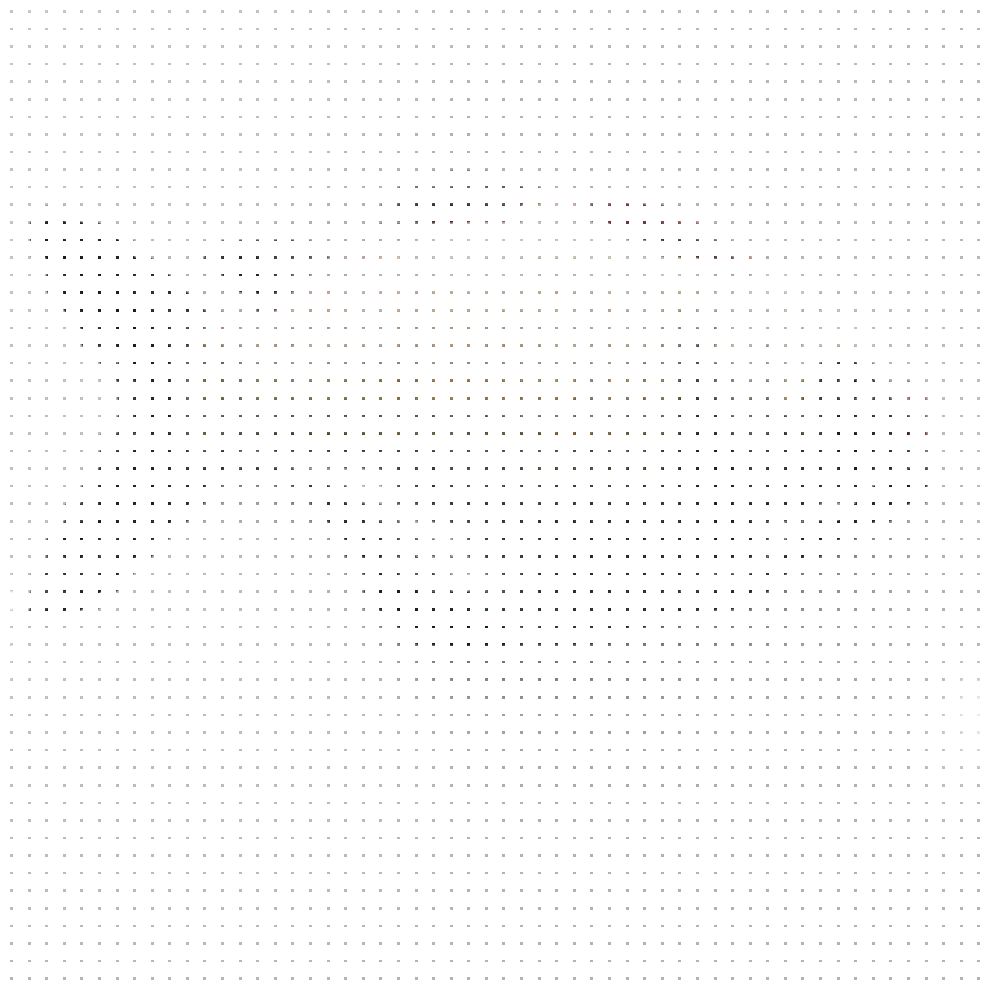

In [4]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()
# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

Total number of windows: 3136


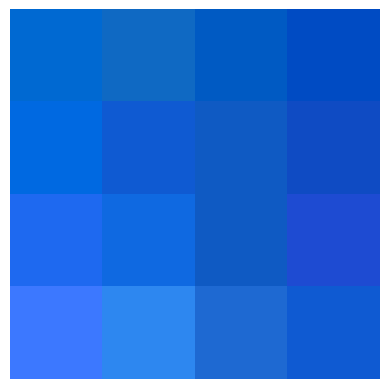

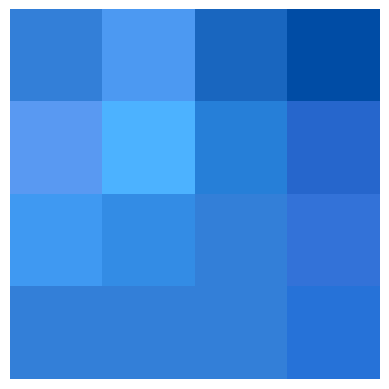

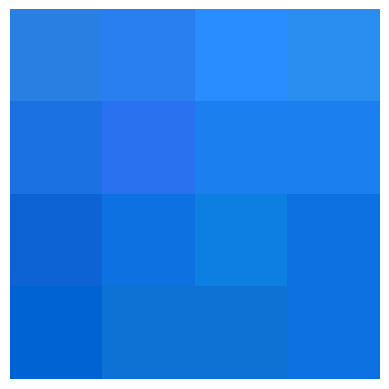

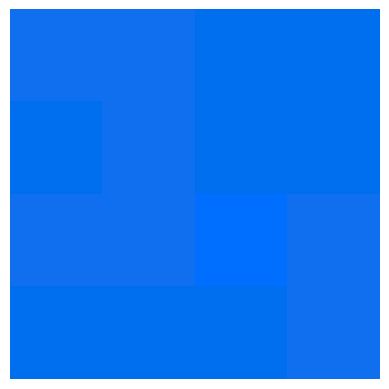

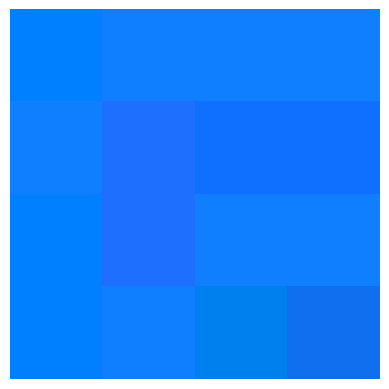

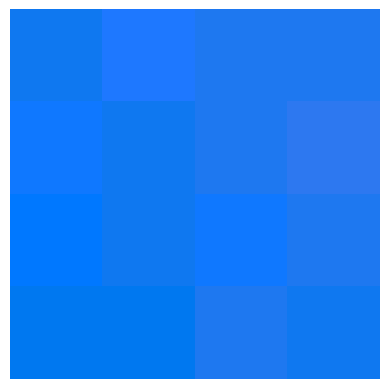

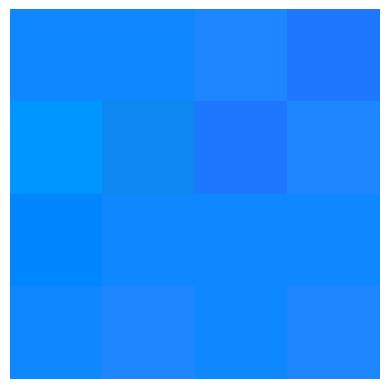

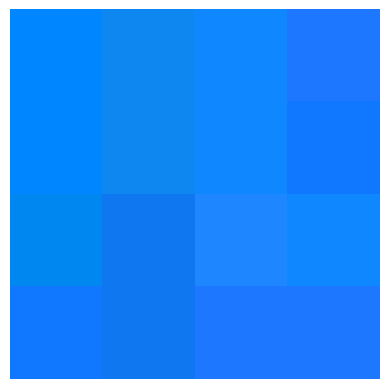

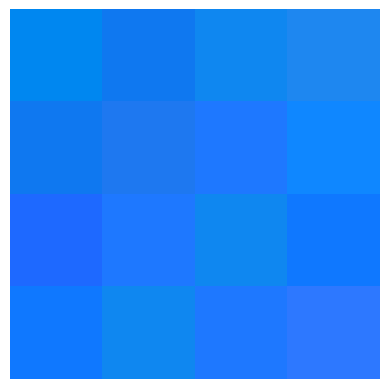

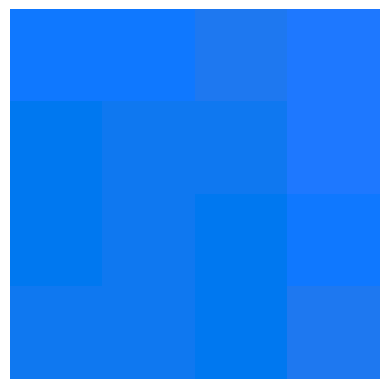

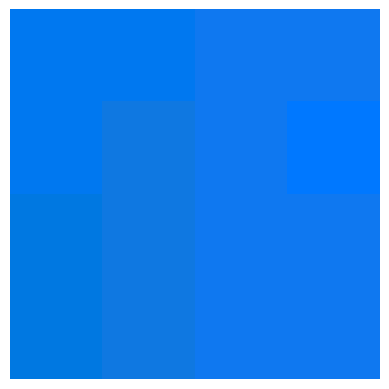

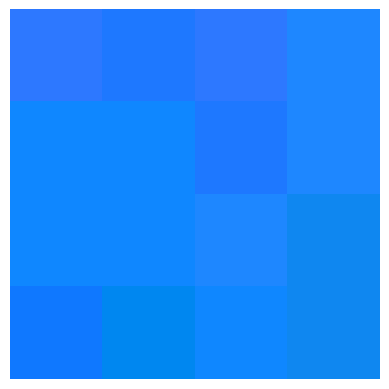

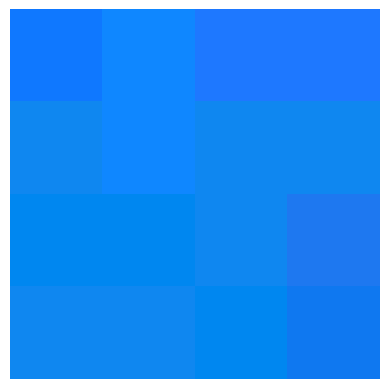

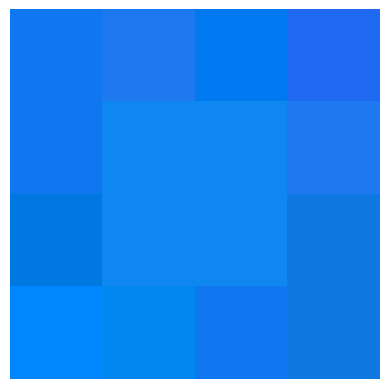

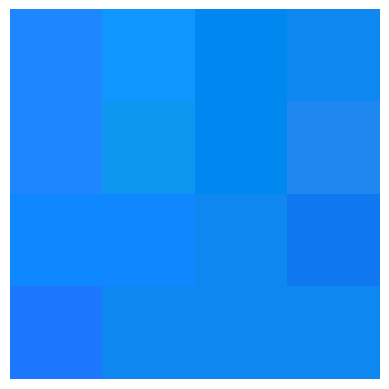

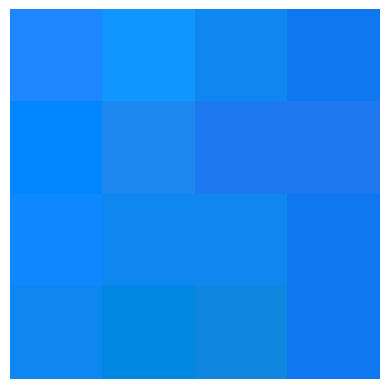

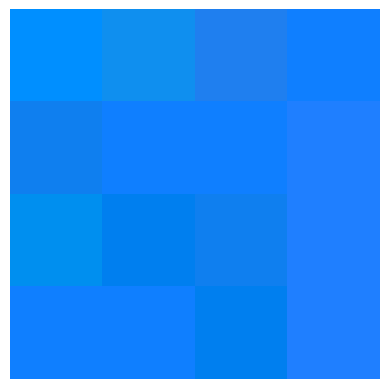

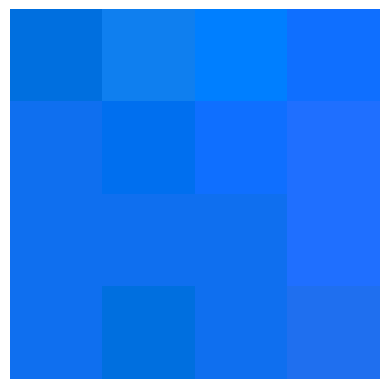

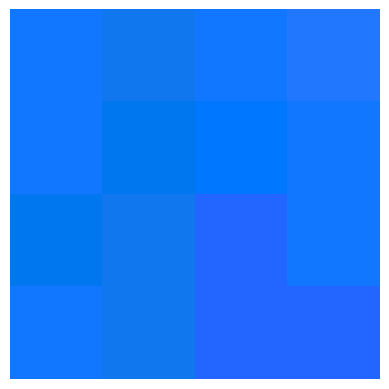

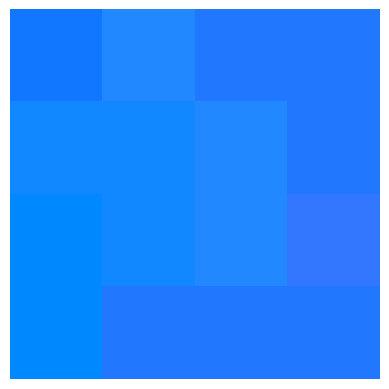

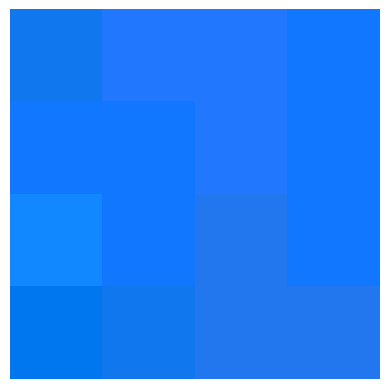

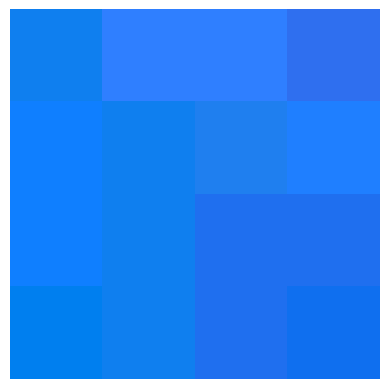

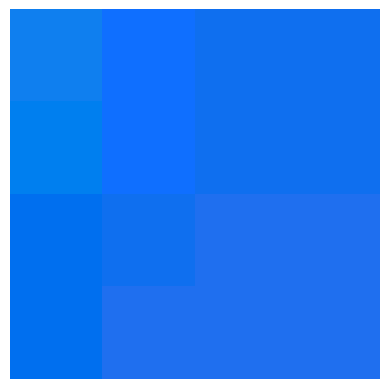

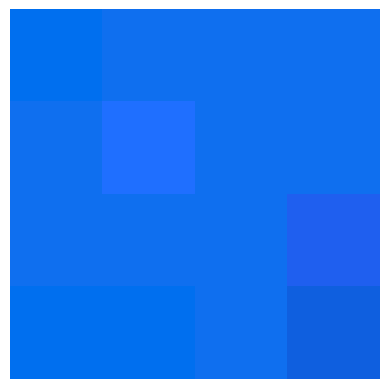

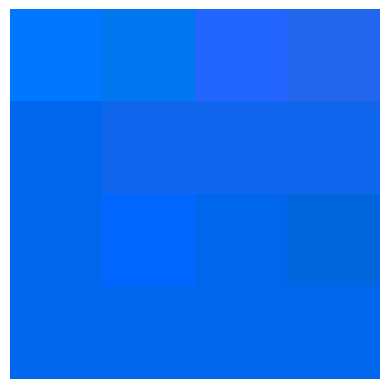

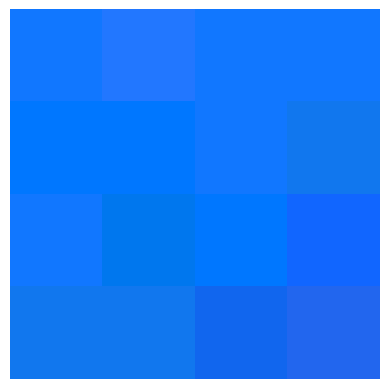

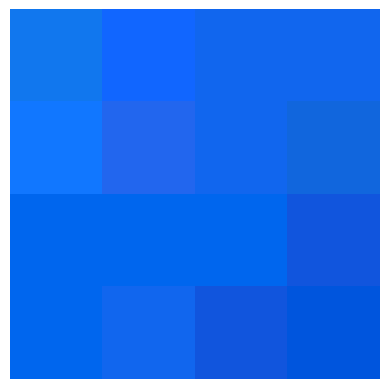

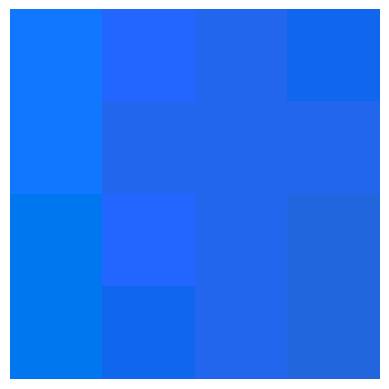

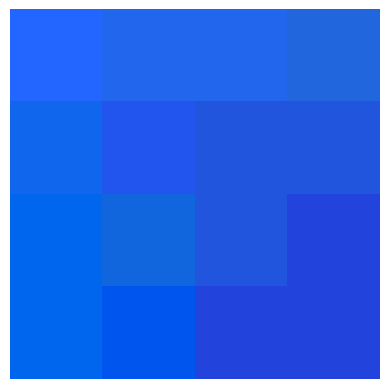

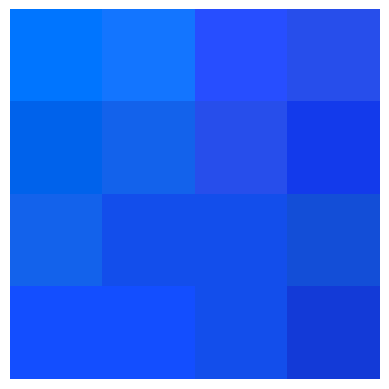

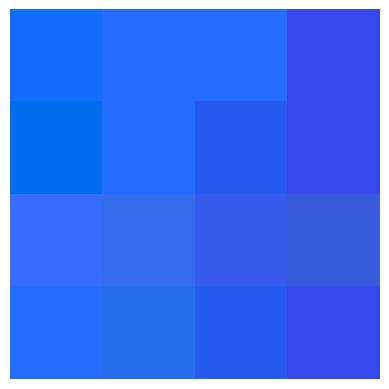

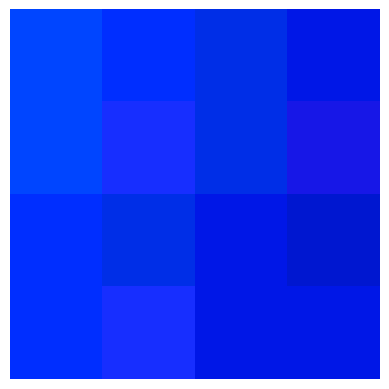

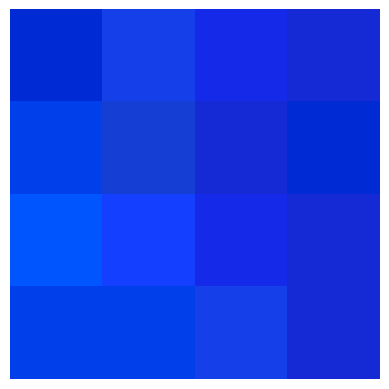

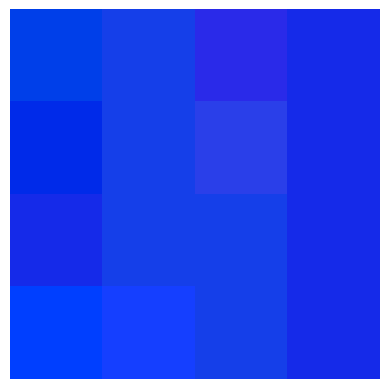

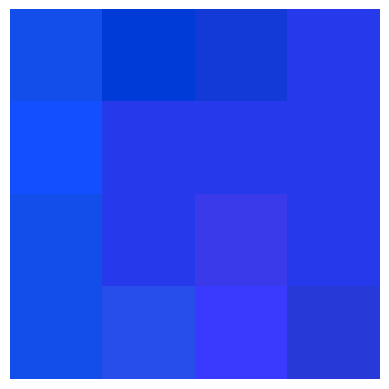

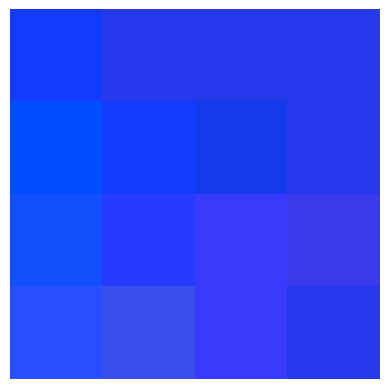

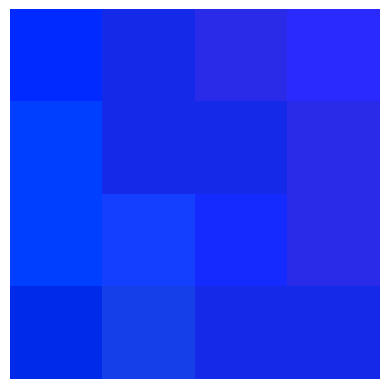

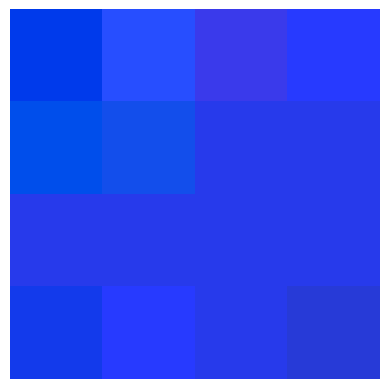

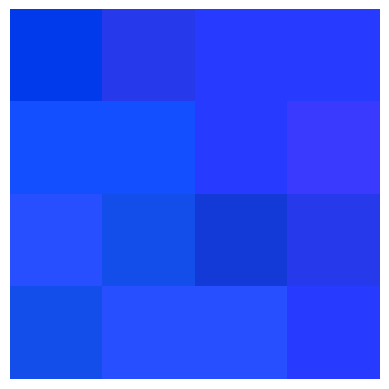

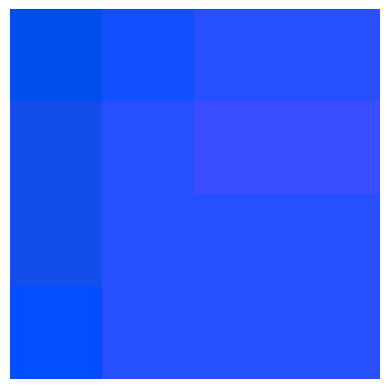

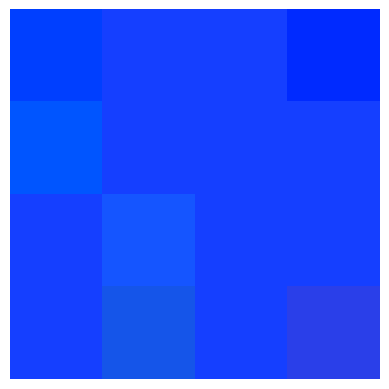

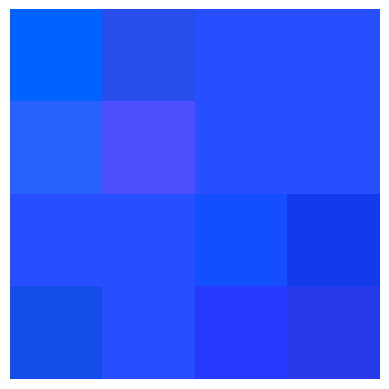

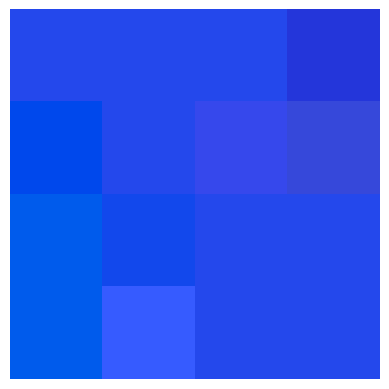

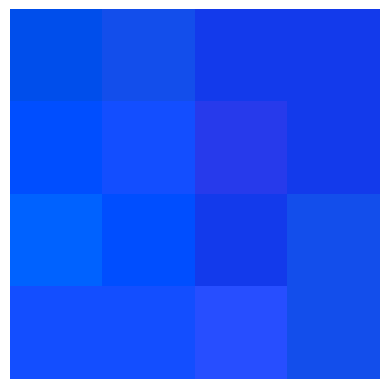

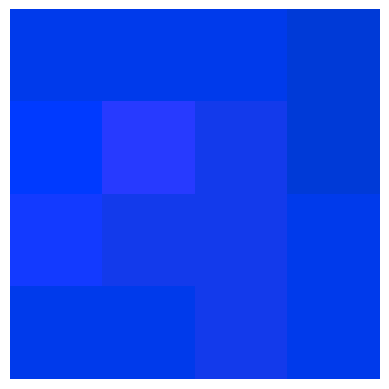

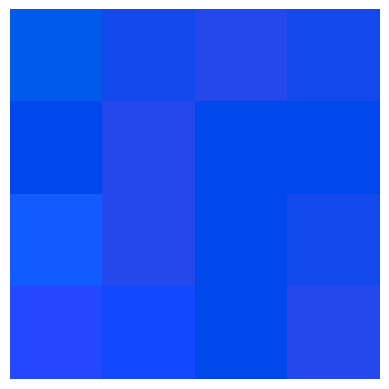

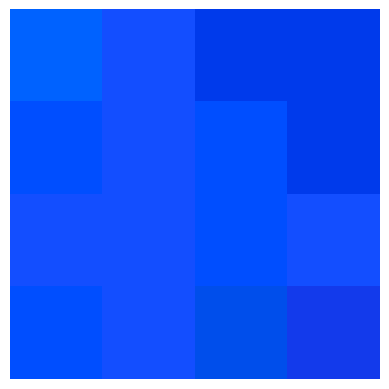

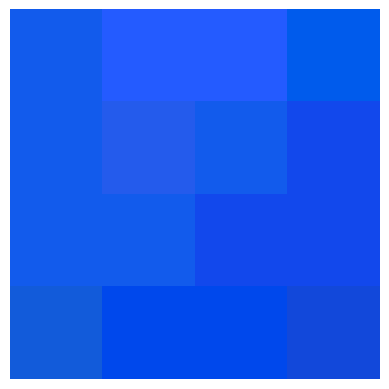

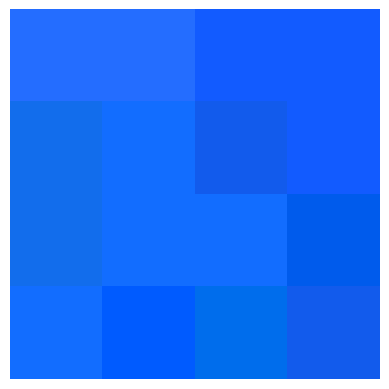

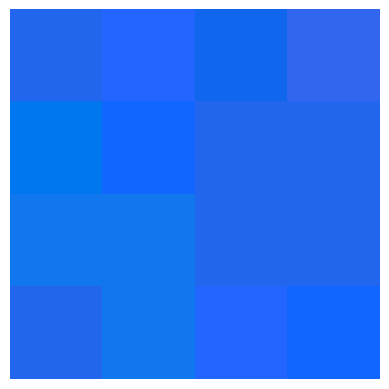

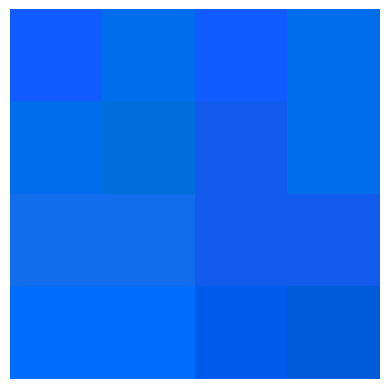

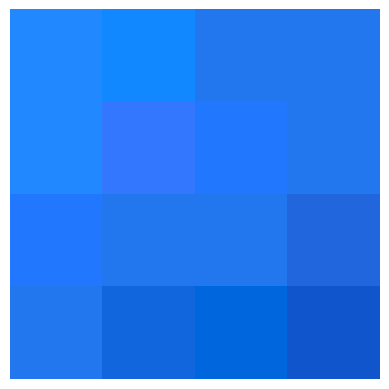

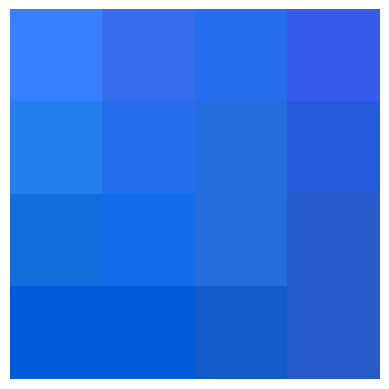

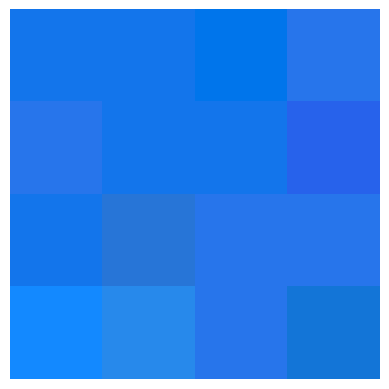

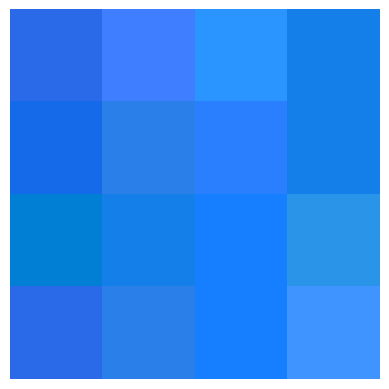

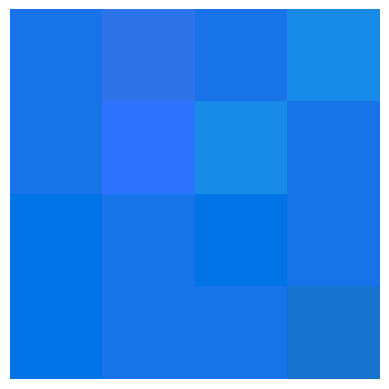

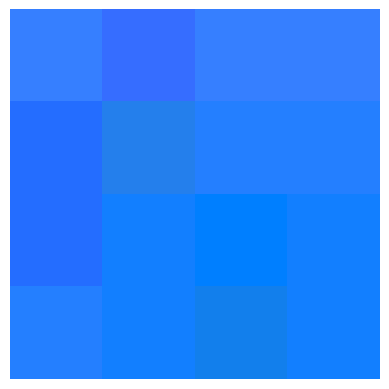

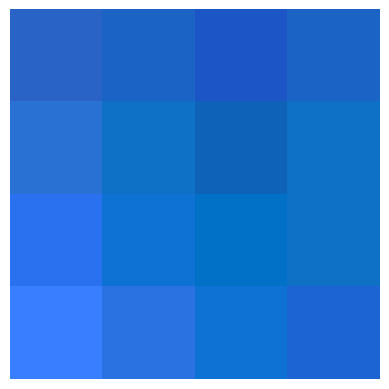

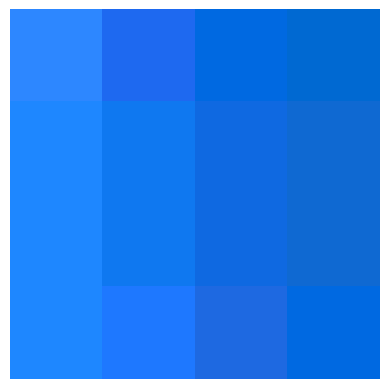

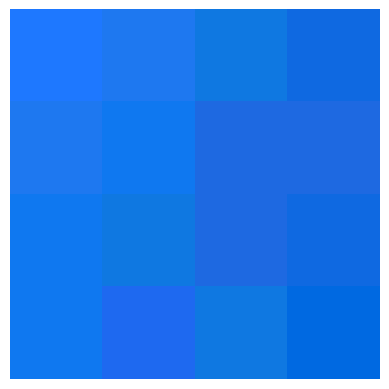

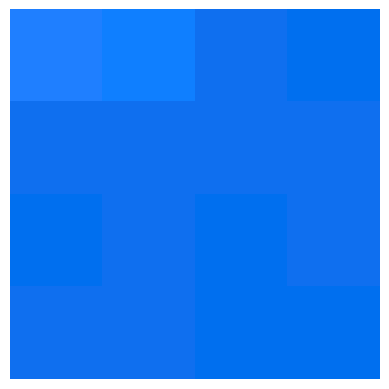

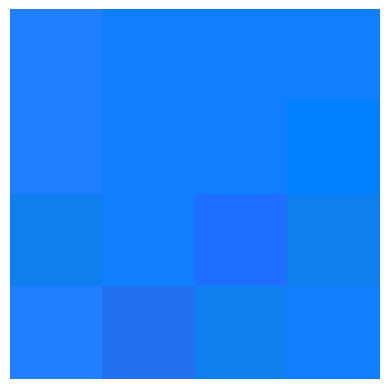

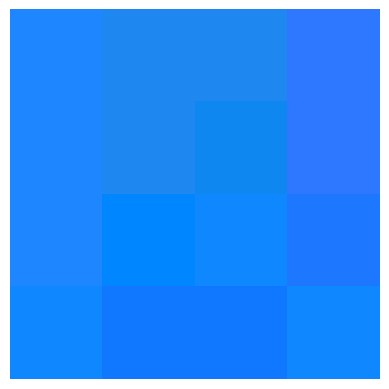

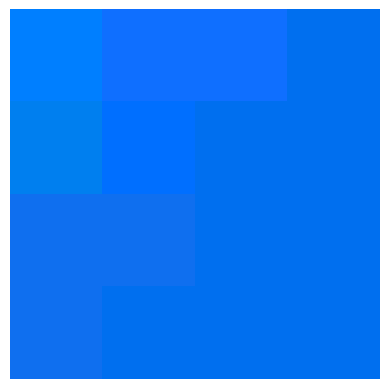

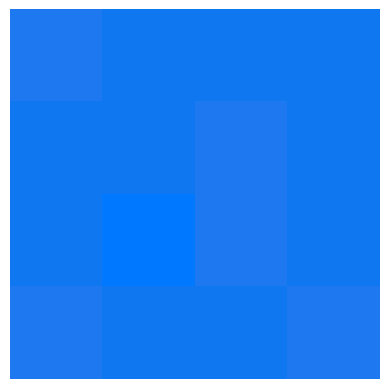

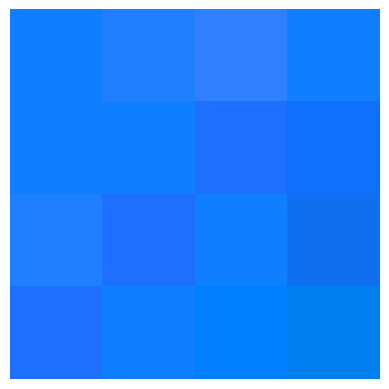

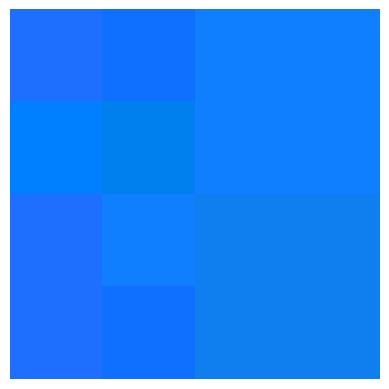

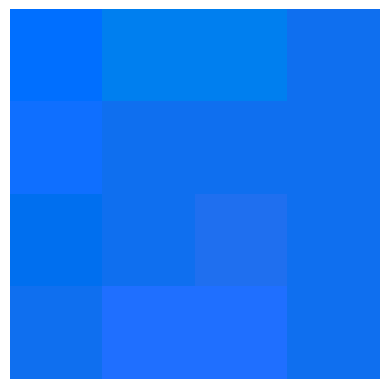

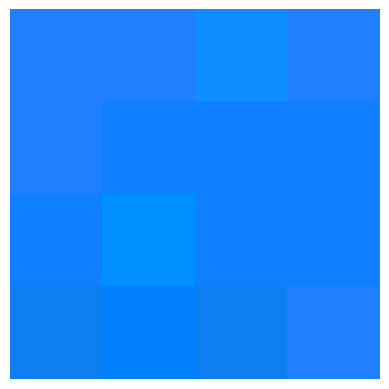

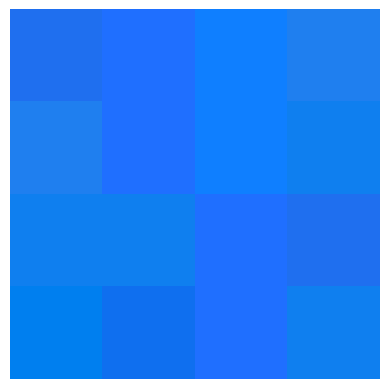

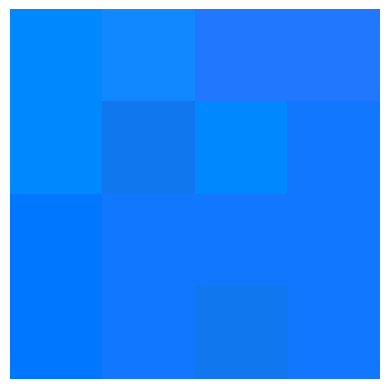

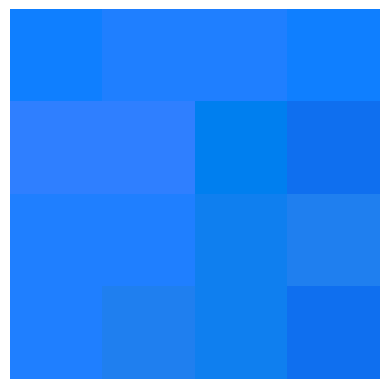

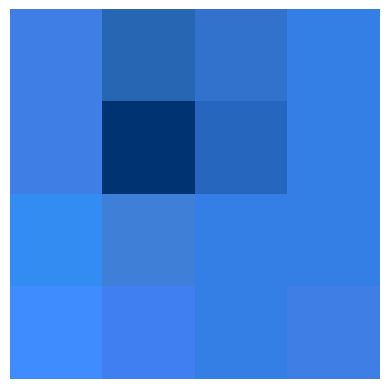

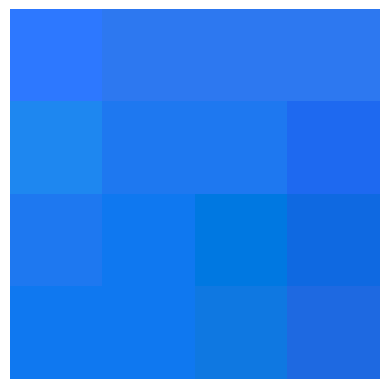

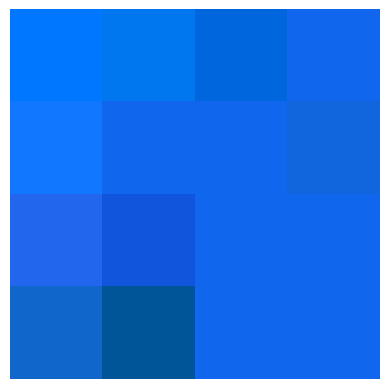

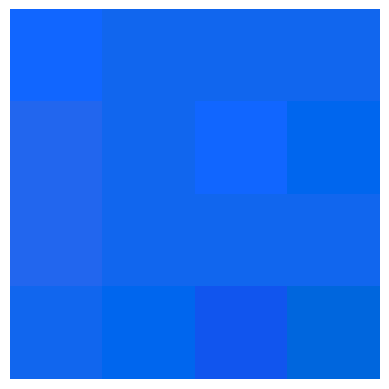

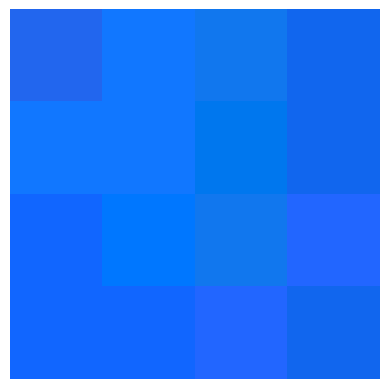

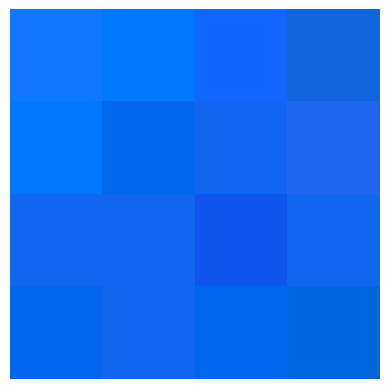

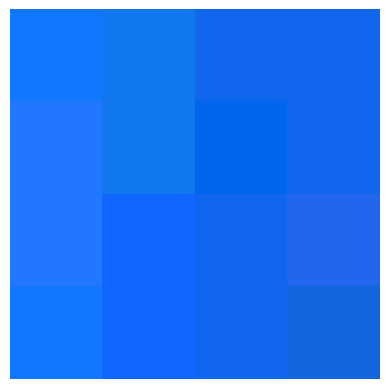

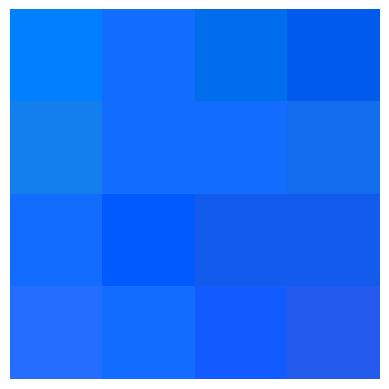

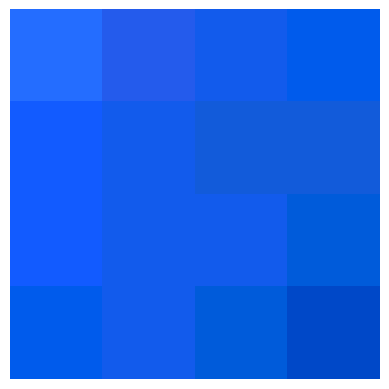

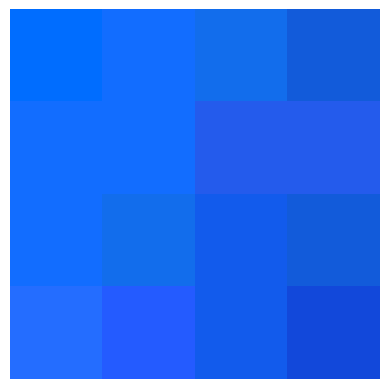

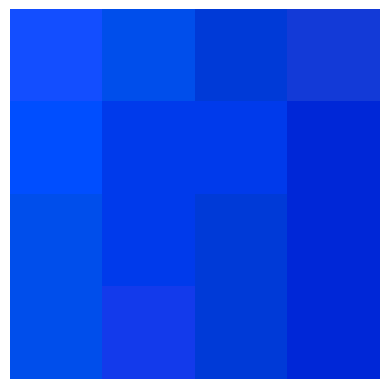

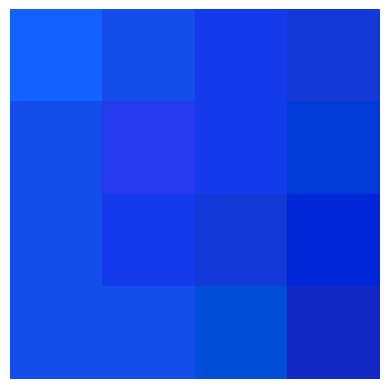

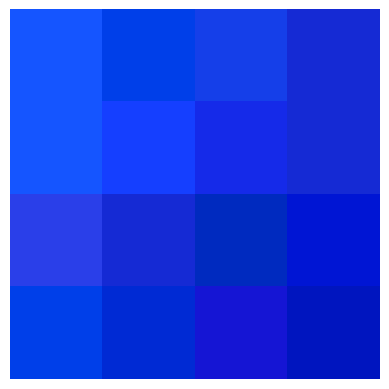

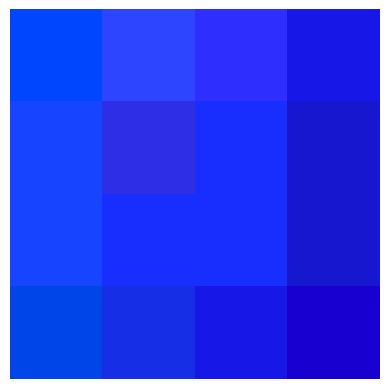

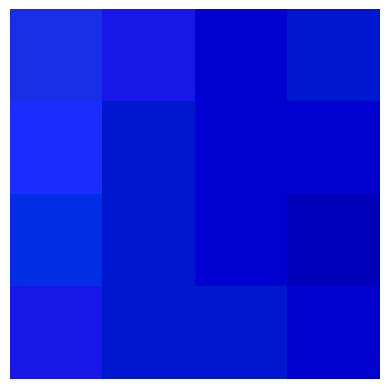

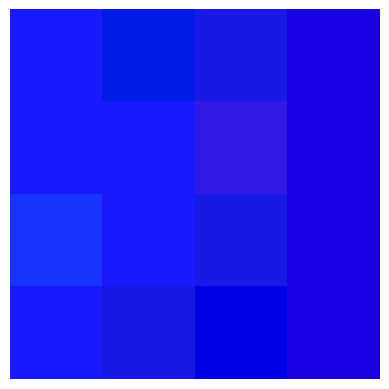

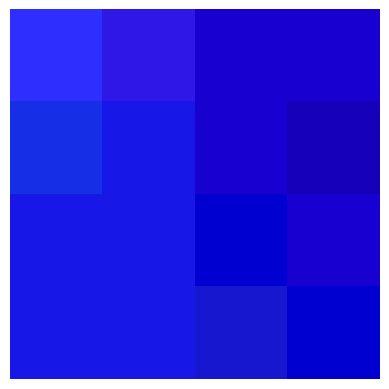

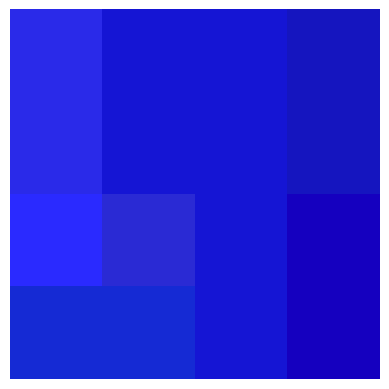

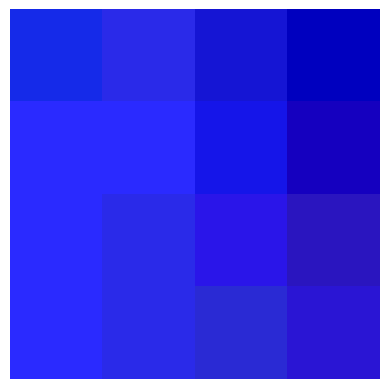

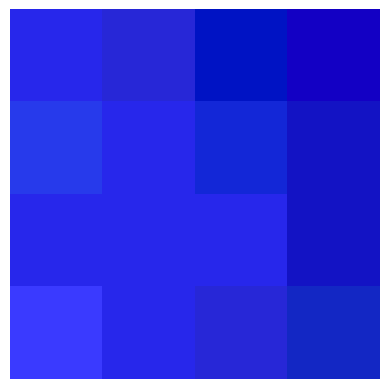

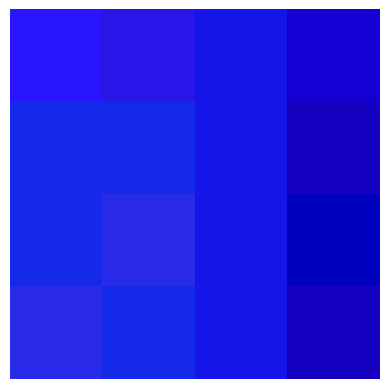

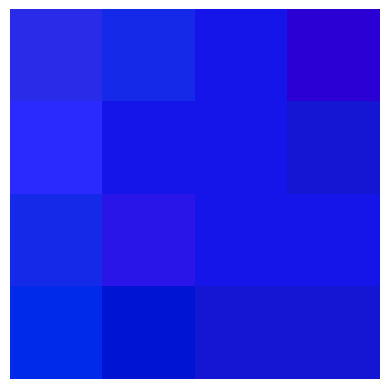

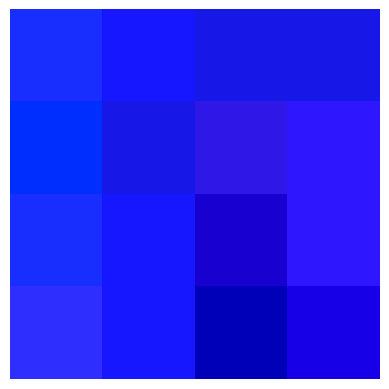

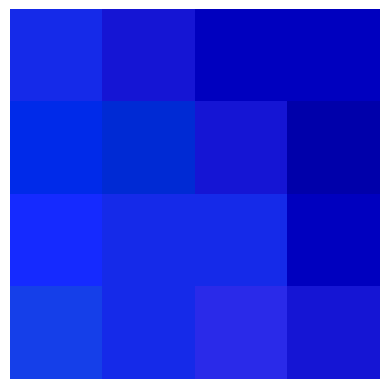

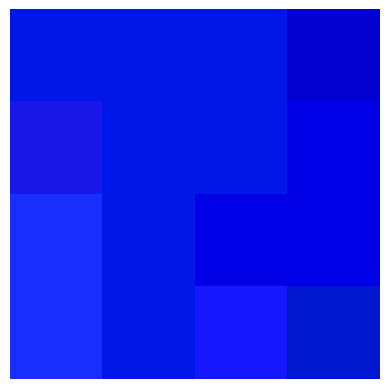

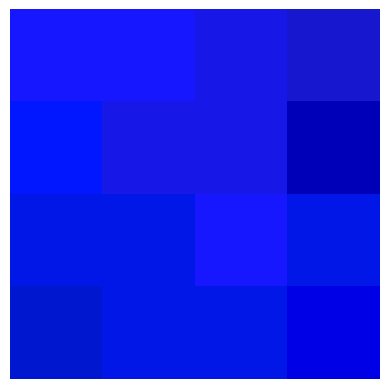

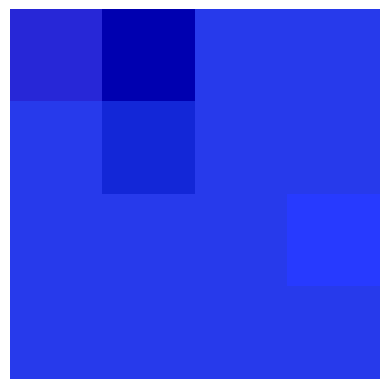

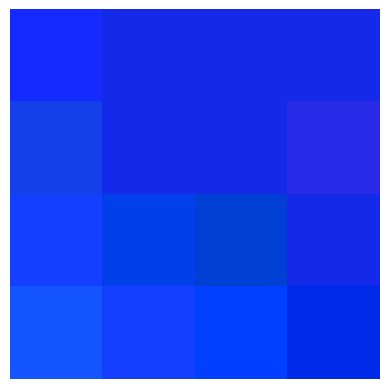

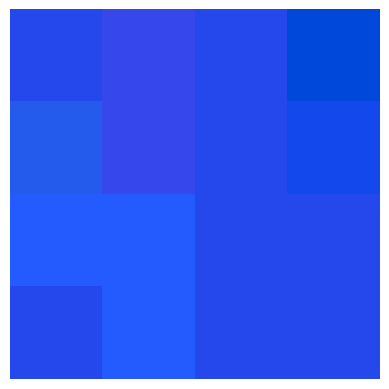

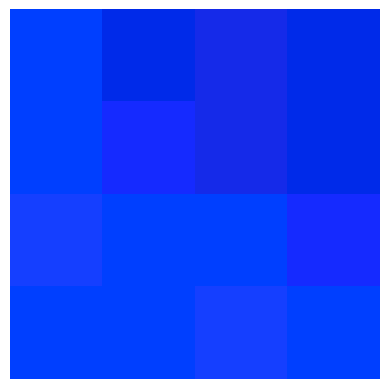

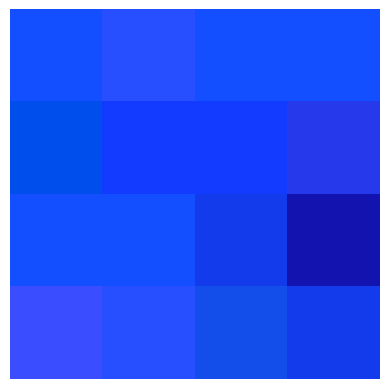

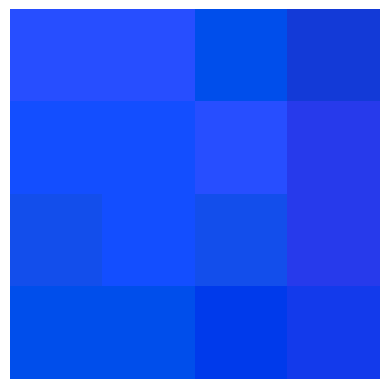

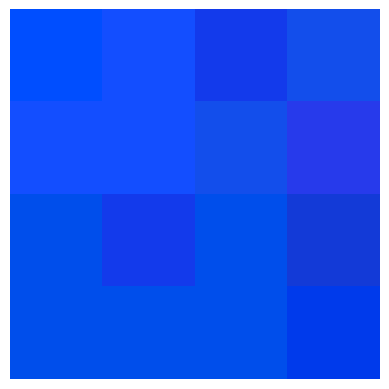

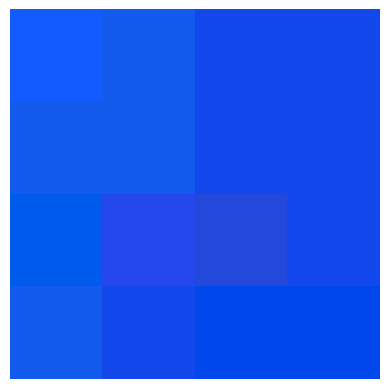

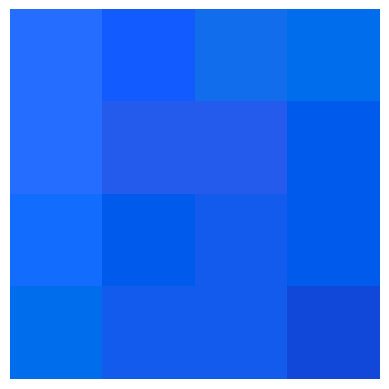

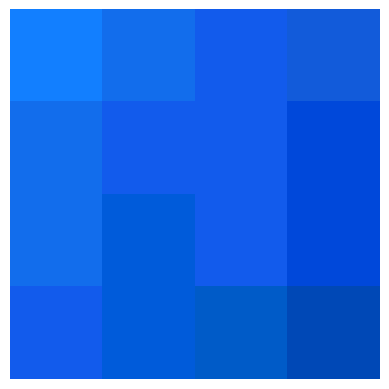

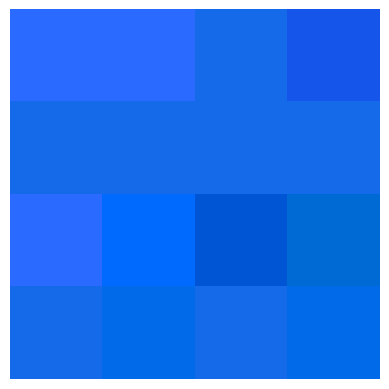

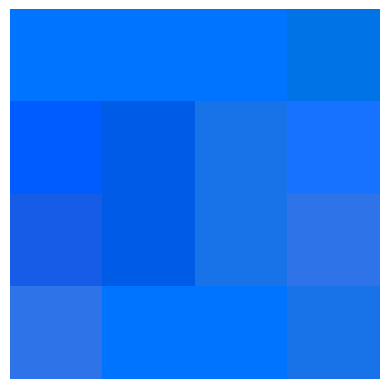

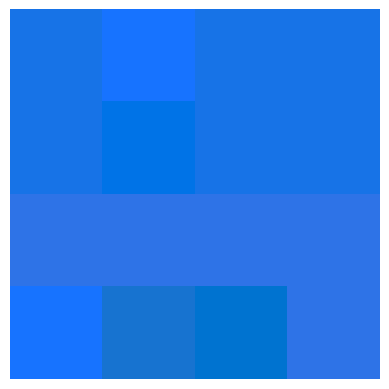

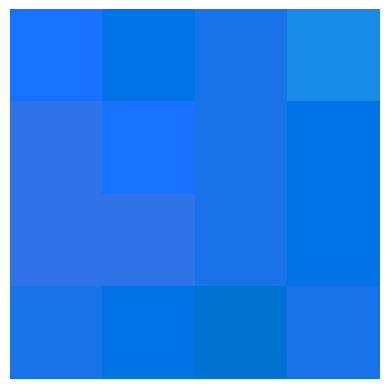

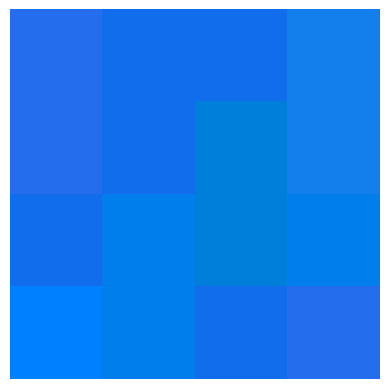

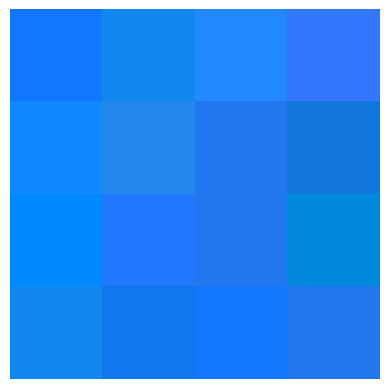

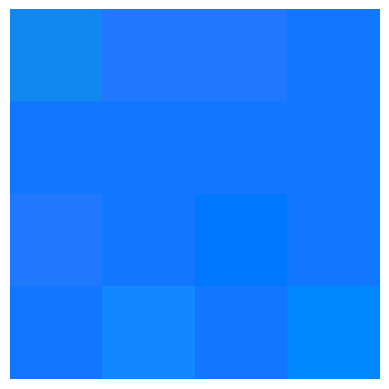

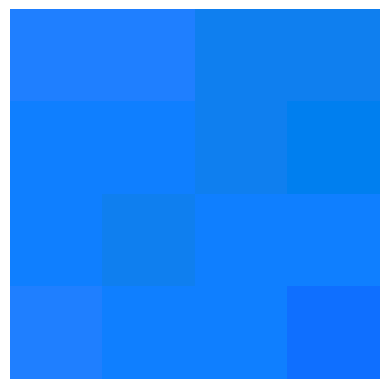

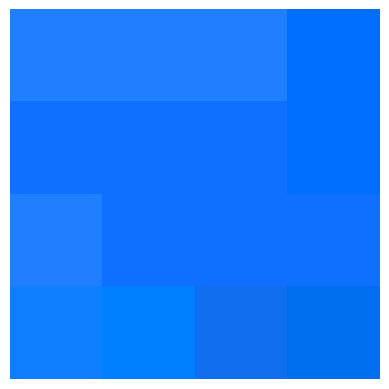

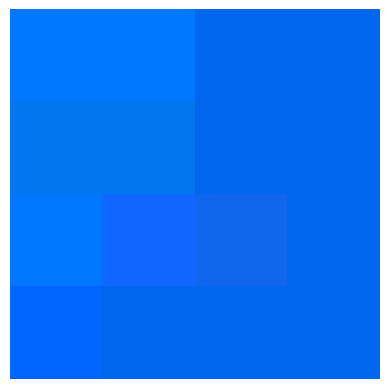

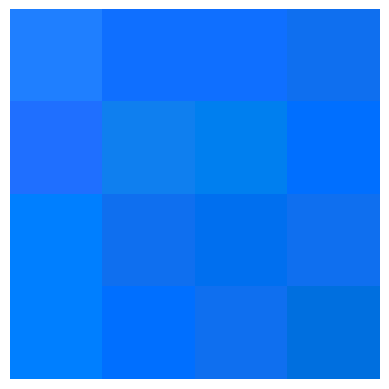

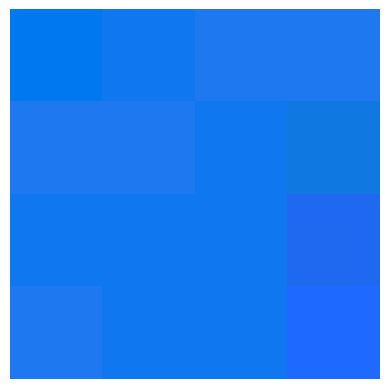

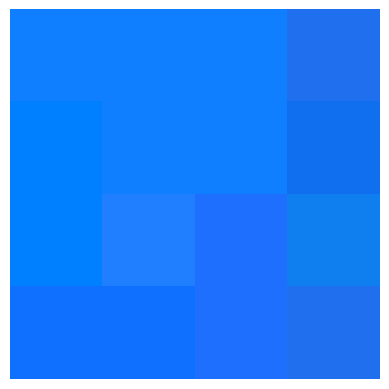

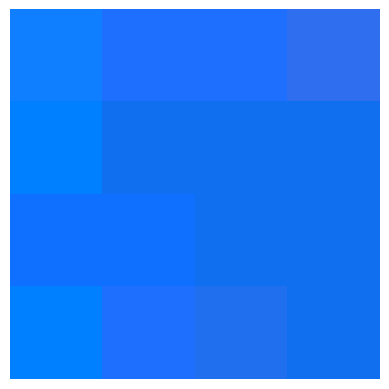

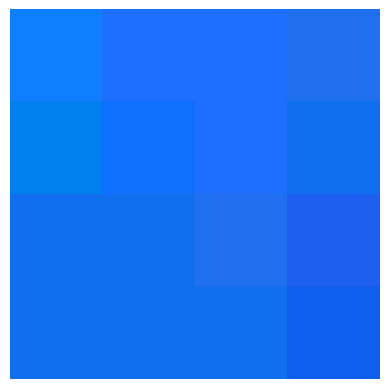

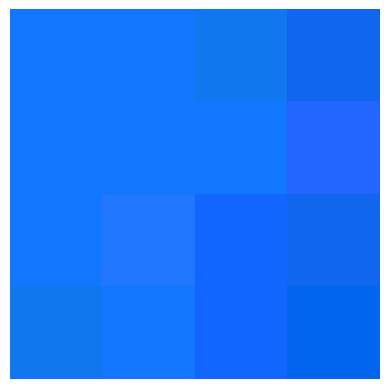

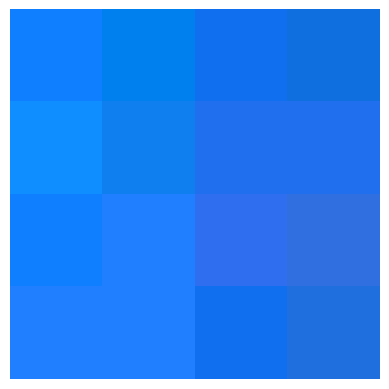

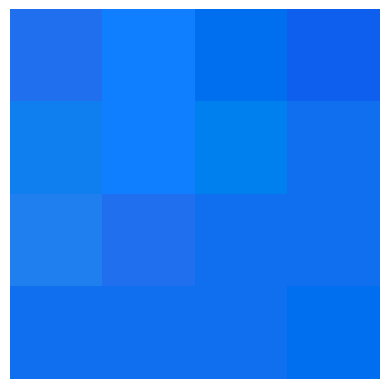

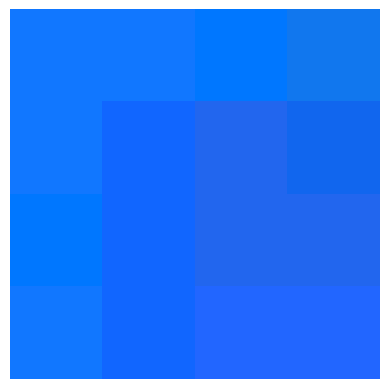

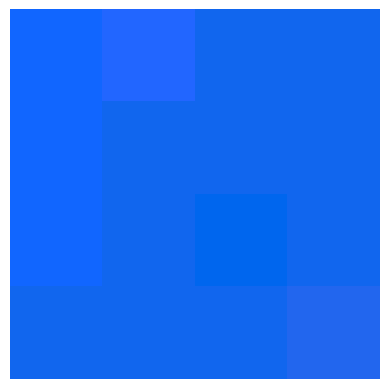

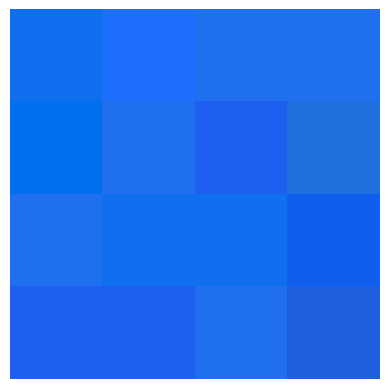

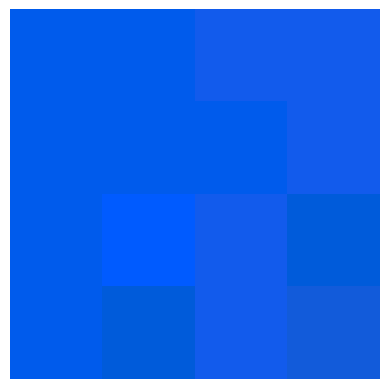

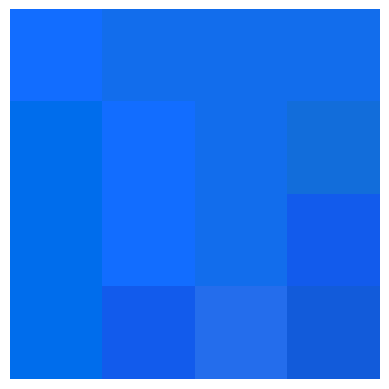

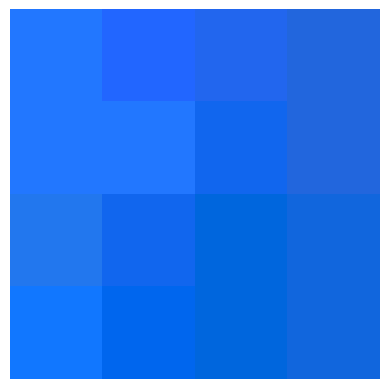

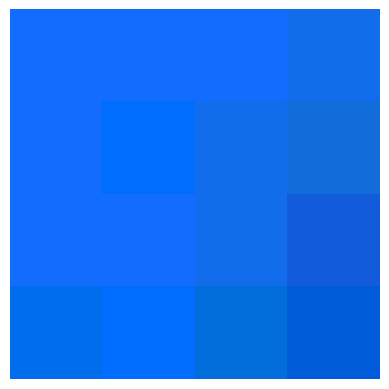

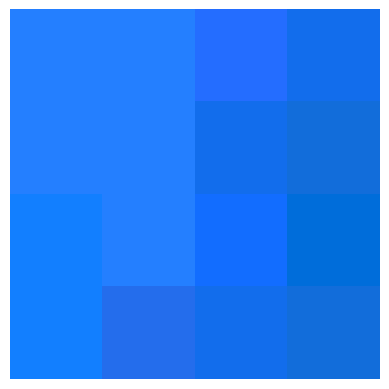

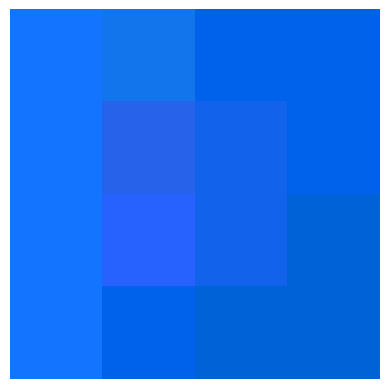

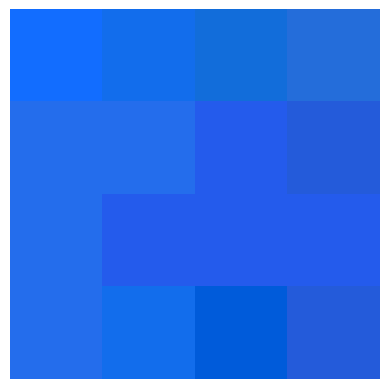

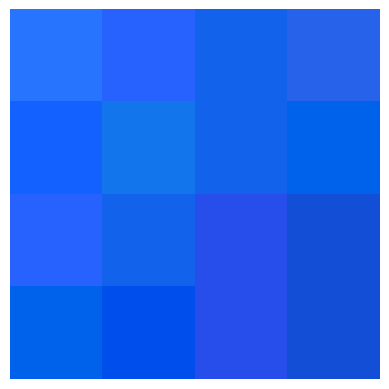

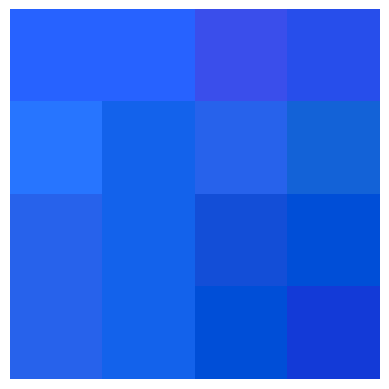

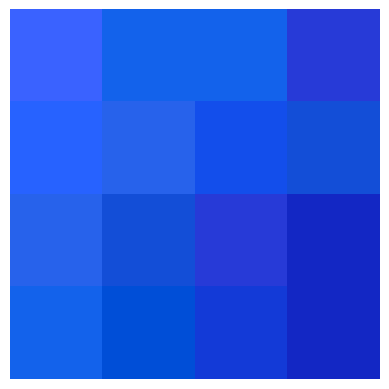

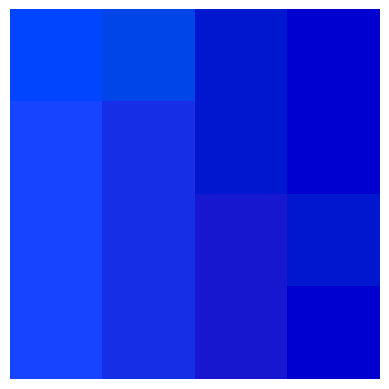

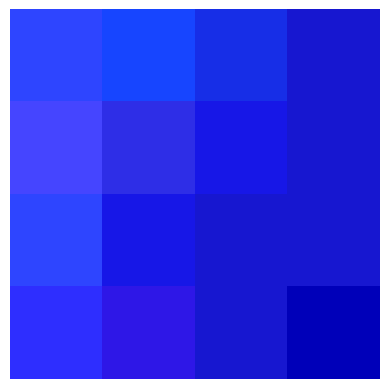

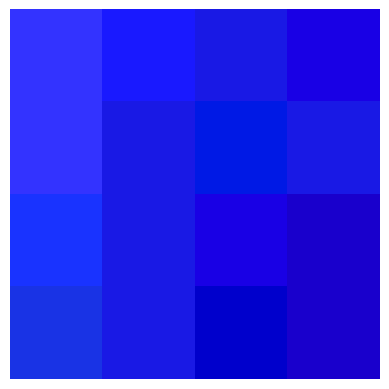

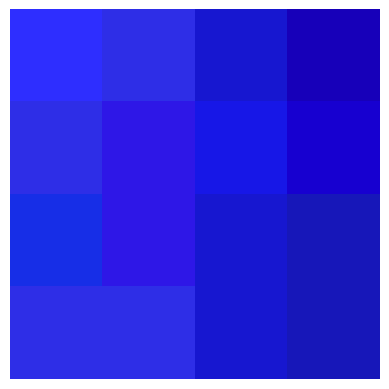

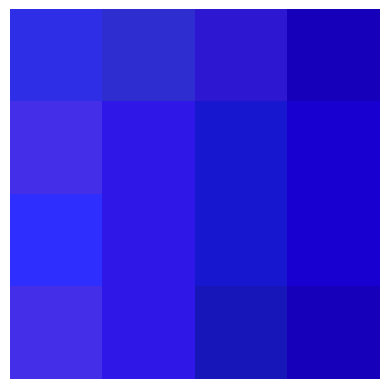

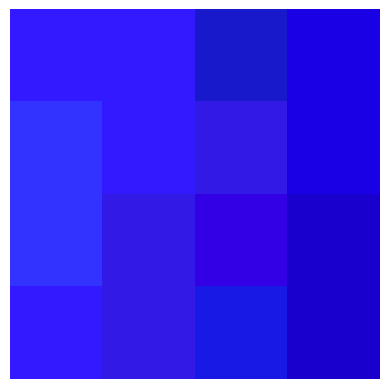

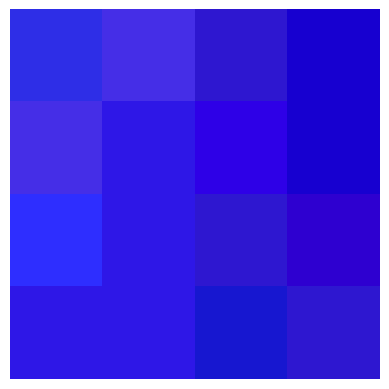

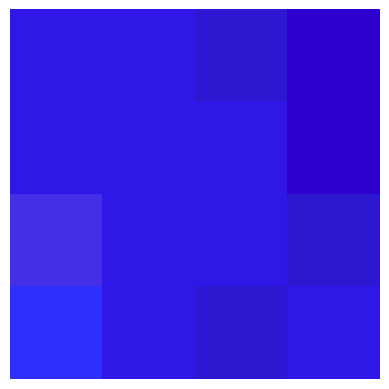

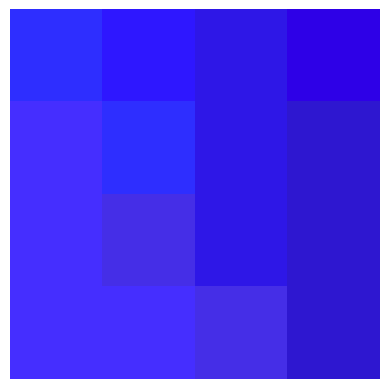

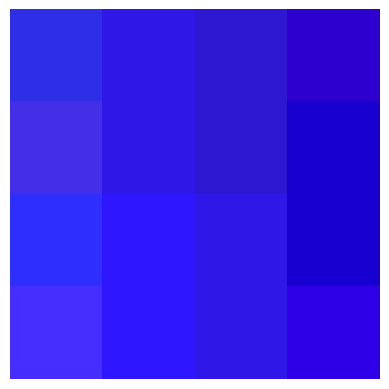

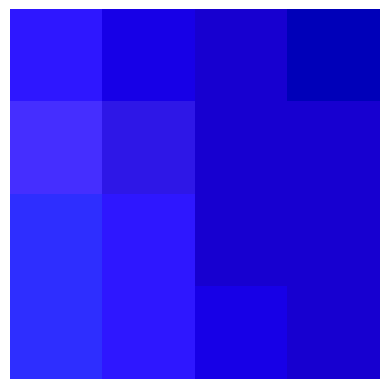

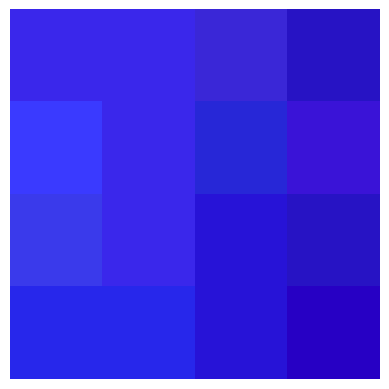

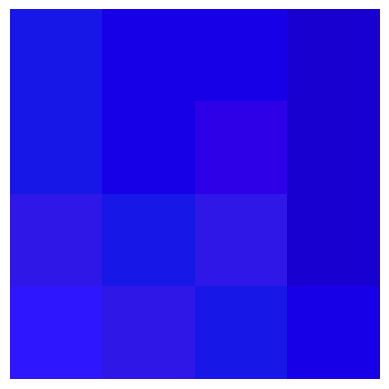

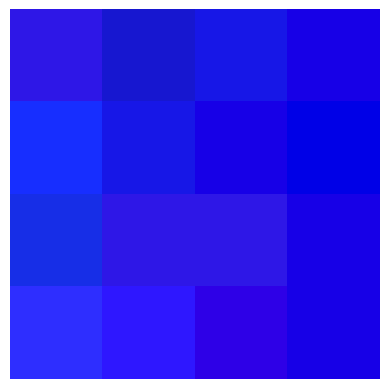

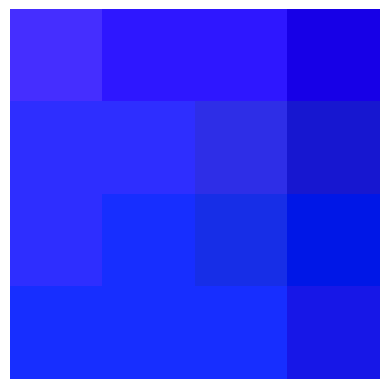

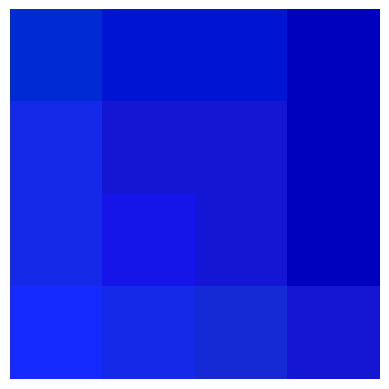

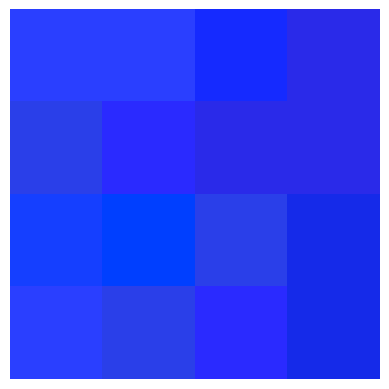

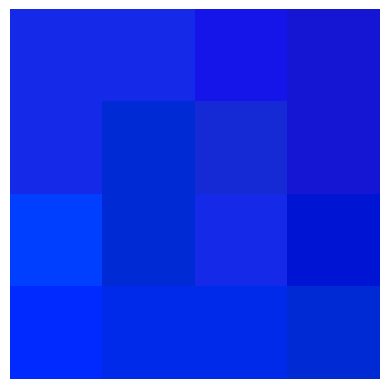

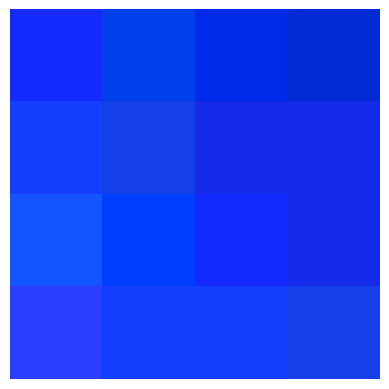

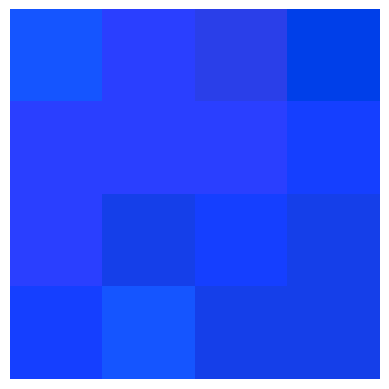

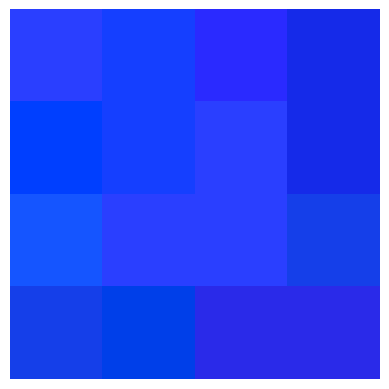

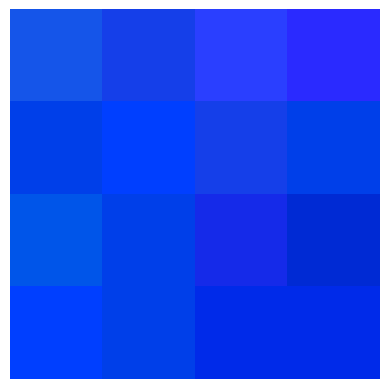

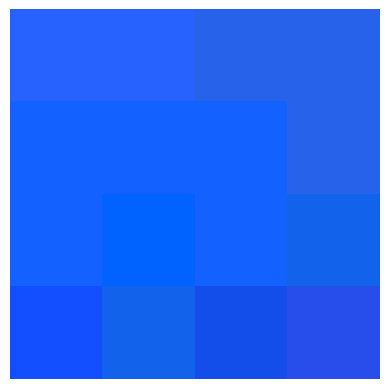

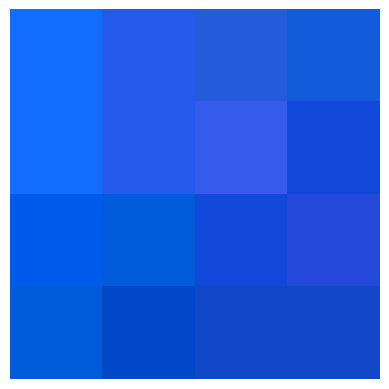

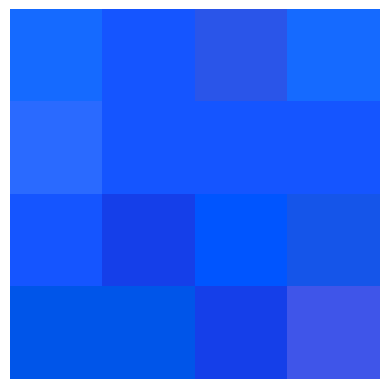

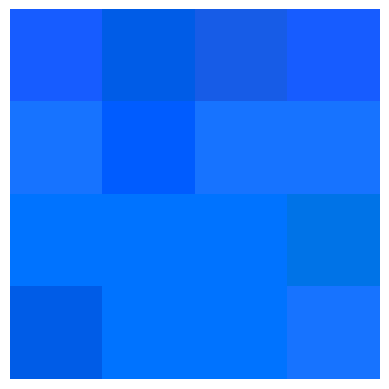

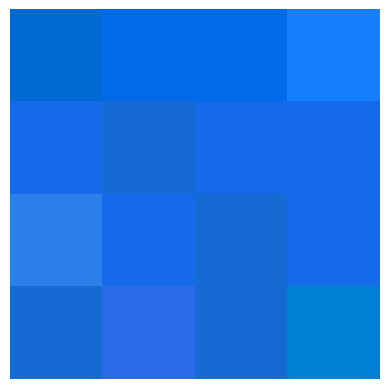

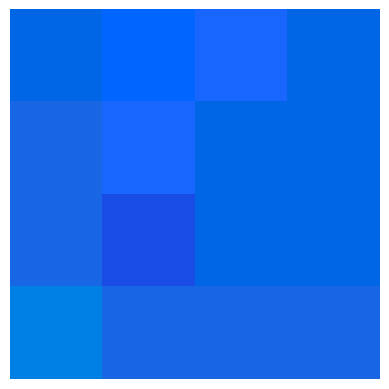

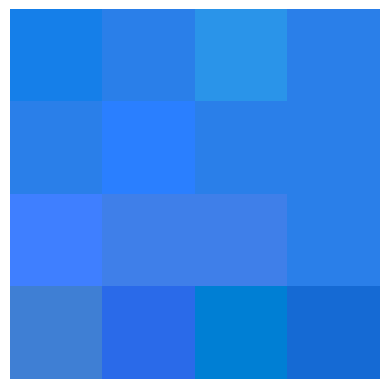

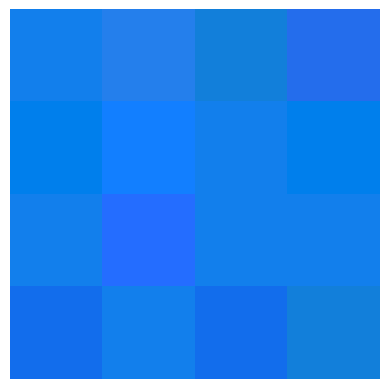

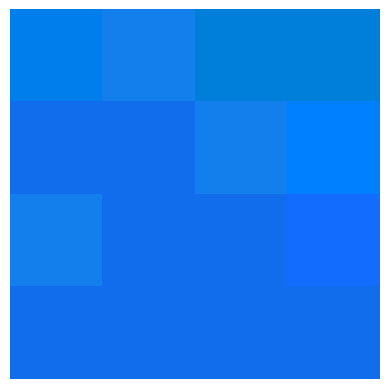

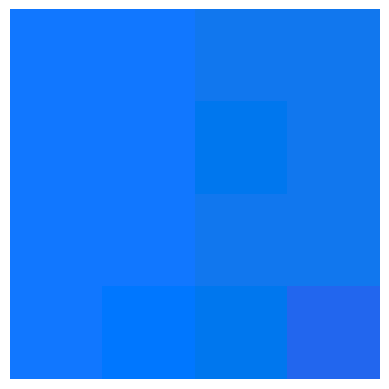

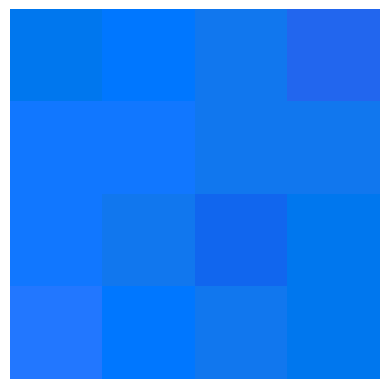

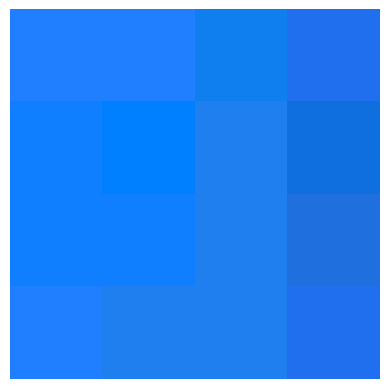

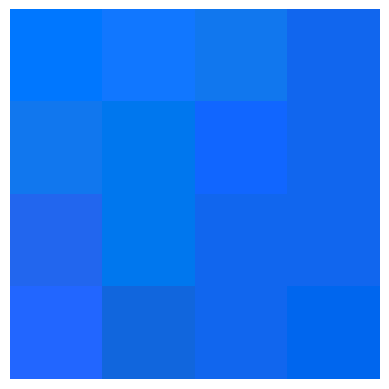

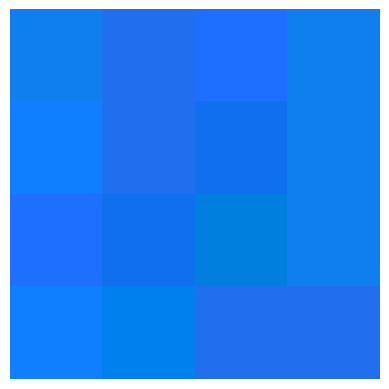

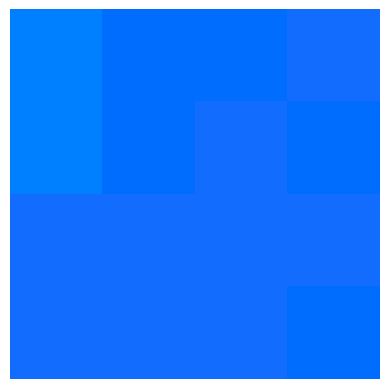

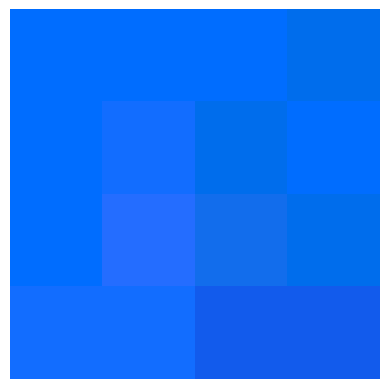

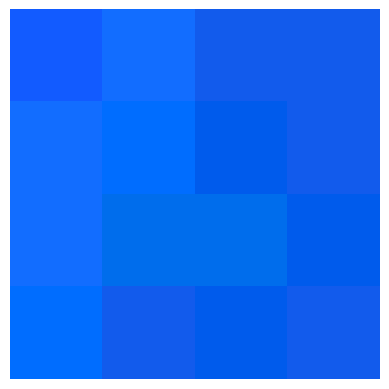

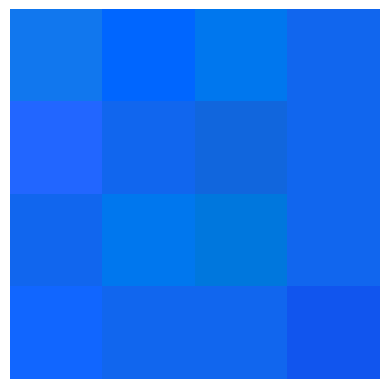

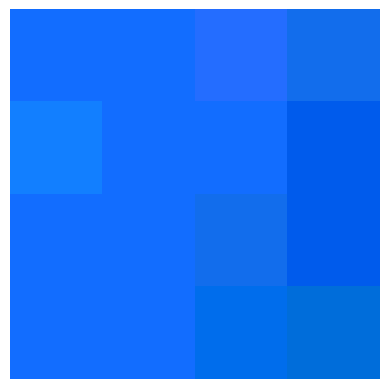

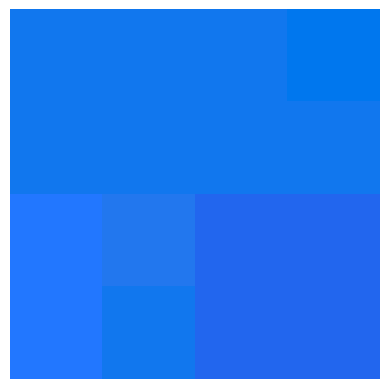

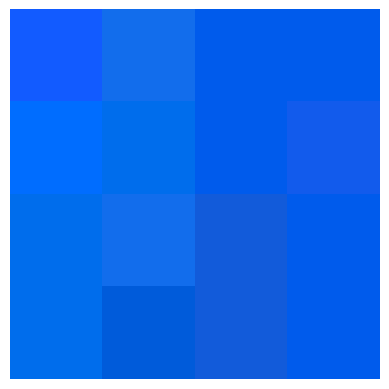

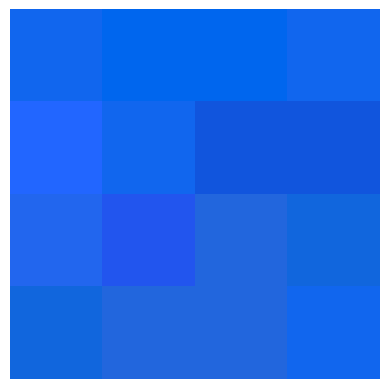

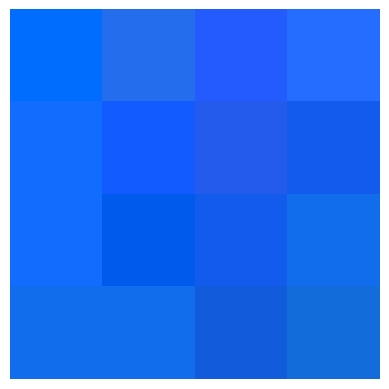

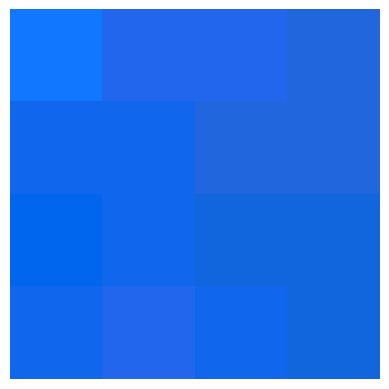

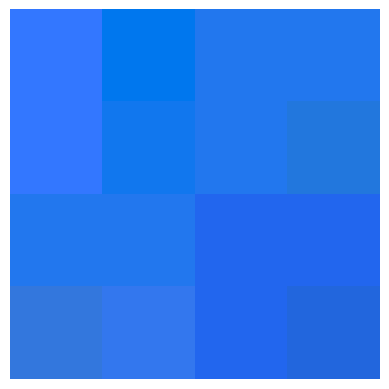

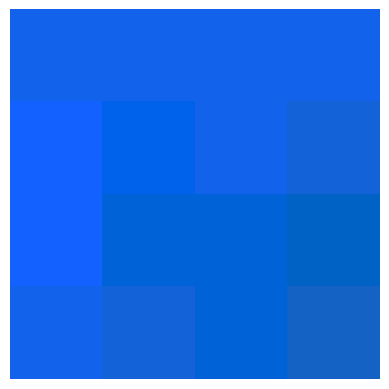

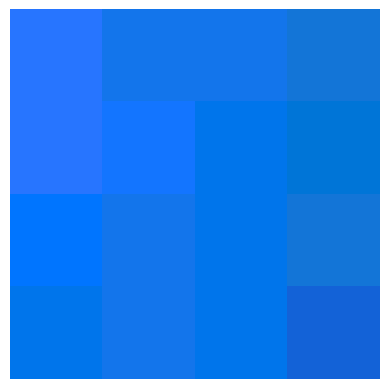

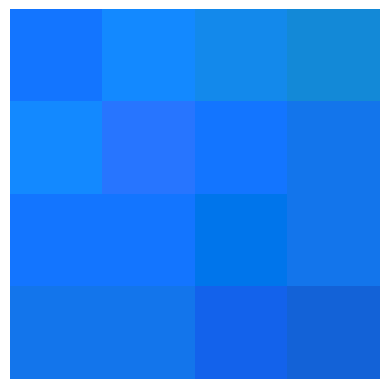

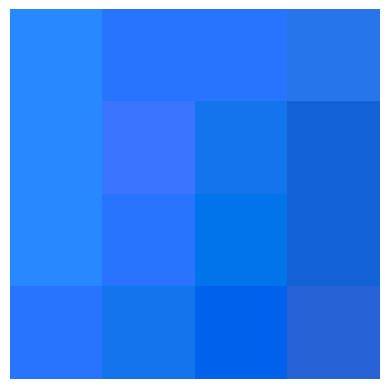

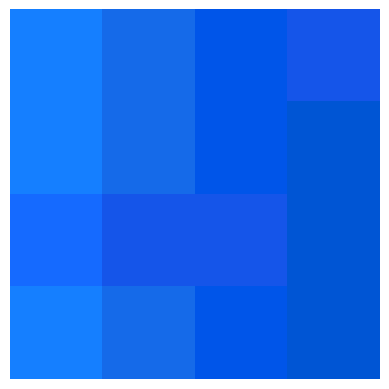

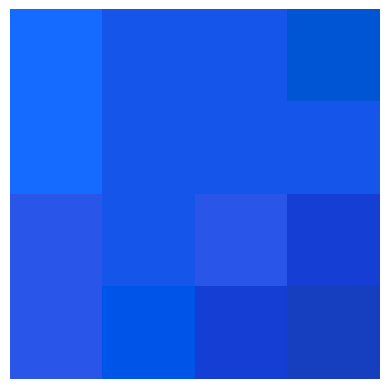

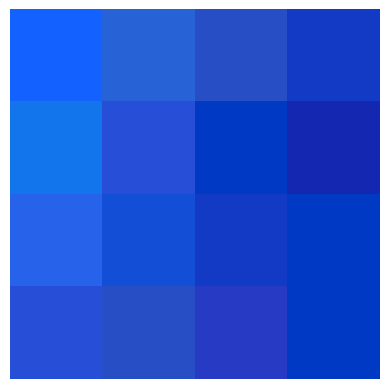

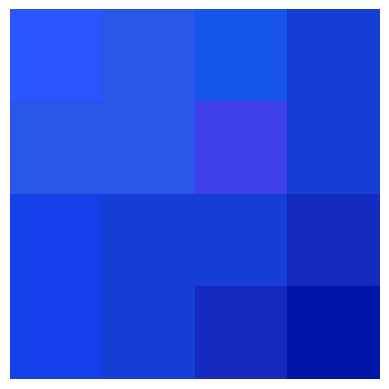

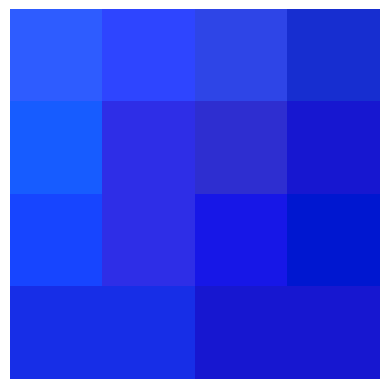

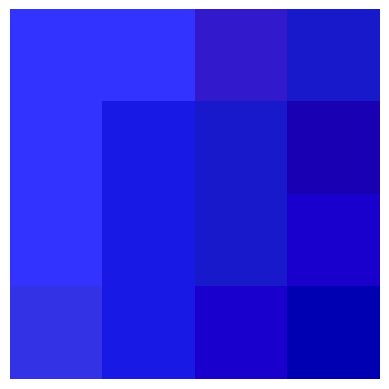

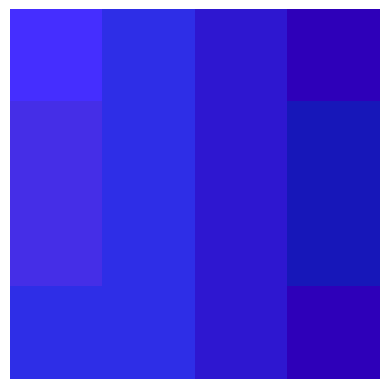

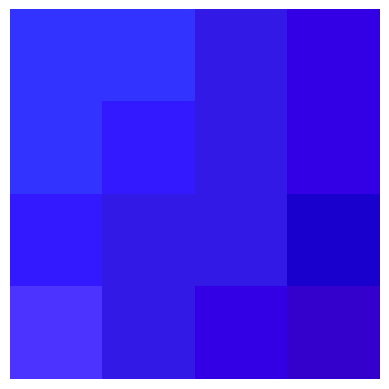

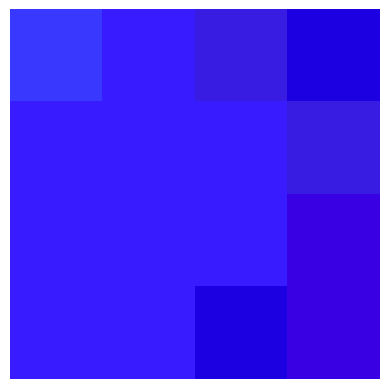

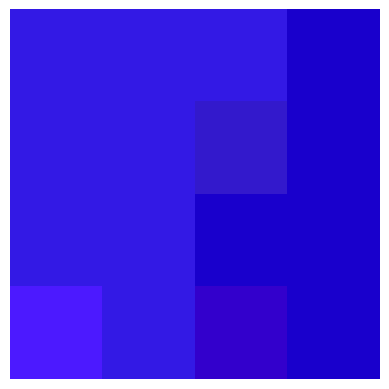

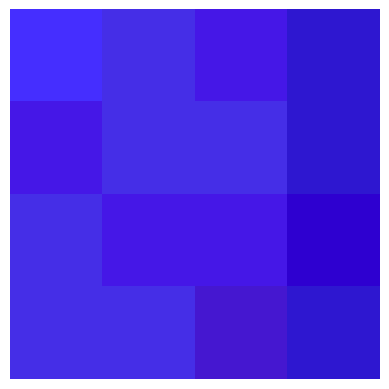

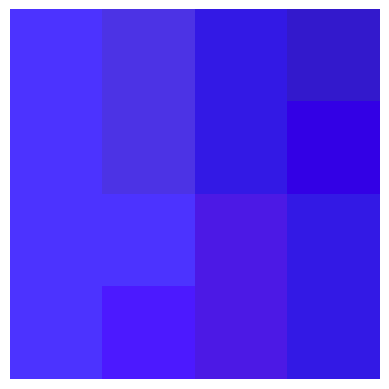

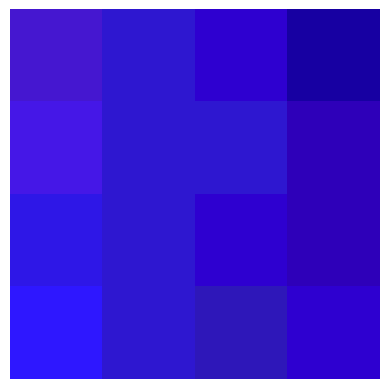

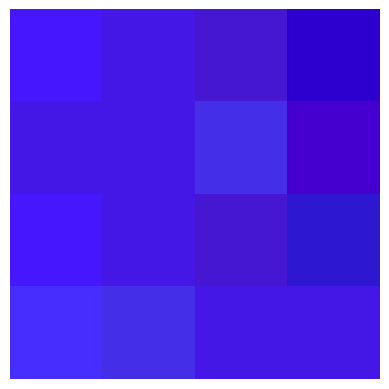

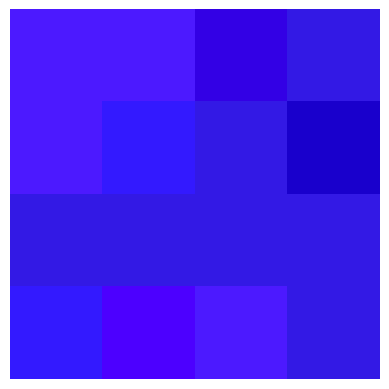

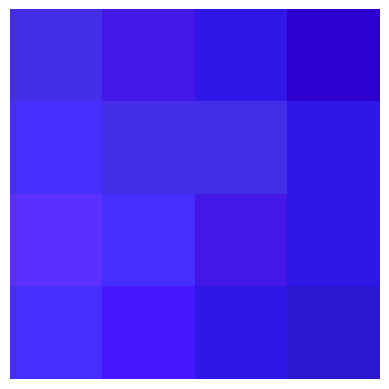

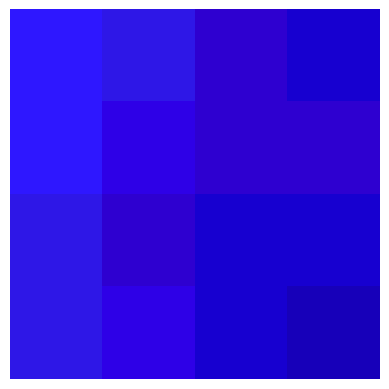

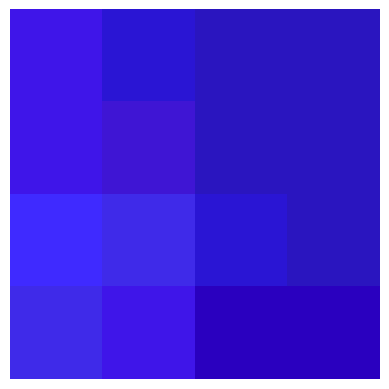

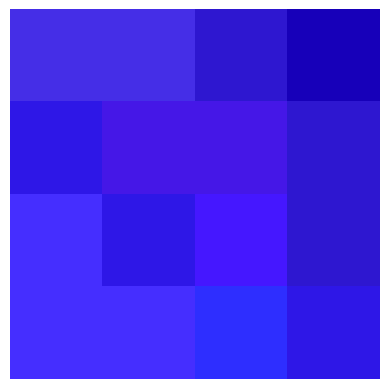

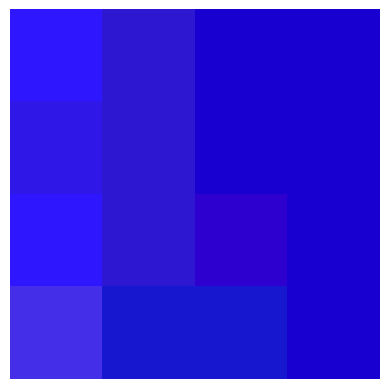

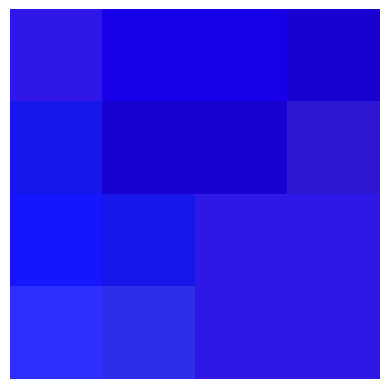

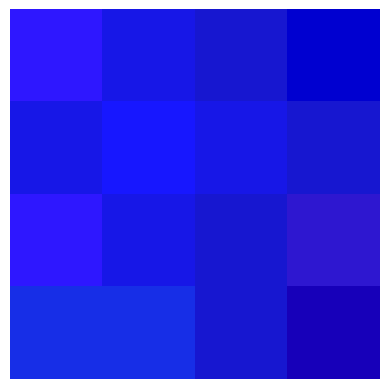

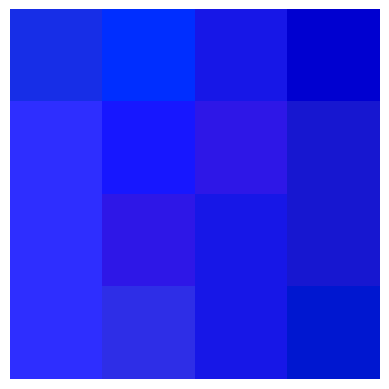

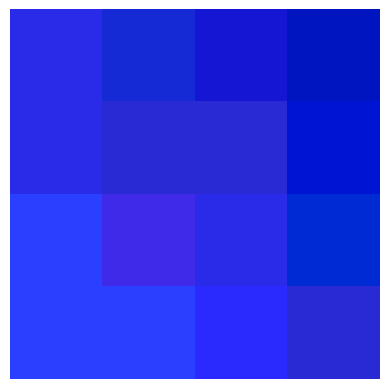

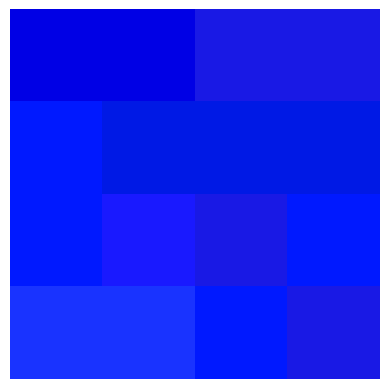

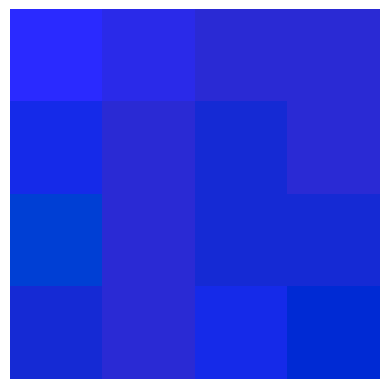

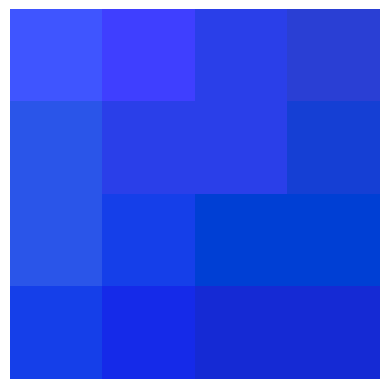

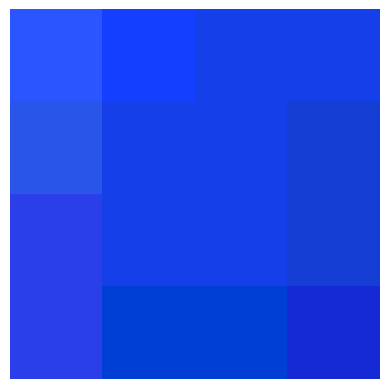

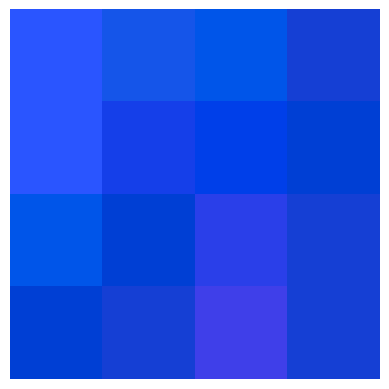

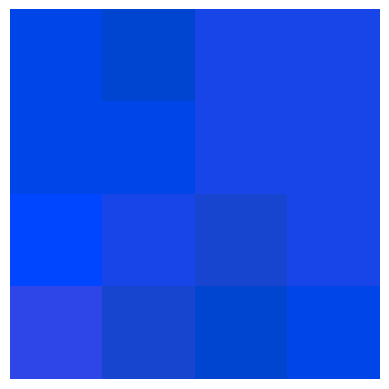

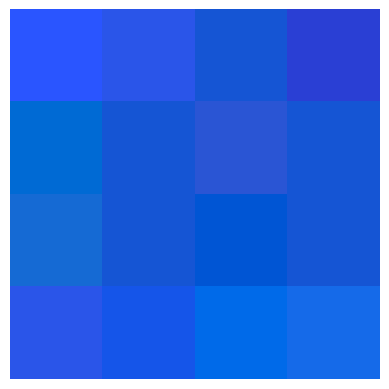

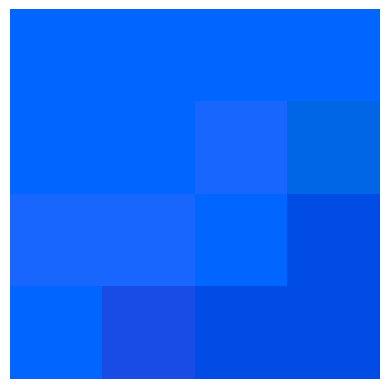

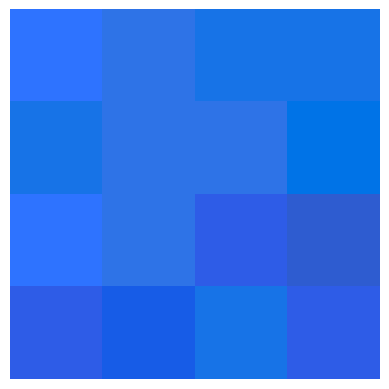

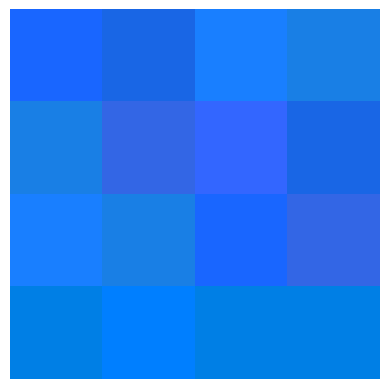

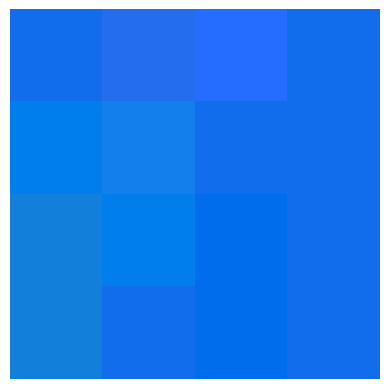

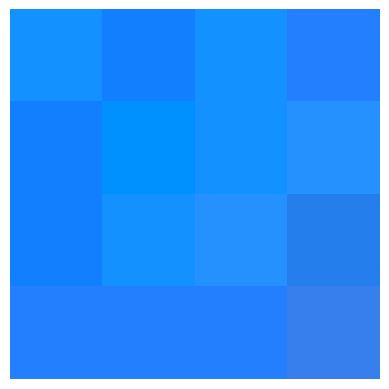

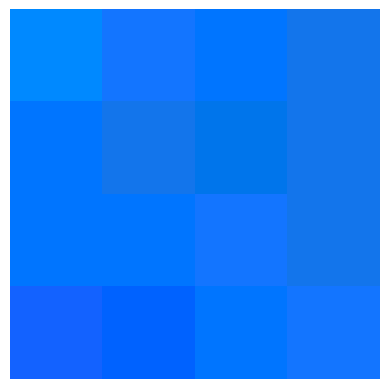

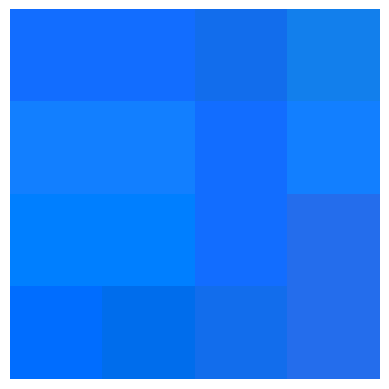

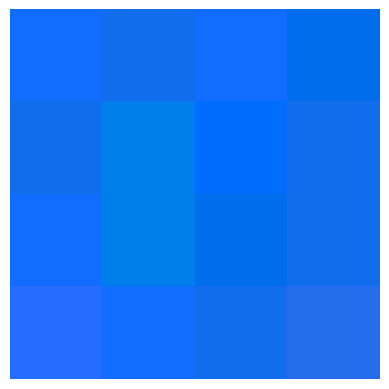

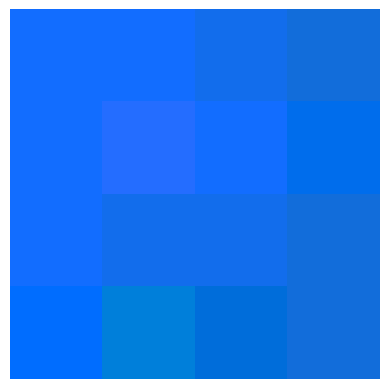

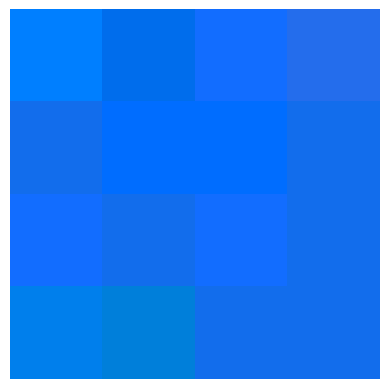

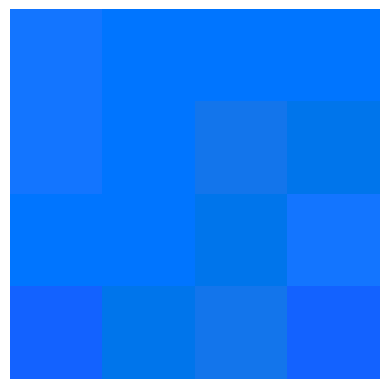

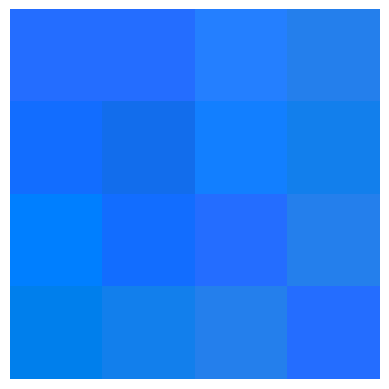

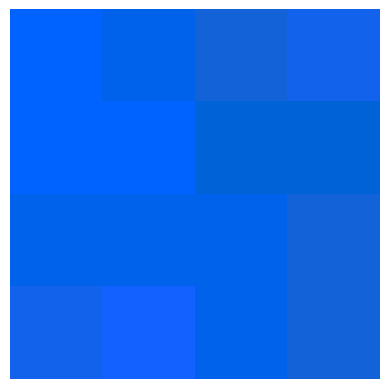

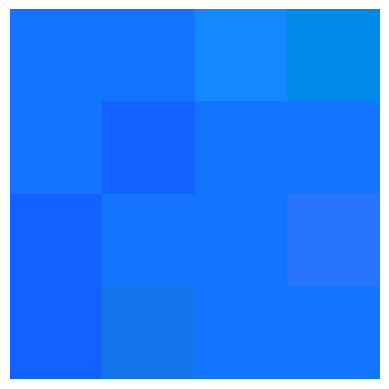

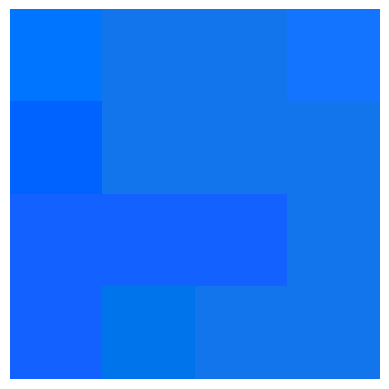

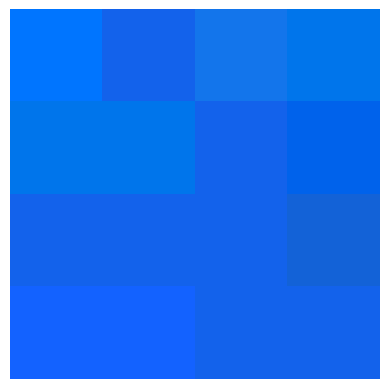

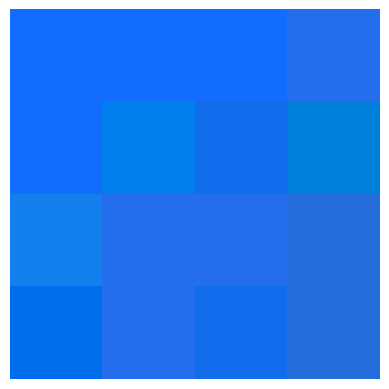

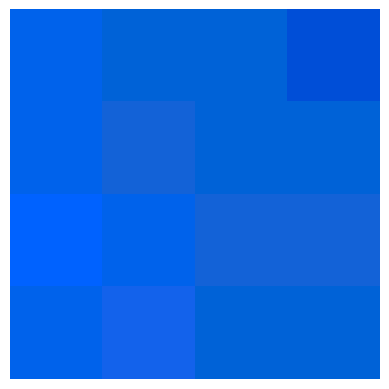

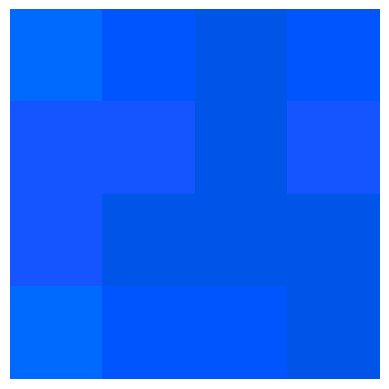

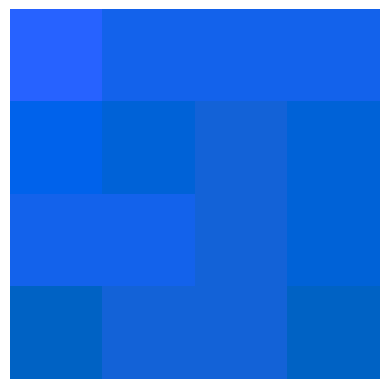

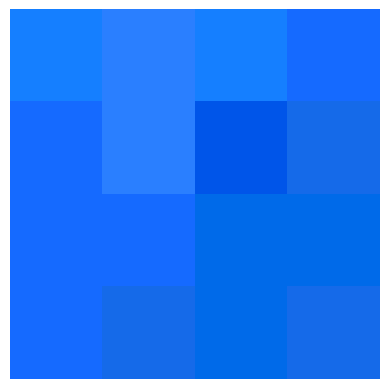

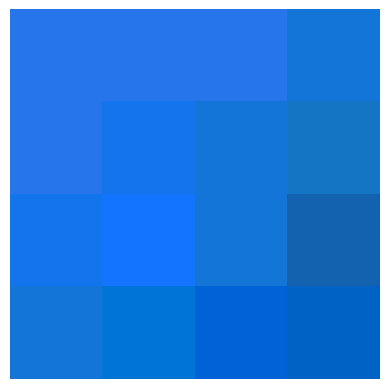

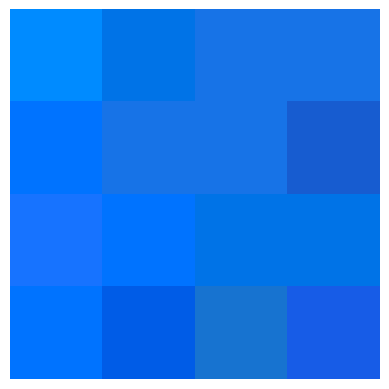

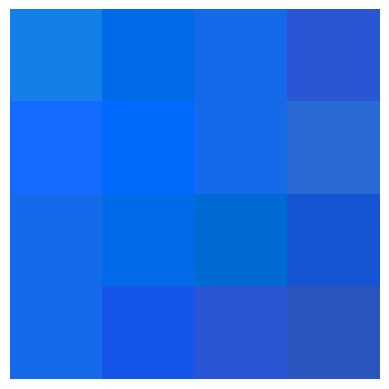

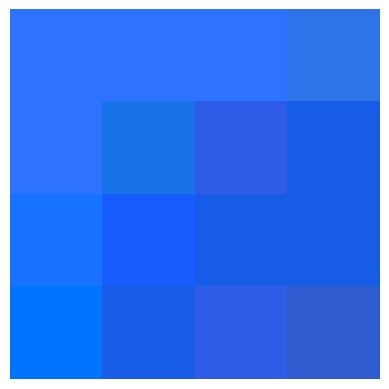

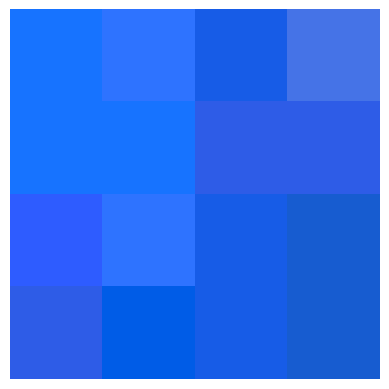

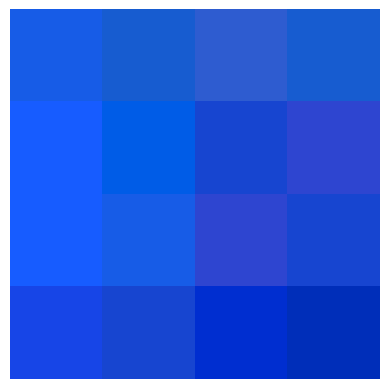

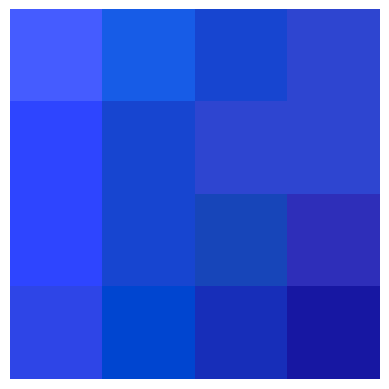

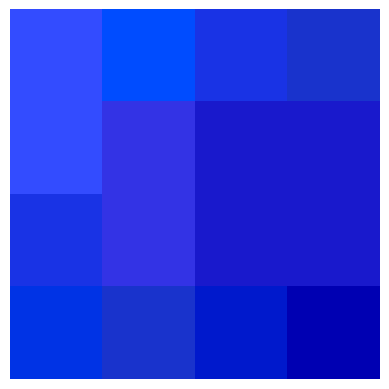

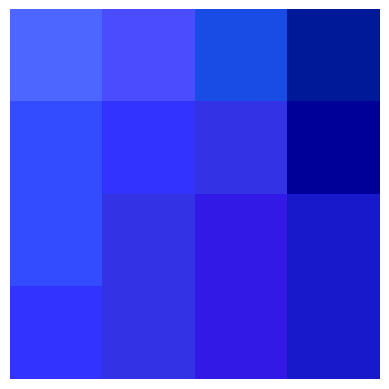

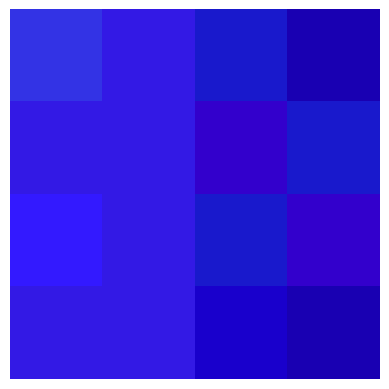

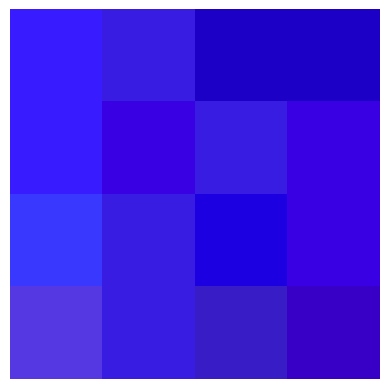

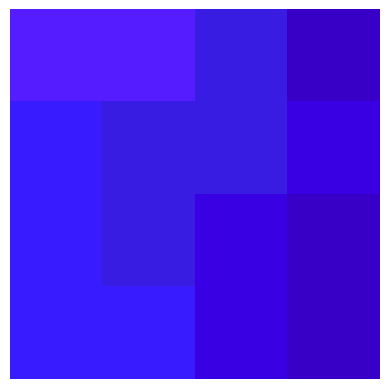

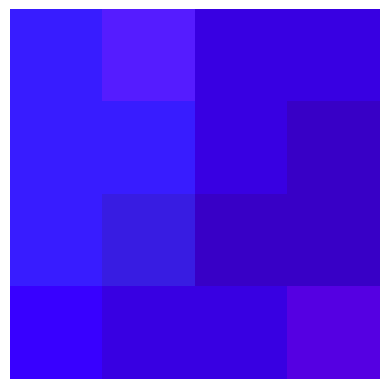

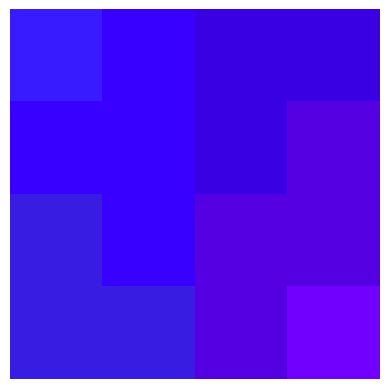

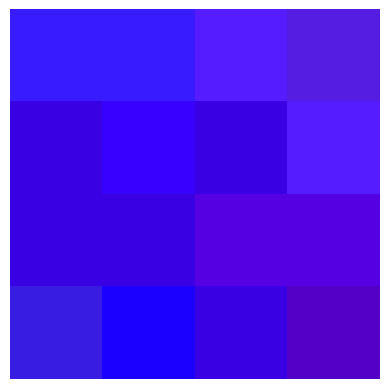

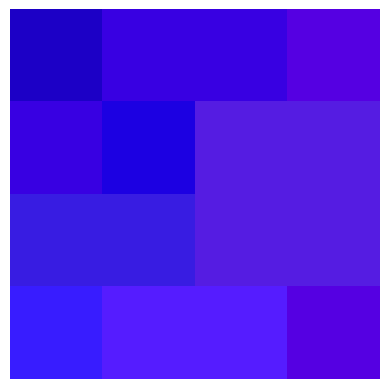

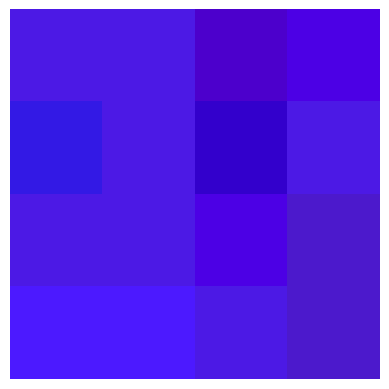

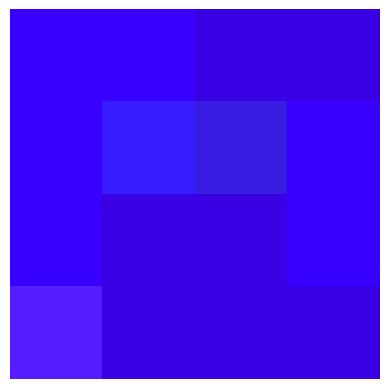

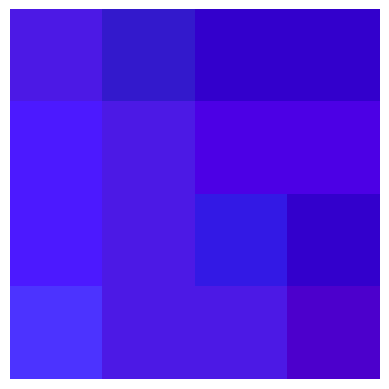

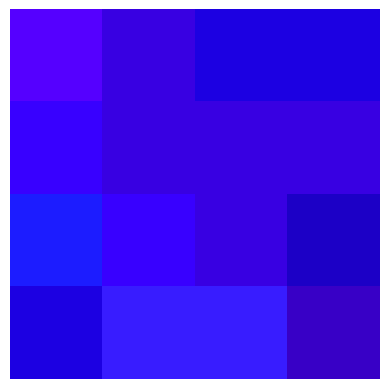

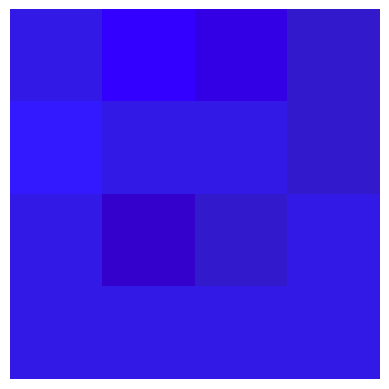

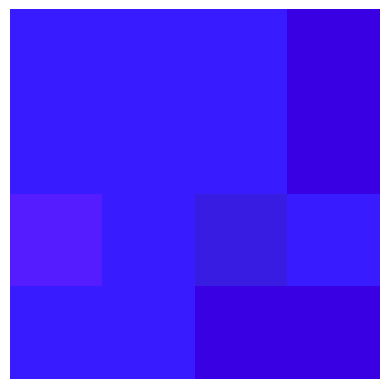

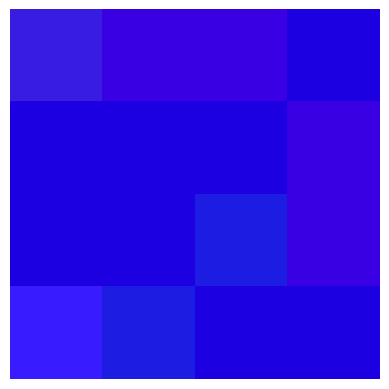

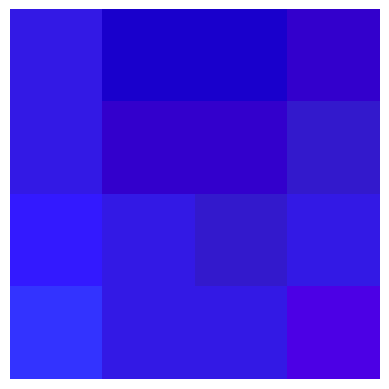

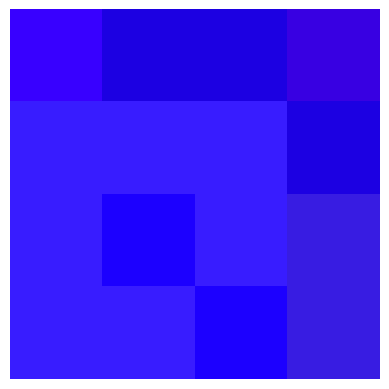

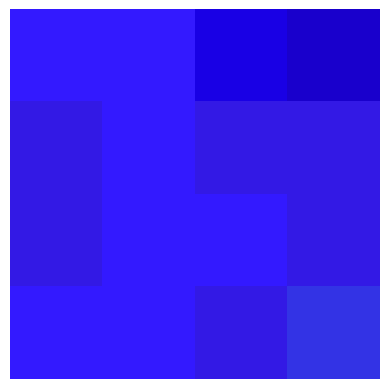

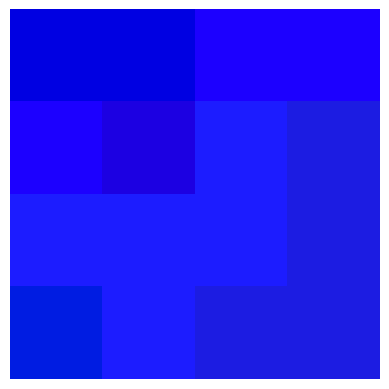

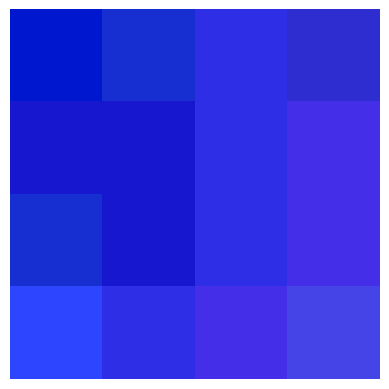

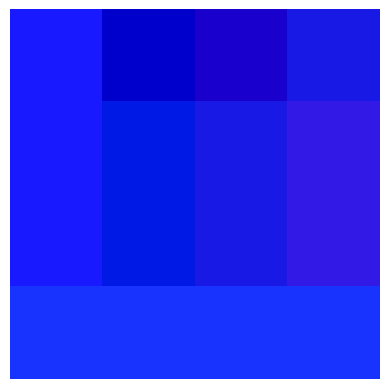

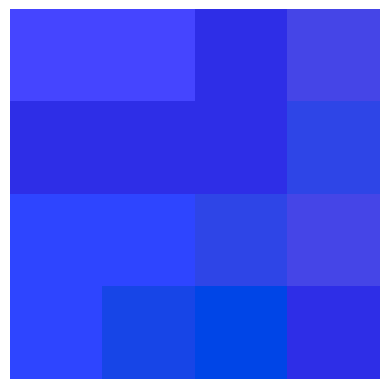

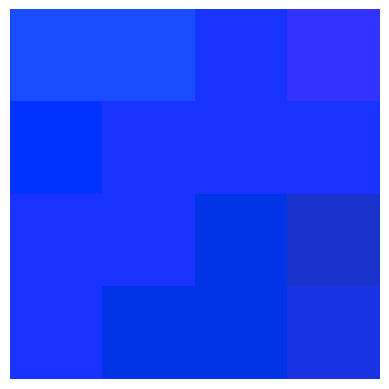

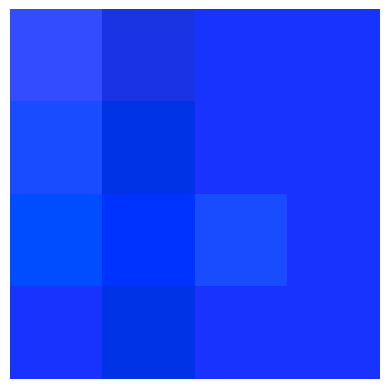

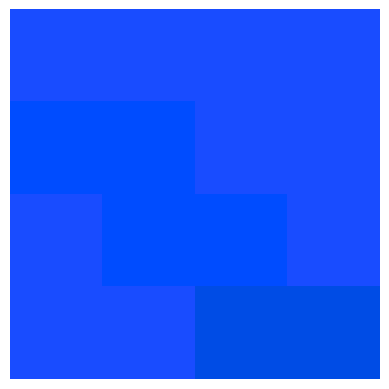

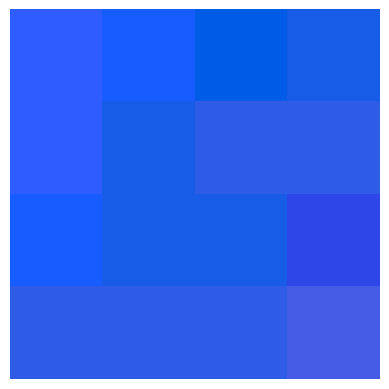

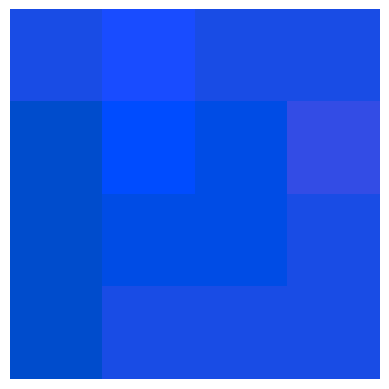

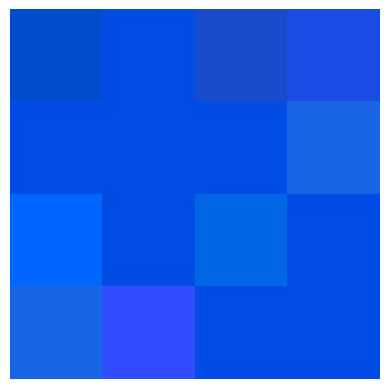

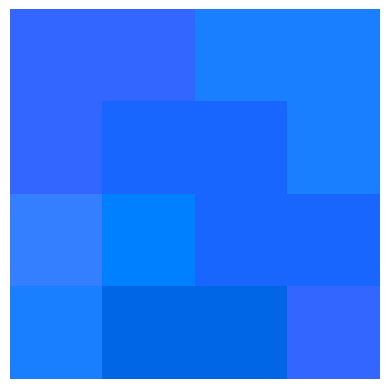

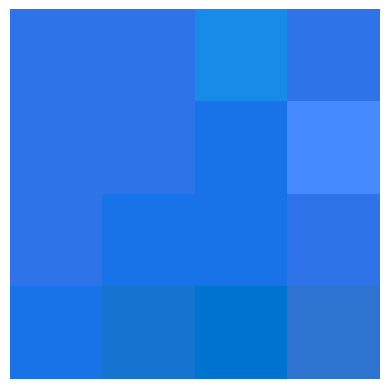

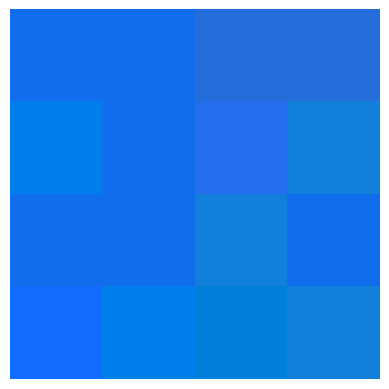

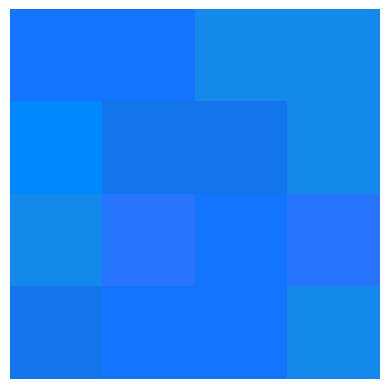

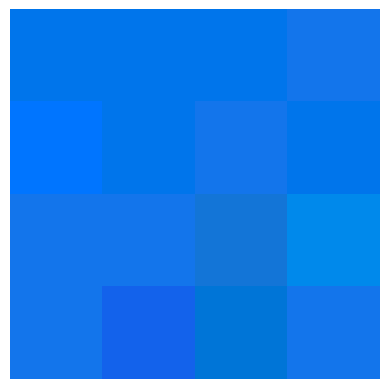

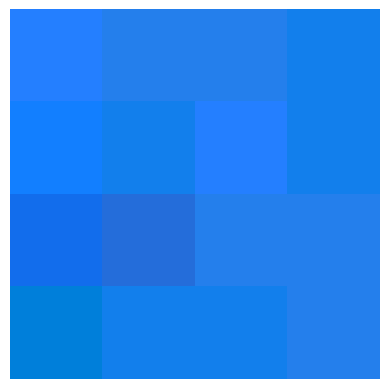

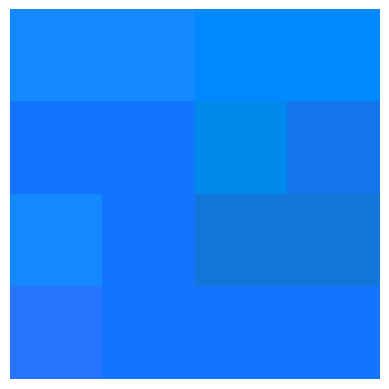

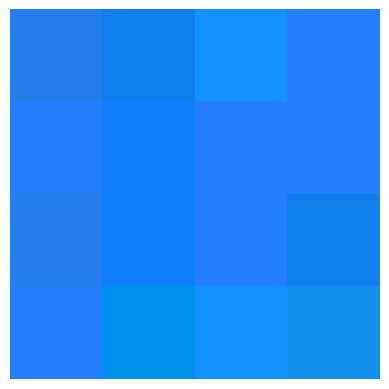

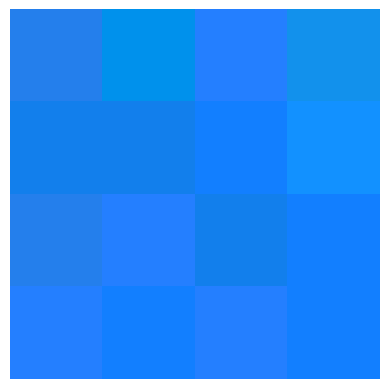

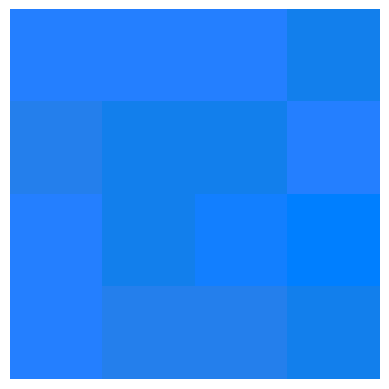

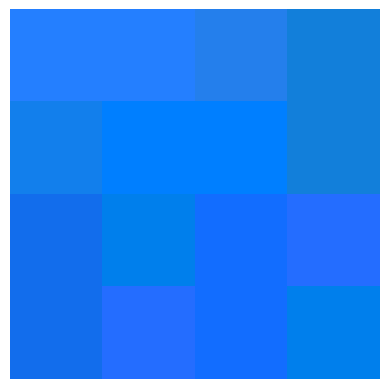

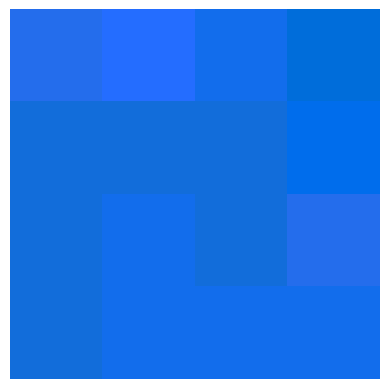

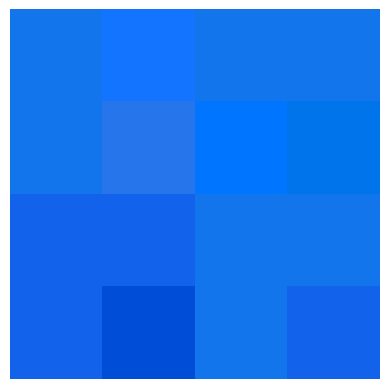

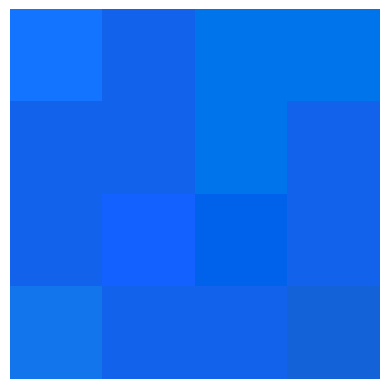

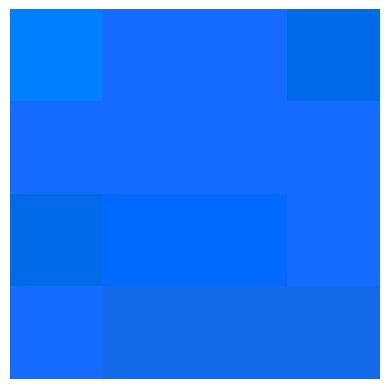

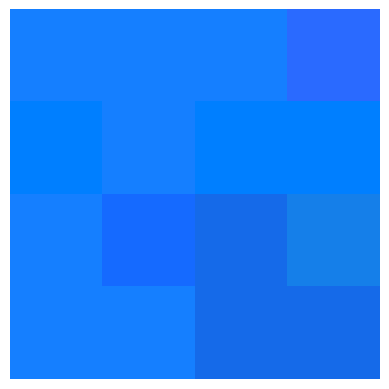

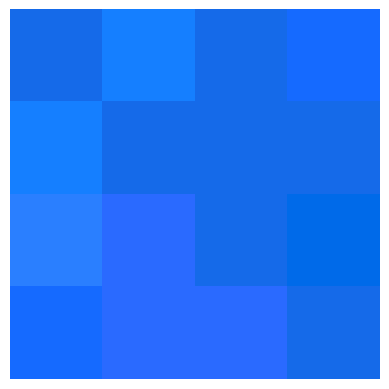

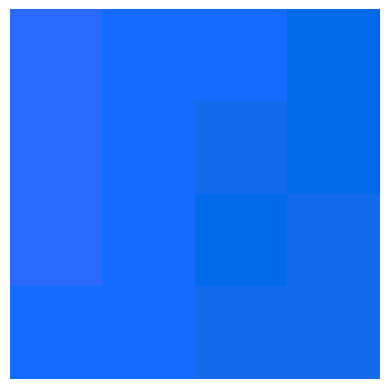

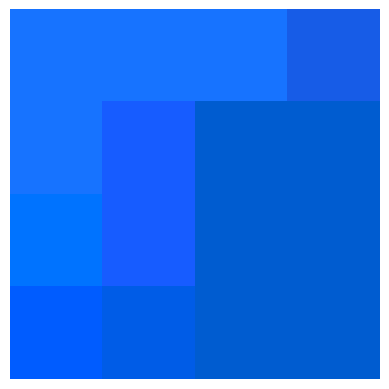

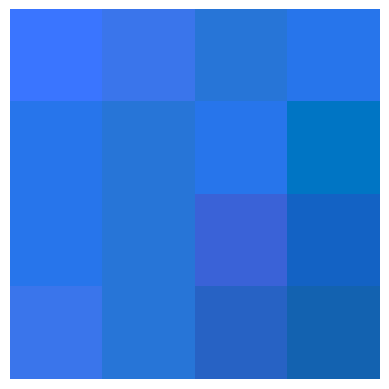

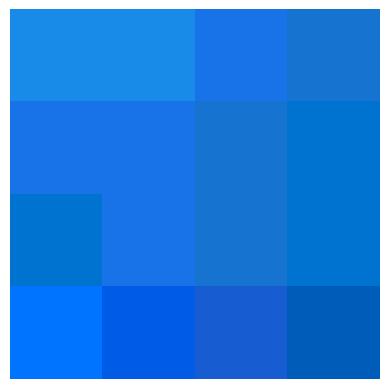

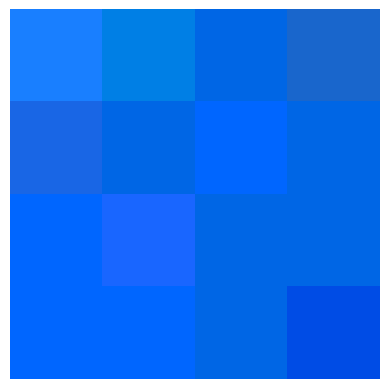

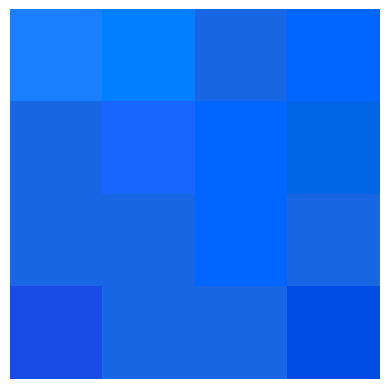

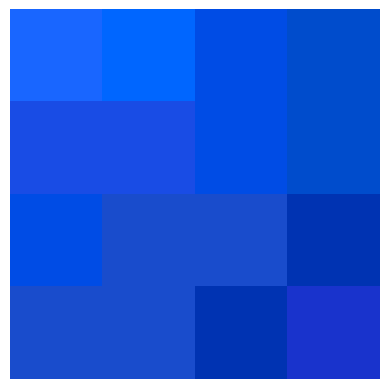

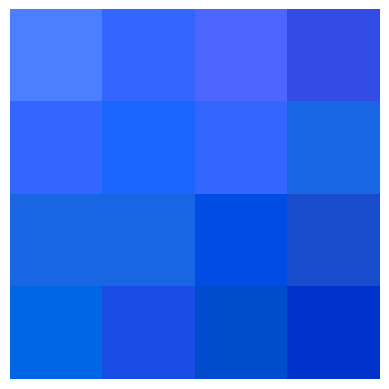

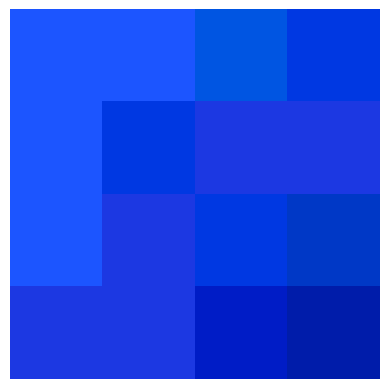

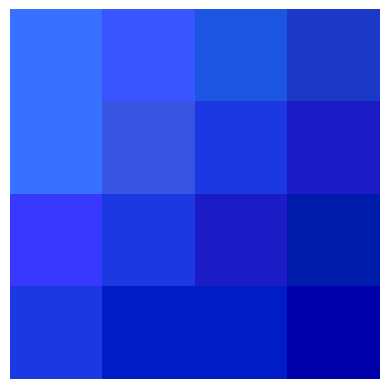

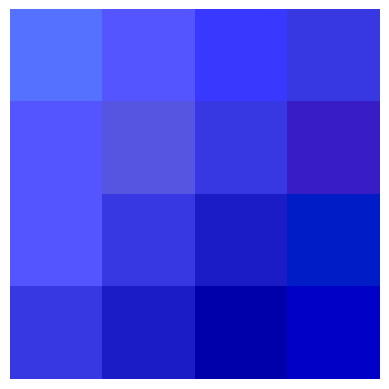

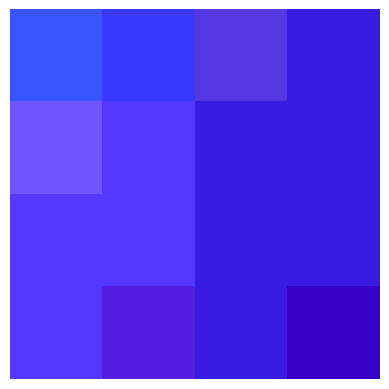

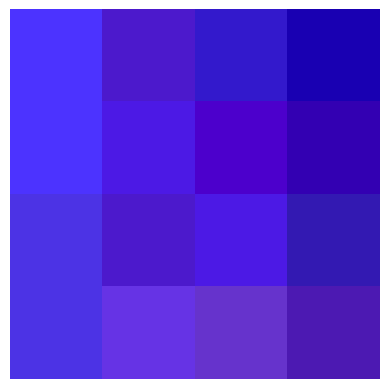

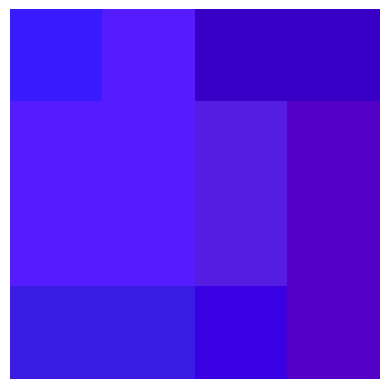

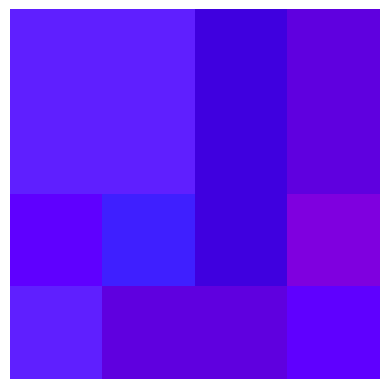

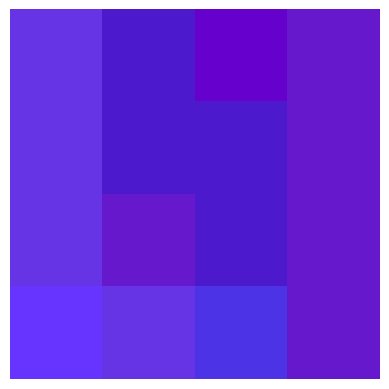

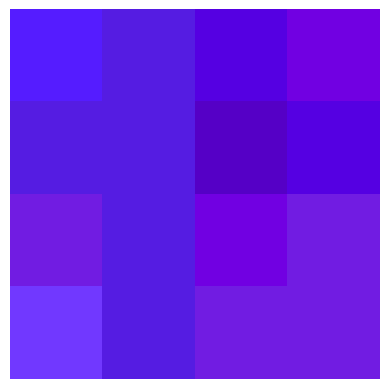

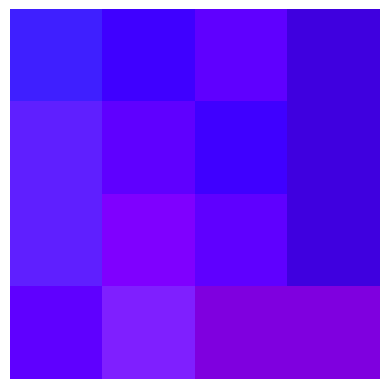

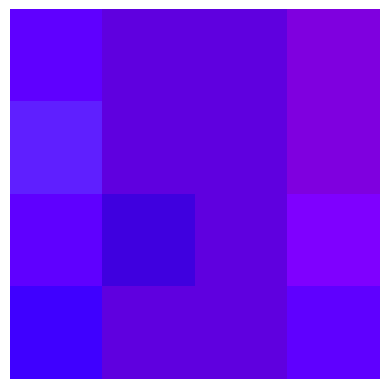

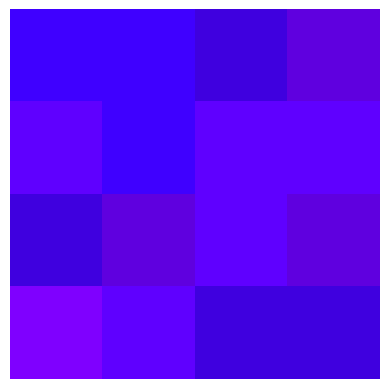

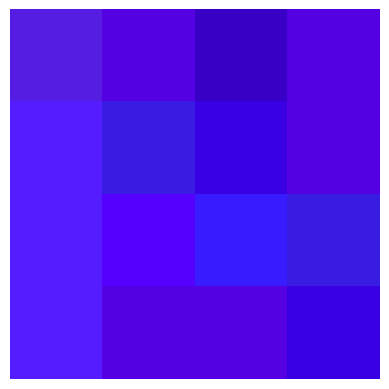

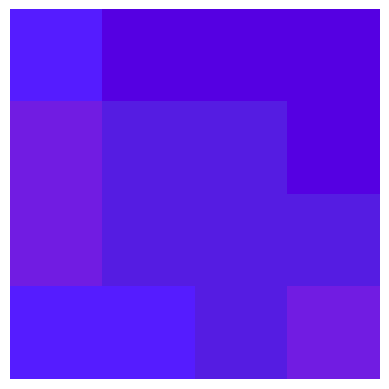

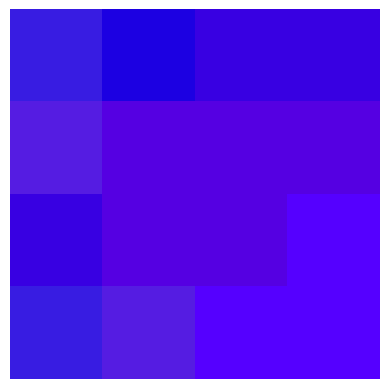

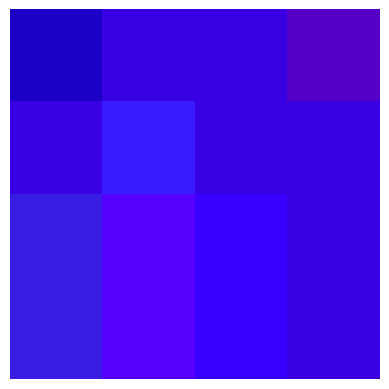

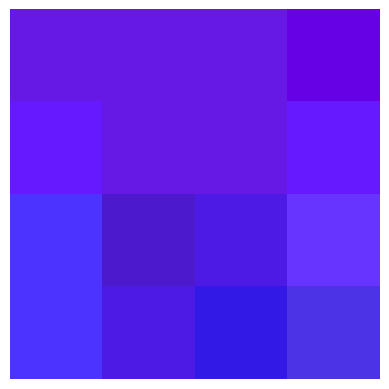

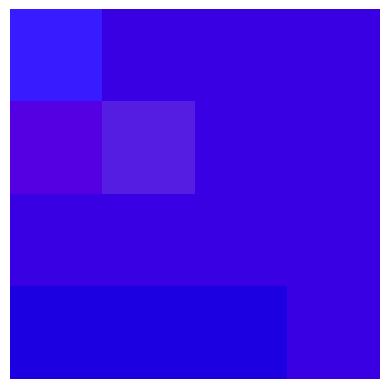

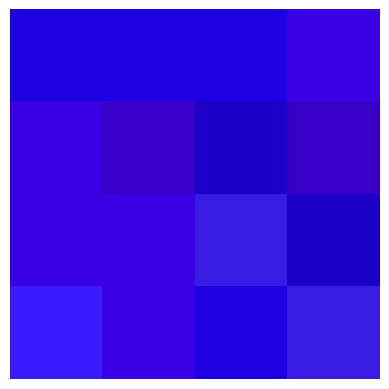

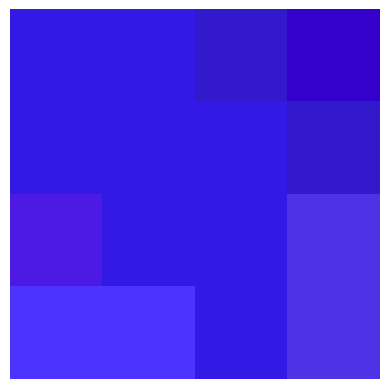

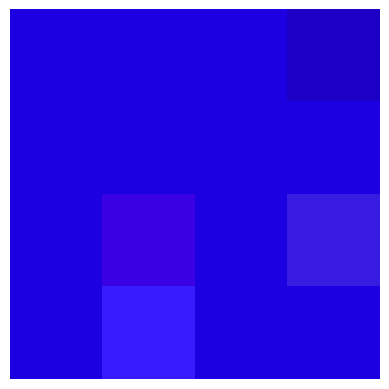

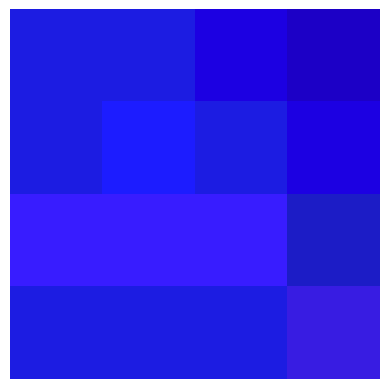

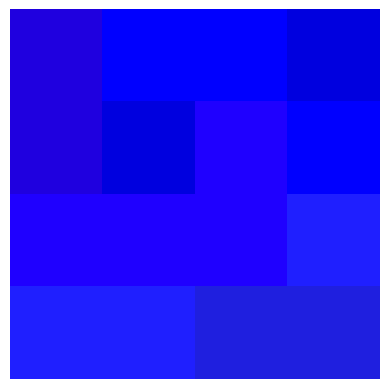

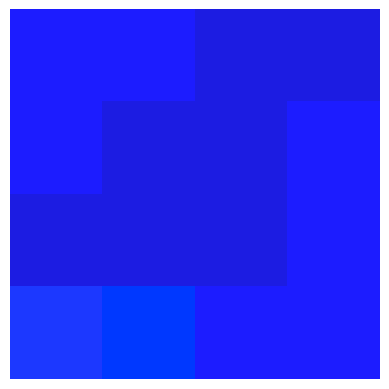

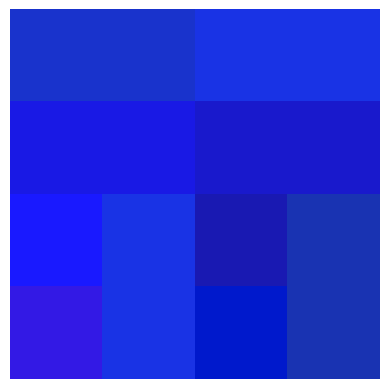

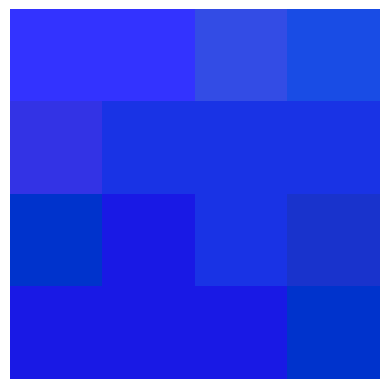

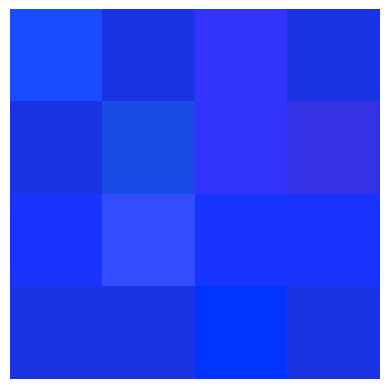

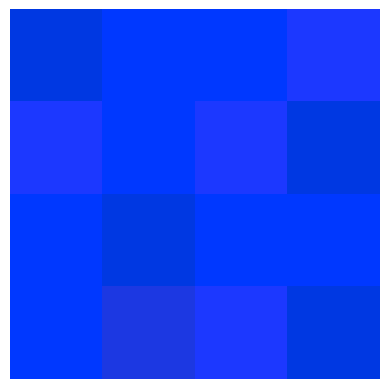

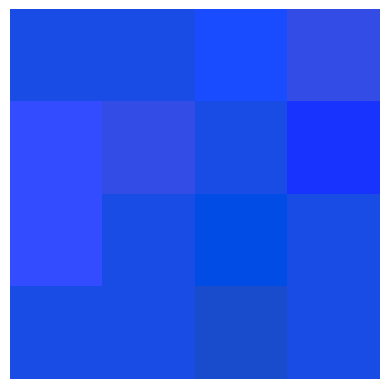

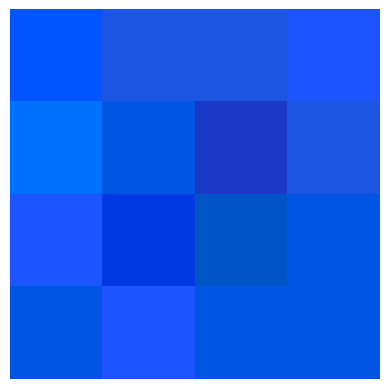

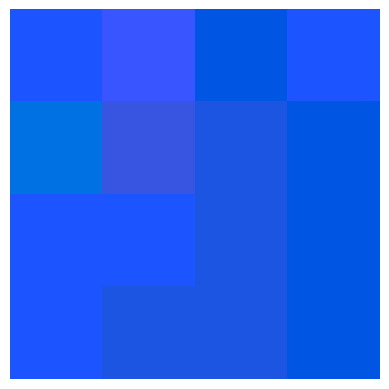

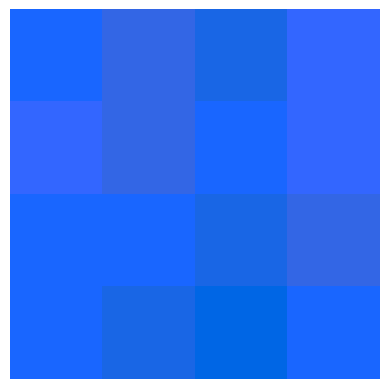

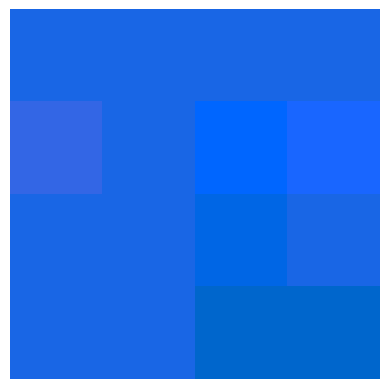

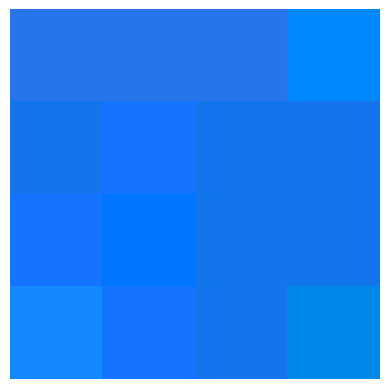

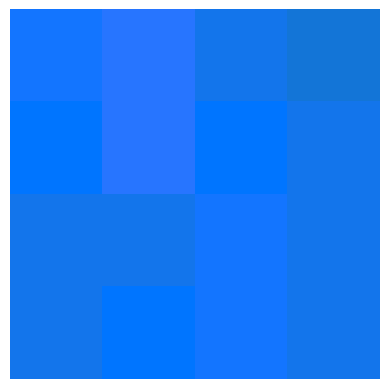

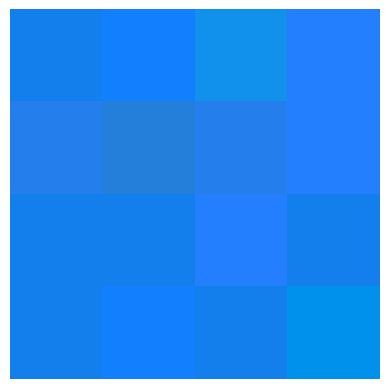

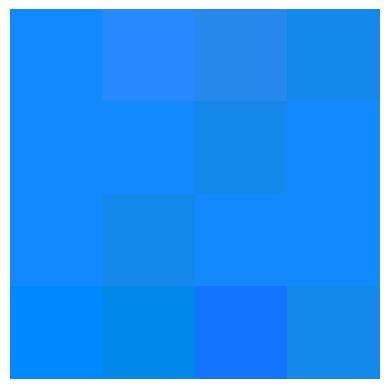

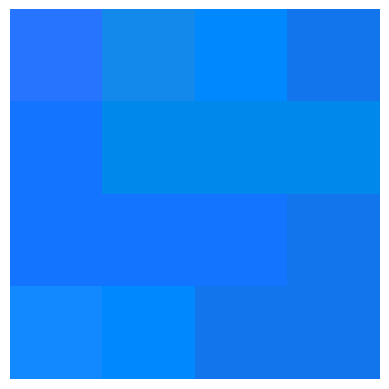

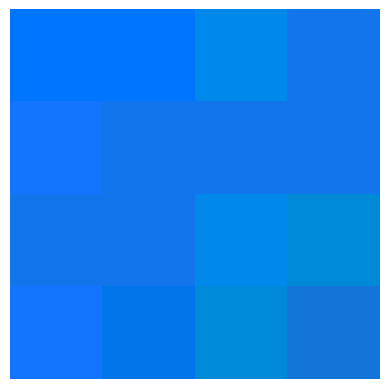

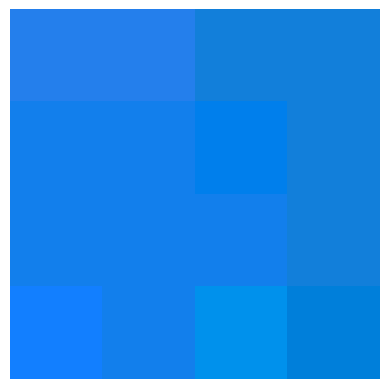

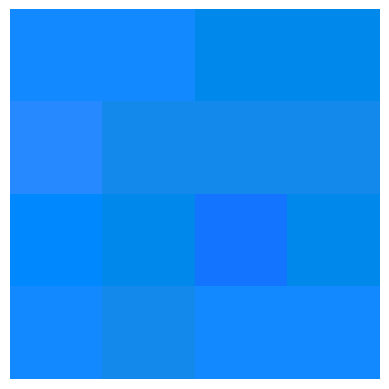

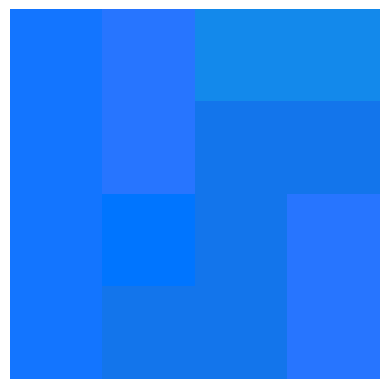

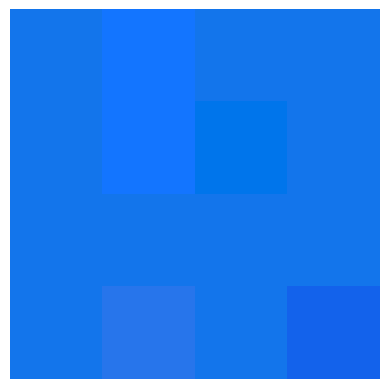

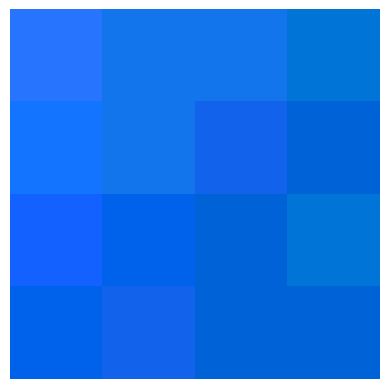

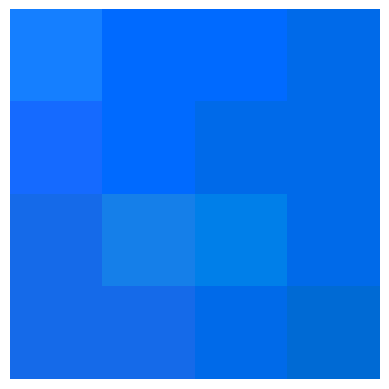

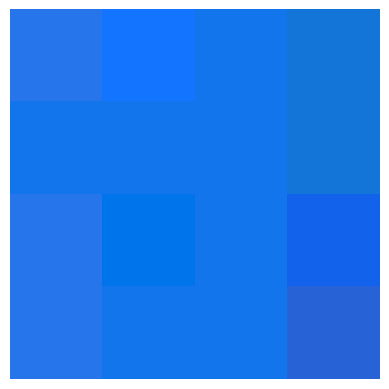

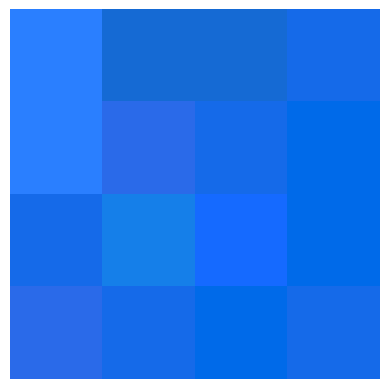

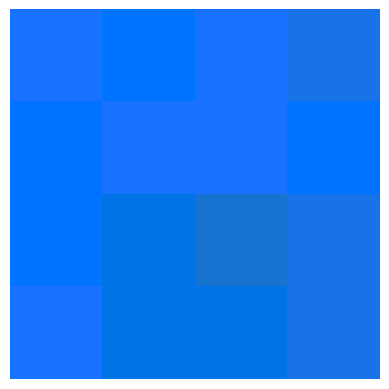

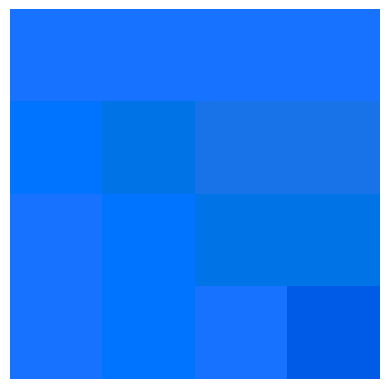

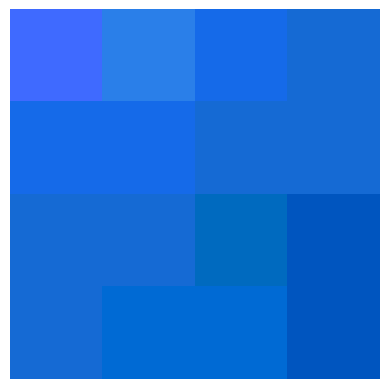

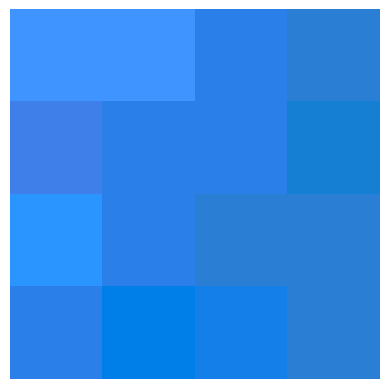

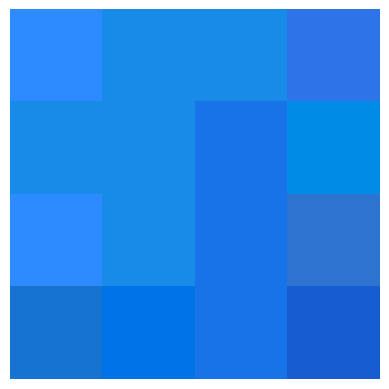

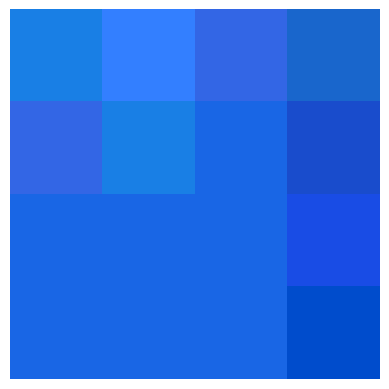

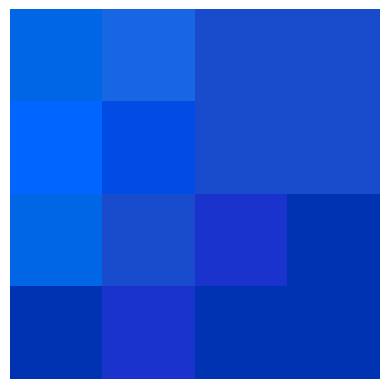

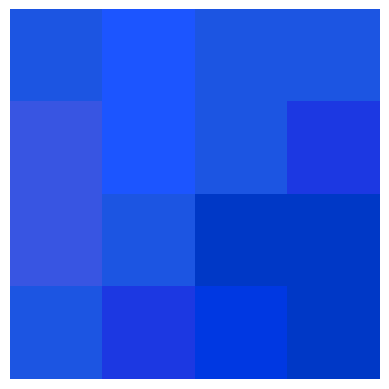

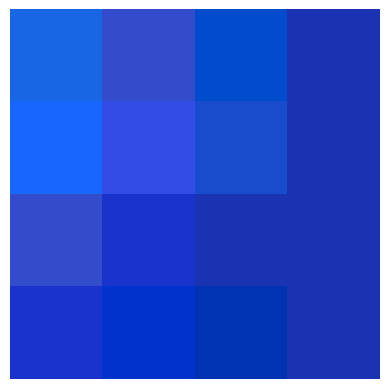

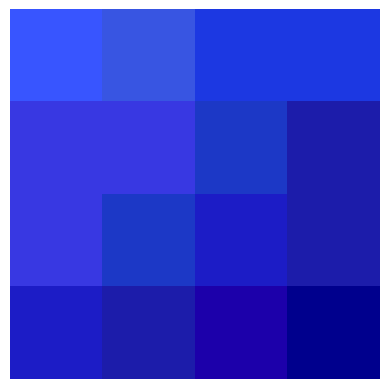

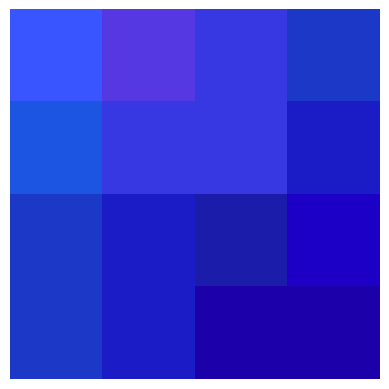

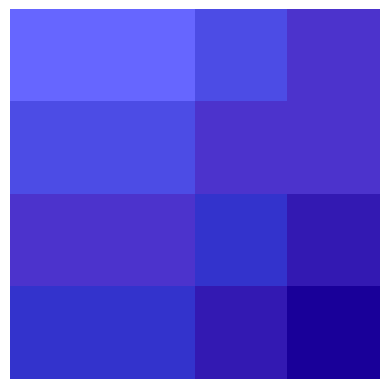

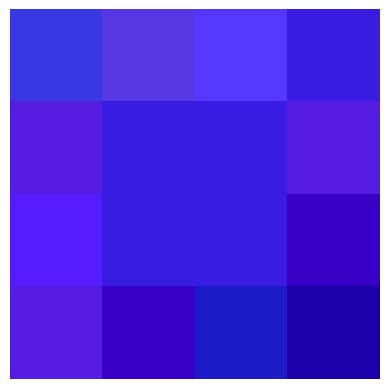

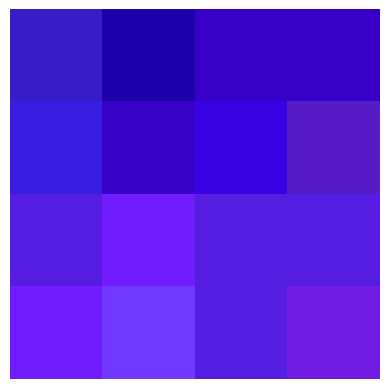

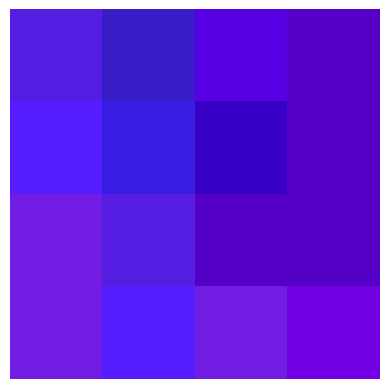

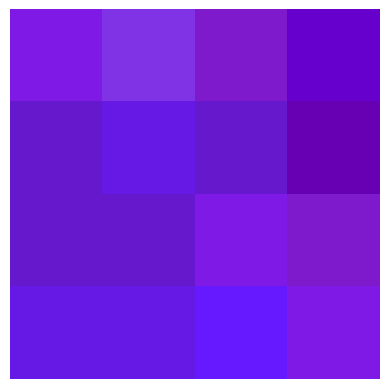

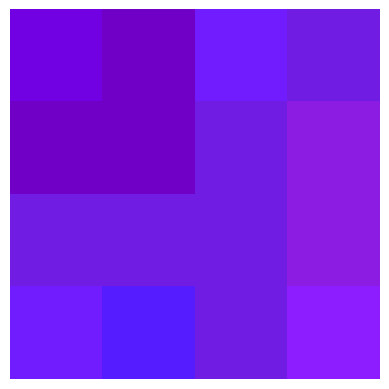

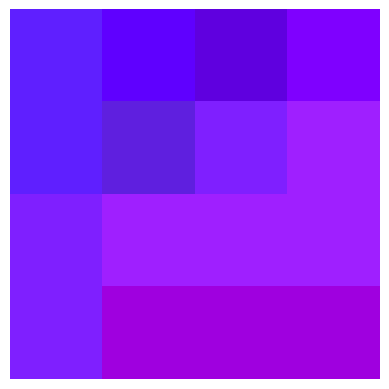

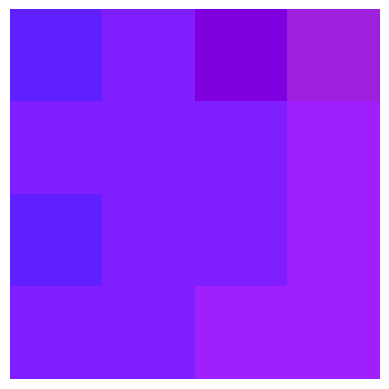

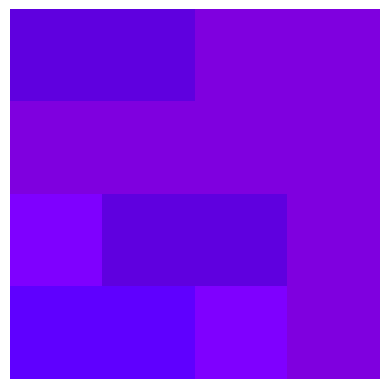

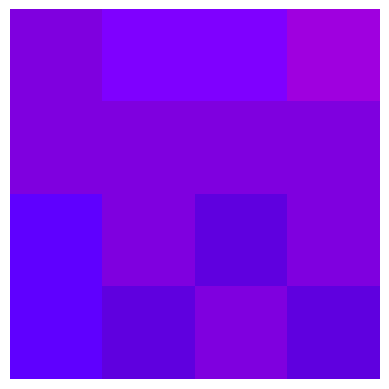

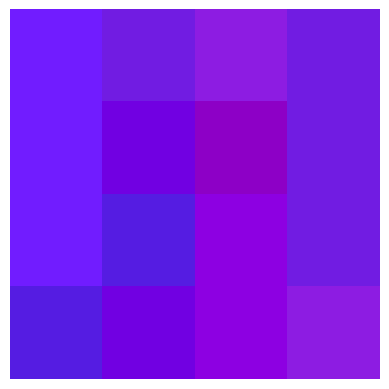

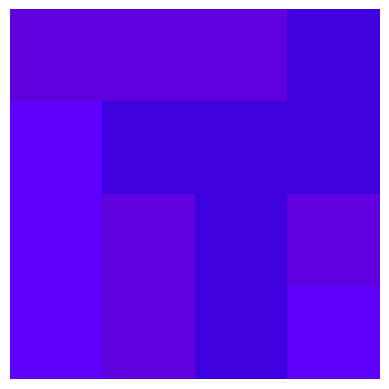

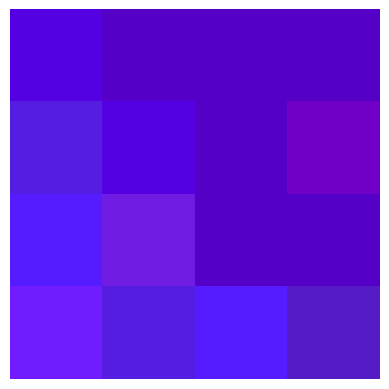

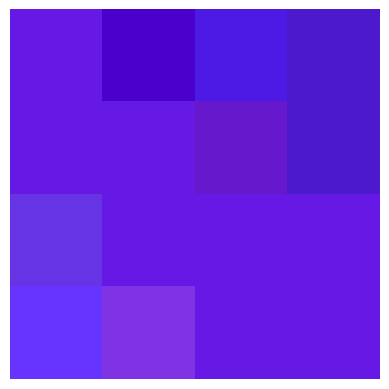

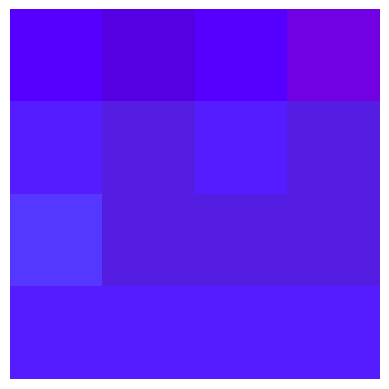

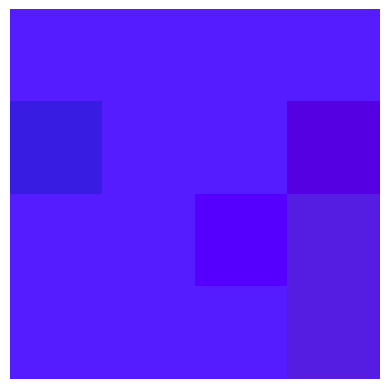

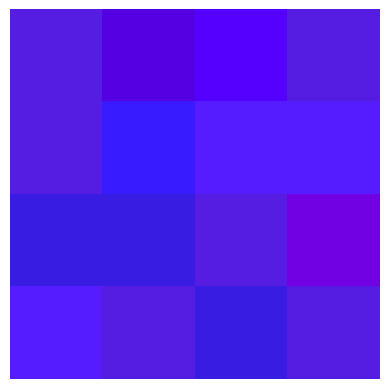

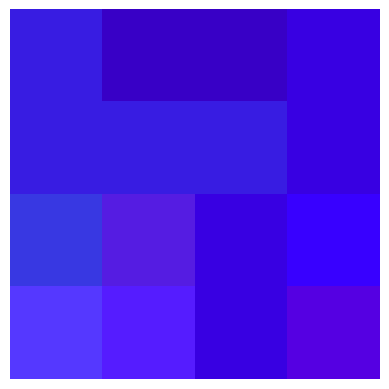

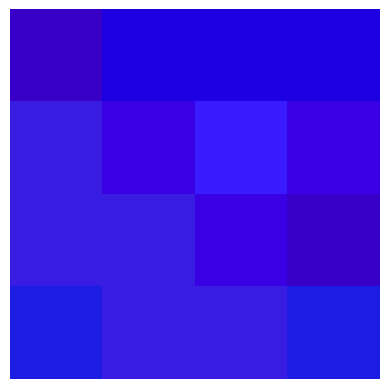

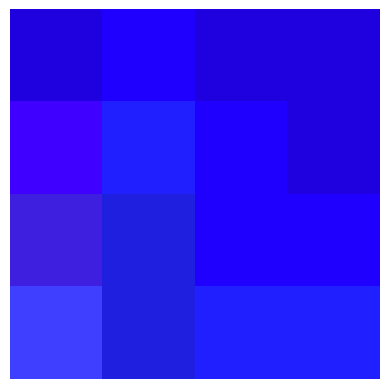

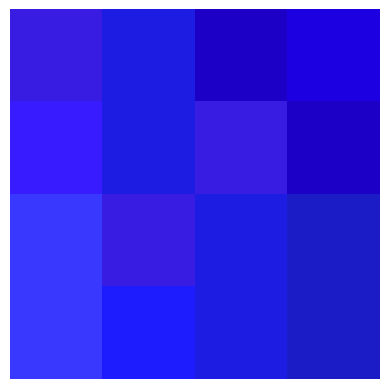

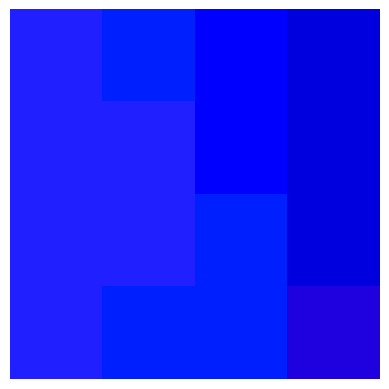

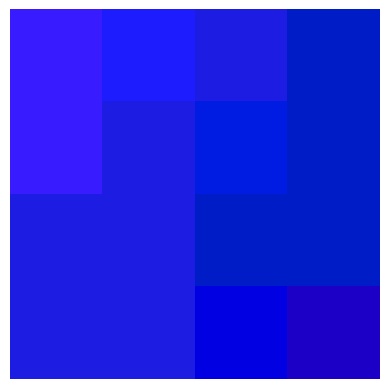

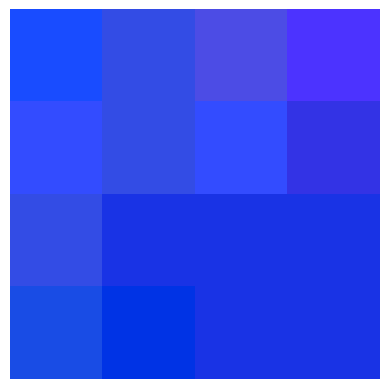

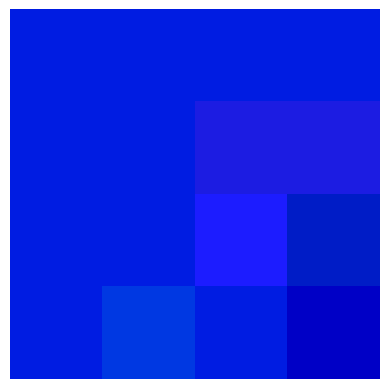

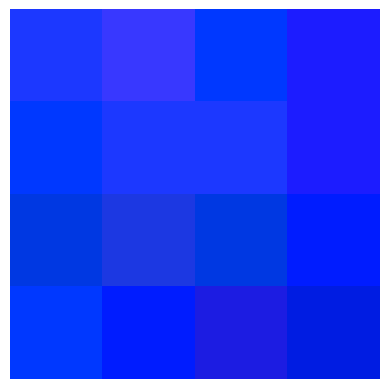

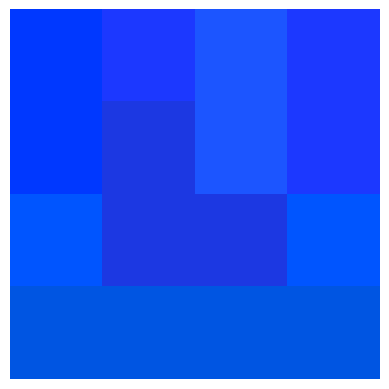

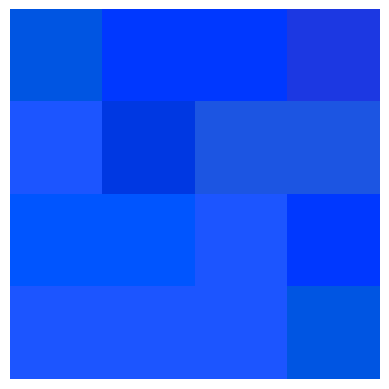

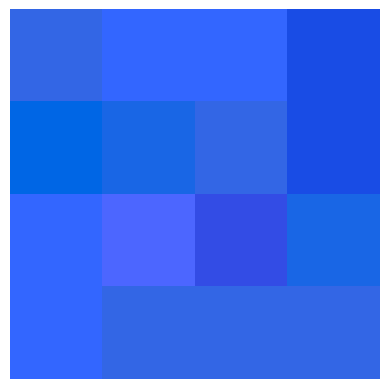

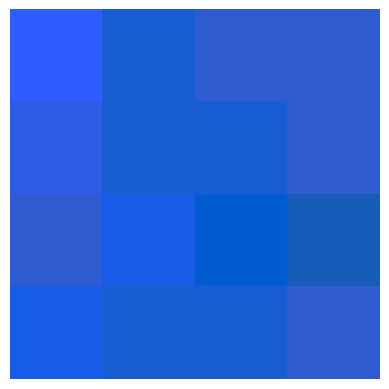

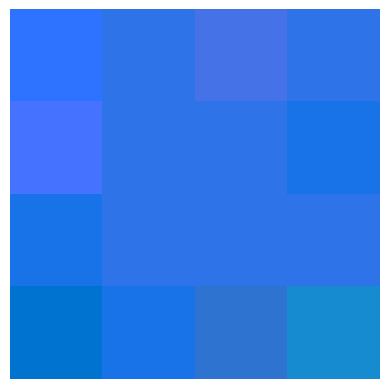

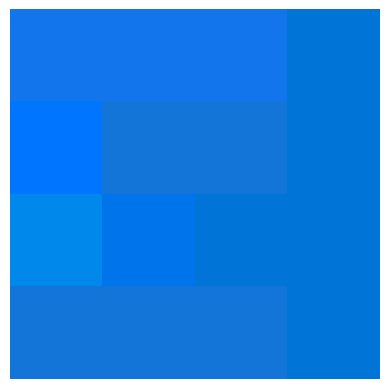

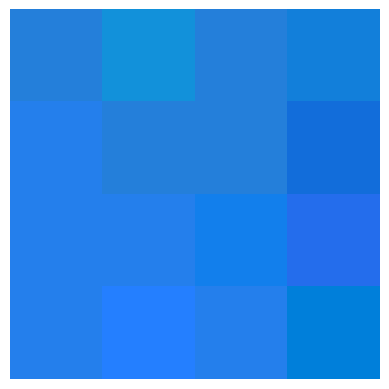

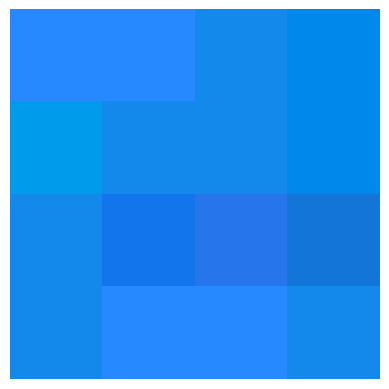

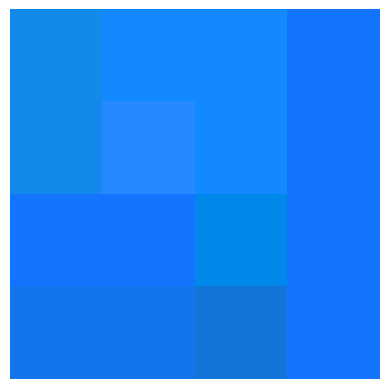

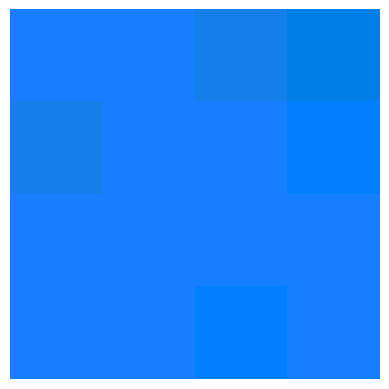

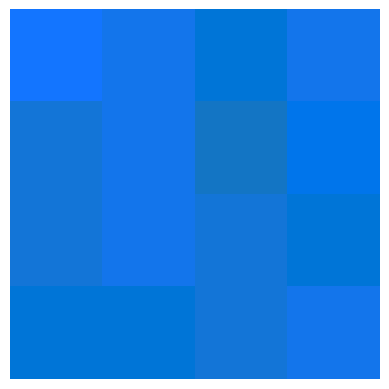

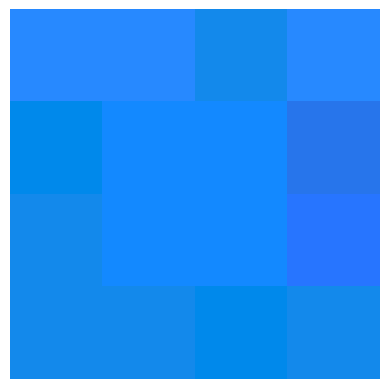

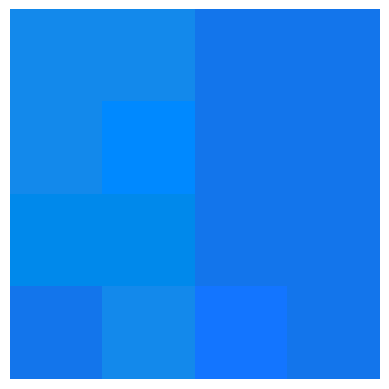

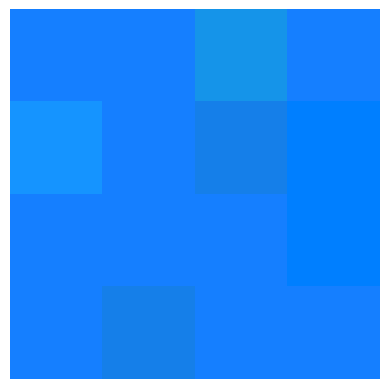

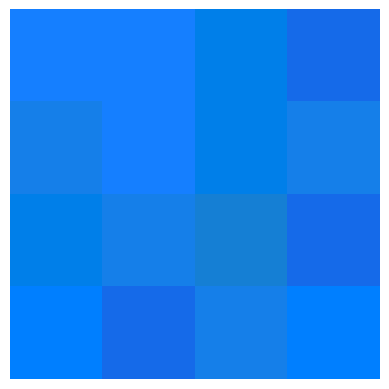

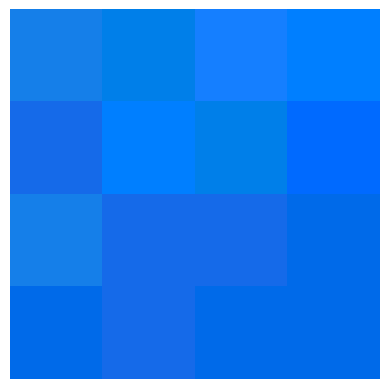

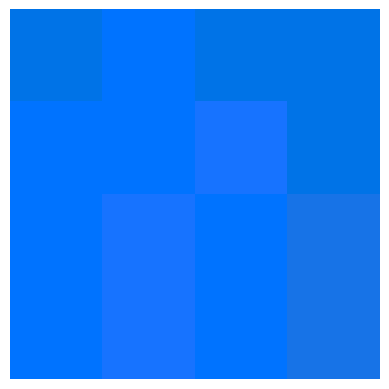

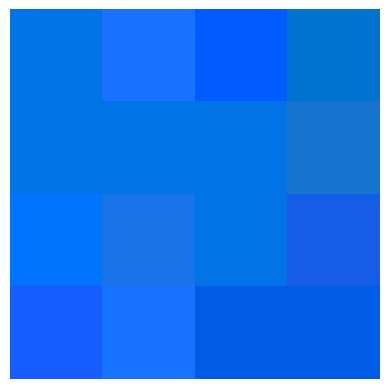

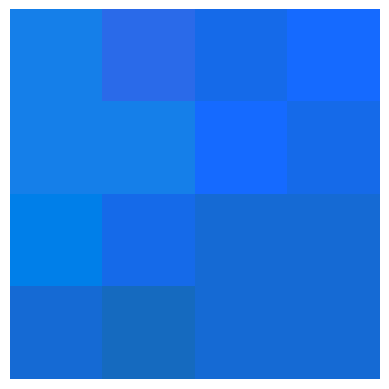

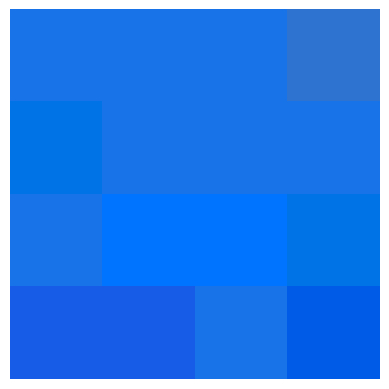

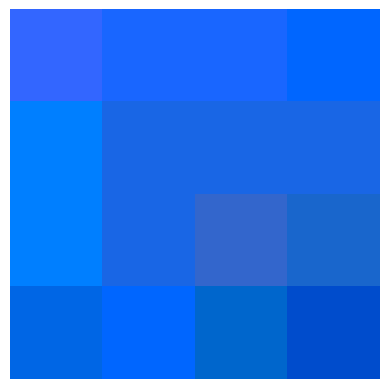

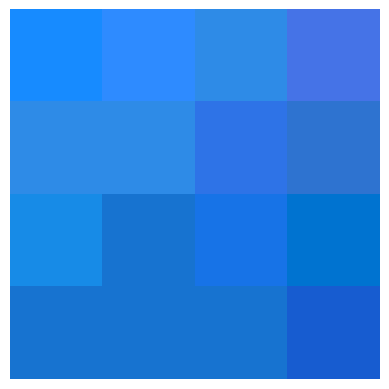

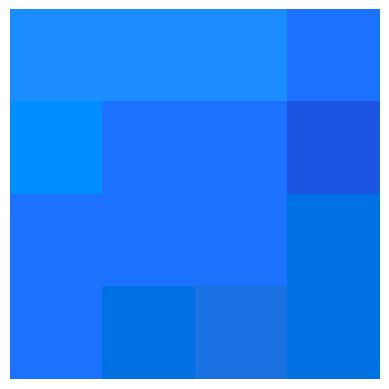

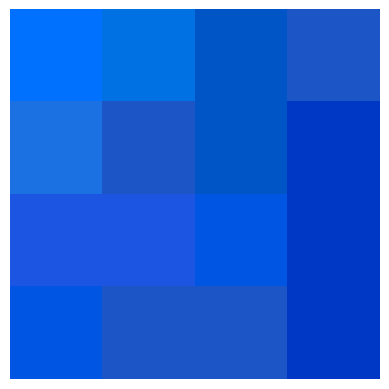

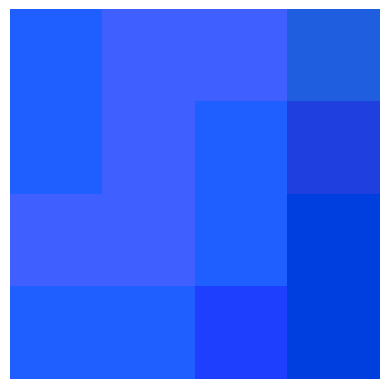

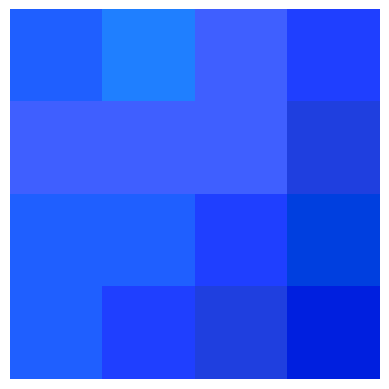

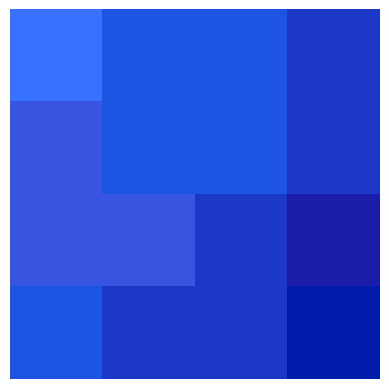

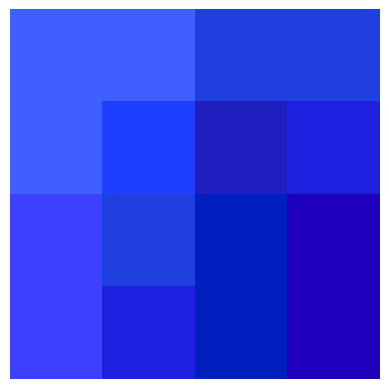

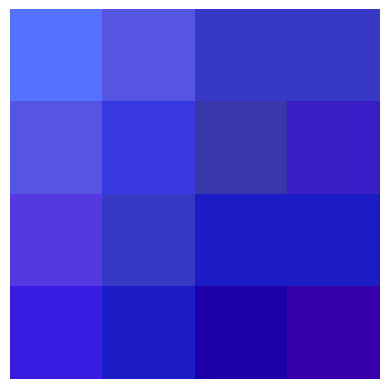

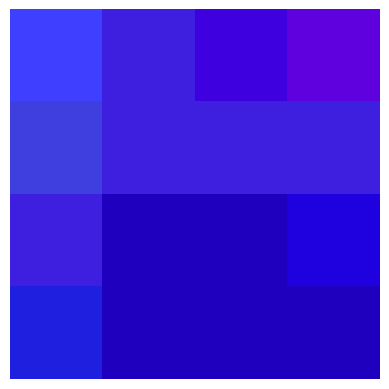

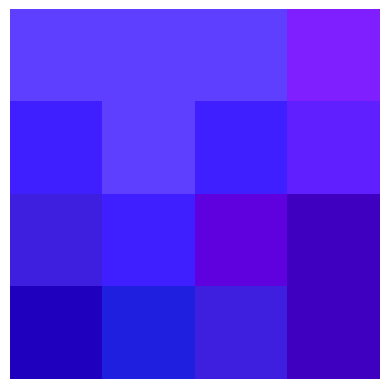

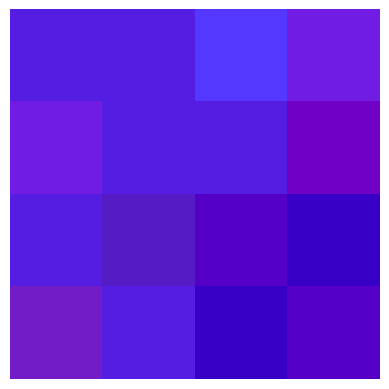

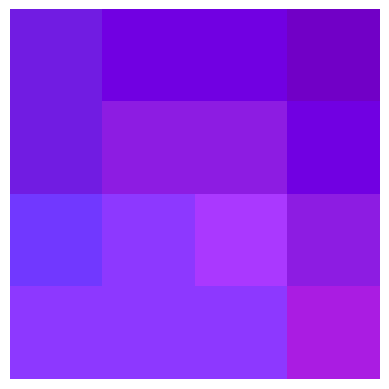

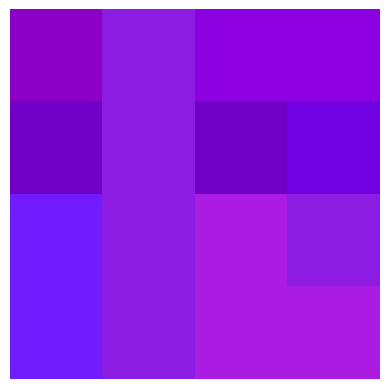

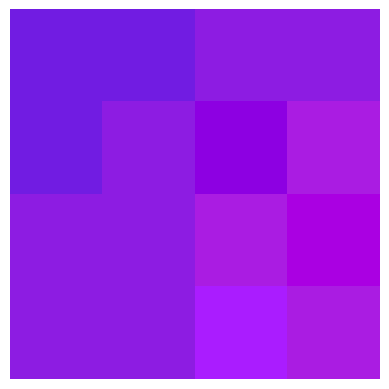

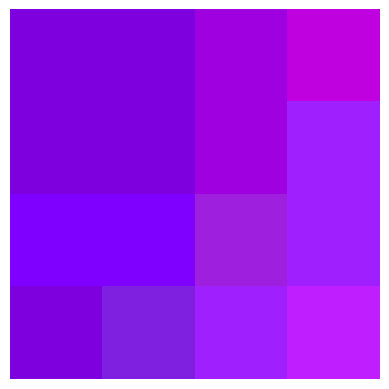

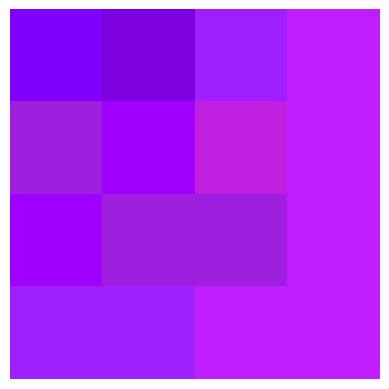

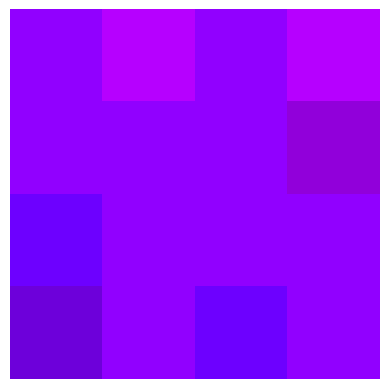

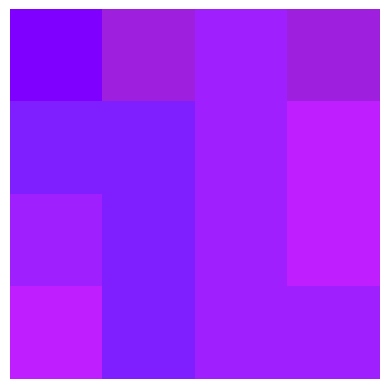

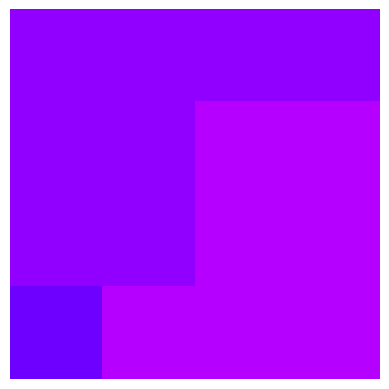

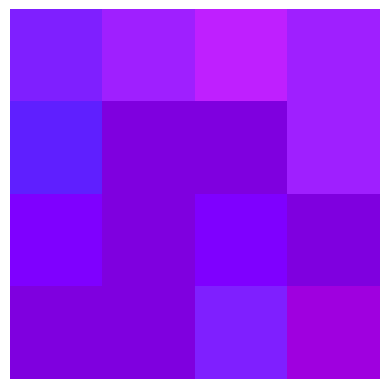

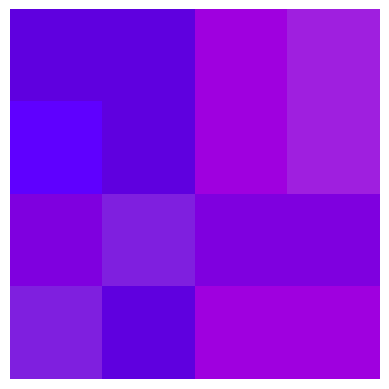

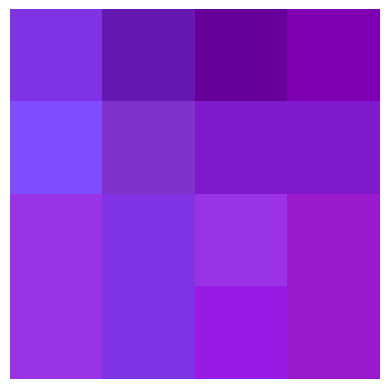

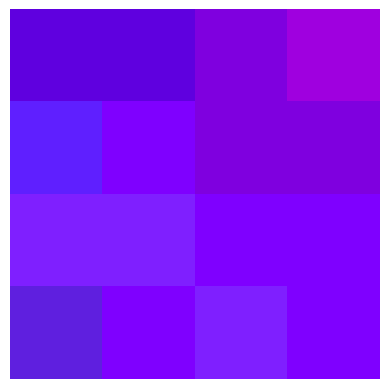

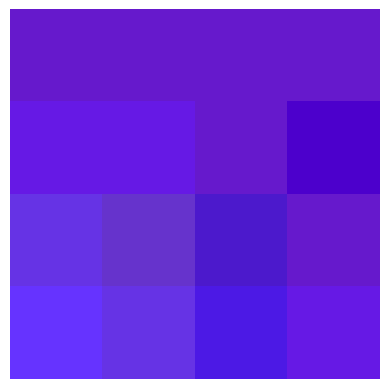

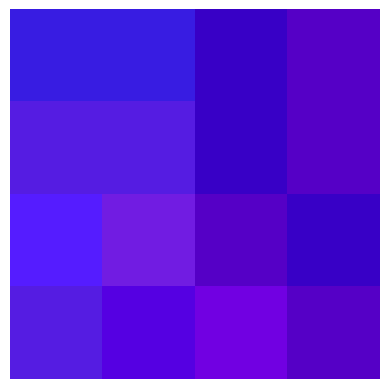

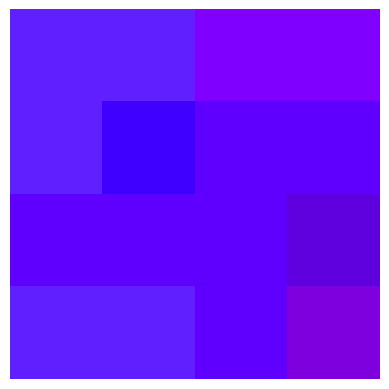

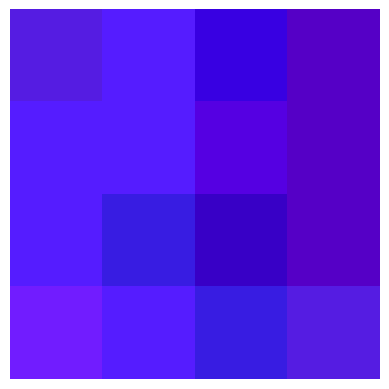

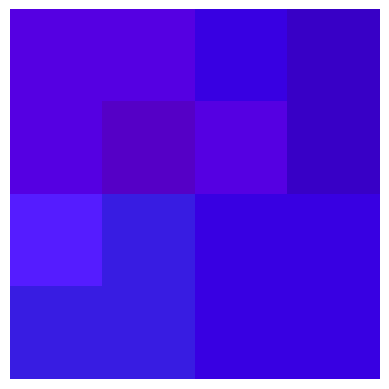

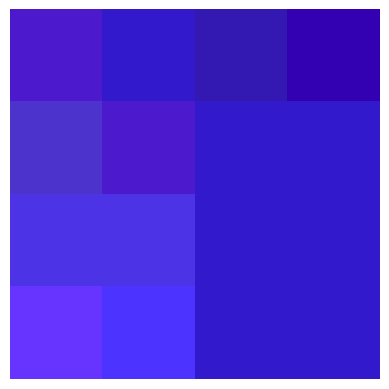

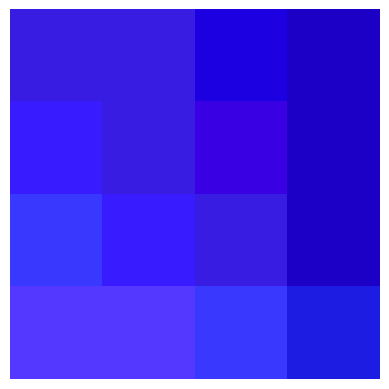

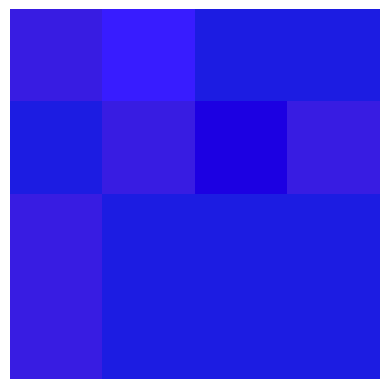

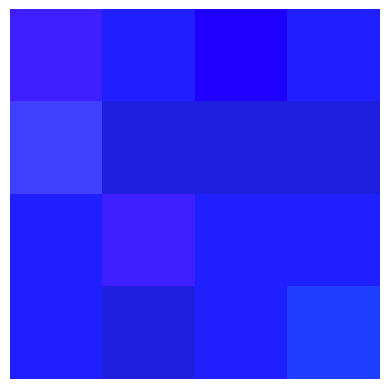

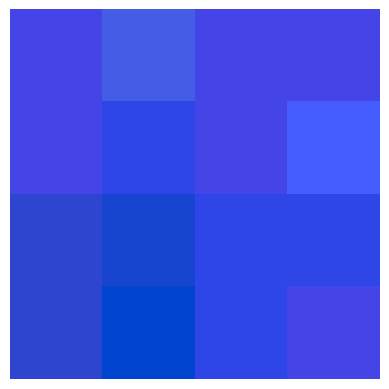

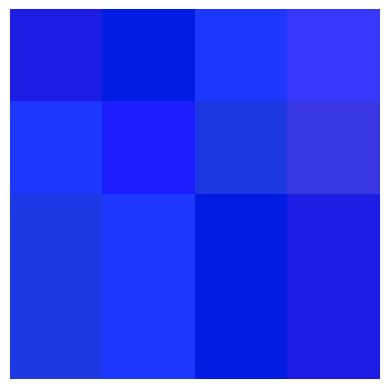

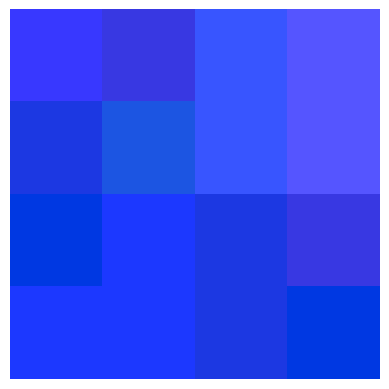

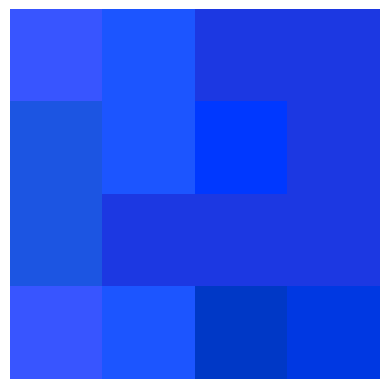

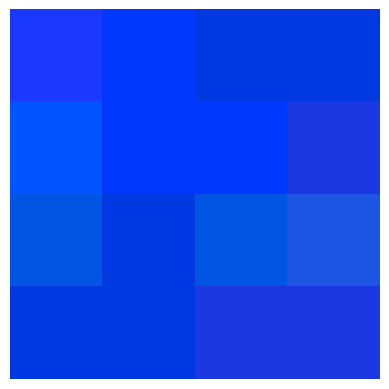

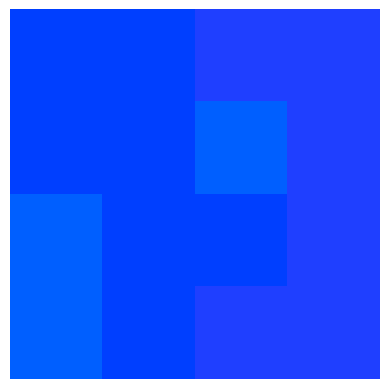

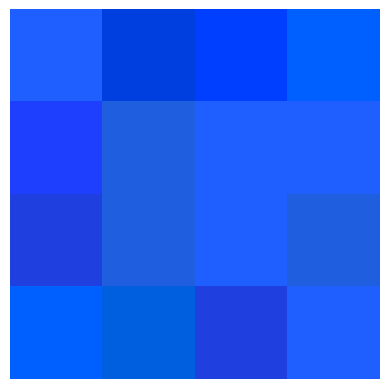

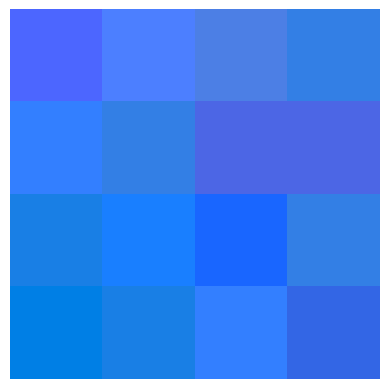

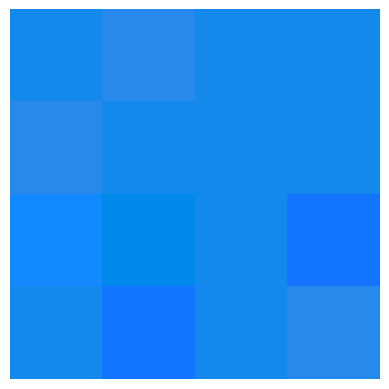

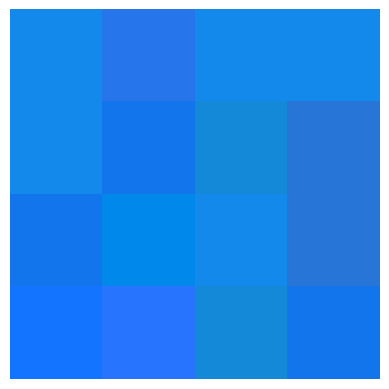

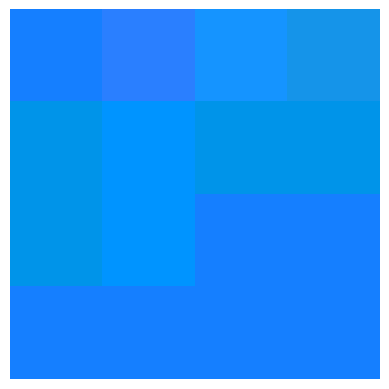

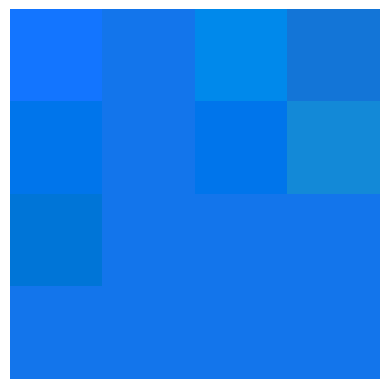

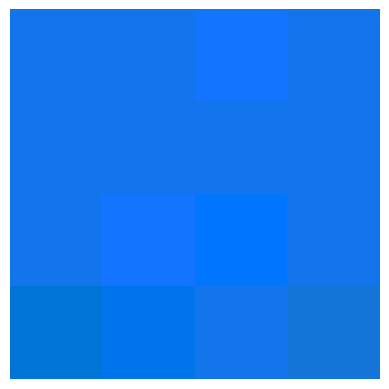

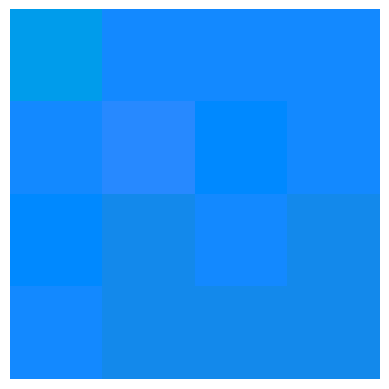

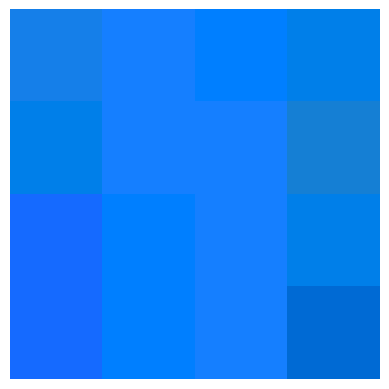

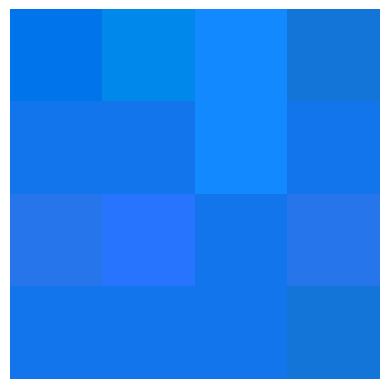

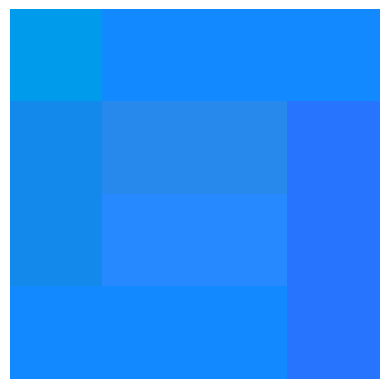

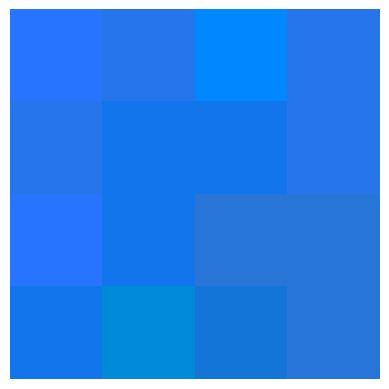

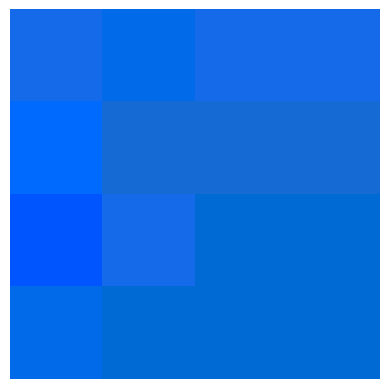

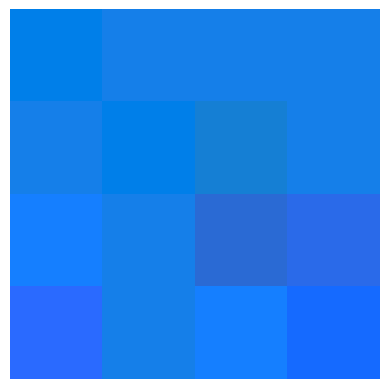

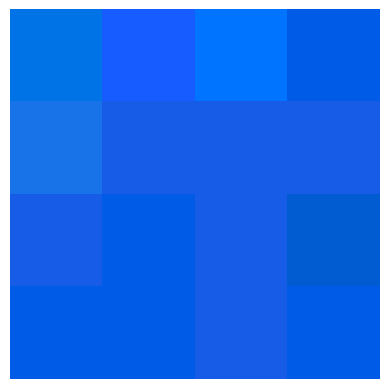

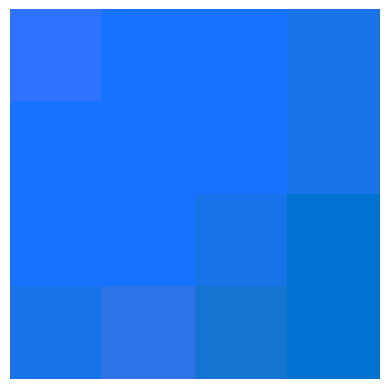

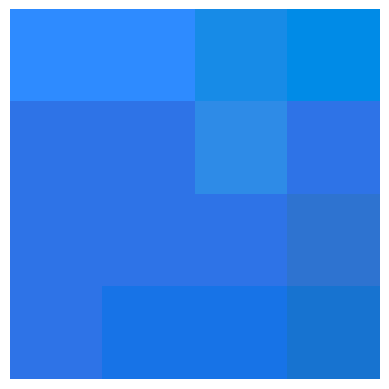

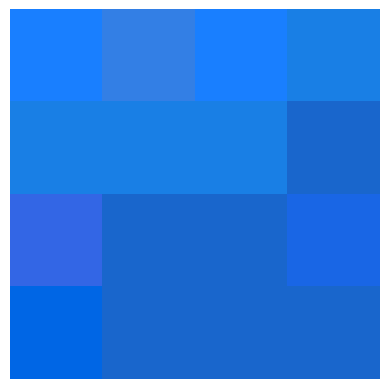

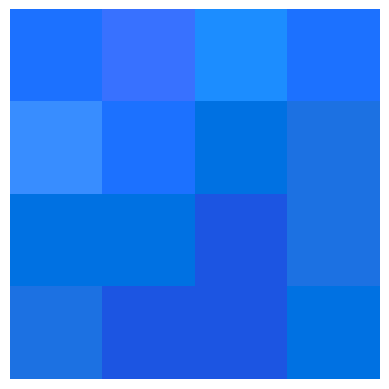

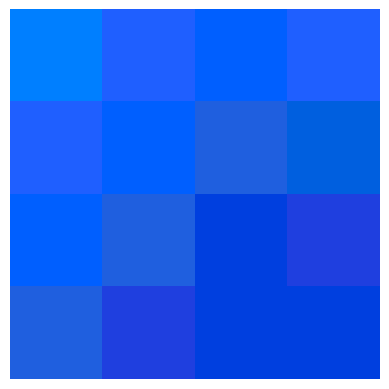

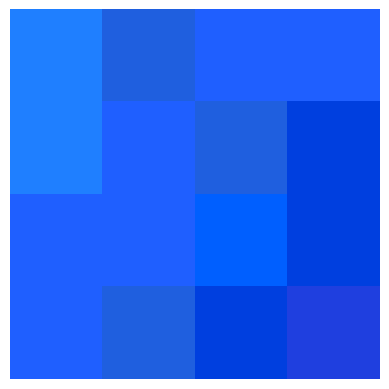

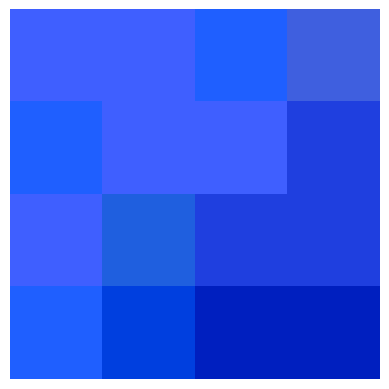

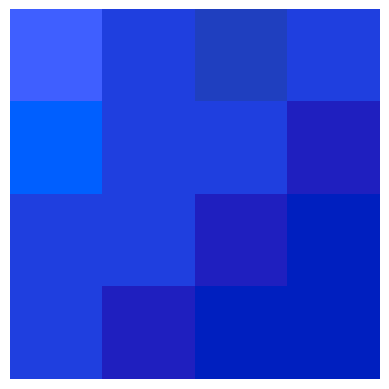

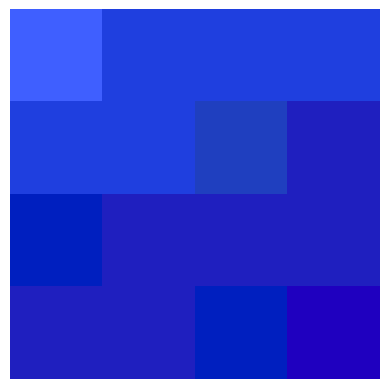

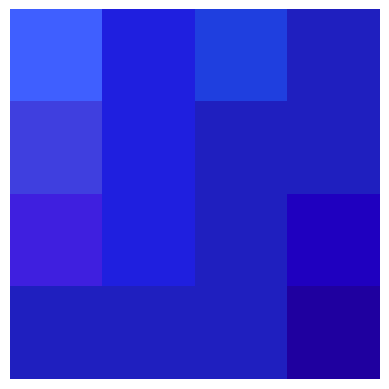

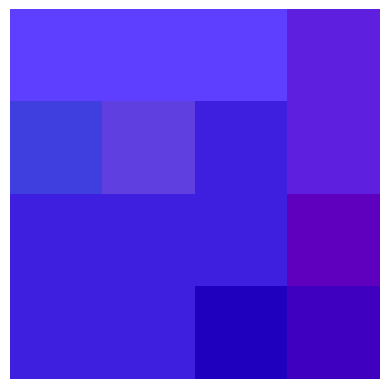

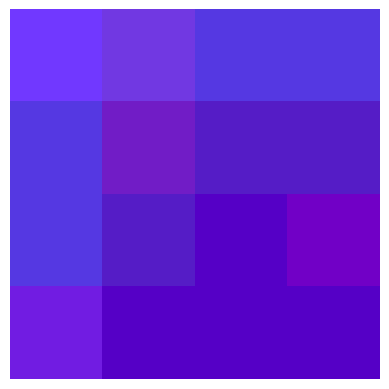

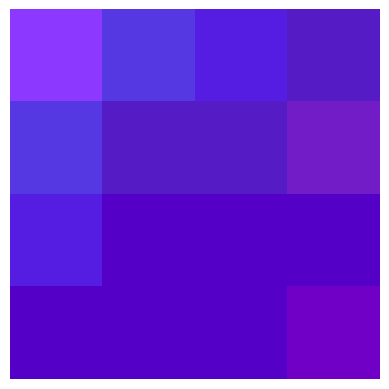

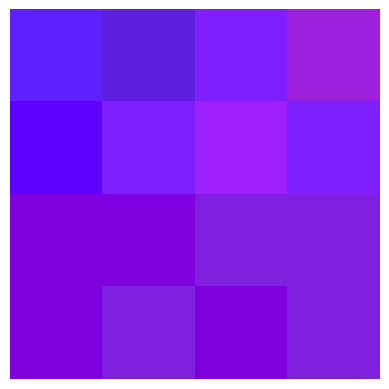

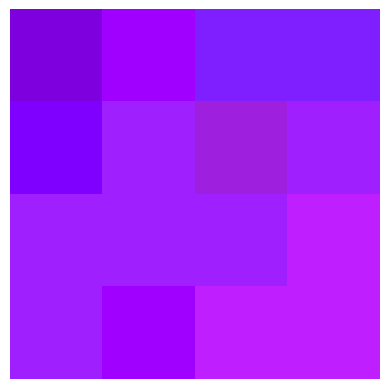

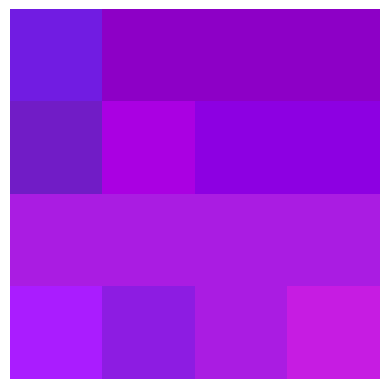

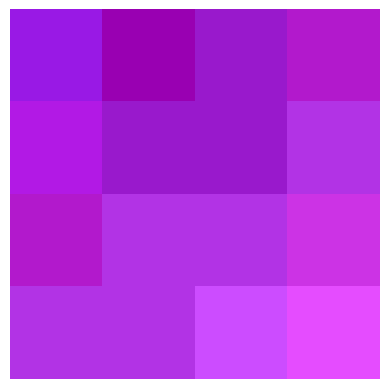

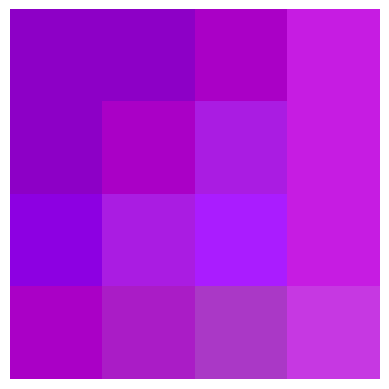

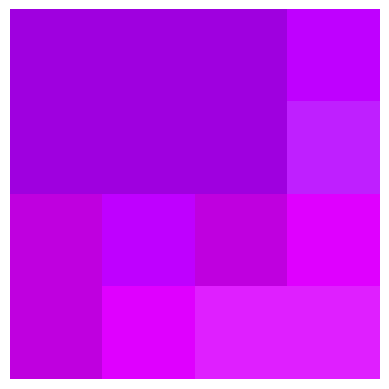

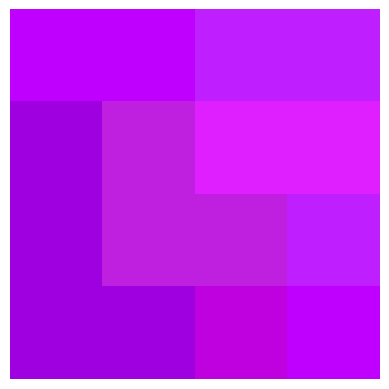

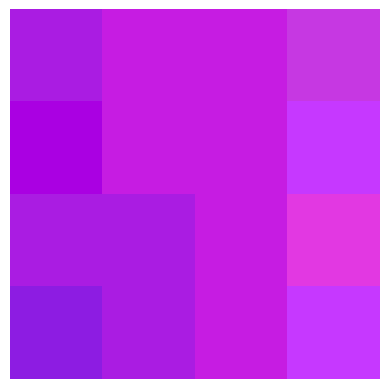

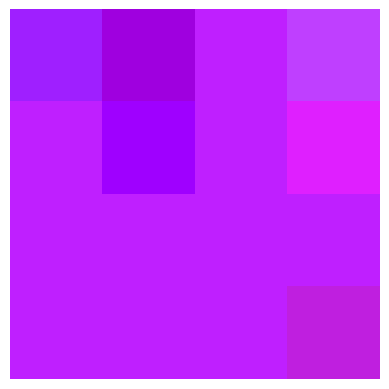

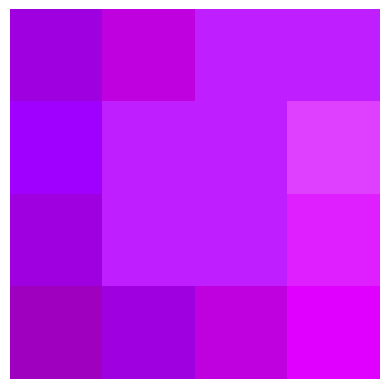

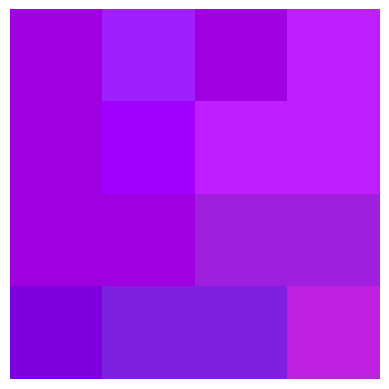

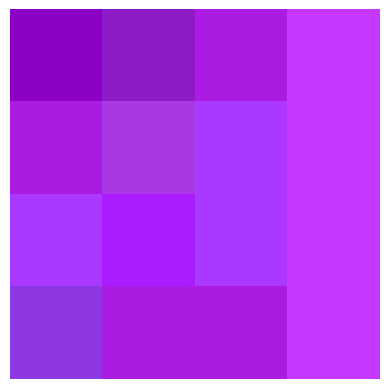

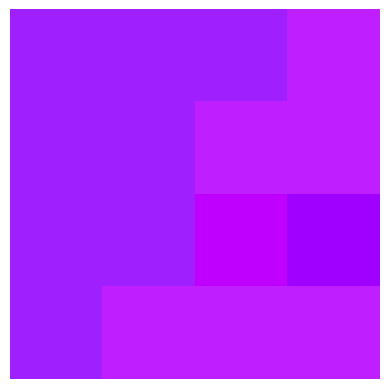

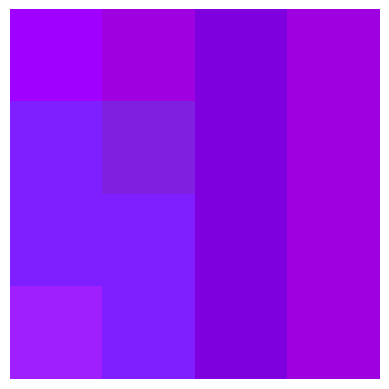

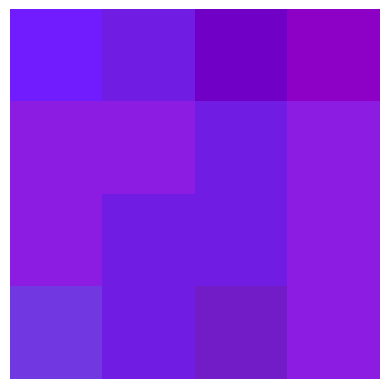

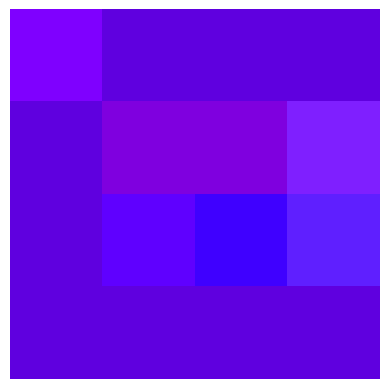

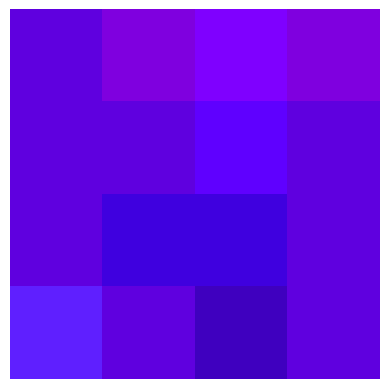

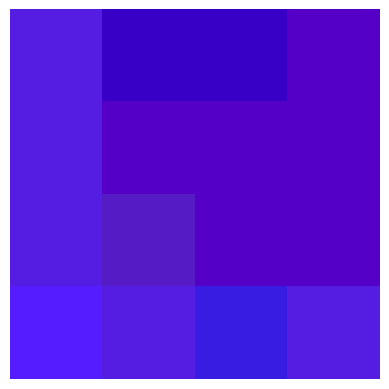

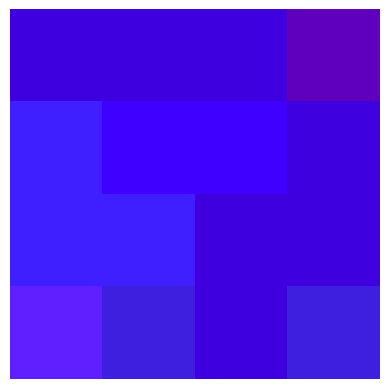

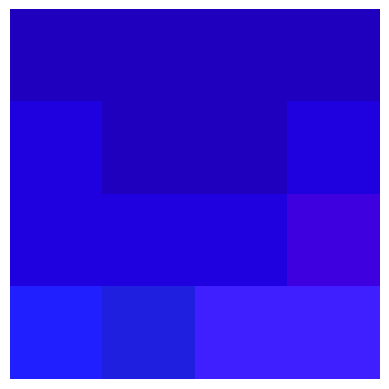

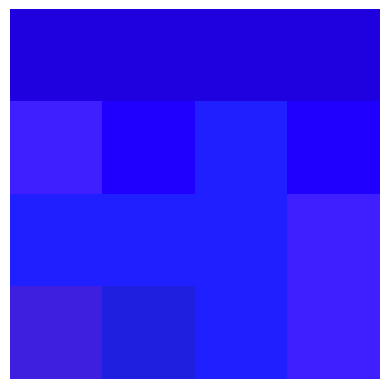

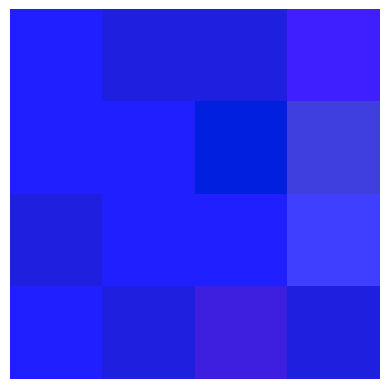

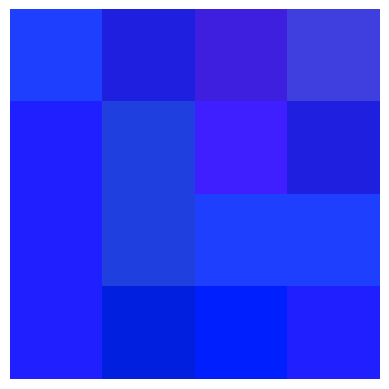

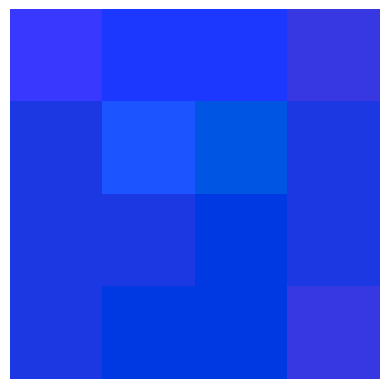

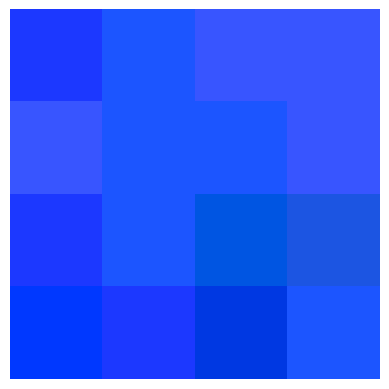

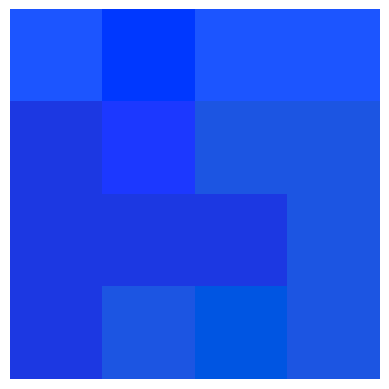

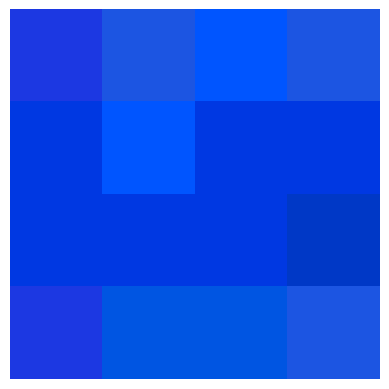

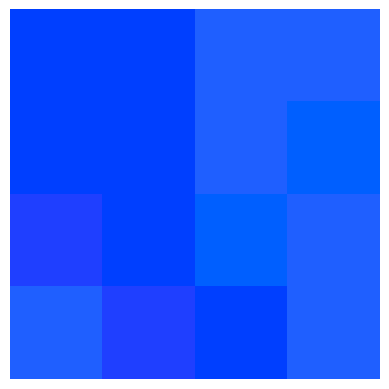

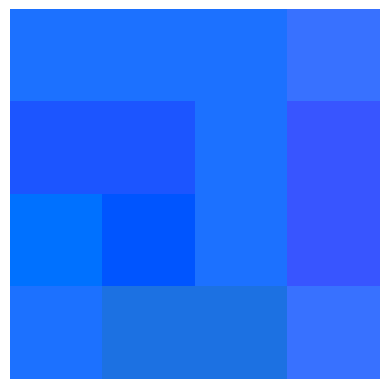

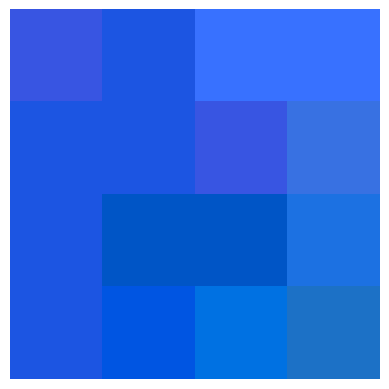

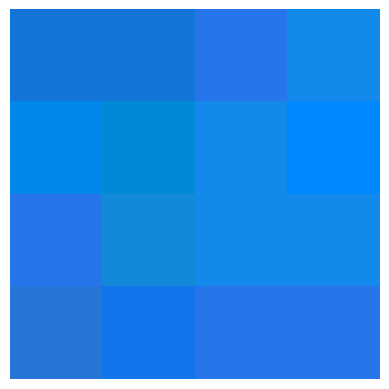

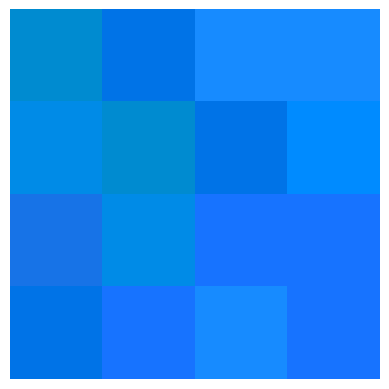

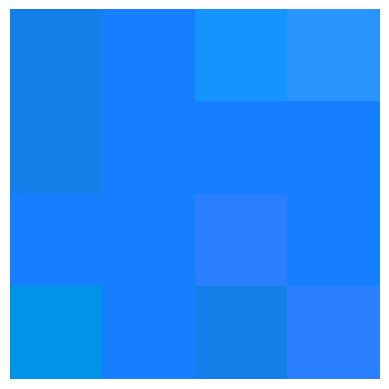

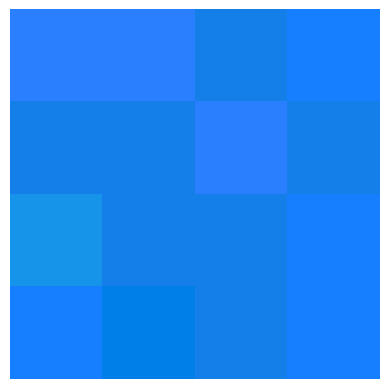

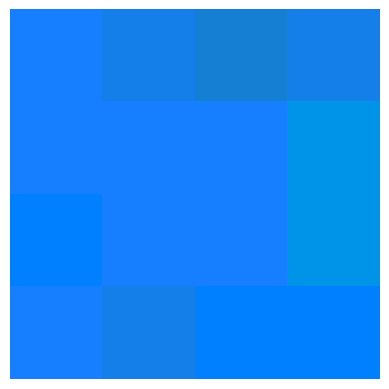

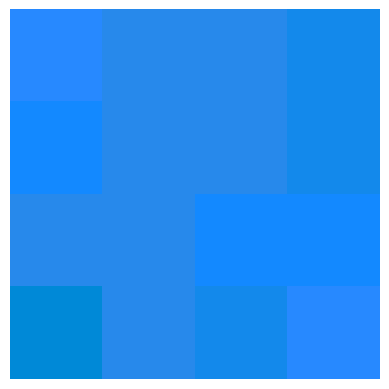

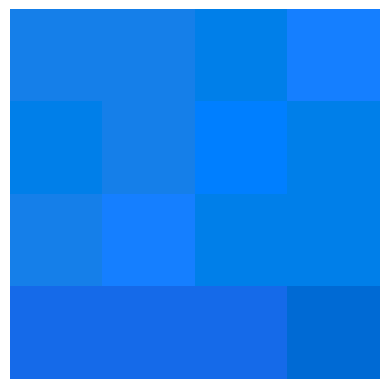

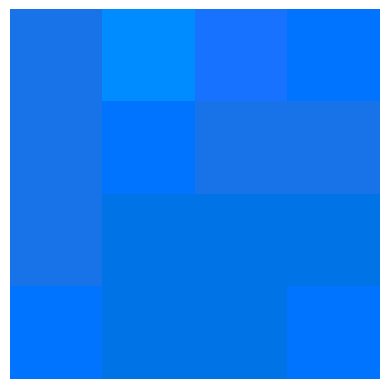

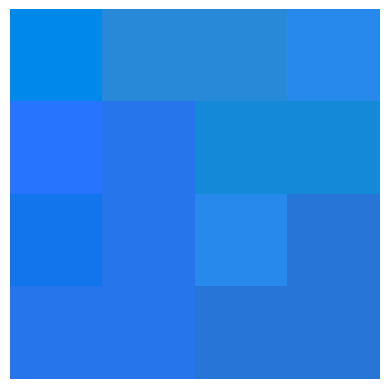

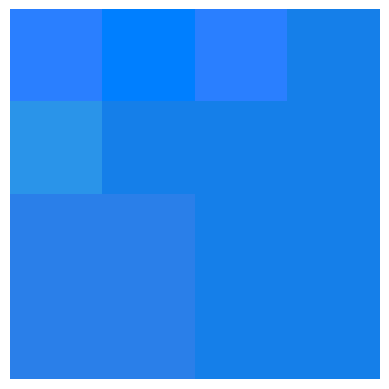

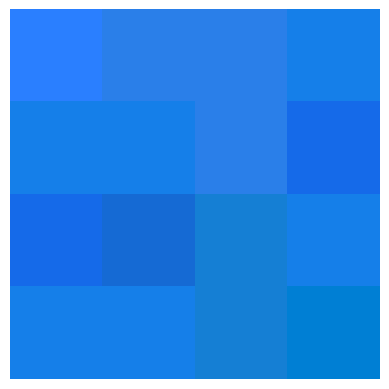

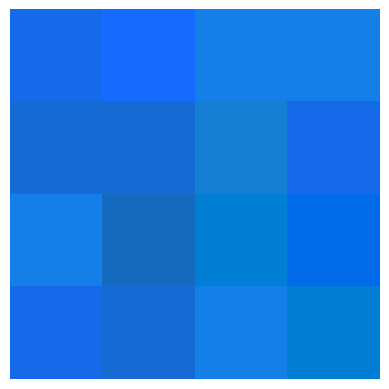

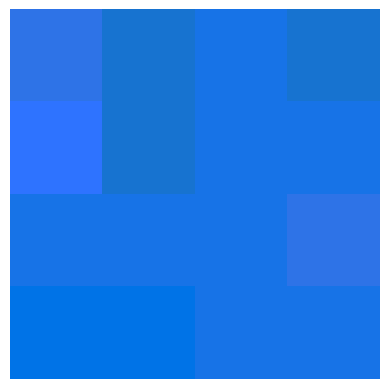

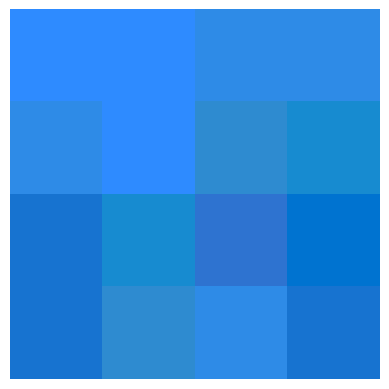

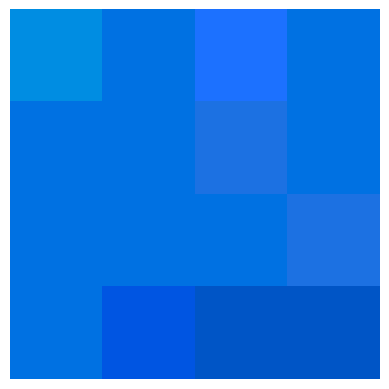

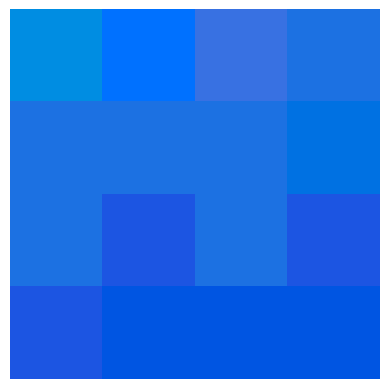

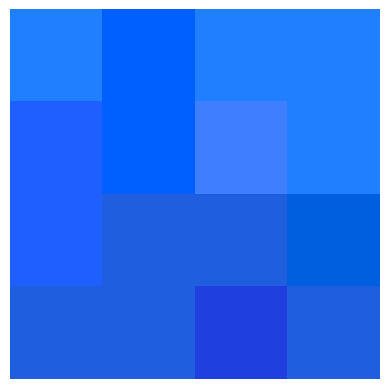

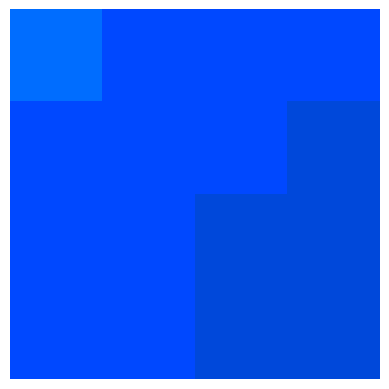

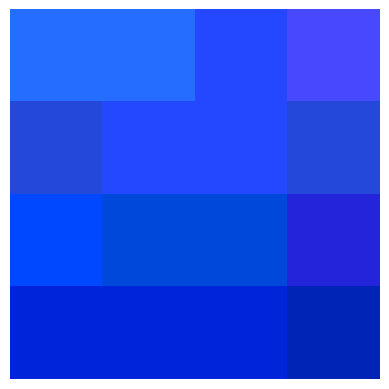

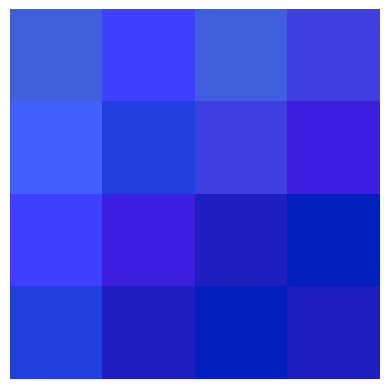

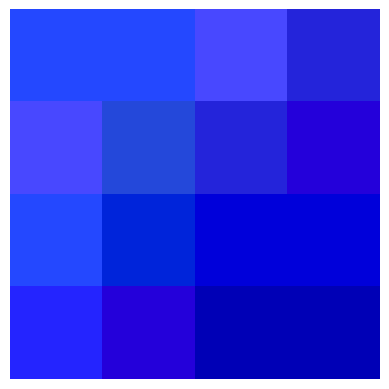

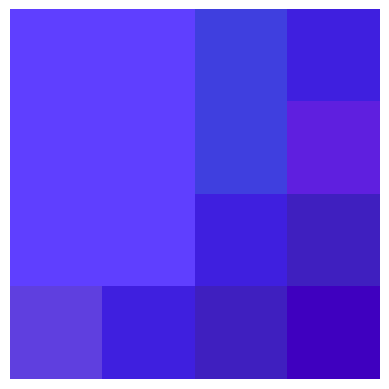

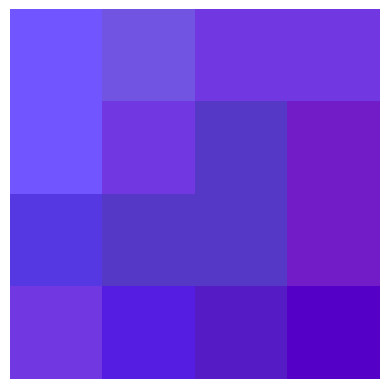

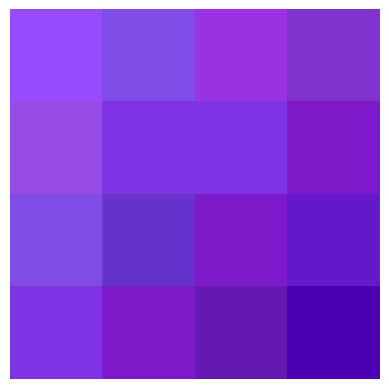

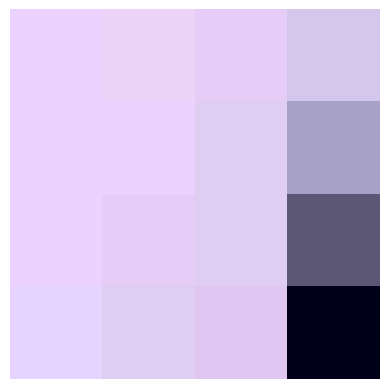

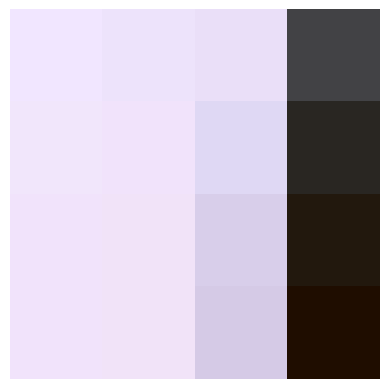

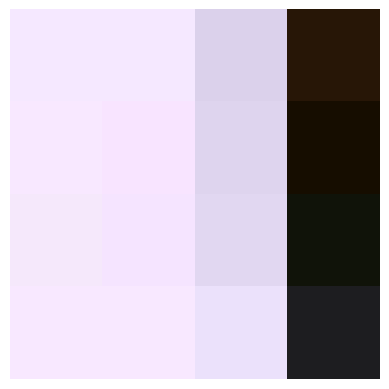

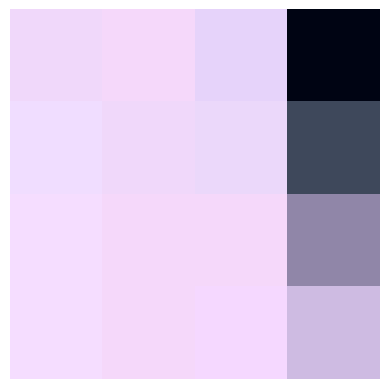

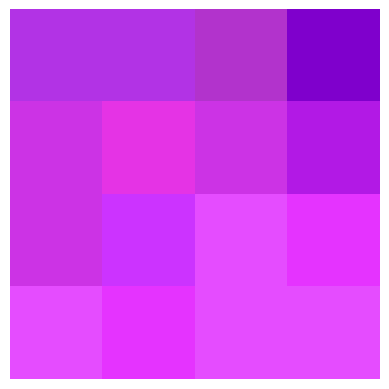

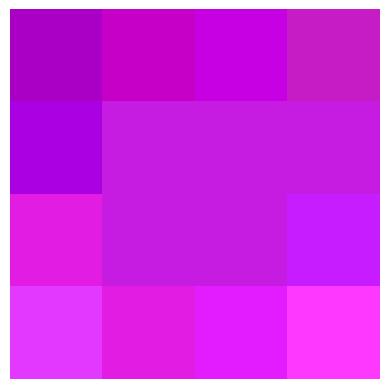

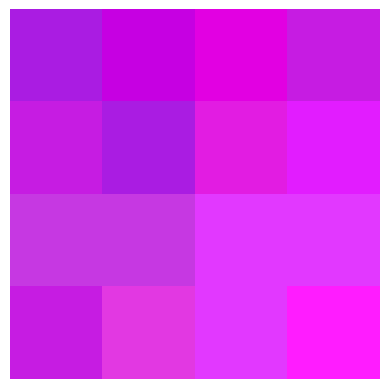

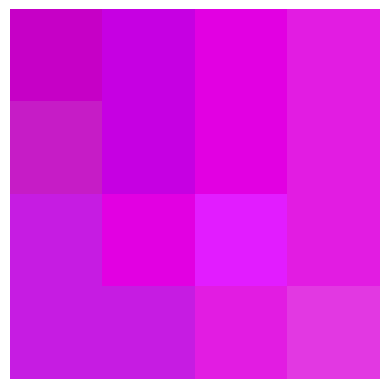

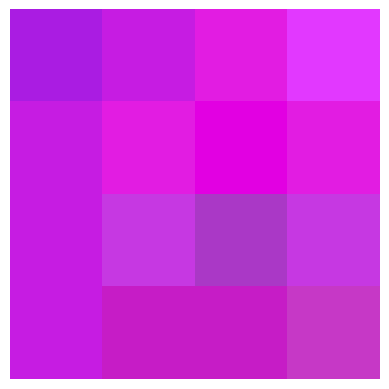

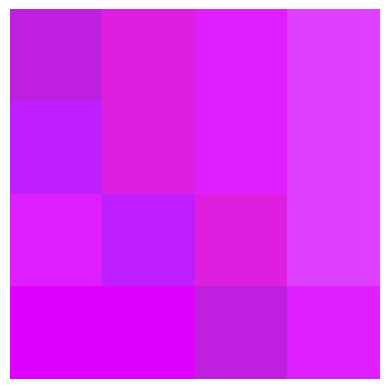

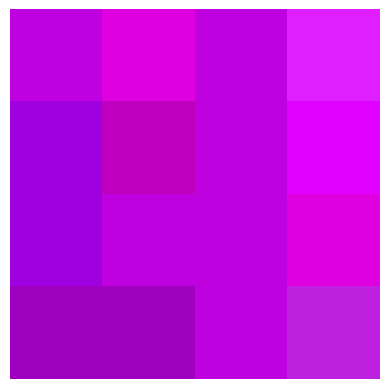

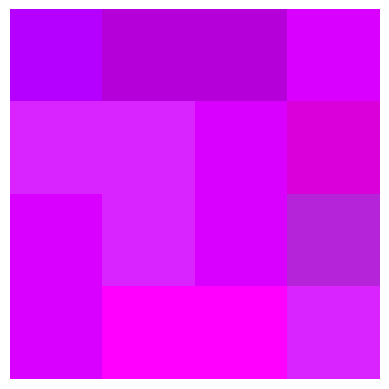

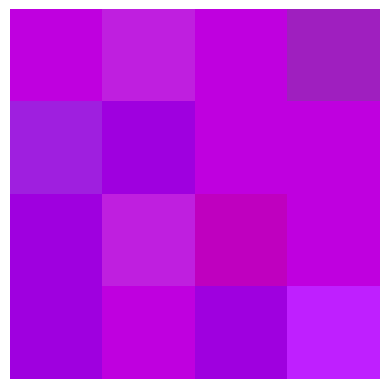

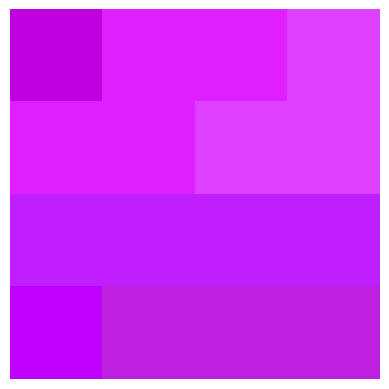

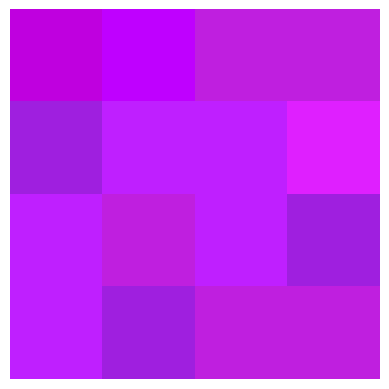

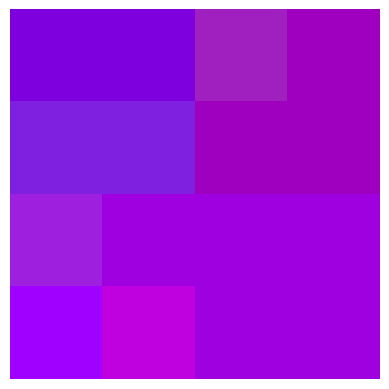

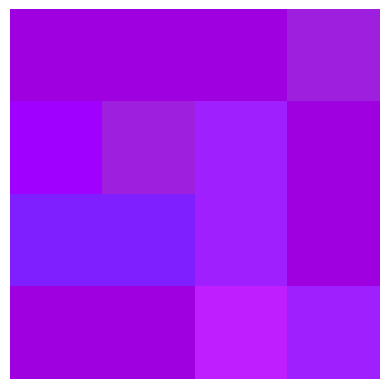

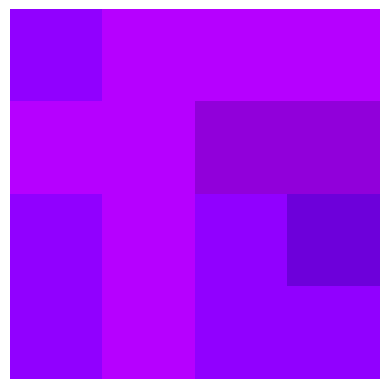

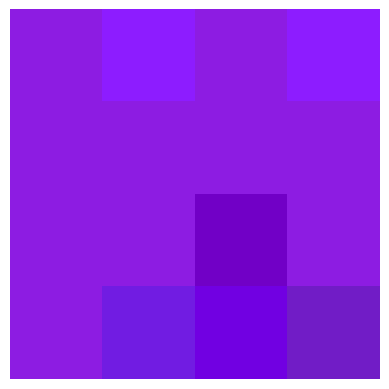

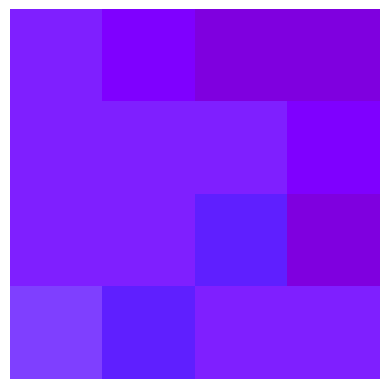

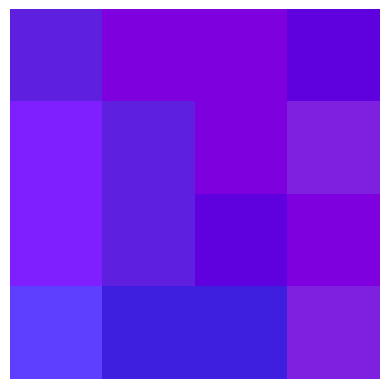

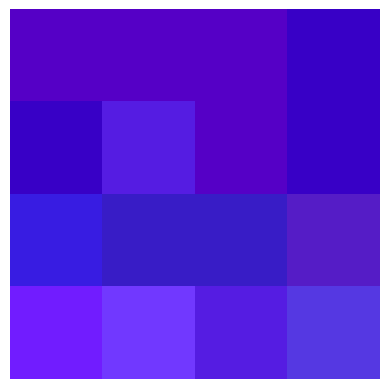

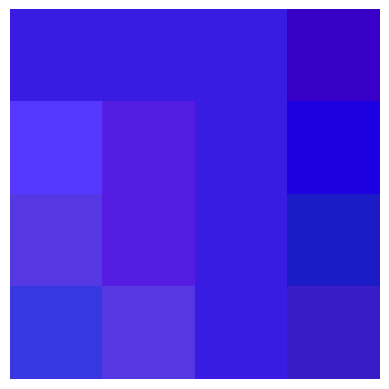

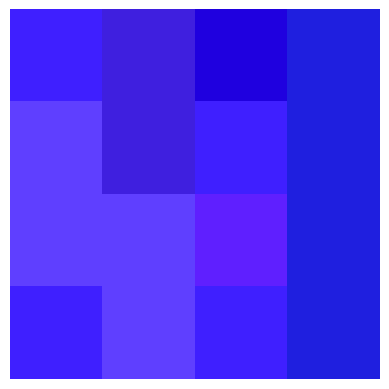

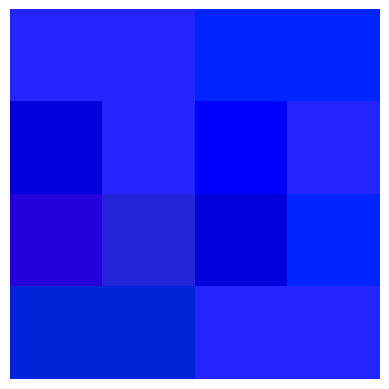

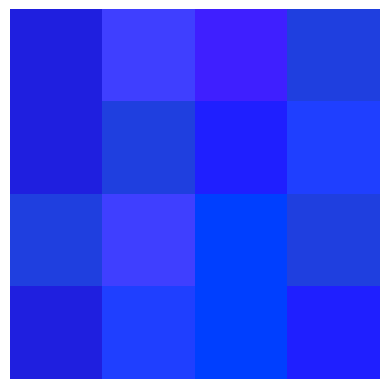

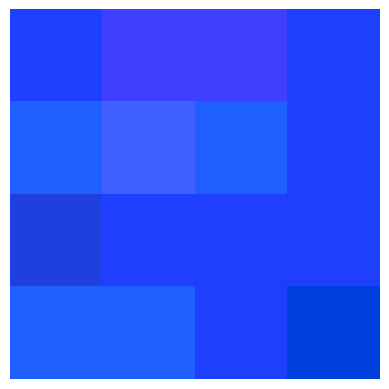

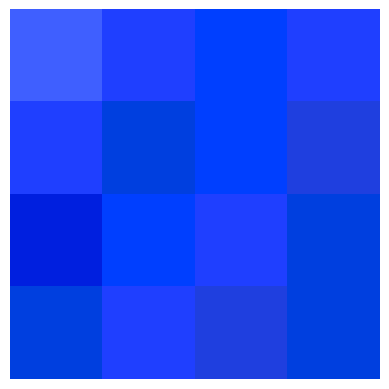

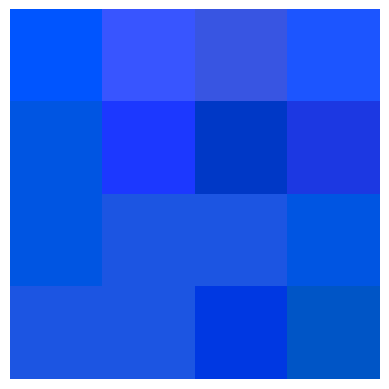

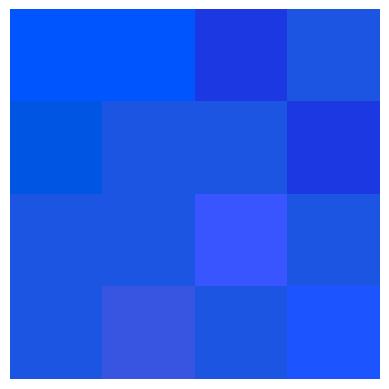

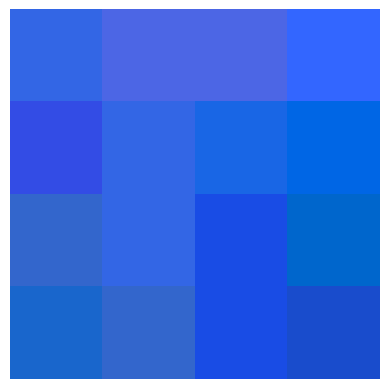

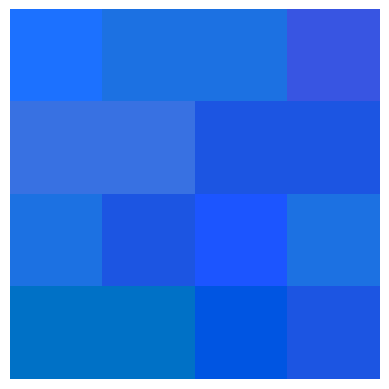

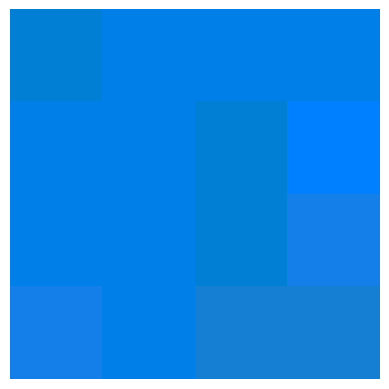

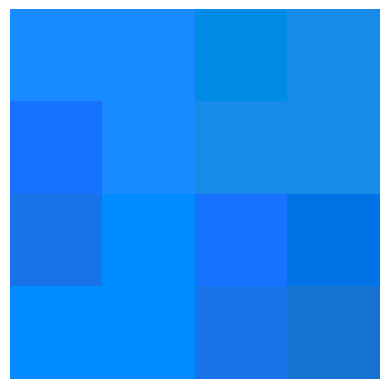

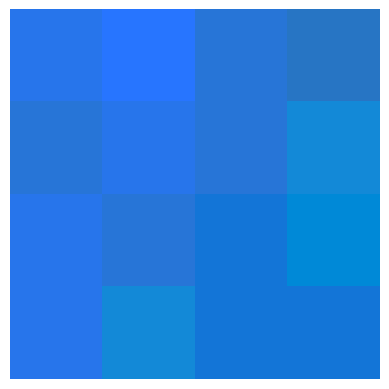

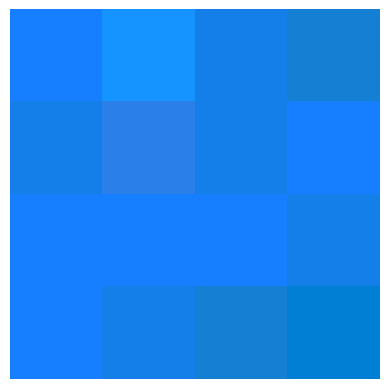

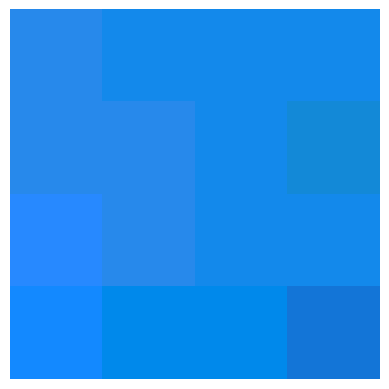

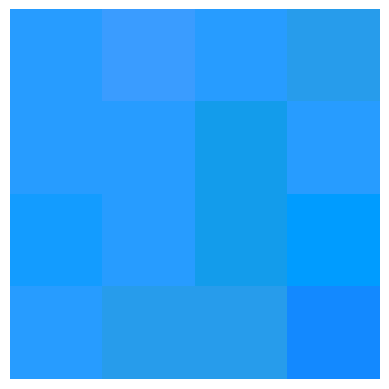

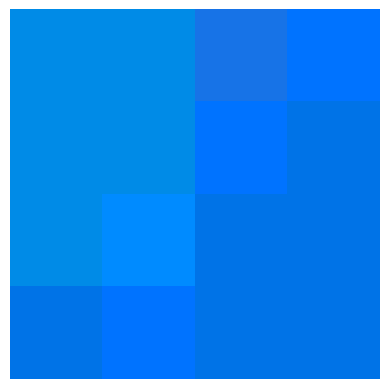

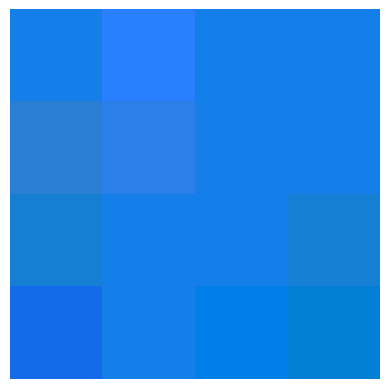

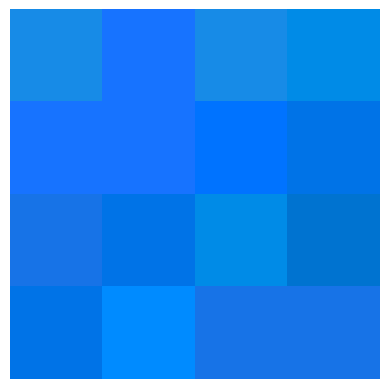

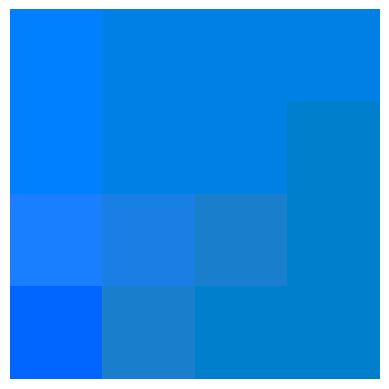

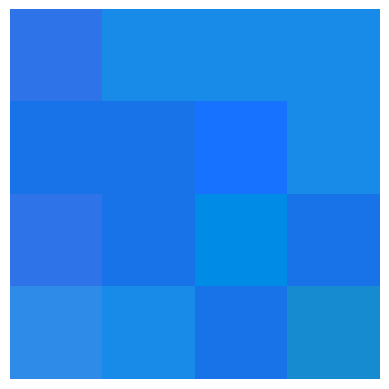

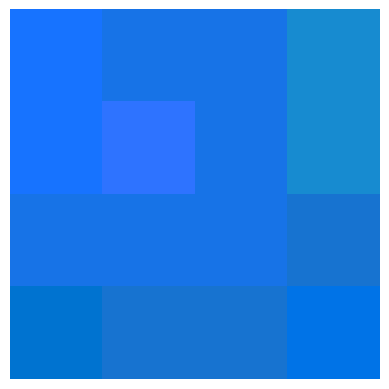

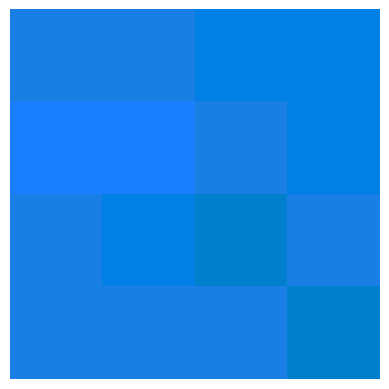

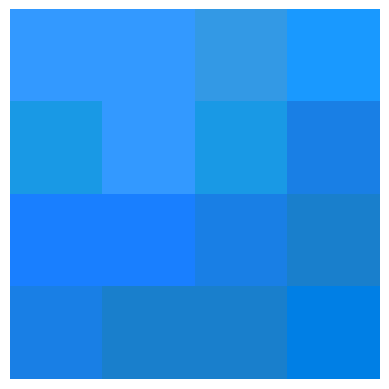

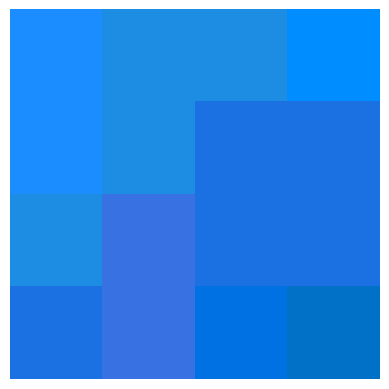

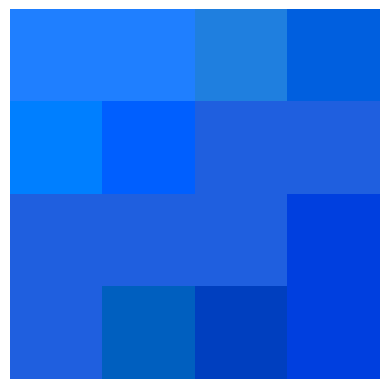

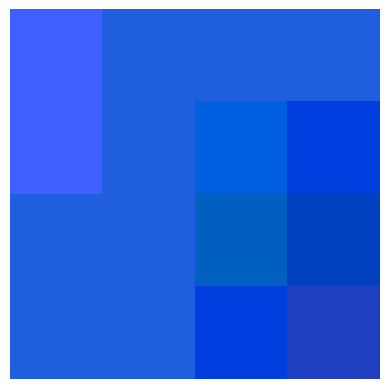

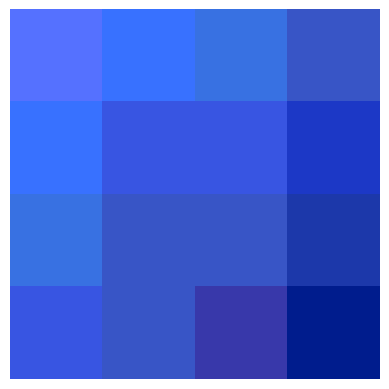

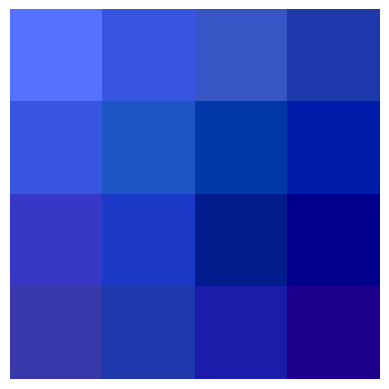

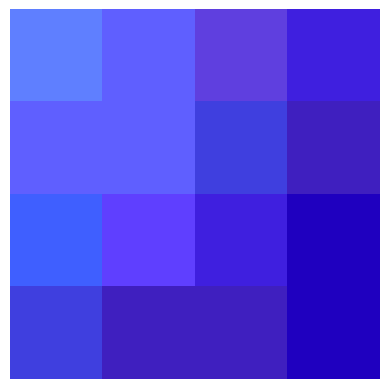

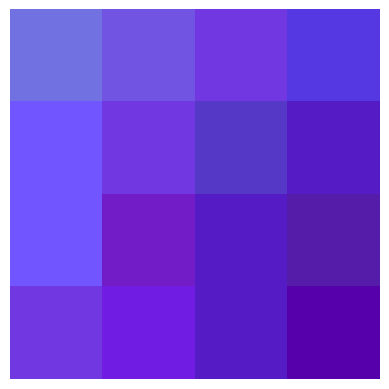

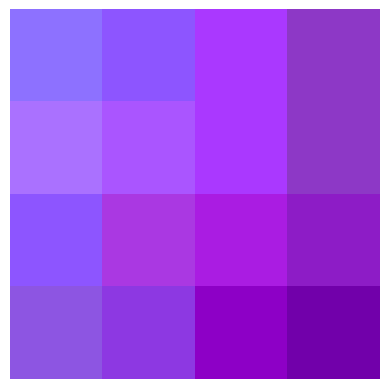

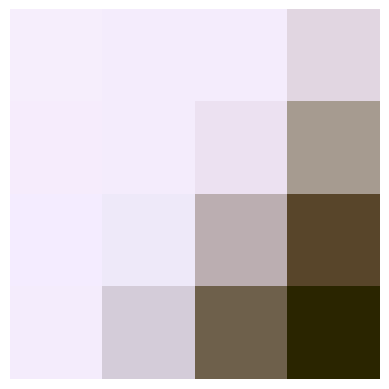

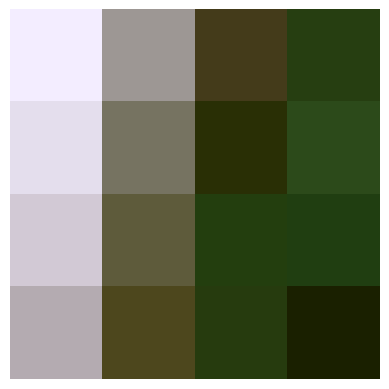

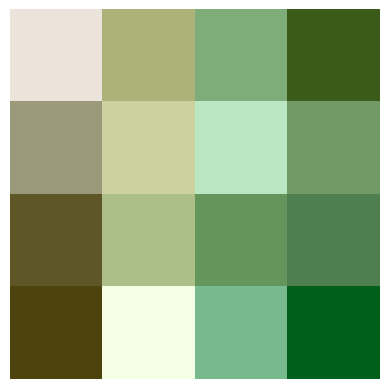

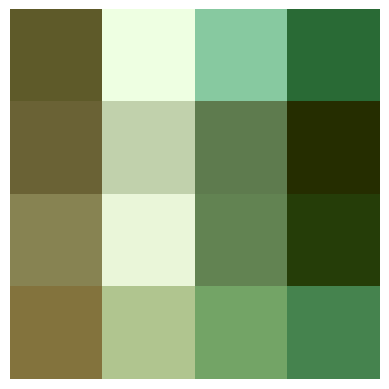

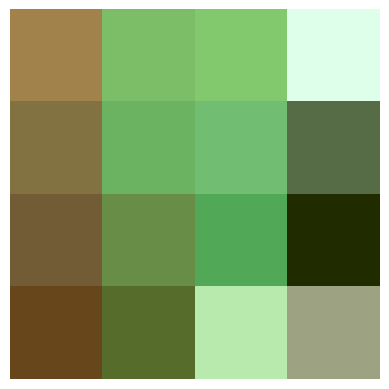

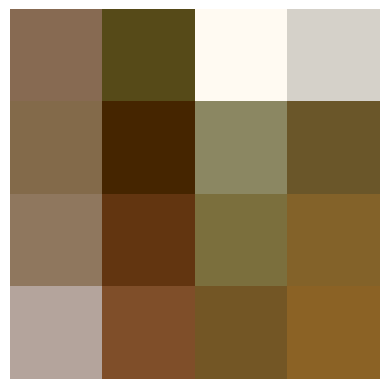

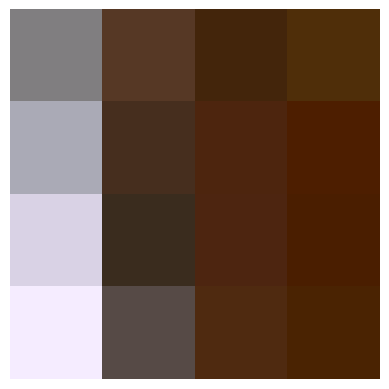

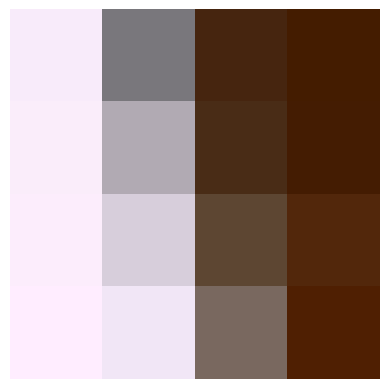

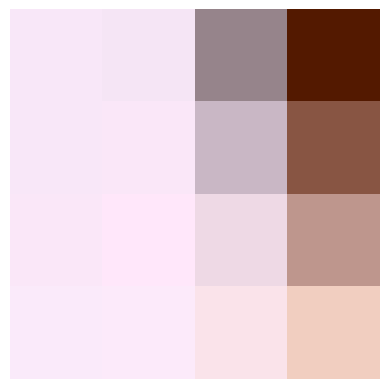

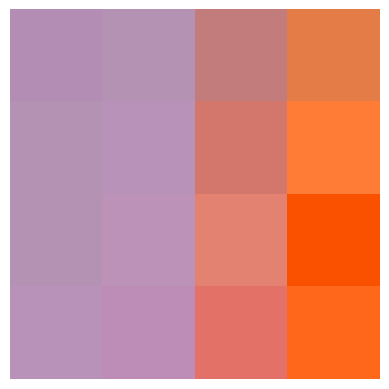

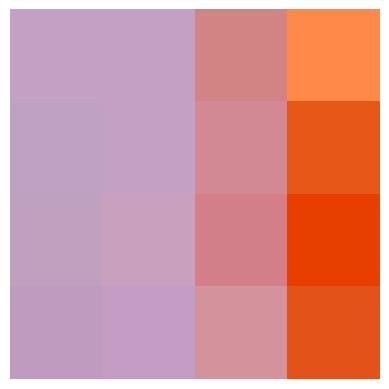

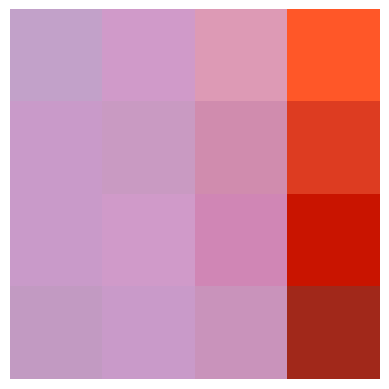

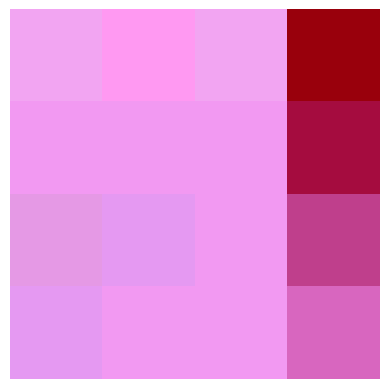

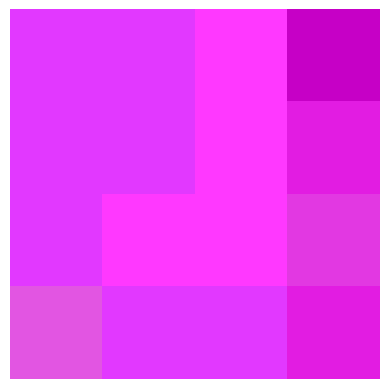

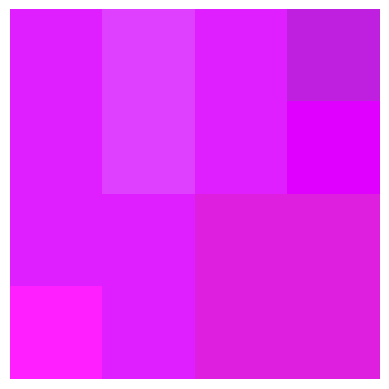

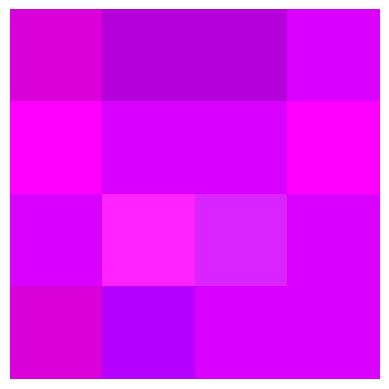

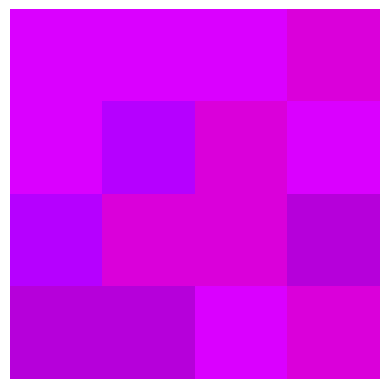

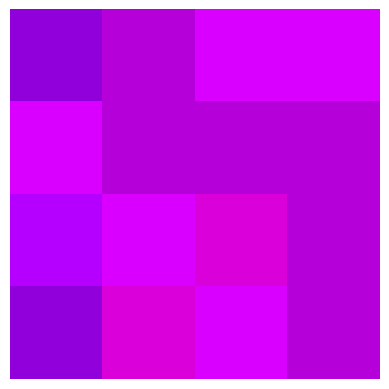

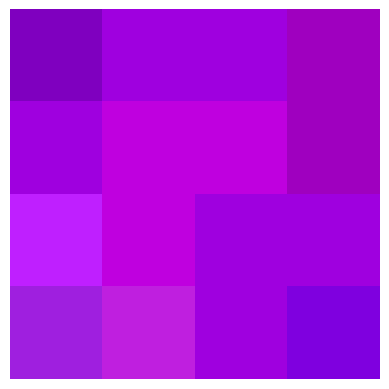

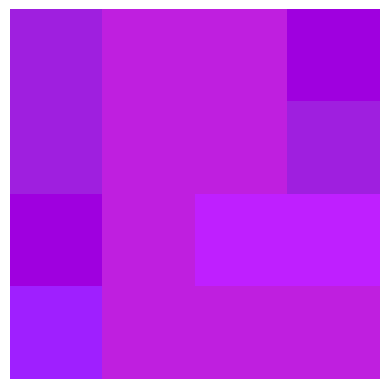

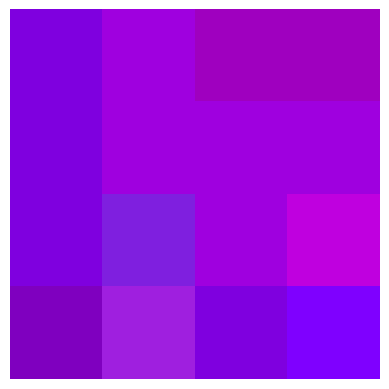

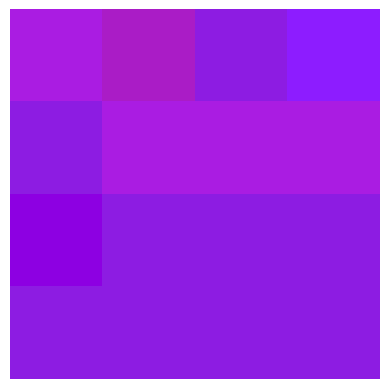

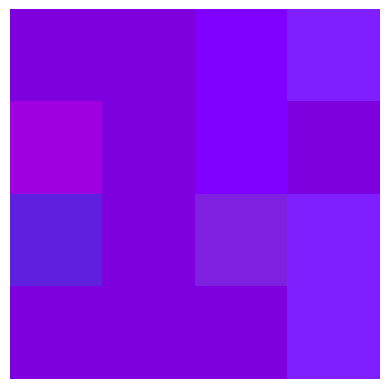

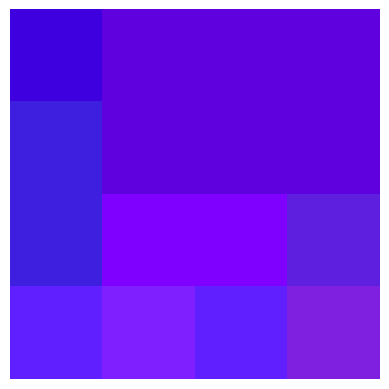

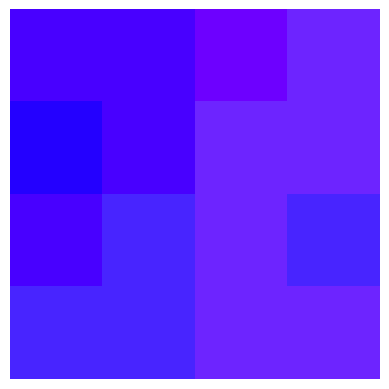

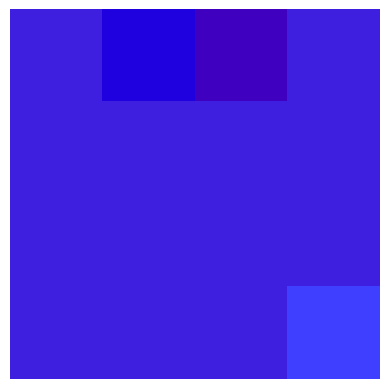

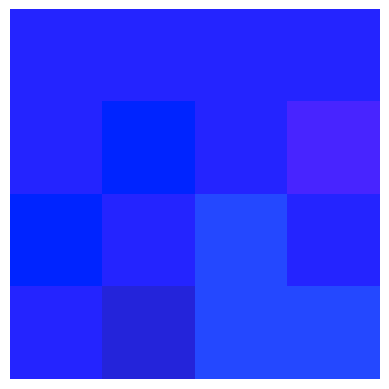

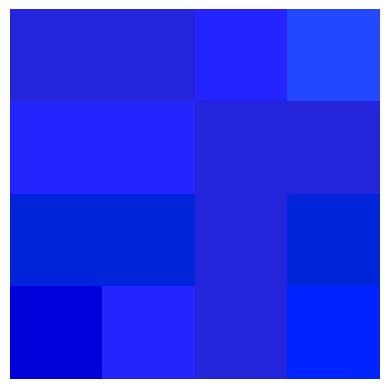

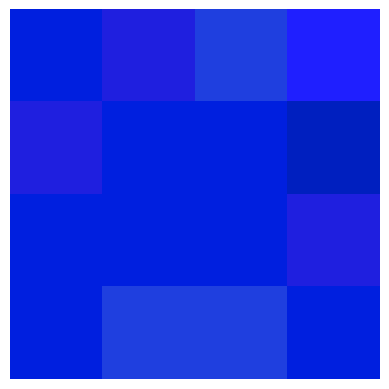

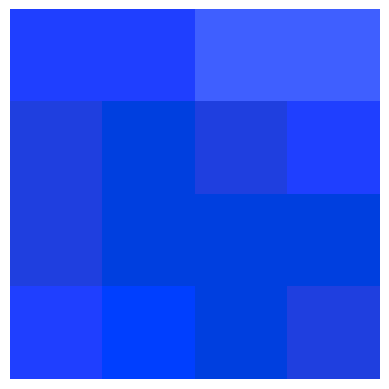

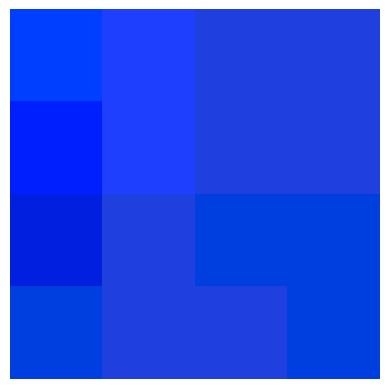

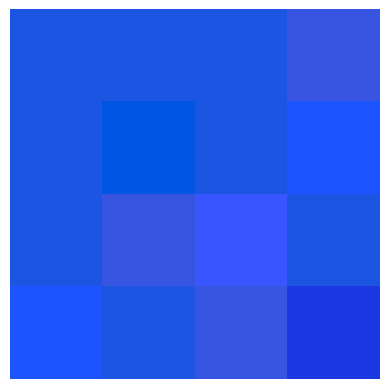

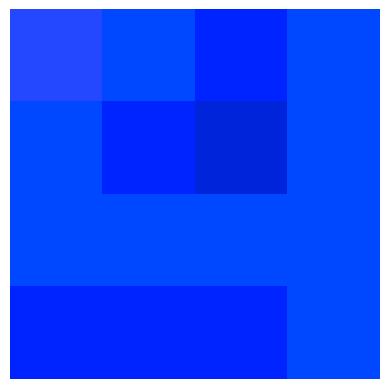

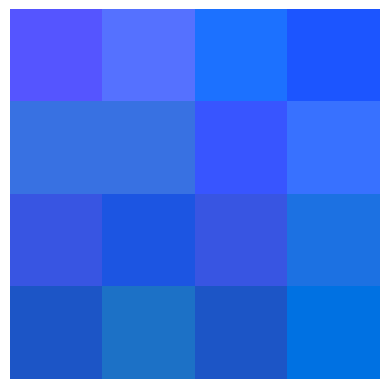

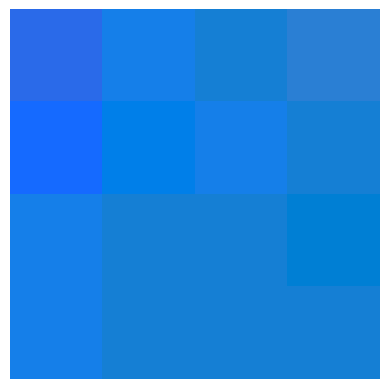

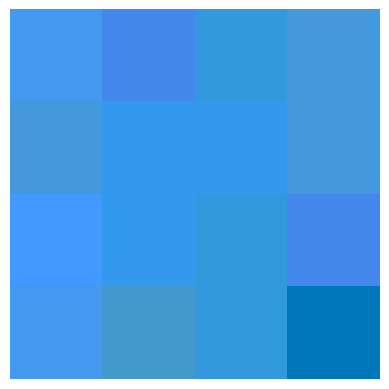

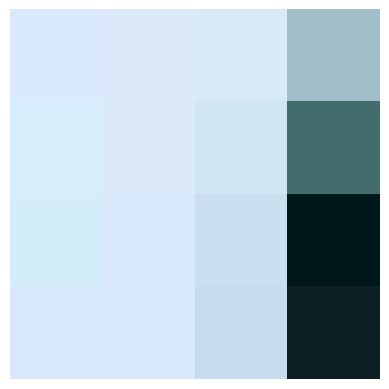

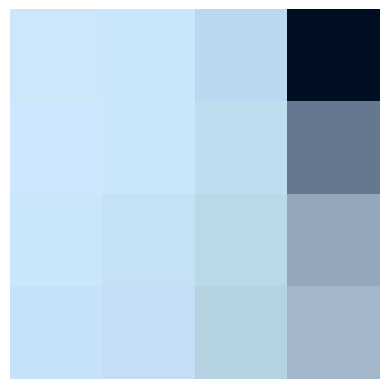

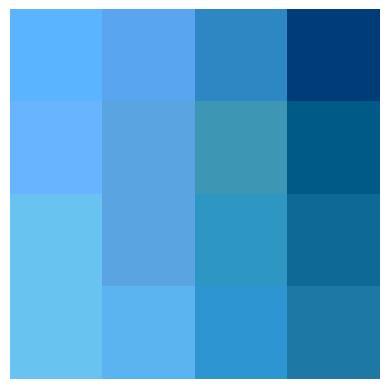

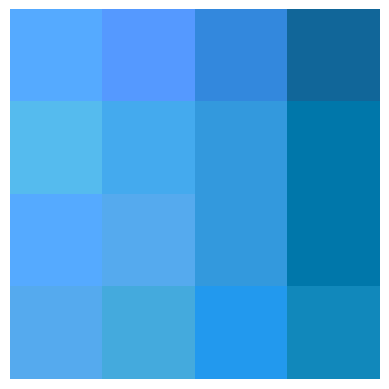

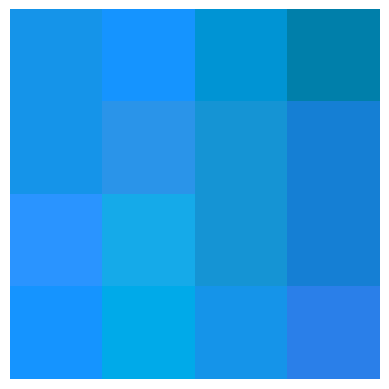

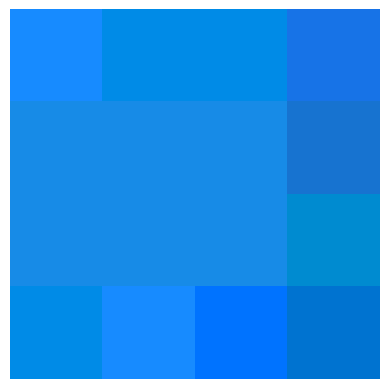

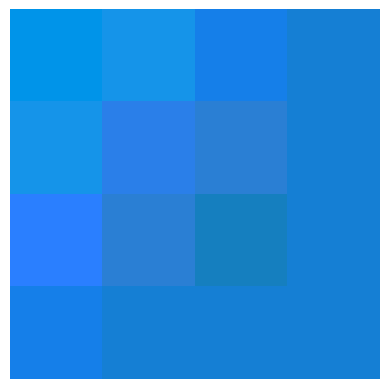

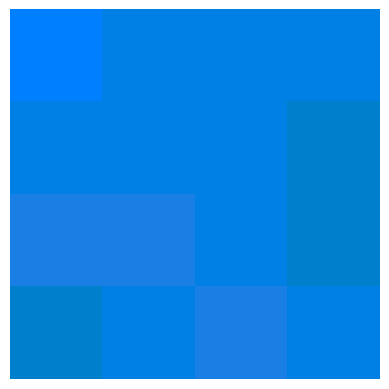

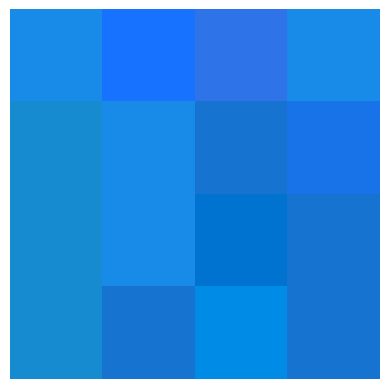

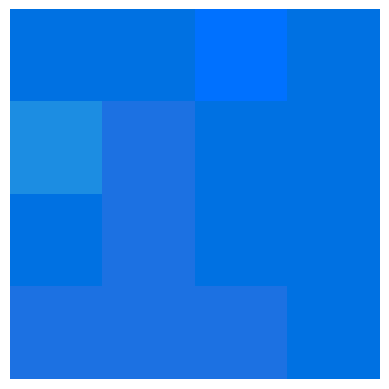

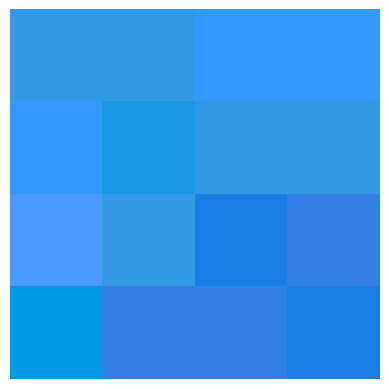

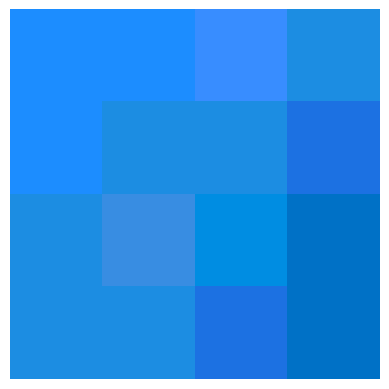

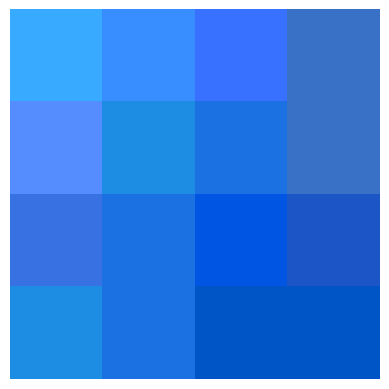

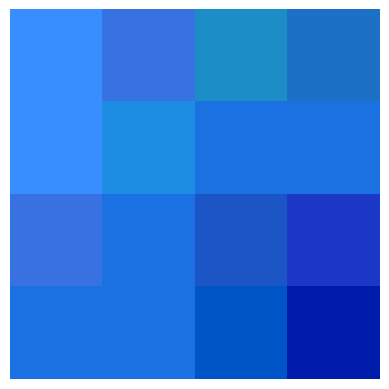

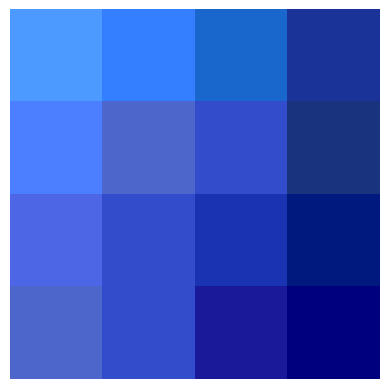

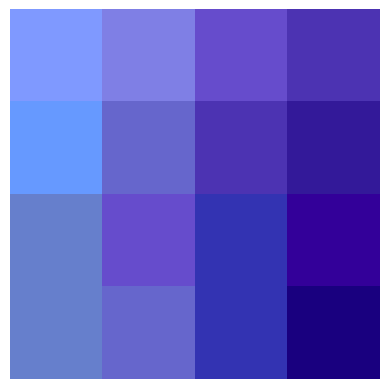

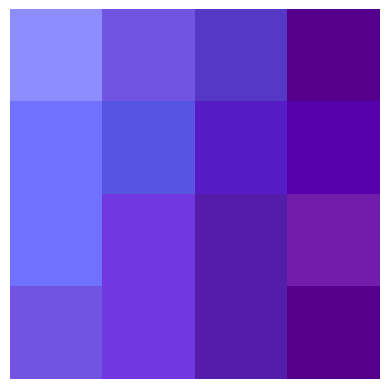

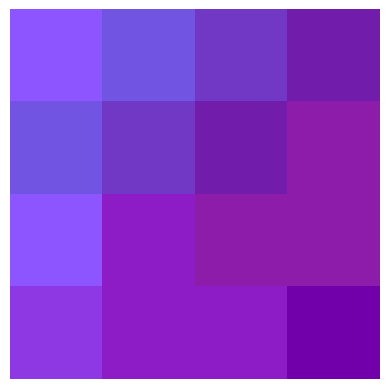

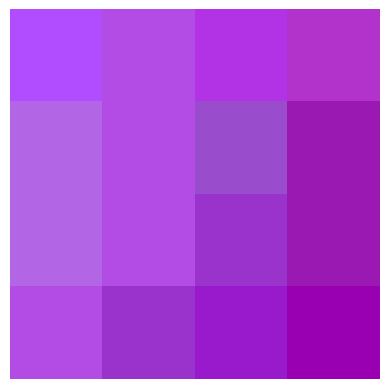

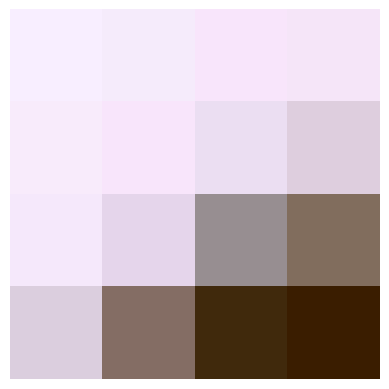

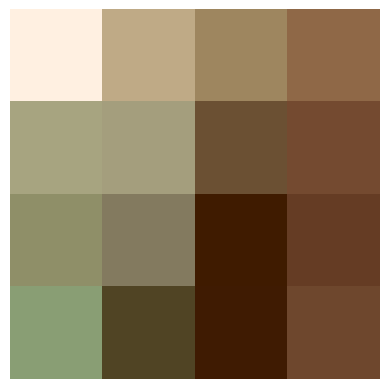

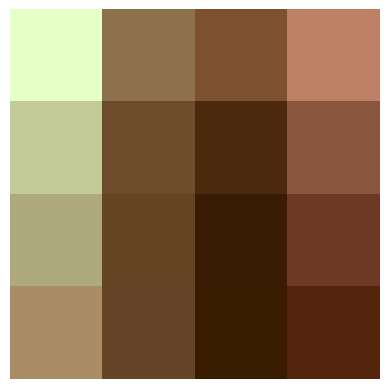

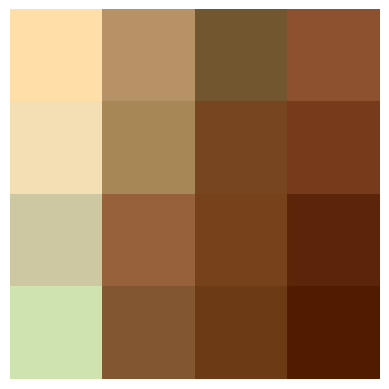

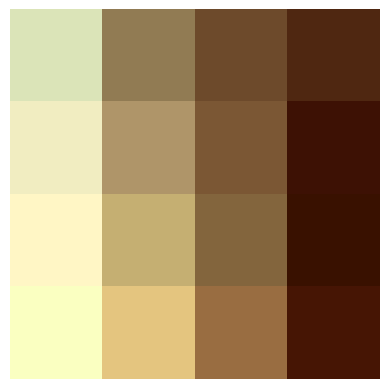

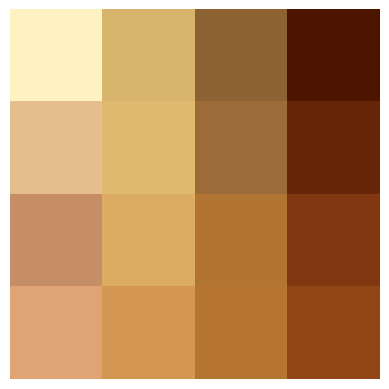

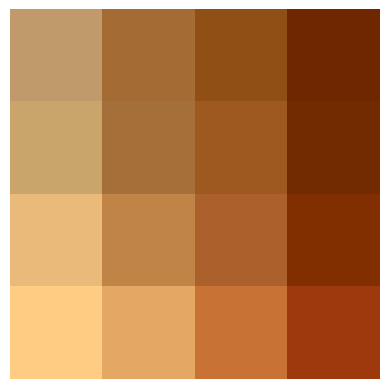

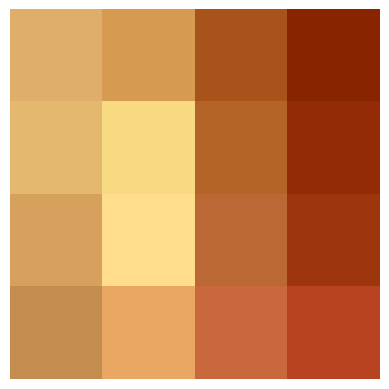

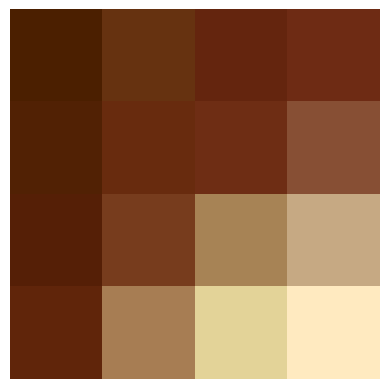

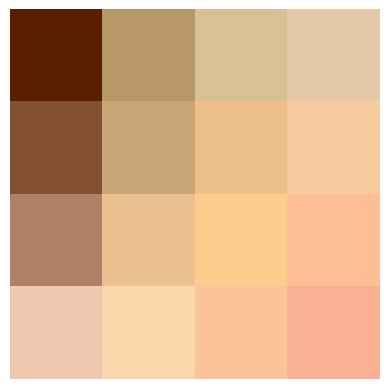

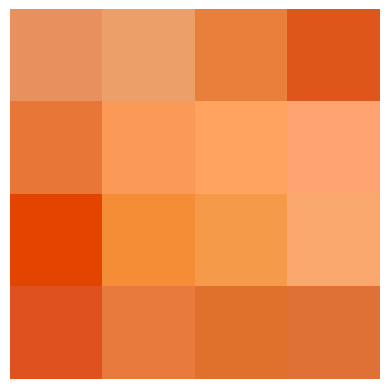

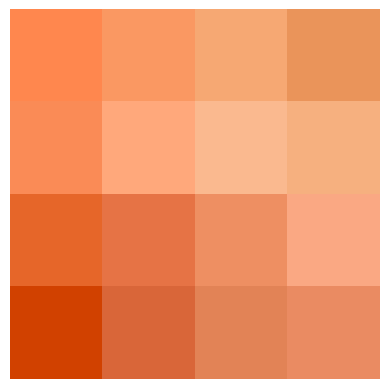

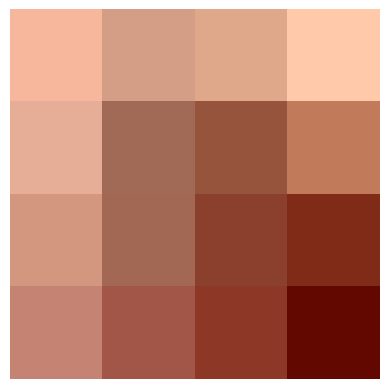

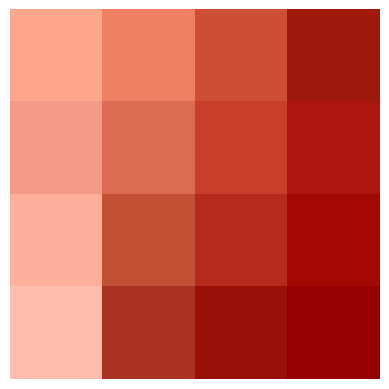

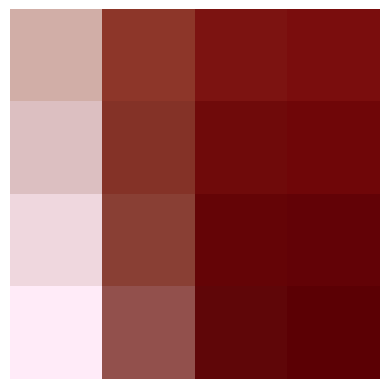

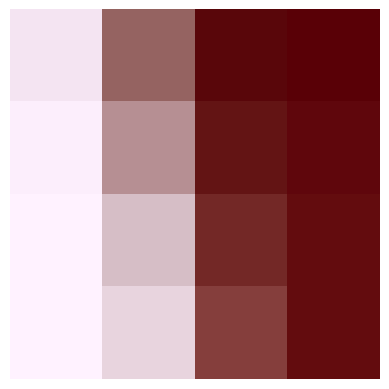

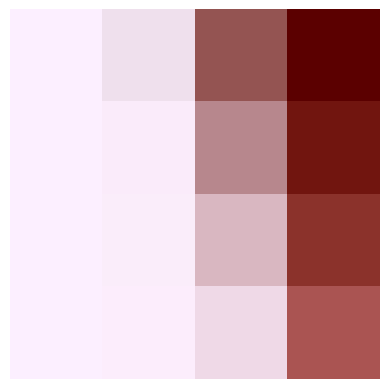

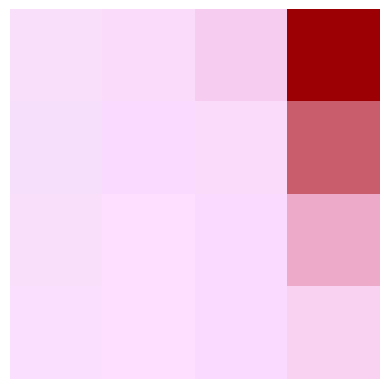

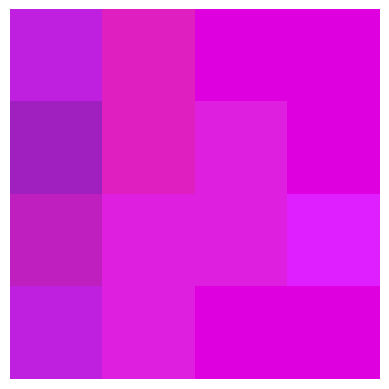

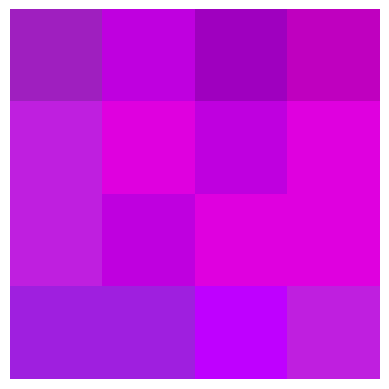

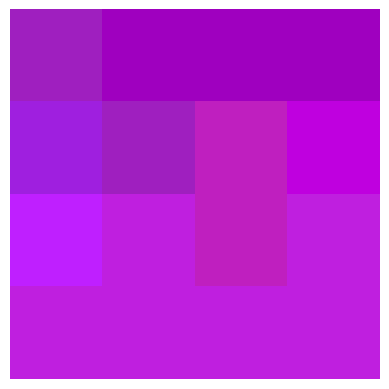

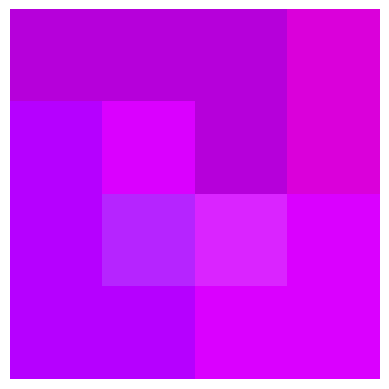

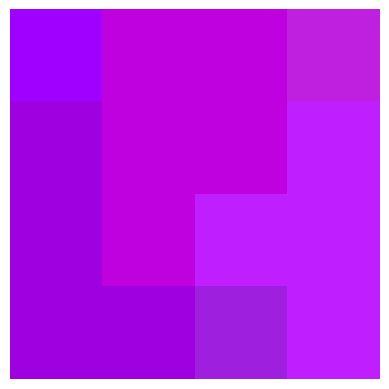

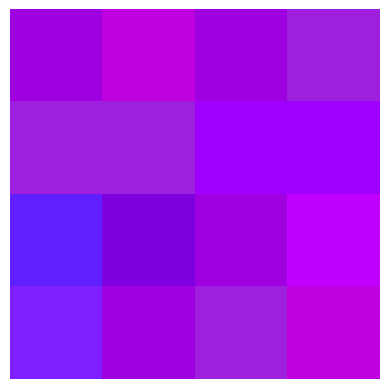

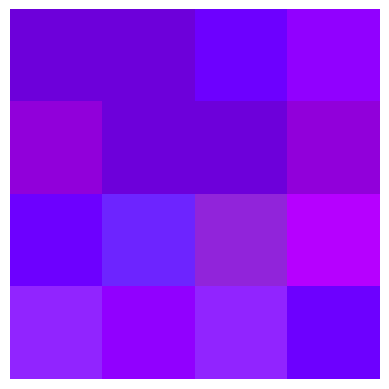

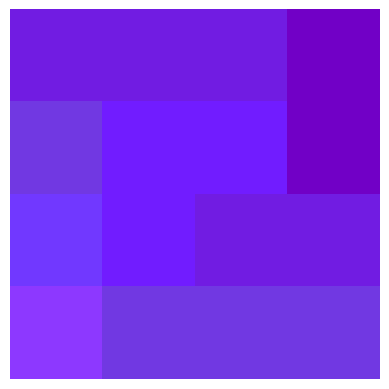

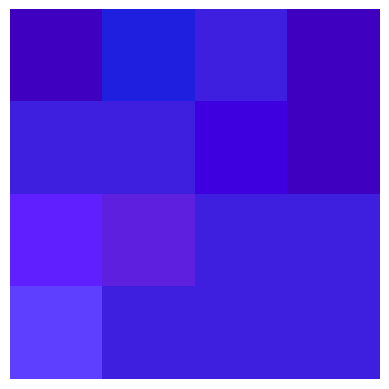

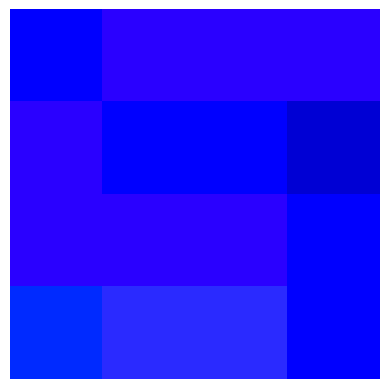

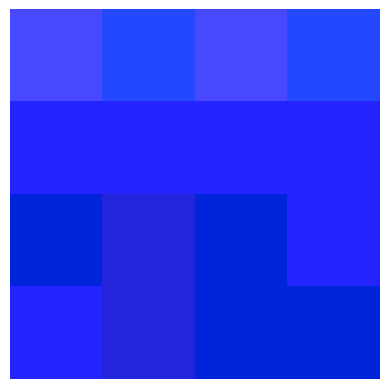

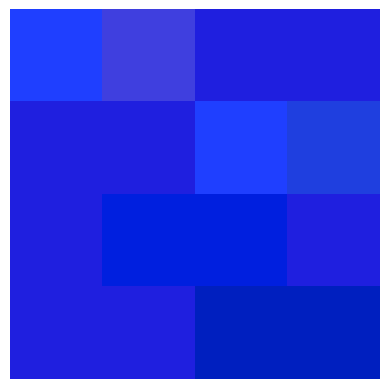

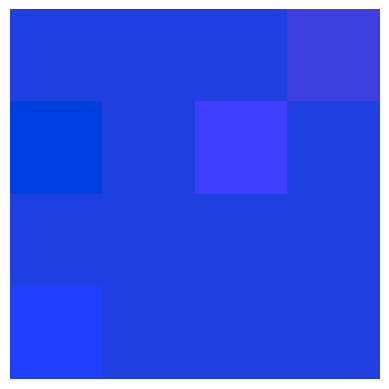

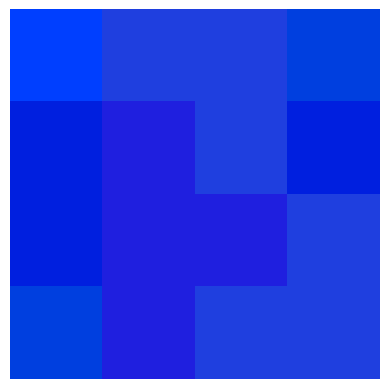

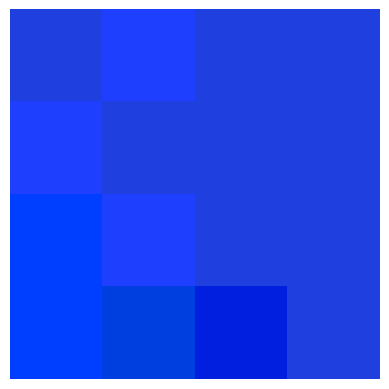

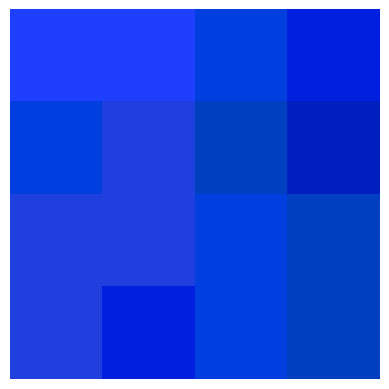

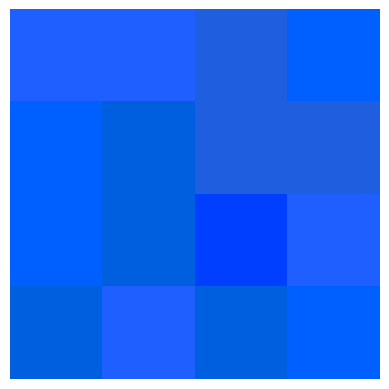

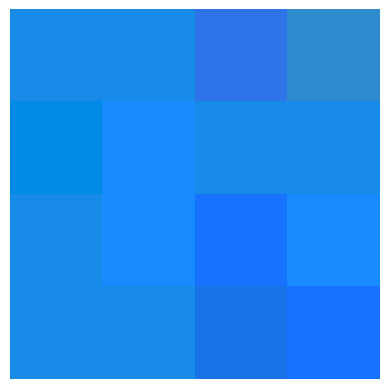

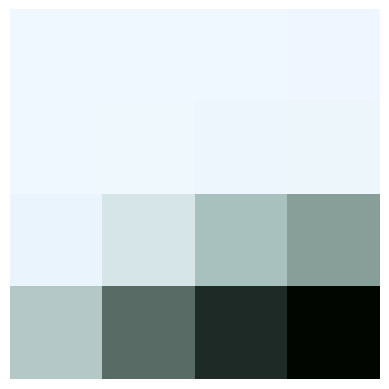

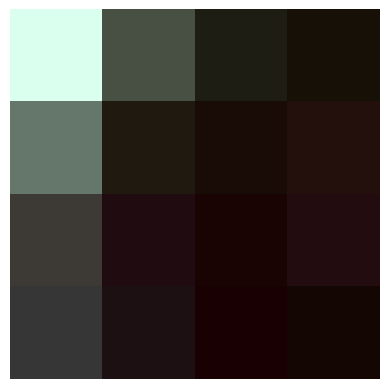

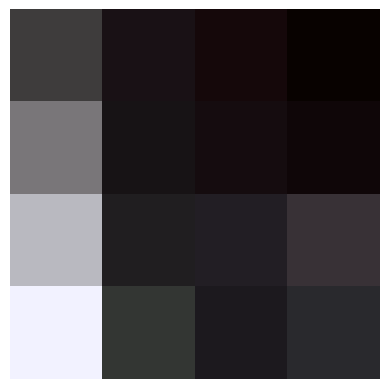

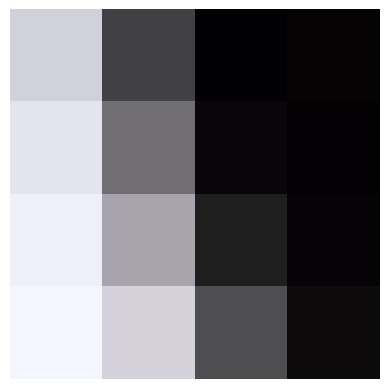

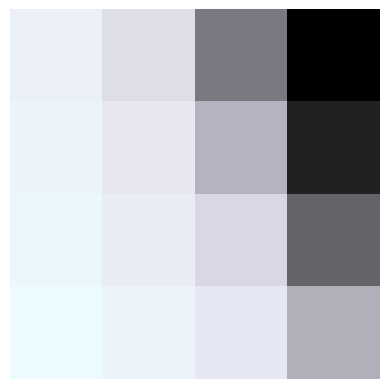

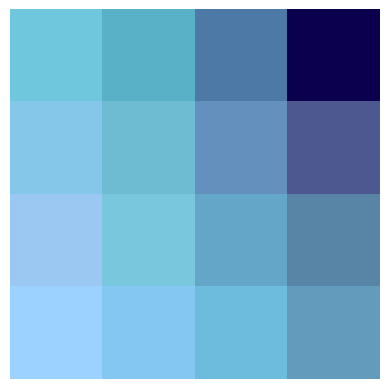

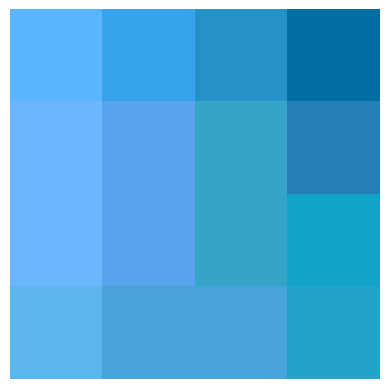

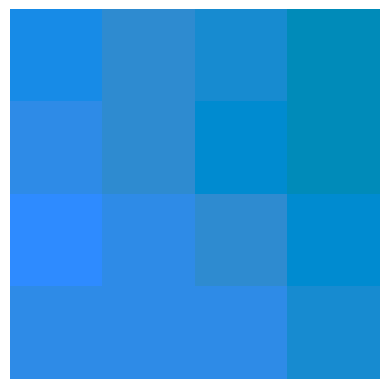

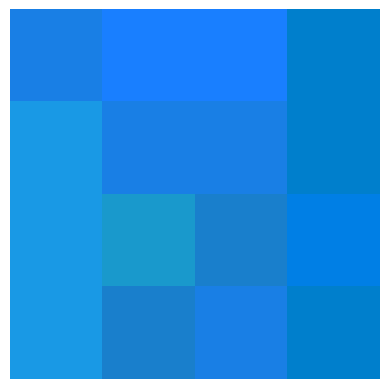

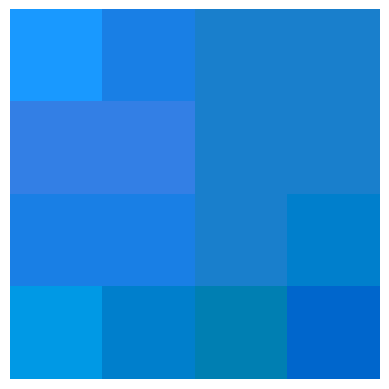

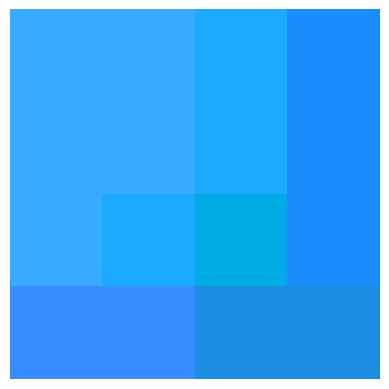

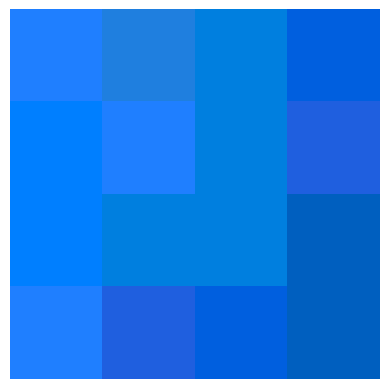

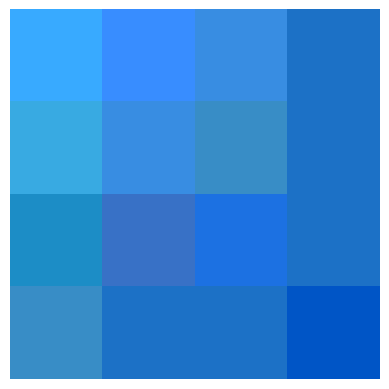

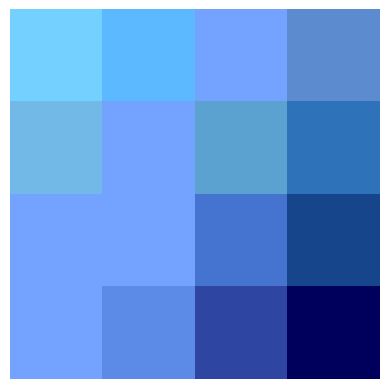

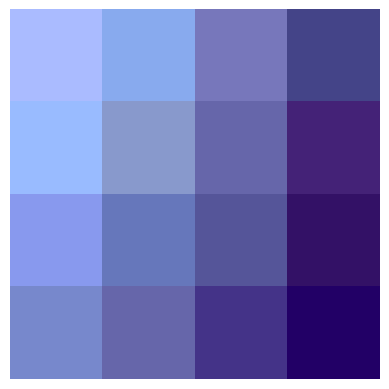

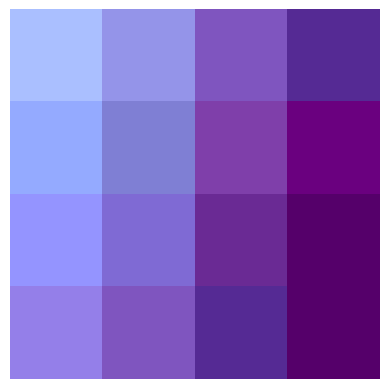

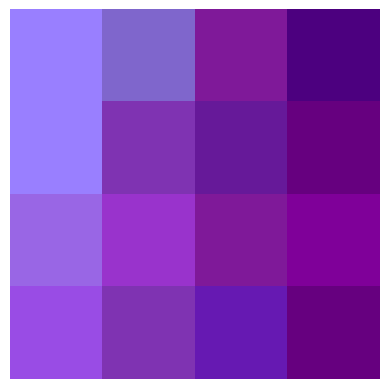

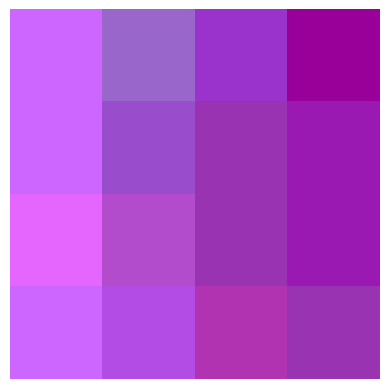

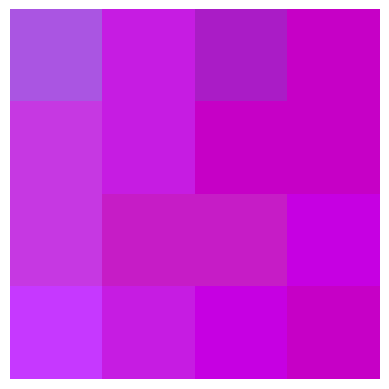

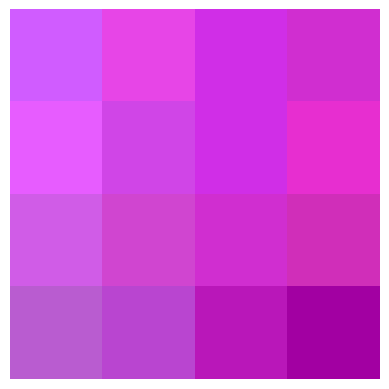

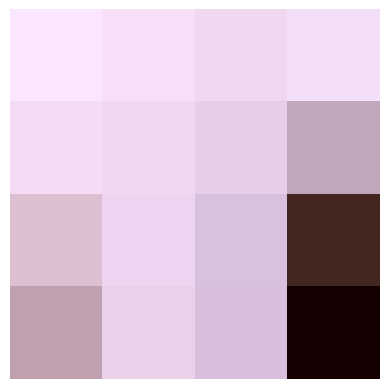

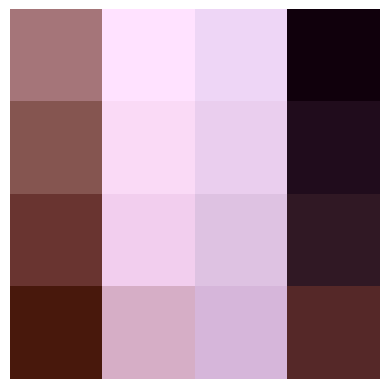

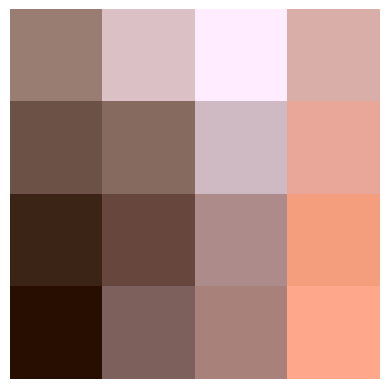

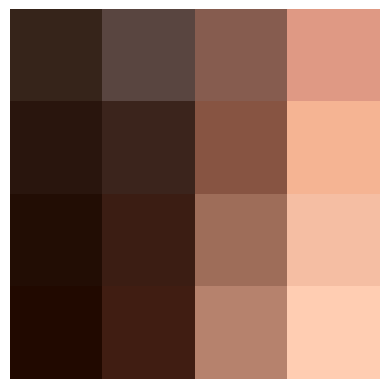

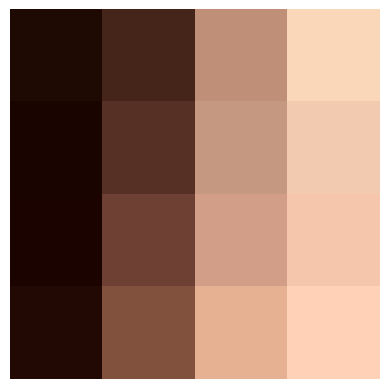

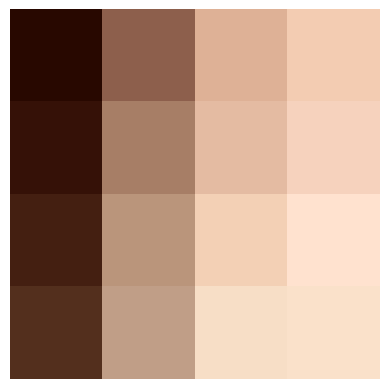

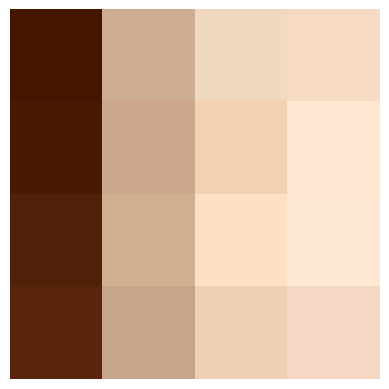

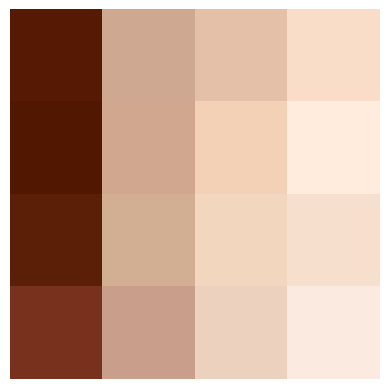

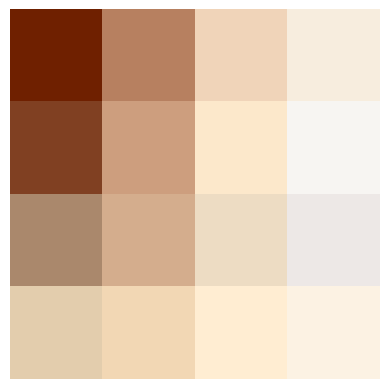

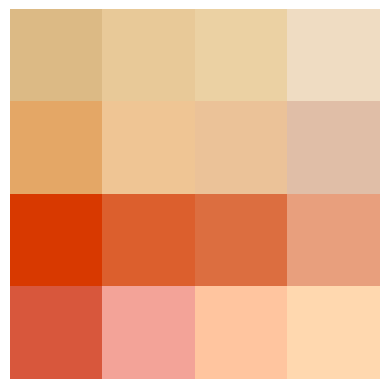

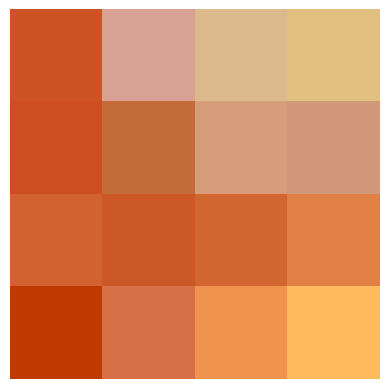

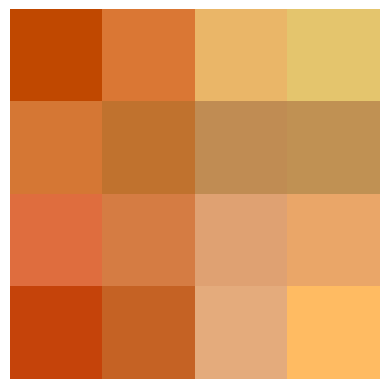

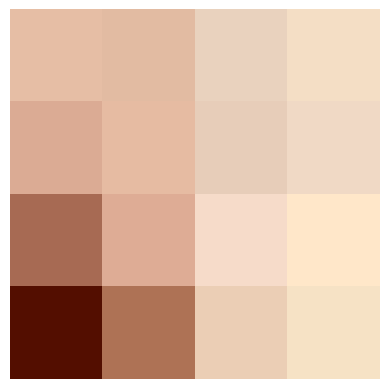

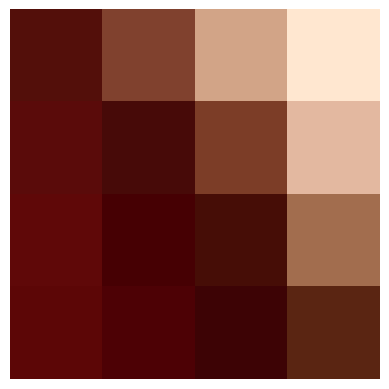

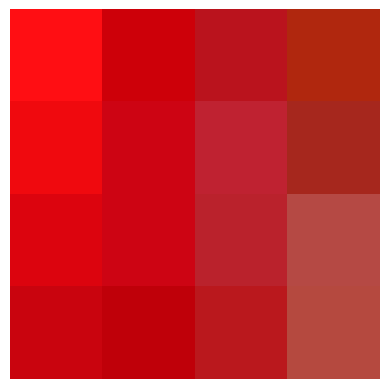

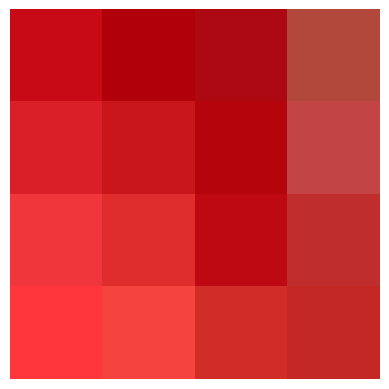

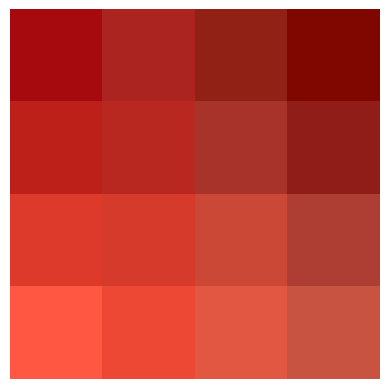

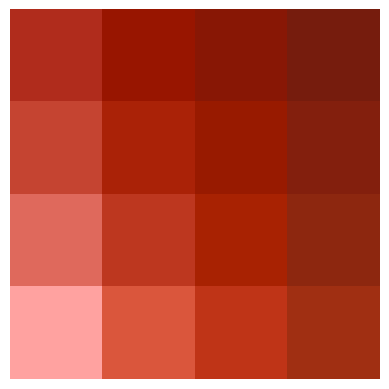

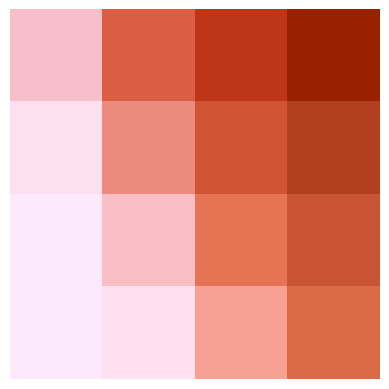

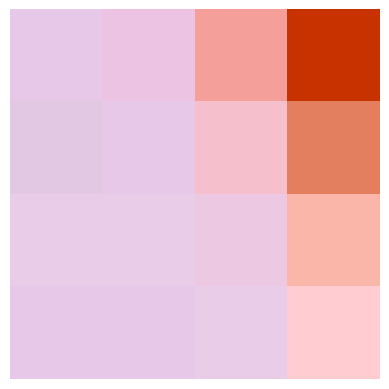

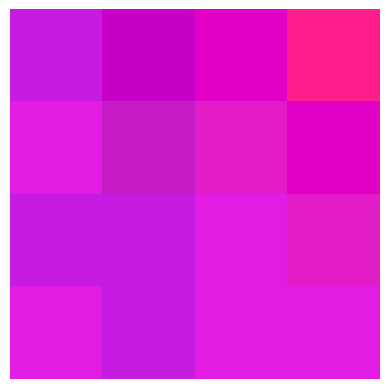

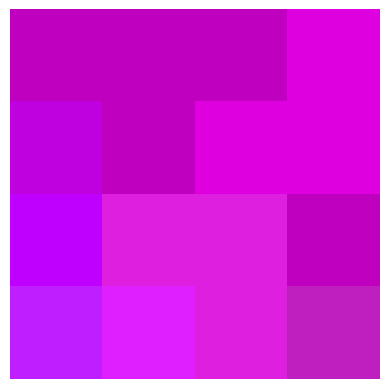

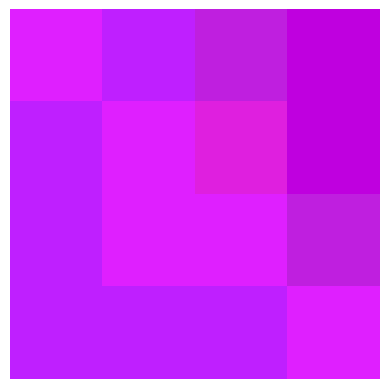

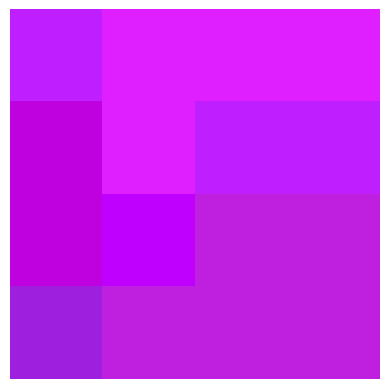

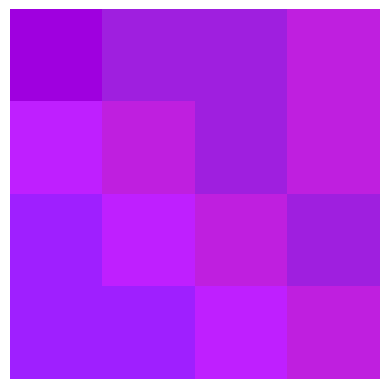

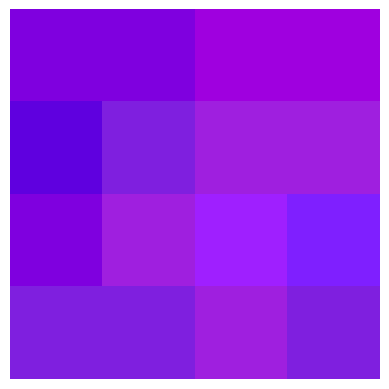

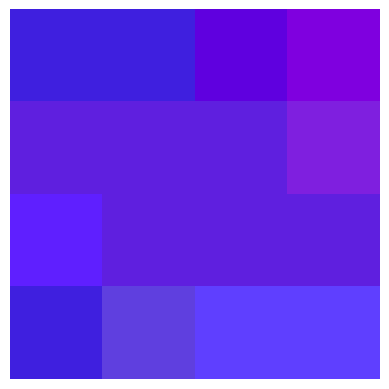

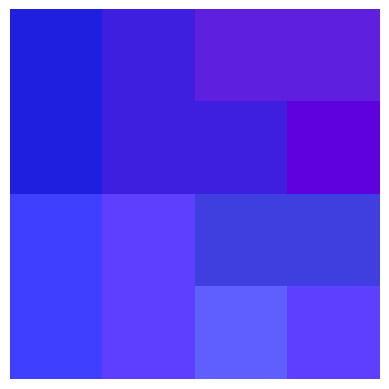

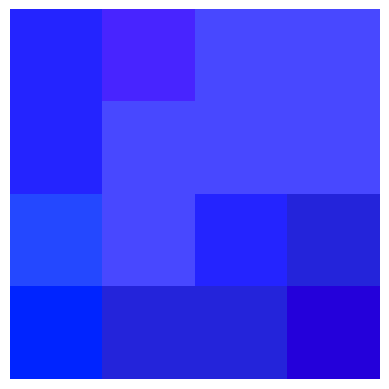

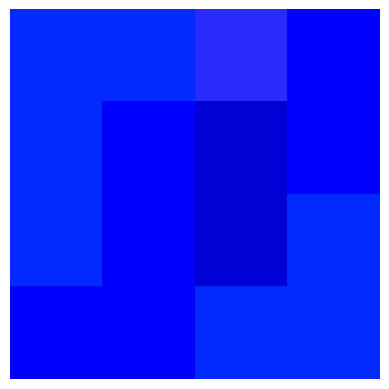

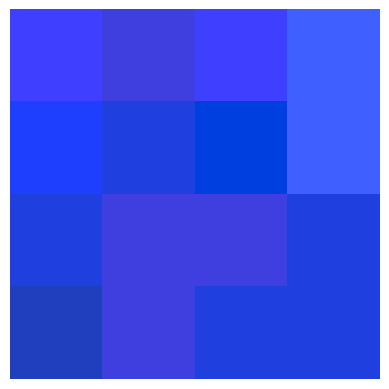

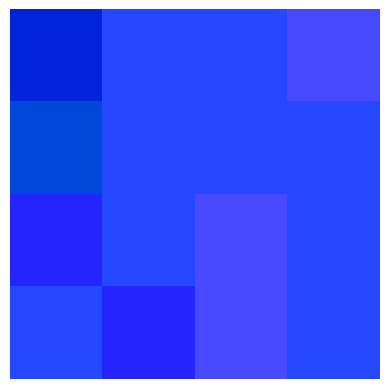

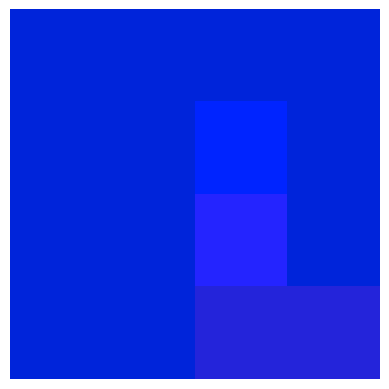

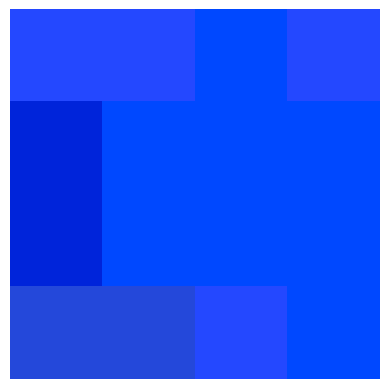

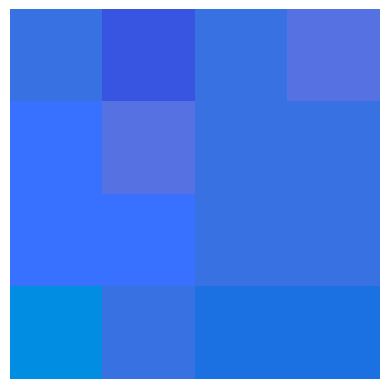

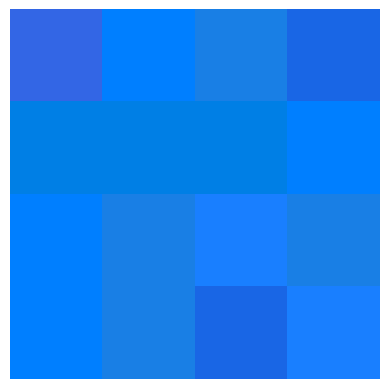

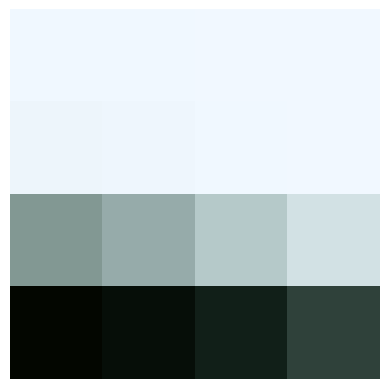

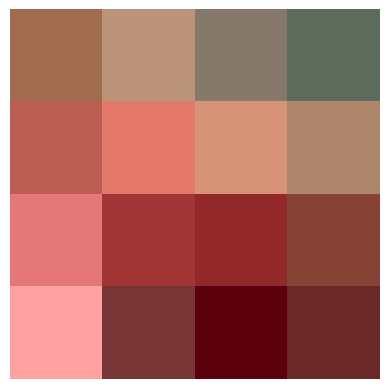

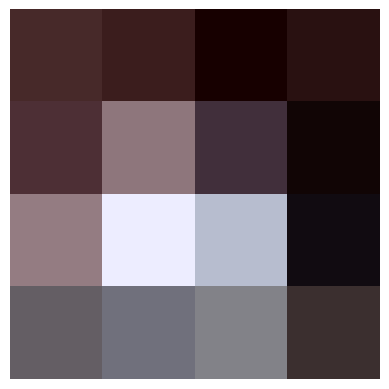

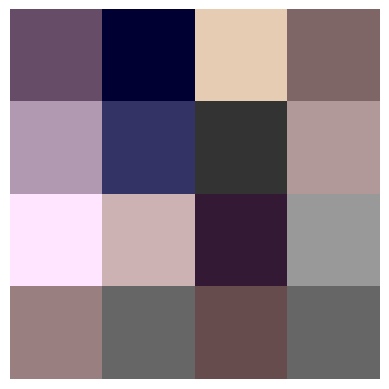

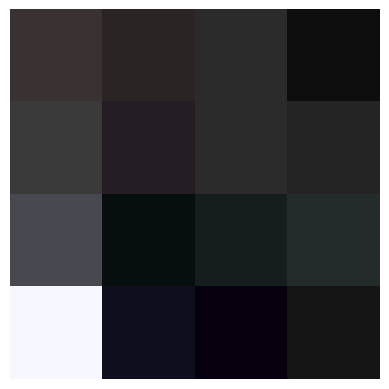

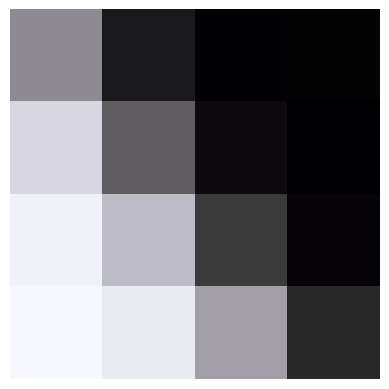

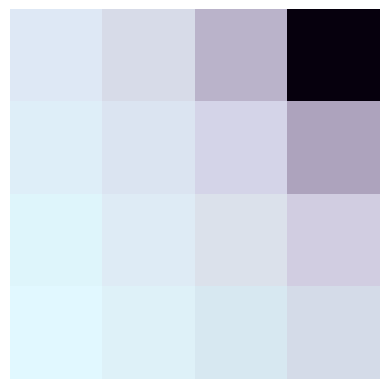

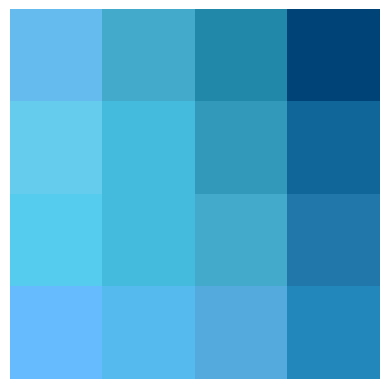

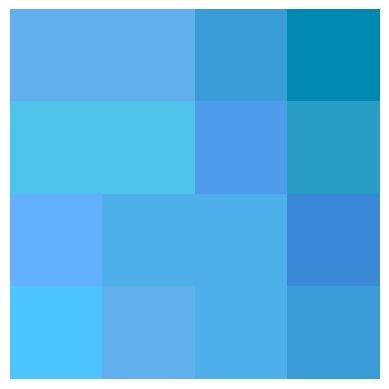

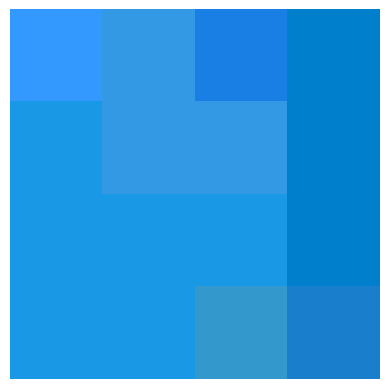

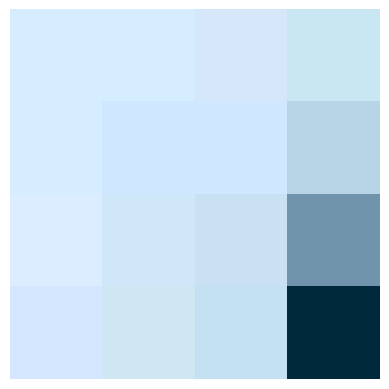

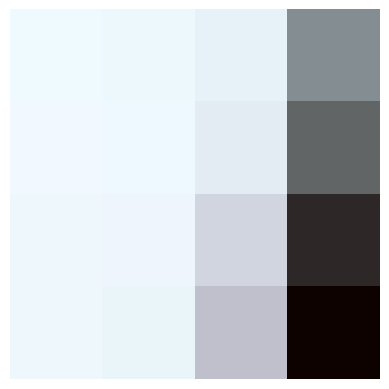

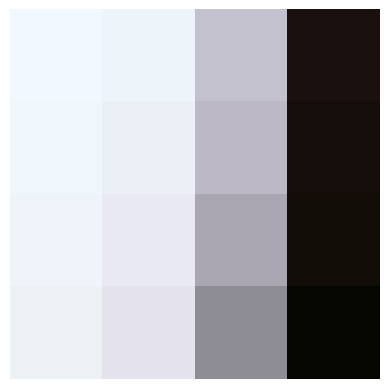

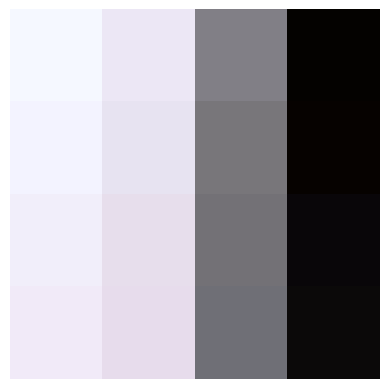

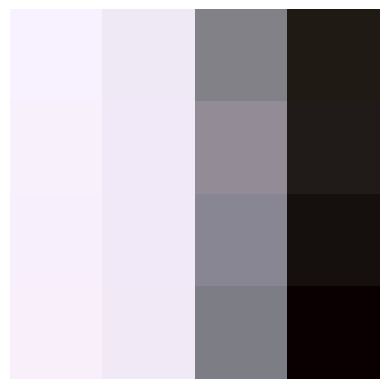

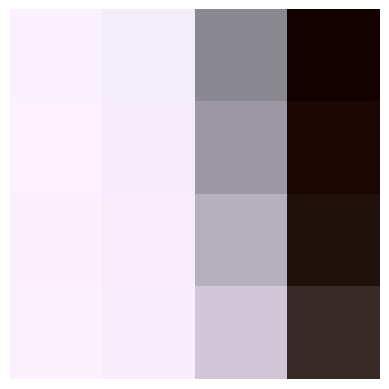

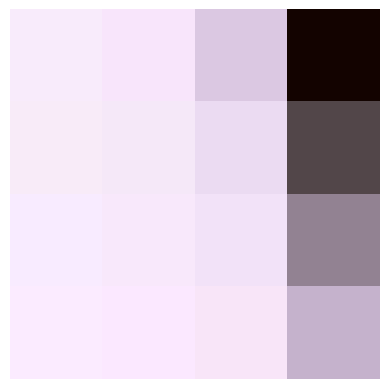

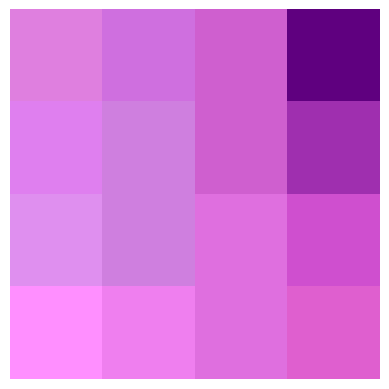

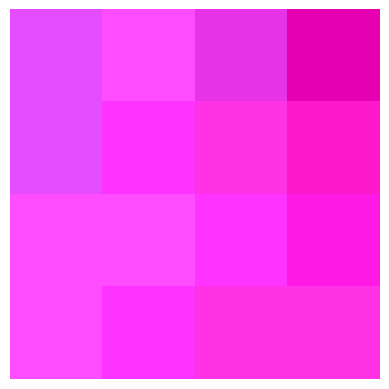

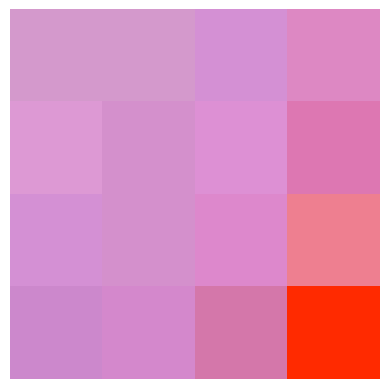

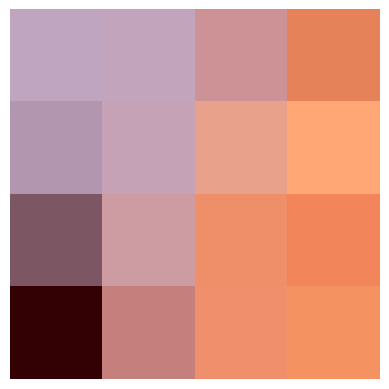

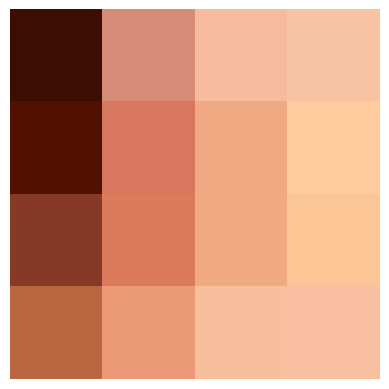

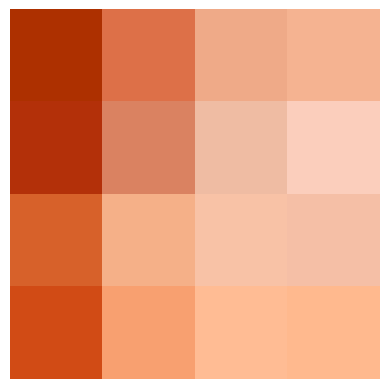

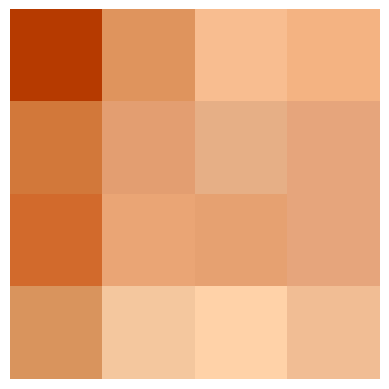

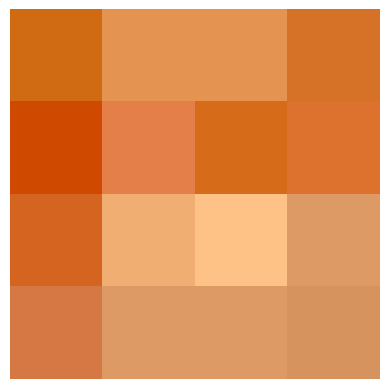

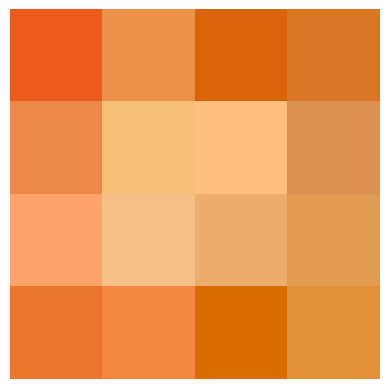

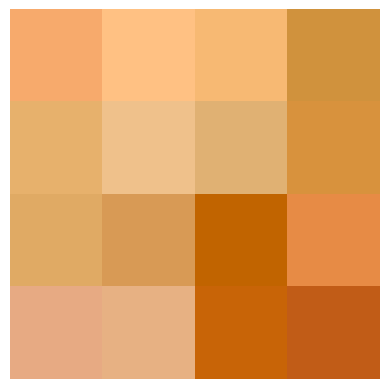

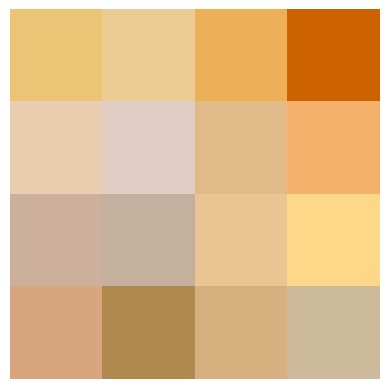

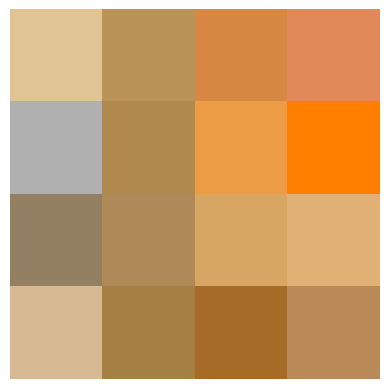

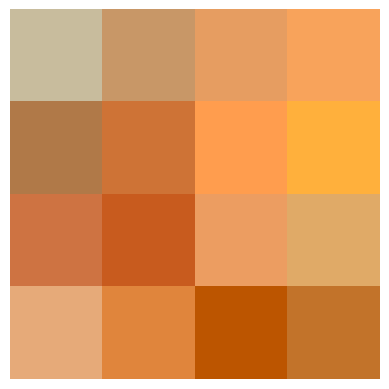

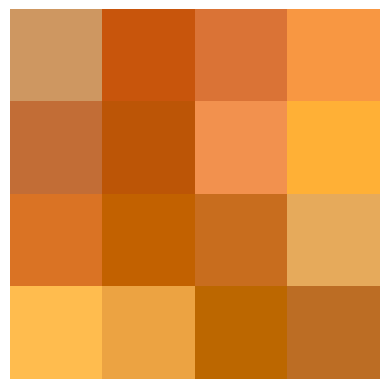

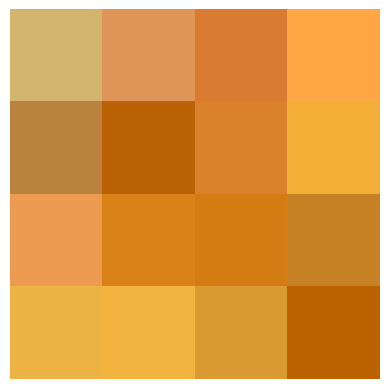

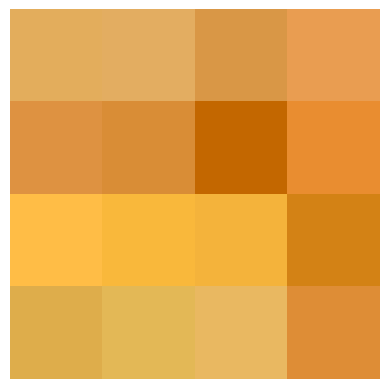

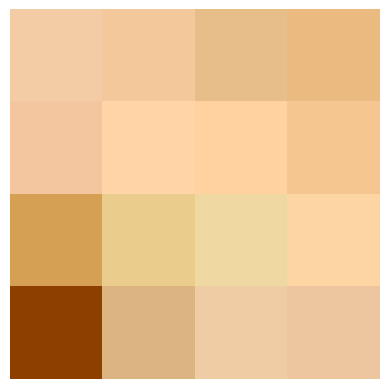

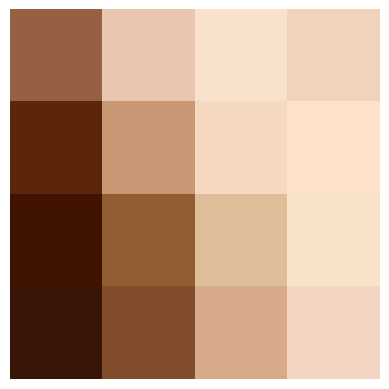

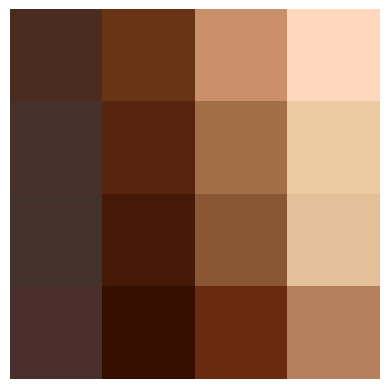

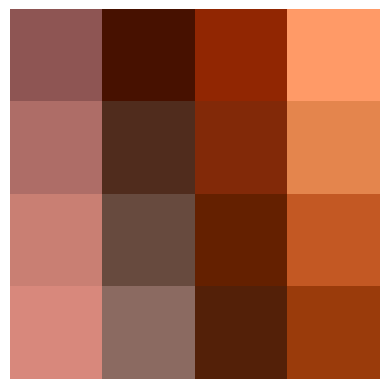

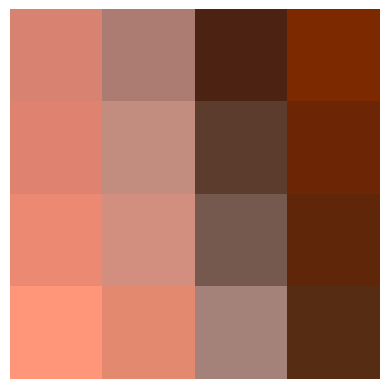

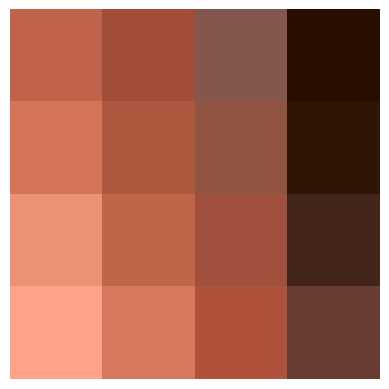

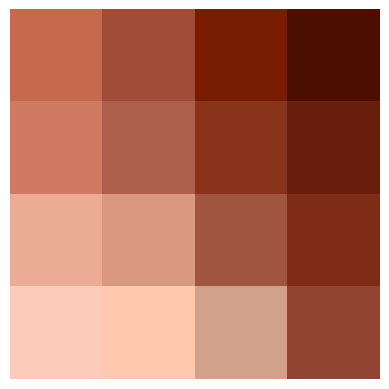

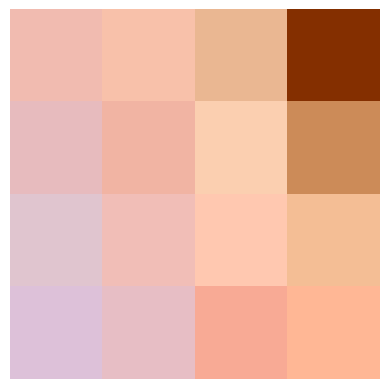

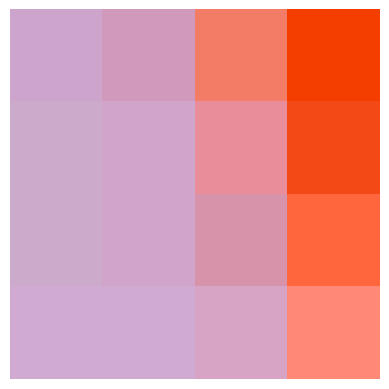

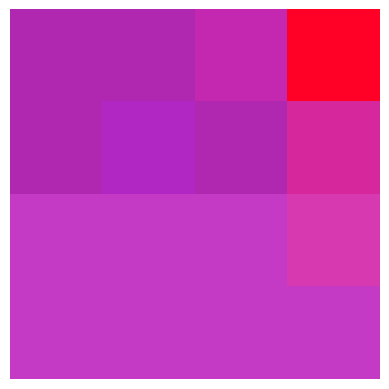

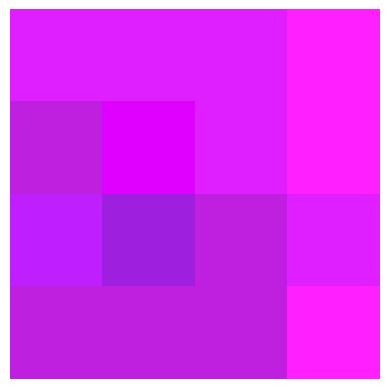

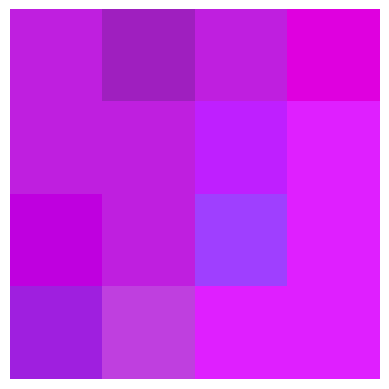

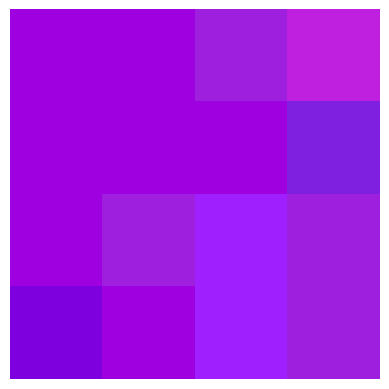

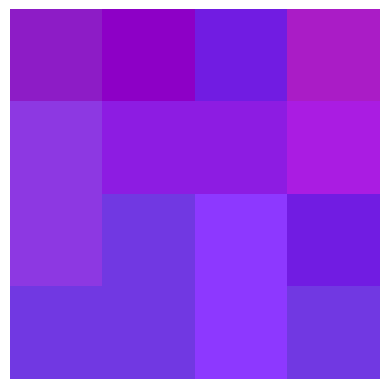

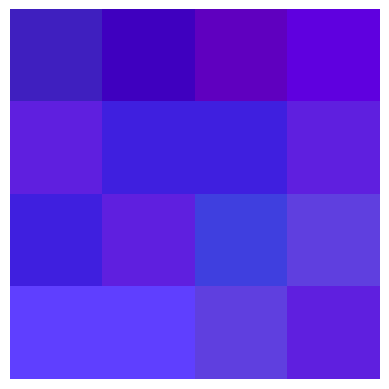

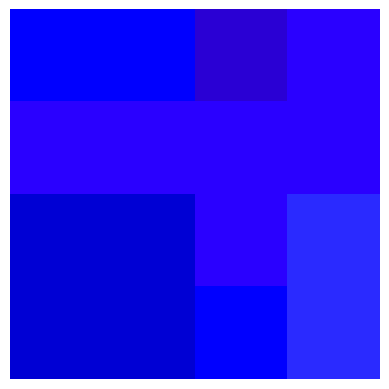

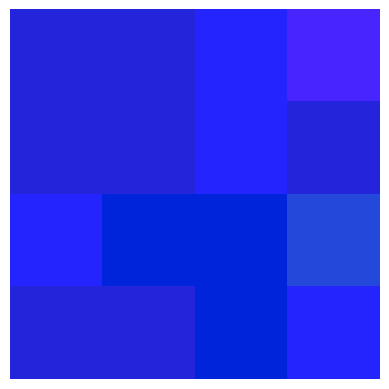

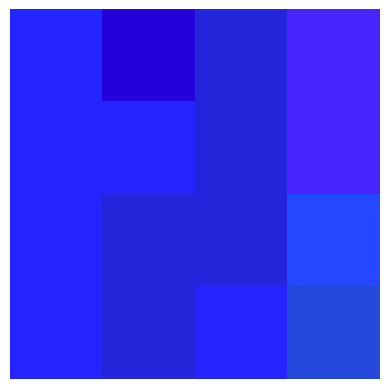

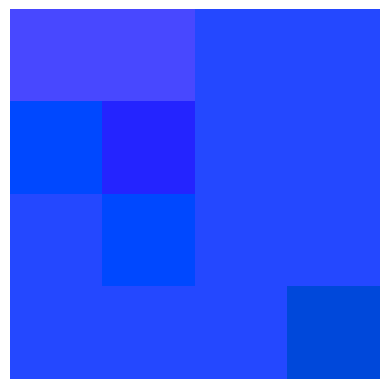

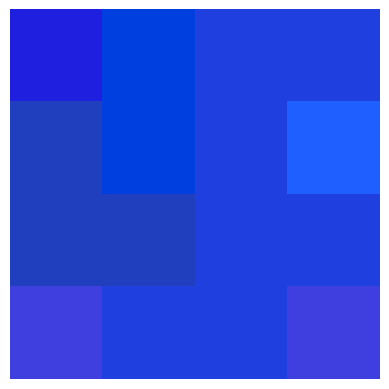

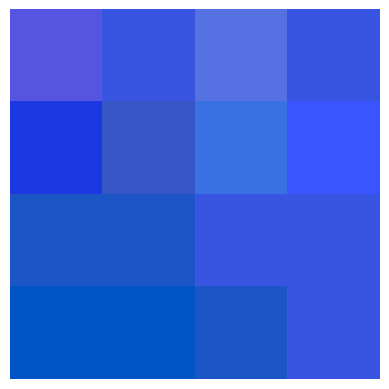

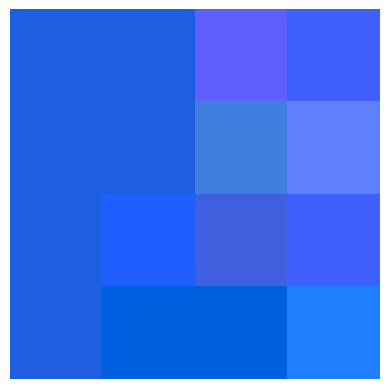

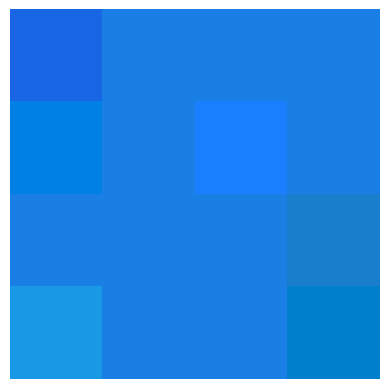

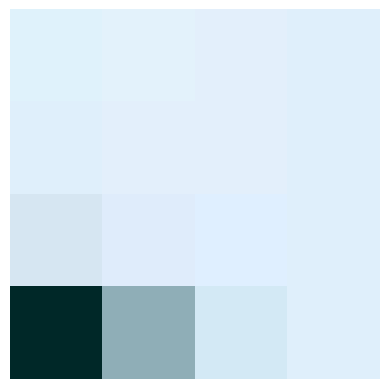

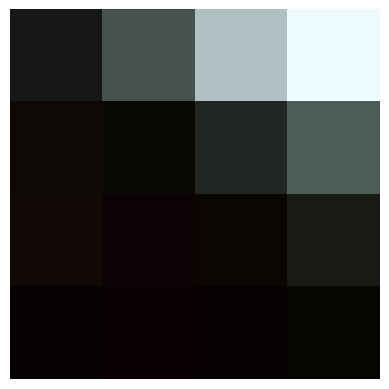

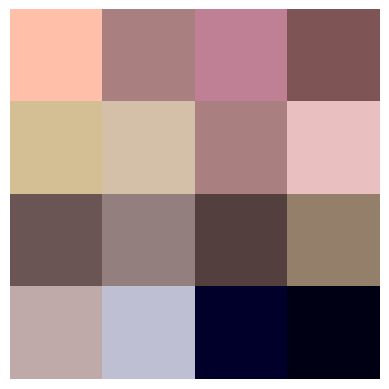

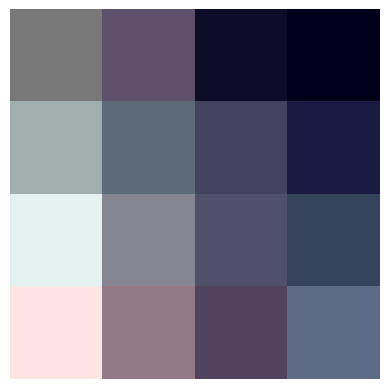

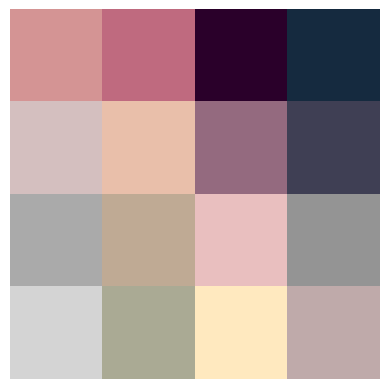

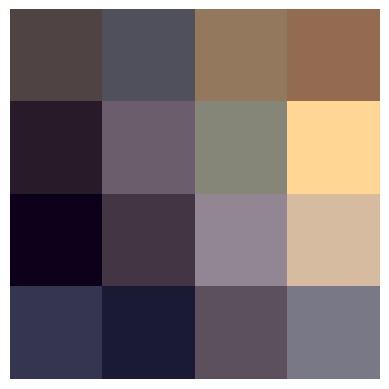

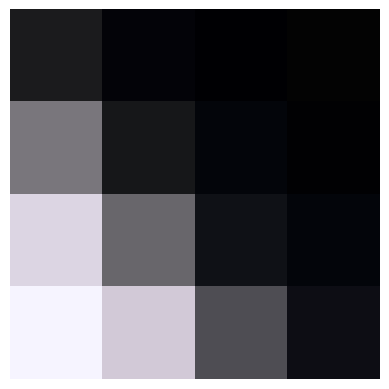

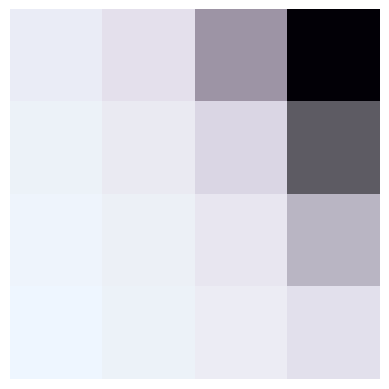

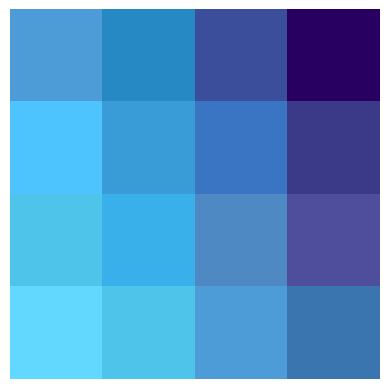

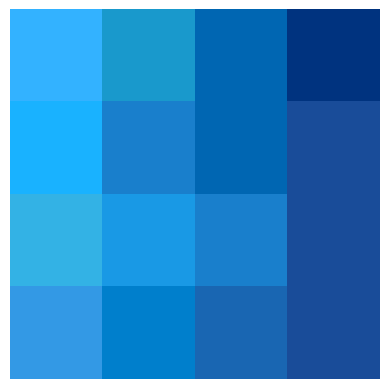

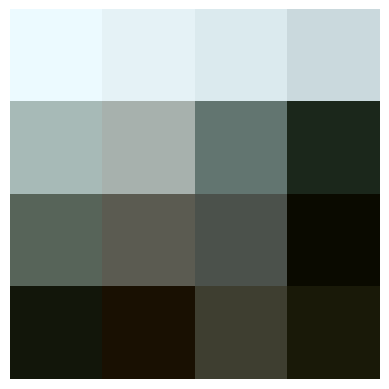

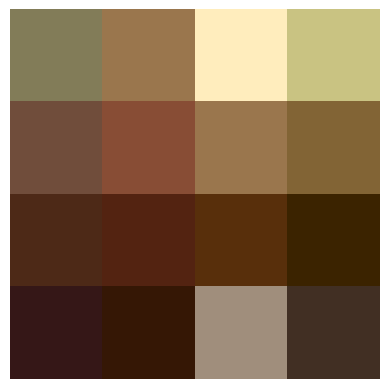

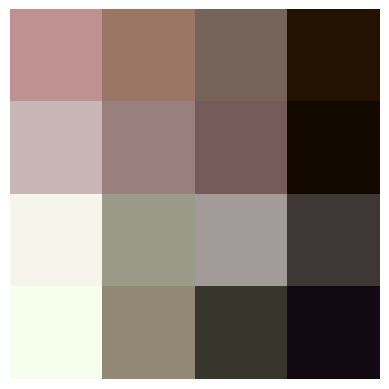

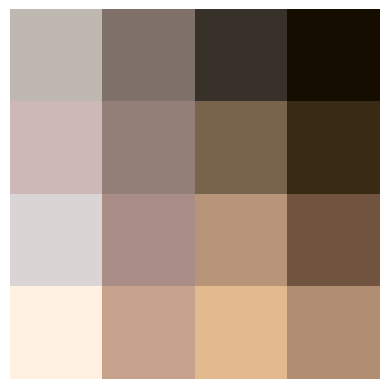

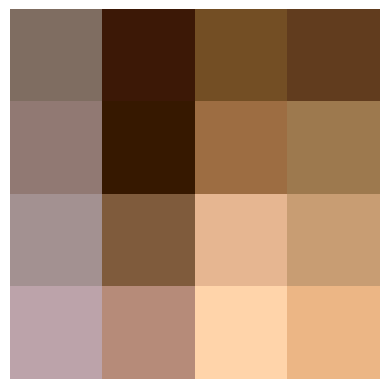

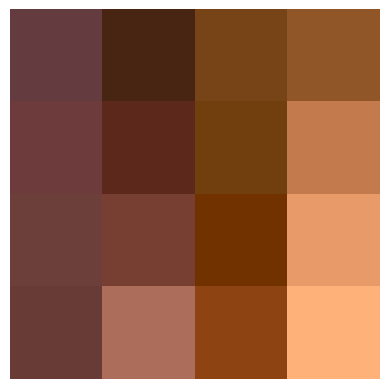

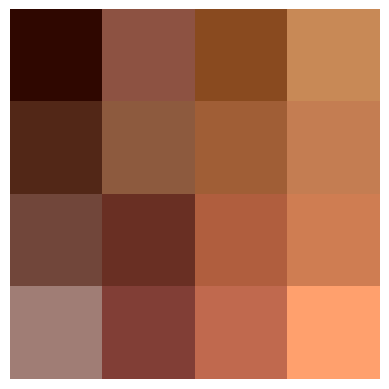

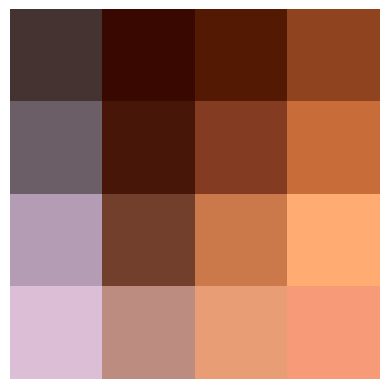

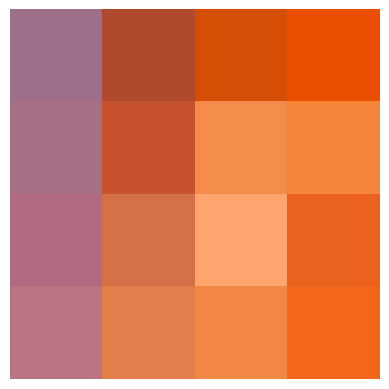

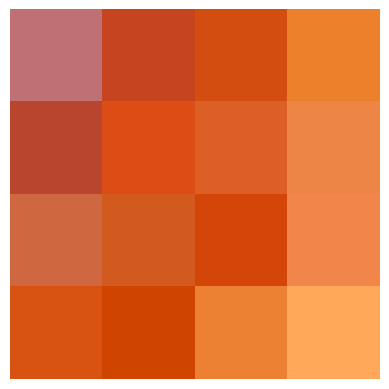

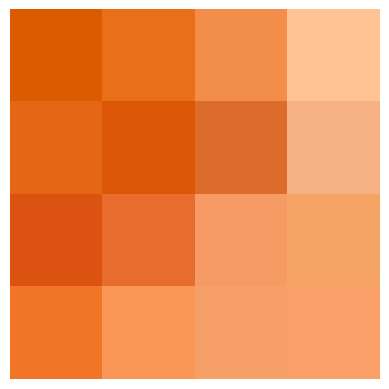

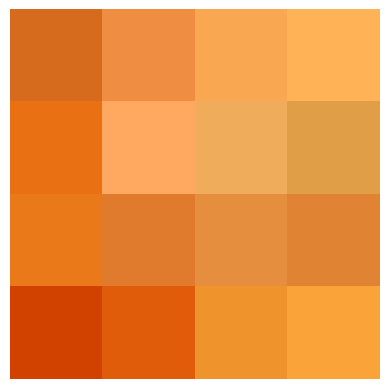

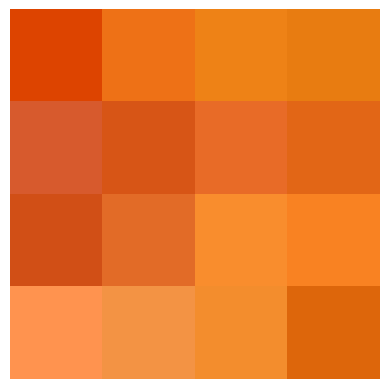

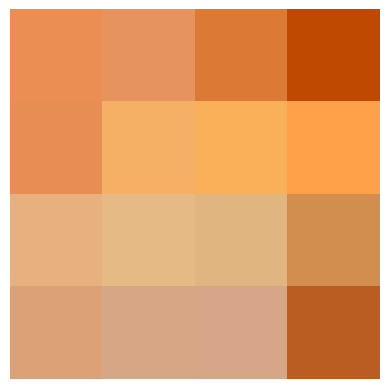

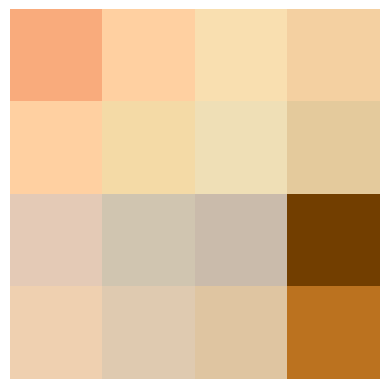

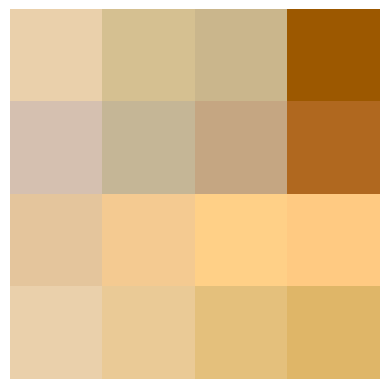

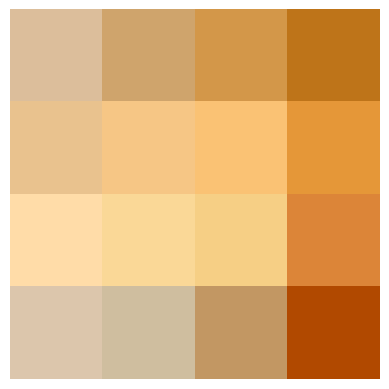

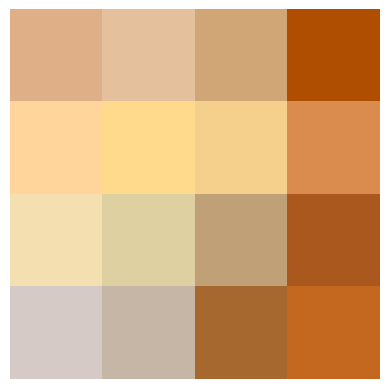

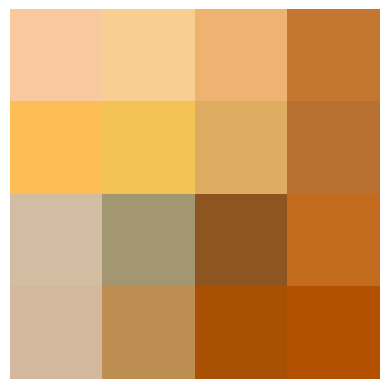

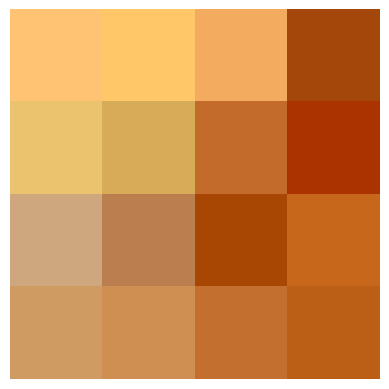

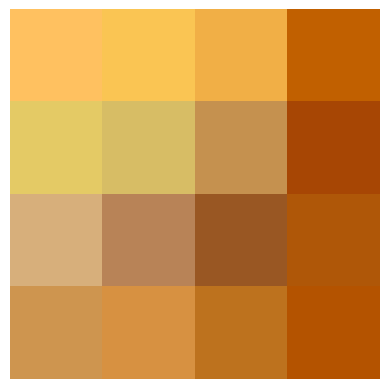

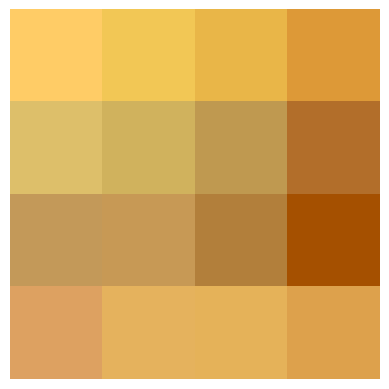

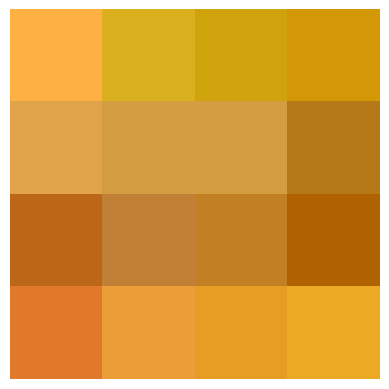

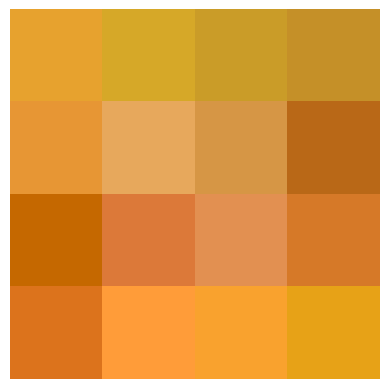

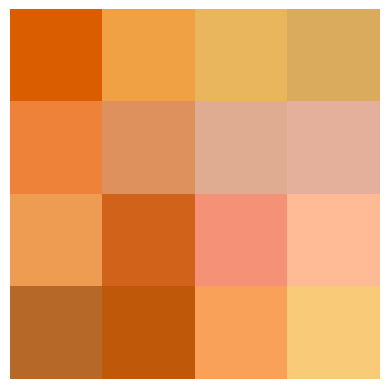

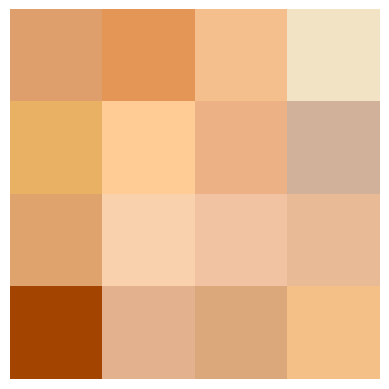

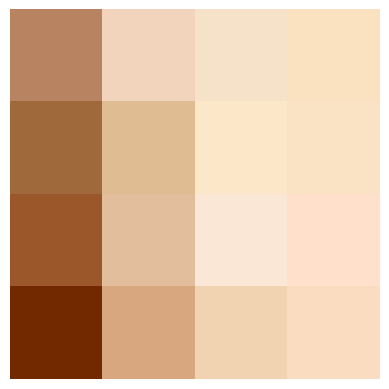

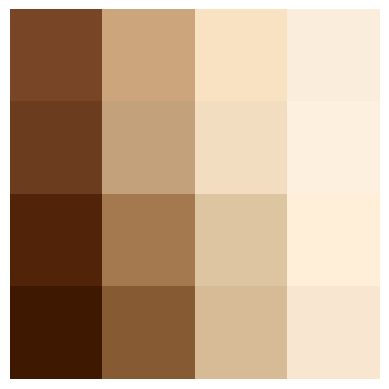

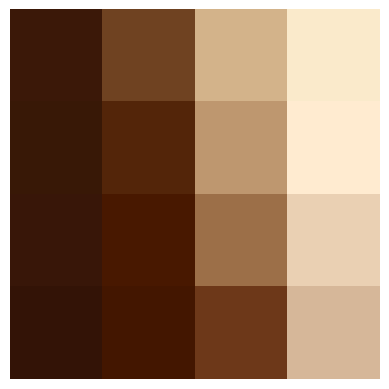

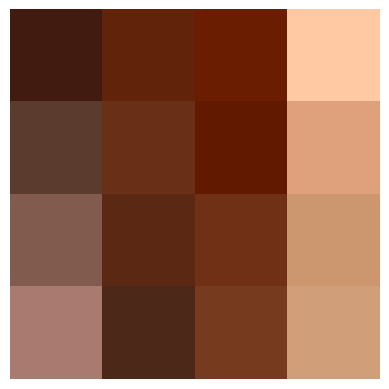

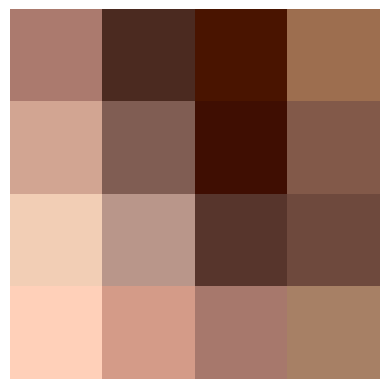

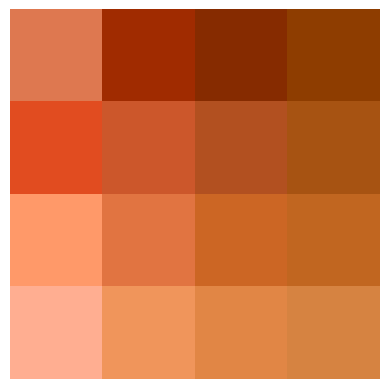

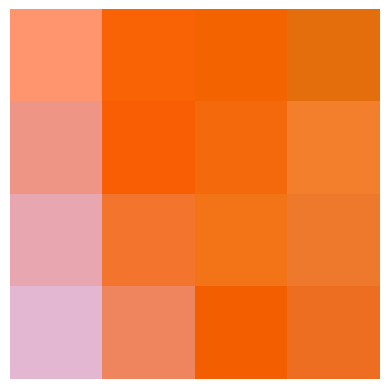

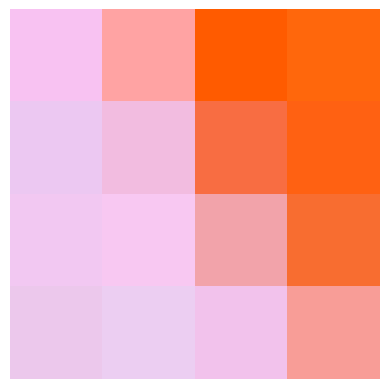

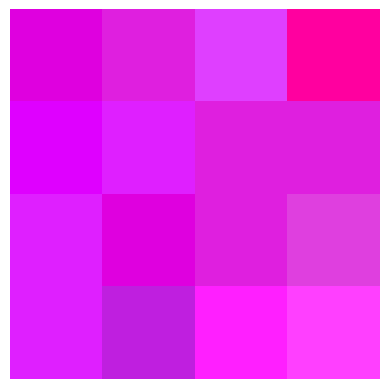

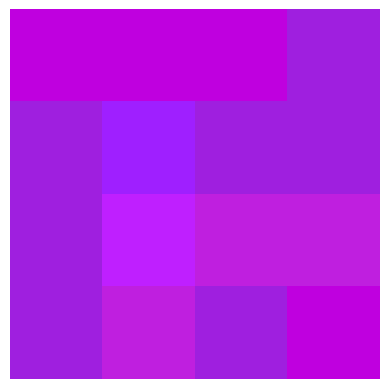

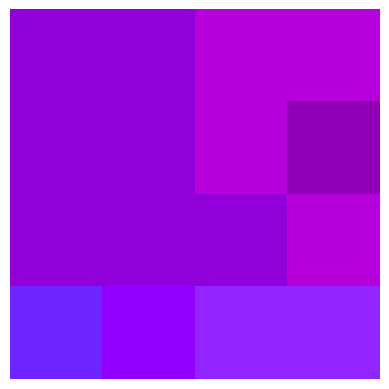

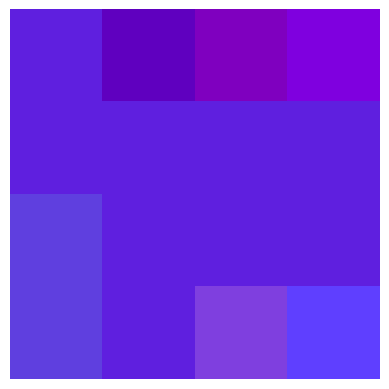

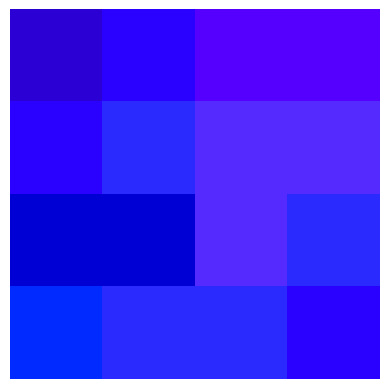

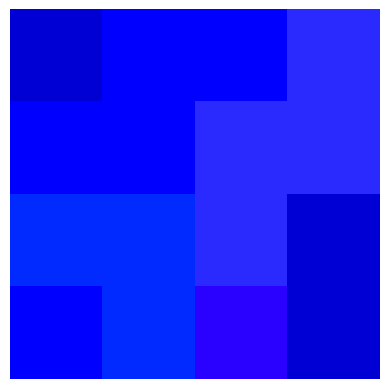

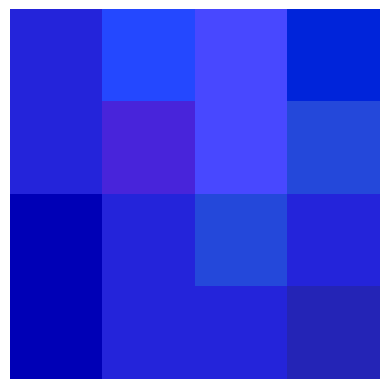

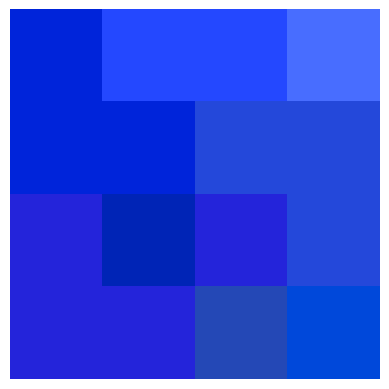

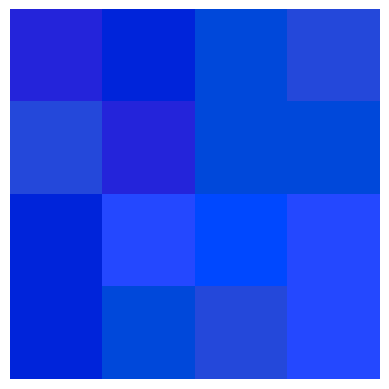

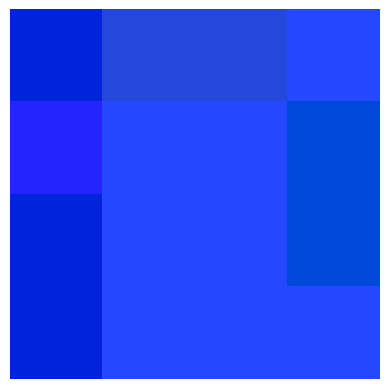

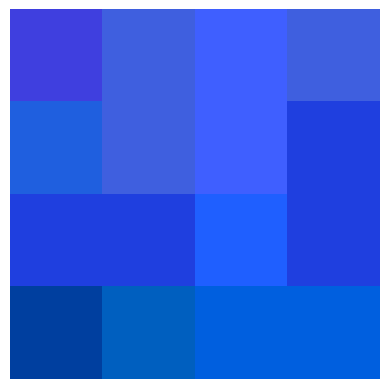

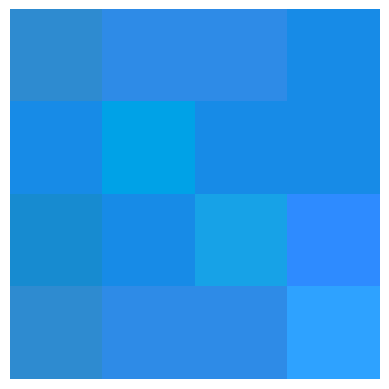

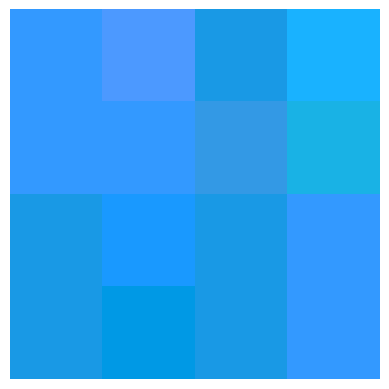

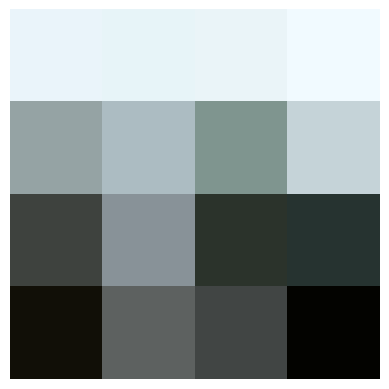

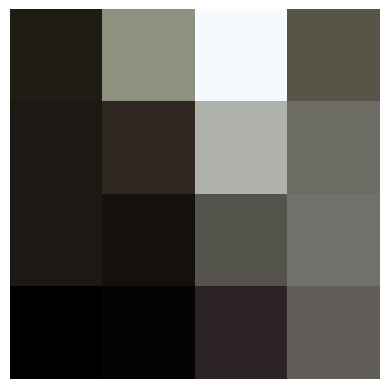

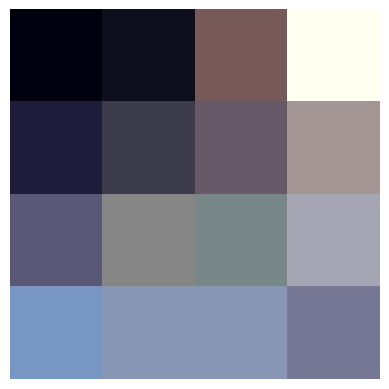

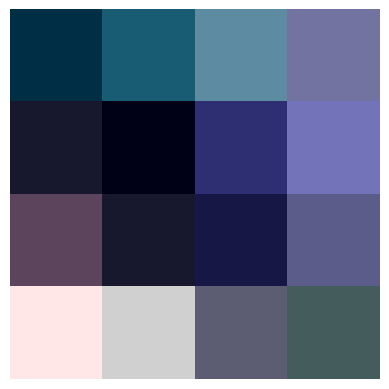

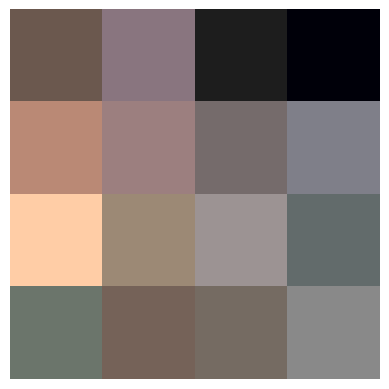

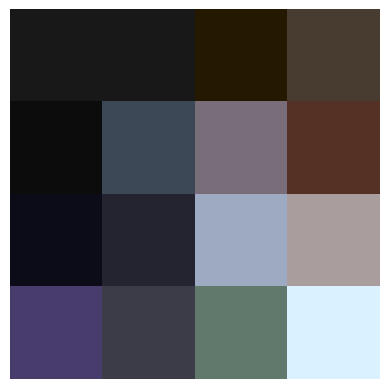

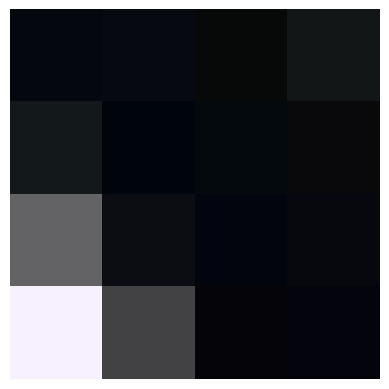

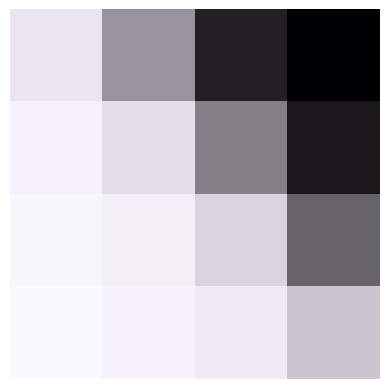

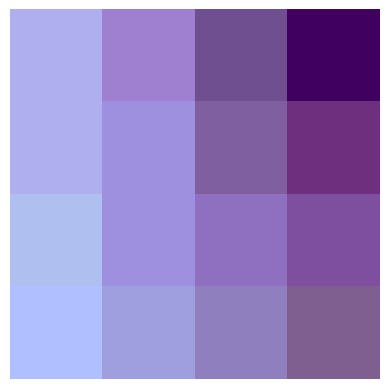

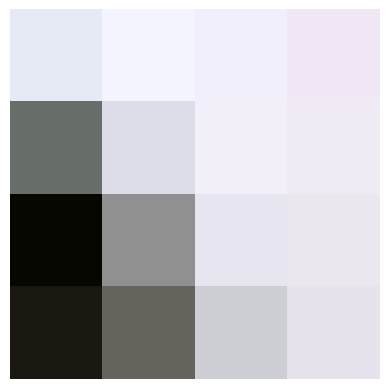

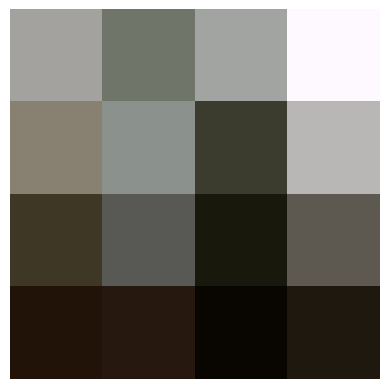

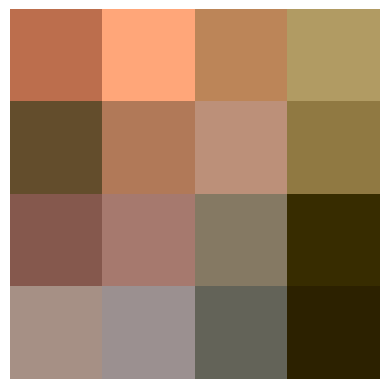

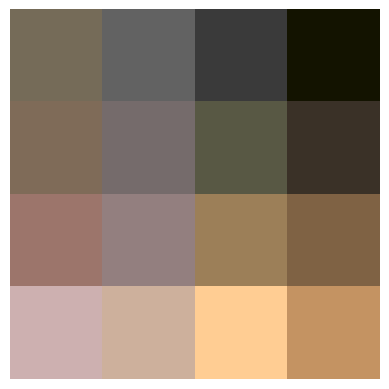

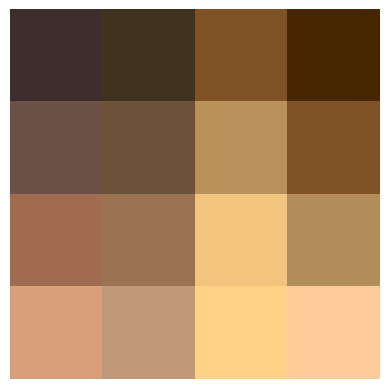

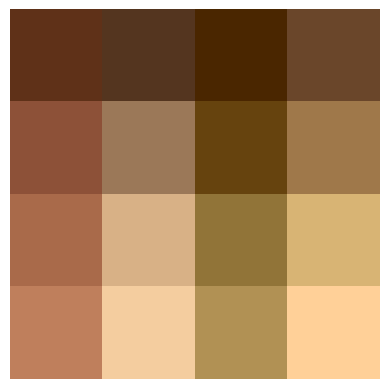

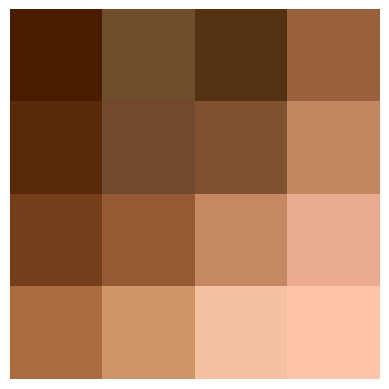

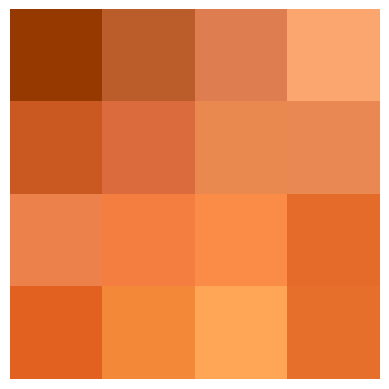

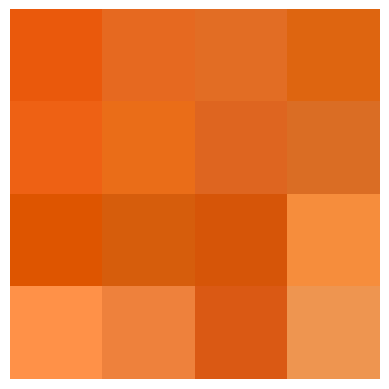

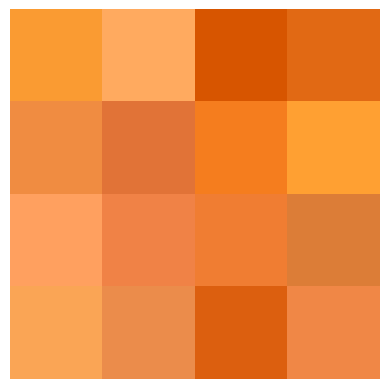

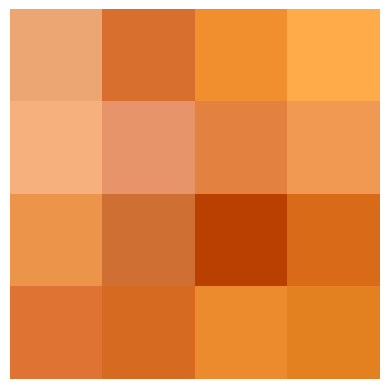

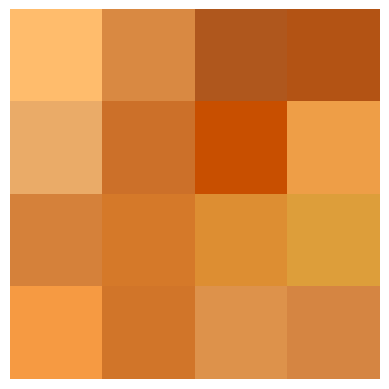

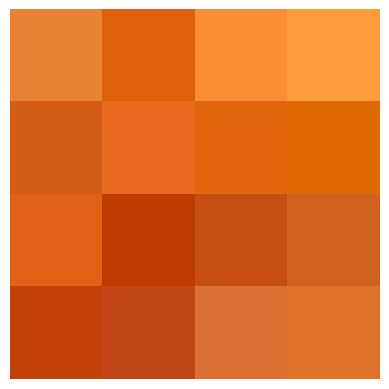

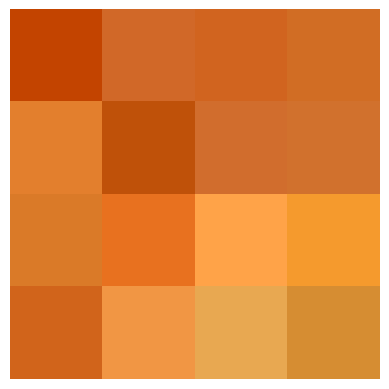

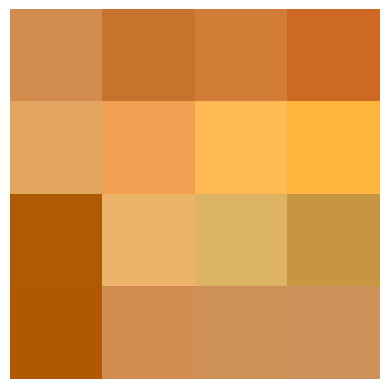

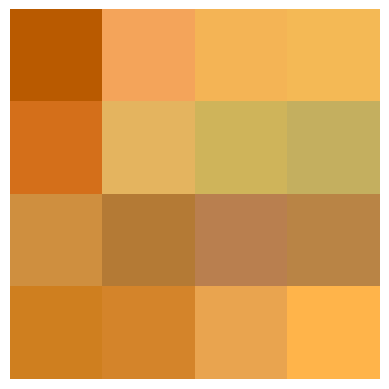

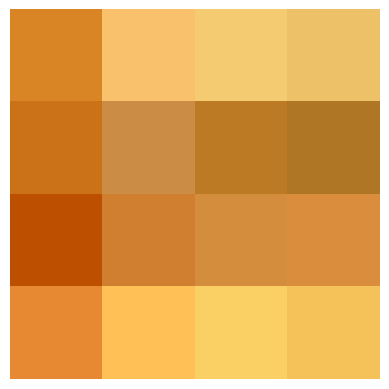

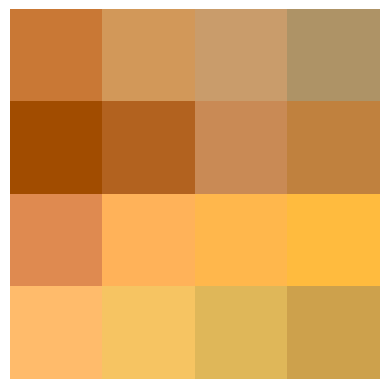

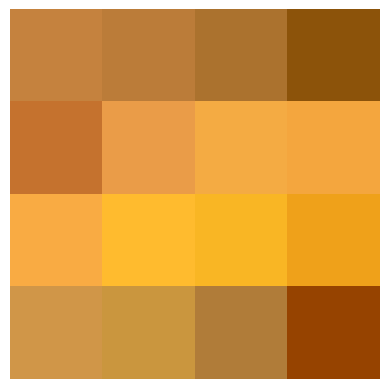

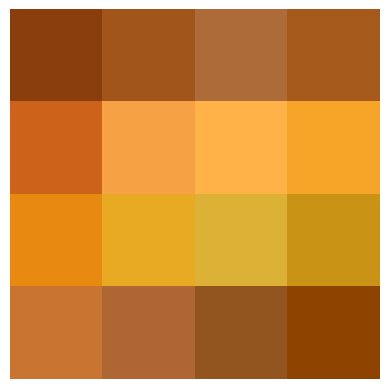

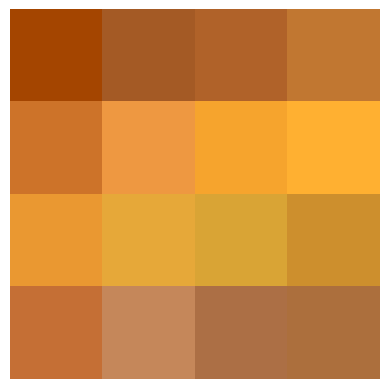

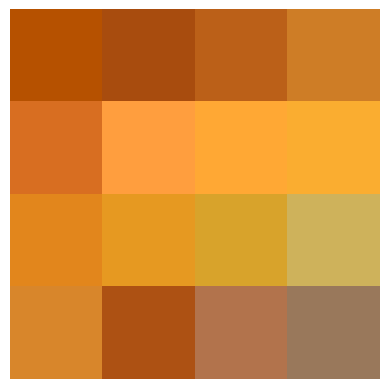

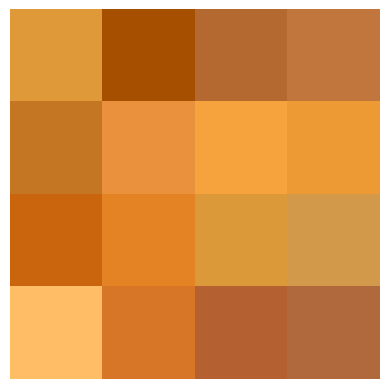

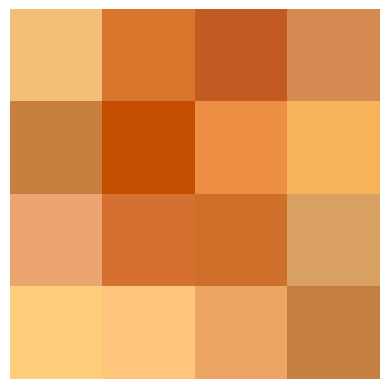

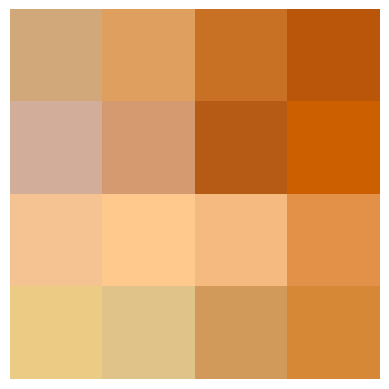

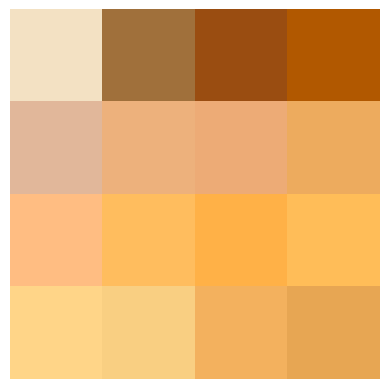

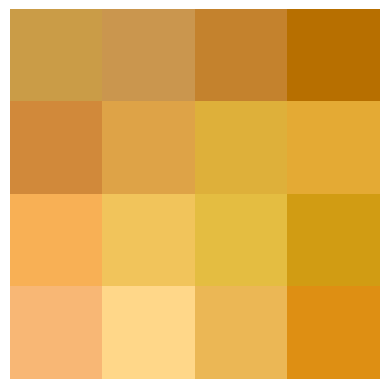

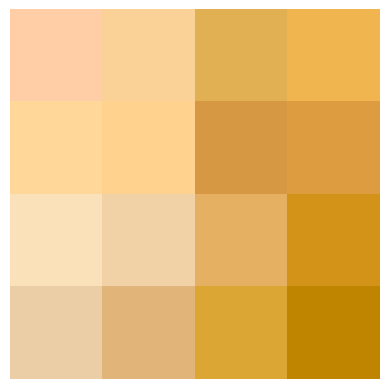

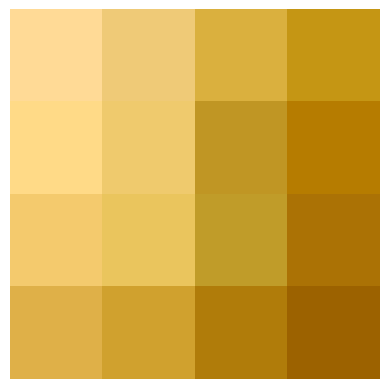

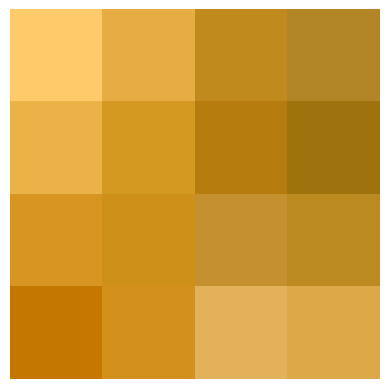

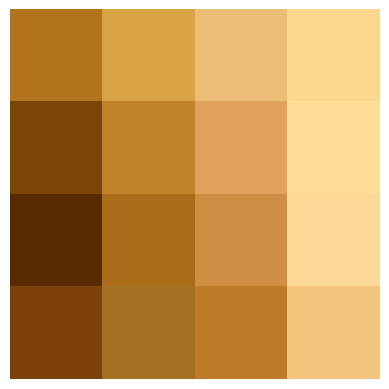

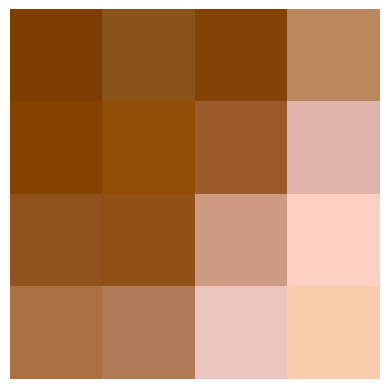

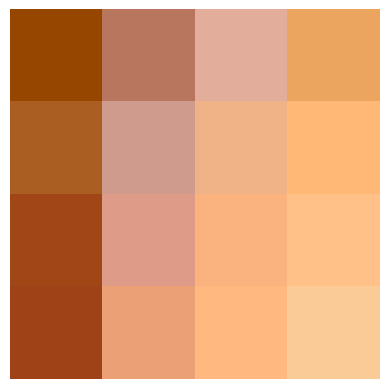

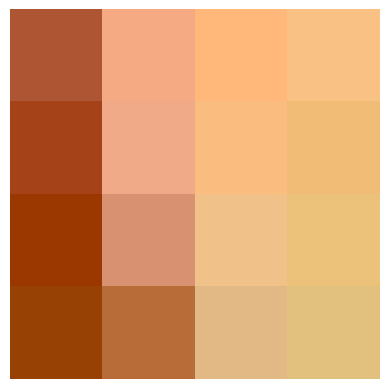

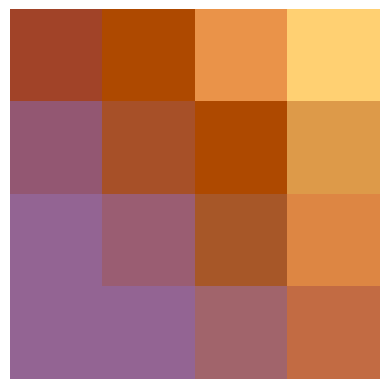

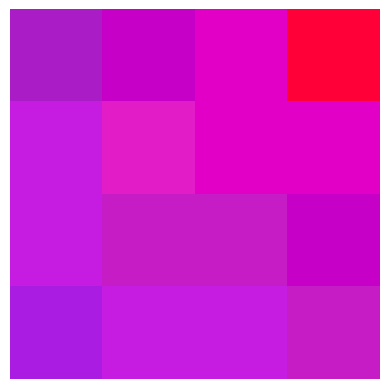

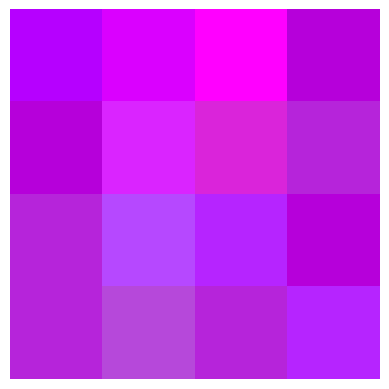

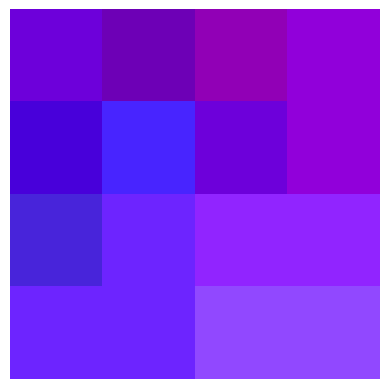

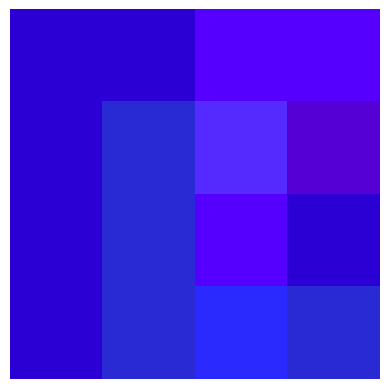

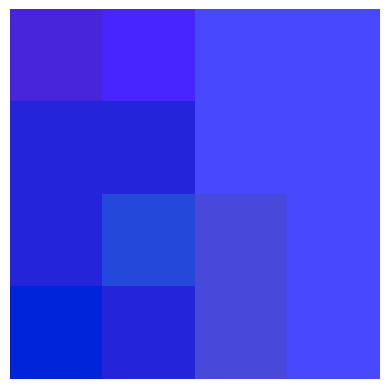

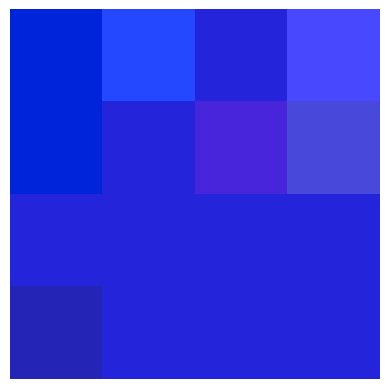

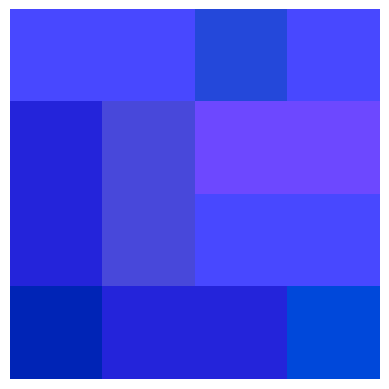

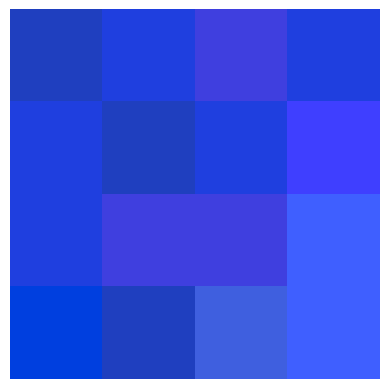

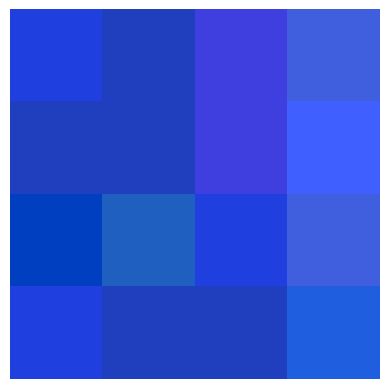

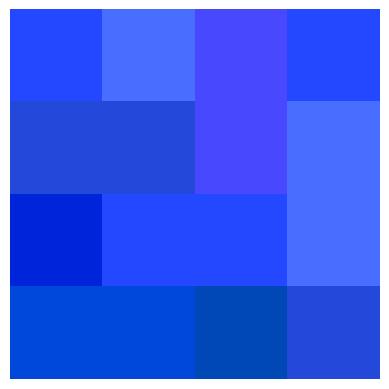

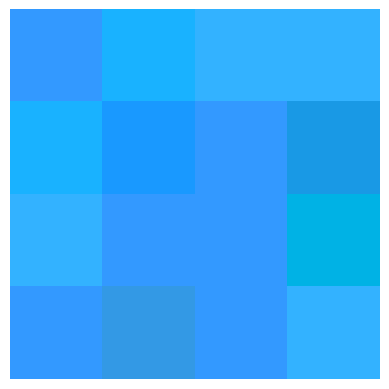

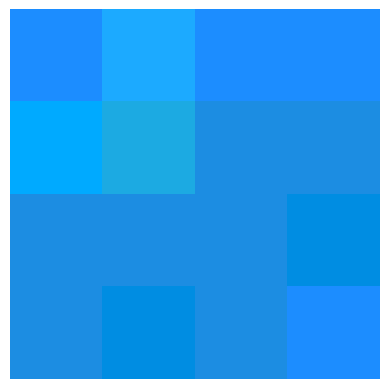

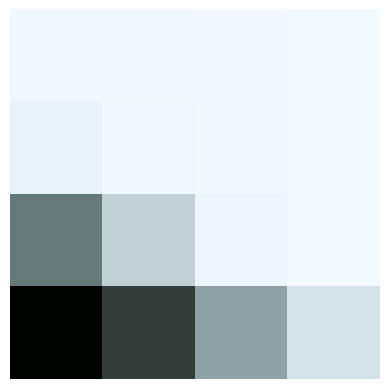

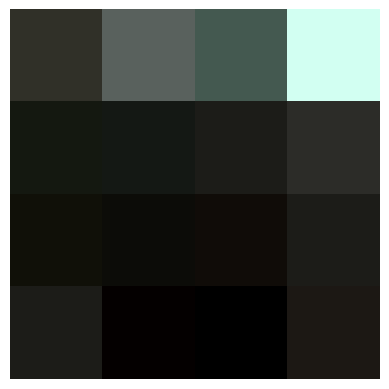

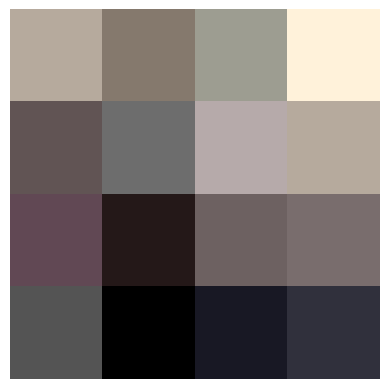

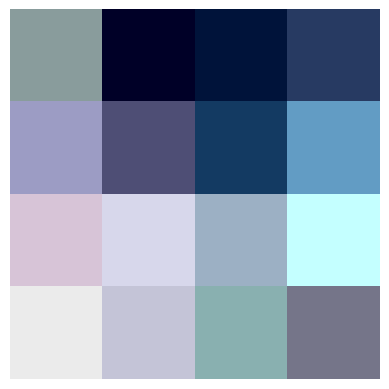

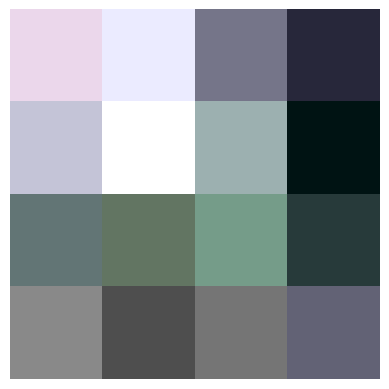

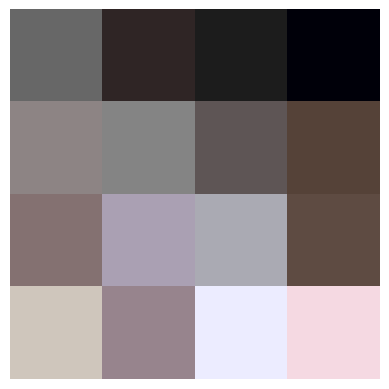

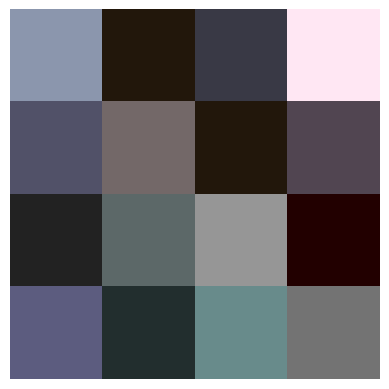

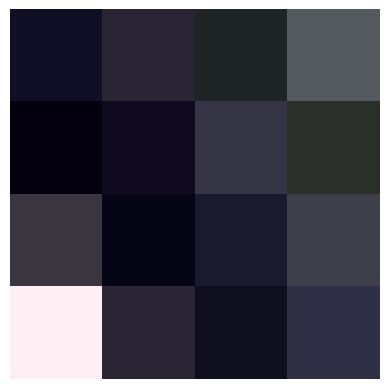

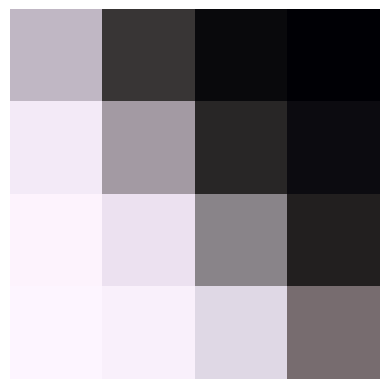

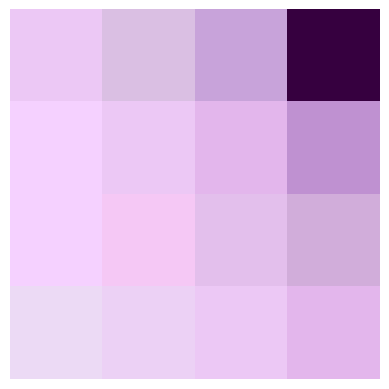

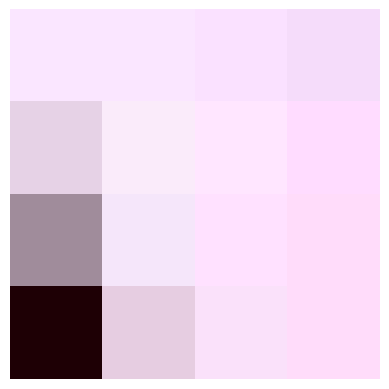

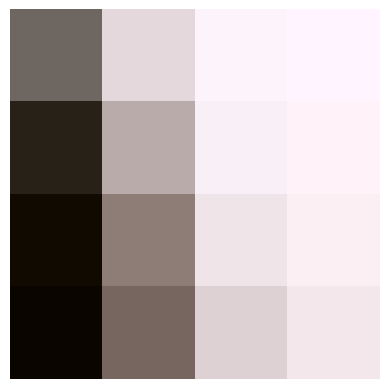

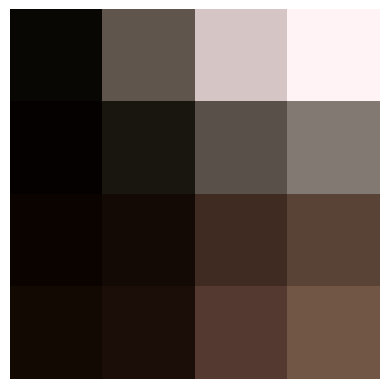

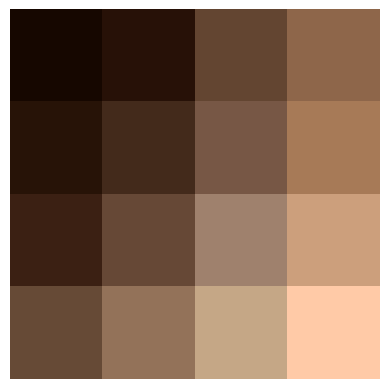

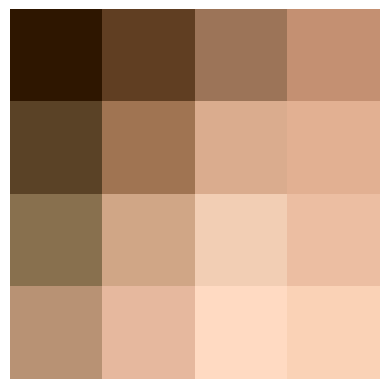

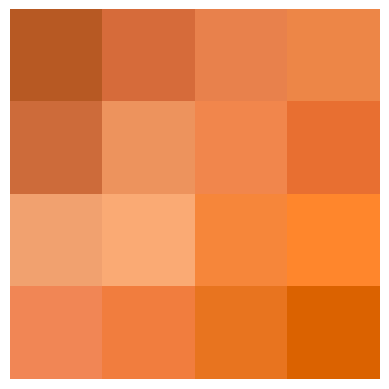

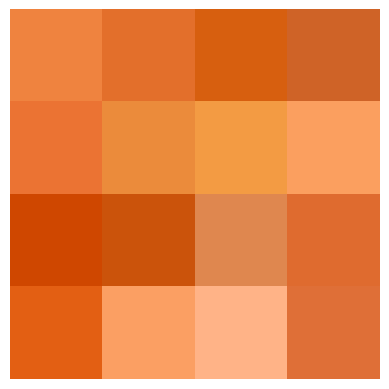

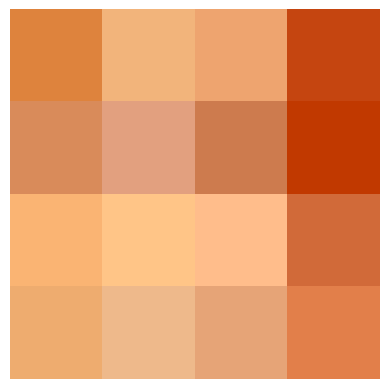

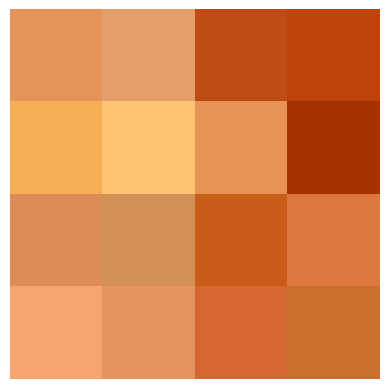

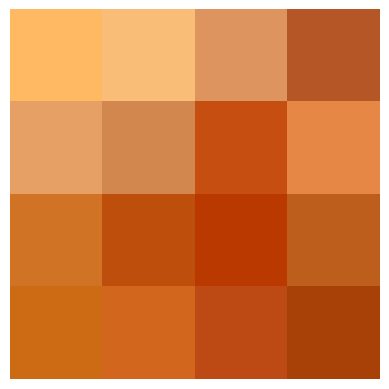

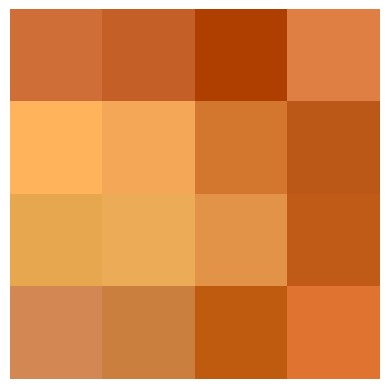

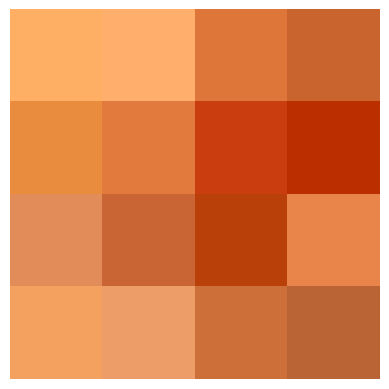

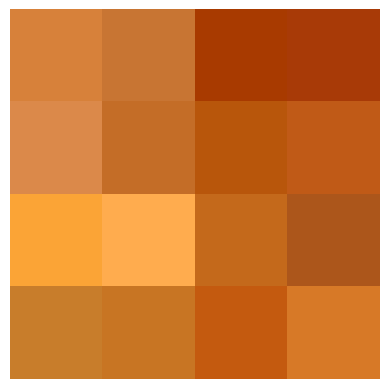

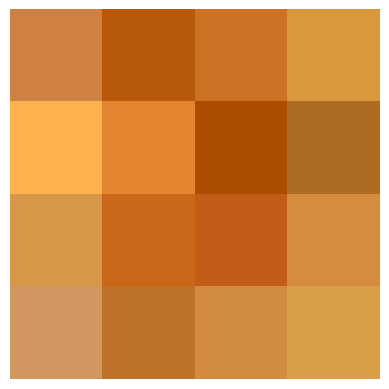

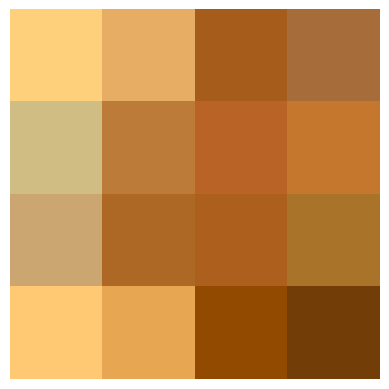

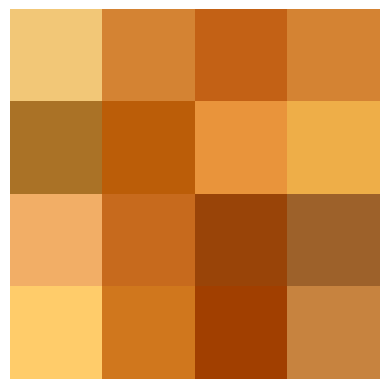

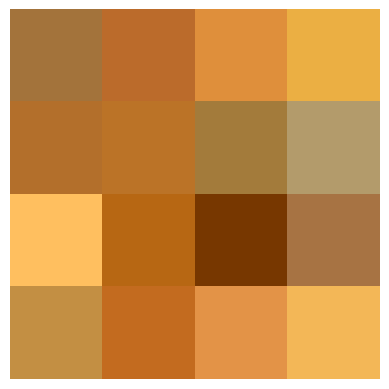

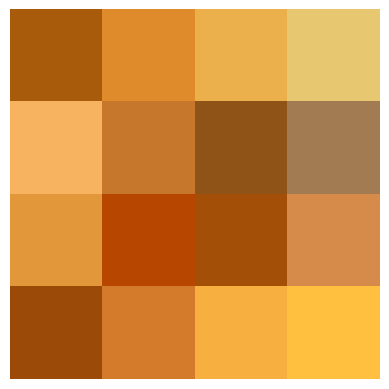

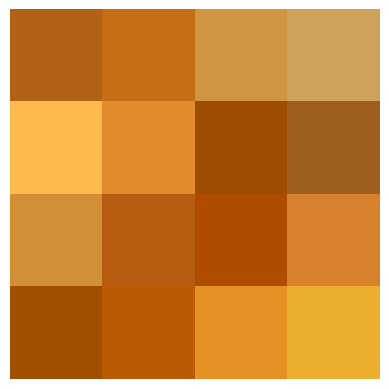

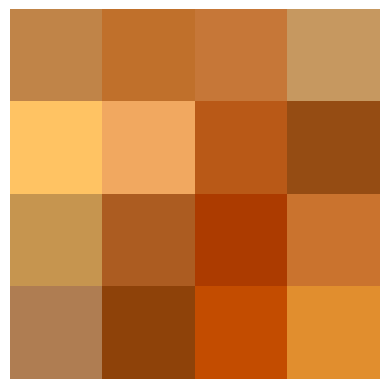

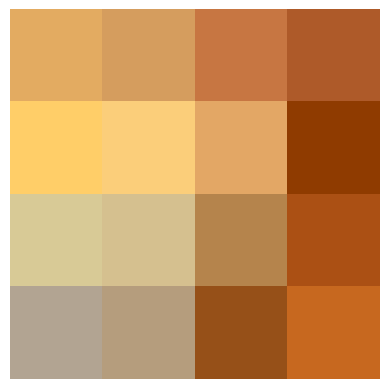

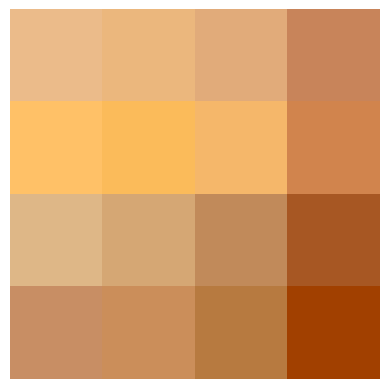

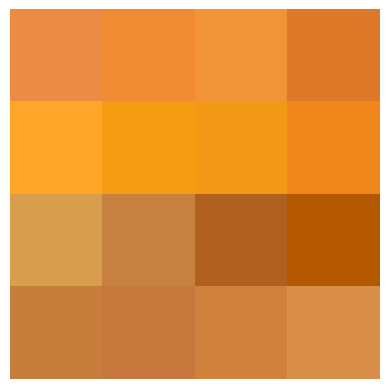

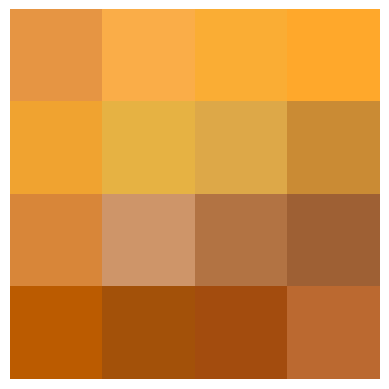

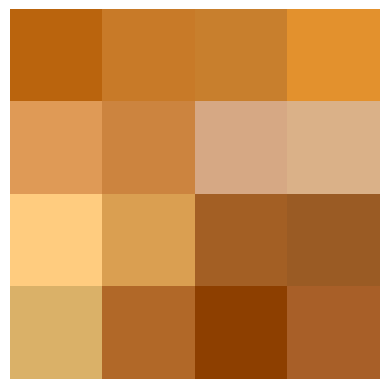

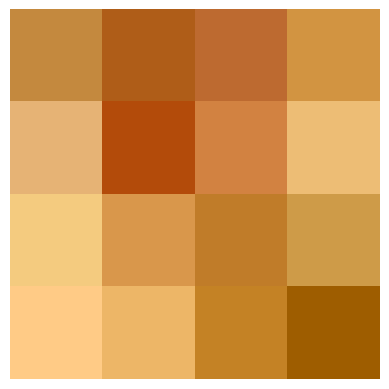

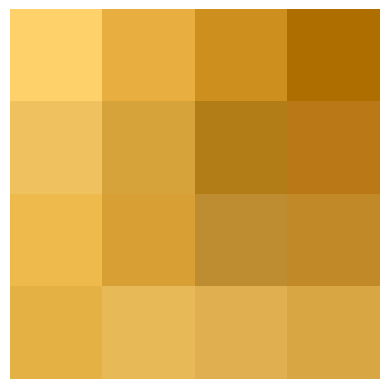

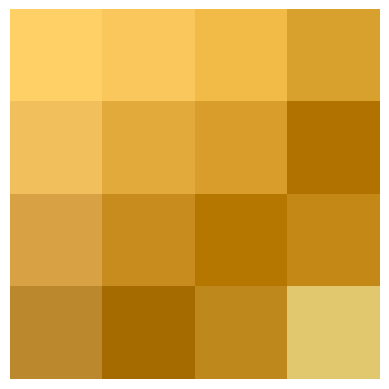

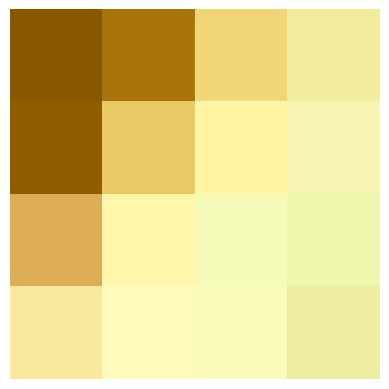

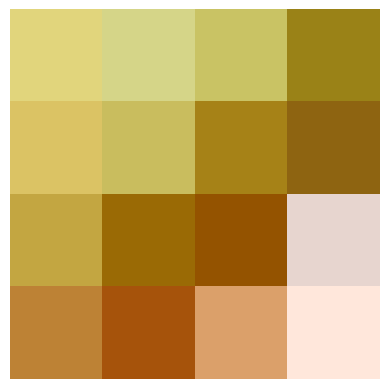

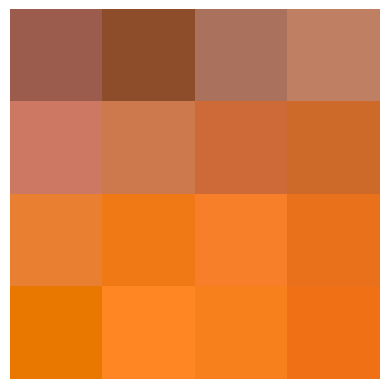

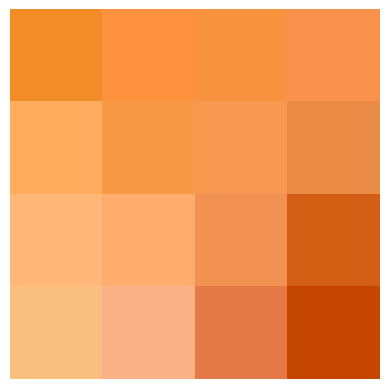

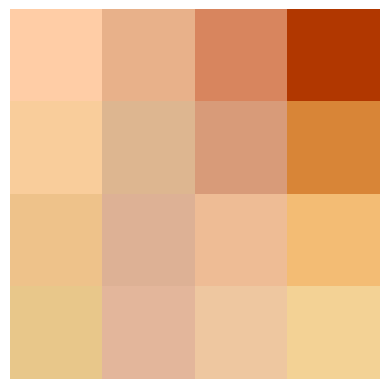

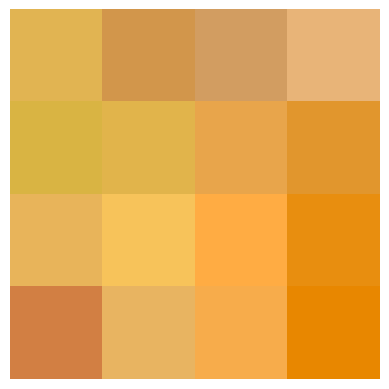

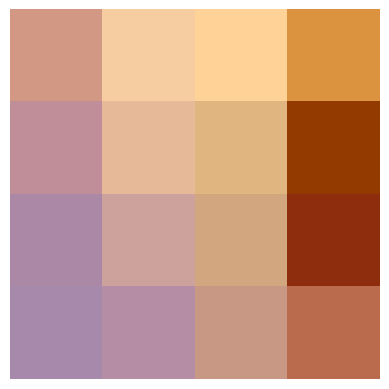

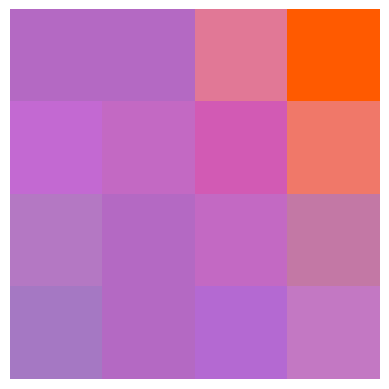

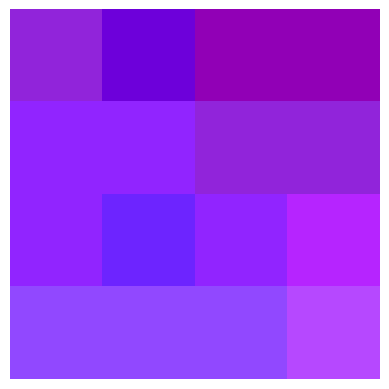

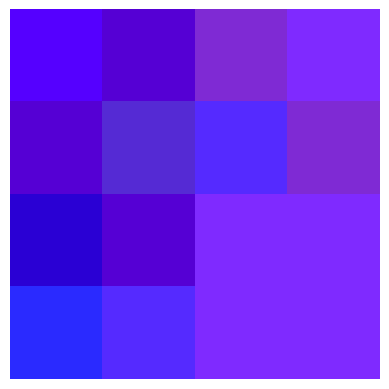

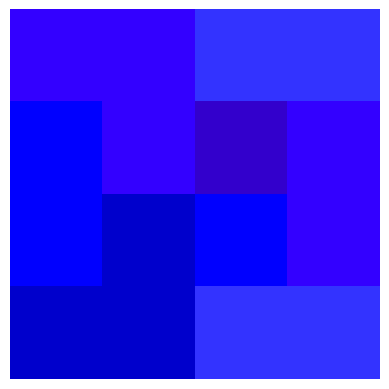

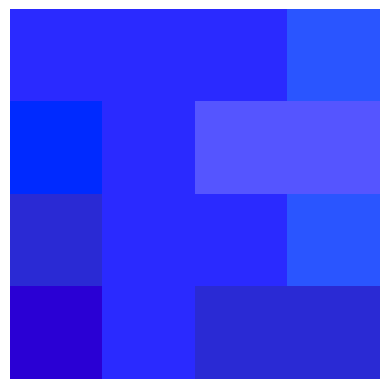

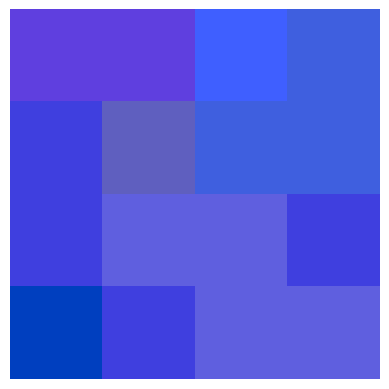

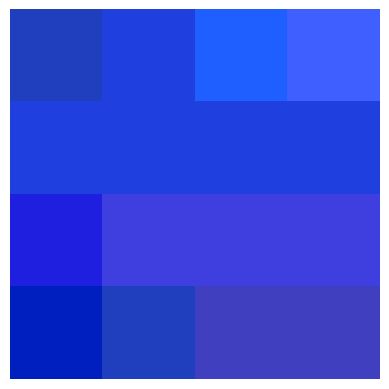

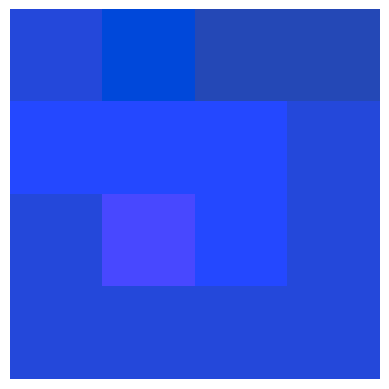

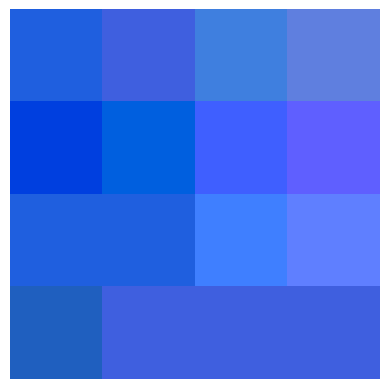

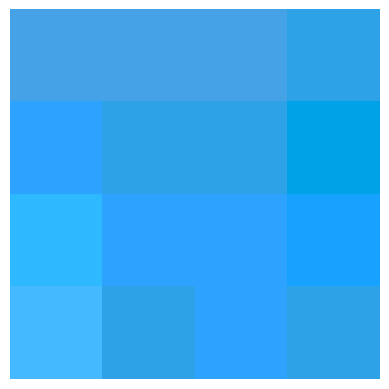

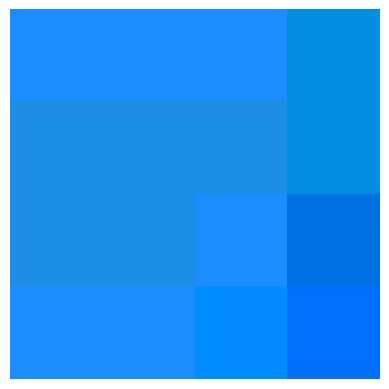

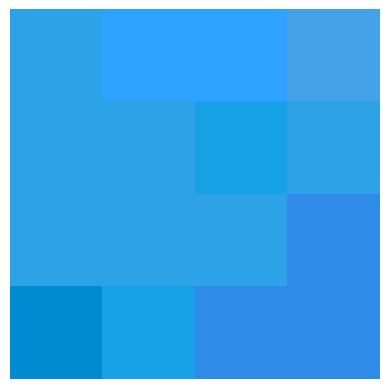

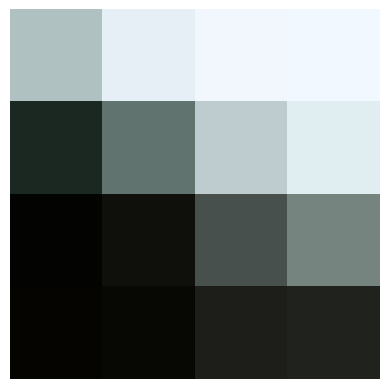

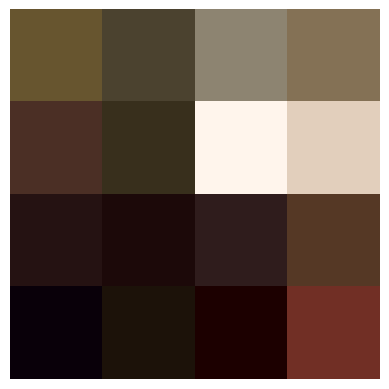

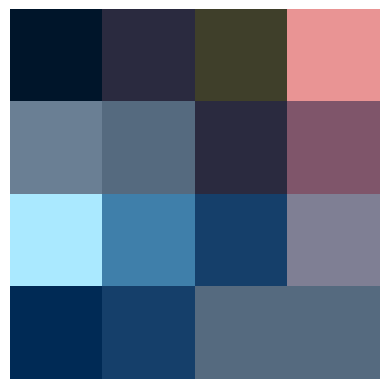

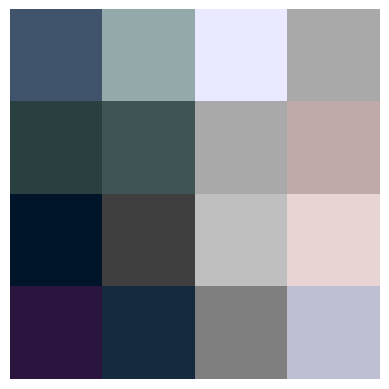

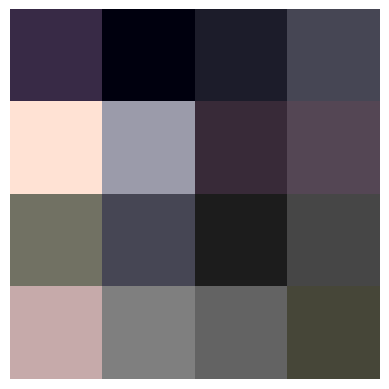

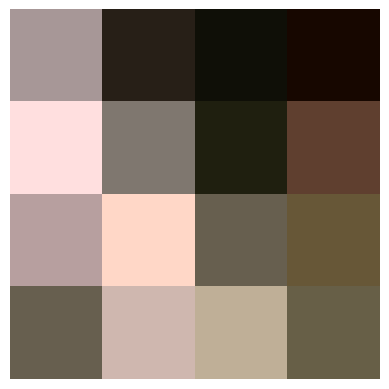

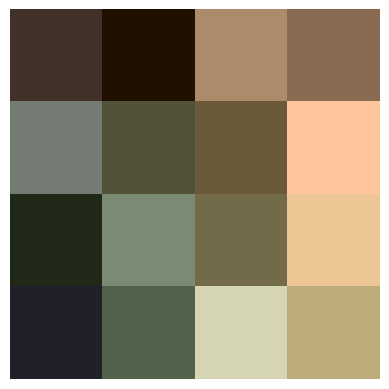

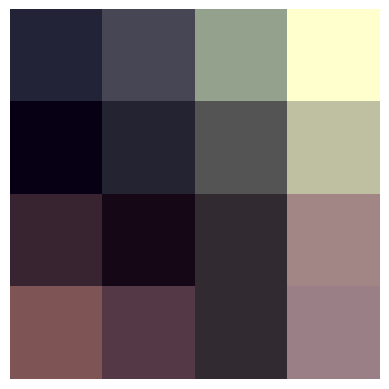

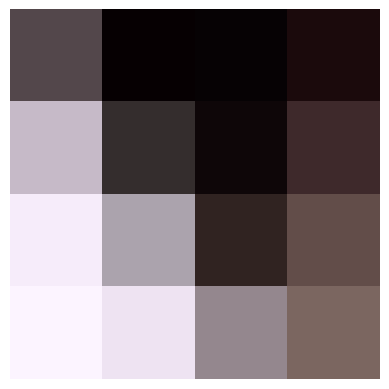

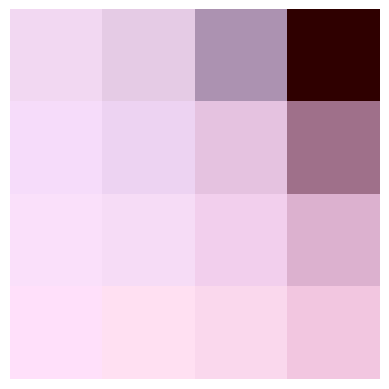

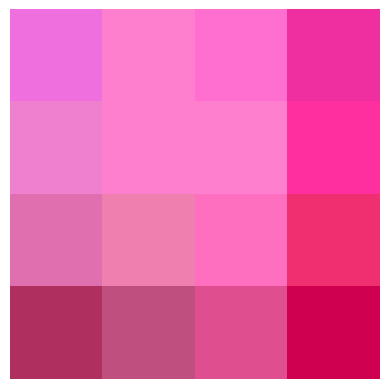

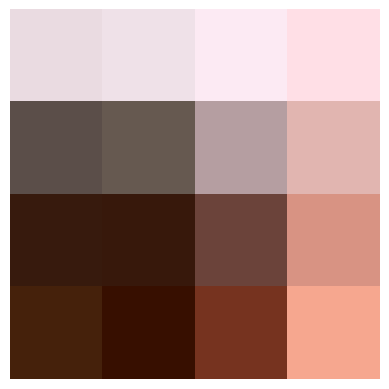

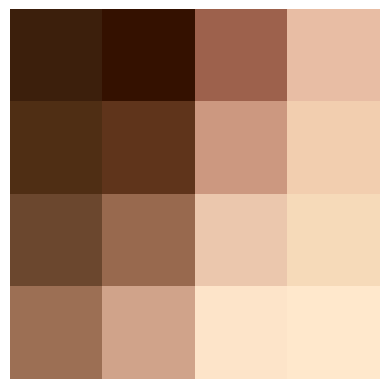

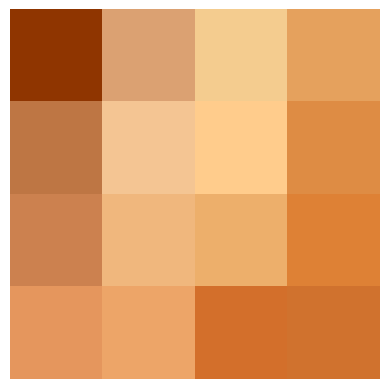

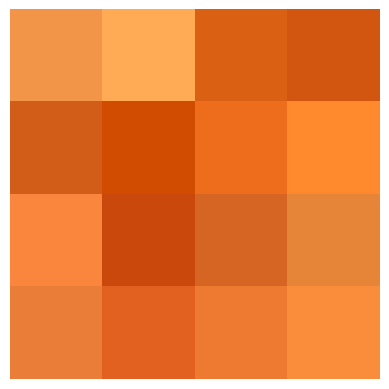

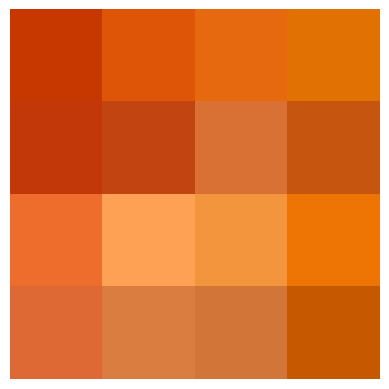

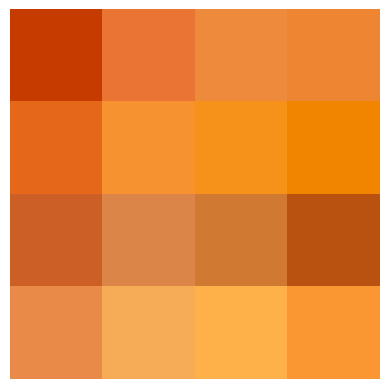

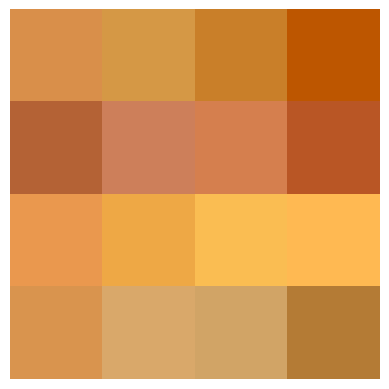

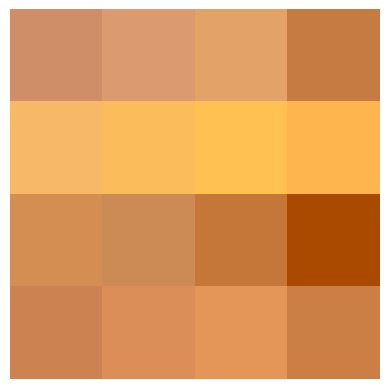

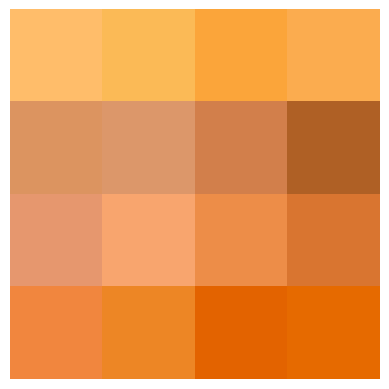

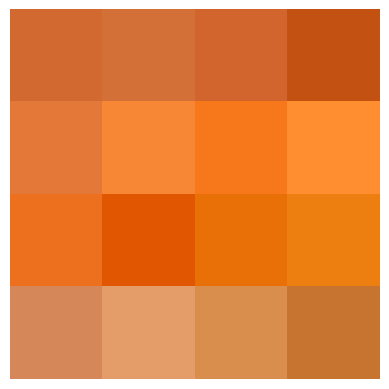

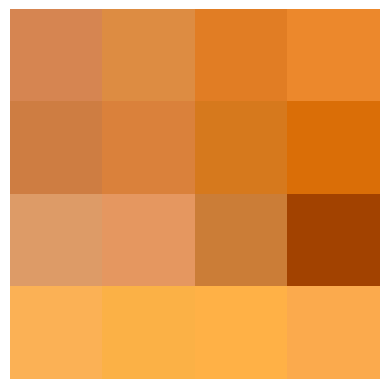

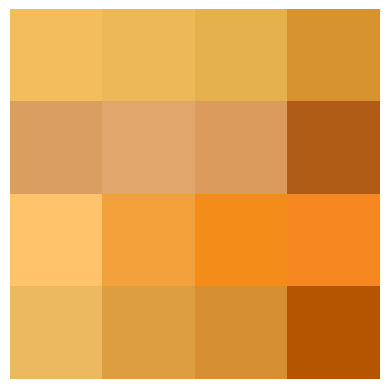

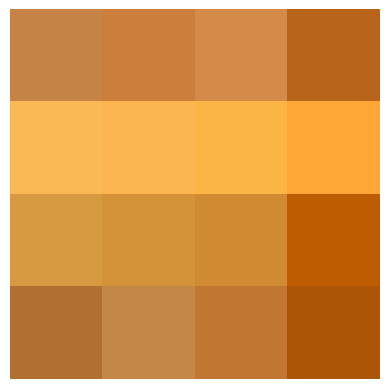

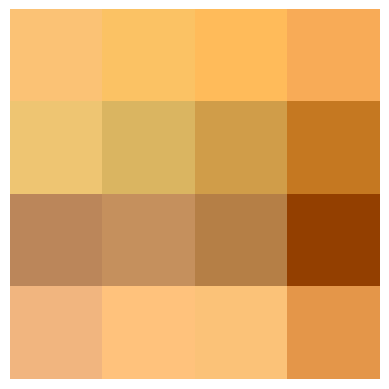

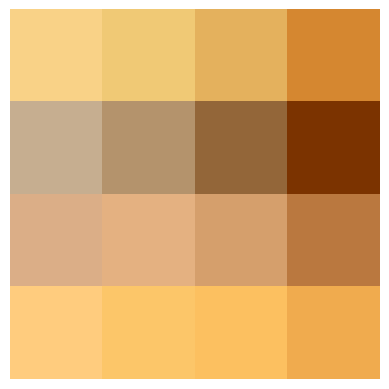

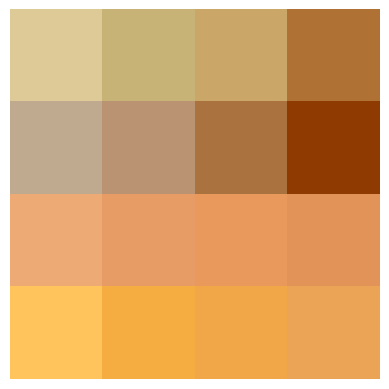

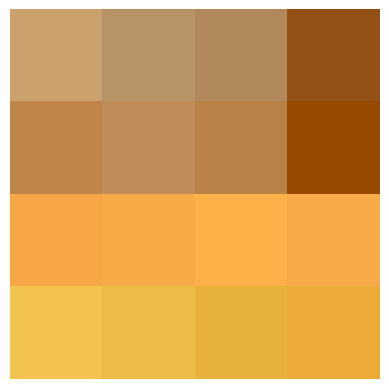

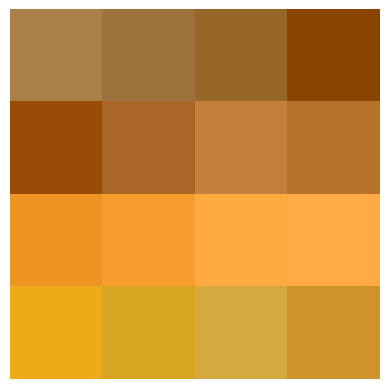

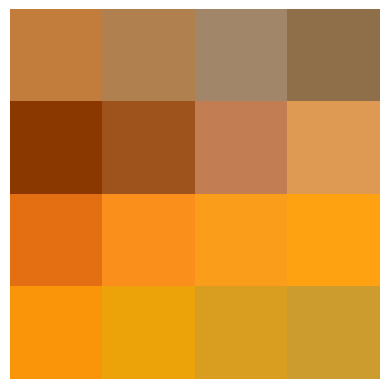

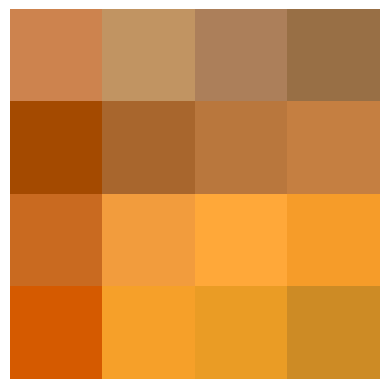

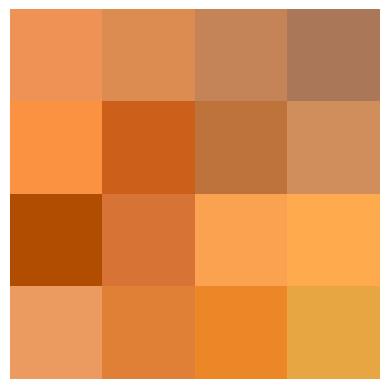

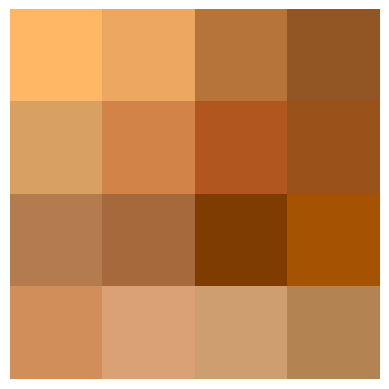

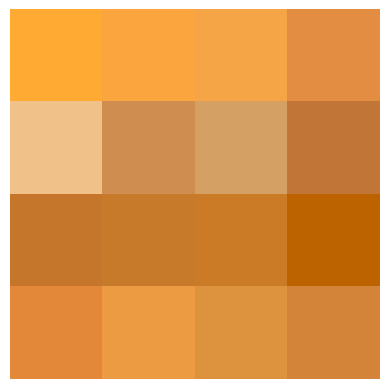

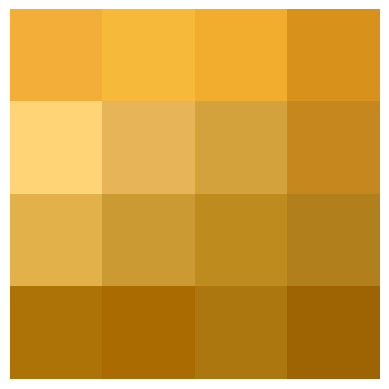

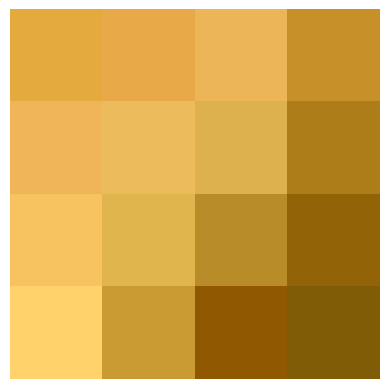

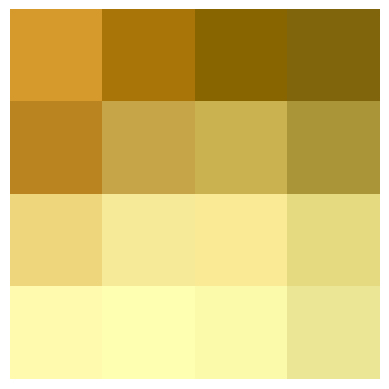

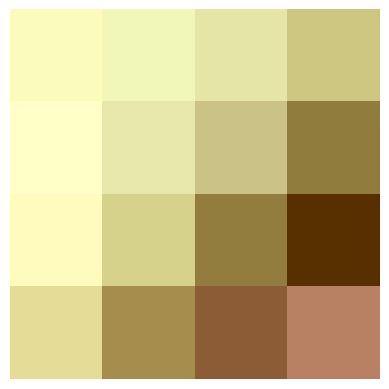

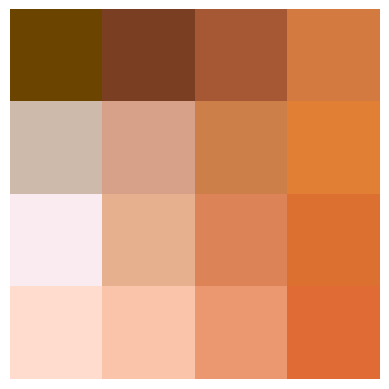

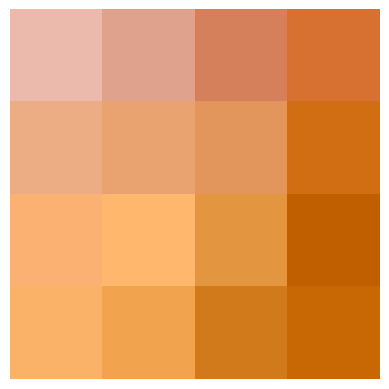

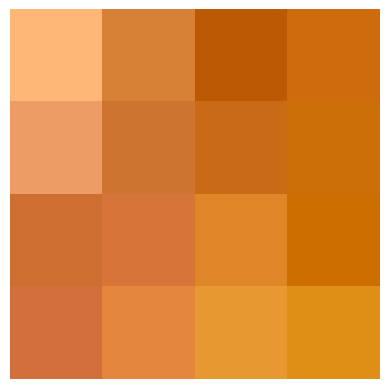

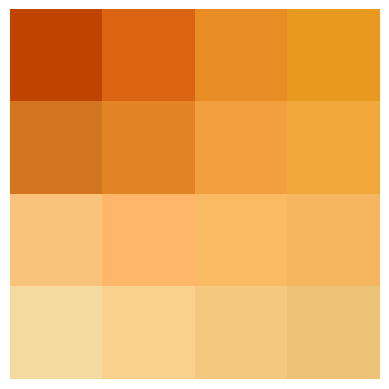

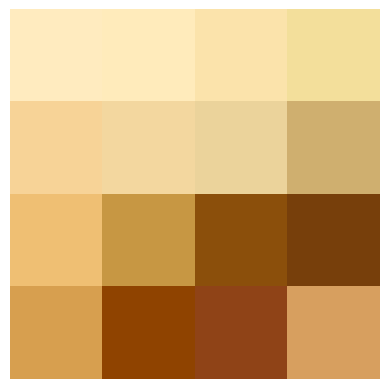

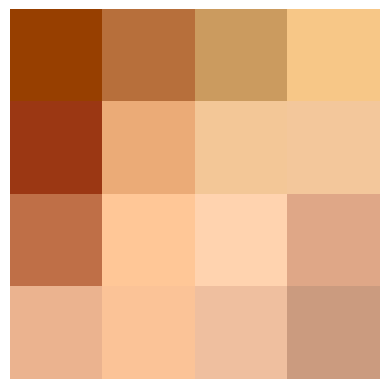

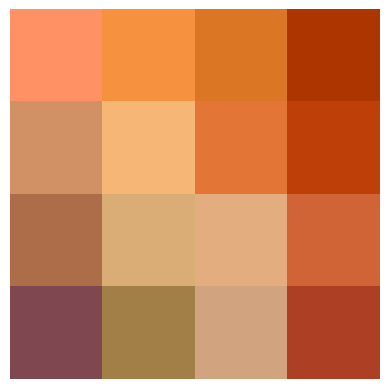

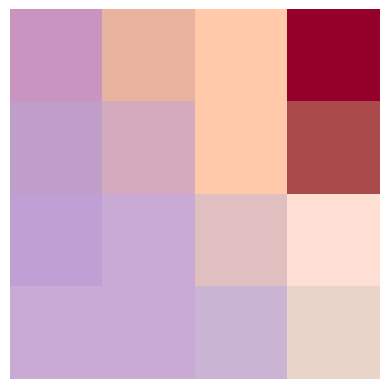

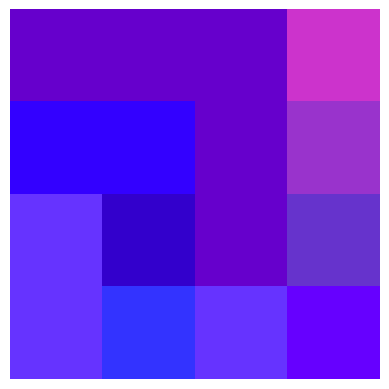

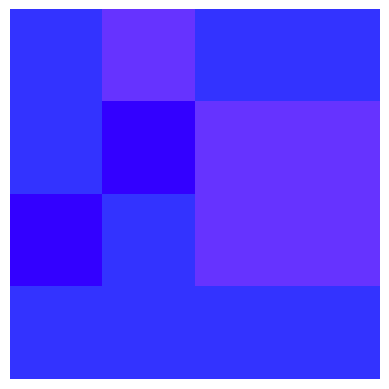

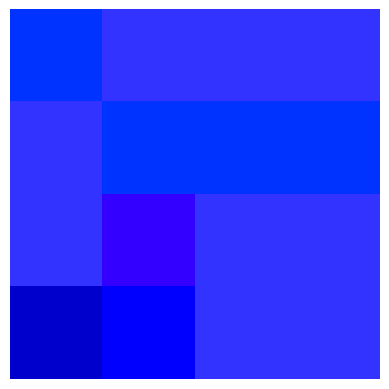

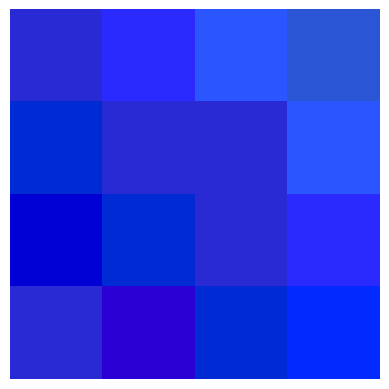

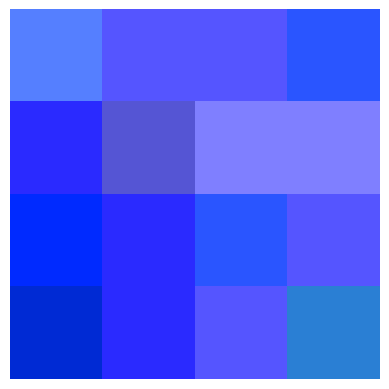

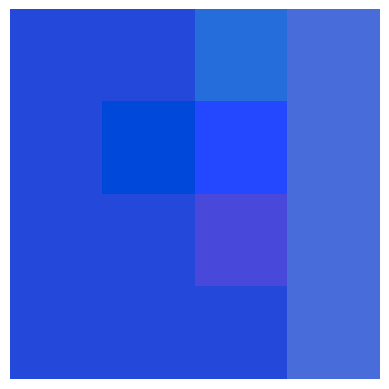

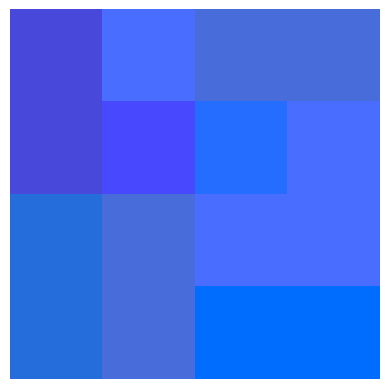

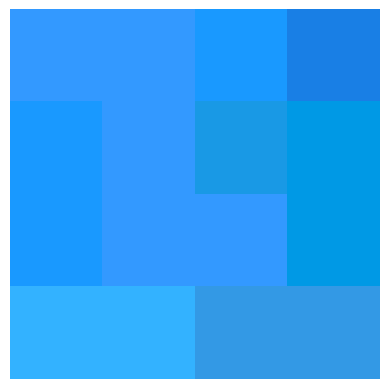

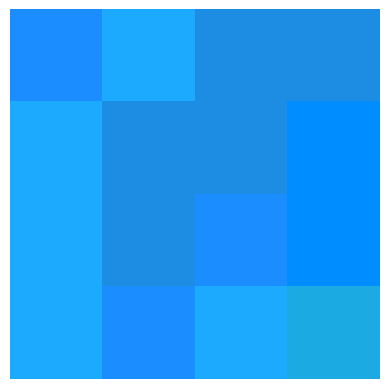

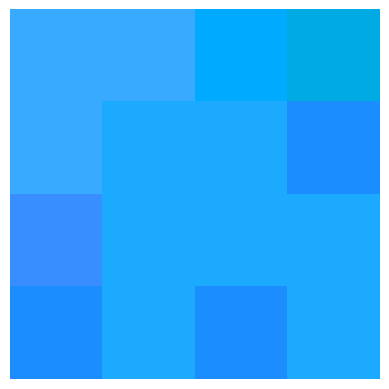

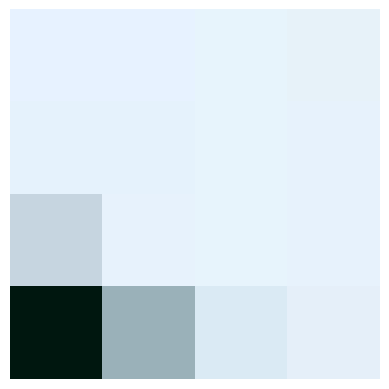

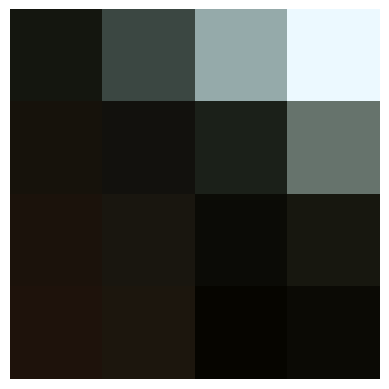

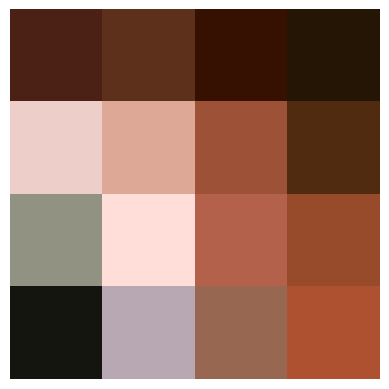

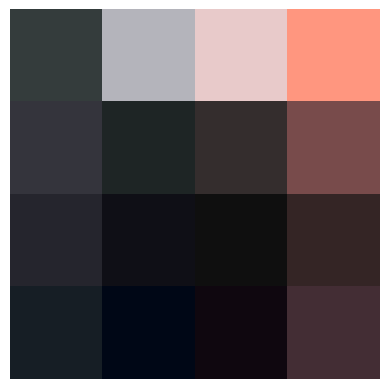

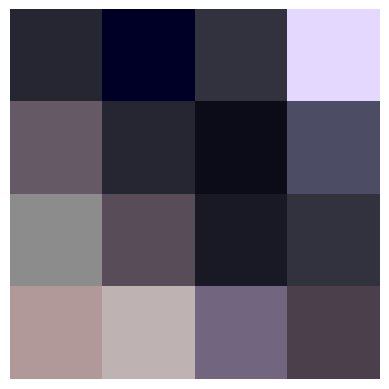

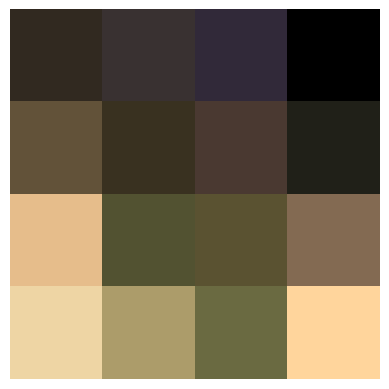

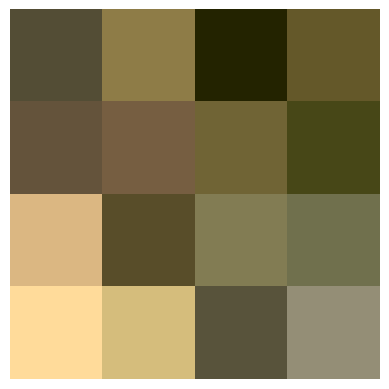

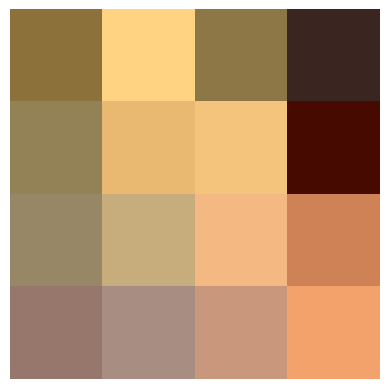

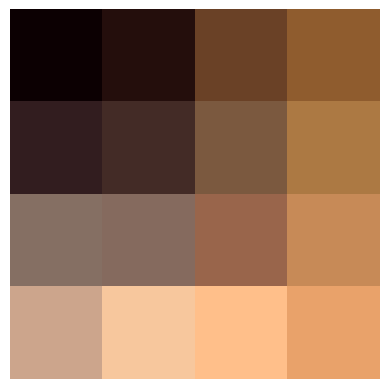

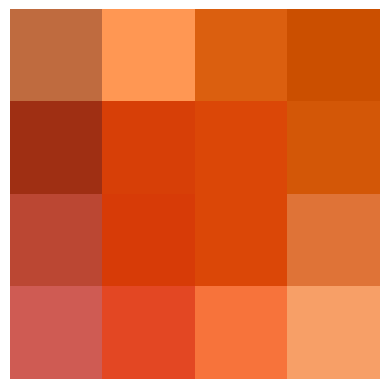

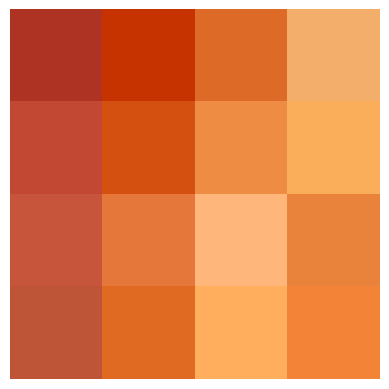

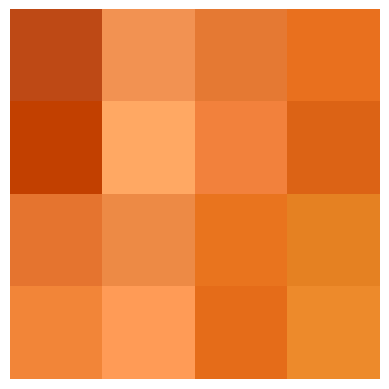

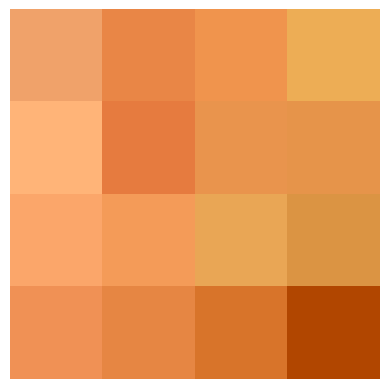

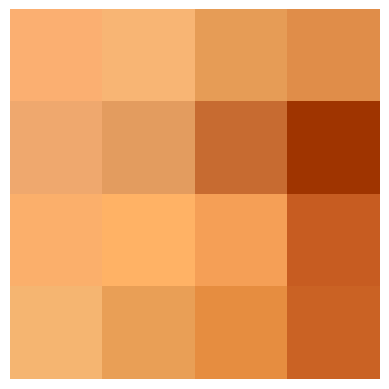

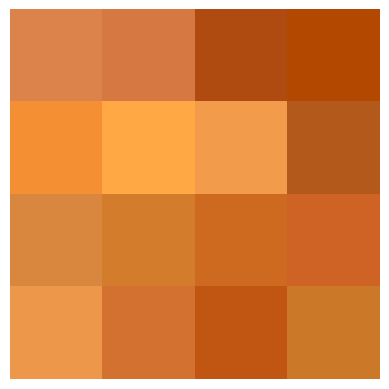

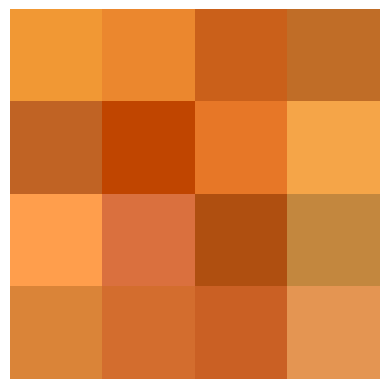

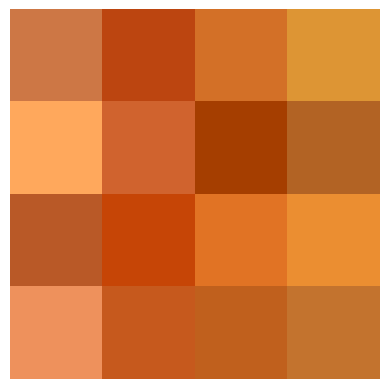

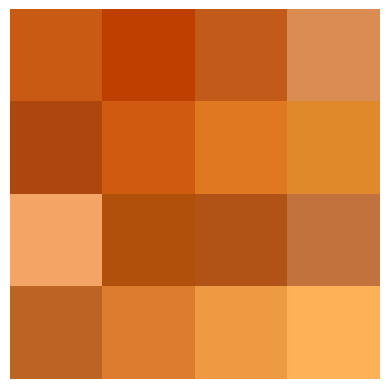

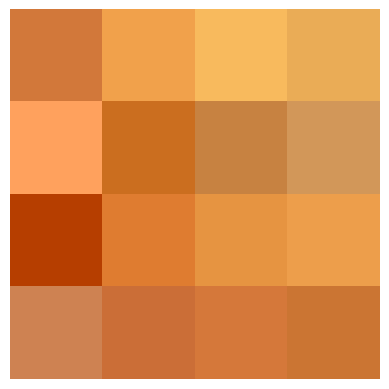

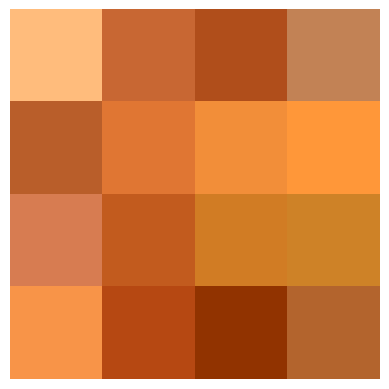

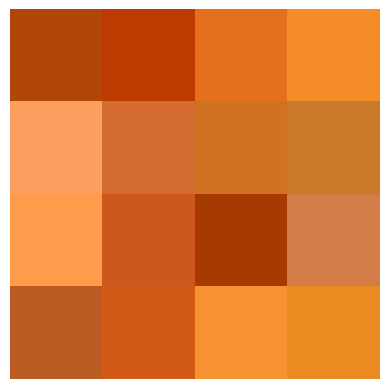

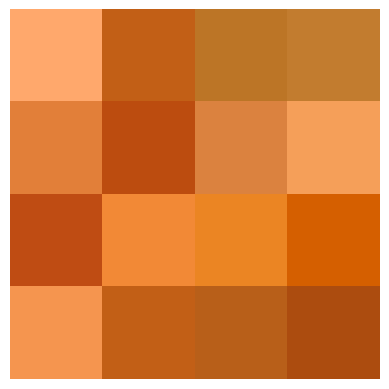

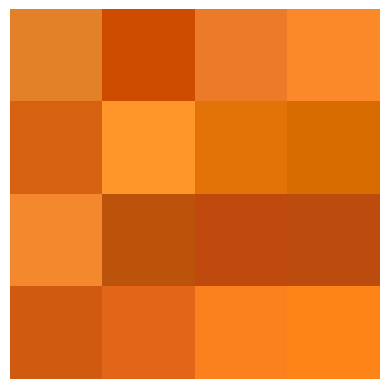

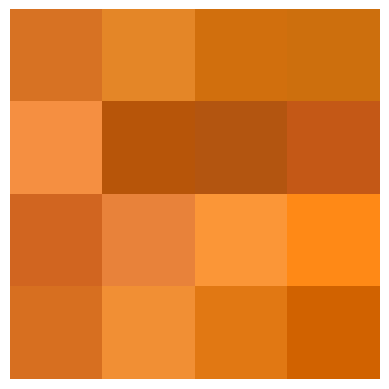

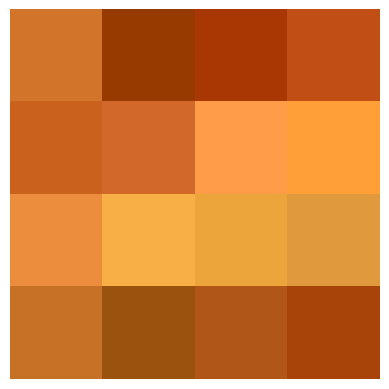

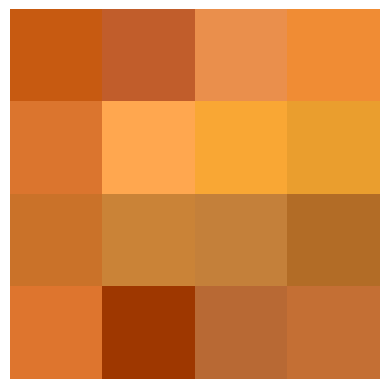

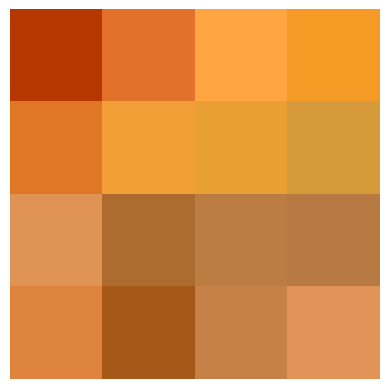

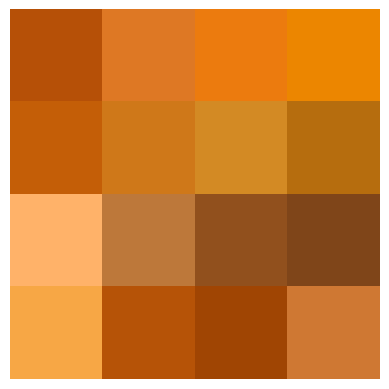

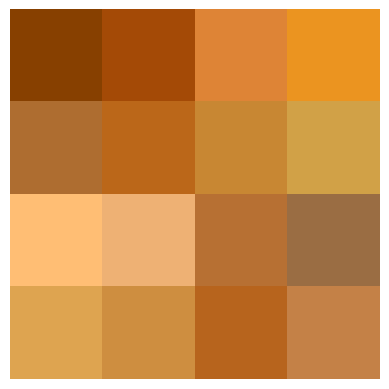

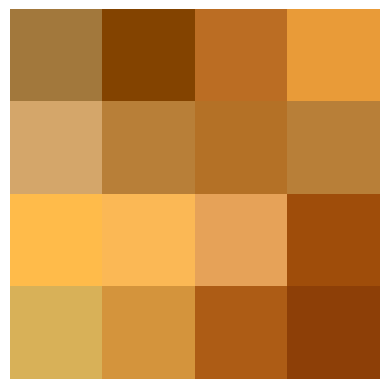

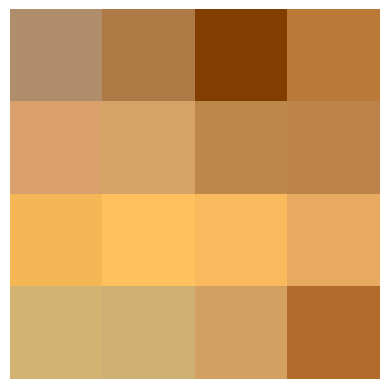

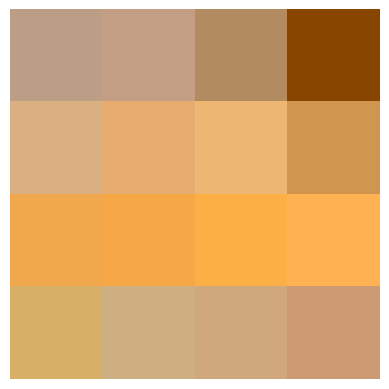

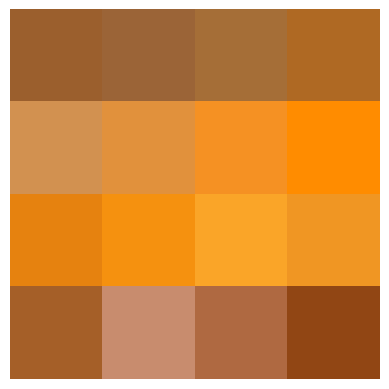

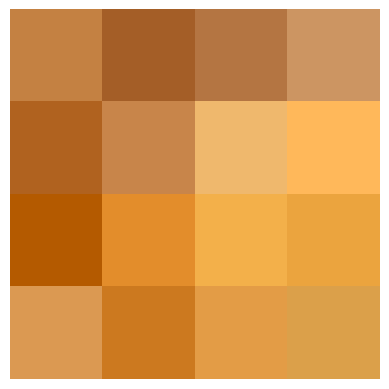

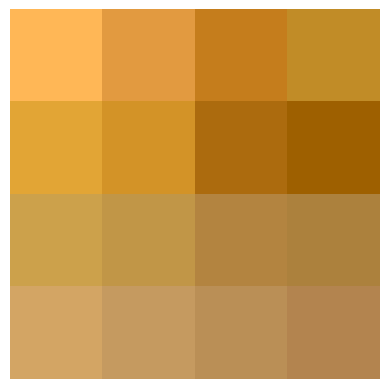

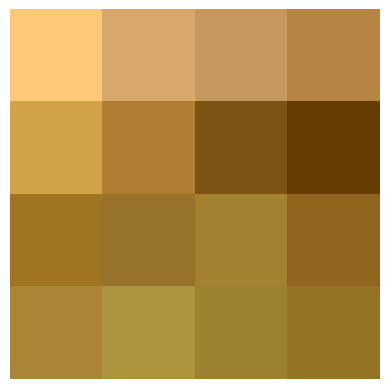

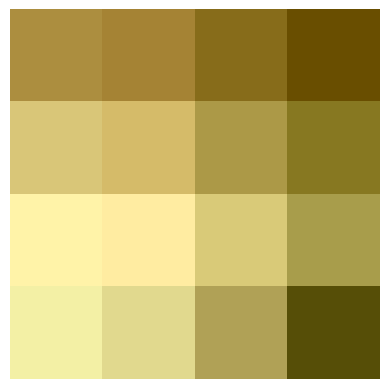

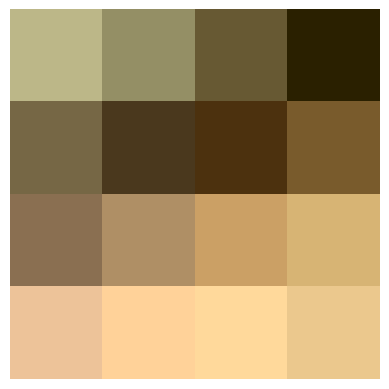

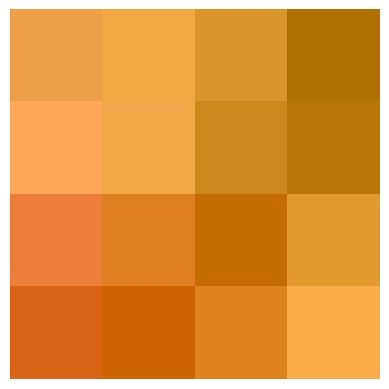

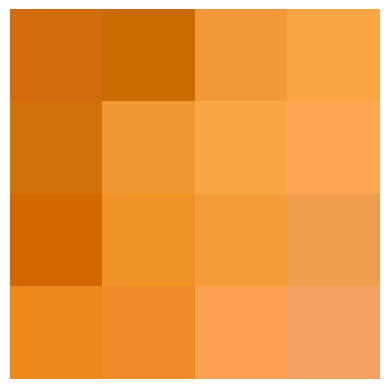

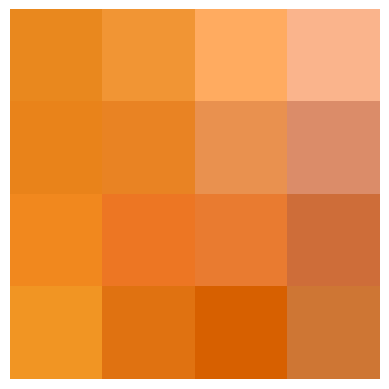

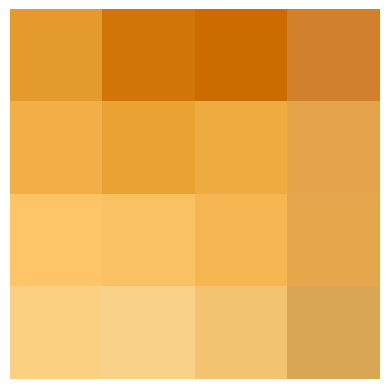

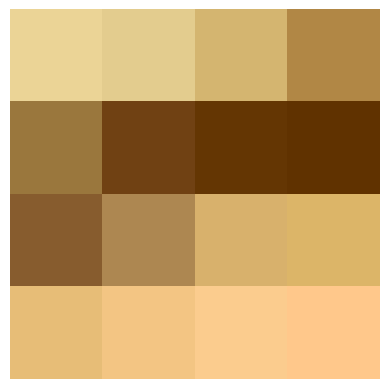

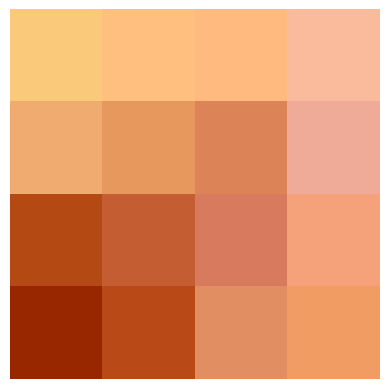

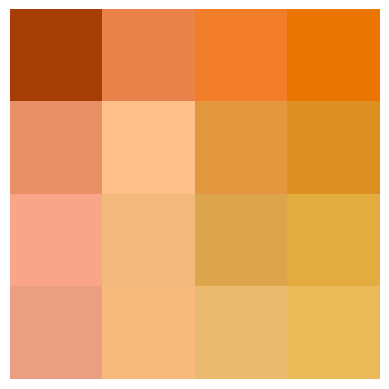

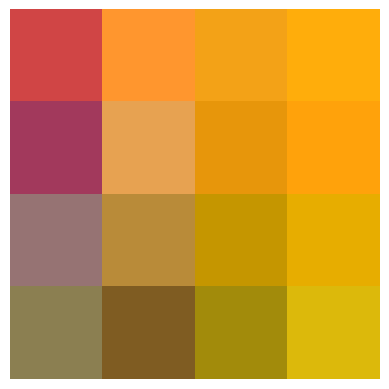

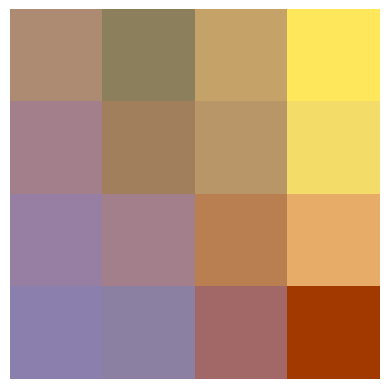

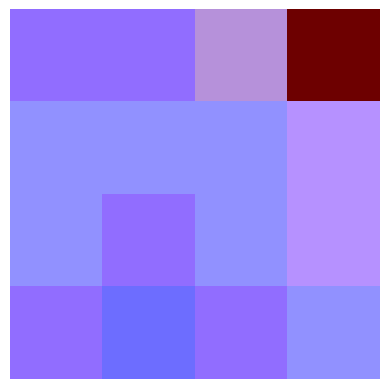

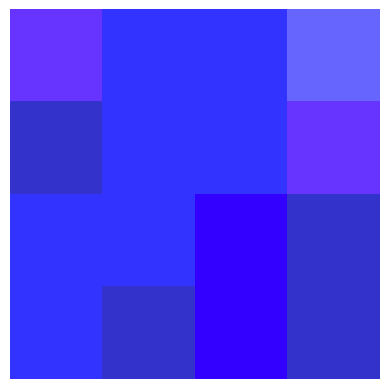

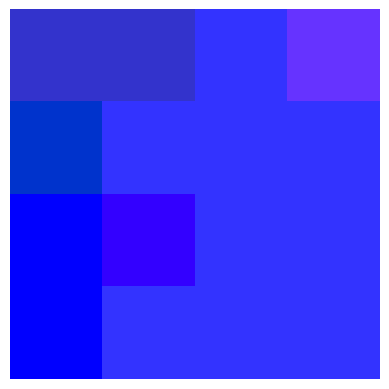

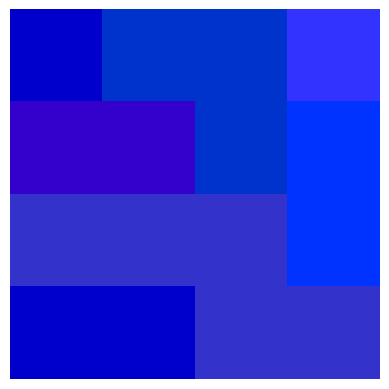

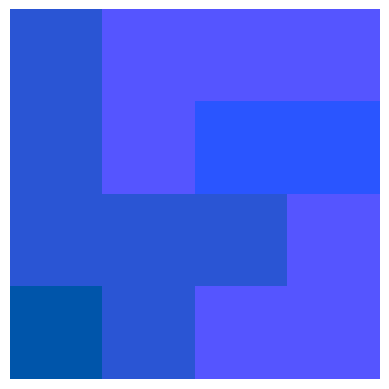

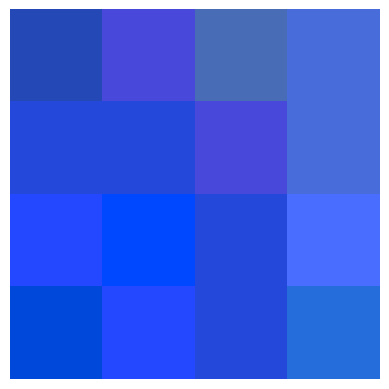

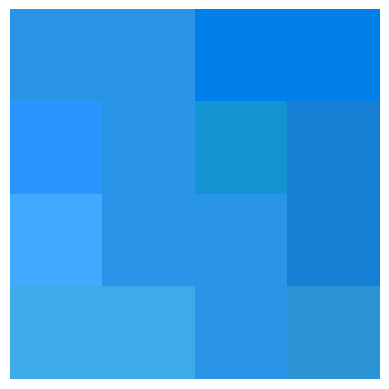

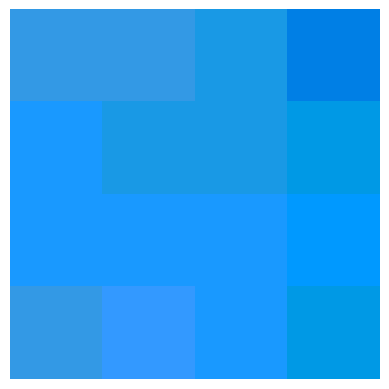

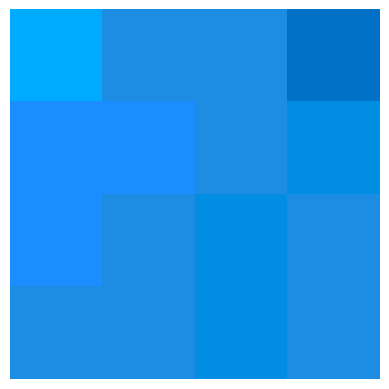

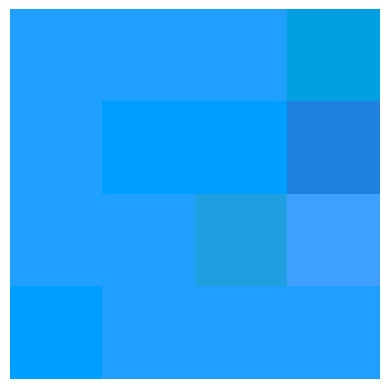

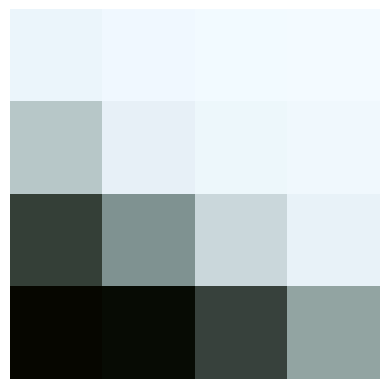

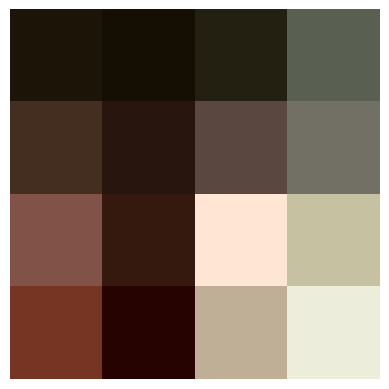

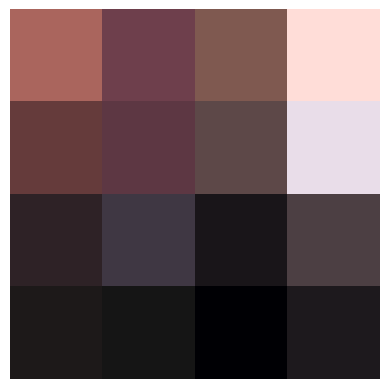

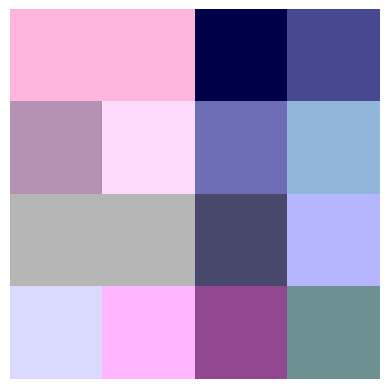

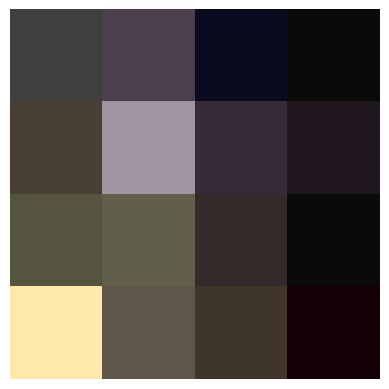

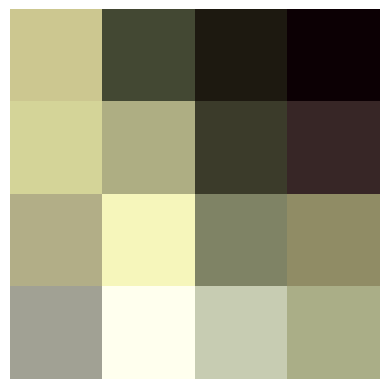

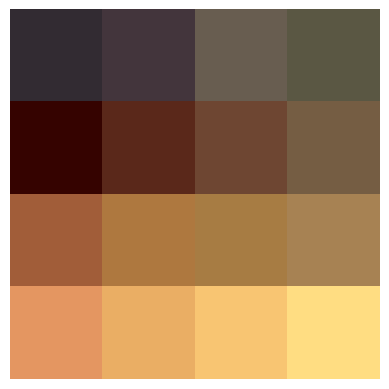

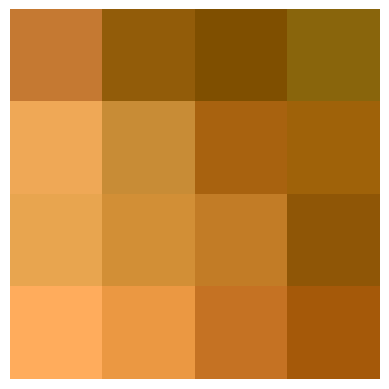

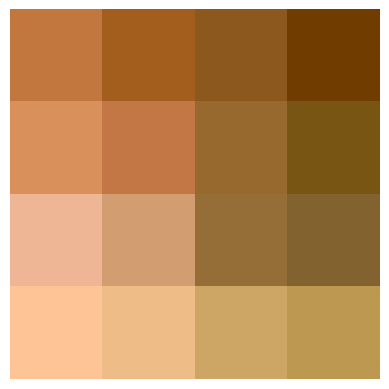

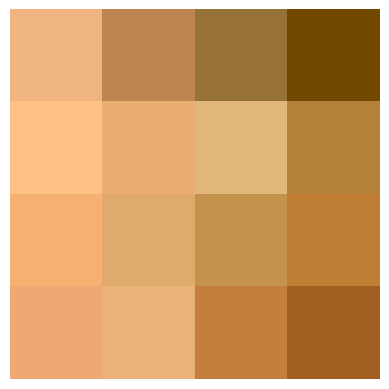

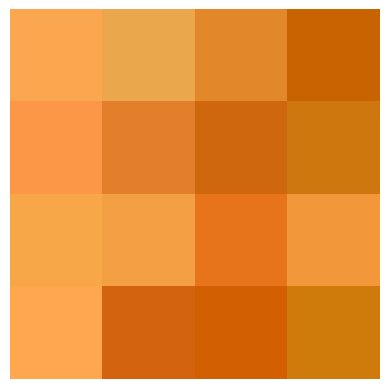

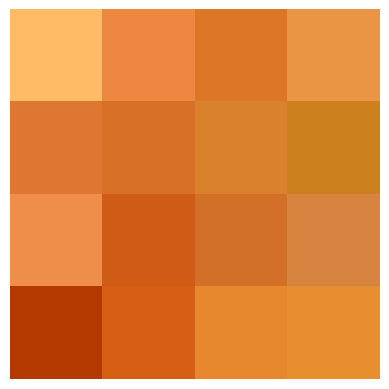

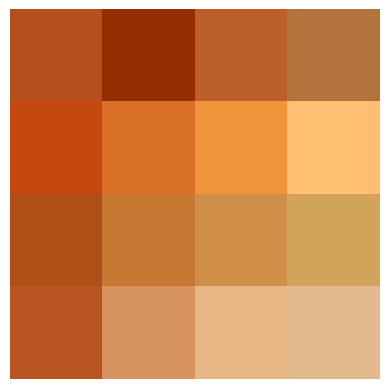

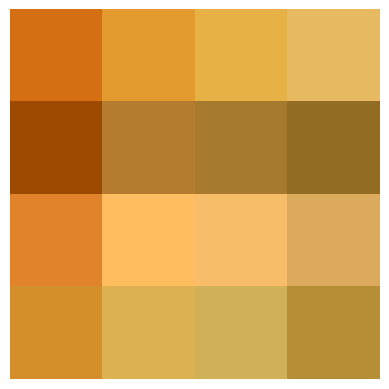

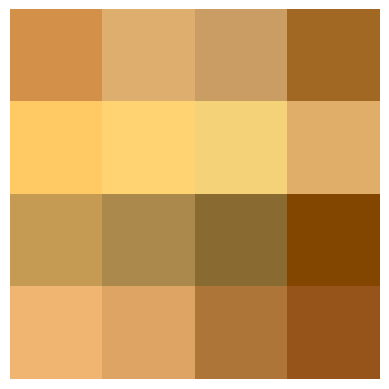

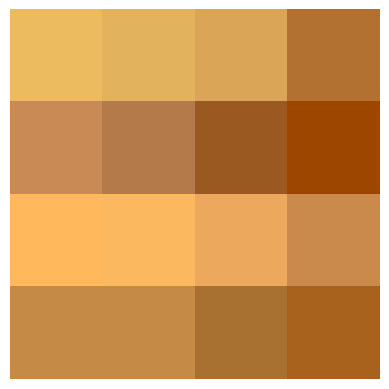

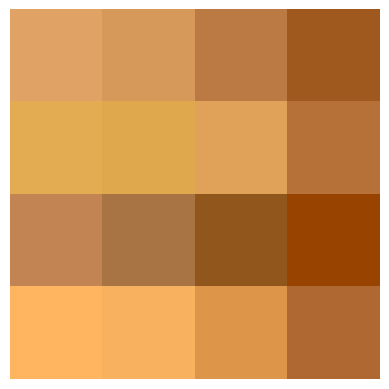

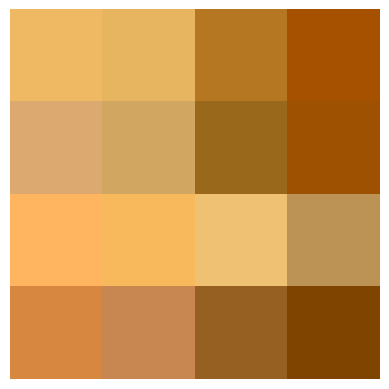

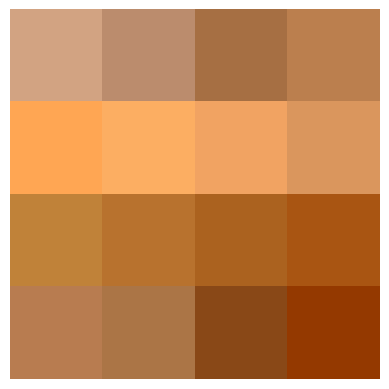

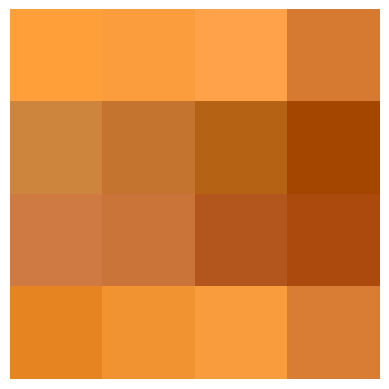

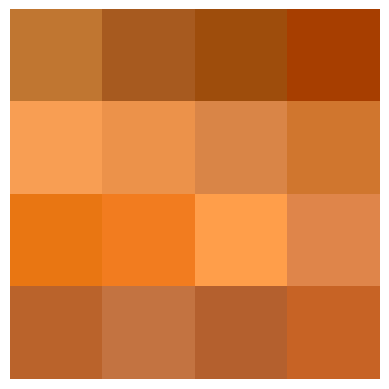

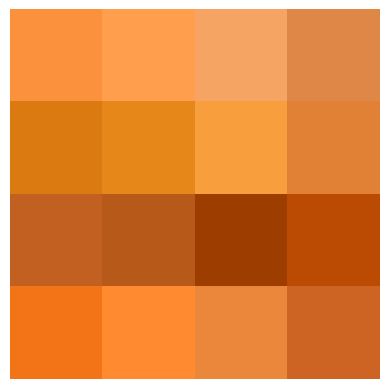

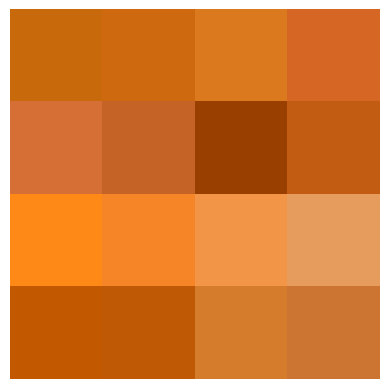

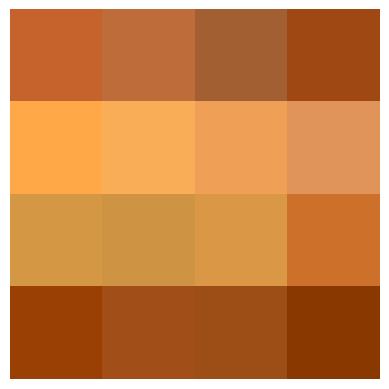

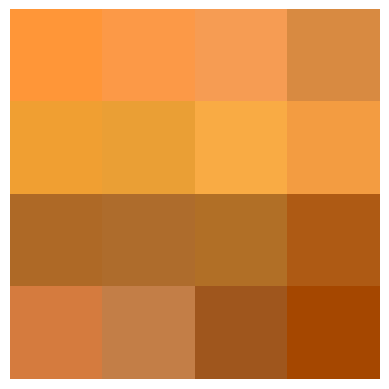

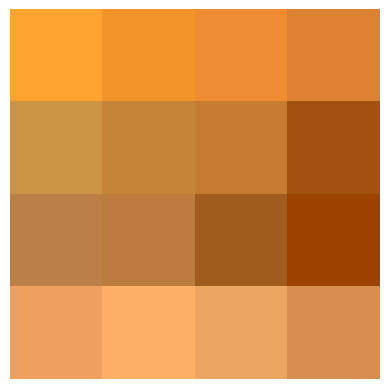

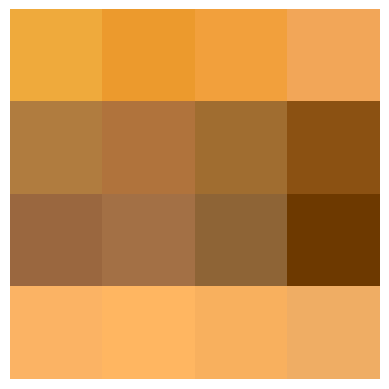

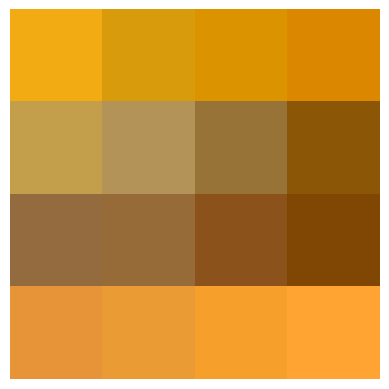

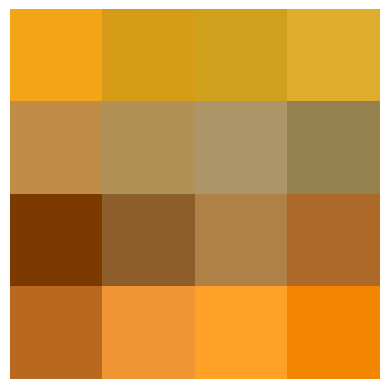

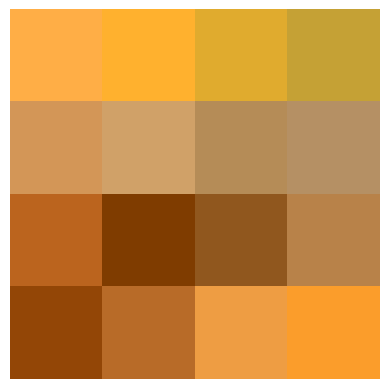

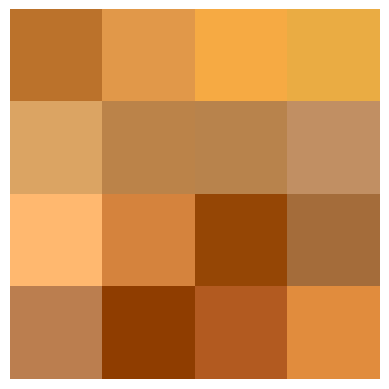

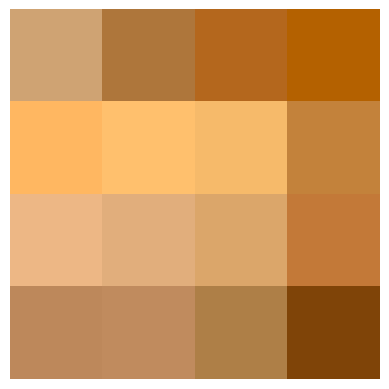

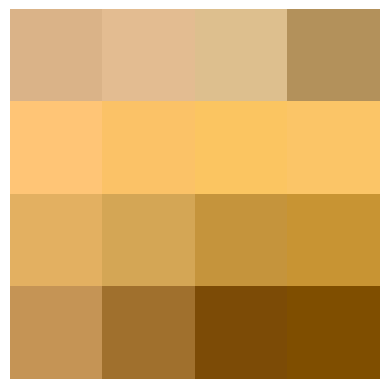

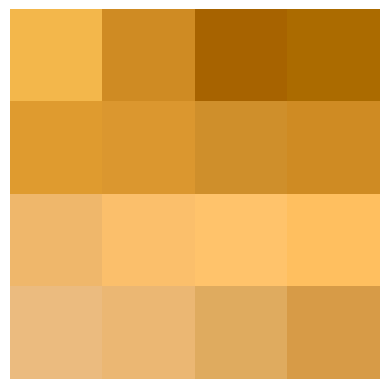

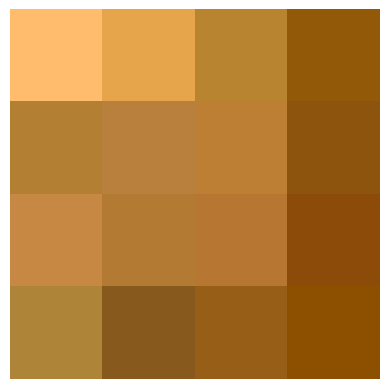

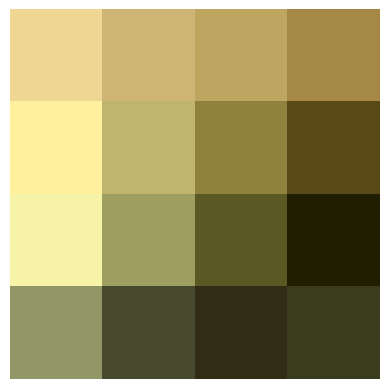

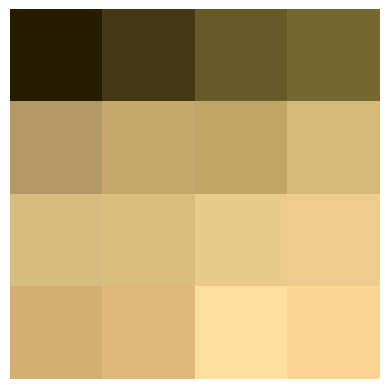

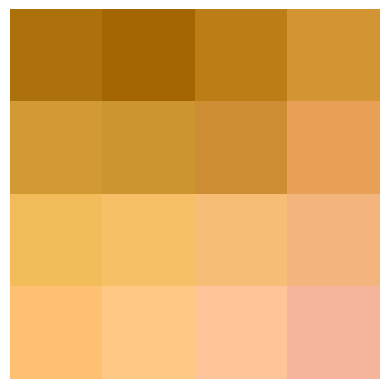

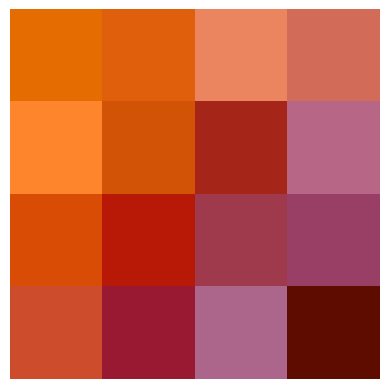

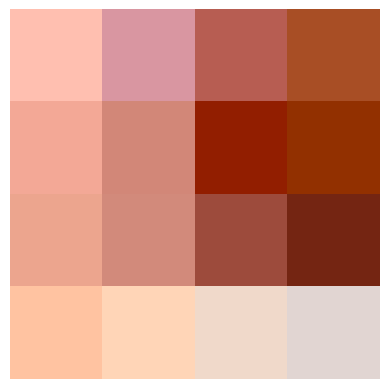

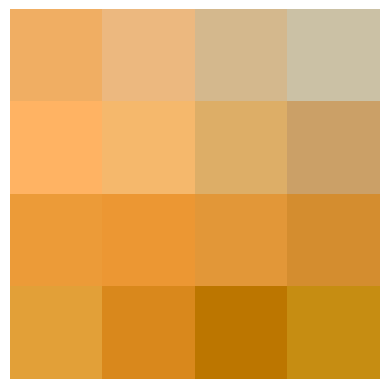

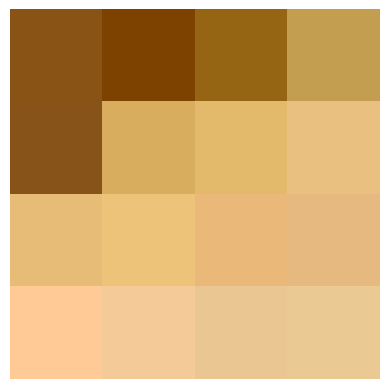

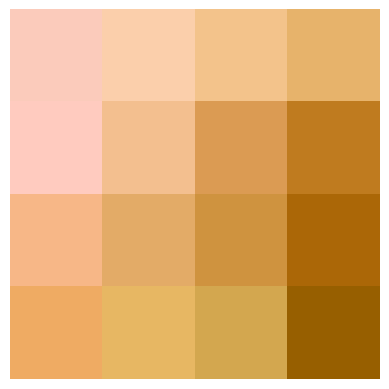

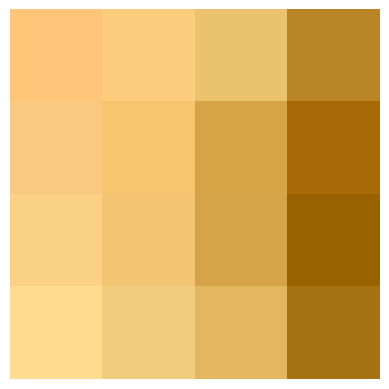

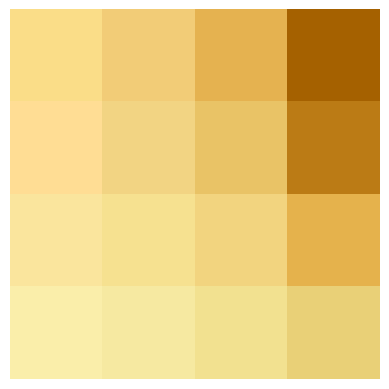

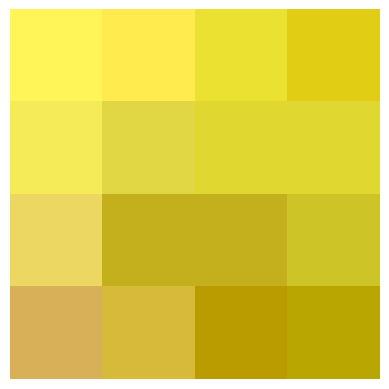

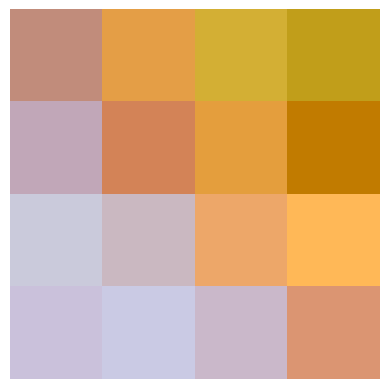

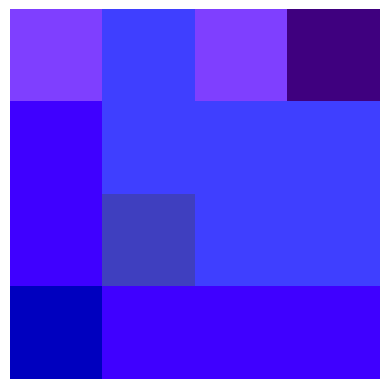

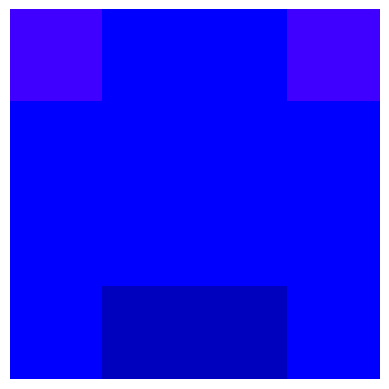

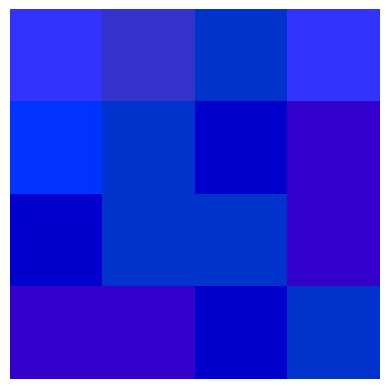

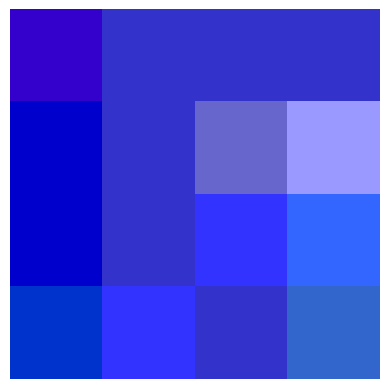

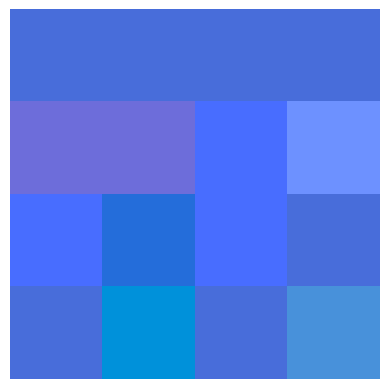

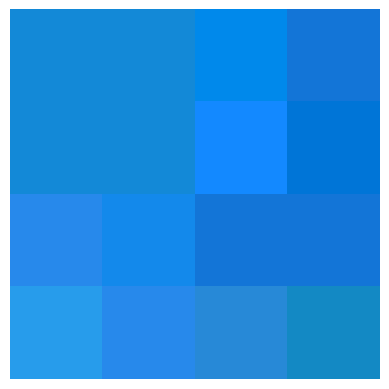

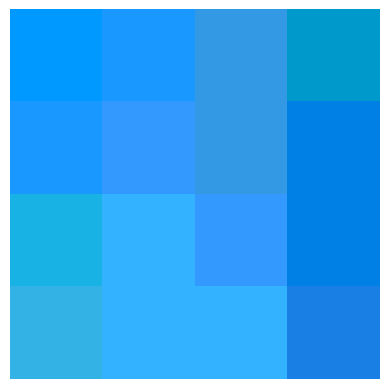

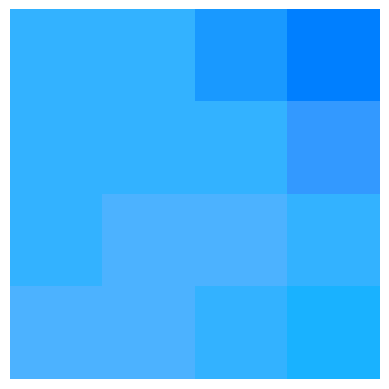

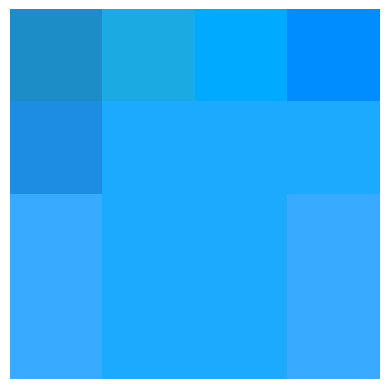

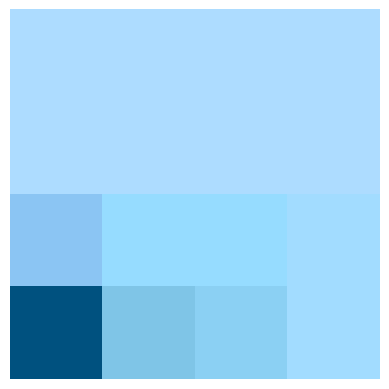

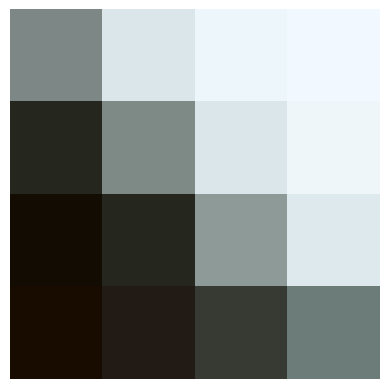

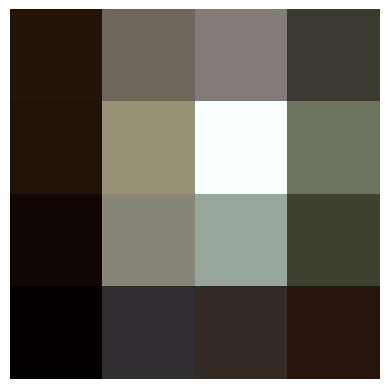

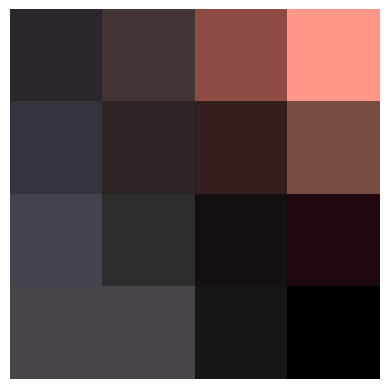

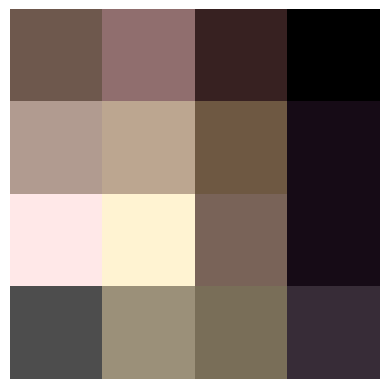

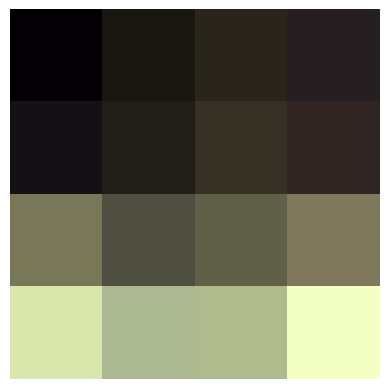

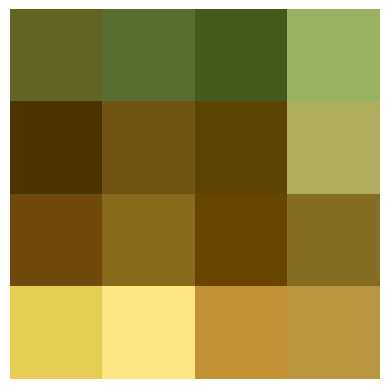

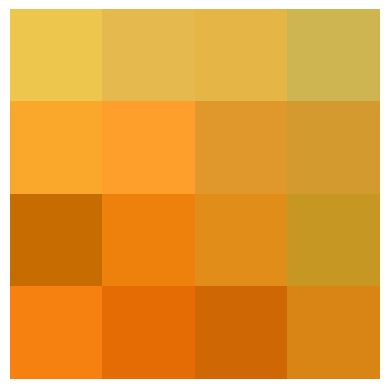

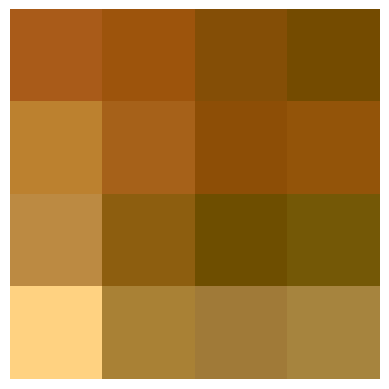

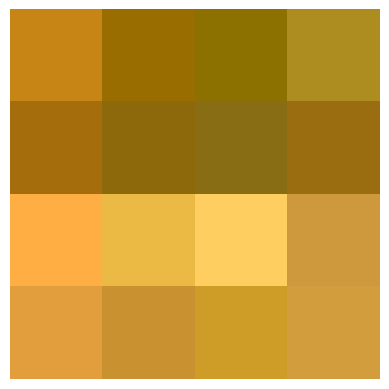

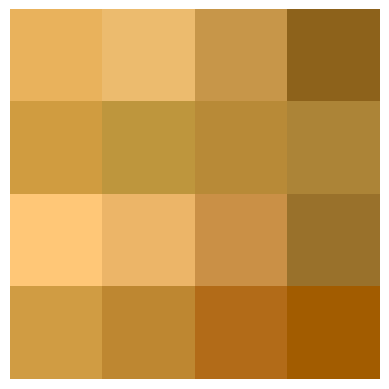

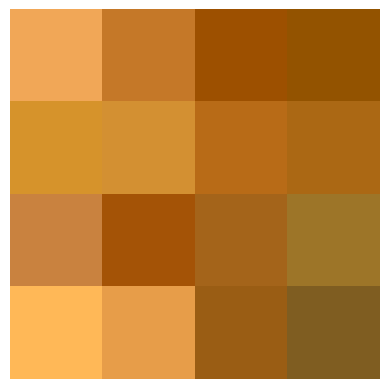

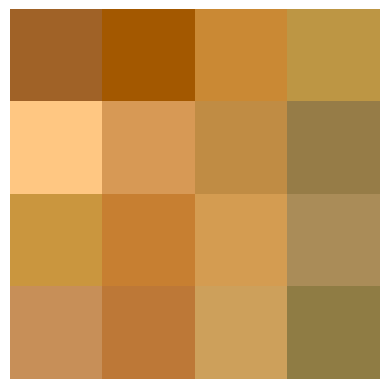

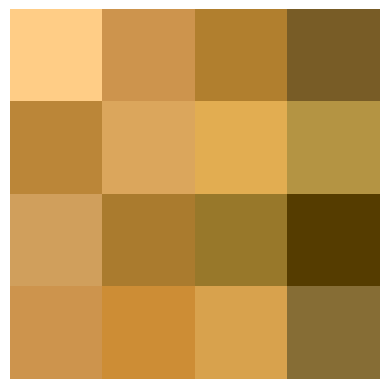

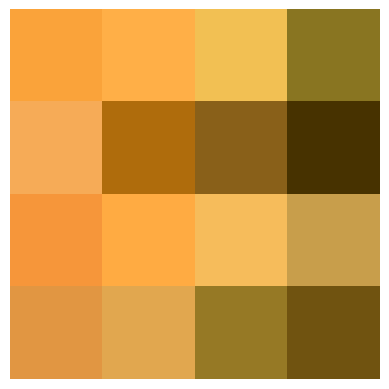

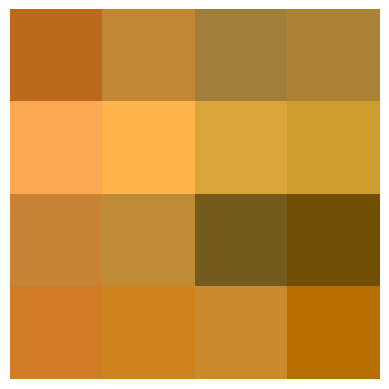

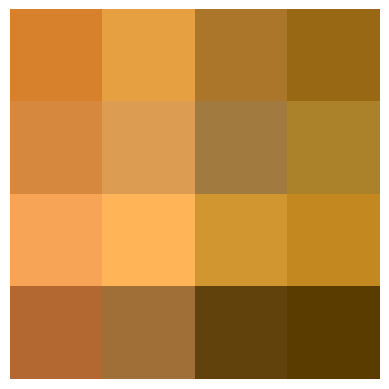

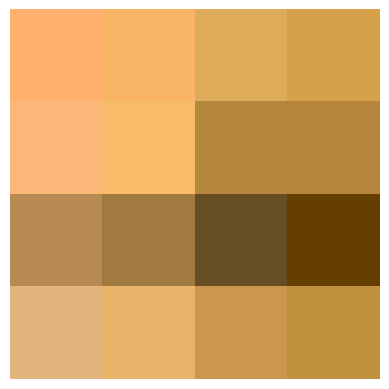

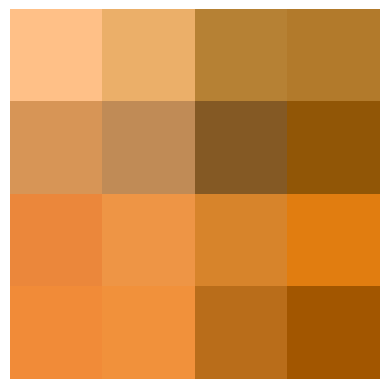

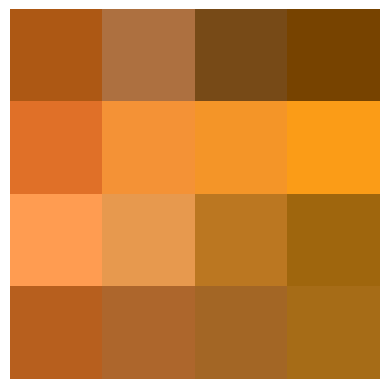

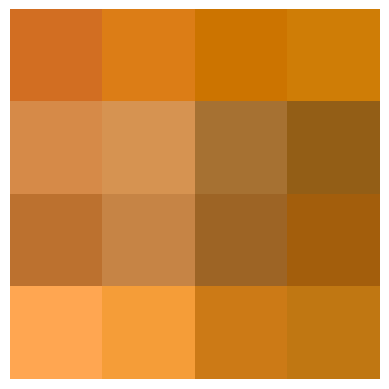

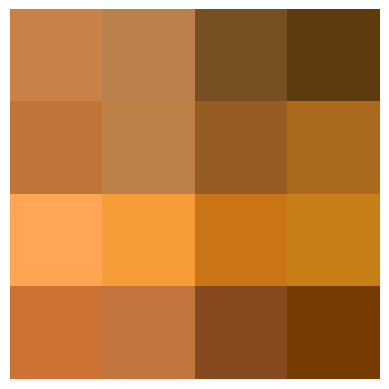

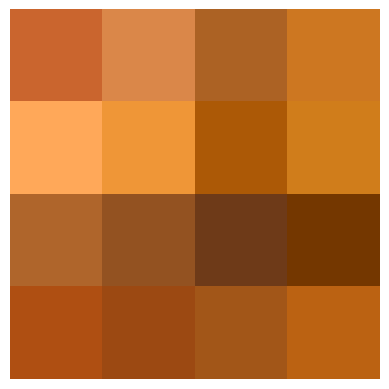

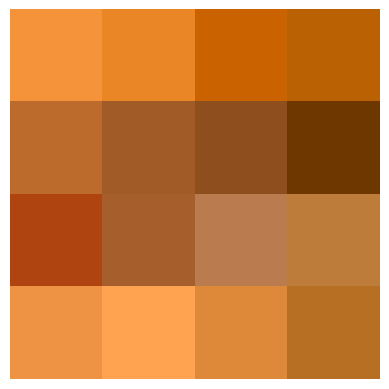

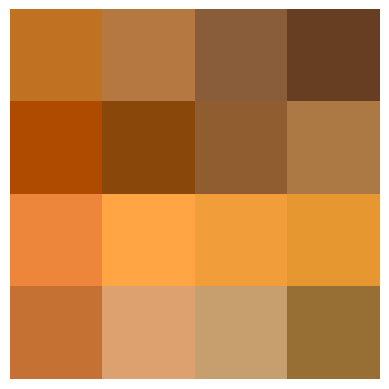

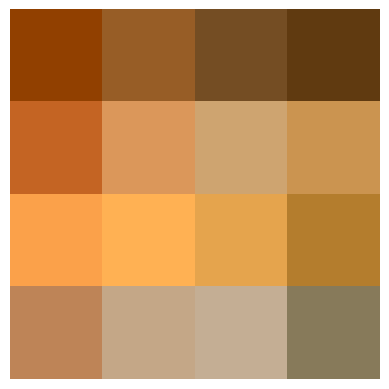

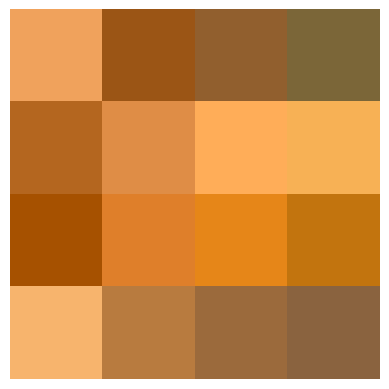

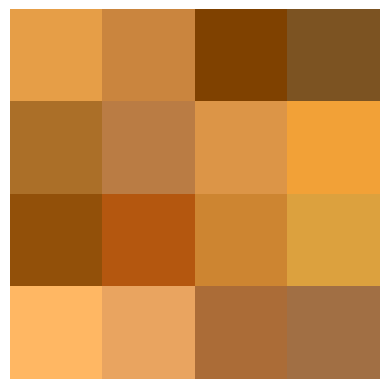

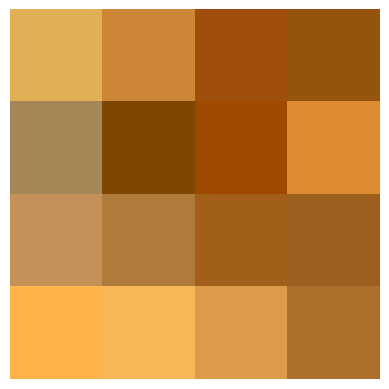

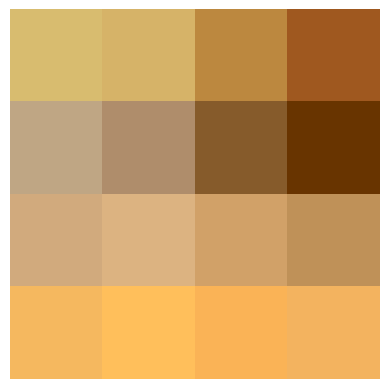

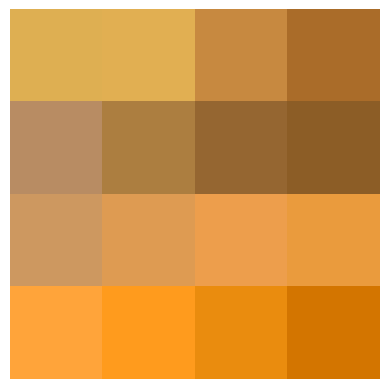

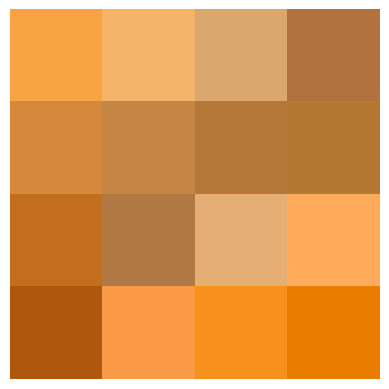

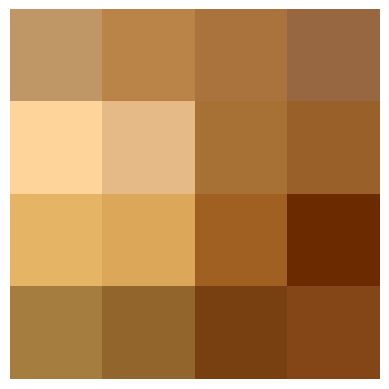

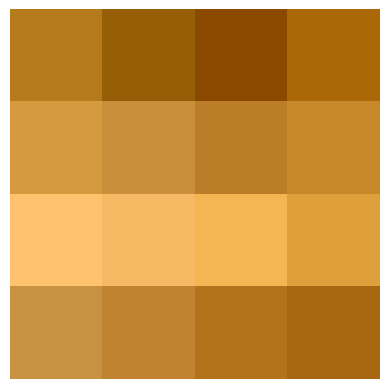

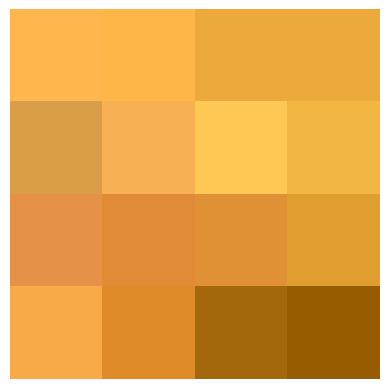

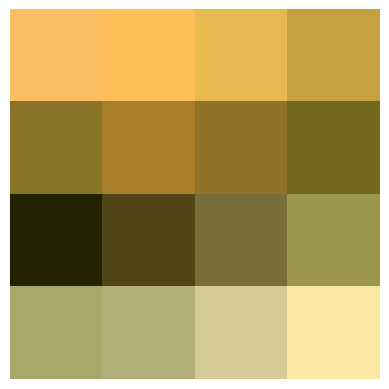

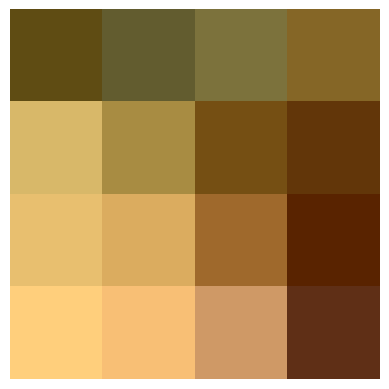

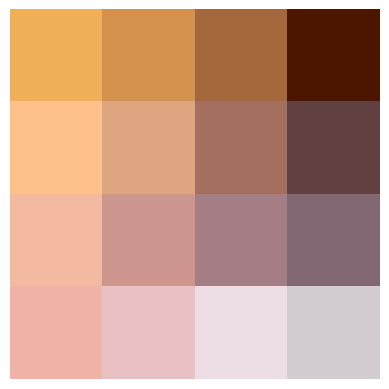

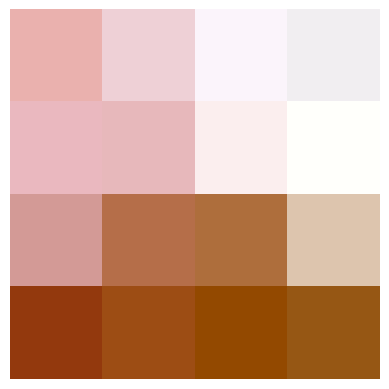

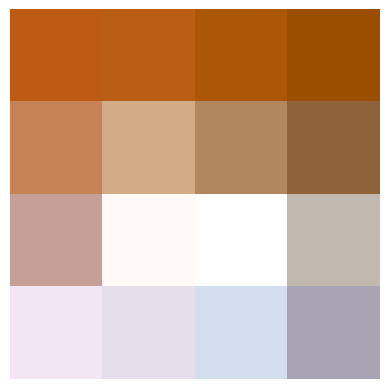

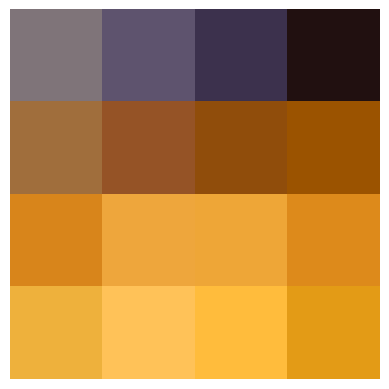

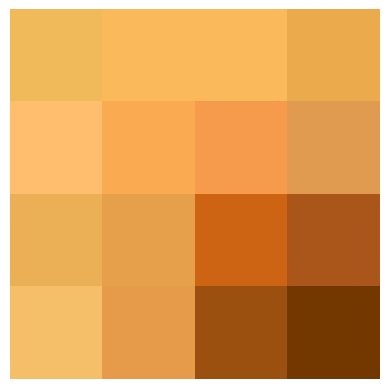

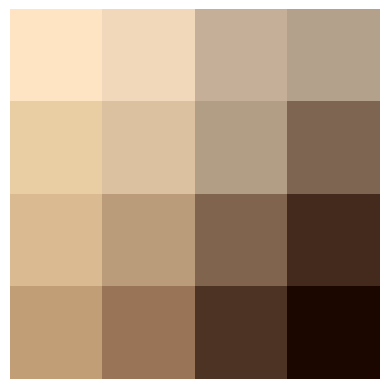

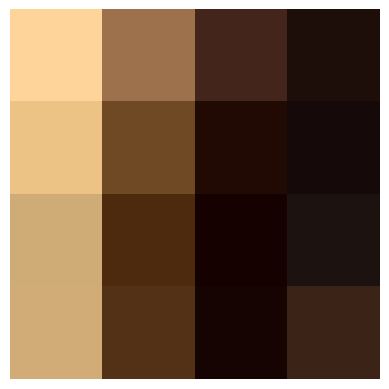

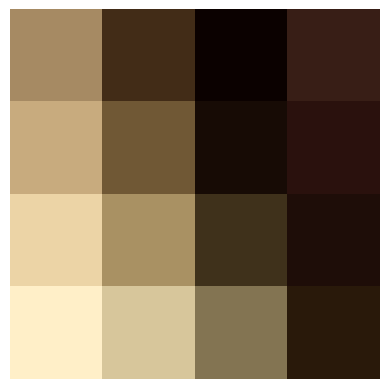

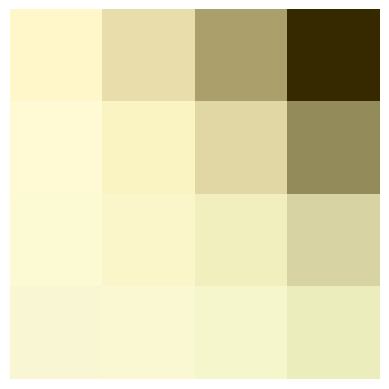

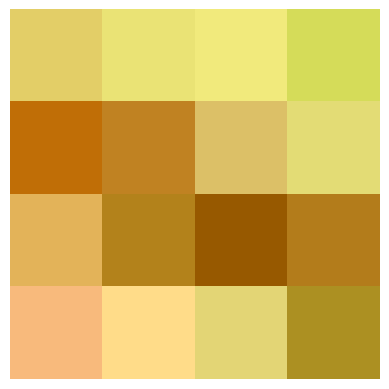

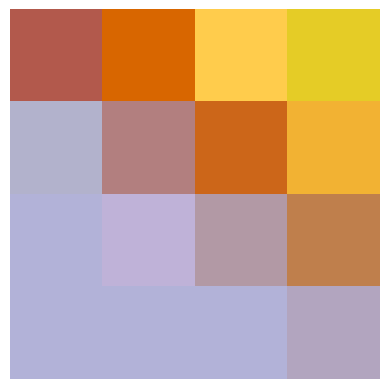

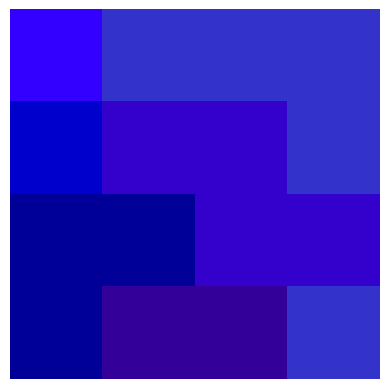

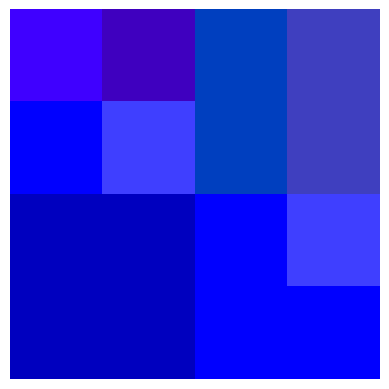

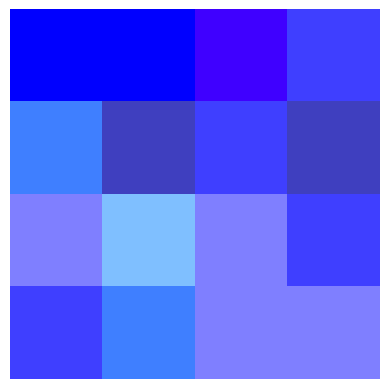

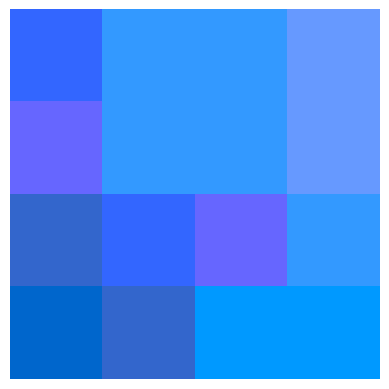

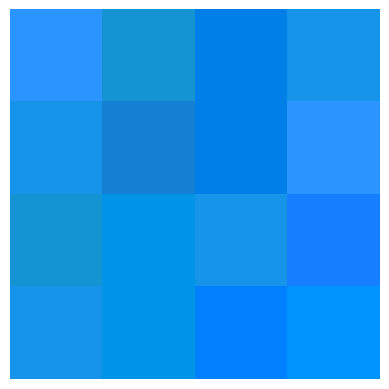

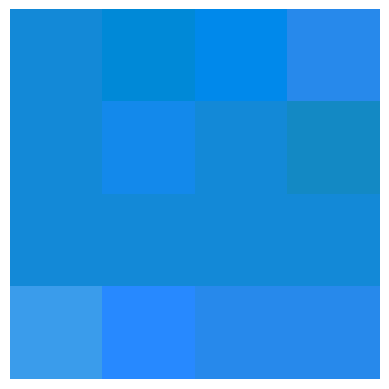

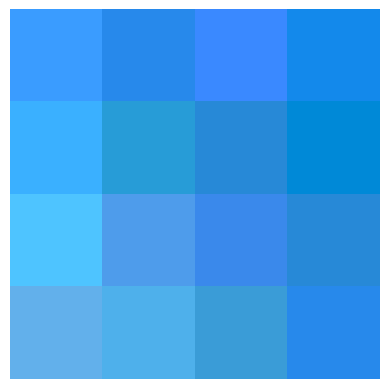

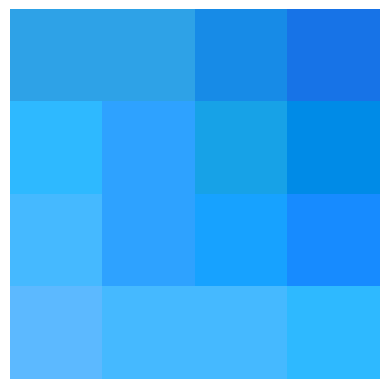

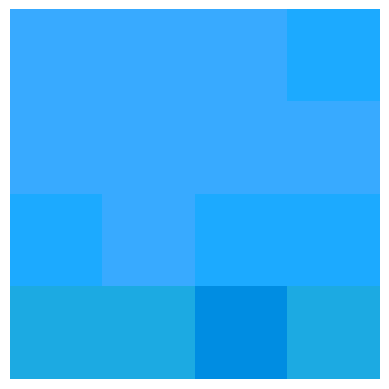

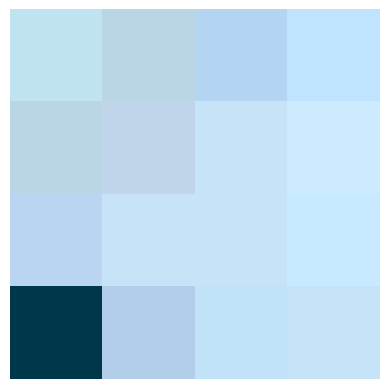

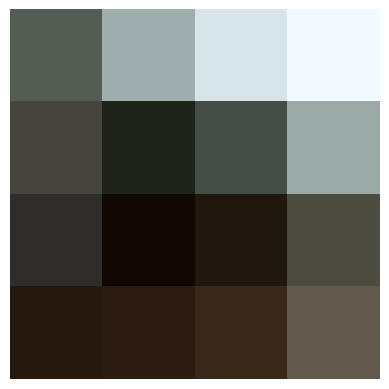

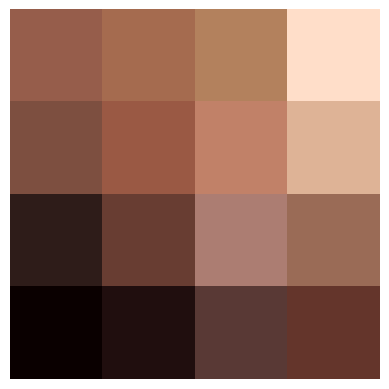

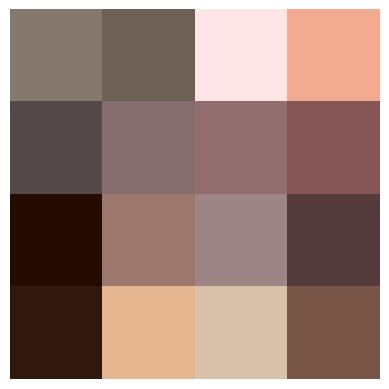

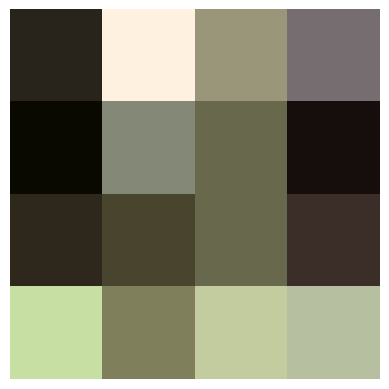

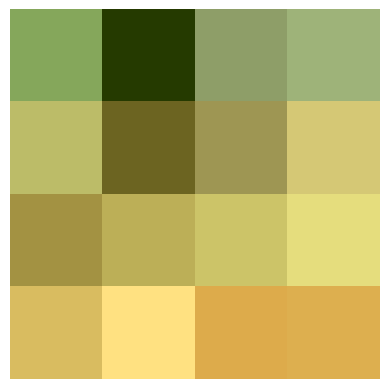

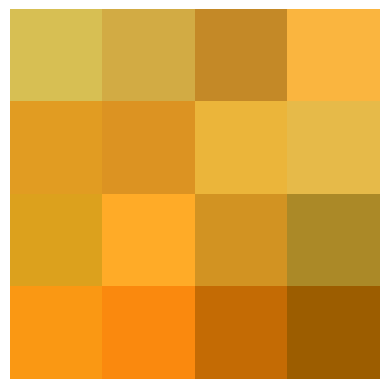

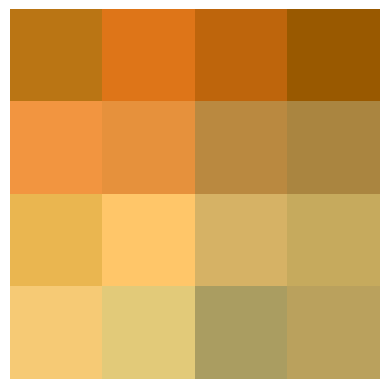

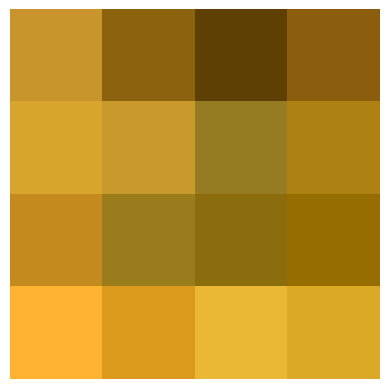

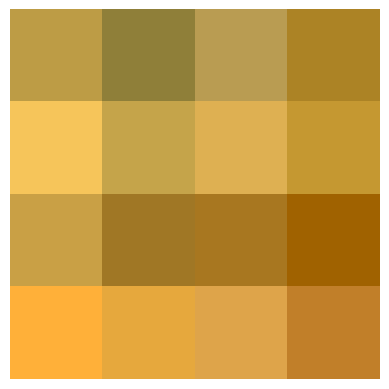

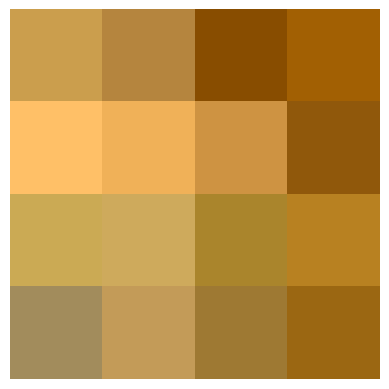

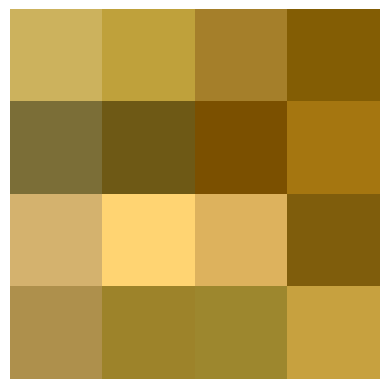

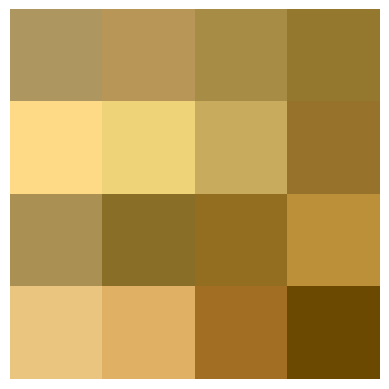

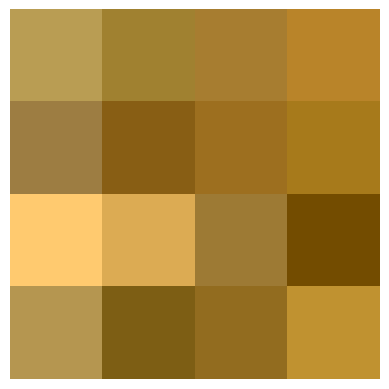

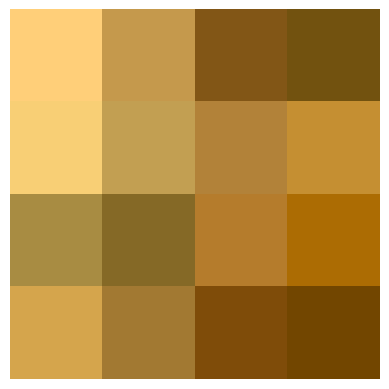

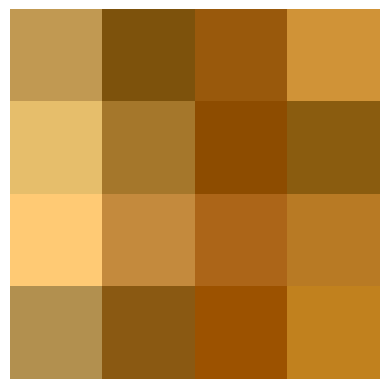

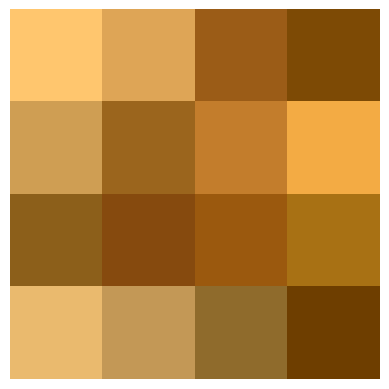

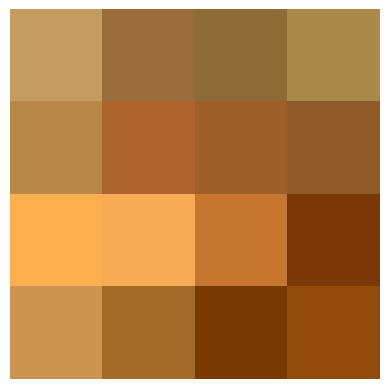

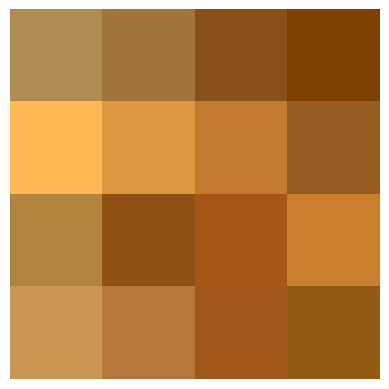

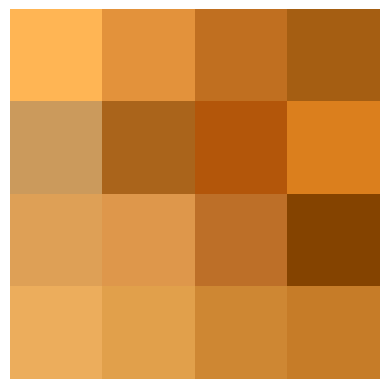

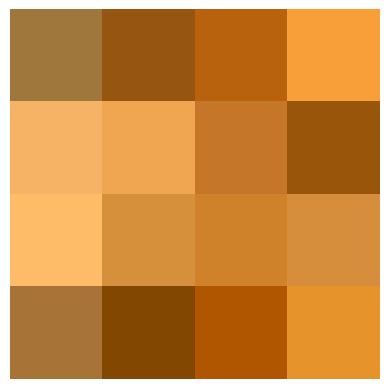

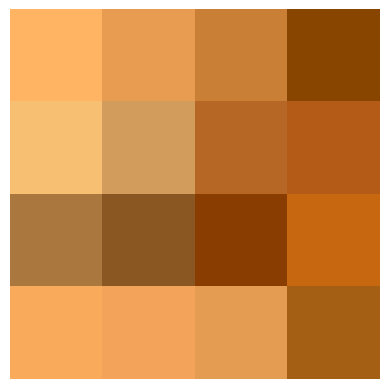

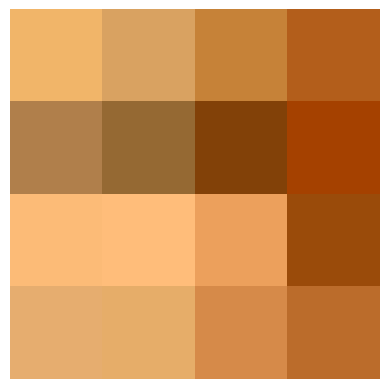

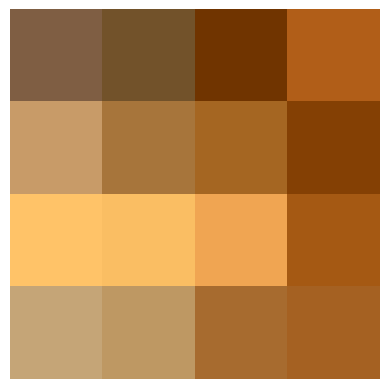

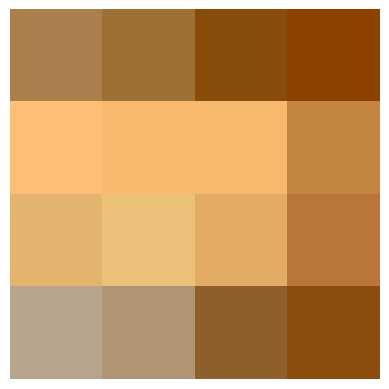

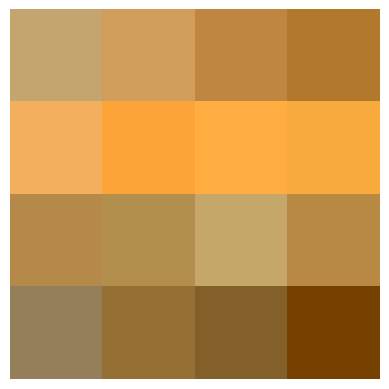

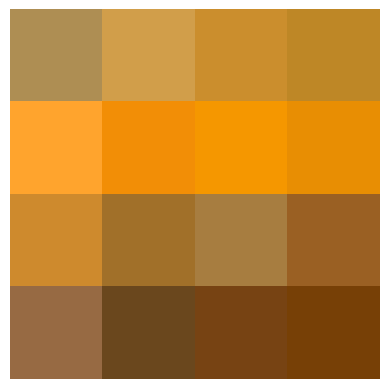

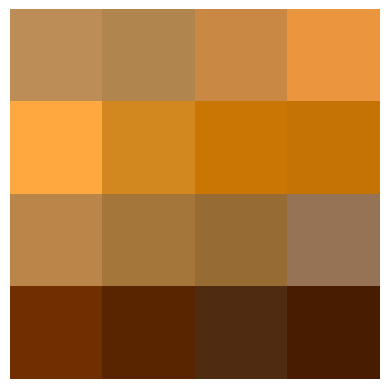

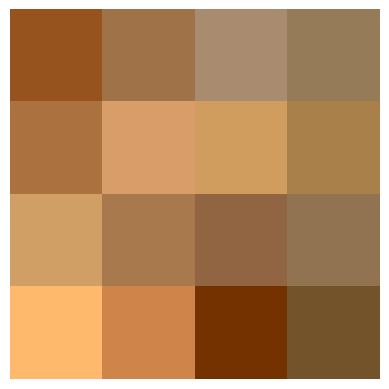

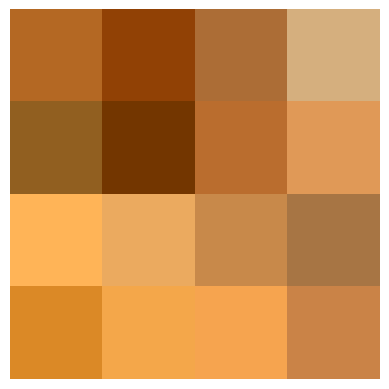

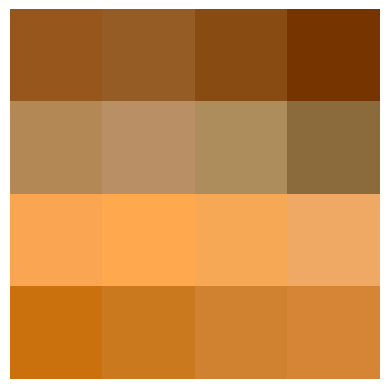

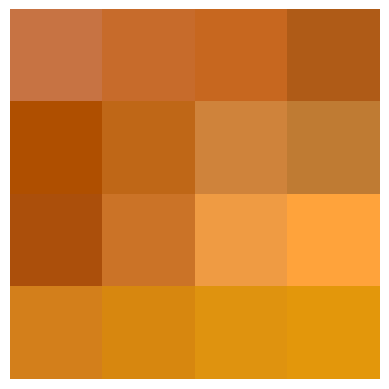

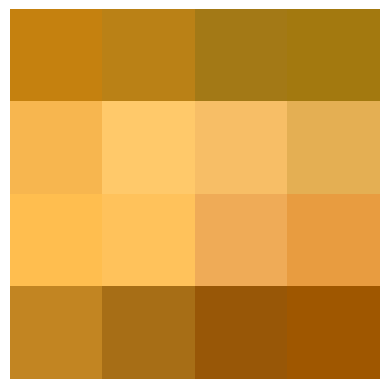

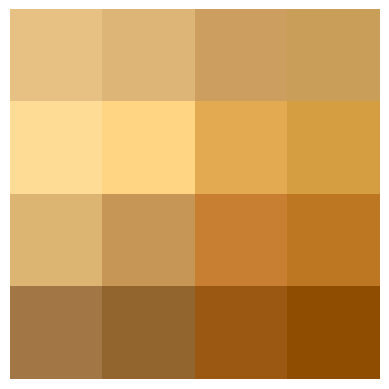

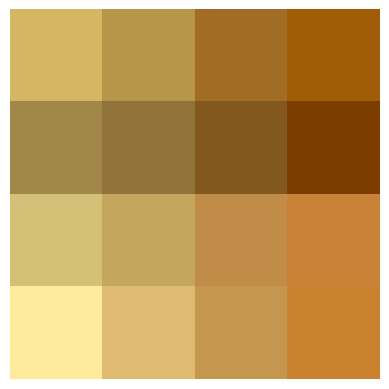

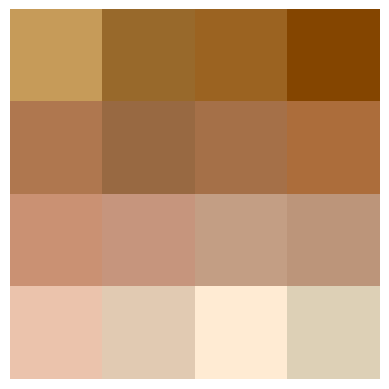

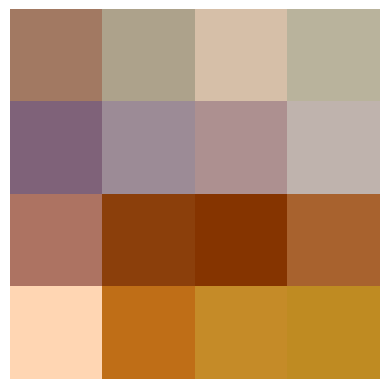

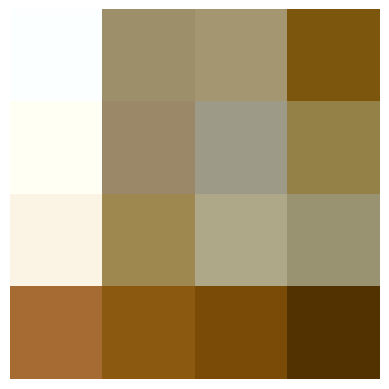

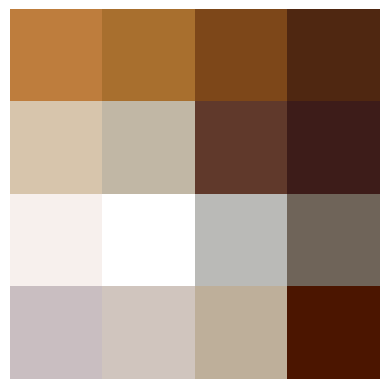

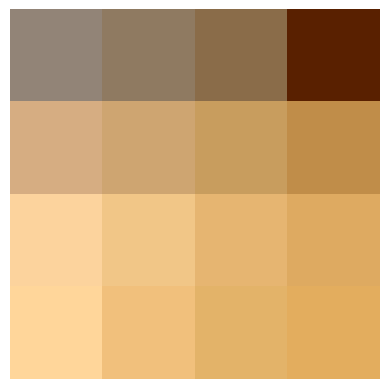

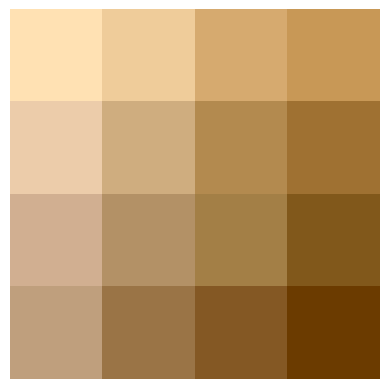

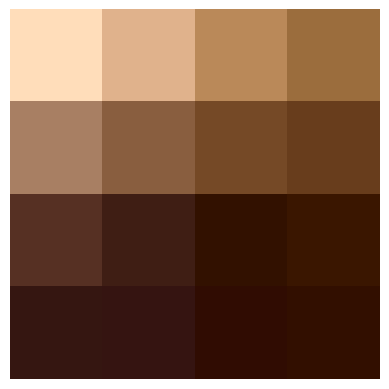

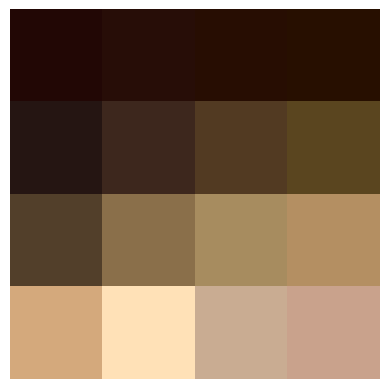

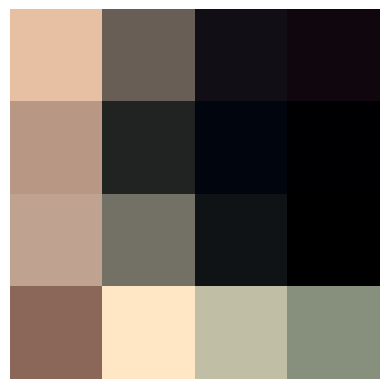

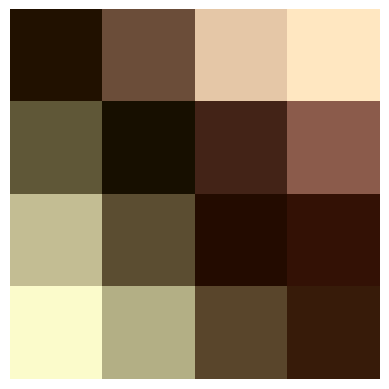

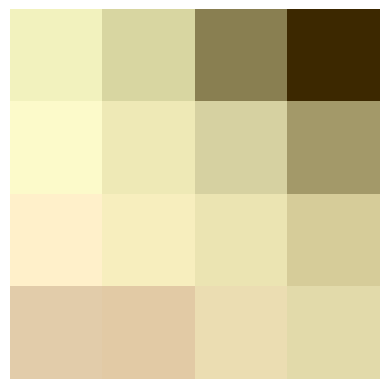

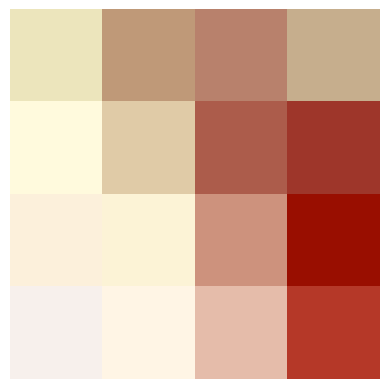

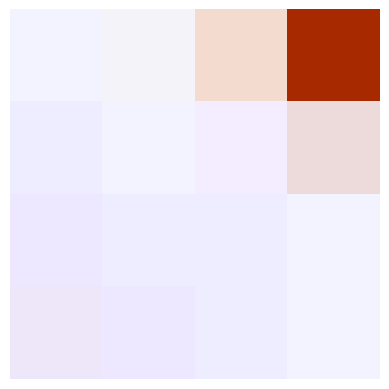

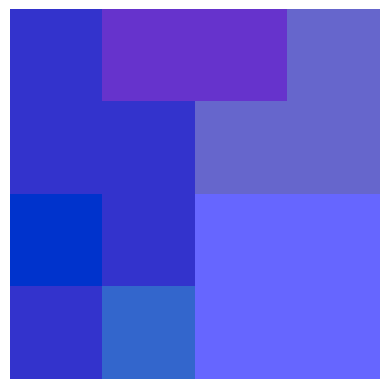

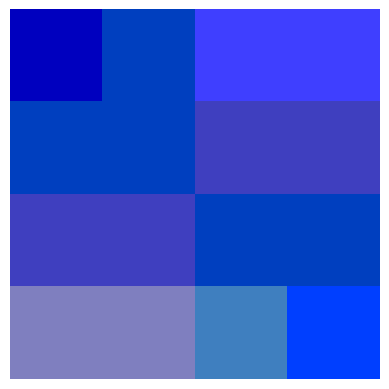

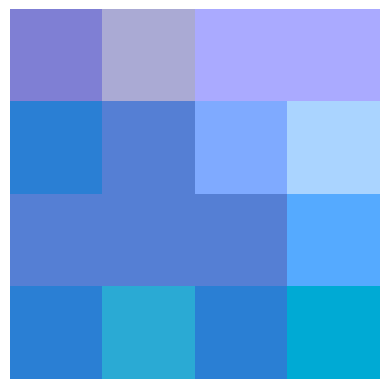

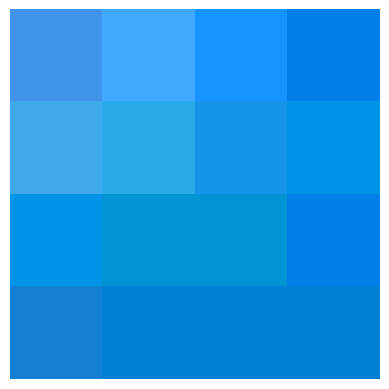

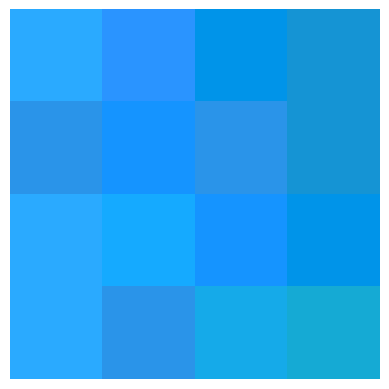

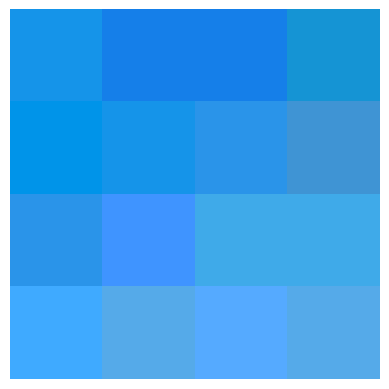

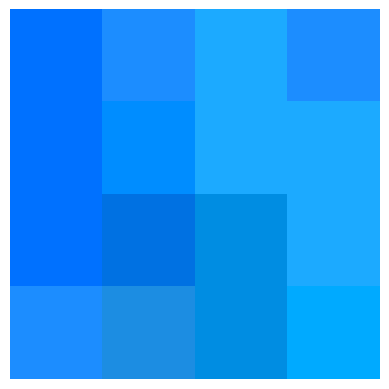

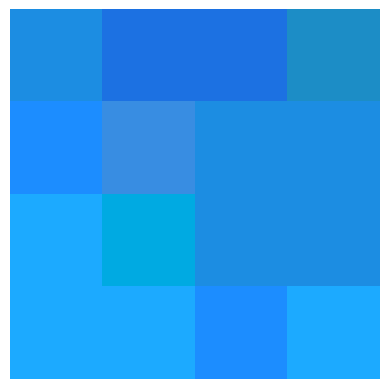

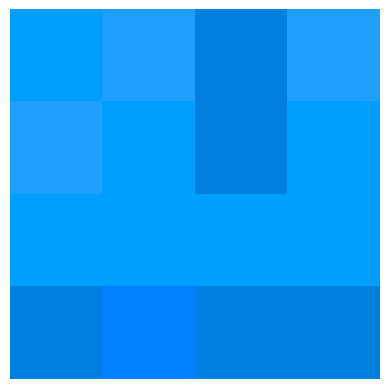

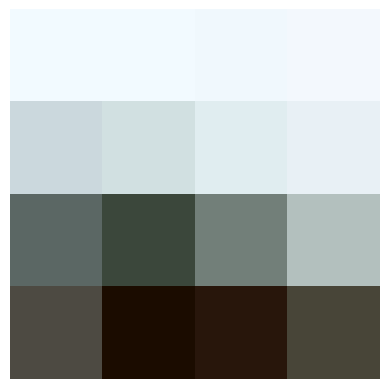

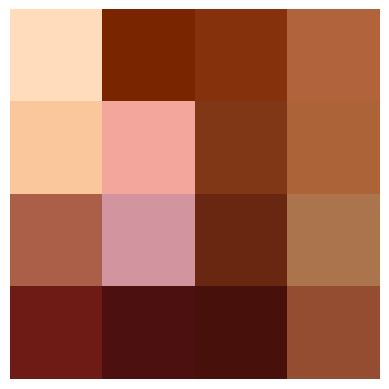

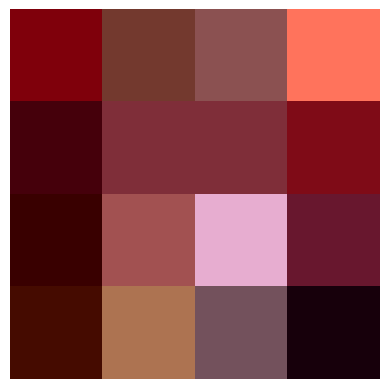

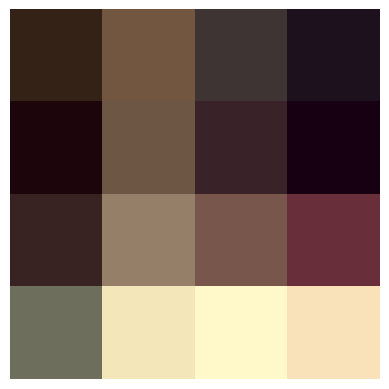

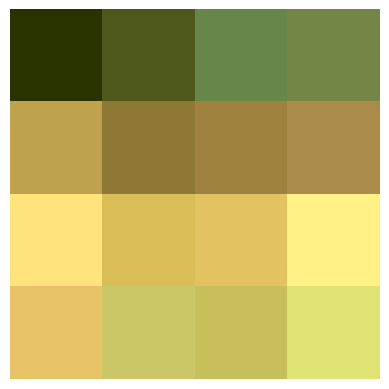

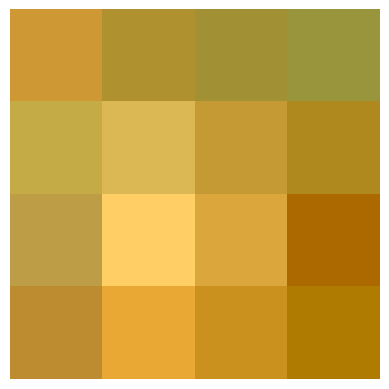

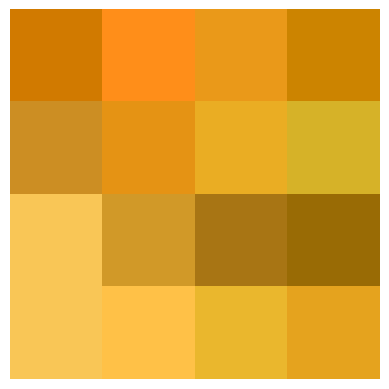

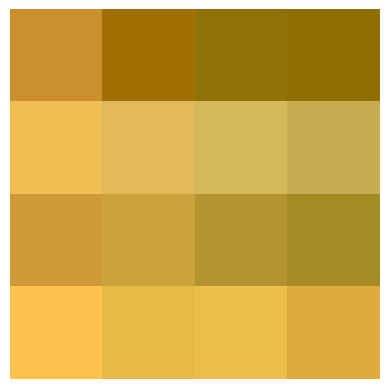

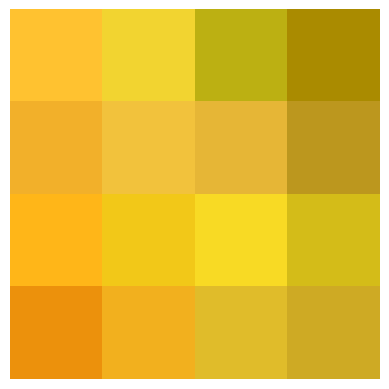

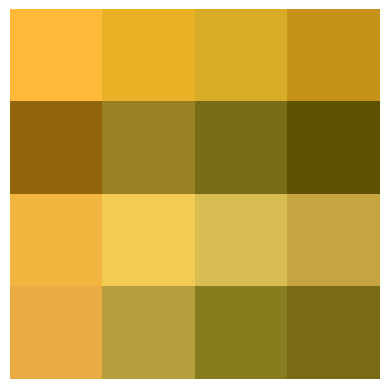

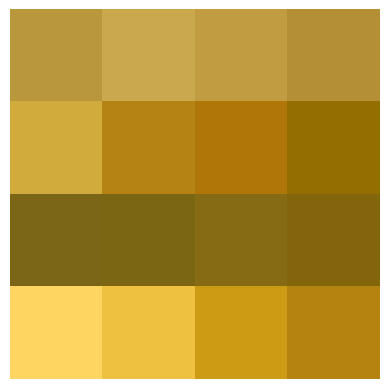

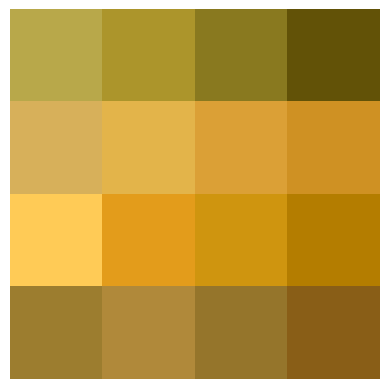

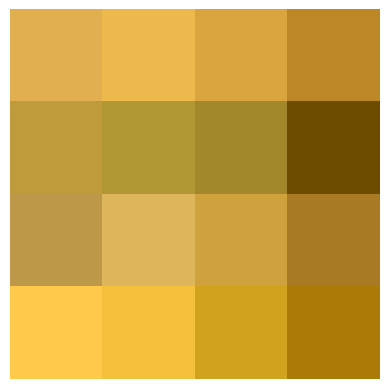

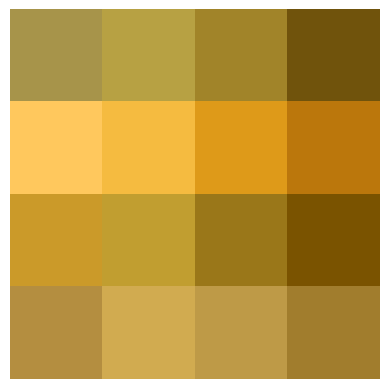

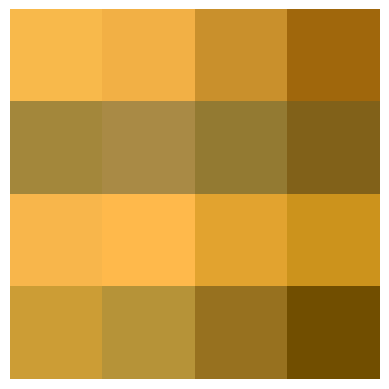

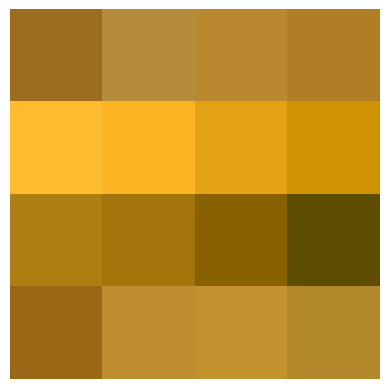

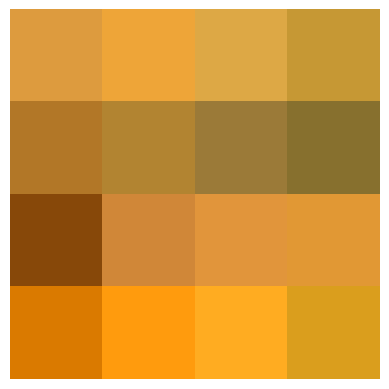

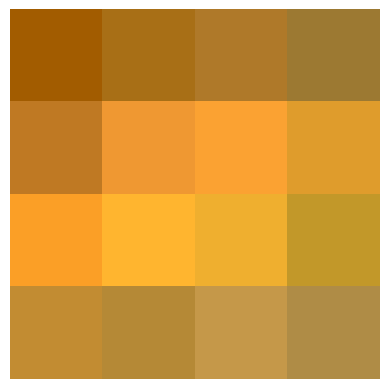

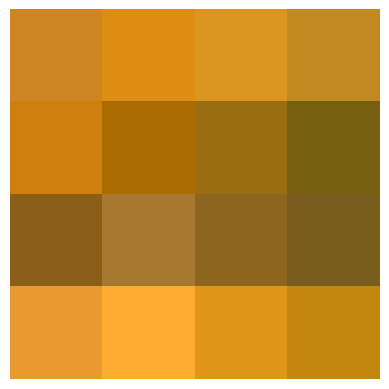

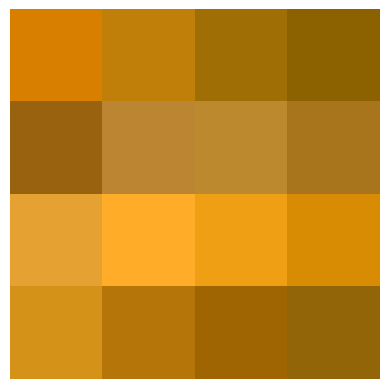

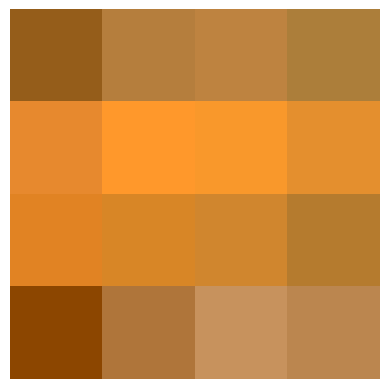

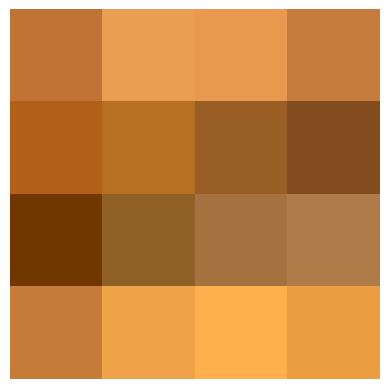

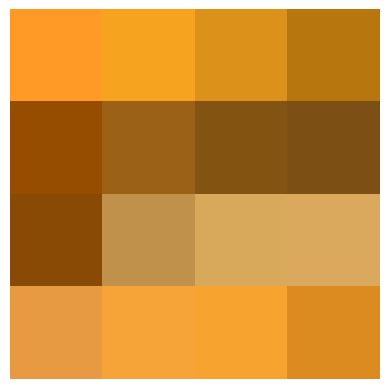

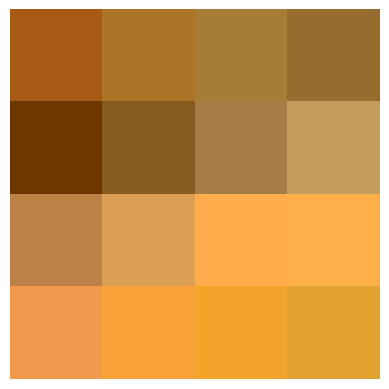

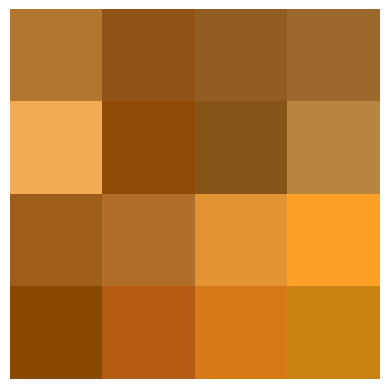

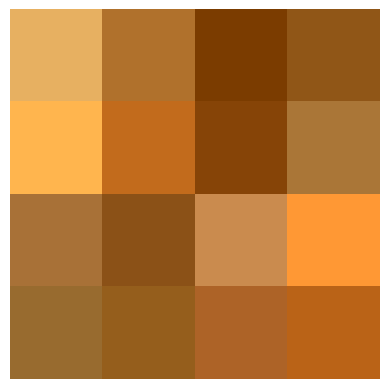

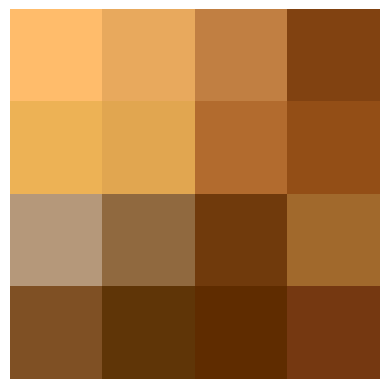

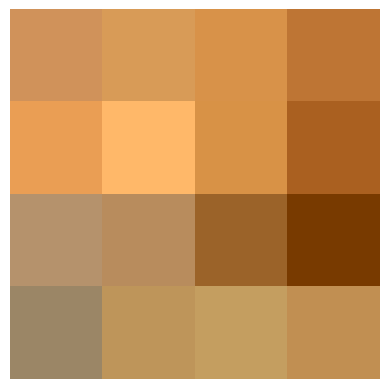

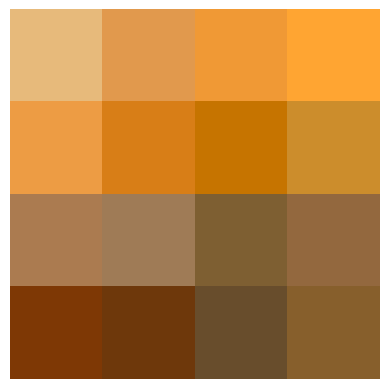

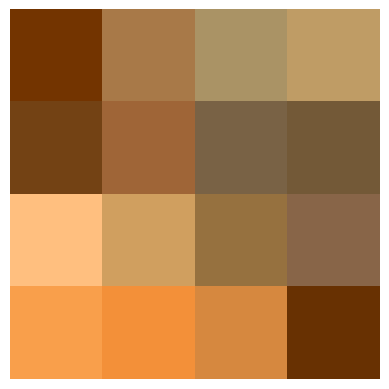

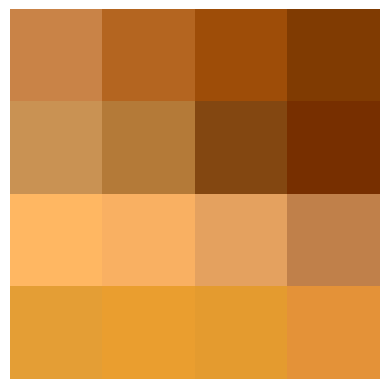

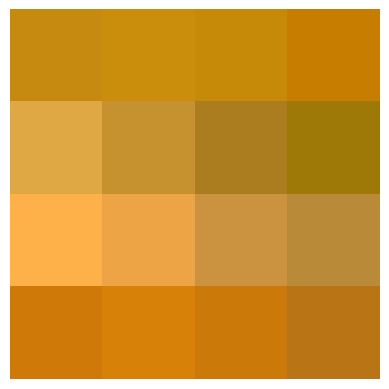

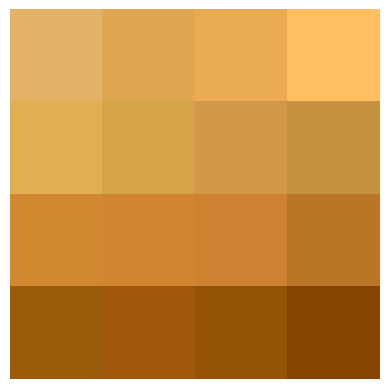

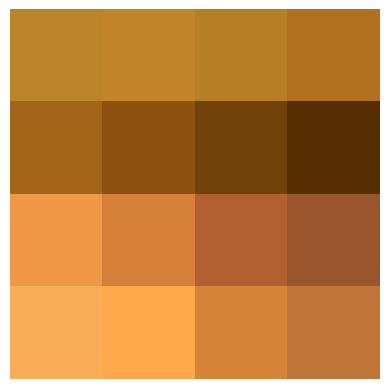

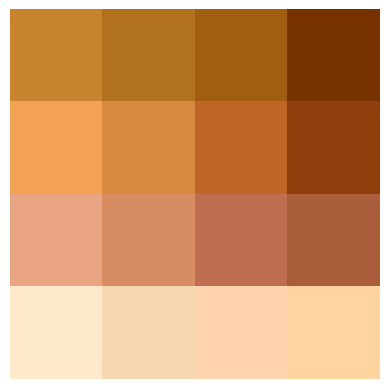

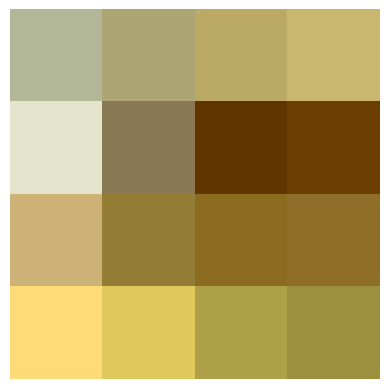

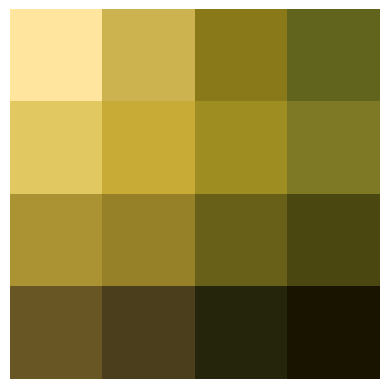

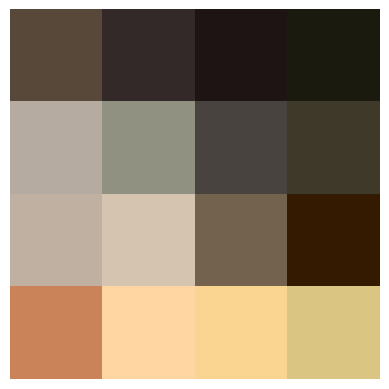

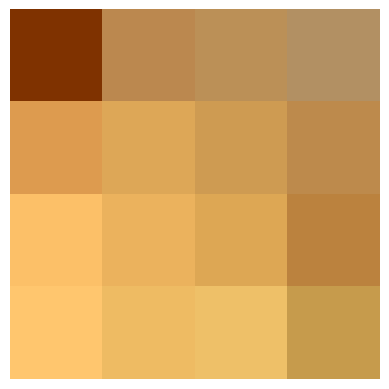

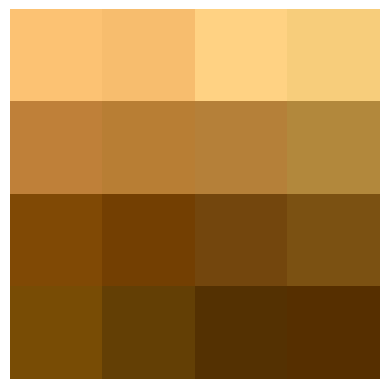

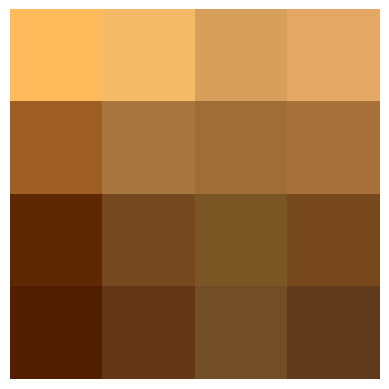

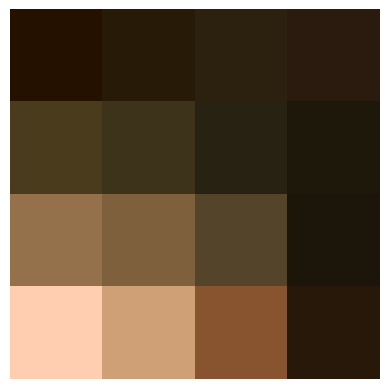

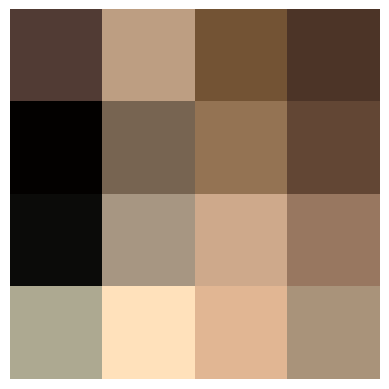

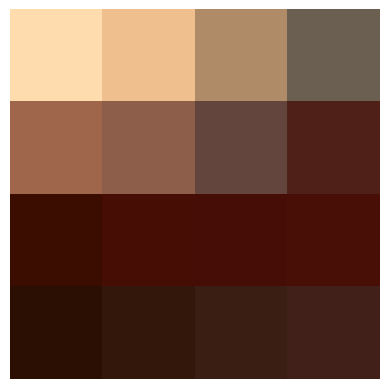

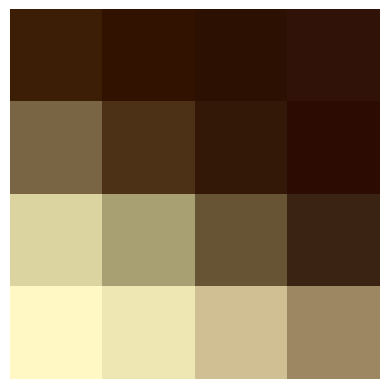

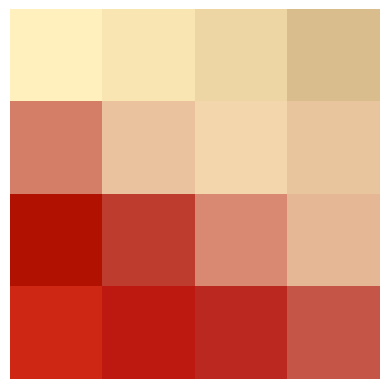

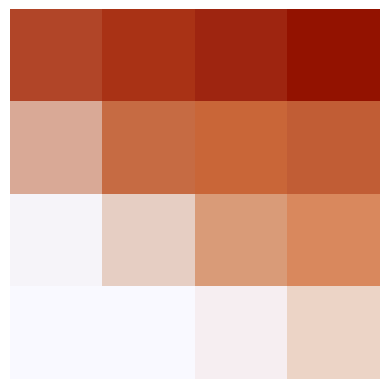

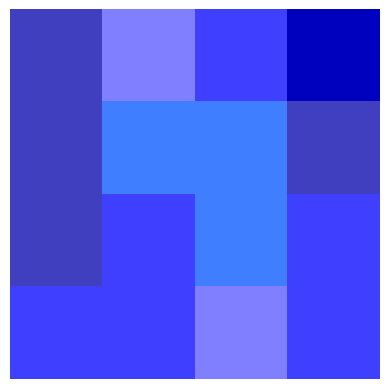

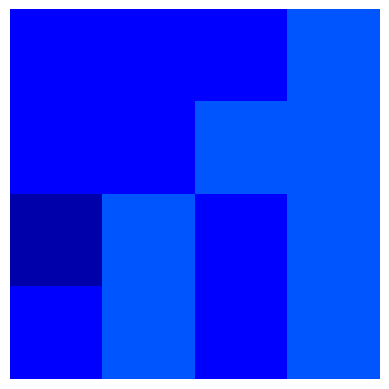

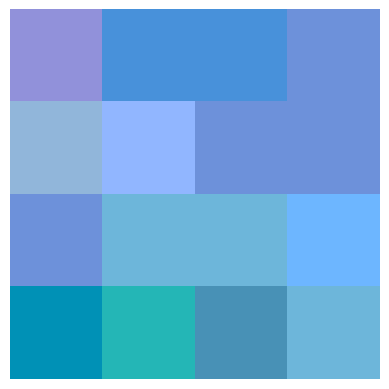

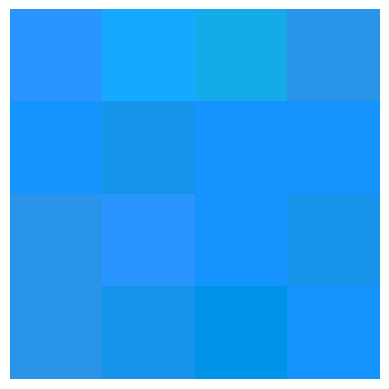

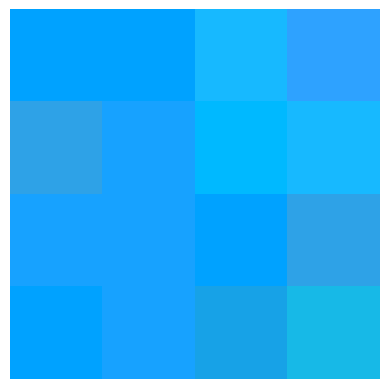

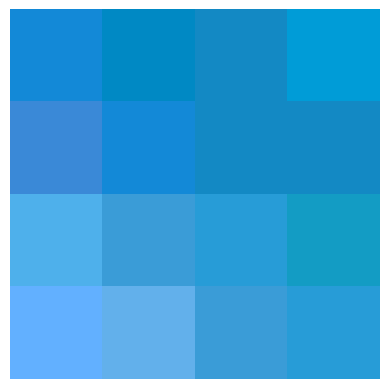

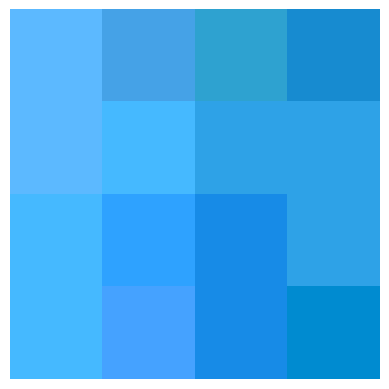

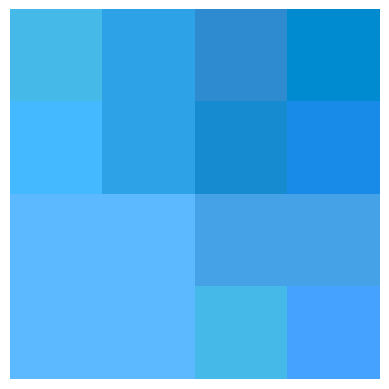

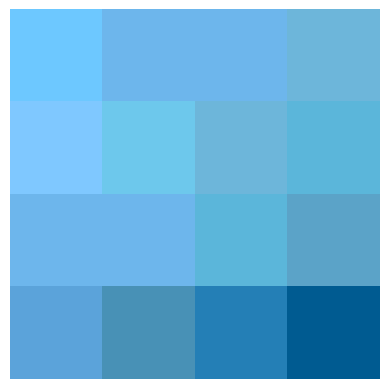

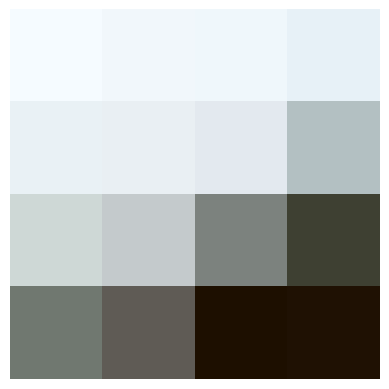

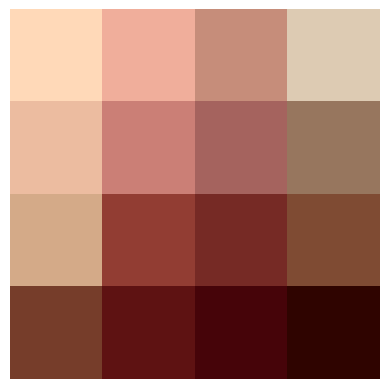

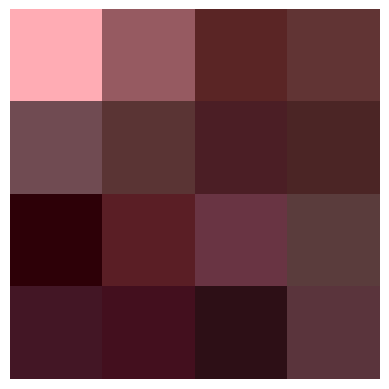

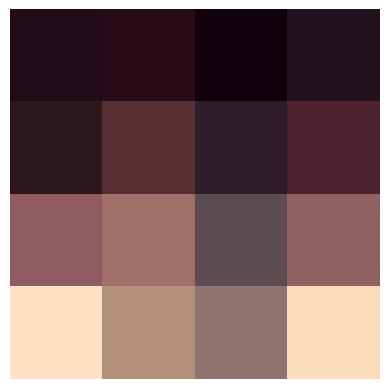

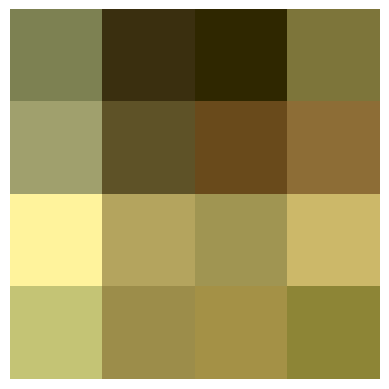

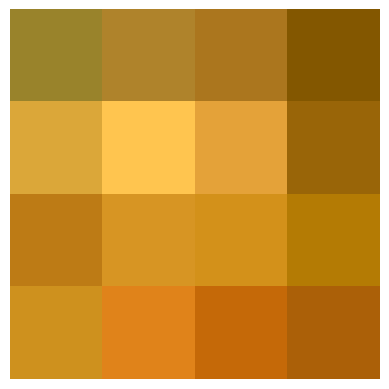

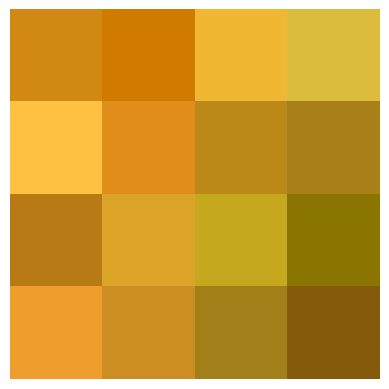

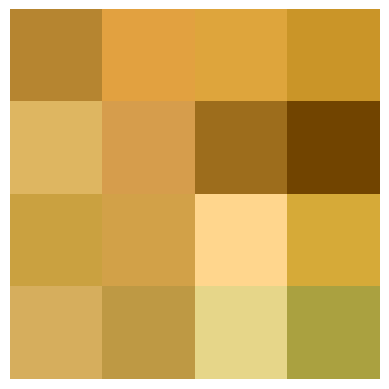

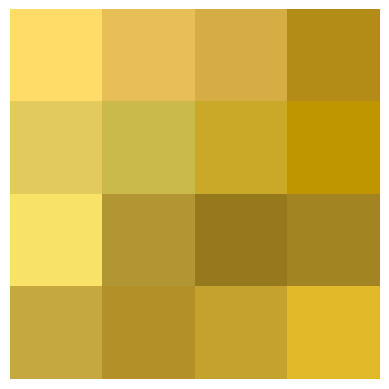

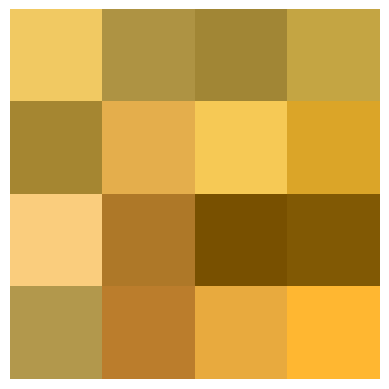

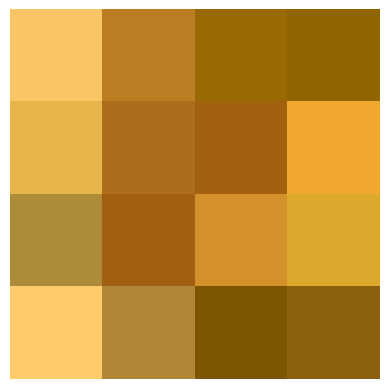

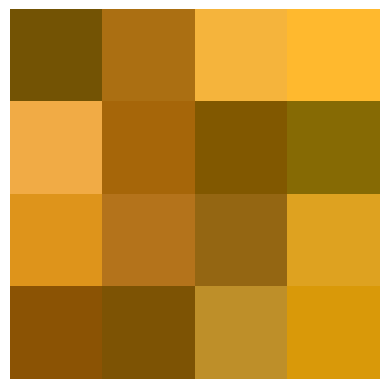

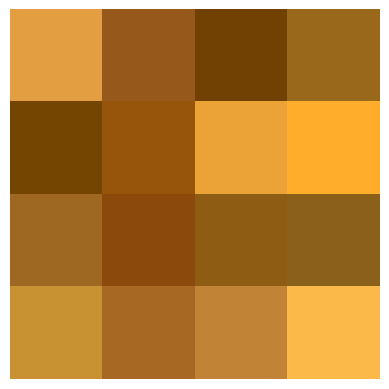

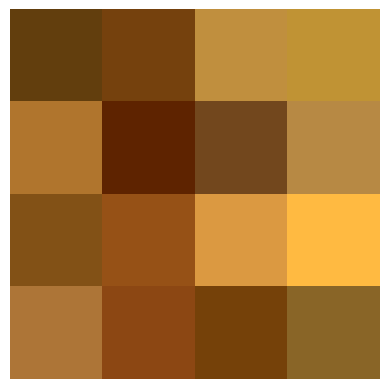

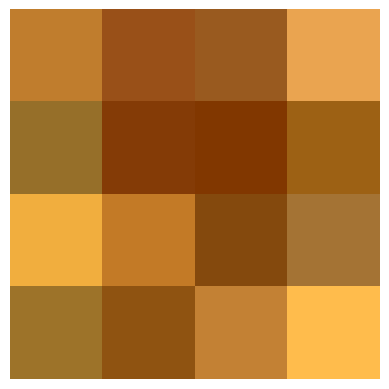

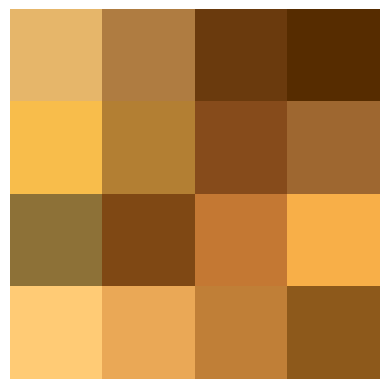

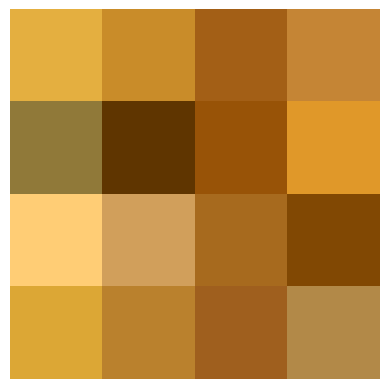

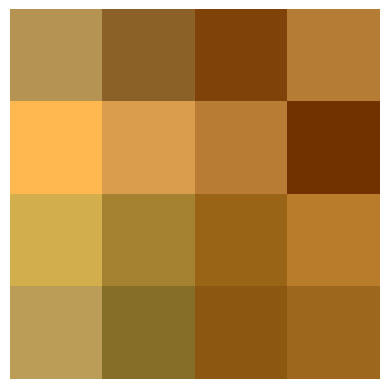

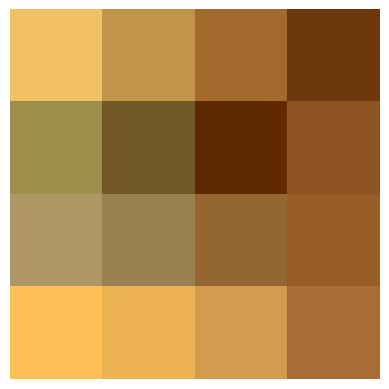

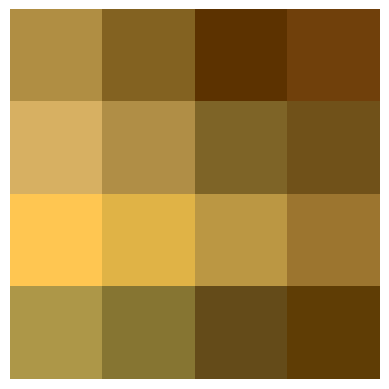

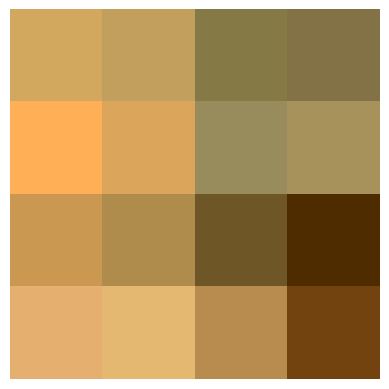

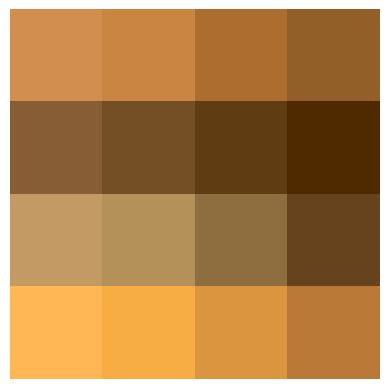

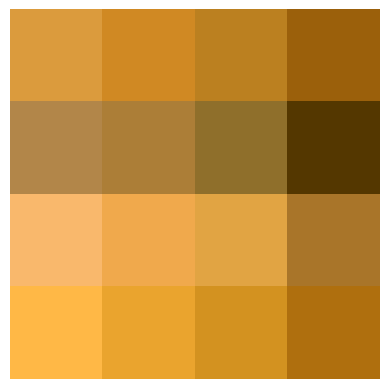

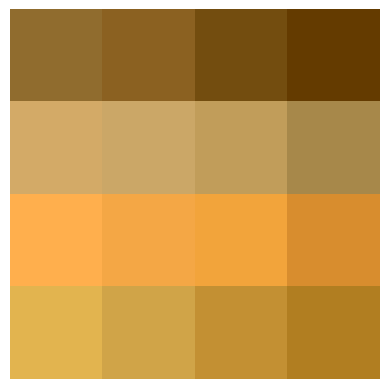

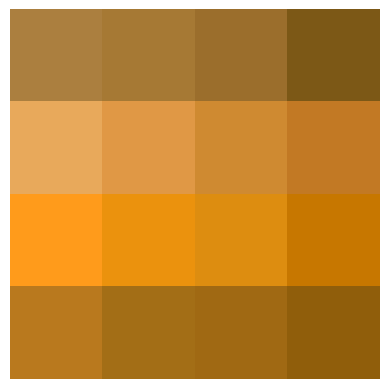

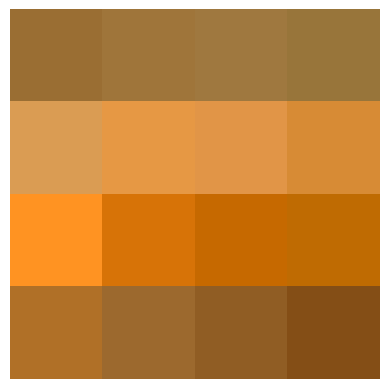

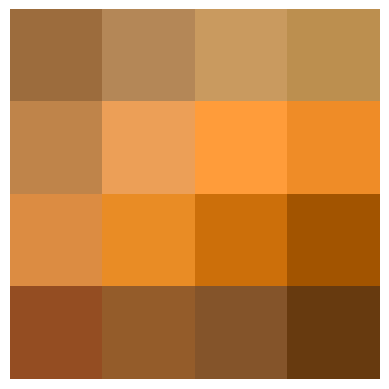

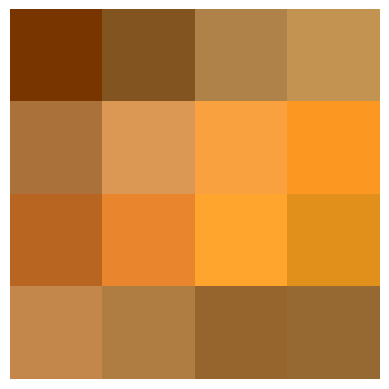

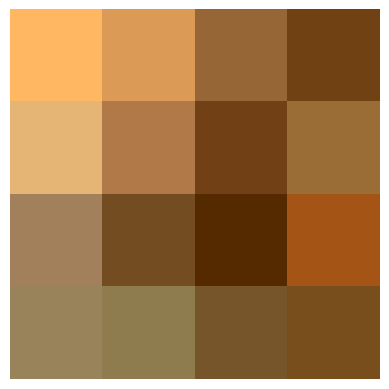

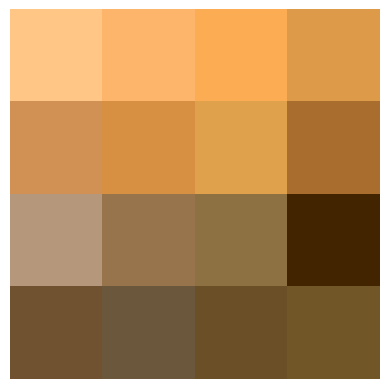

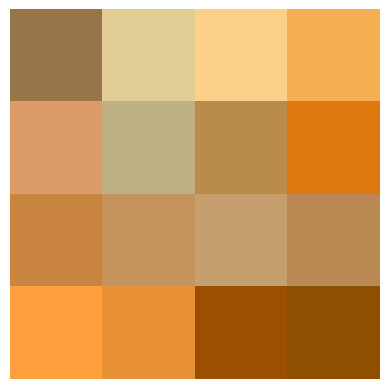

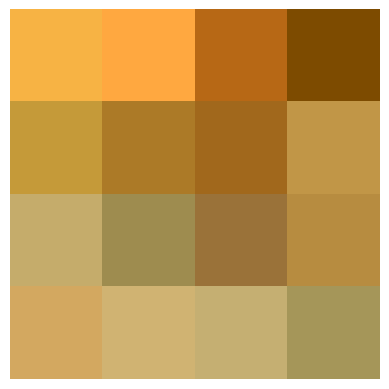

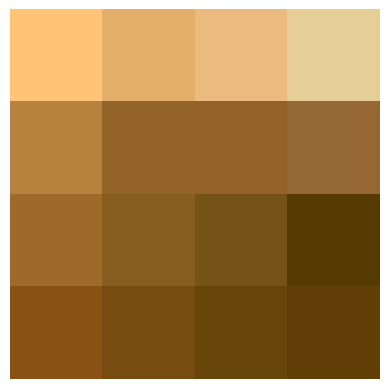

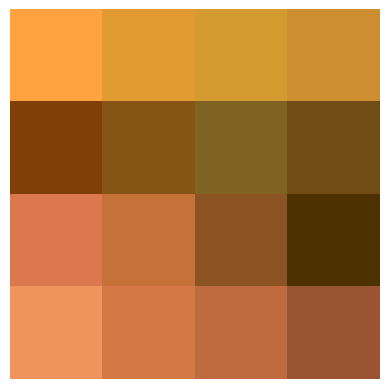

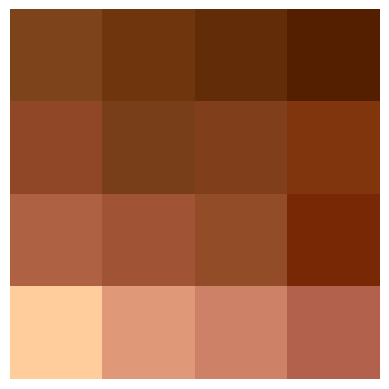

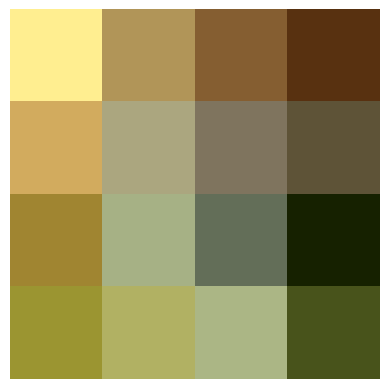

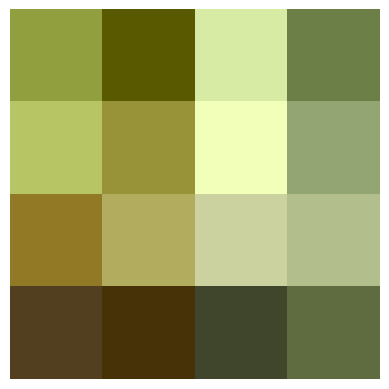

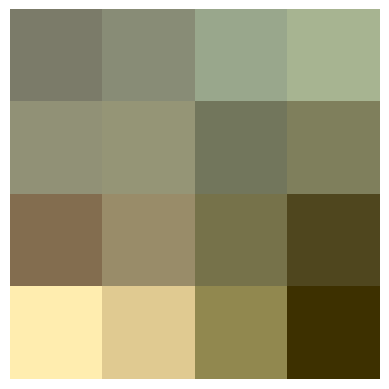

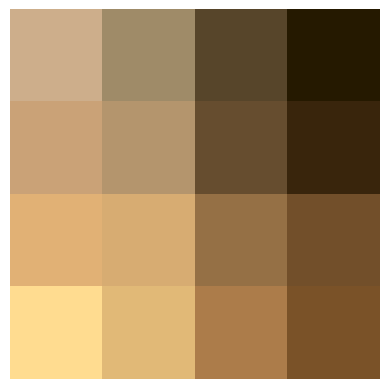

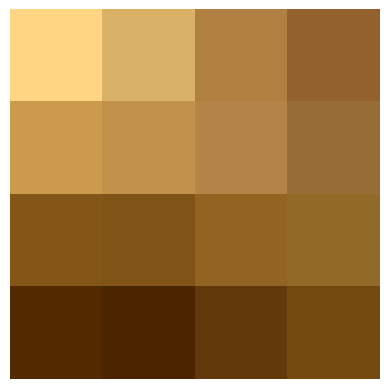

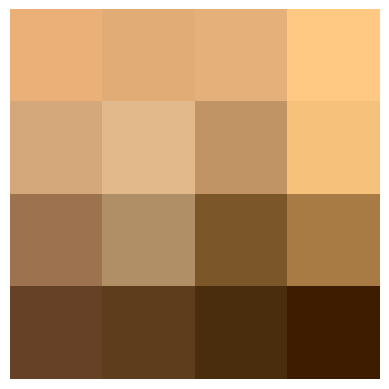

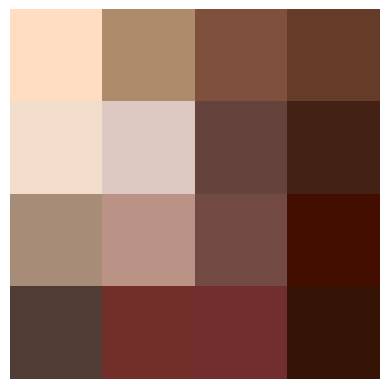

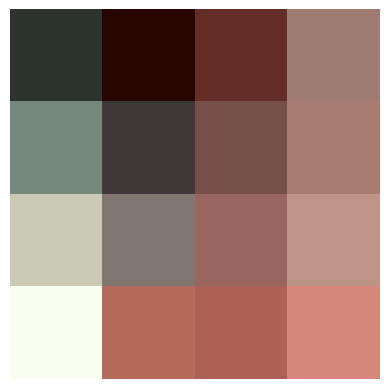

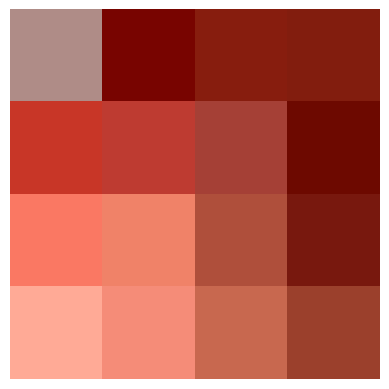

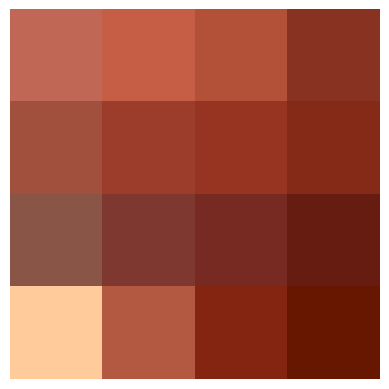

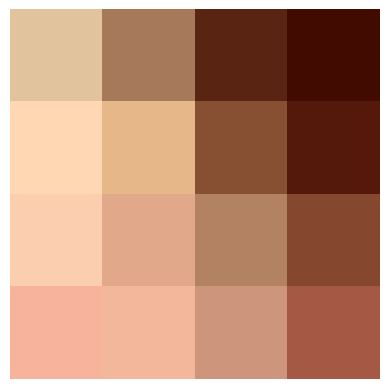

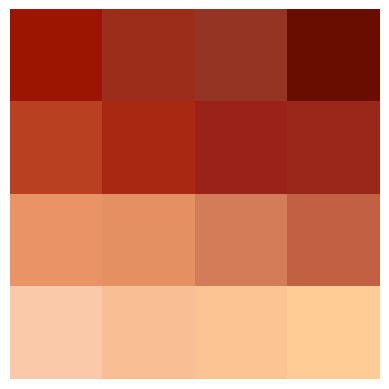

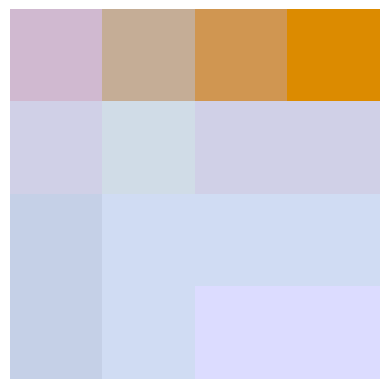

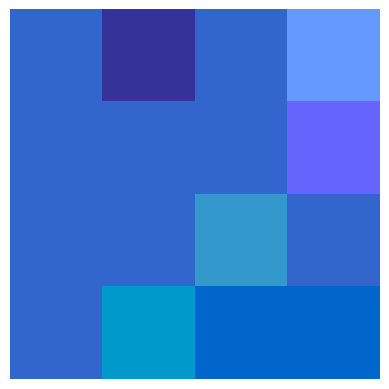

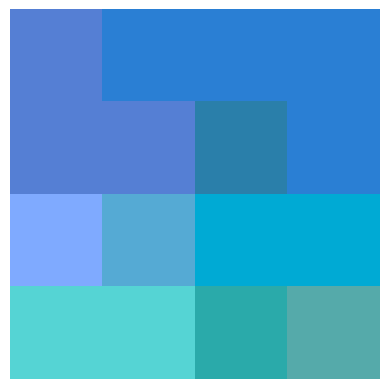

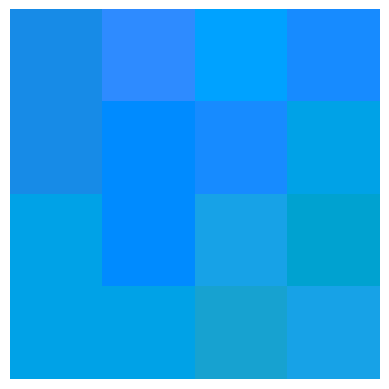

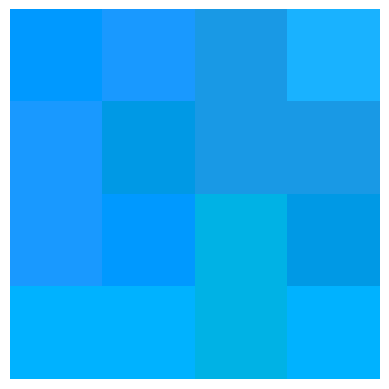

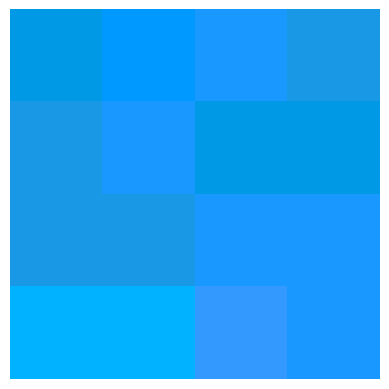

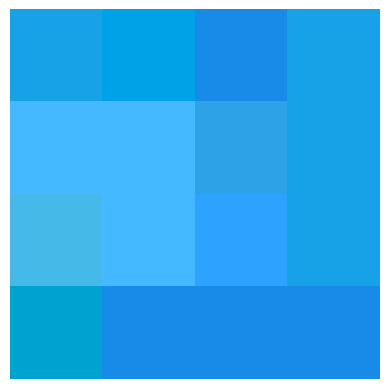

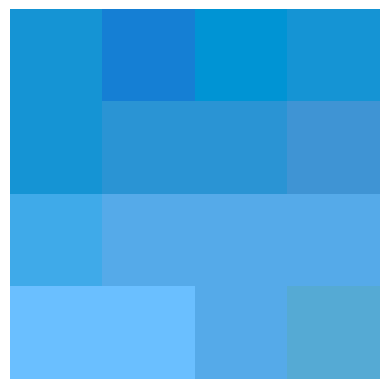

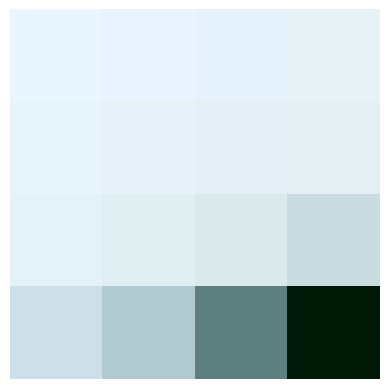

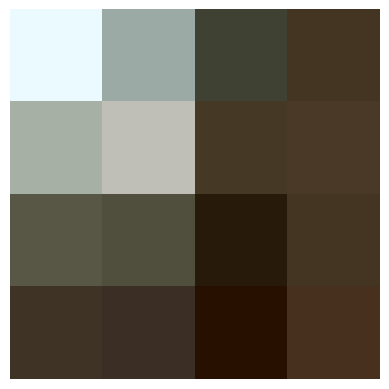

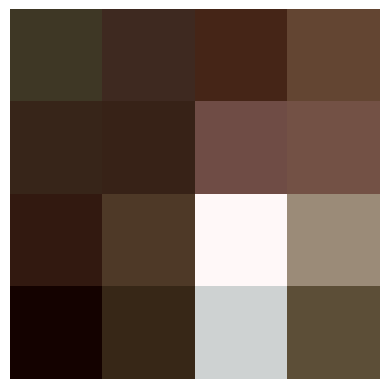

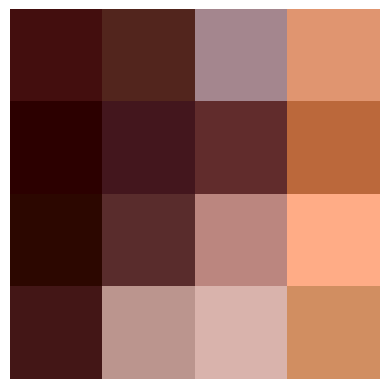

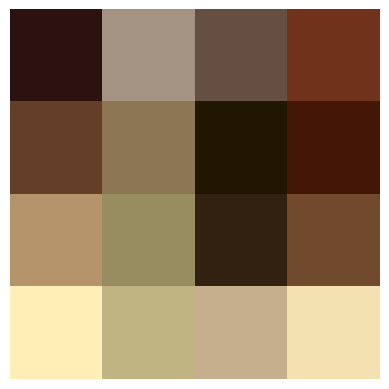

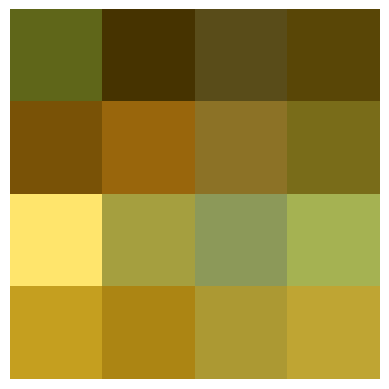

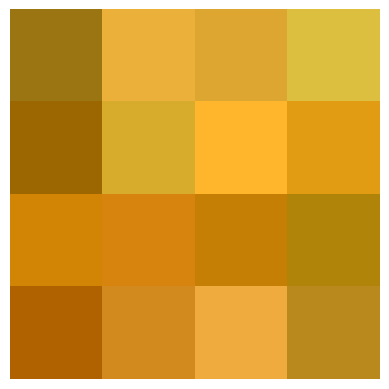

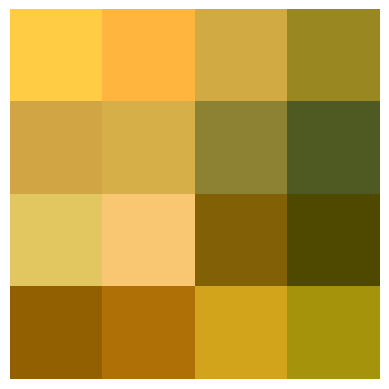

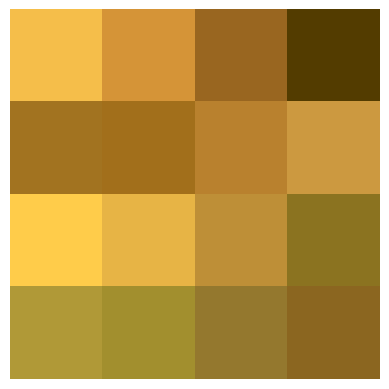

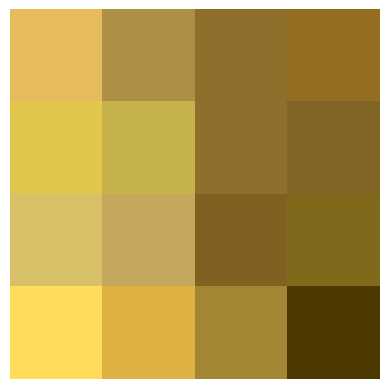

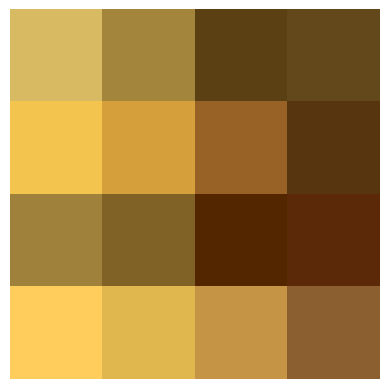

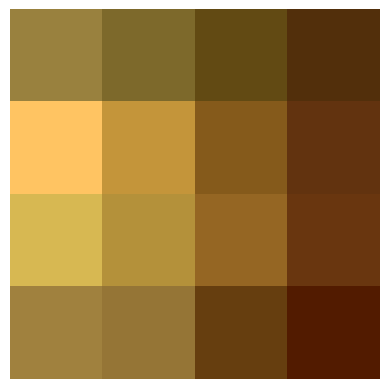

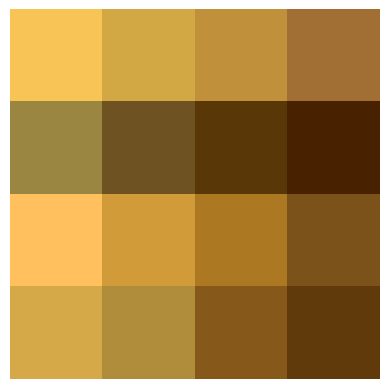

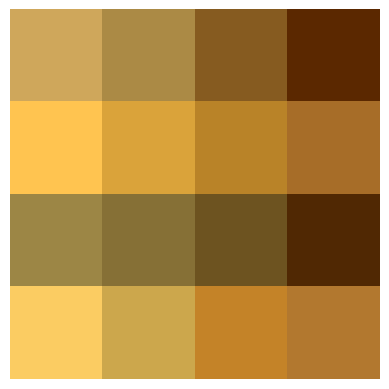

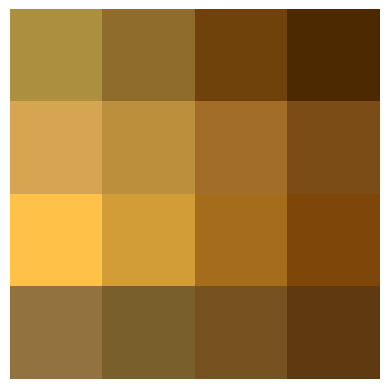

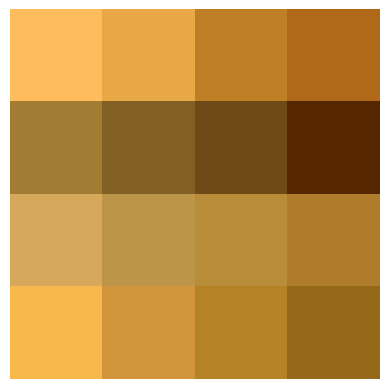

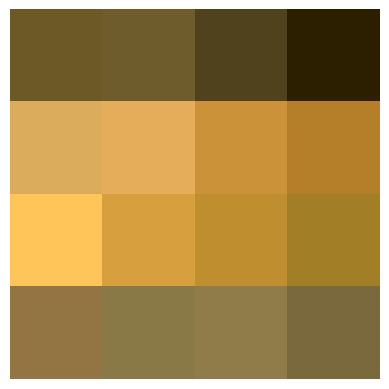

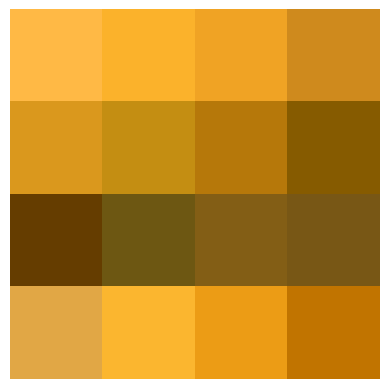

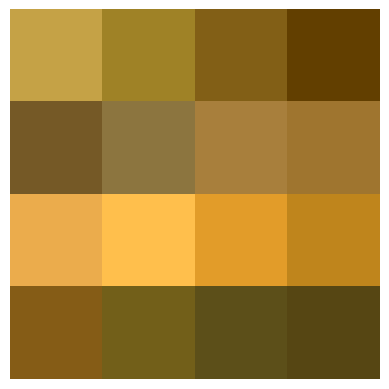

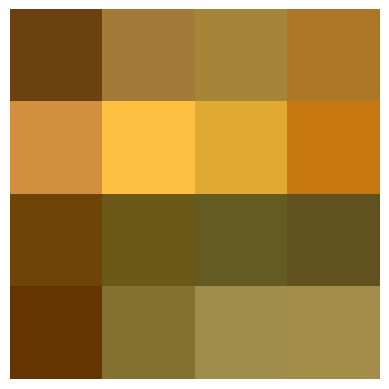

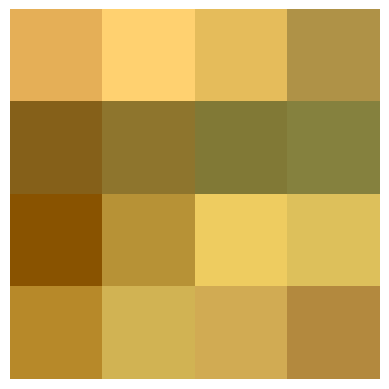

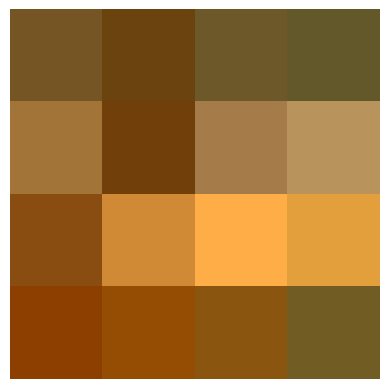

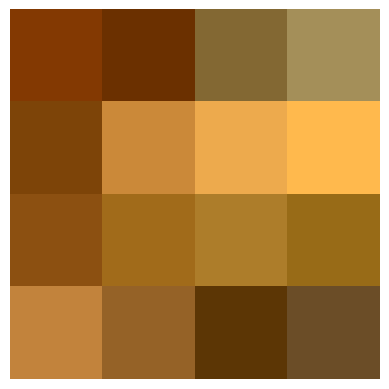

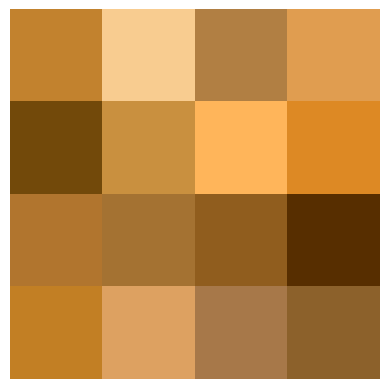

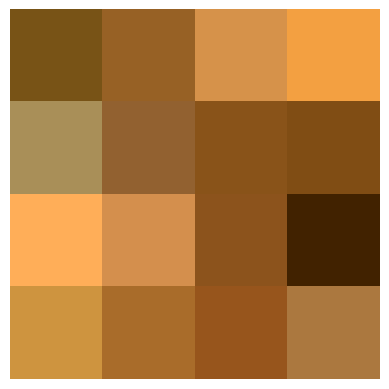

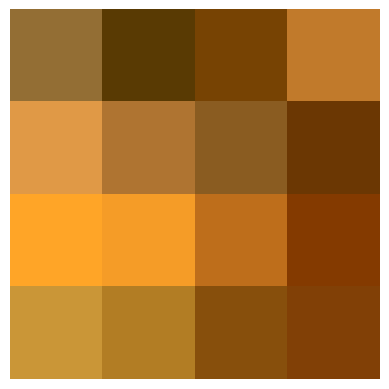

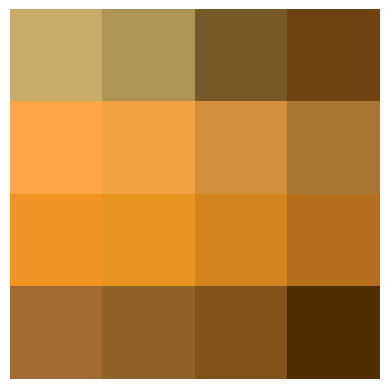

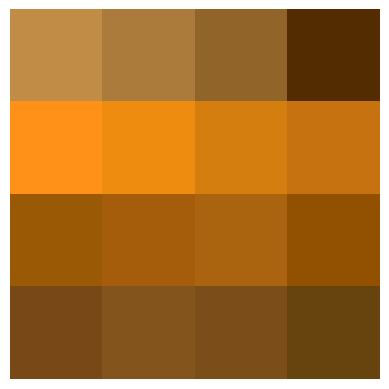

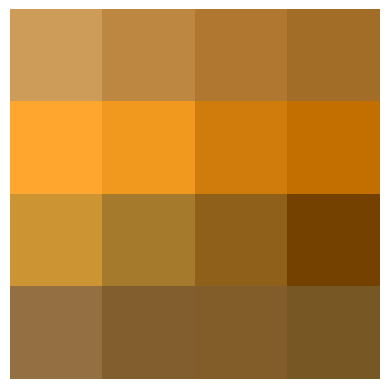

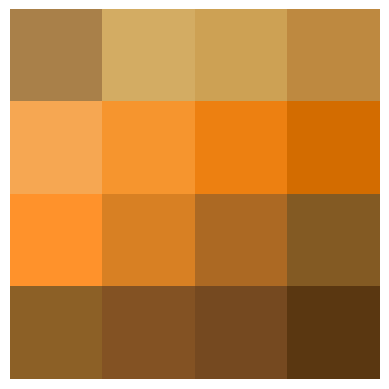

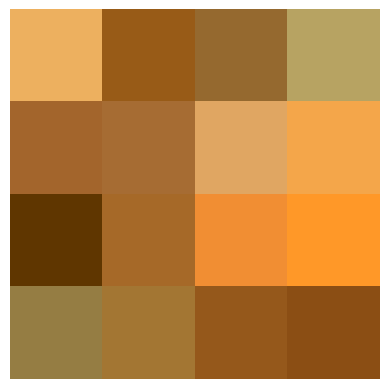

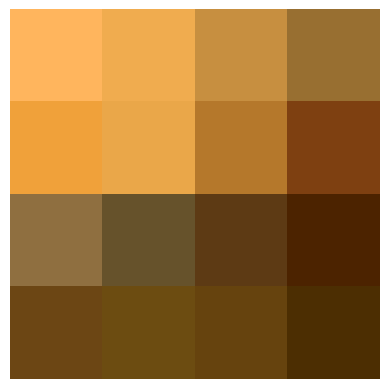

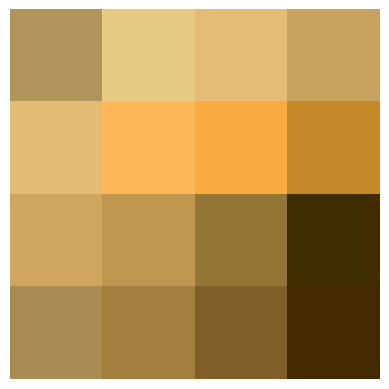

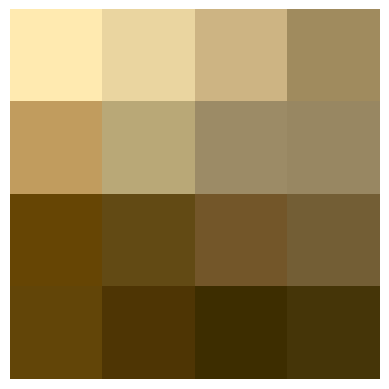

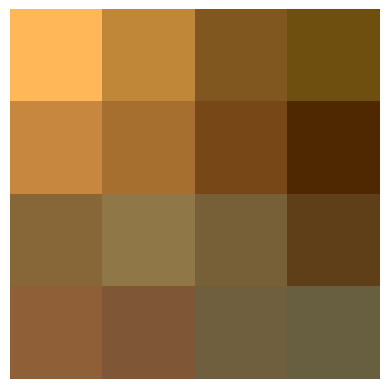

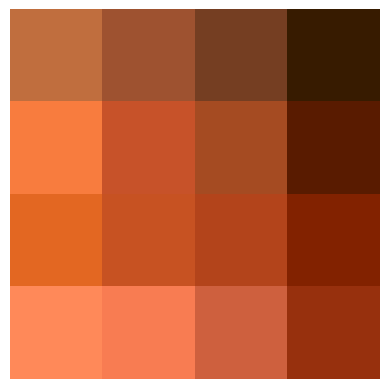

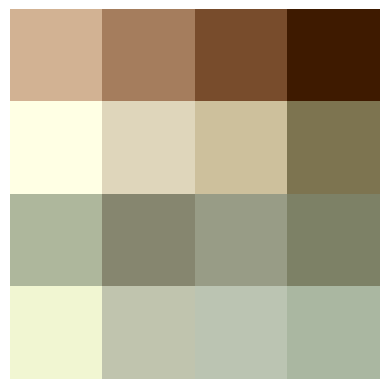

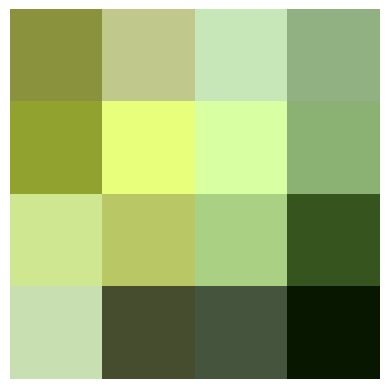

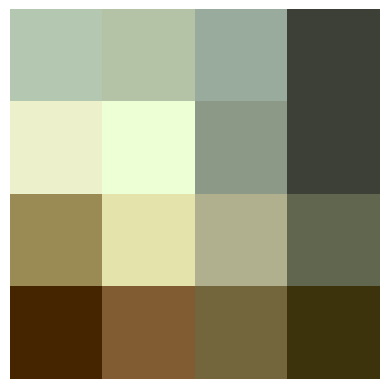

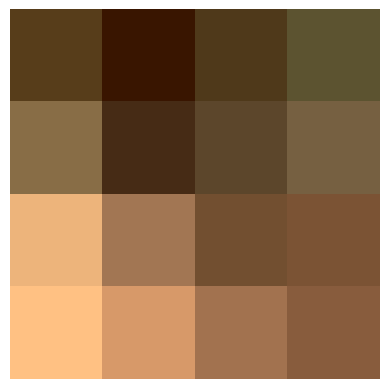

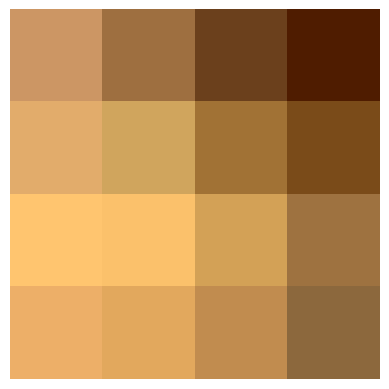

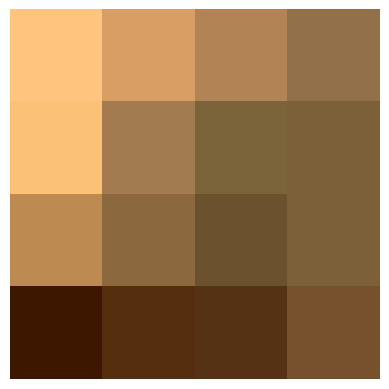

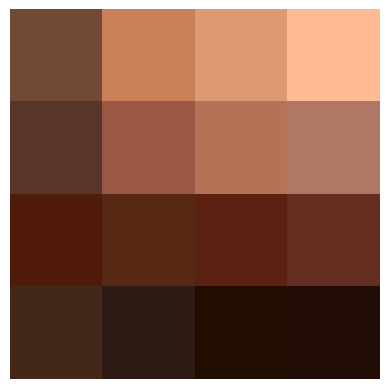

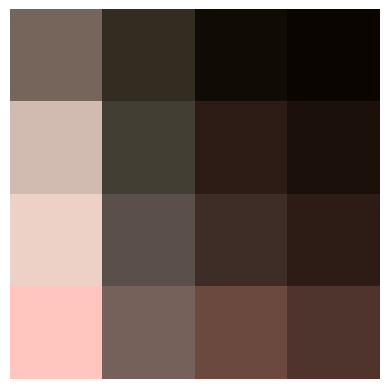

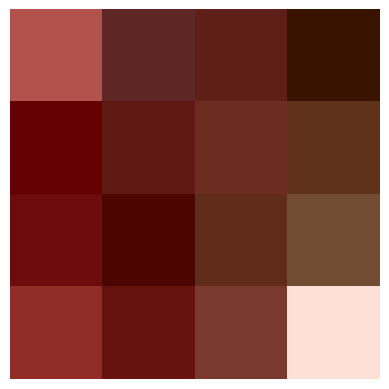

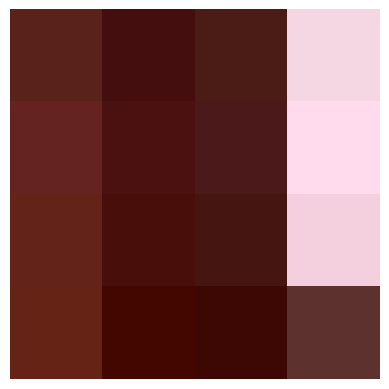

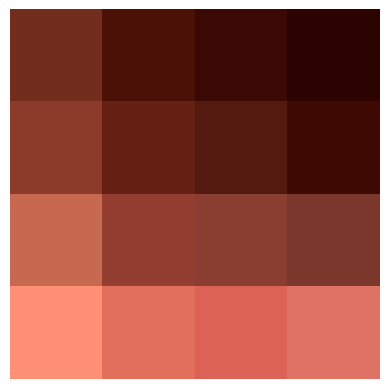

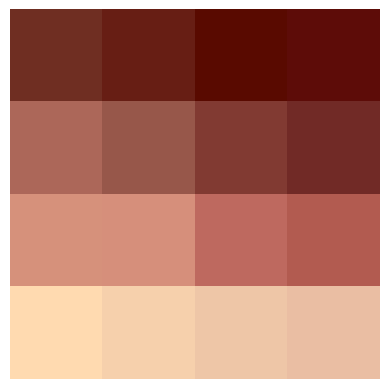

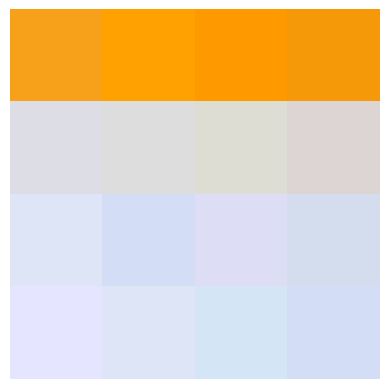

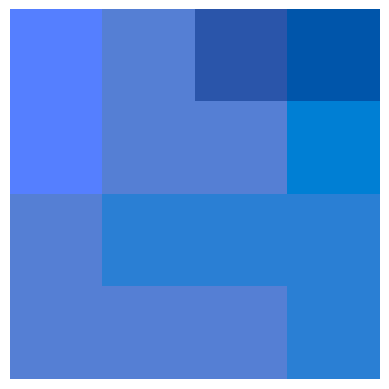

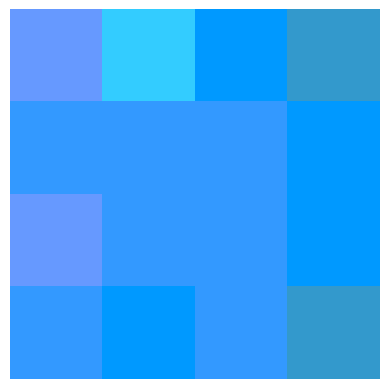

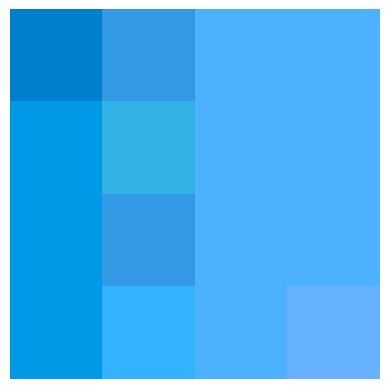

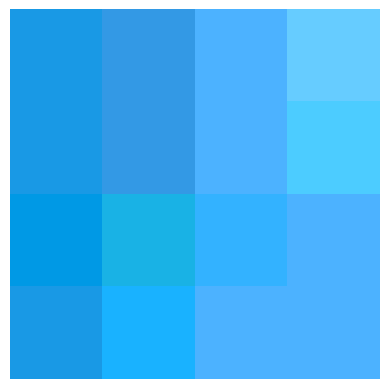

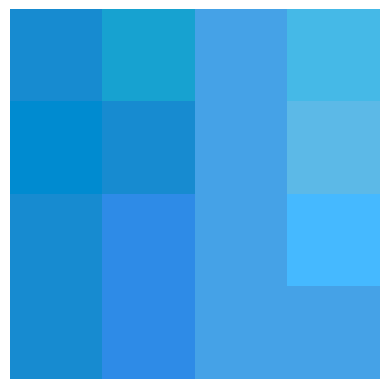

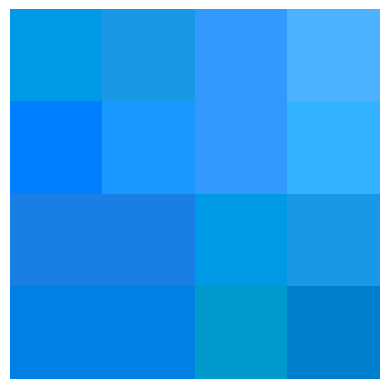

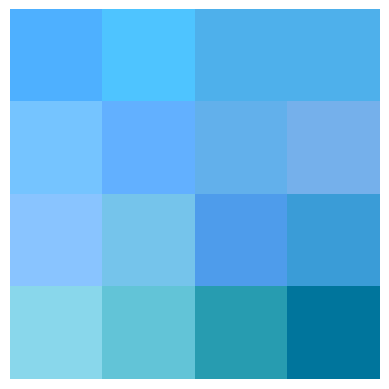

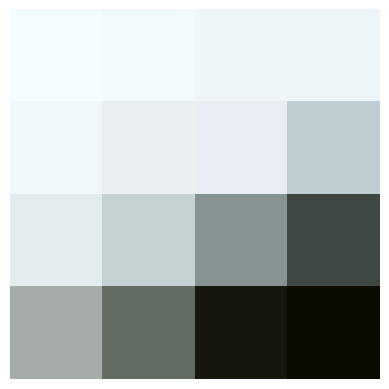

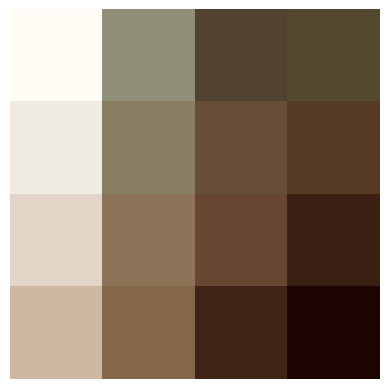

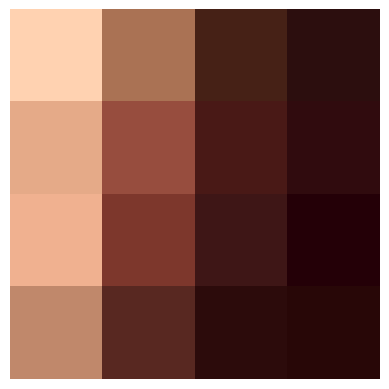

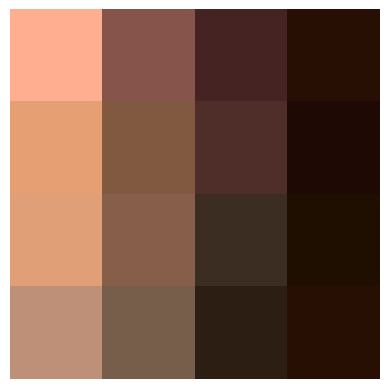

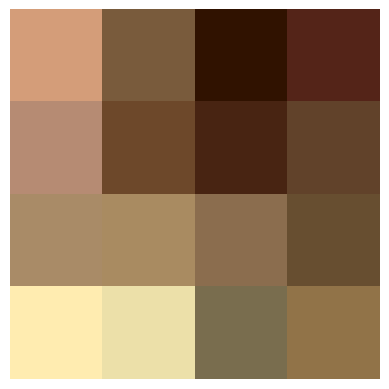

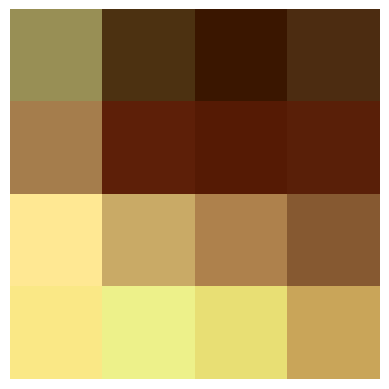

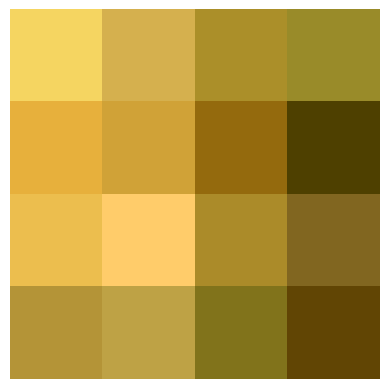

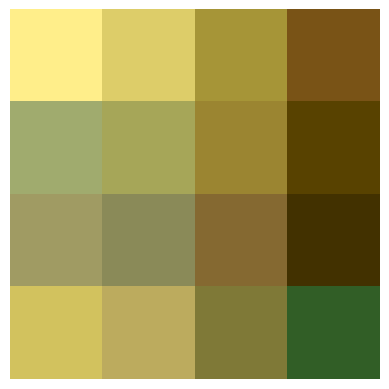

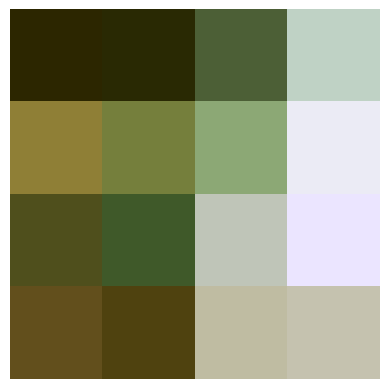

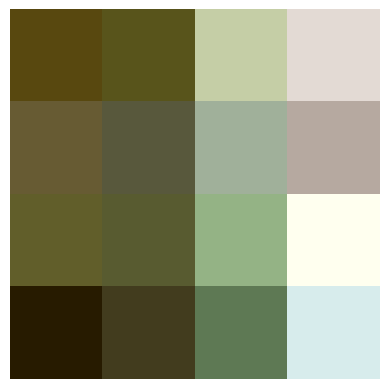

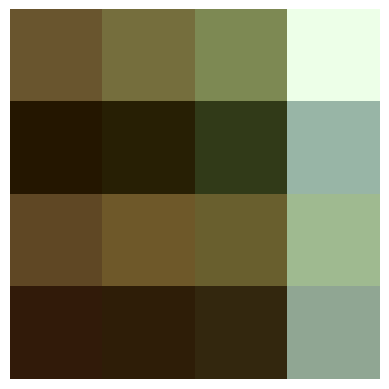

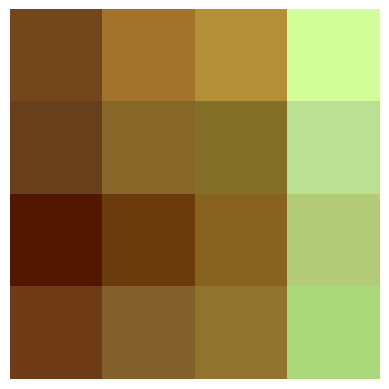

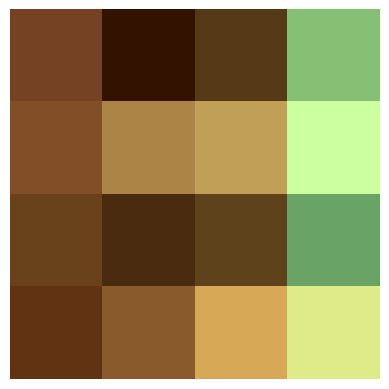

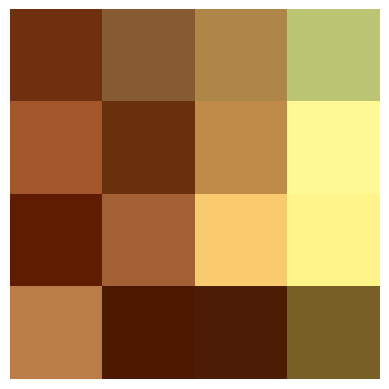

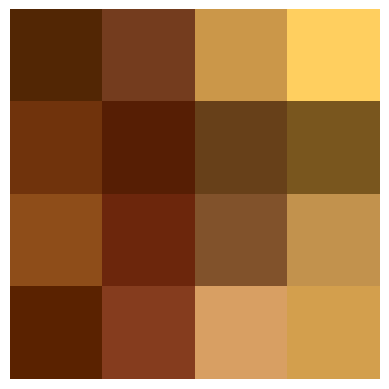

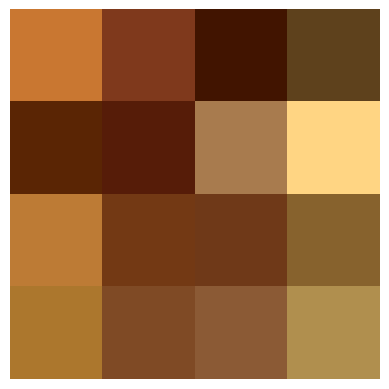

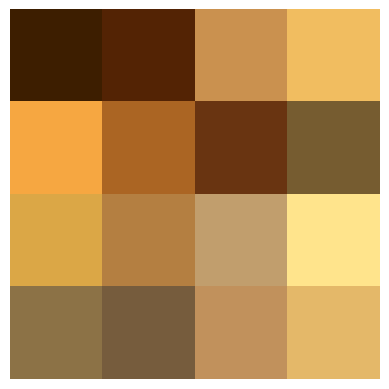

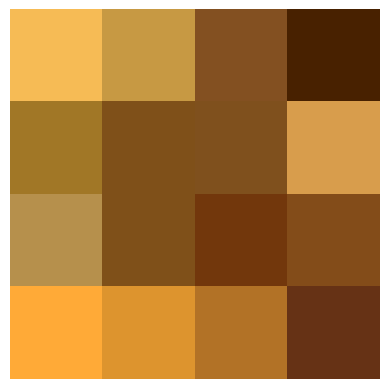

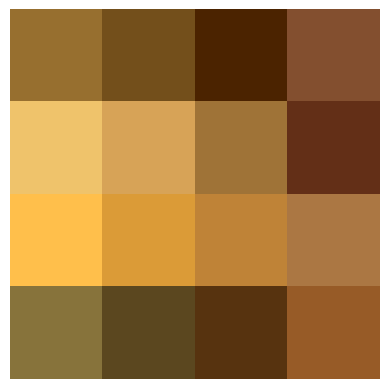

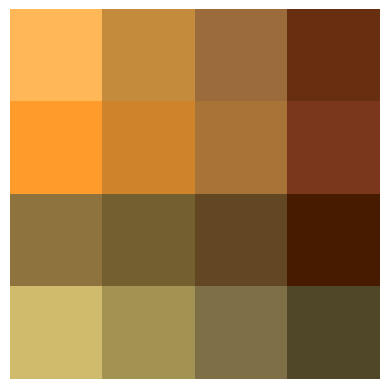

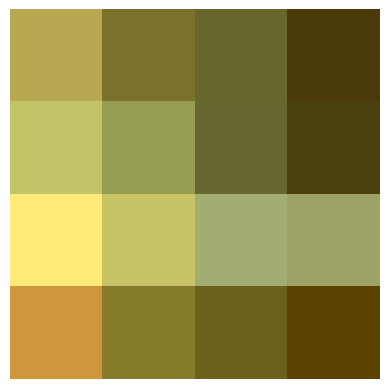

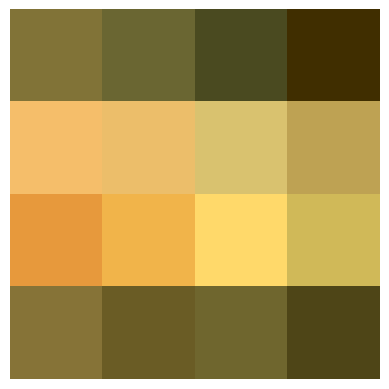

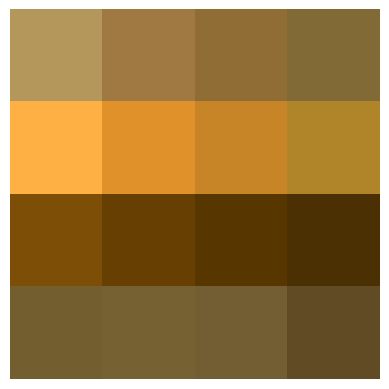

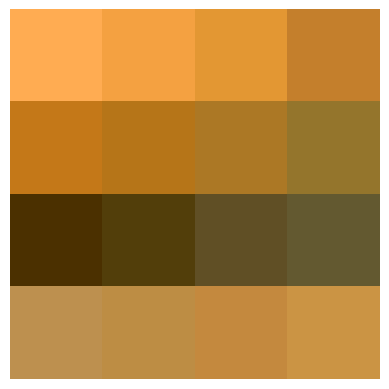

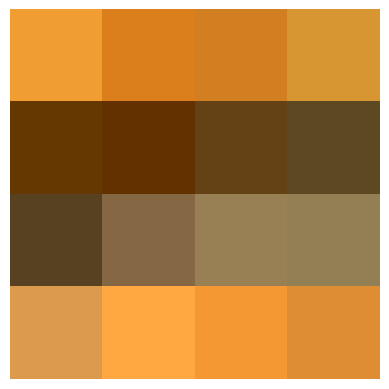

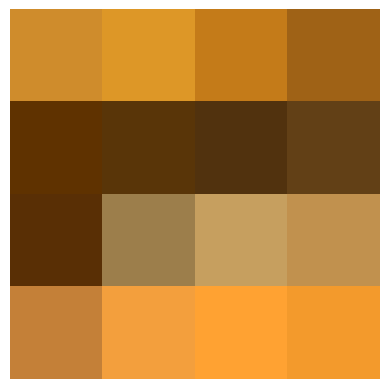

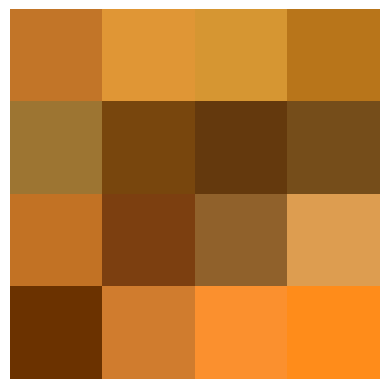

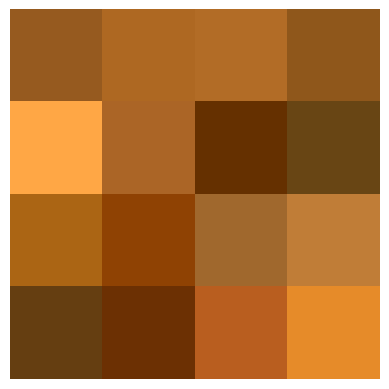

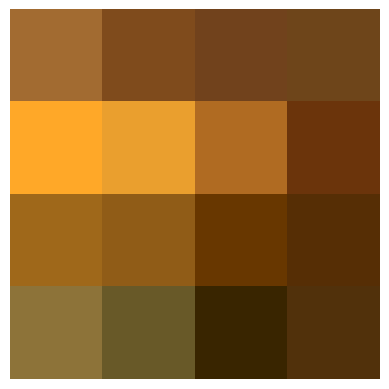

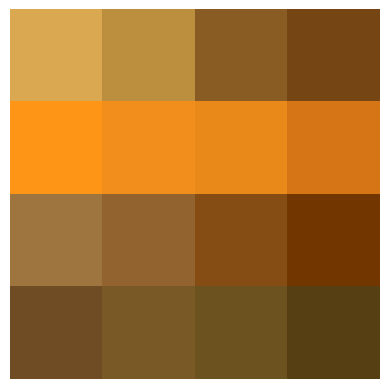

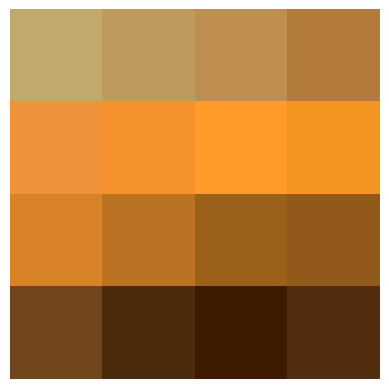

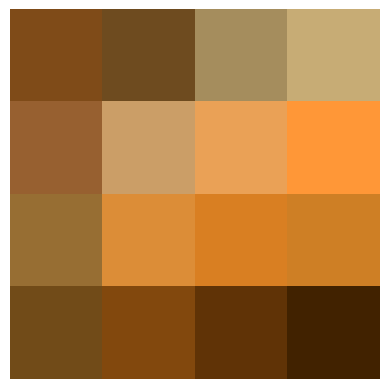

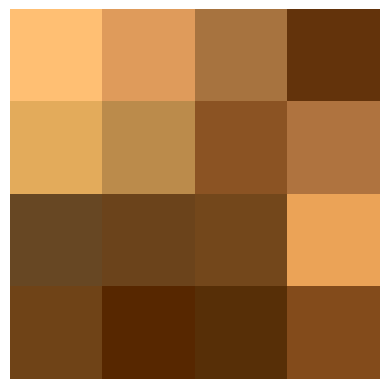

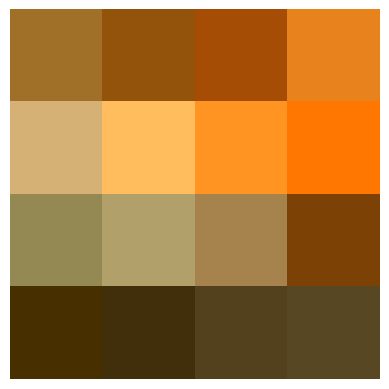

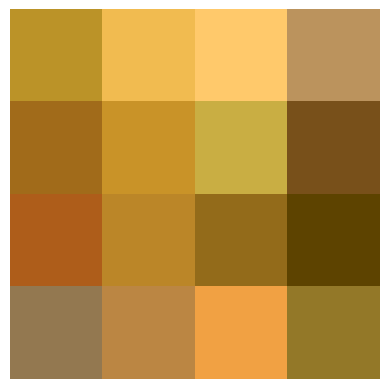

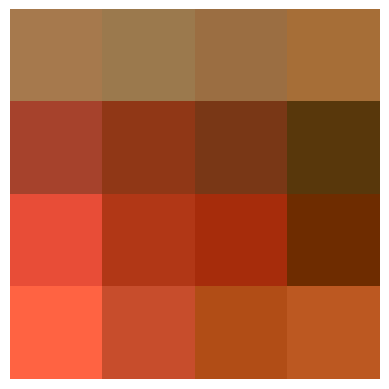

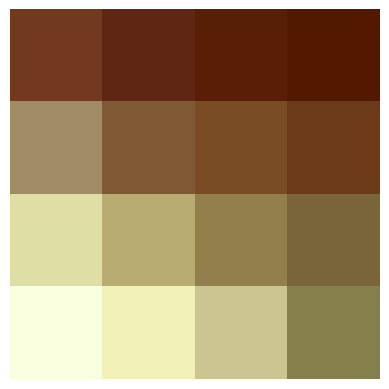

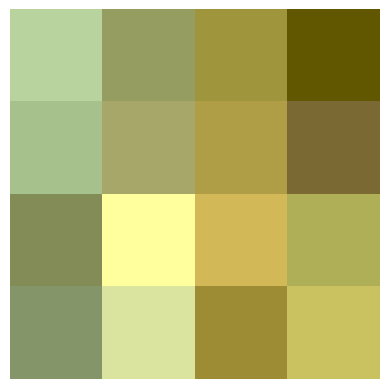

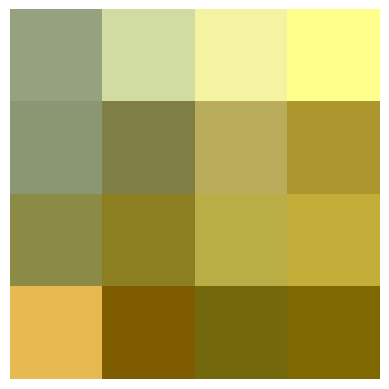

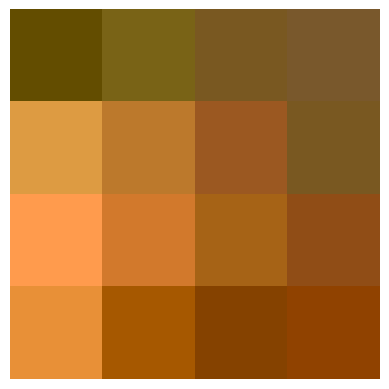

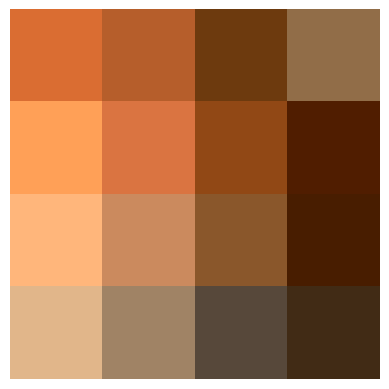

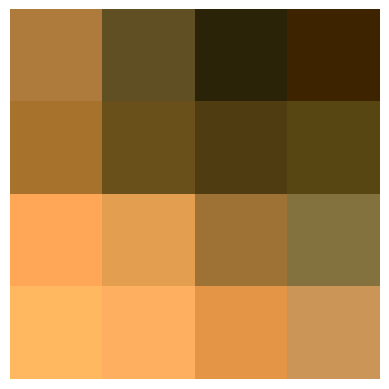

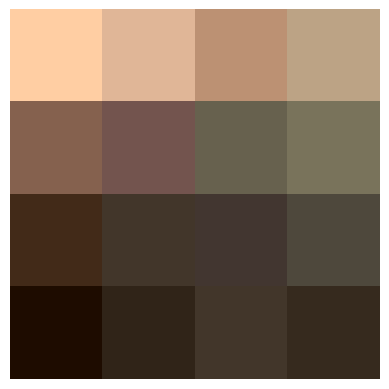

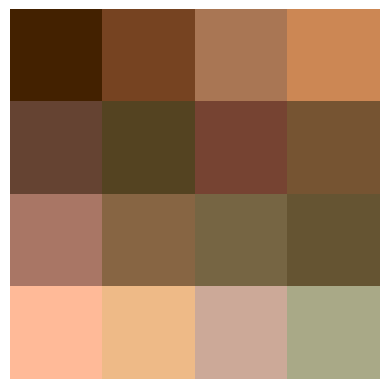

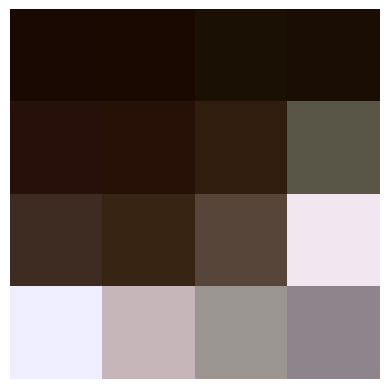

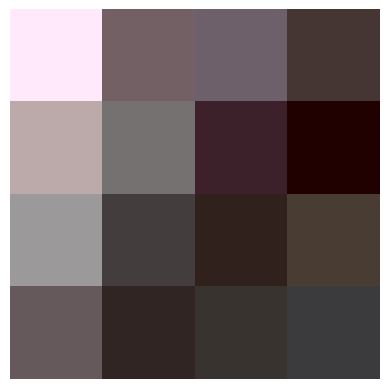

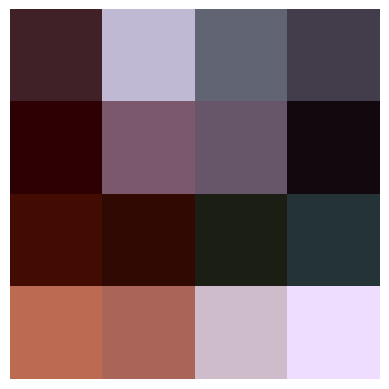

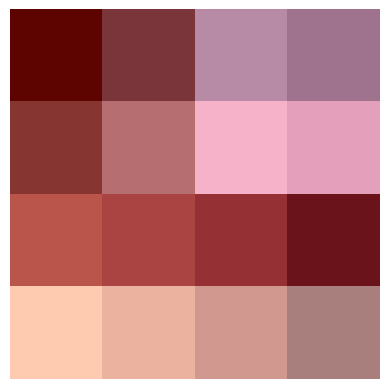

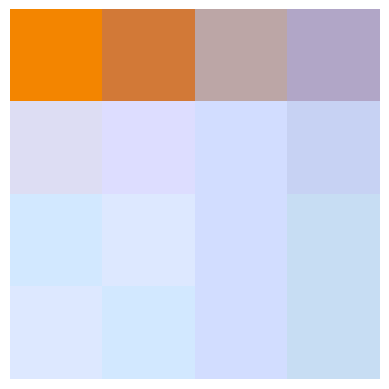

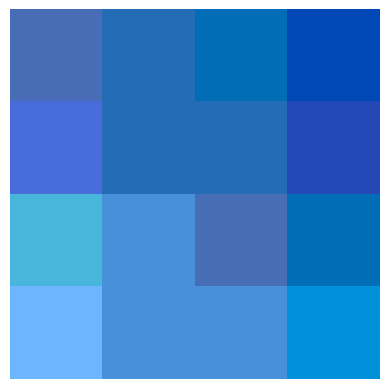

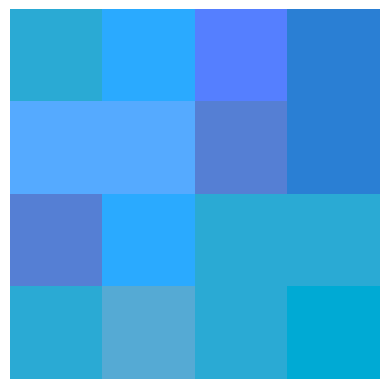

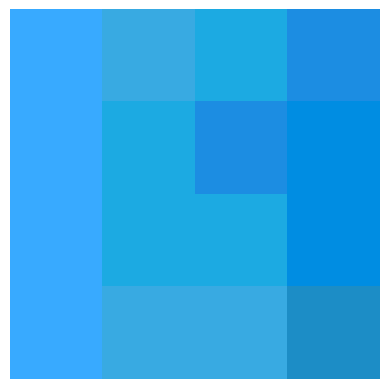

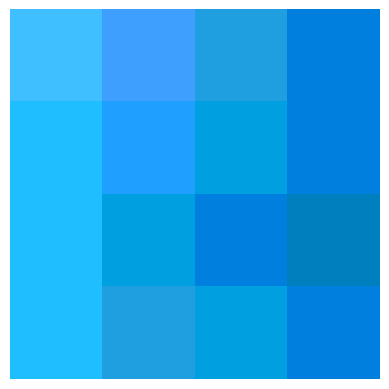

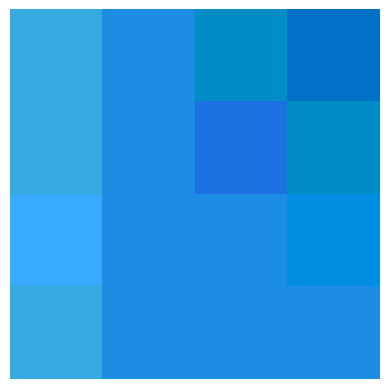

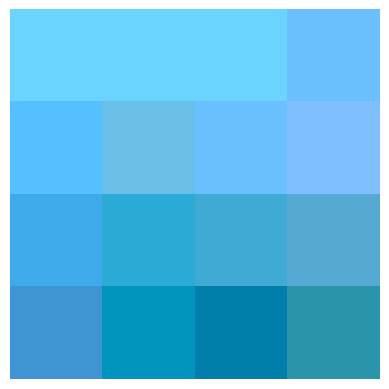

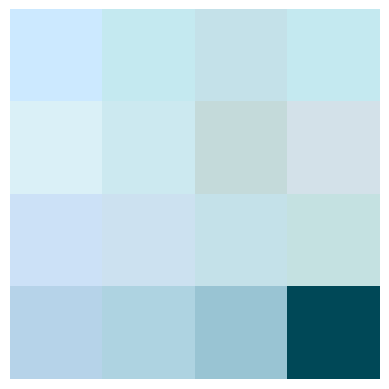

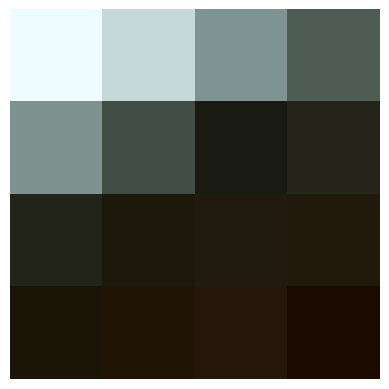

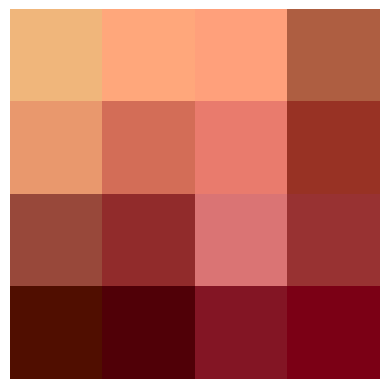

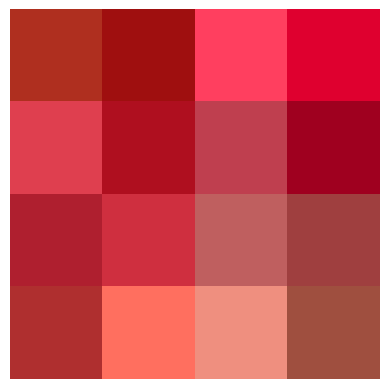

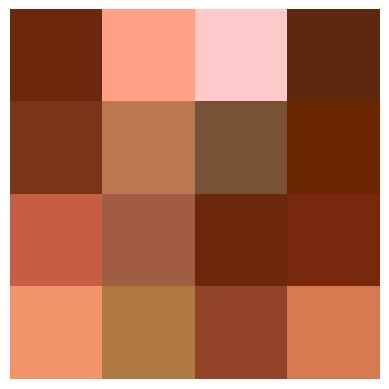

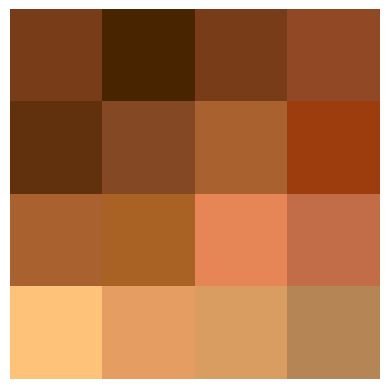

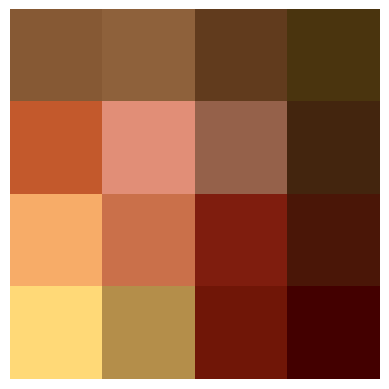

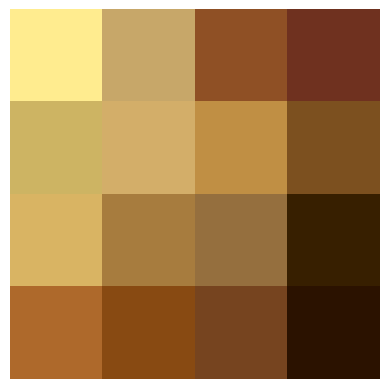

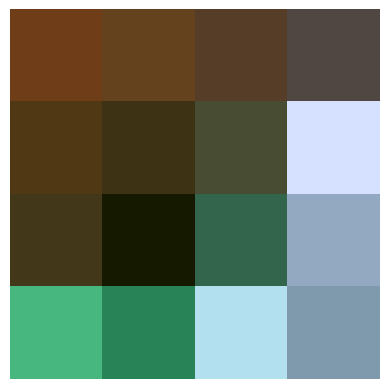

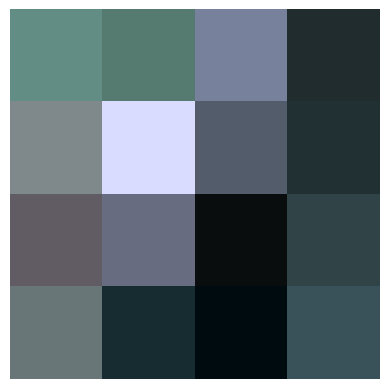

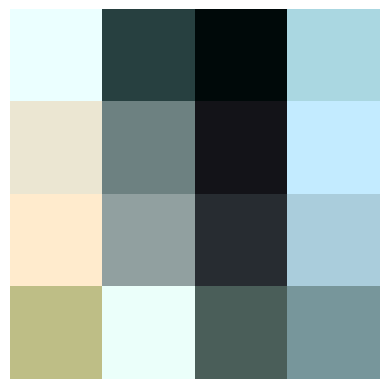

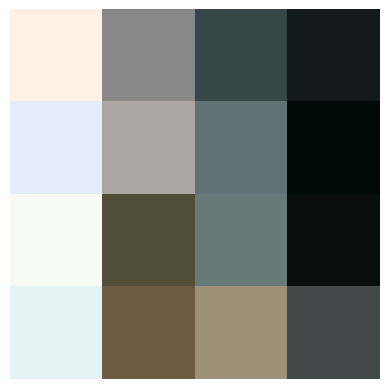

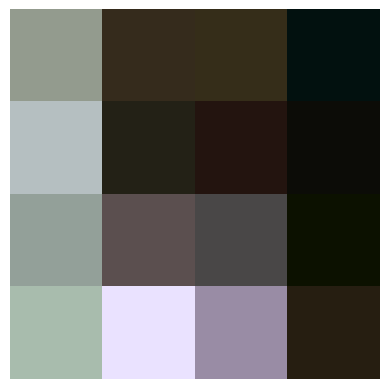

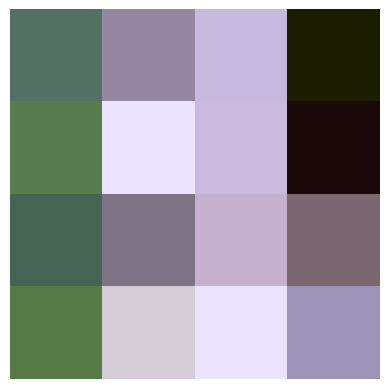

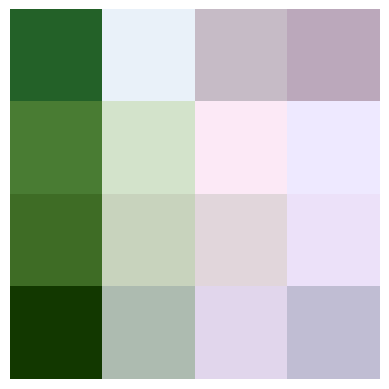

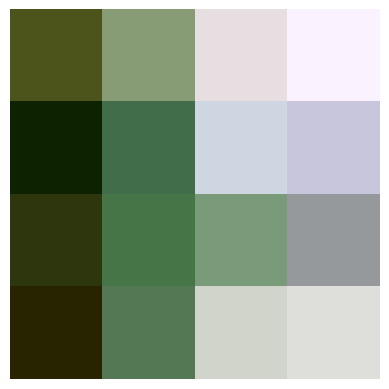

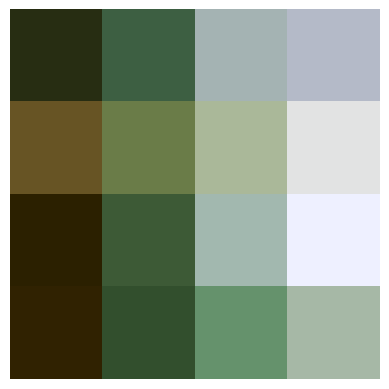

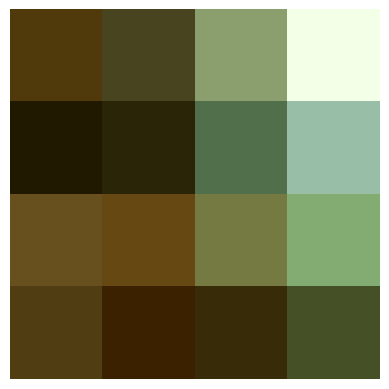

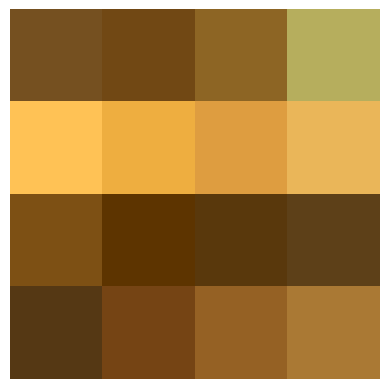

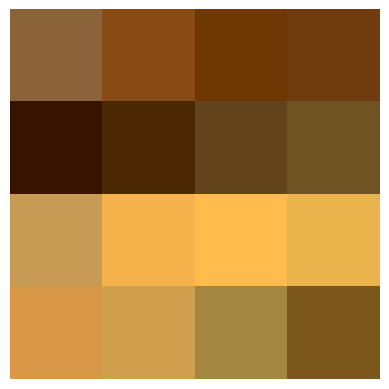

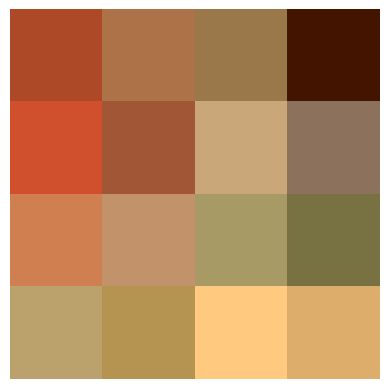

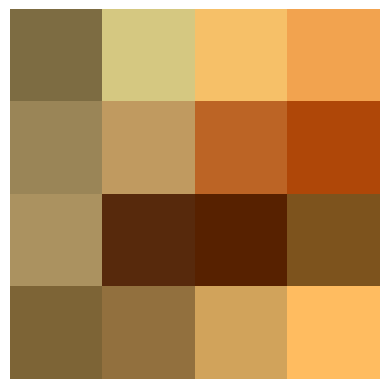

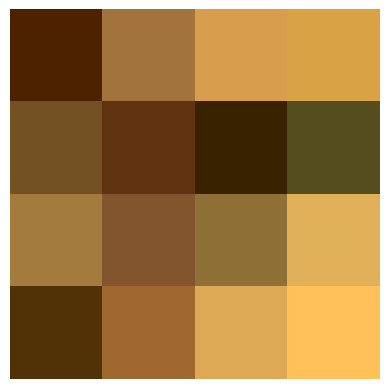

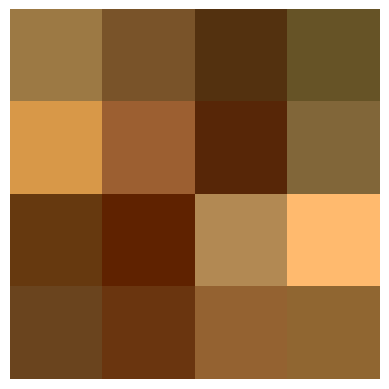

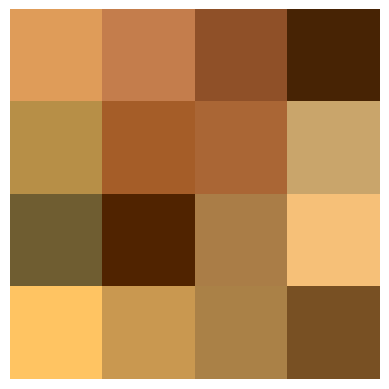

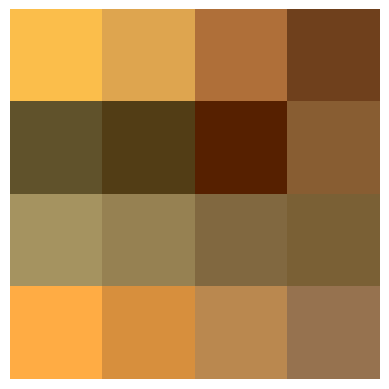

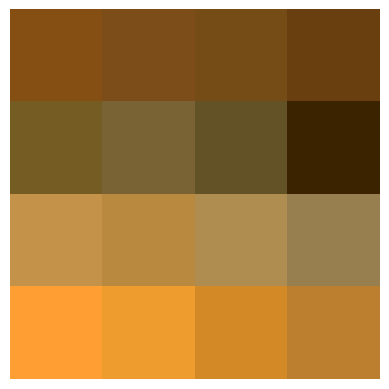

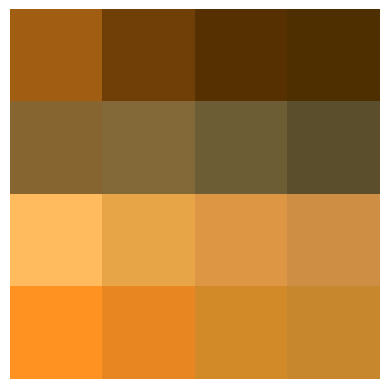

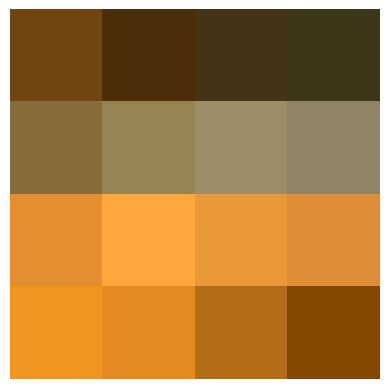

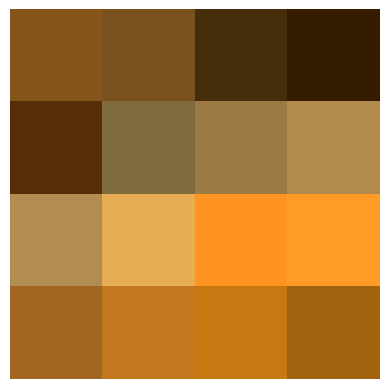

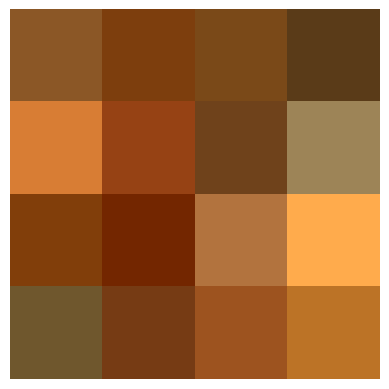

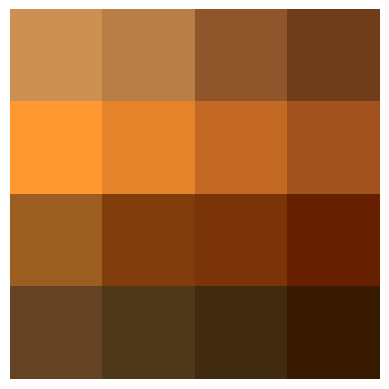

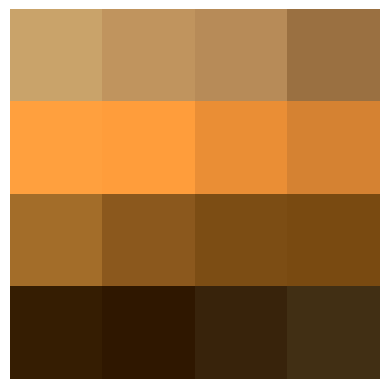

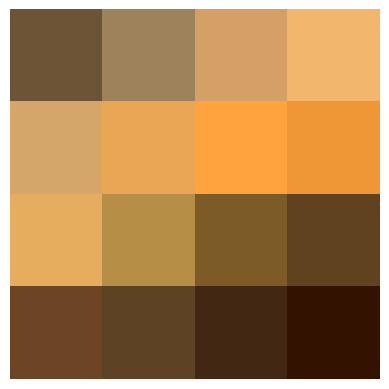

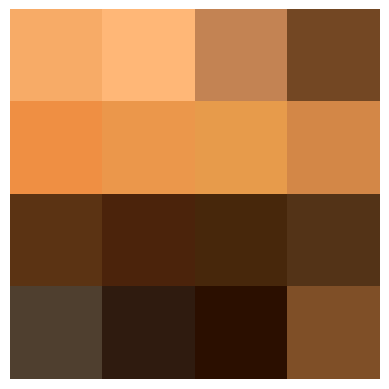

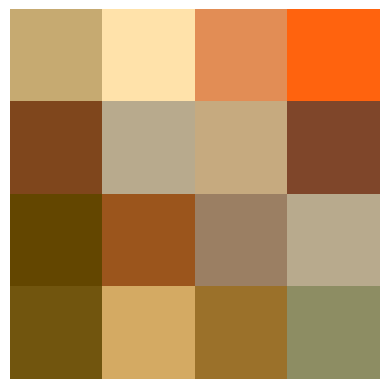

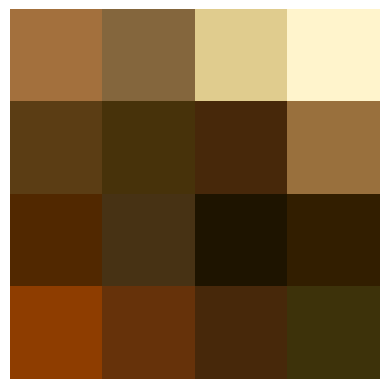

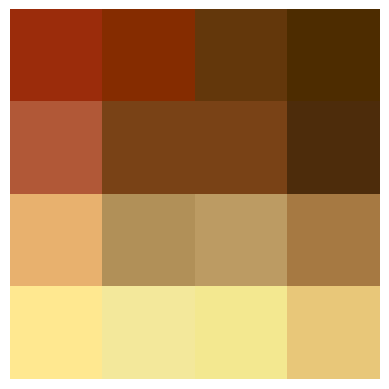

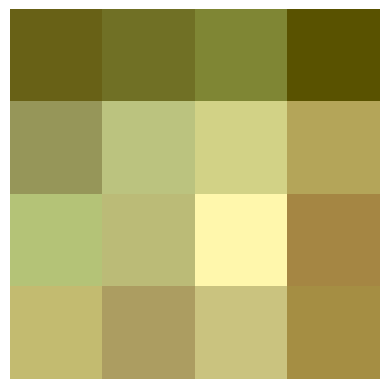

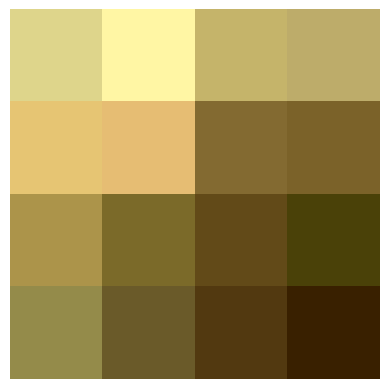

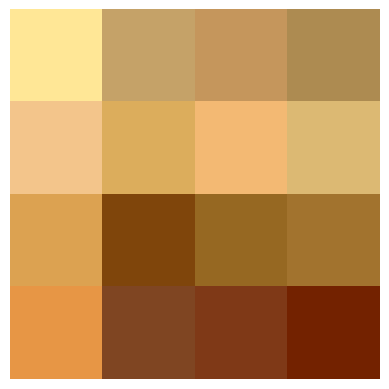

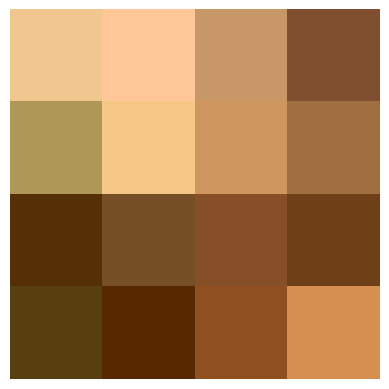

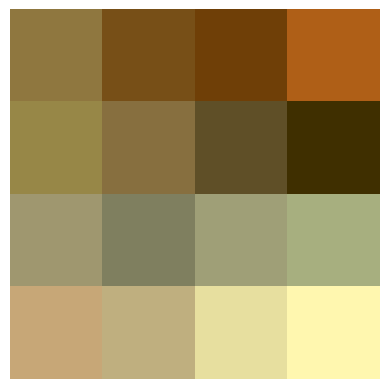

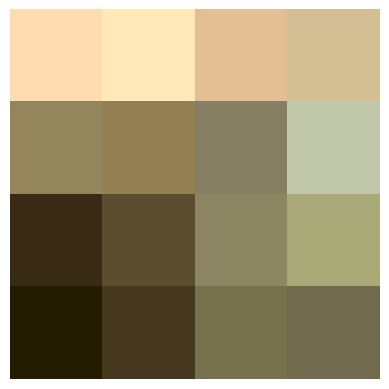

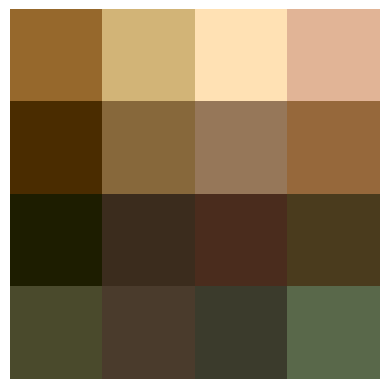

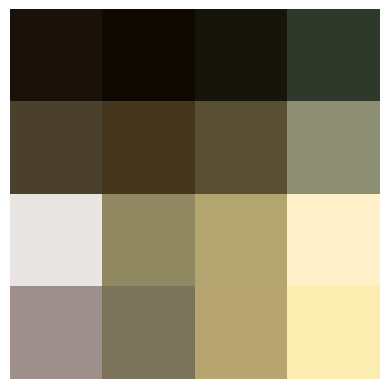

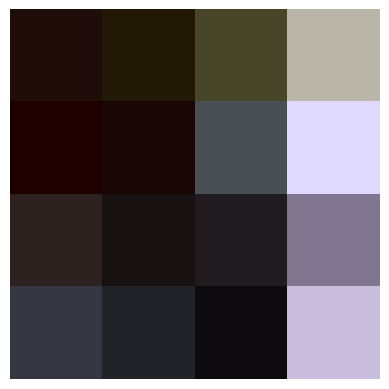

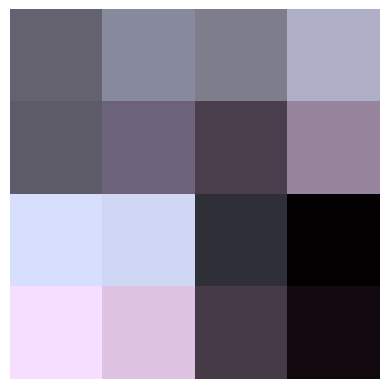

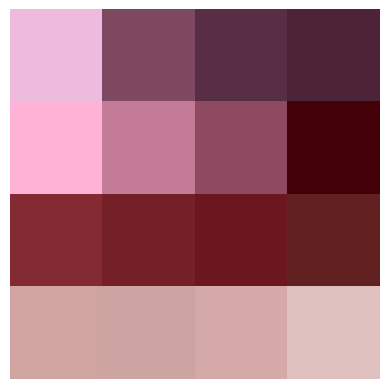

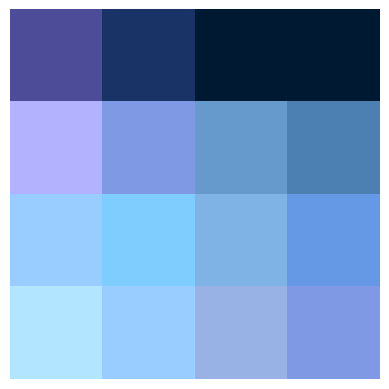

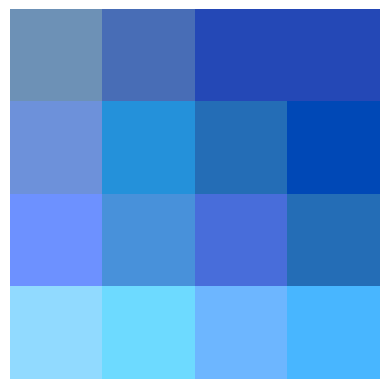

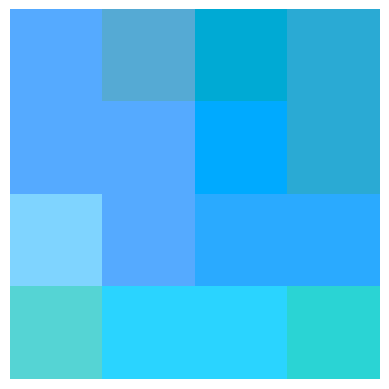

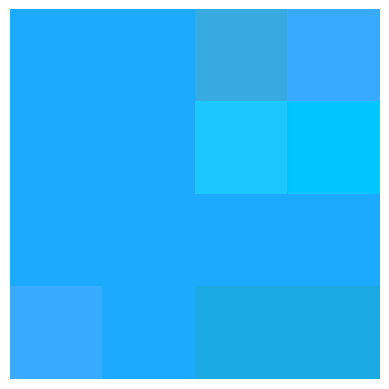

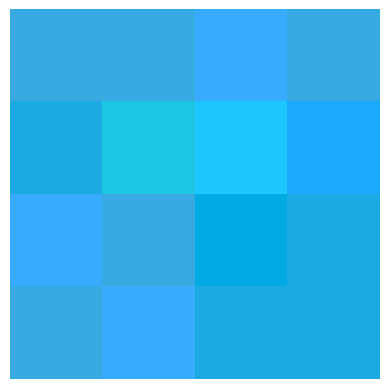

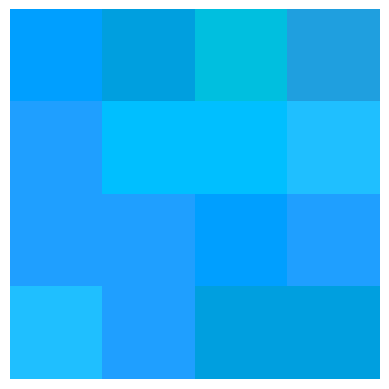

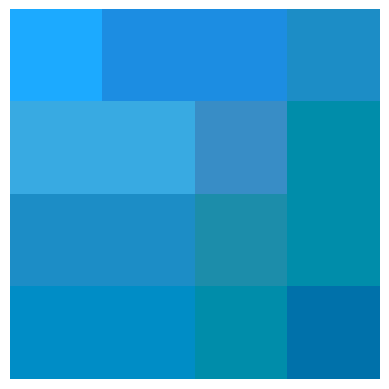

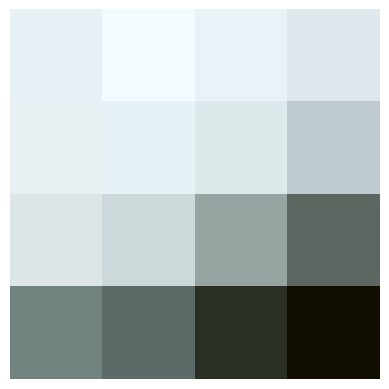

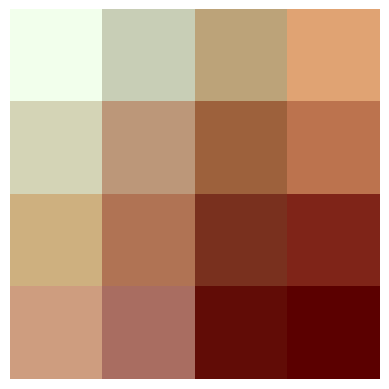

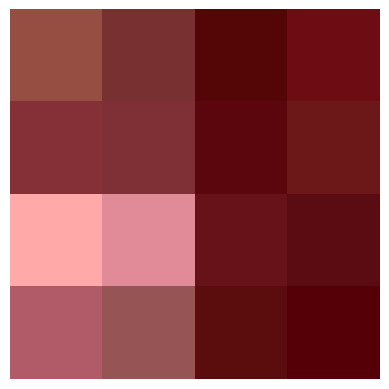

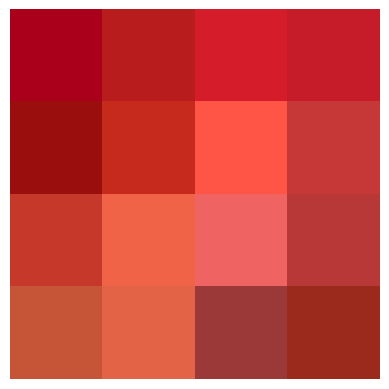

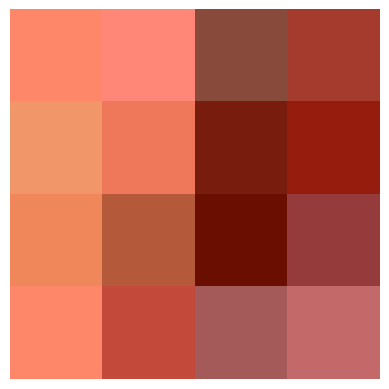

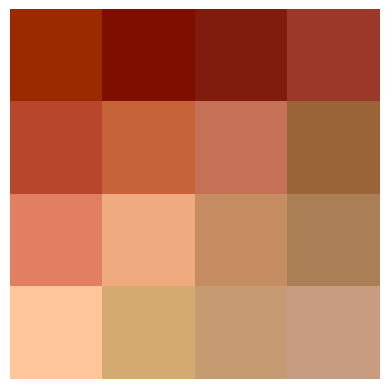

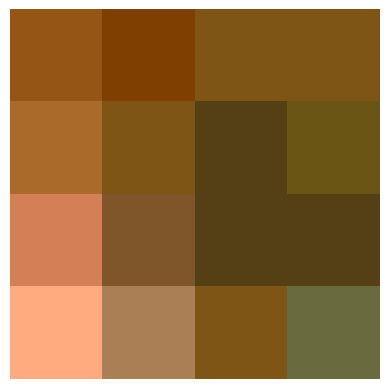

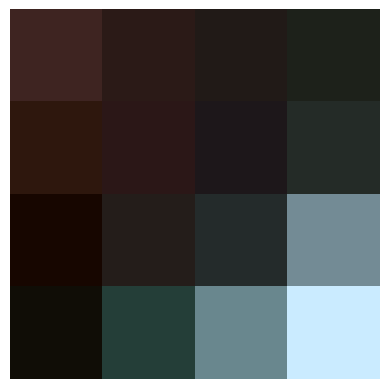

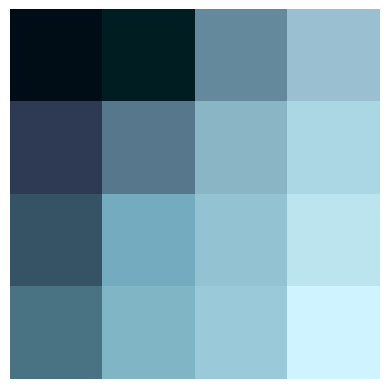

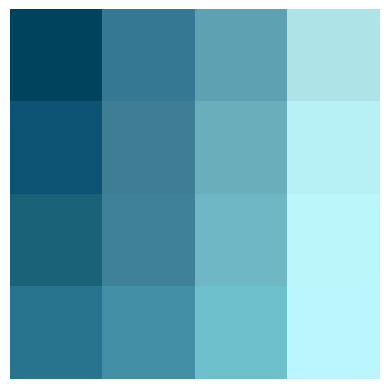

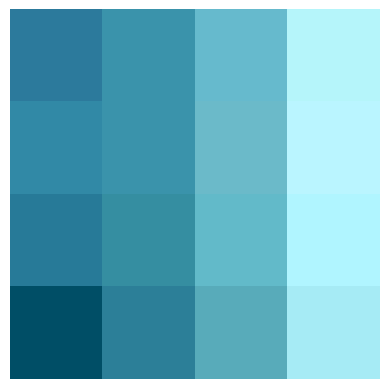

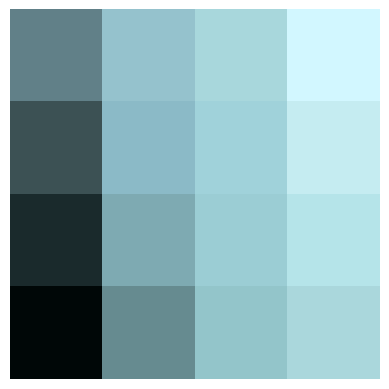

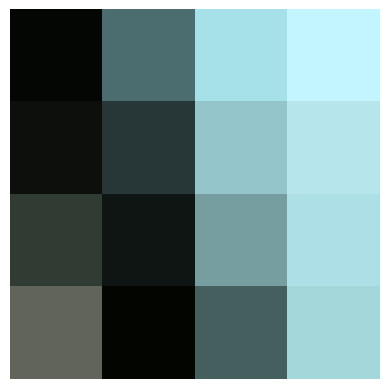

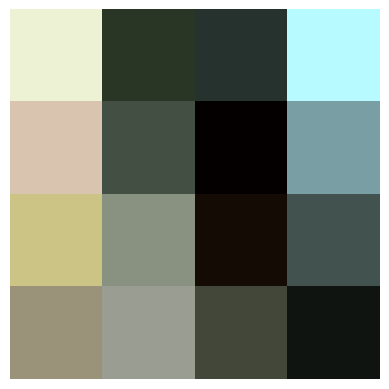

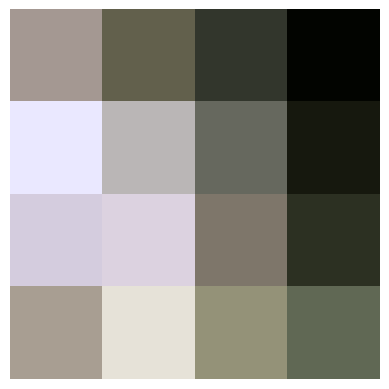

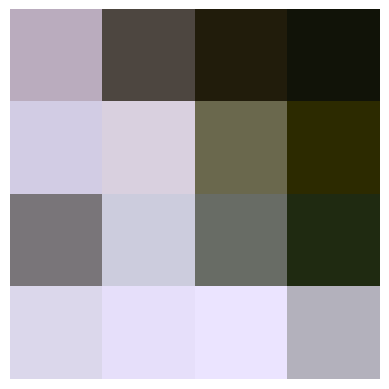

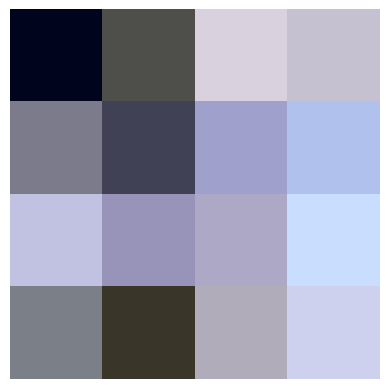

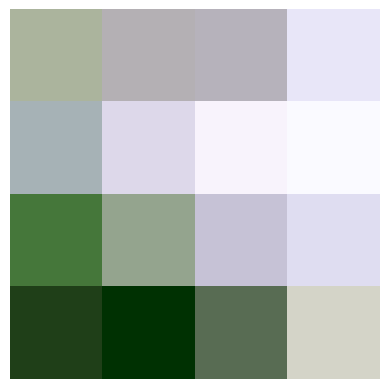

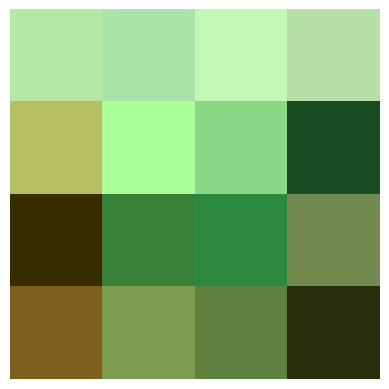

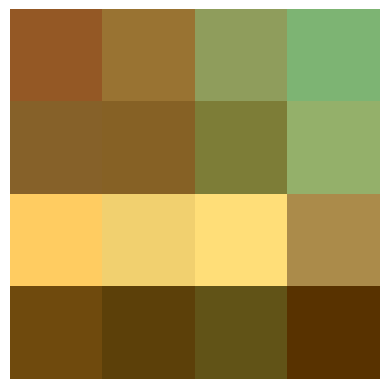

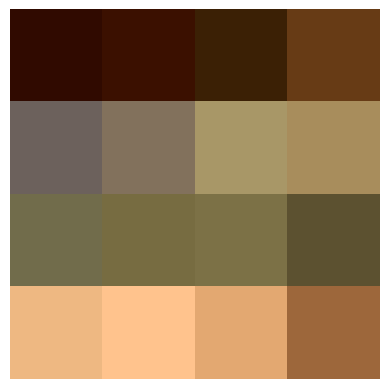

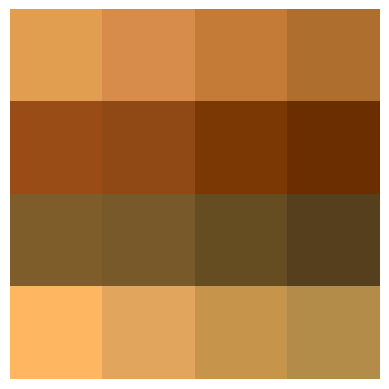

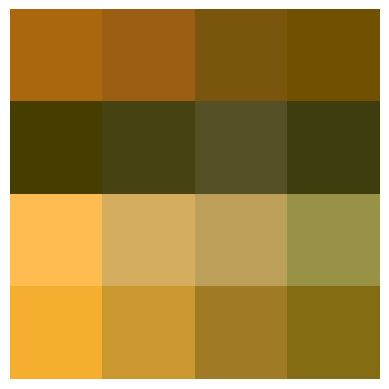

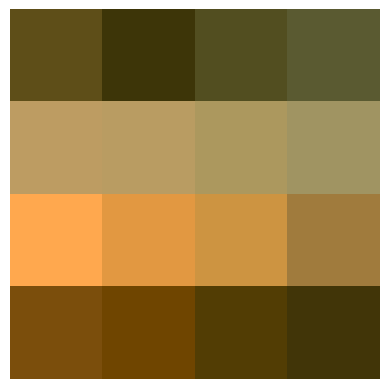

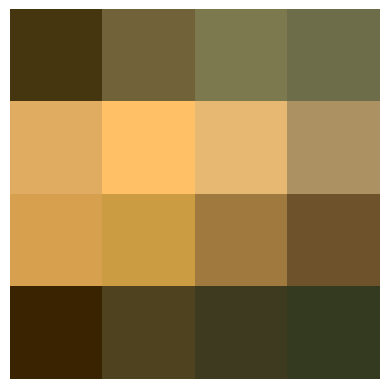

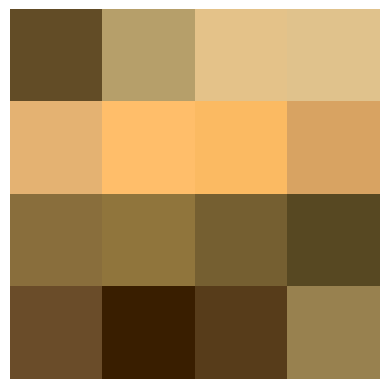

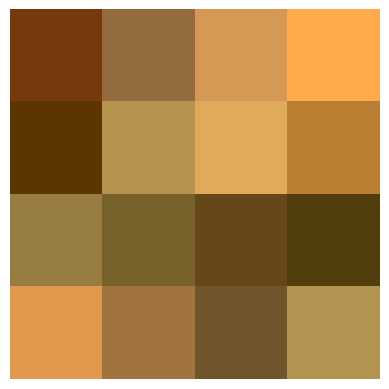

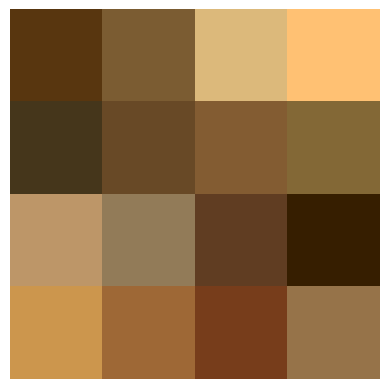

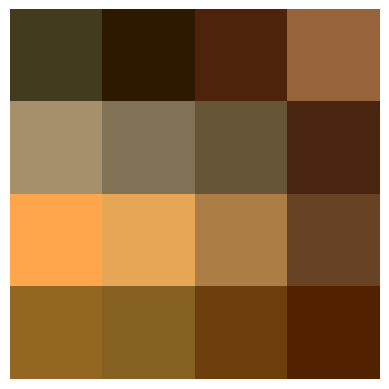

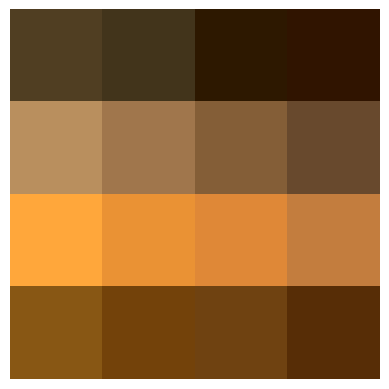

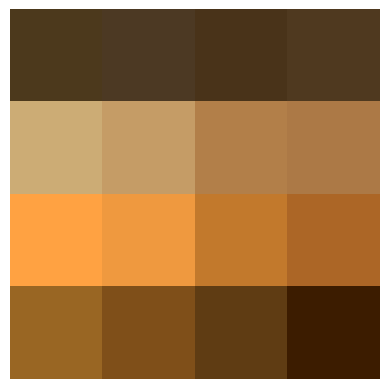

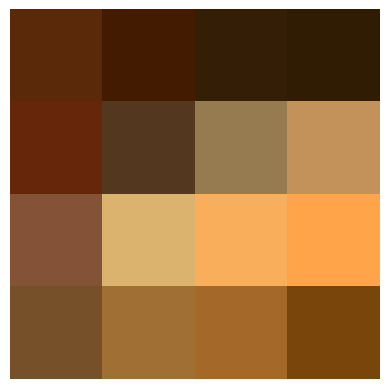

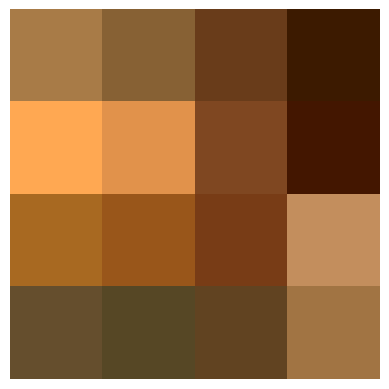

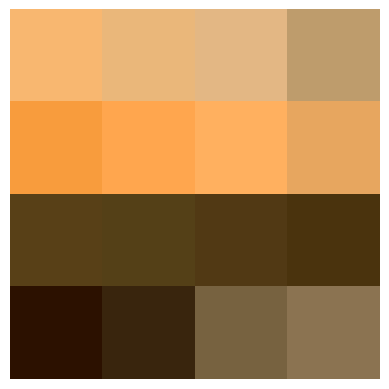

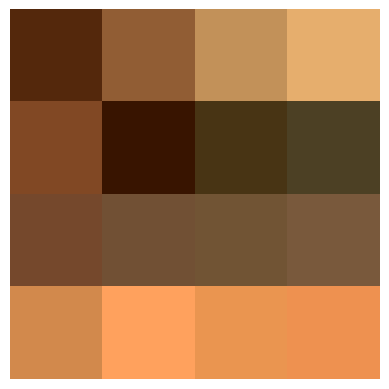

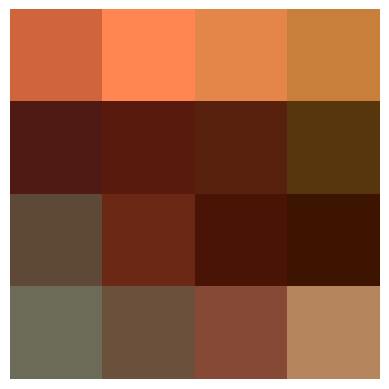

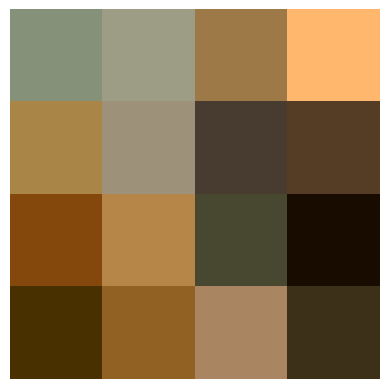

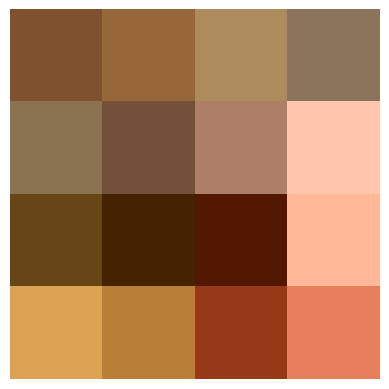

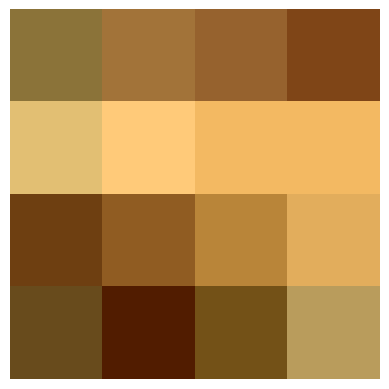

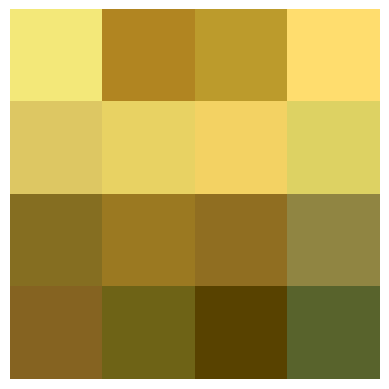

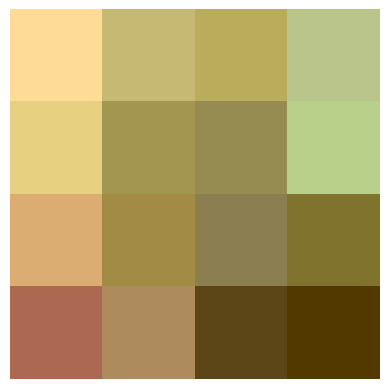

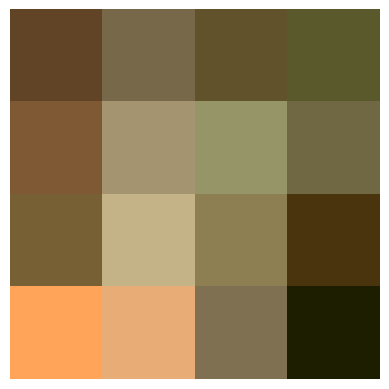

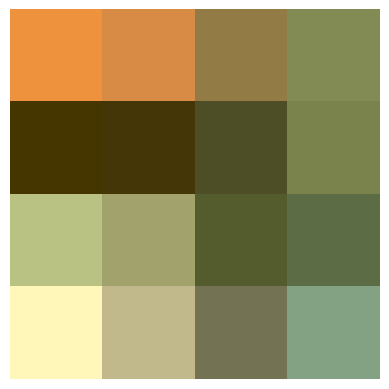

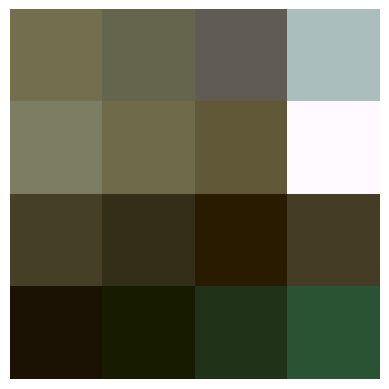

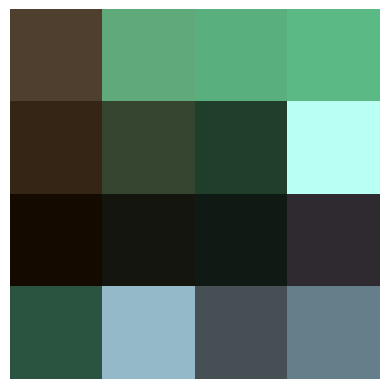

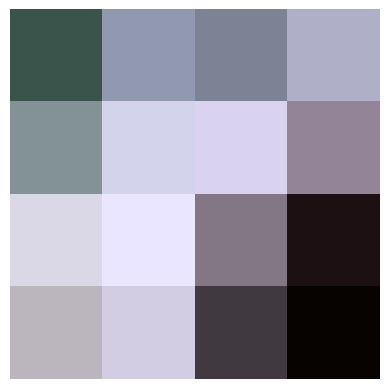

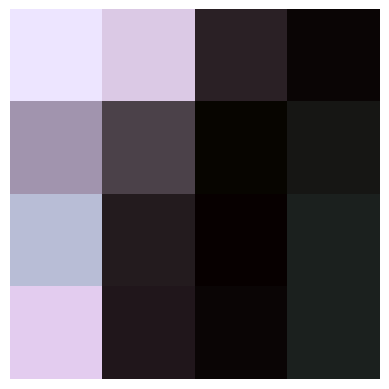

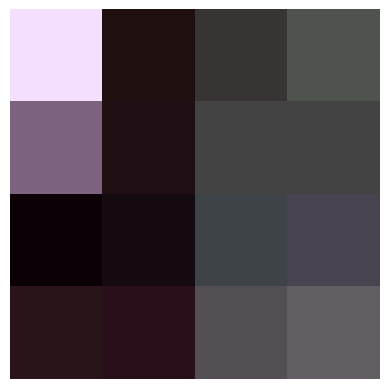

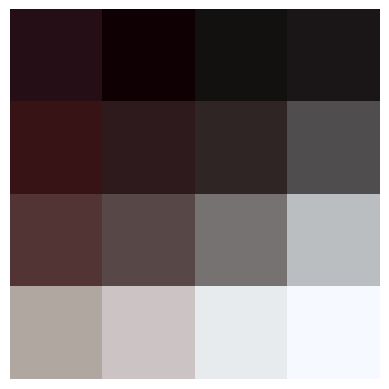

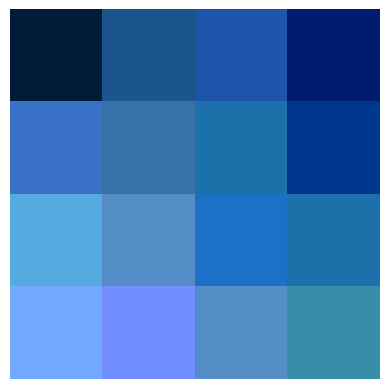

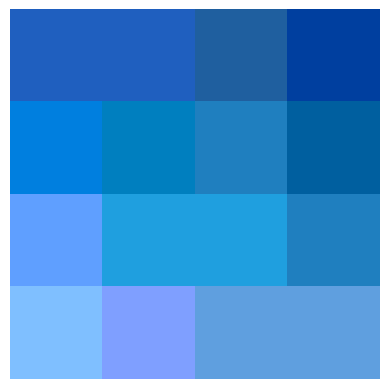

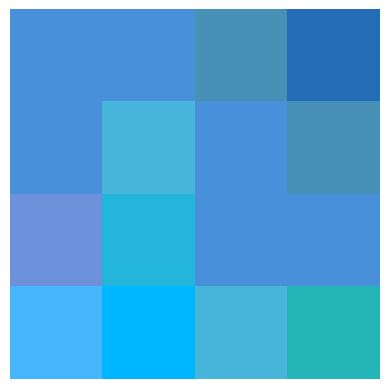

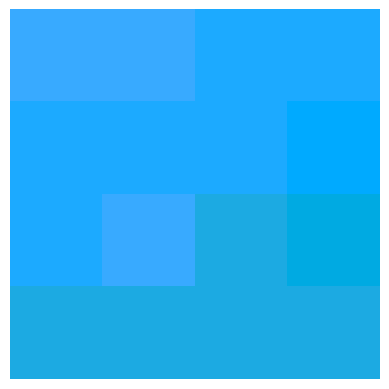

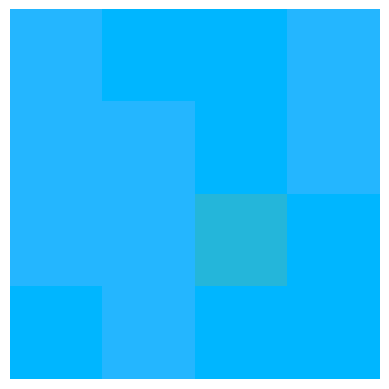

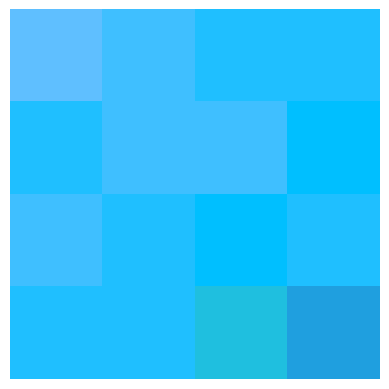

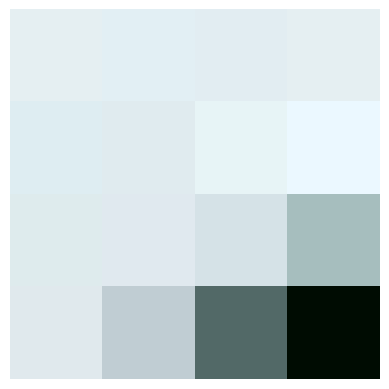

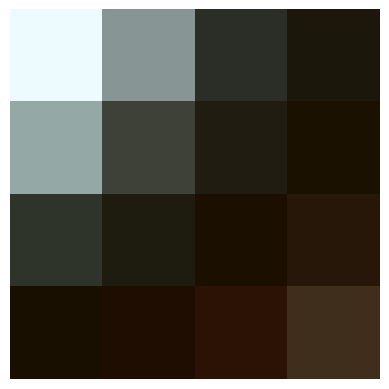

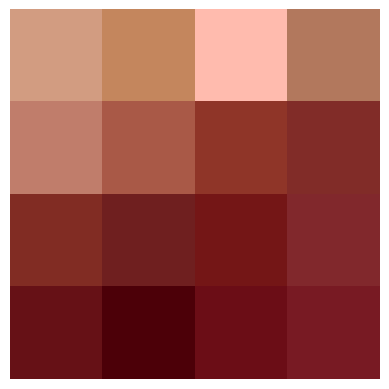

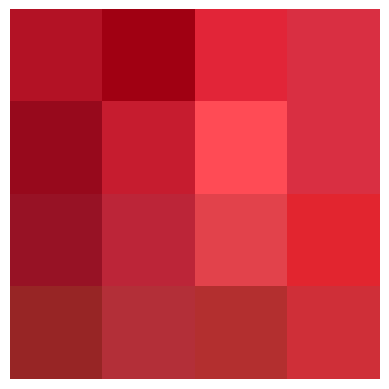

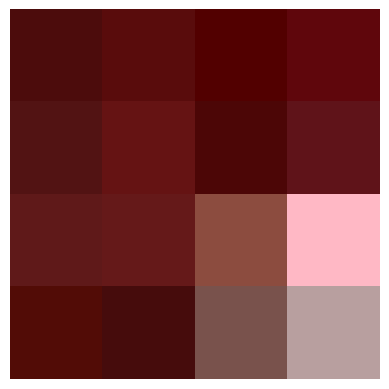

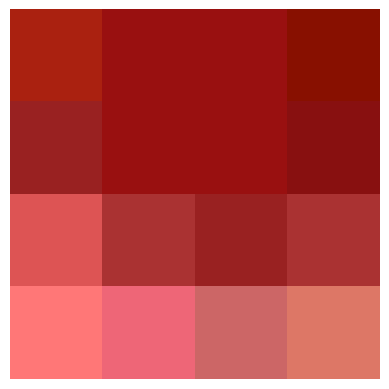

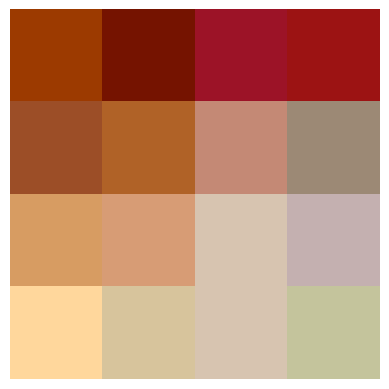

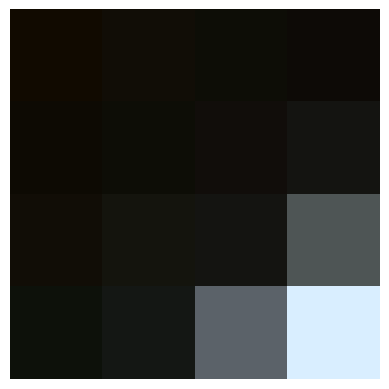

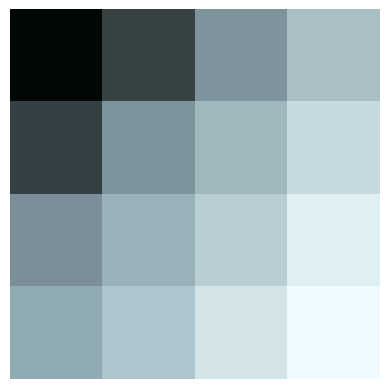

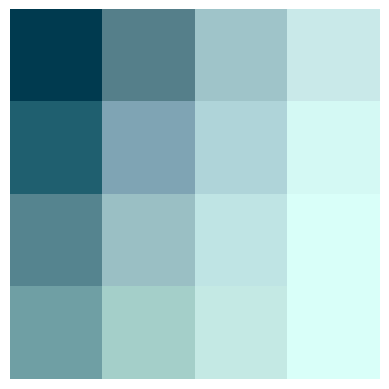

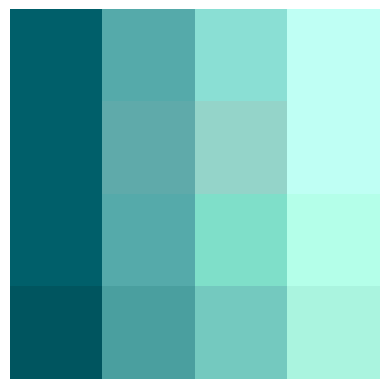

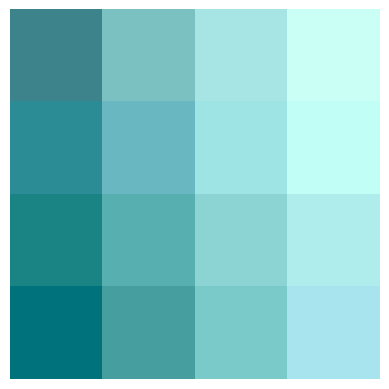

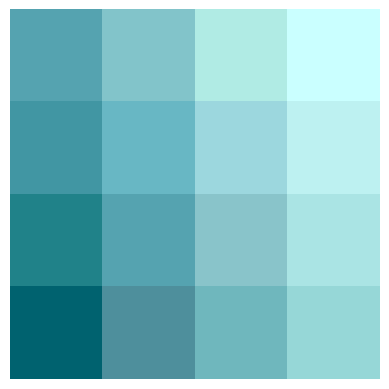

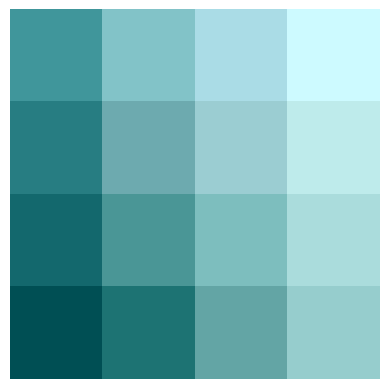

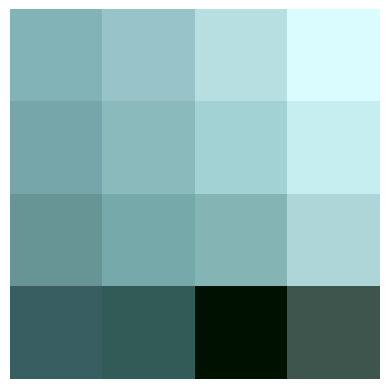

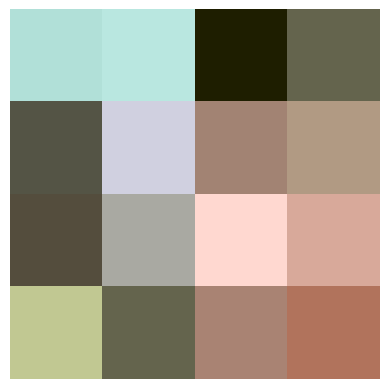

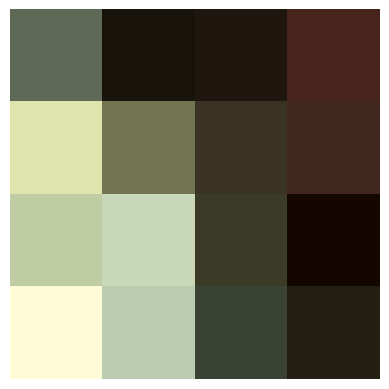

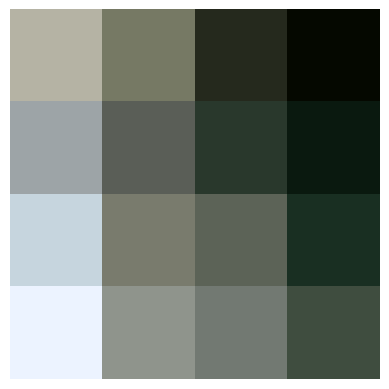

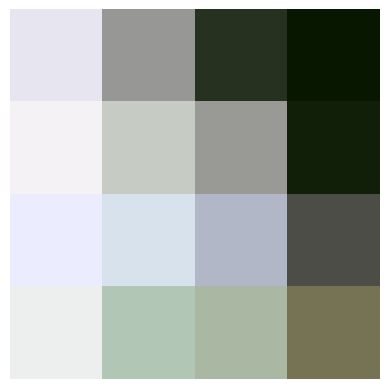

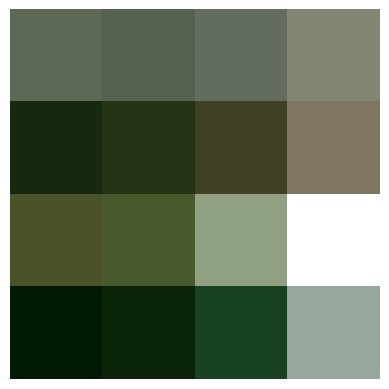

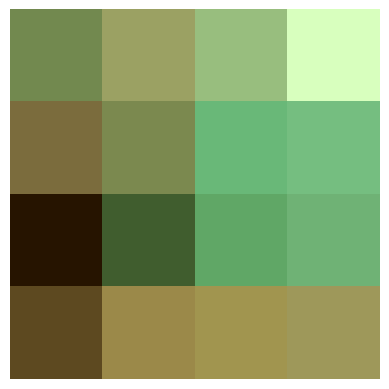

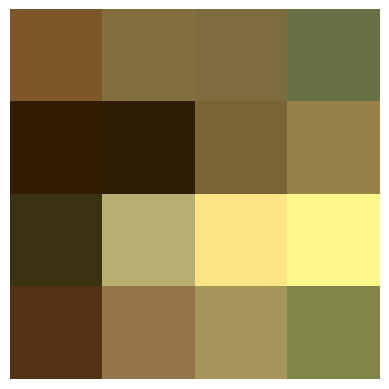

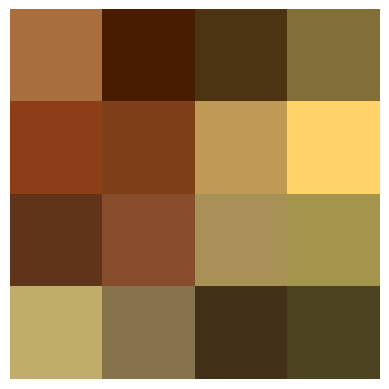

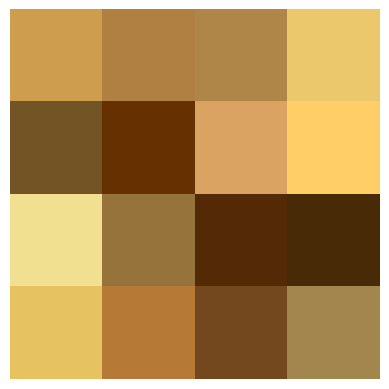

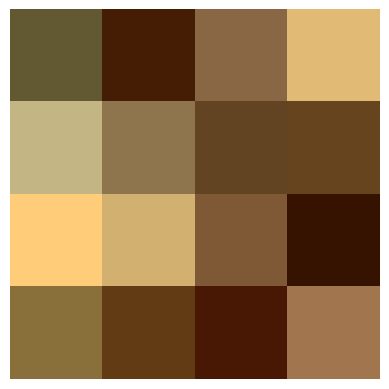

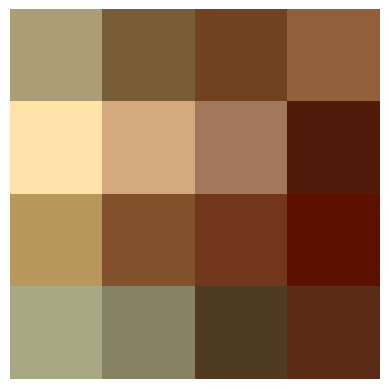

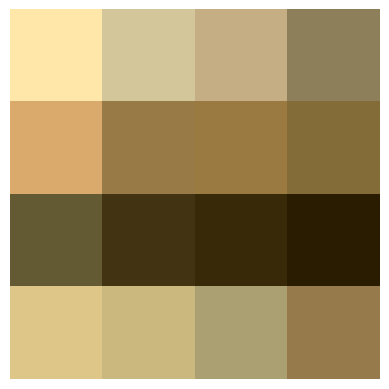

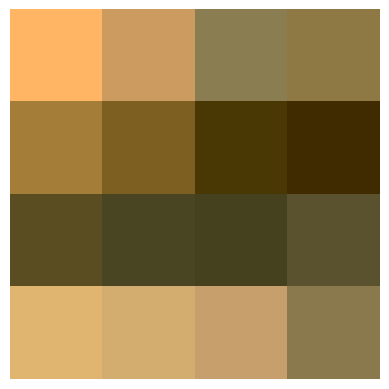

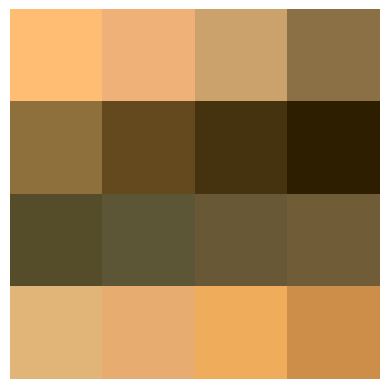

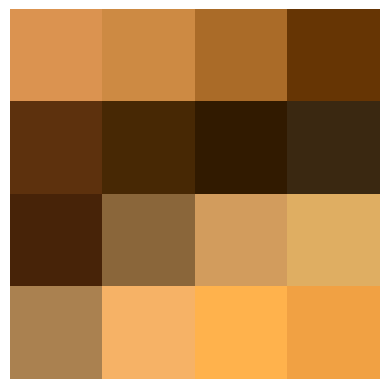

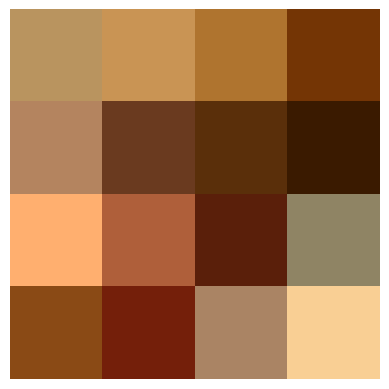

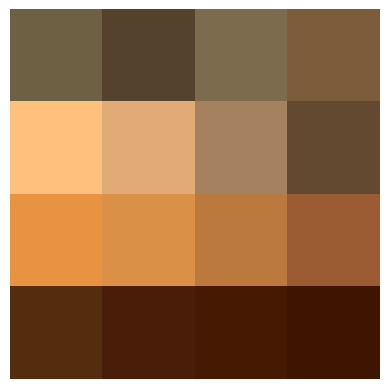

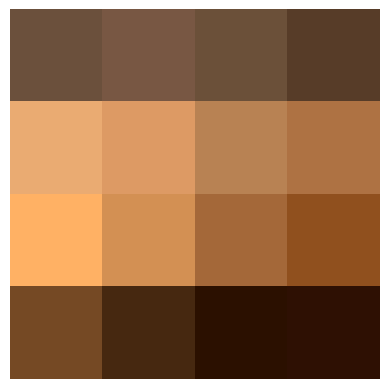

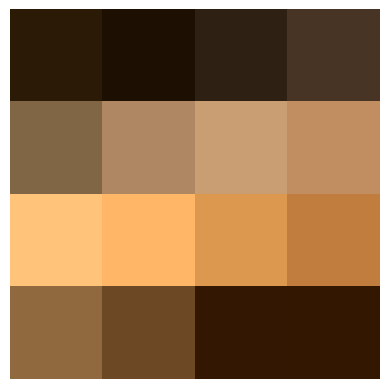

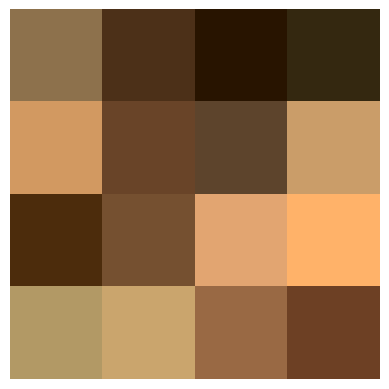

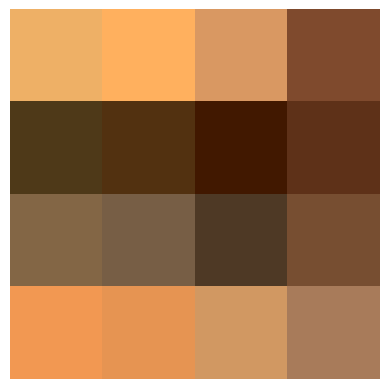

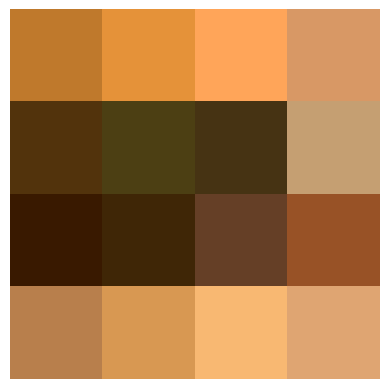

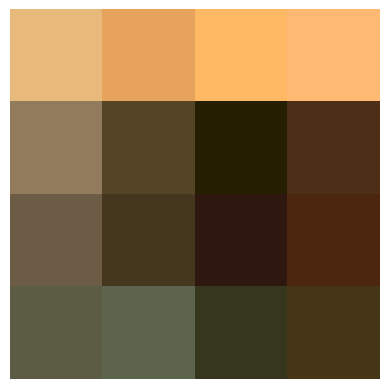

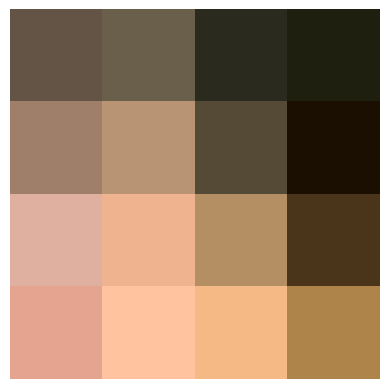

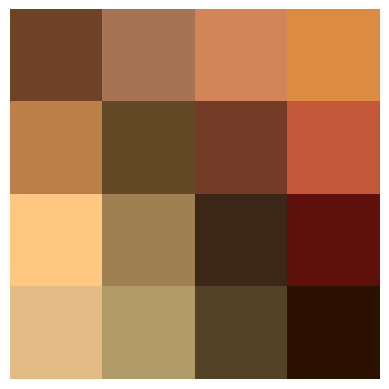

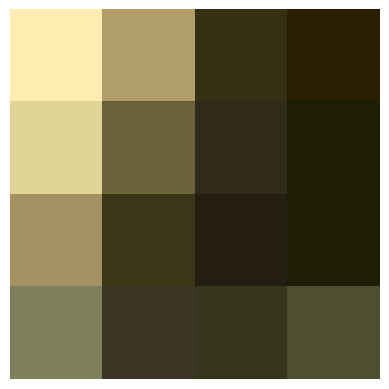

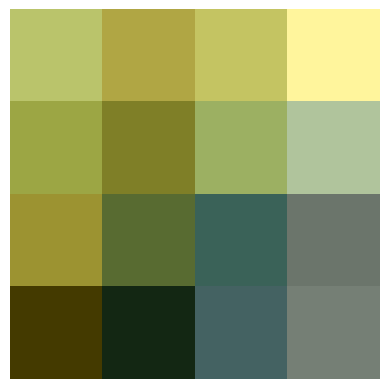

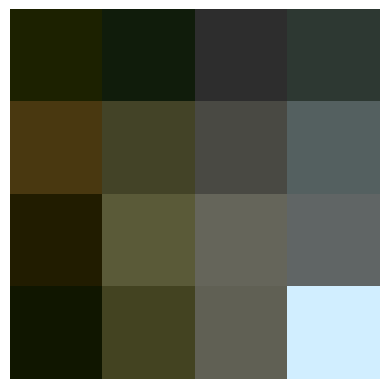

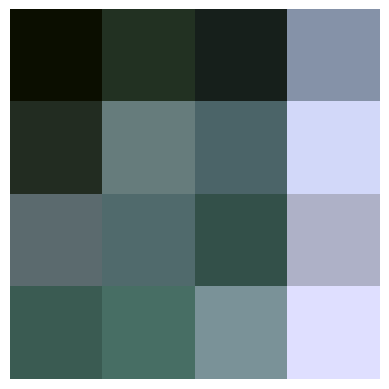

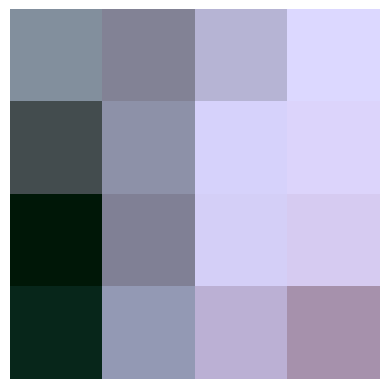

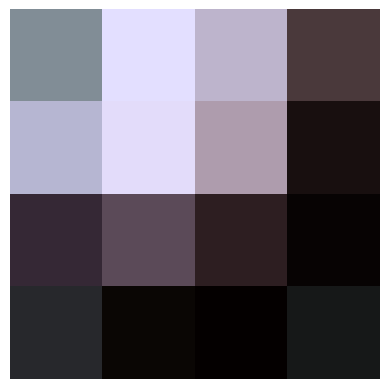

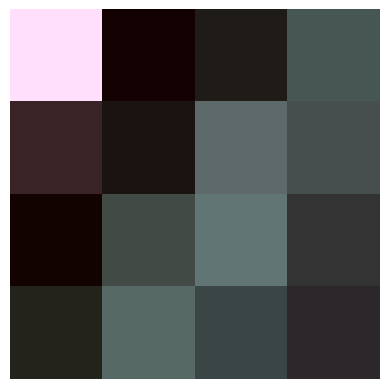

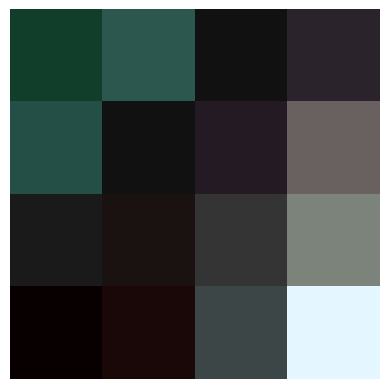

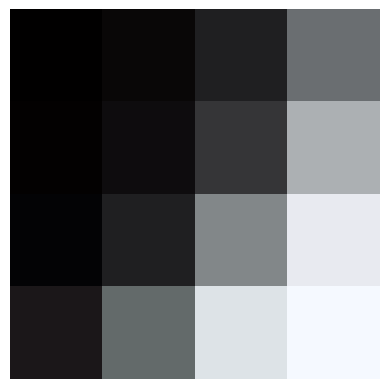

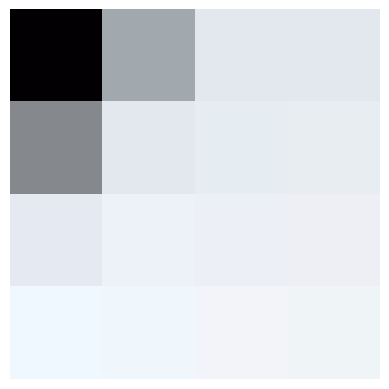

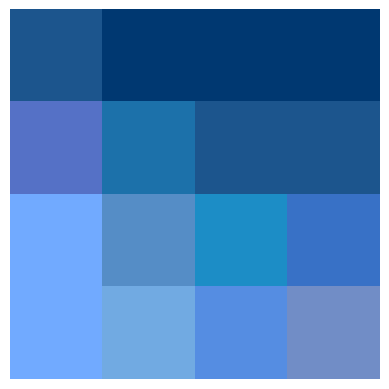

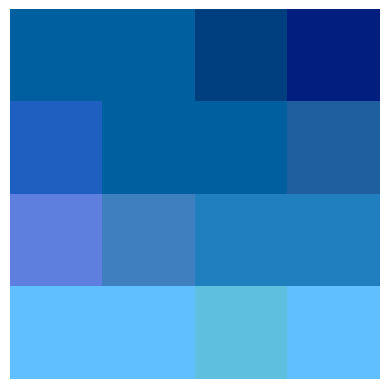

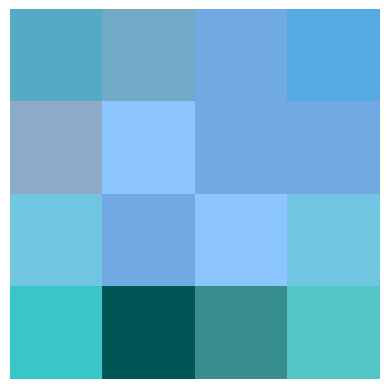

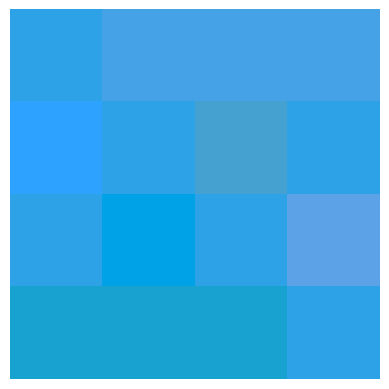

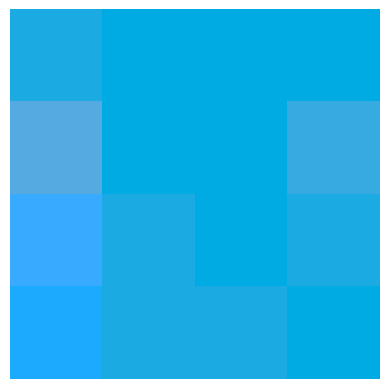

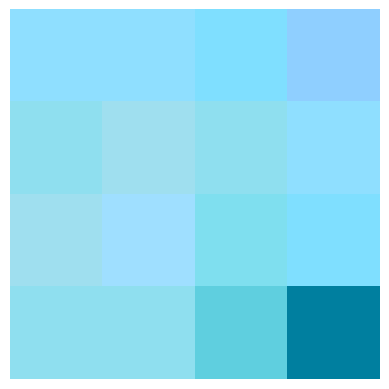

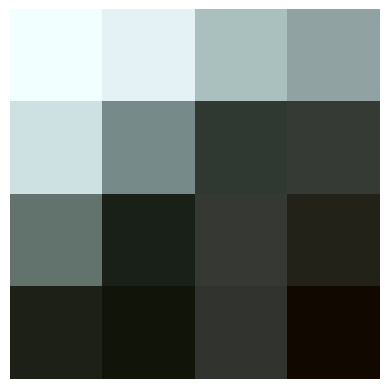

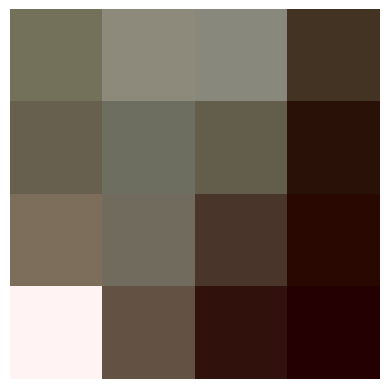

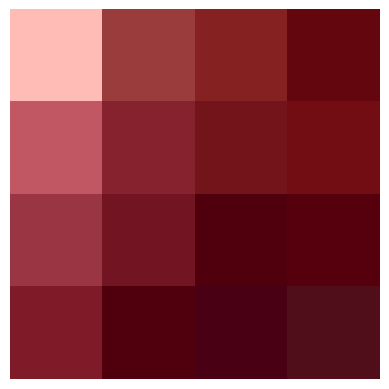

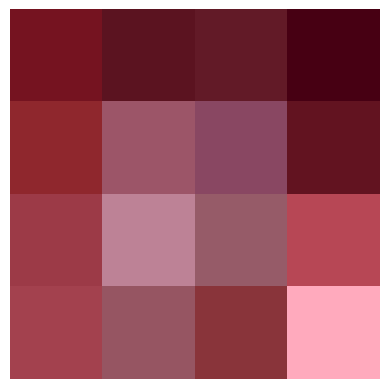

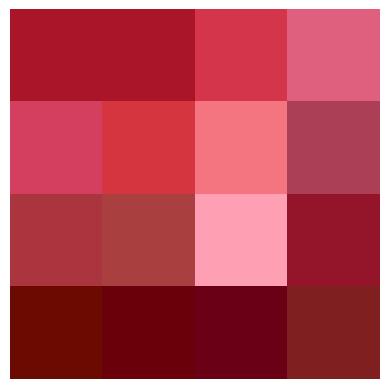

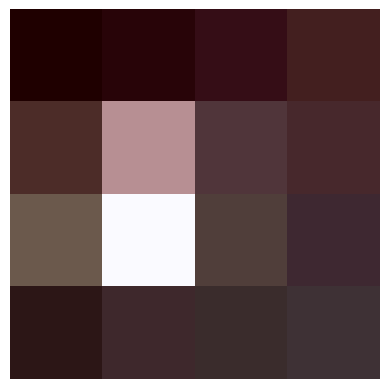

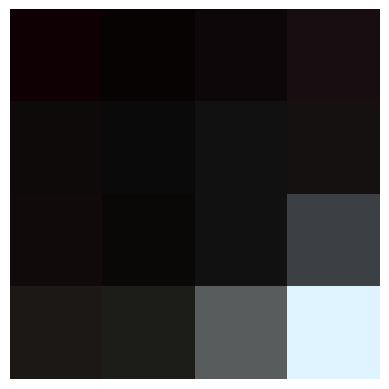

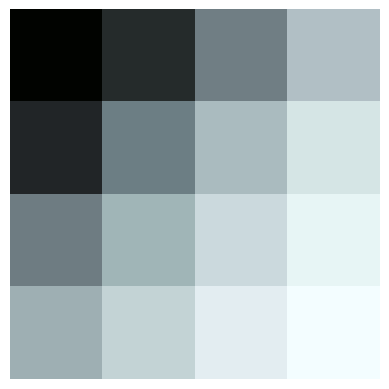

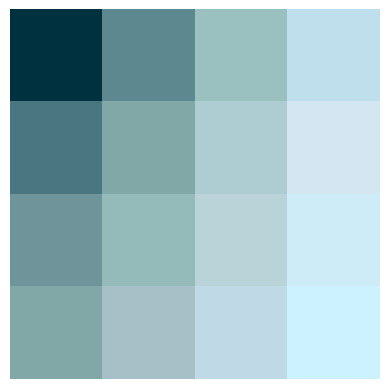

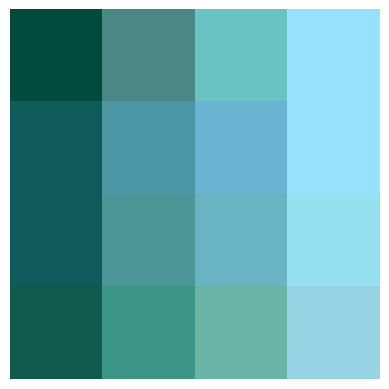

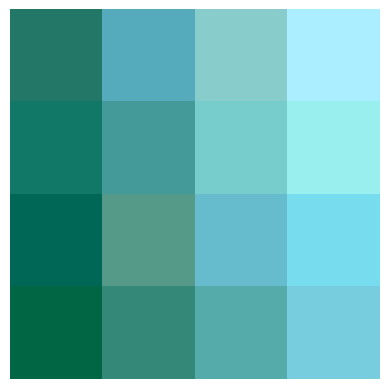

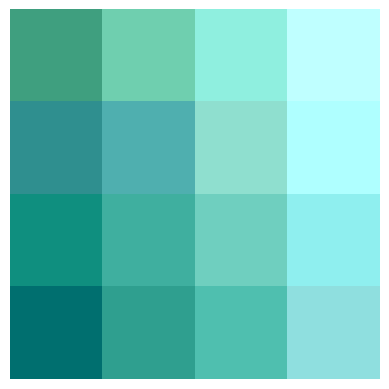

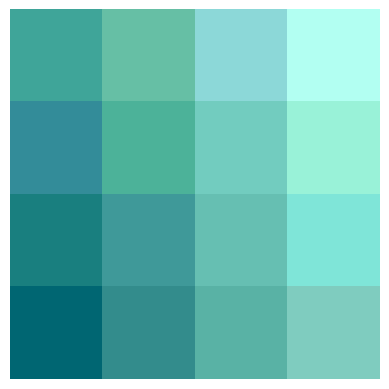

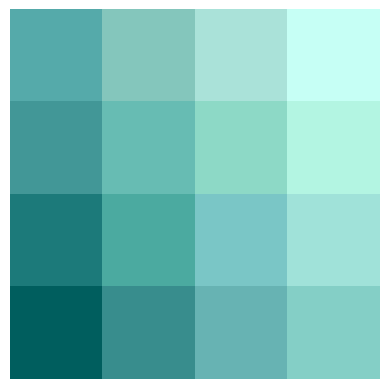

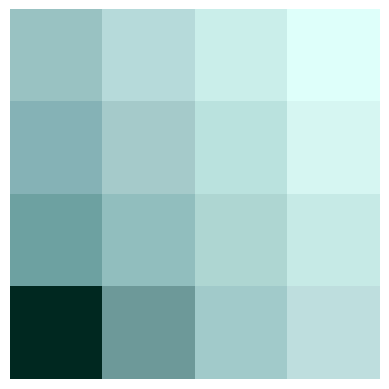

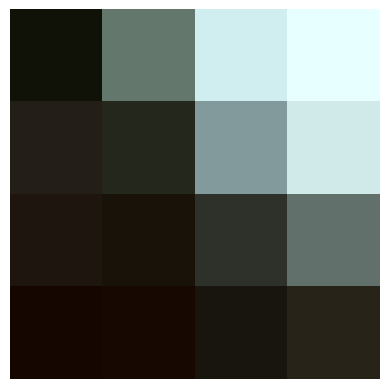

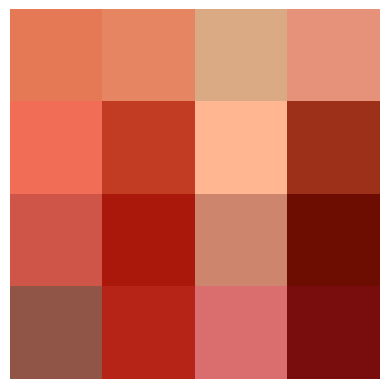

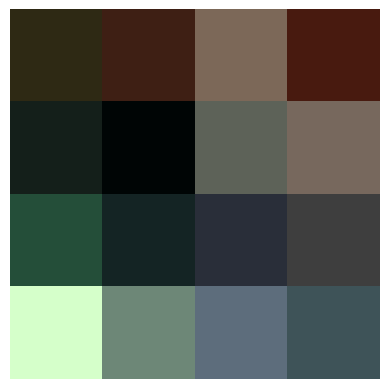

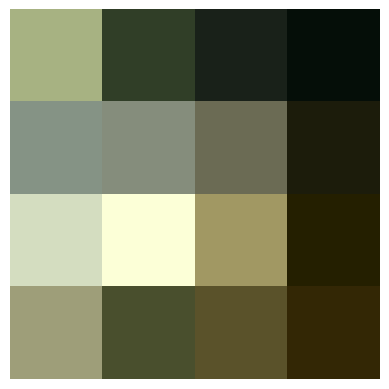

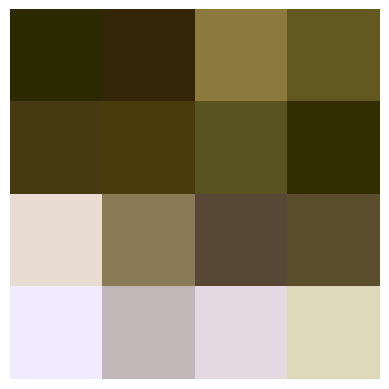

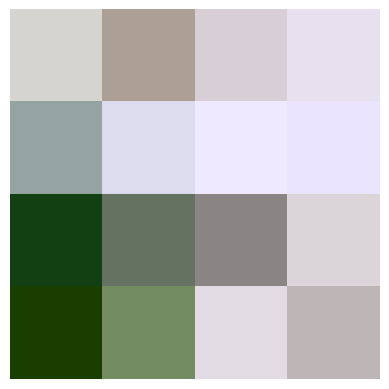

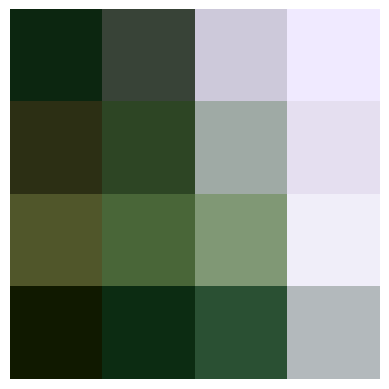

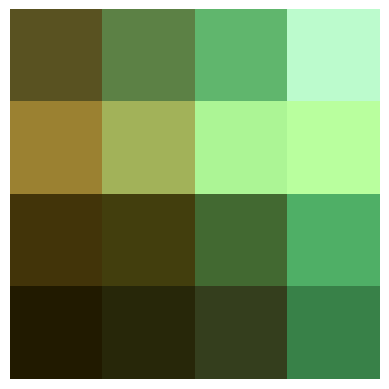

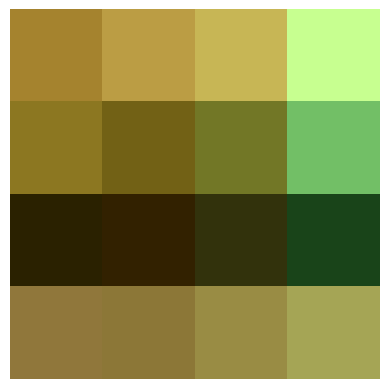

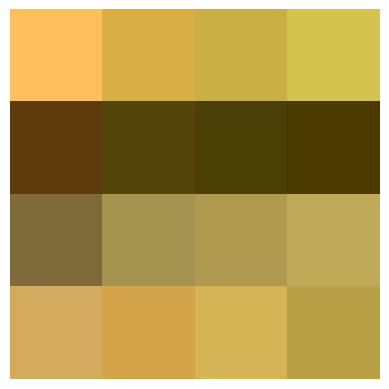

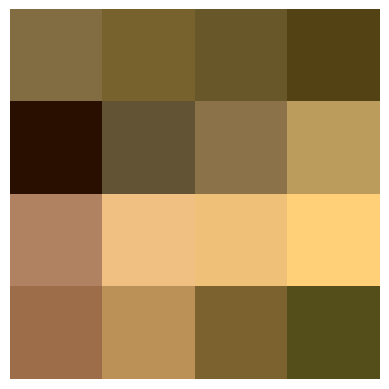

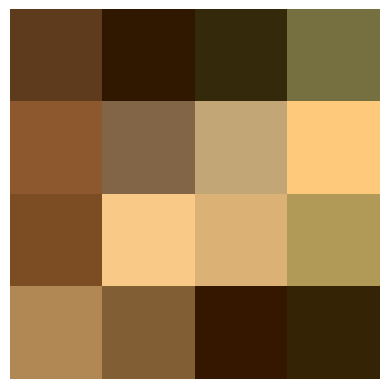

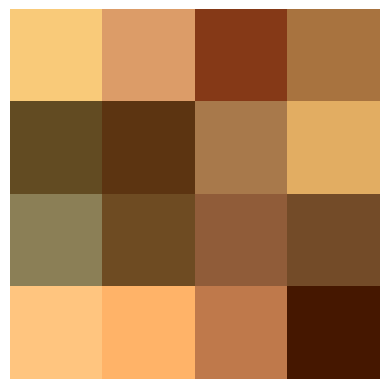

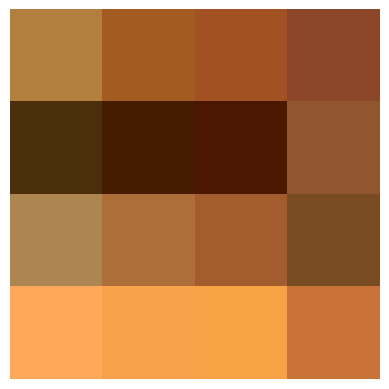

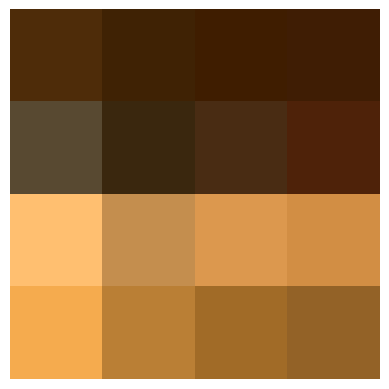

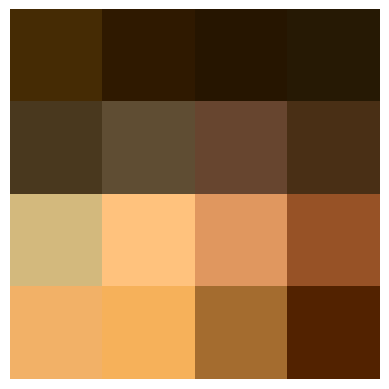

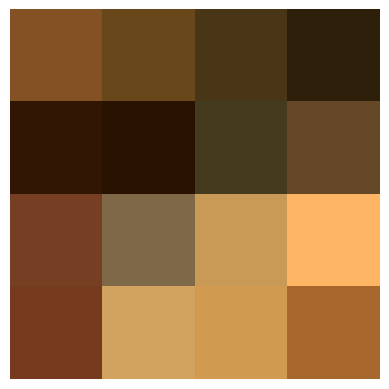

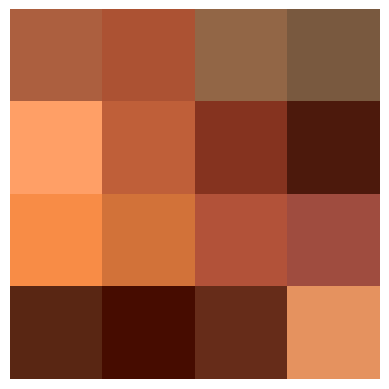

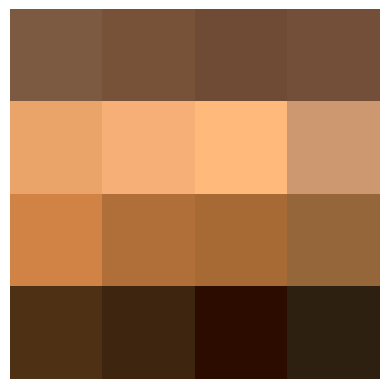

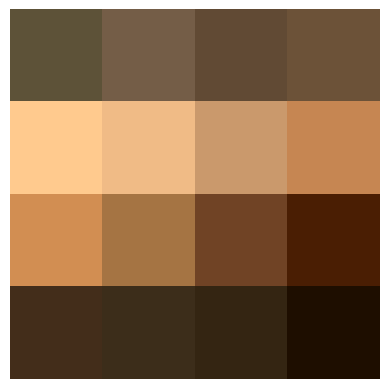

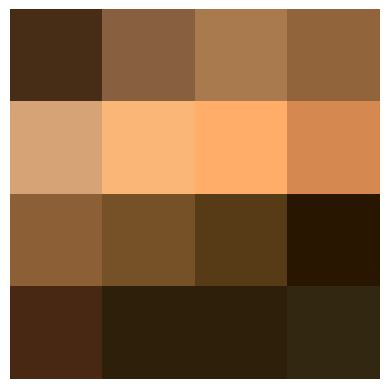

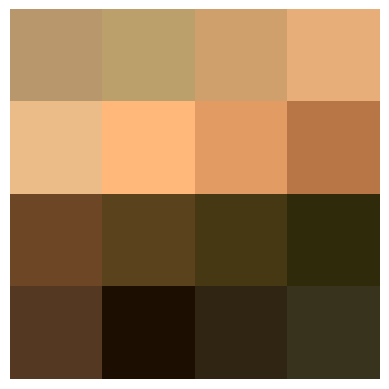

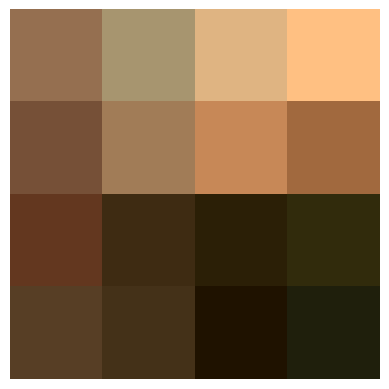

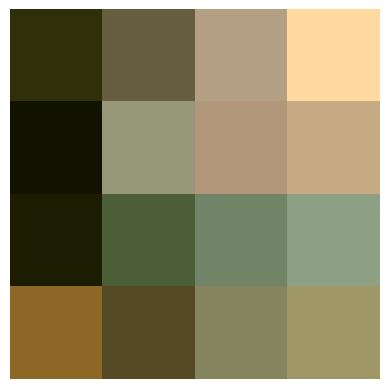

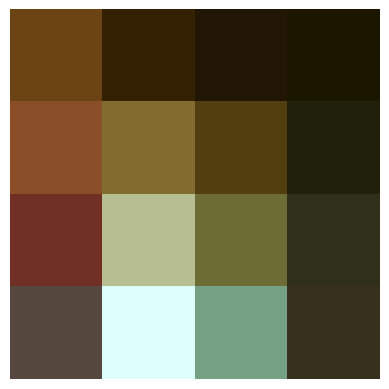

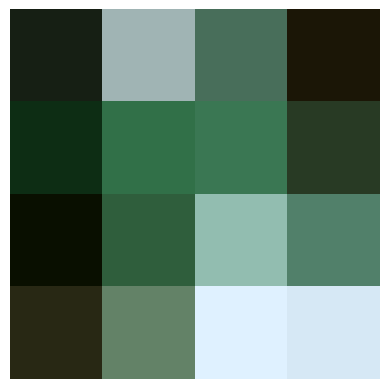

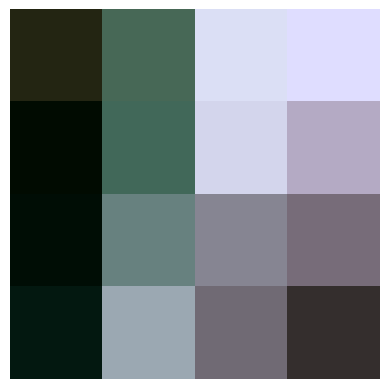

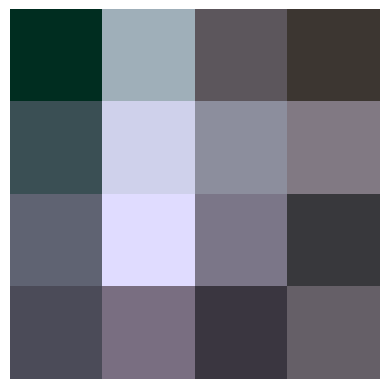

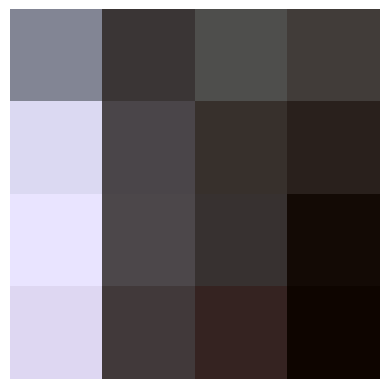

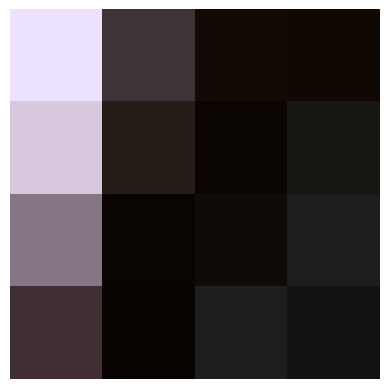

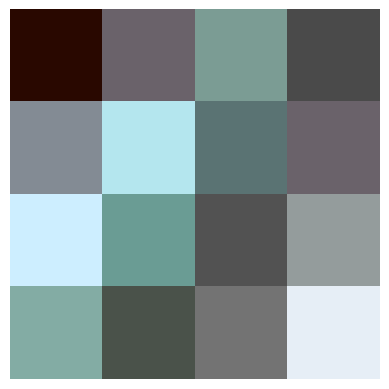

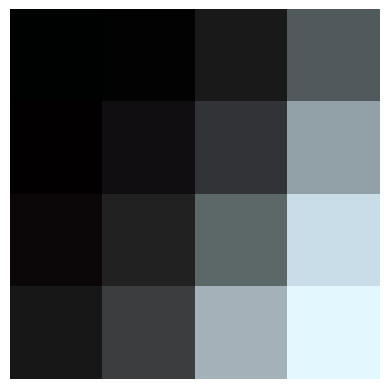

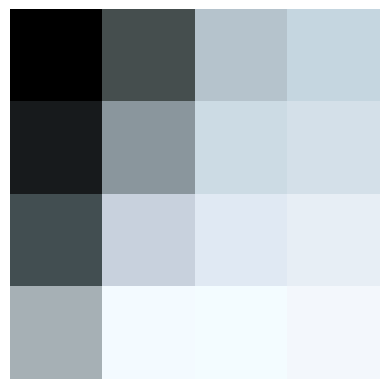

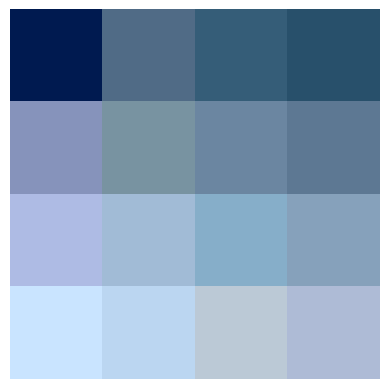

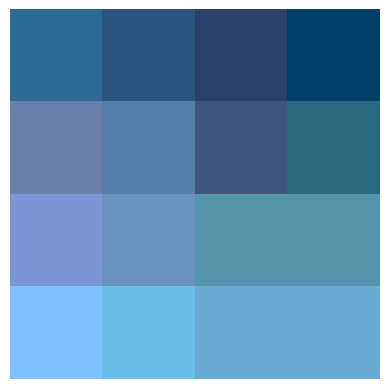

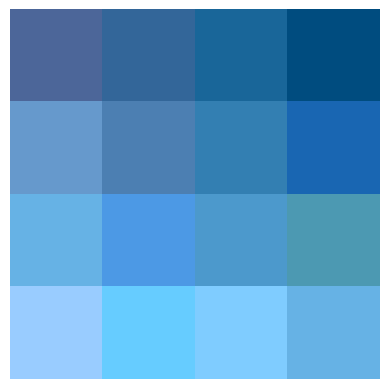

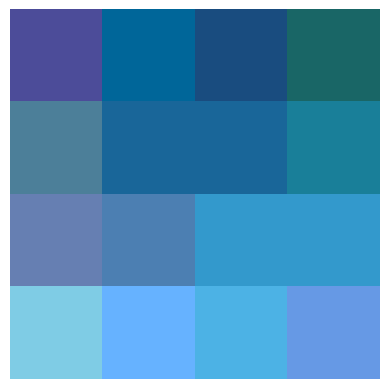

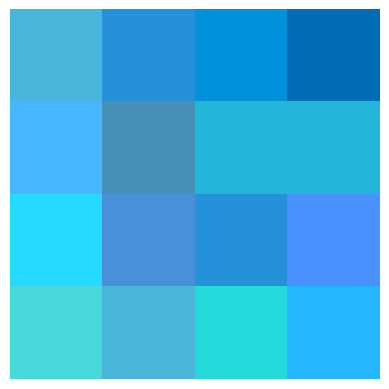

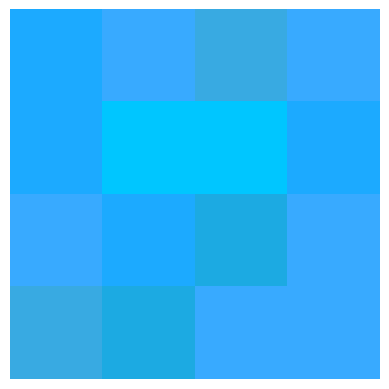

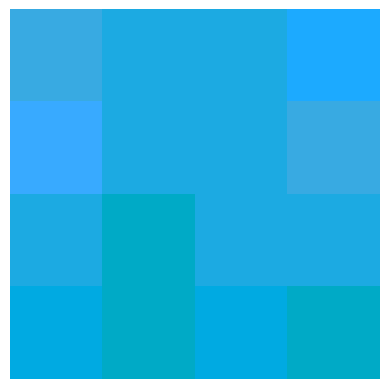

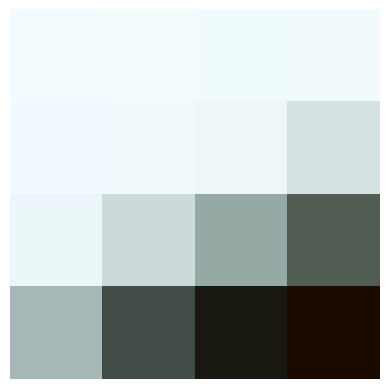

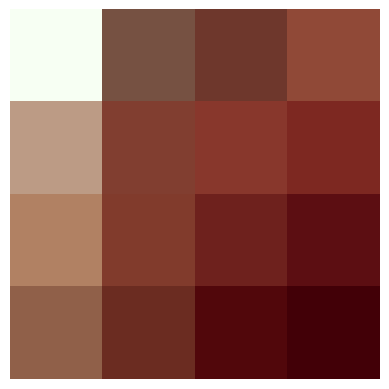

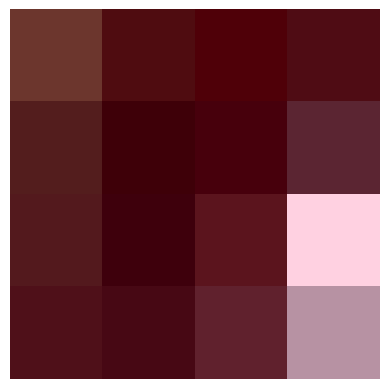

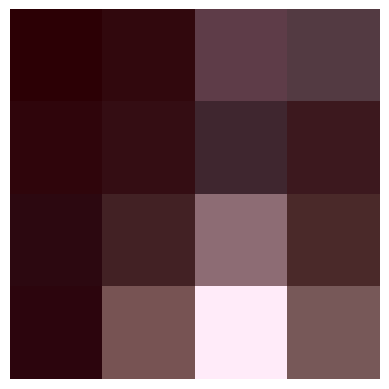

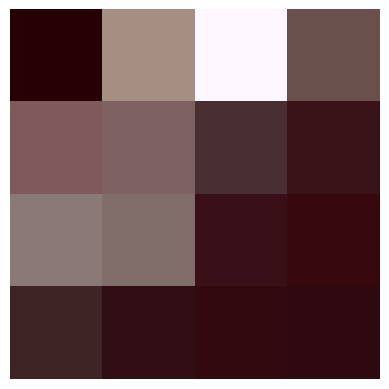

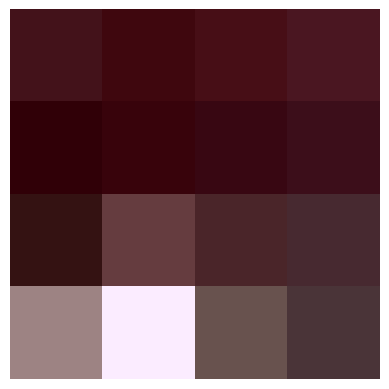

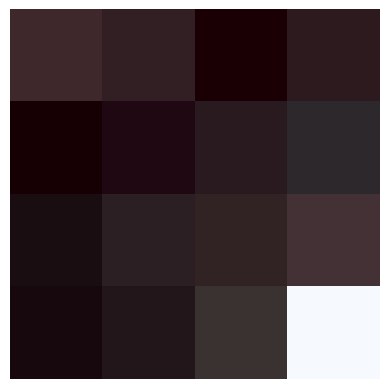

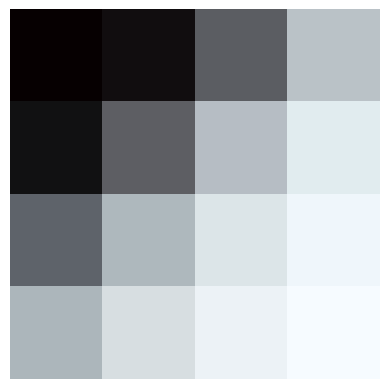

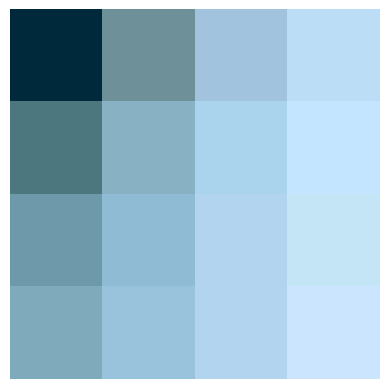

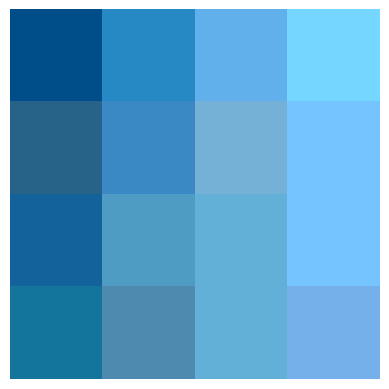

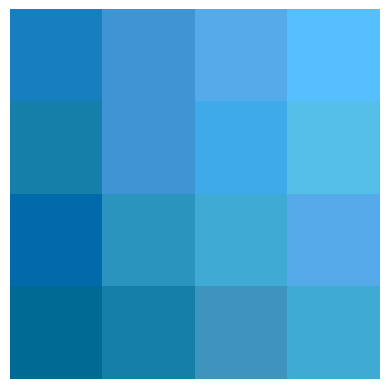

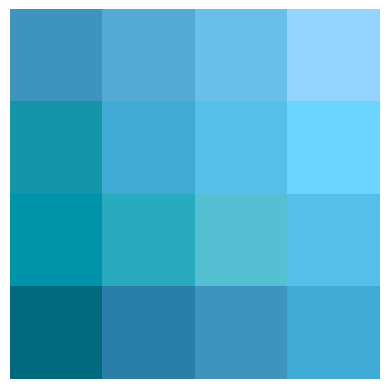

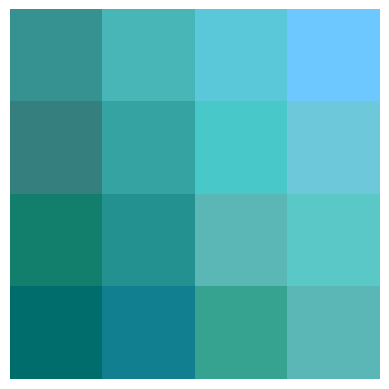

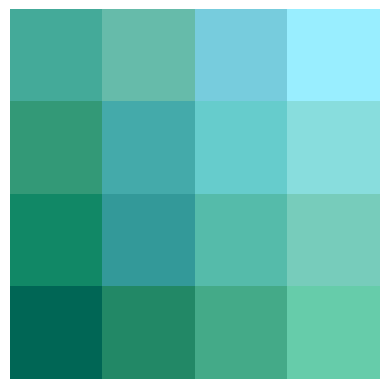

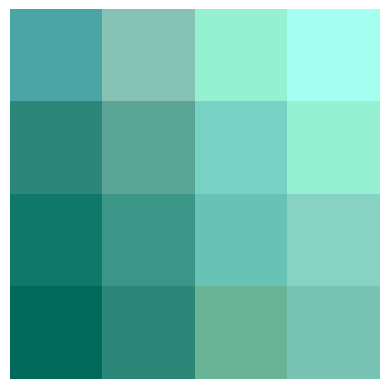

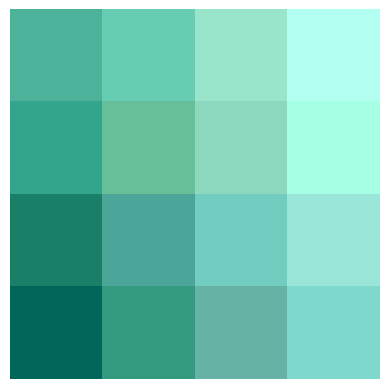

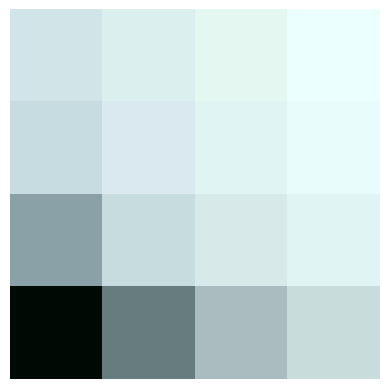

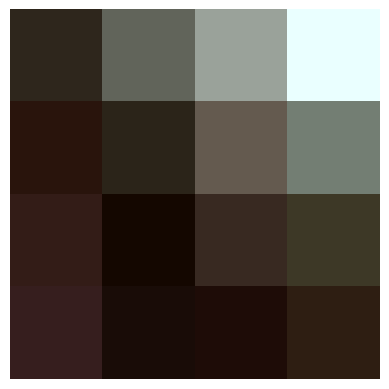

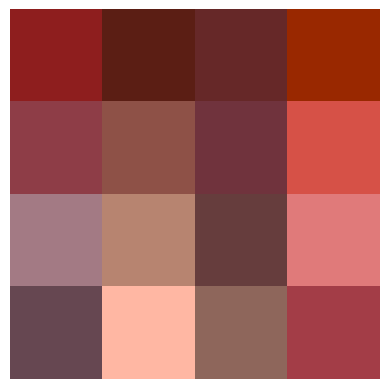

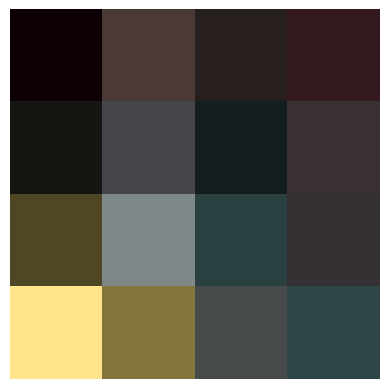

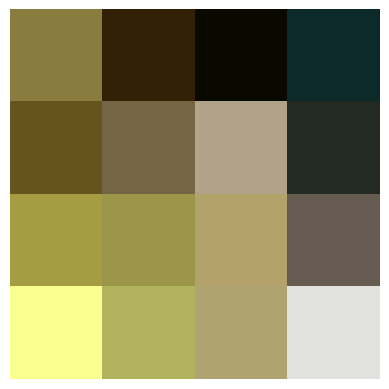

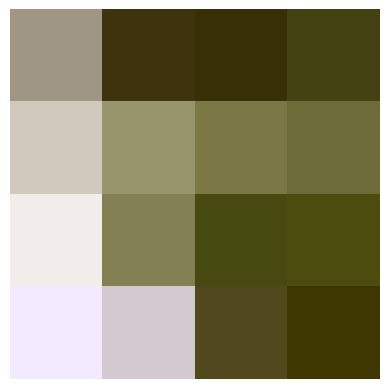

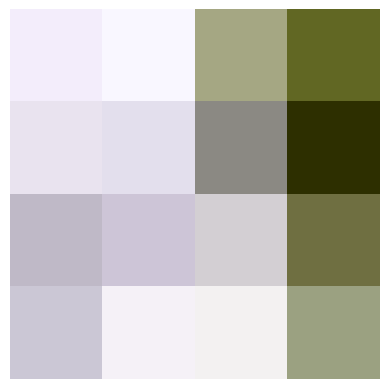

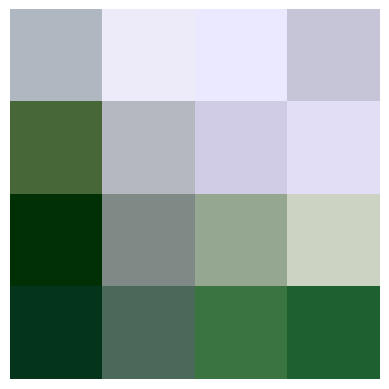

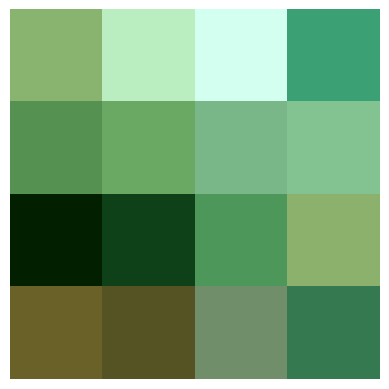

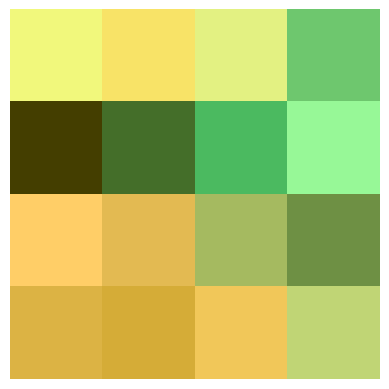

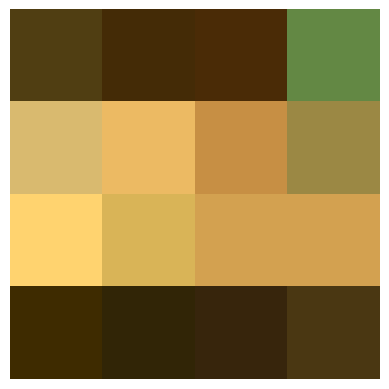

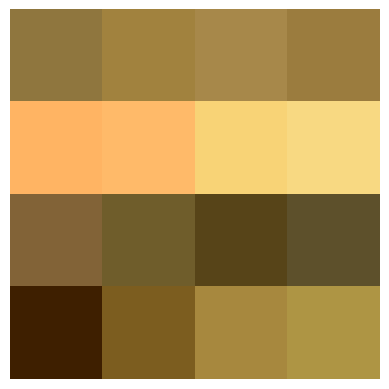

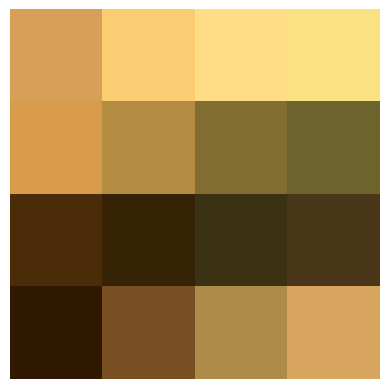

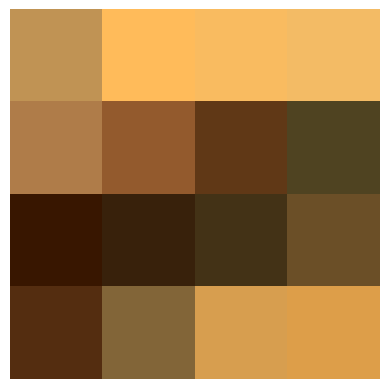

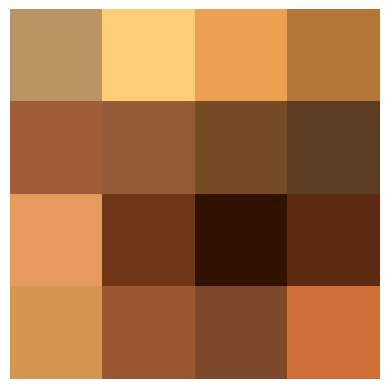

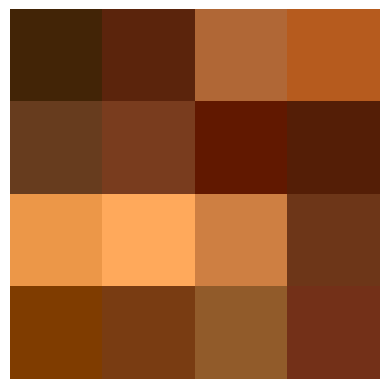

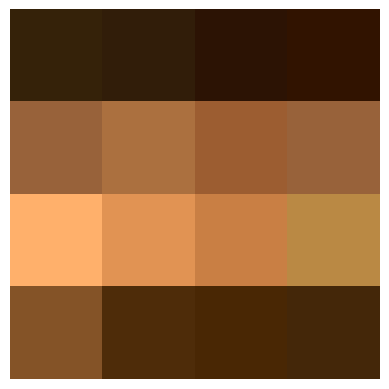

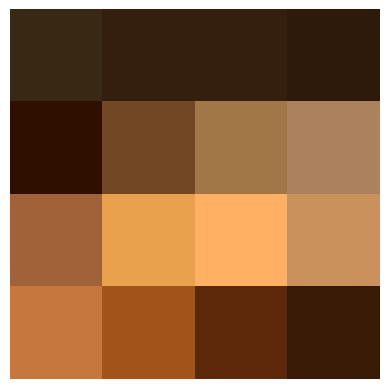

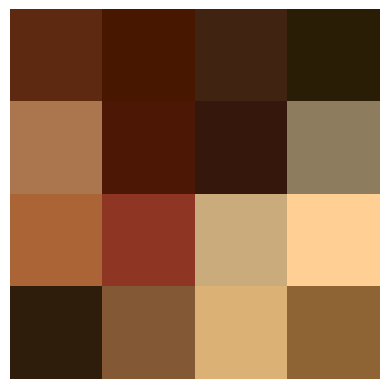

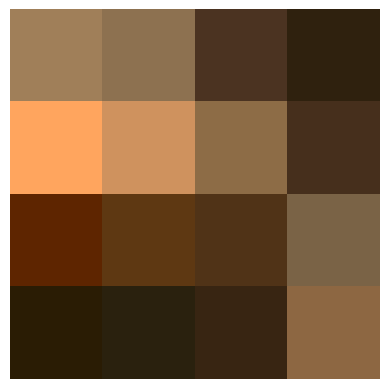

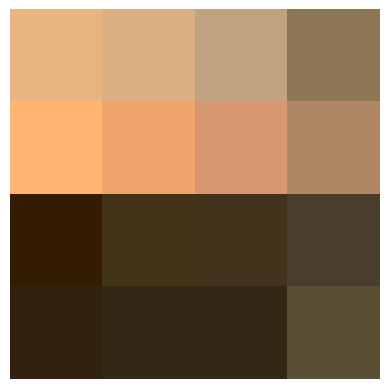

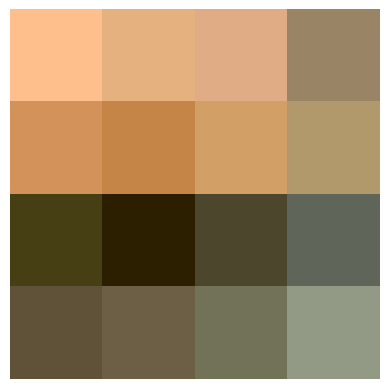

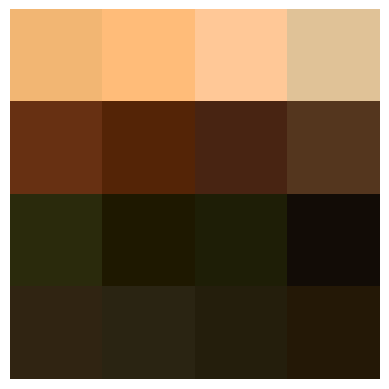

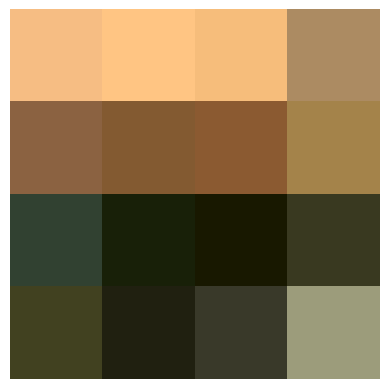

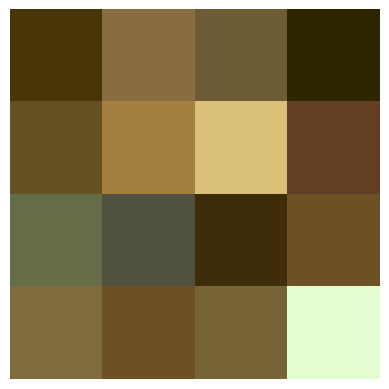

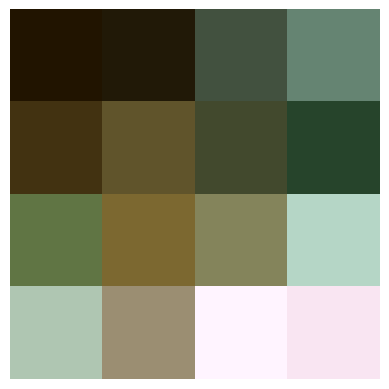

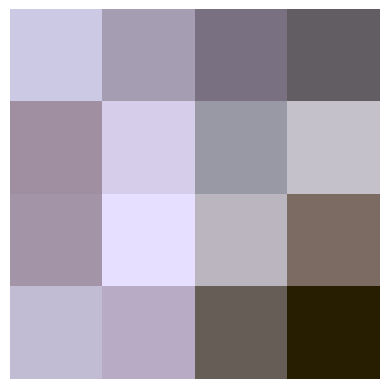

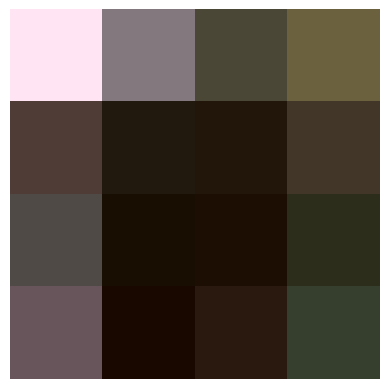

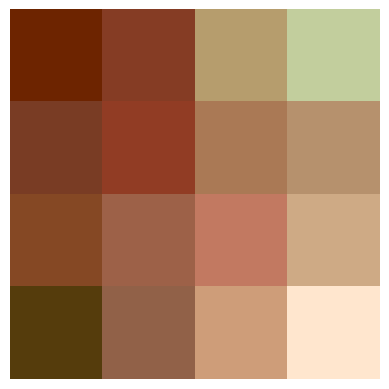

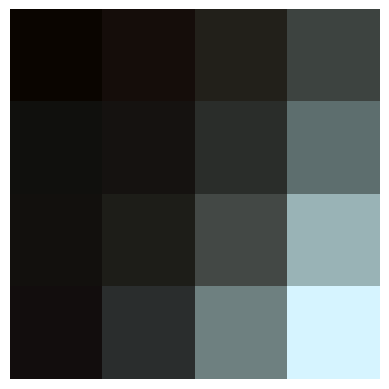

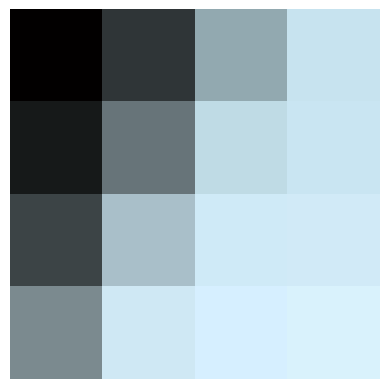

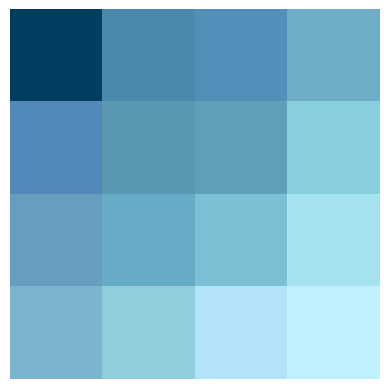

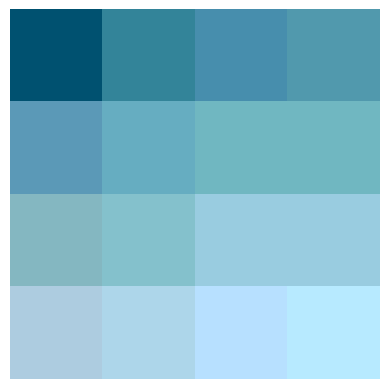

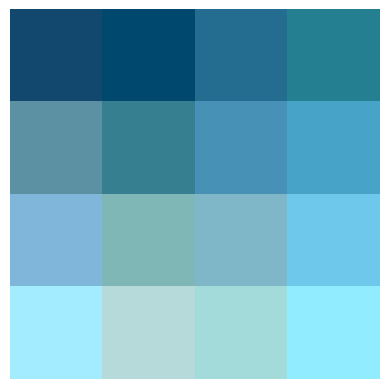

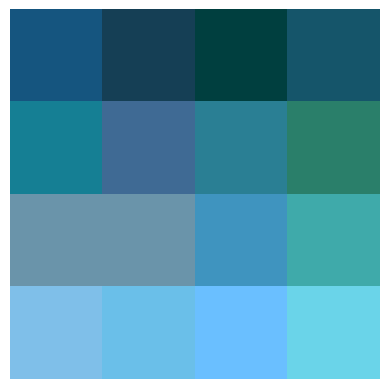

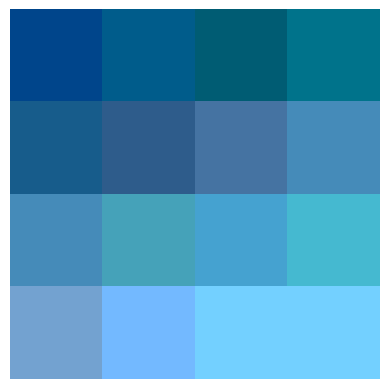

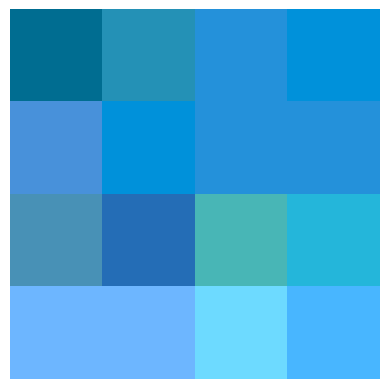

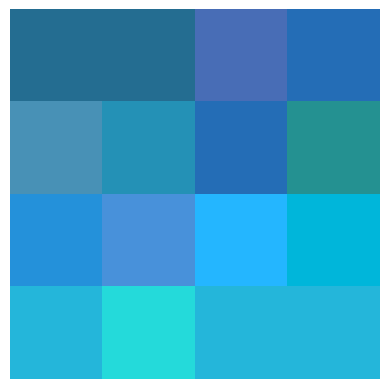

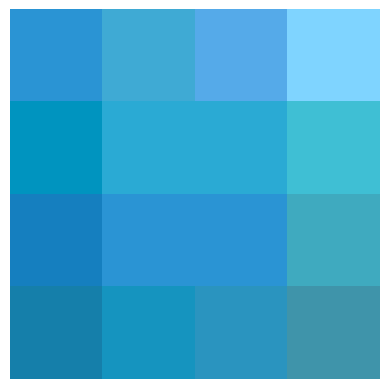

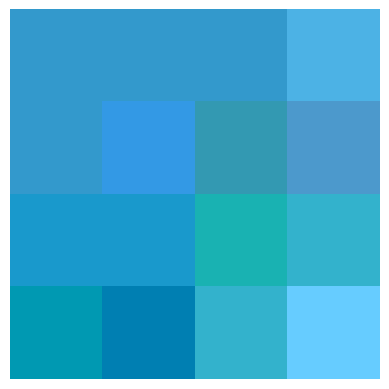

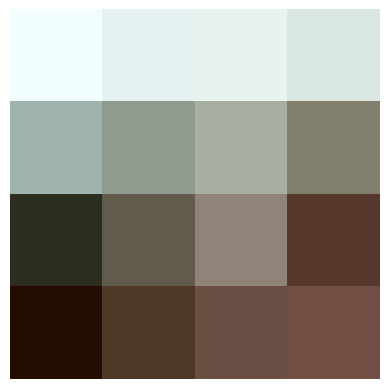

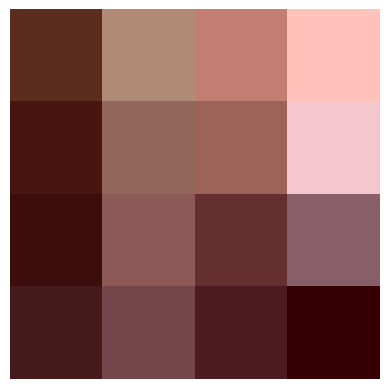

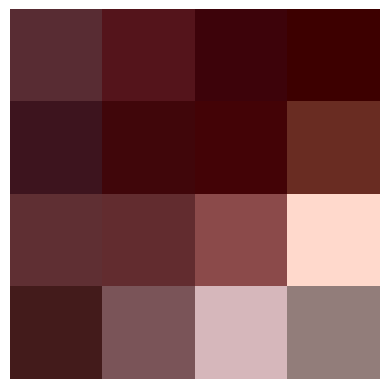

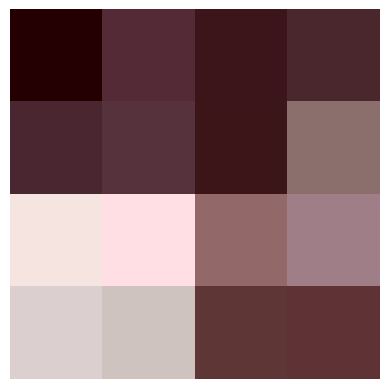

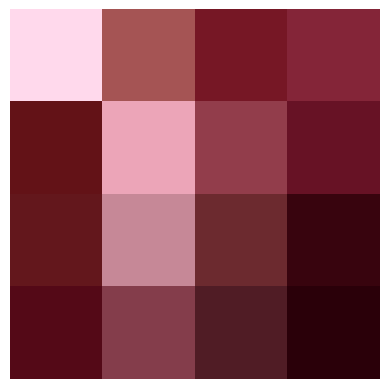

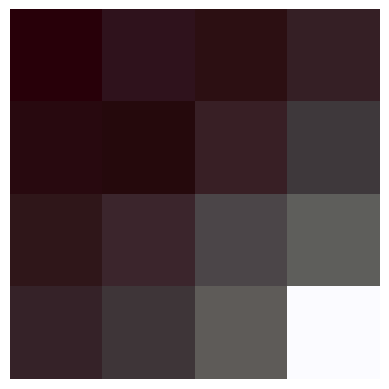

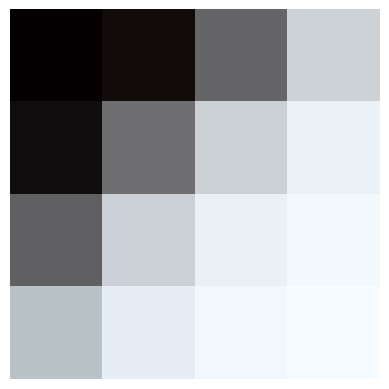

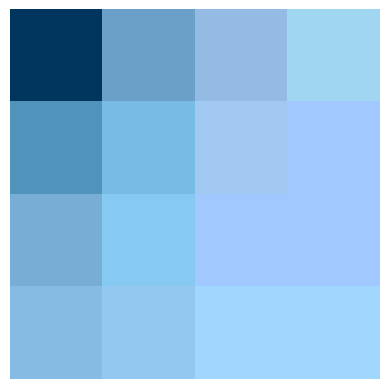

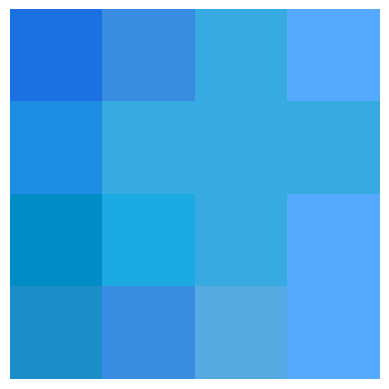

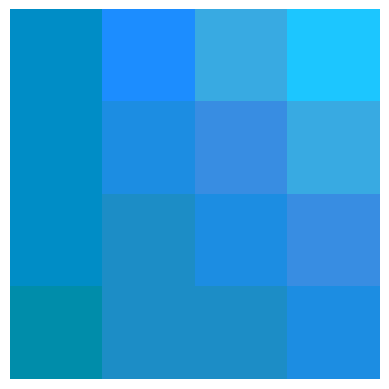

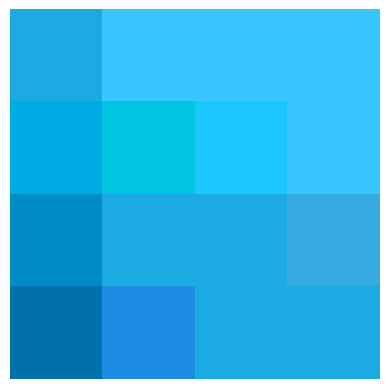

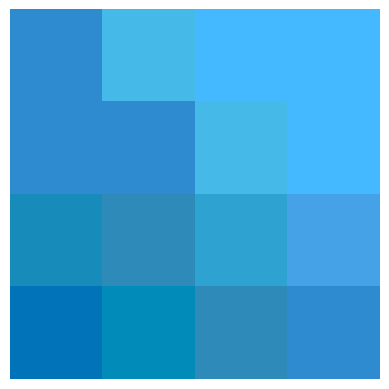

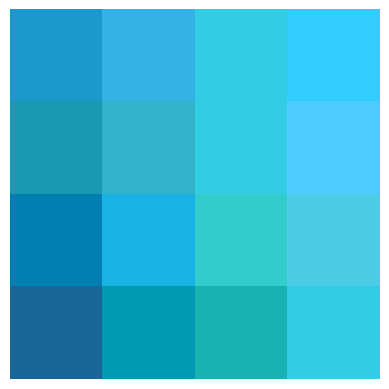

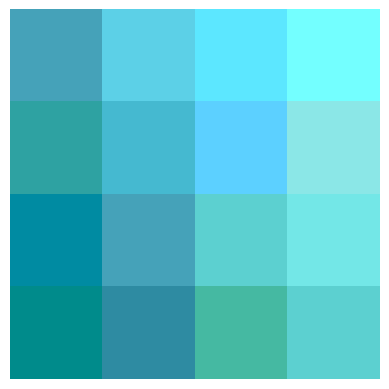

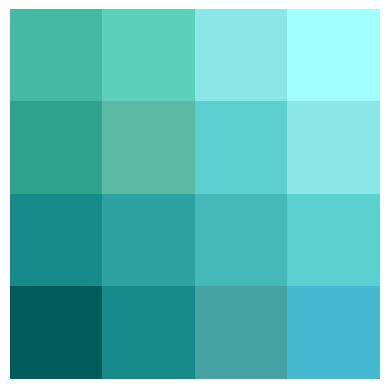

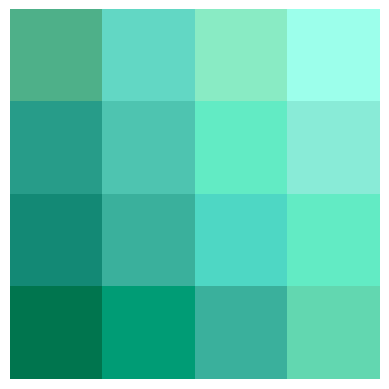

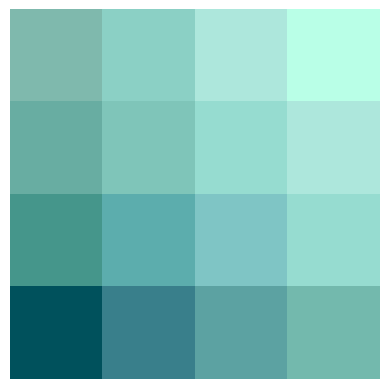

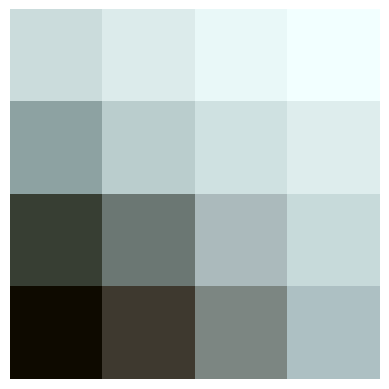

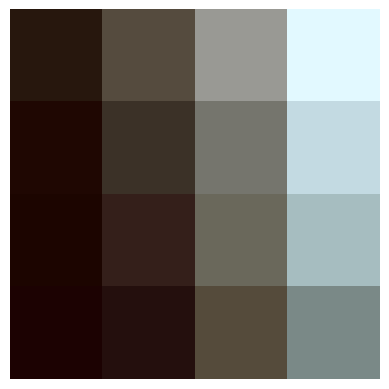

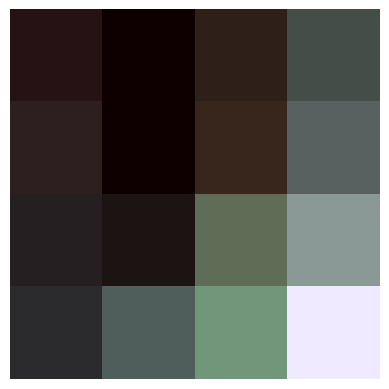

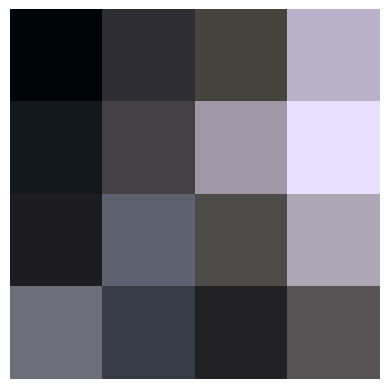

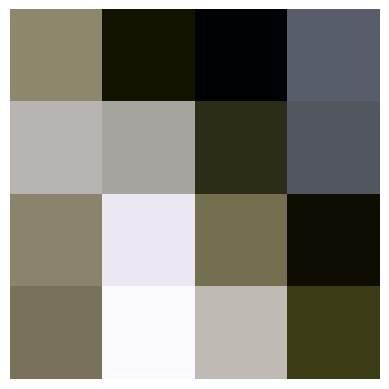

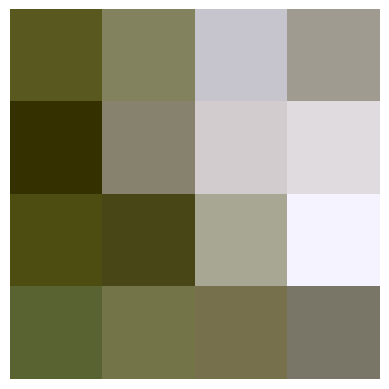

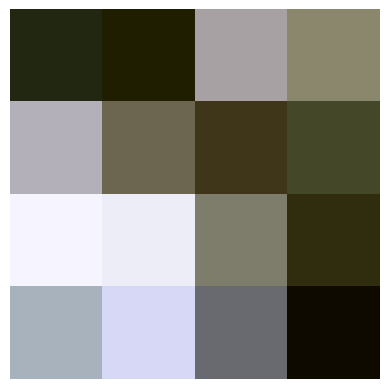

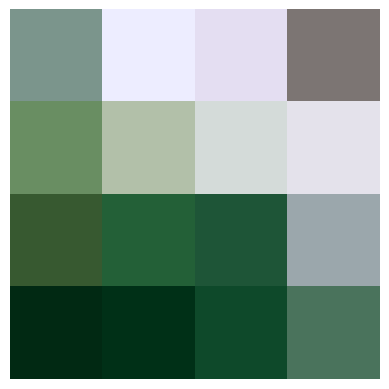

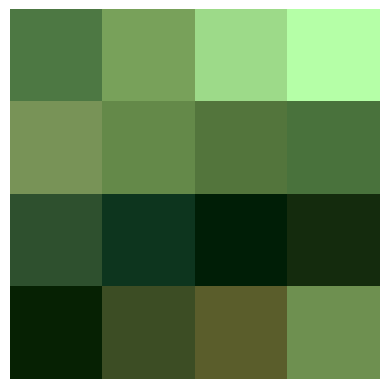

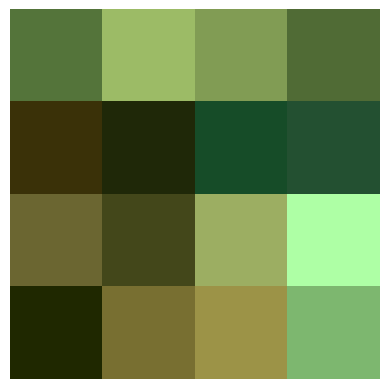

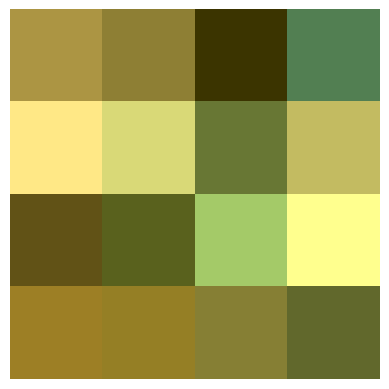

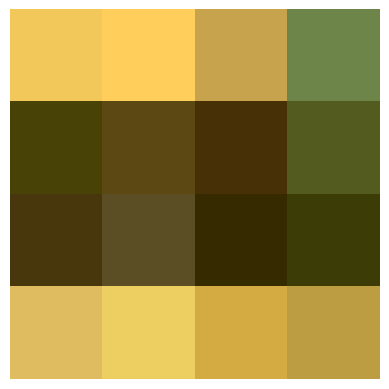

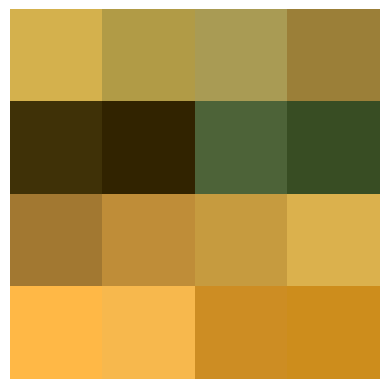

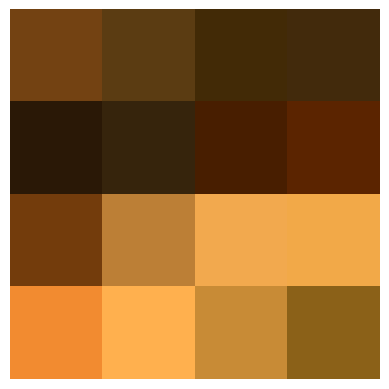

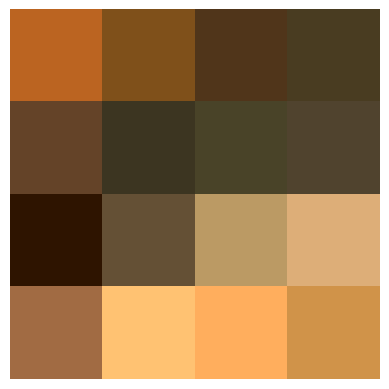

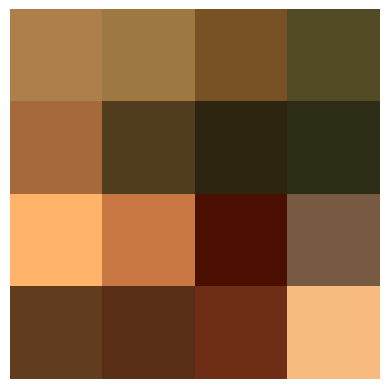

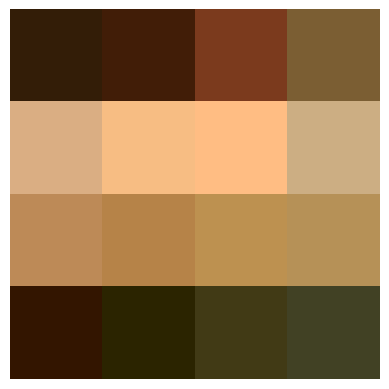

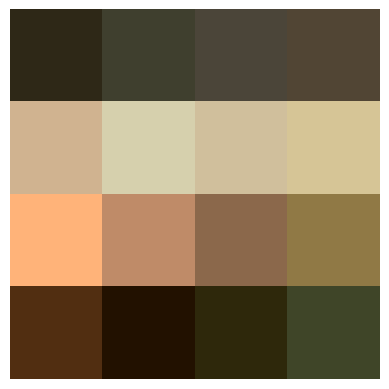

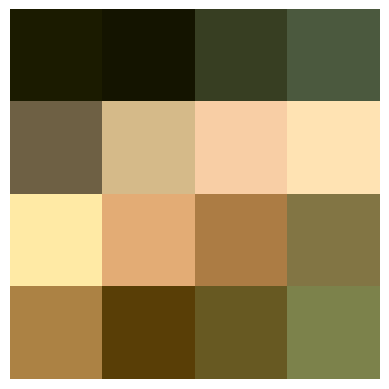

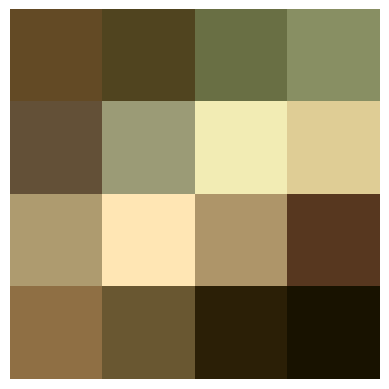

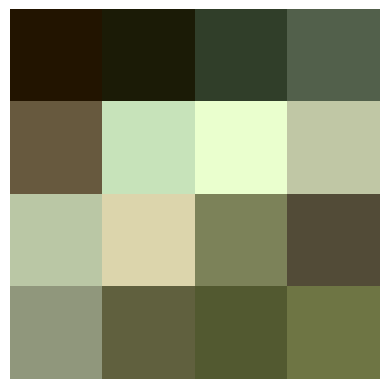

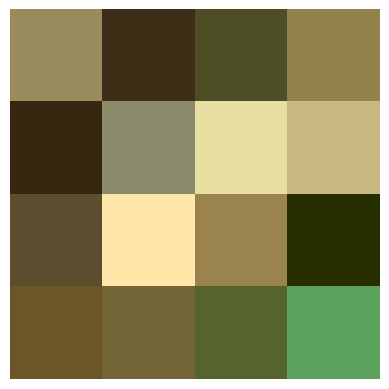

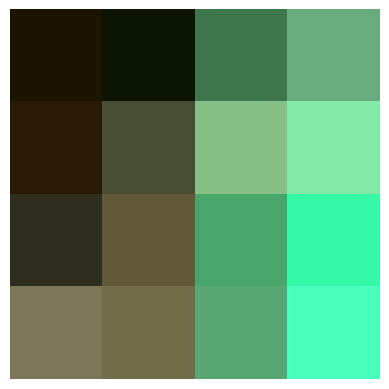

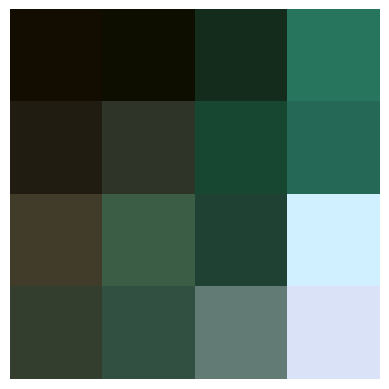

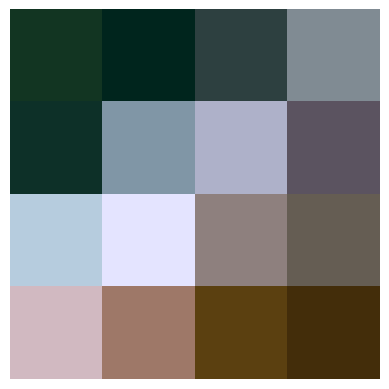

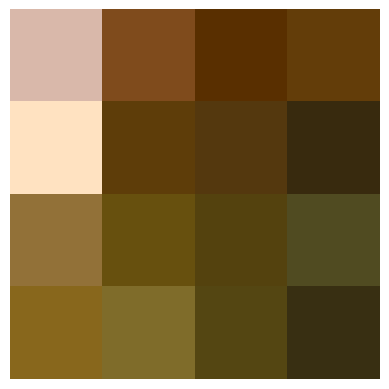

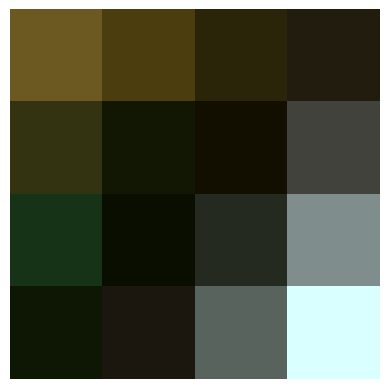

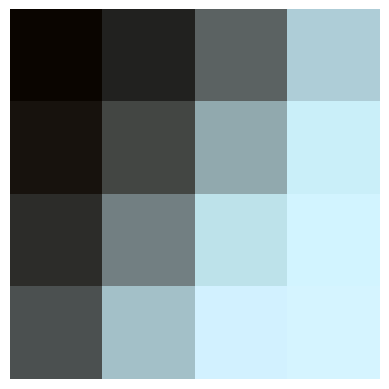

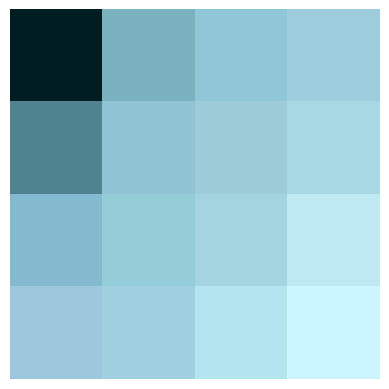

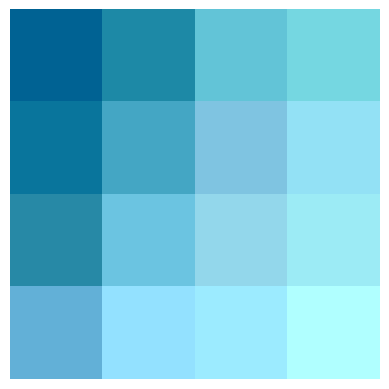

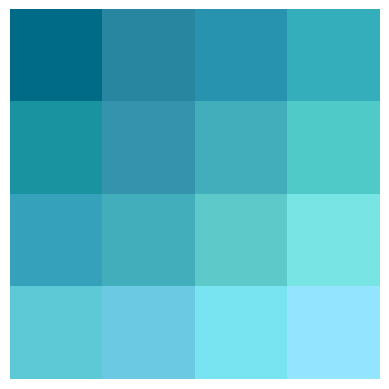

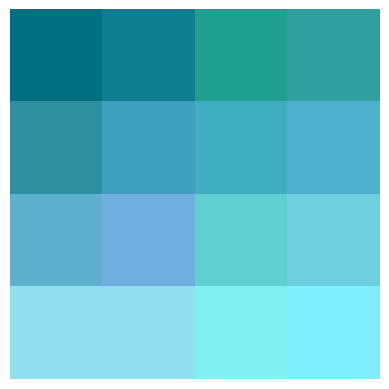

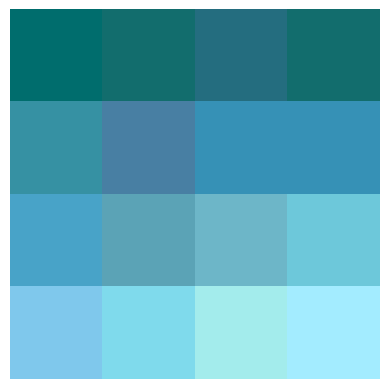

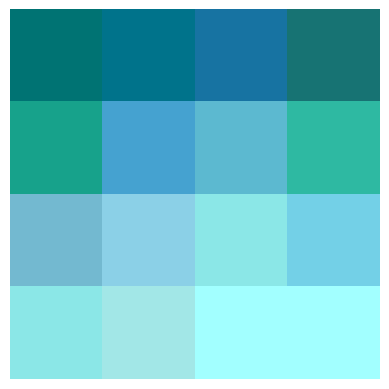

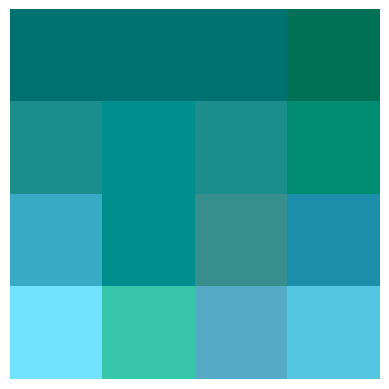

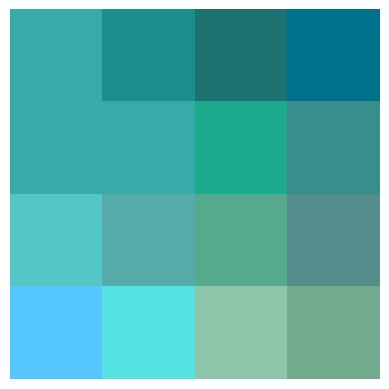

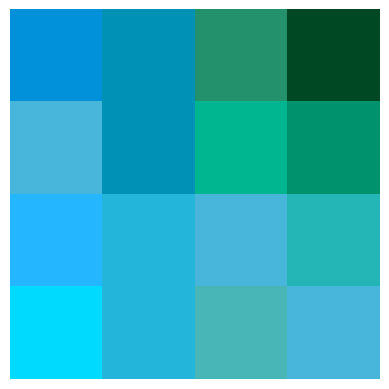

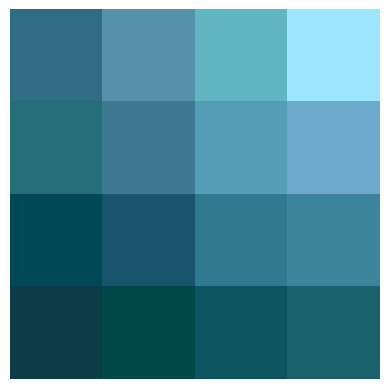

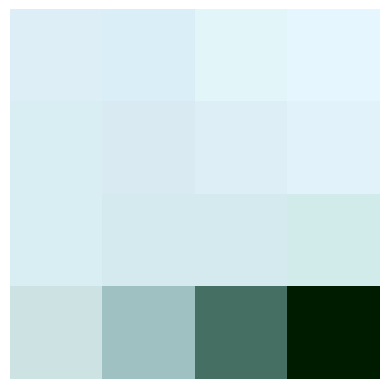

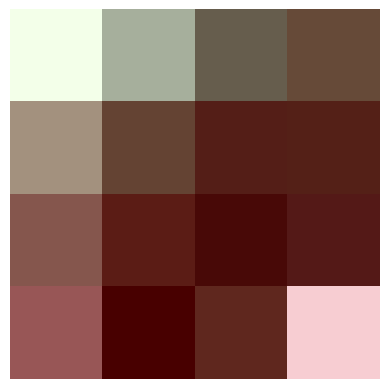

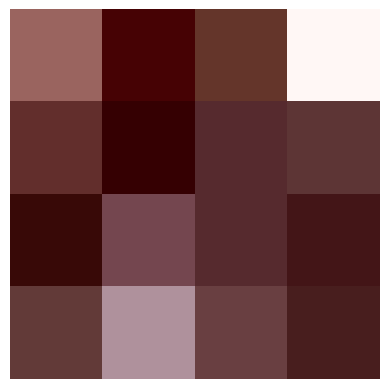

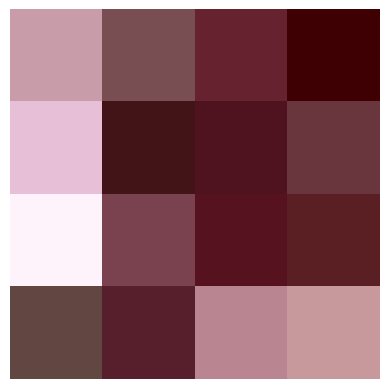

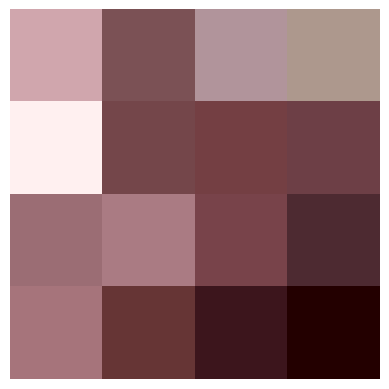

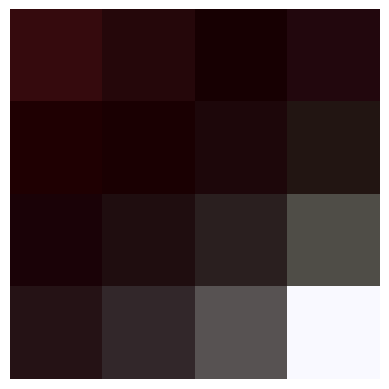

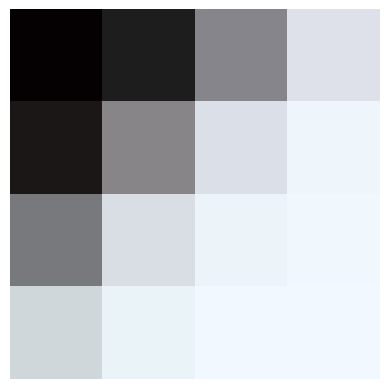

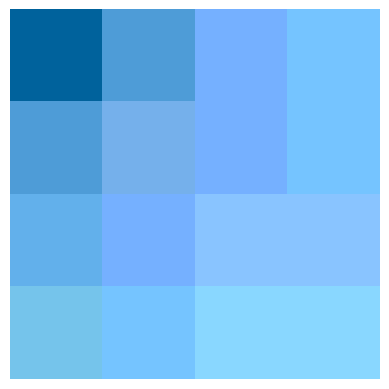

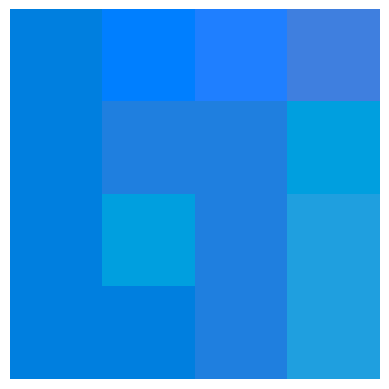

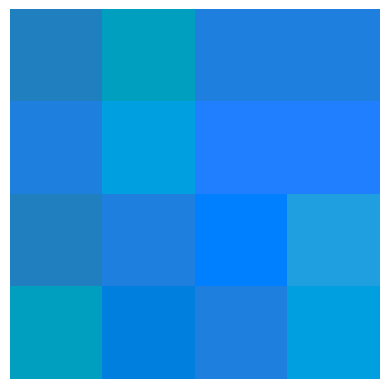

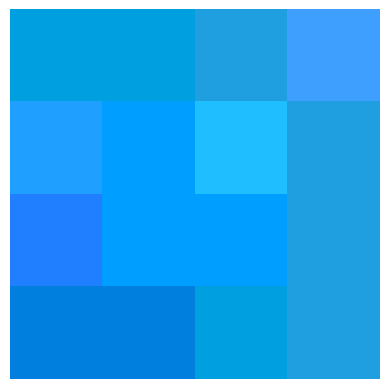

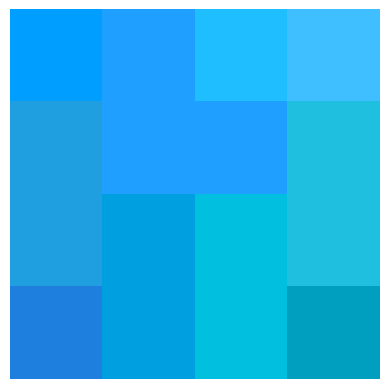

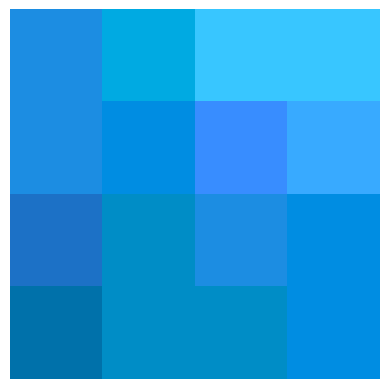

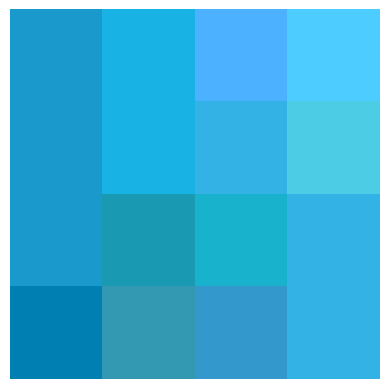

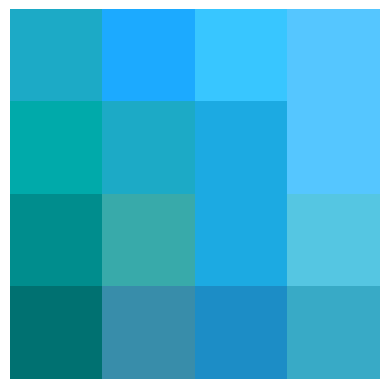

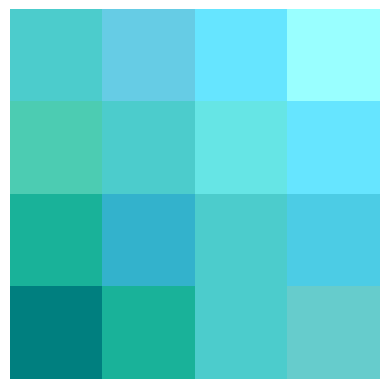

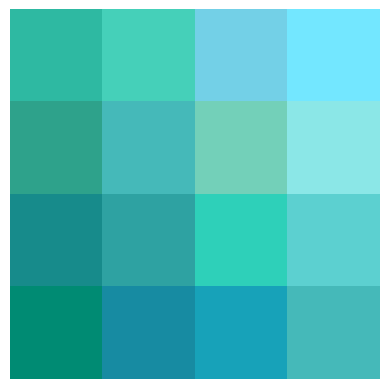

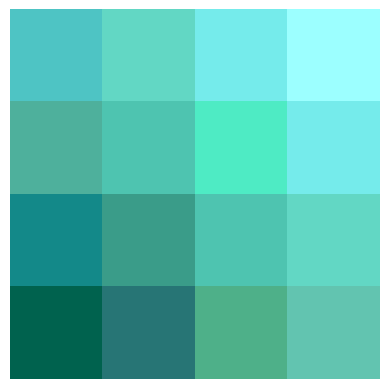

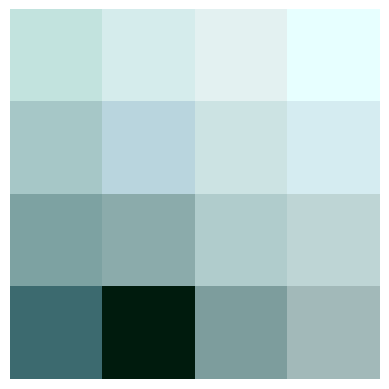

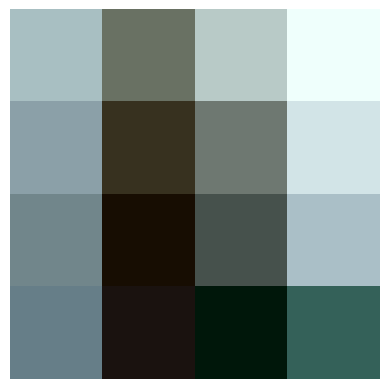

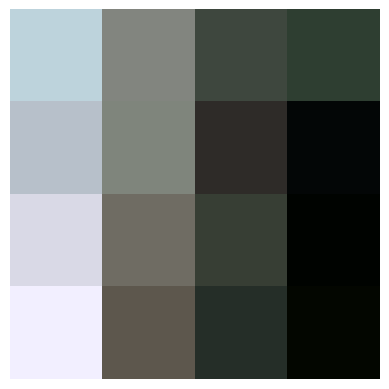

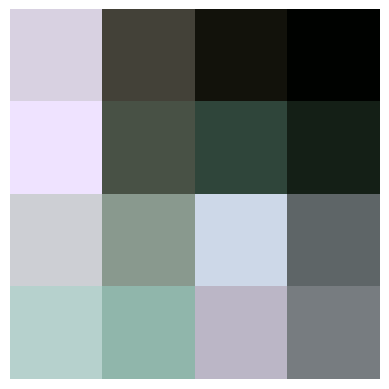

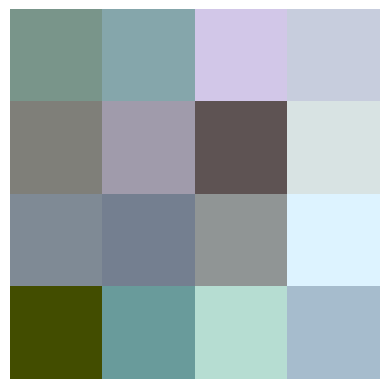

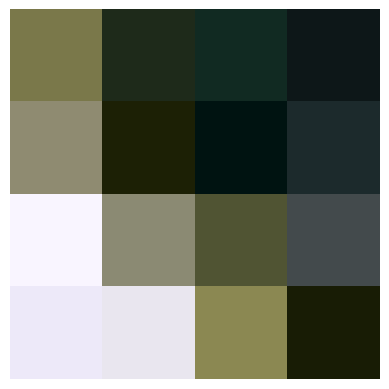

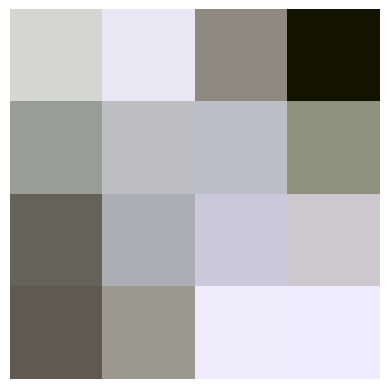

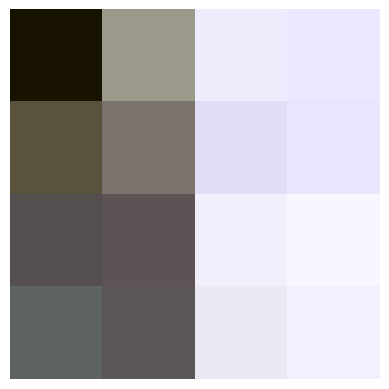

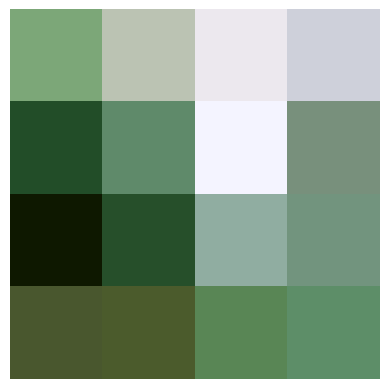

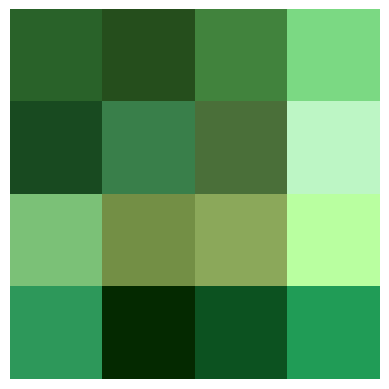

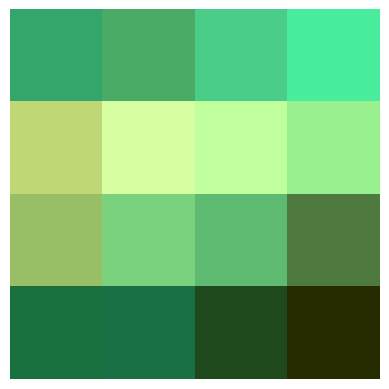

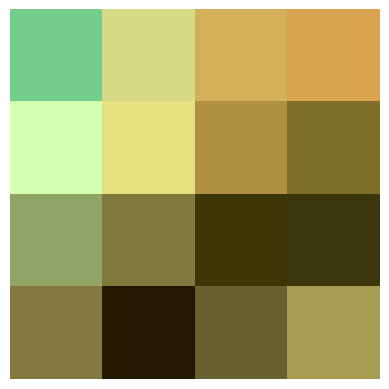

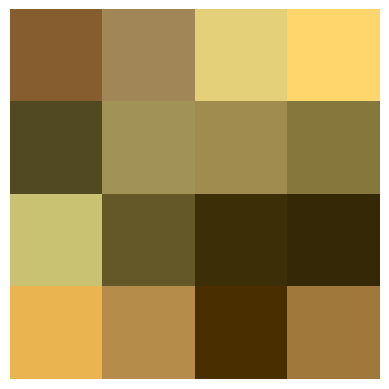

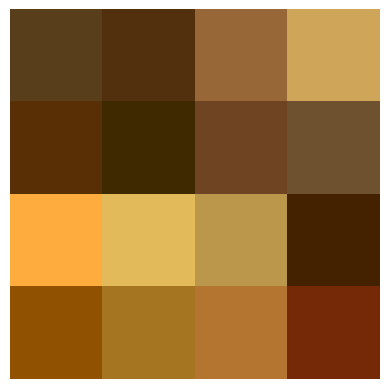

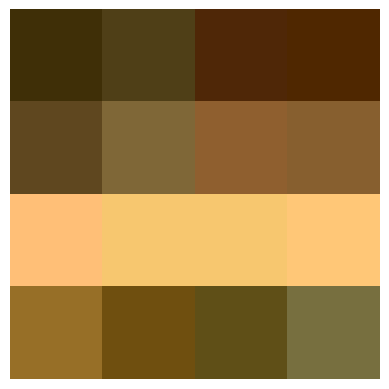

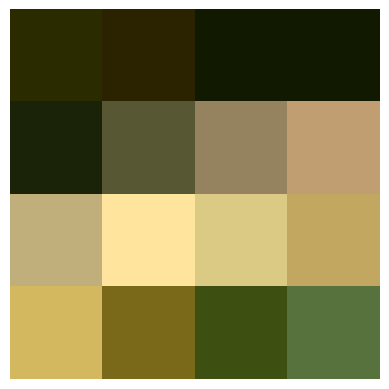

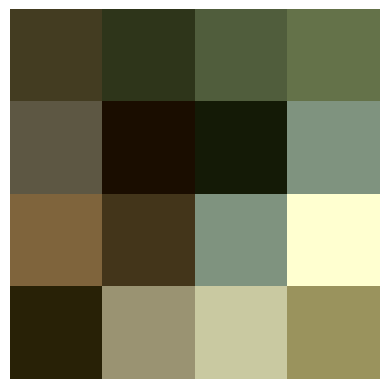

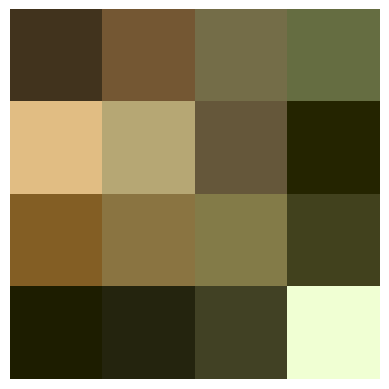

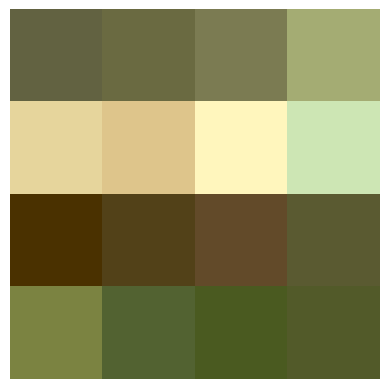

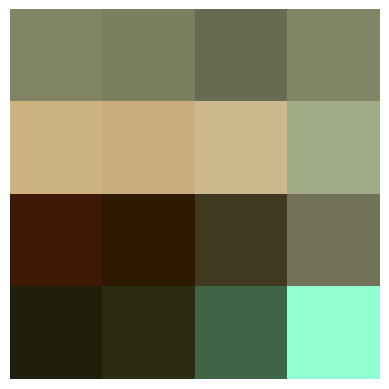

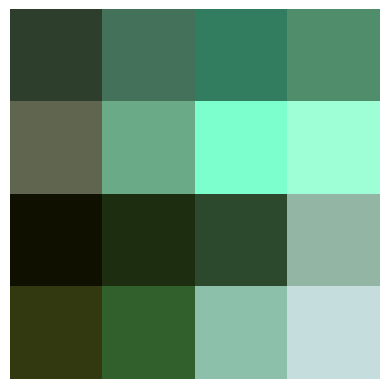

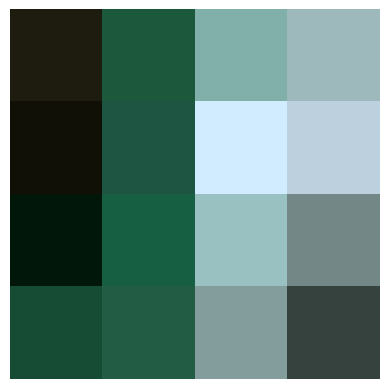

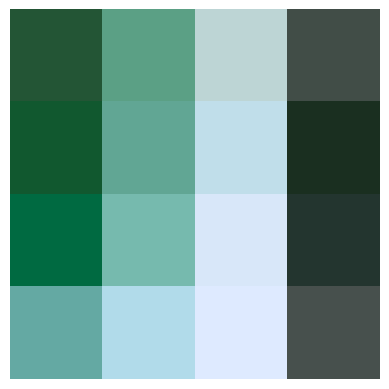

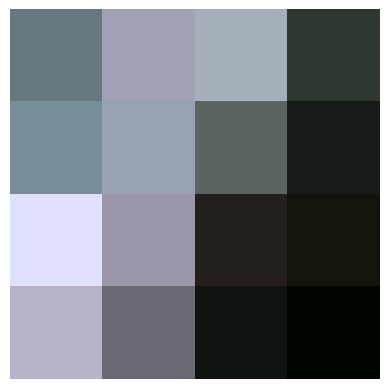

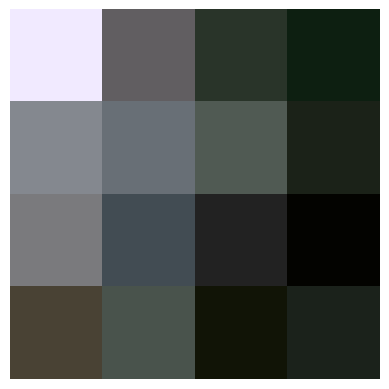

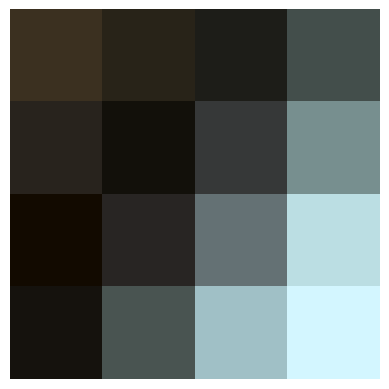

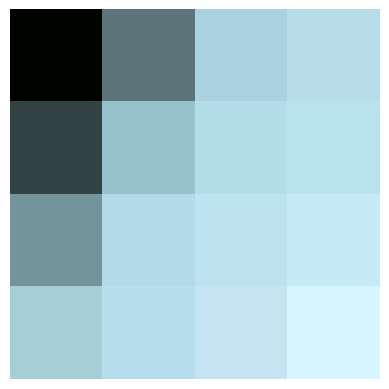

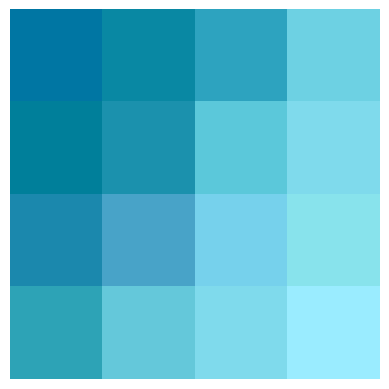

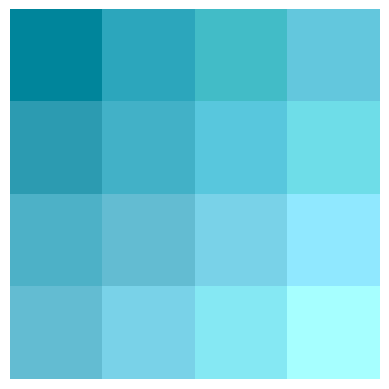

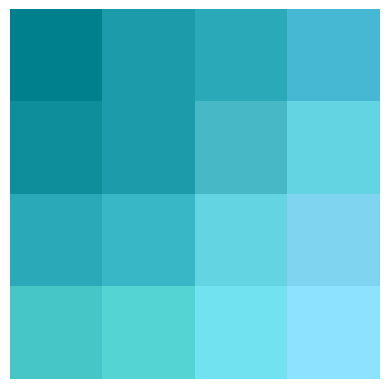

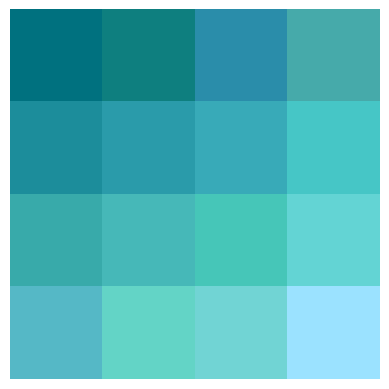

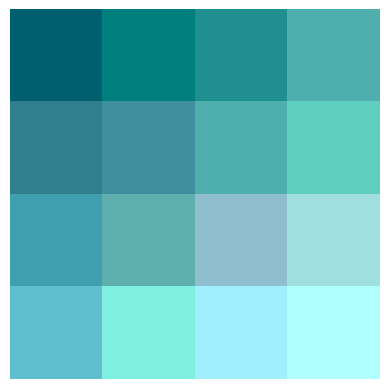

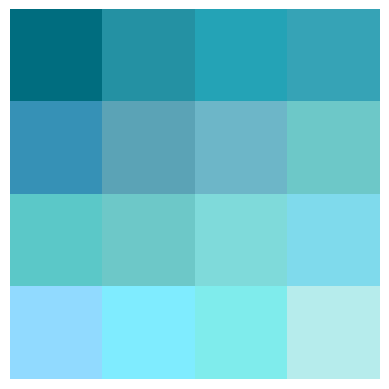

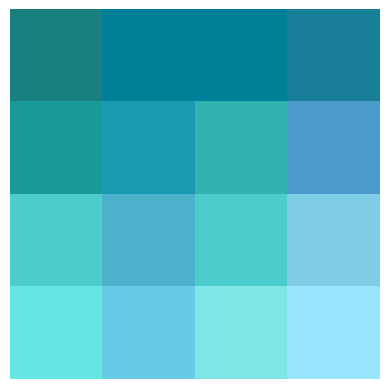

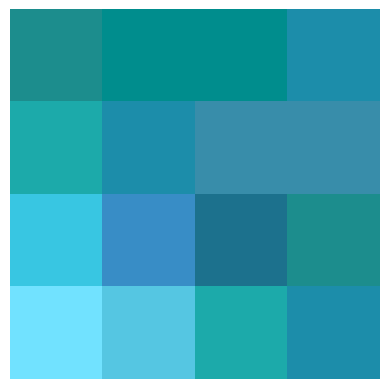

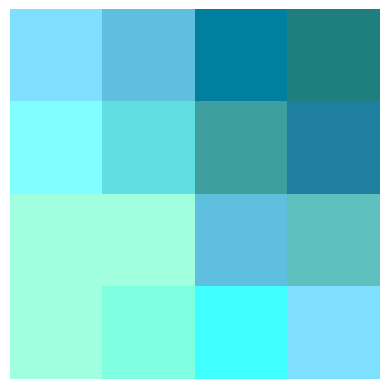

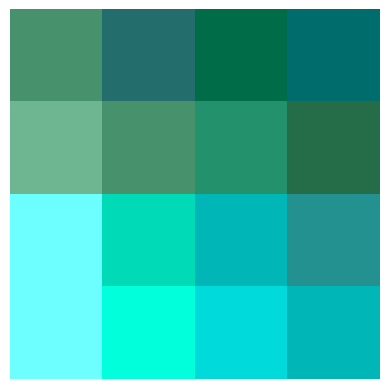

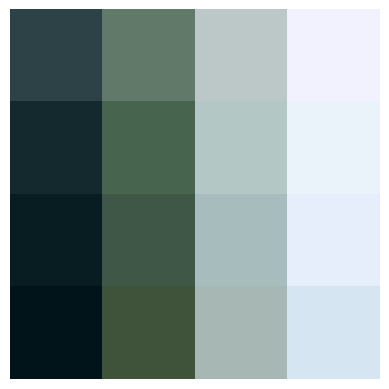

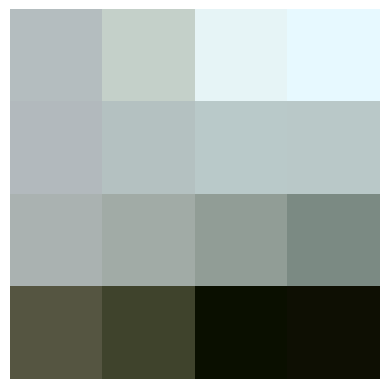

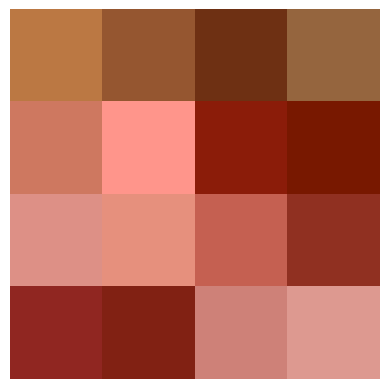

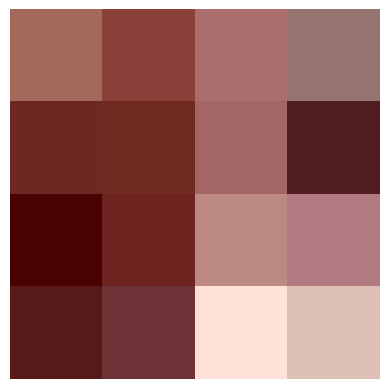

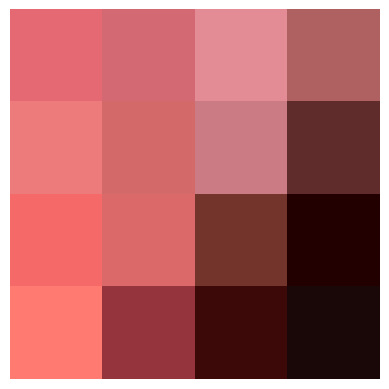

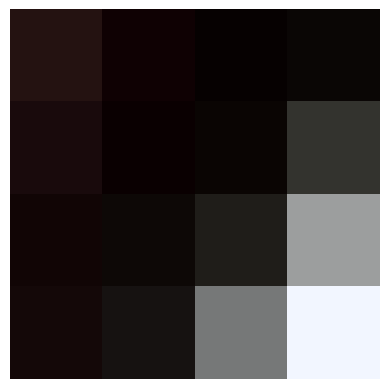

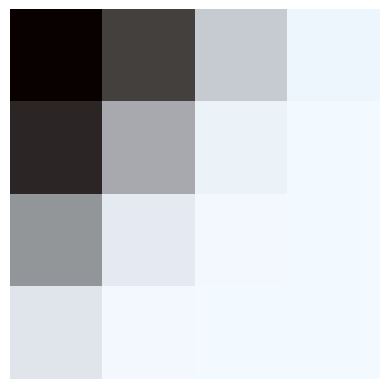

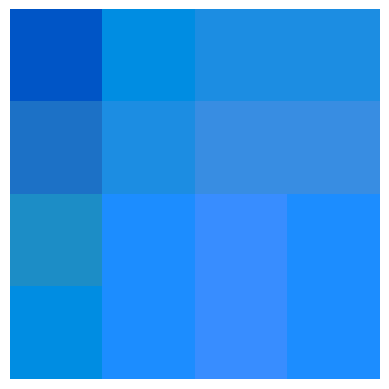

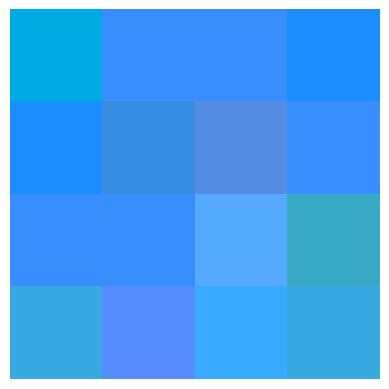

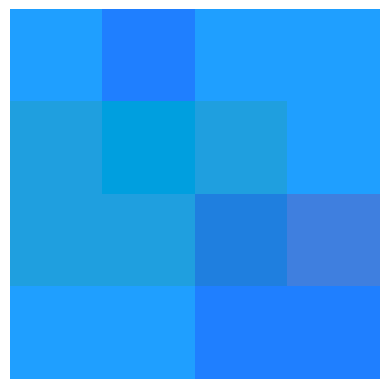

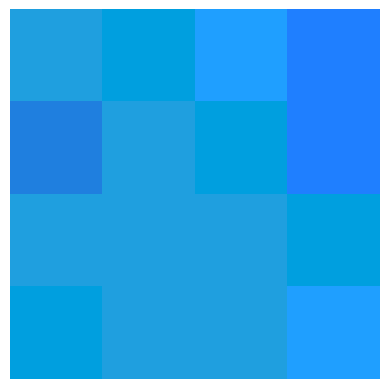

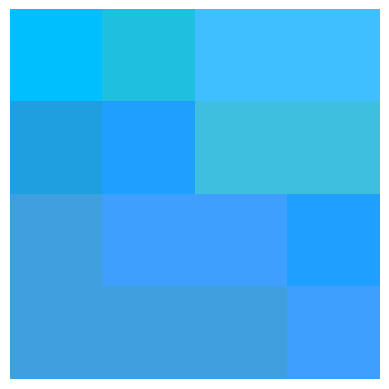

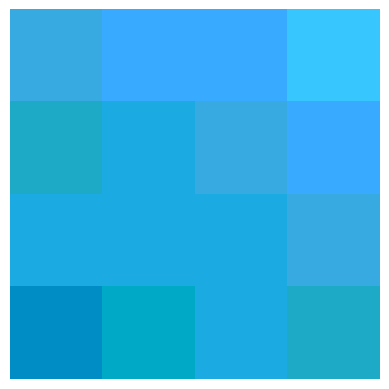

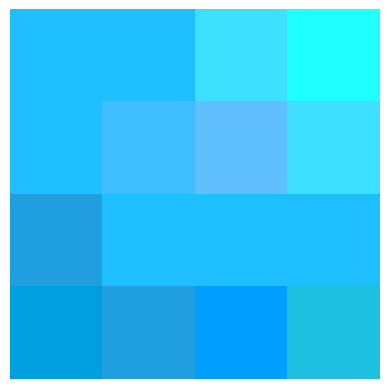

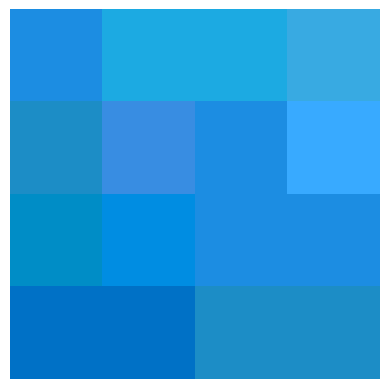

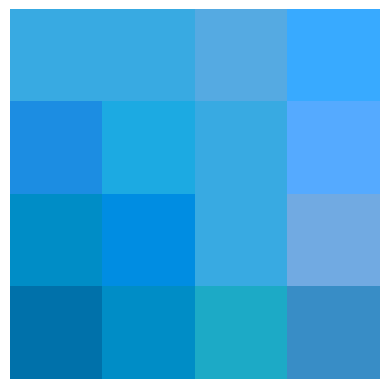

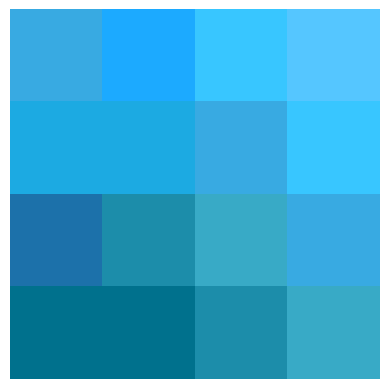

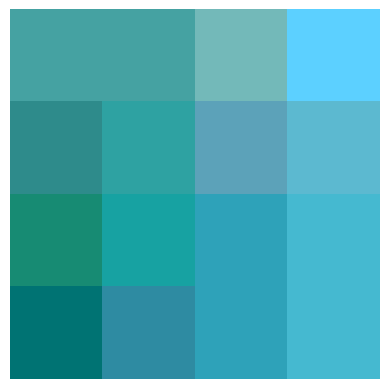

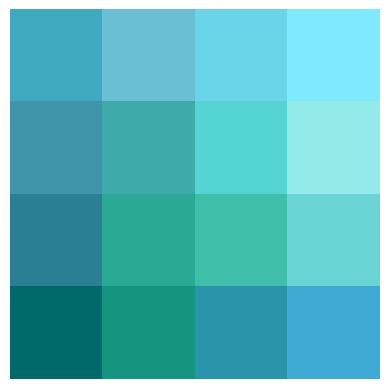

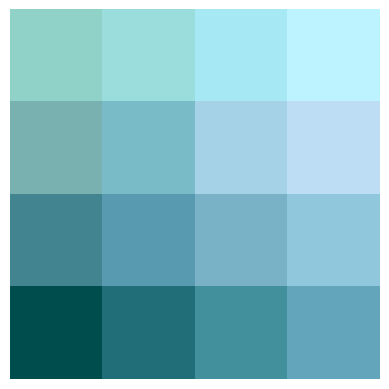

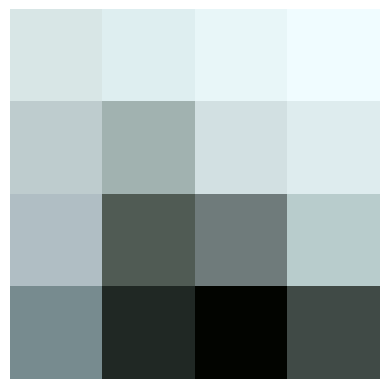

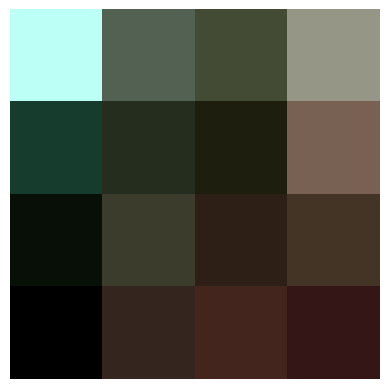

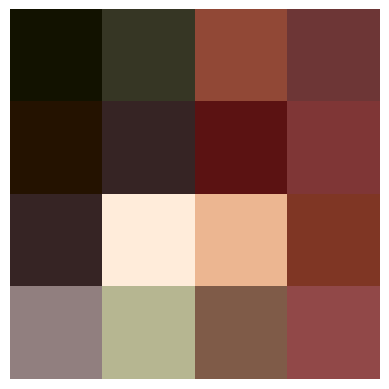

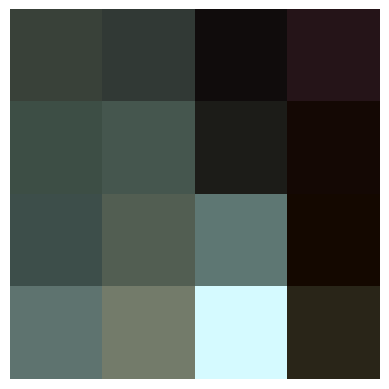

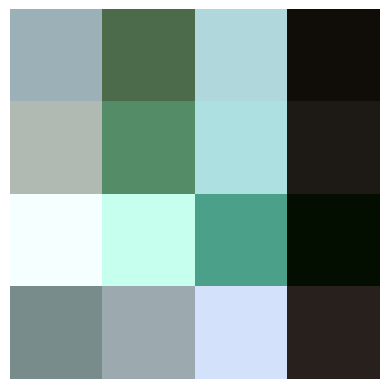

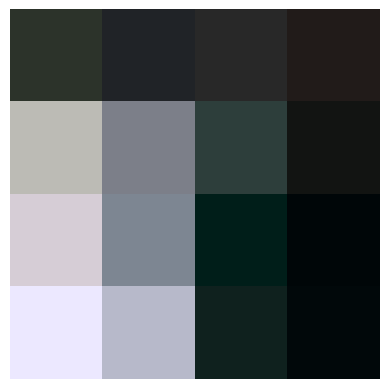

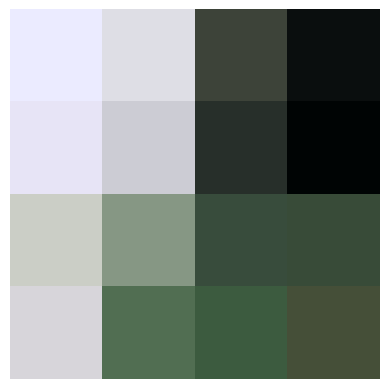

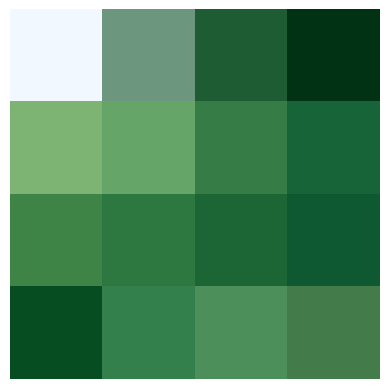

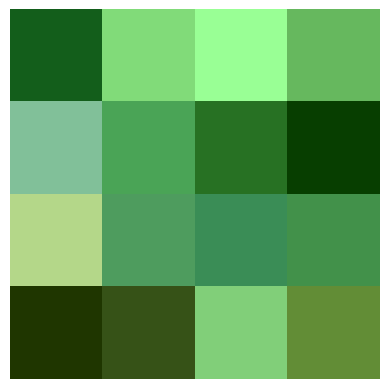

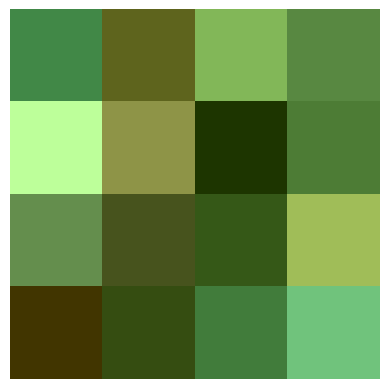

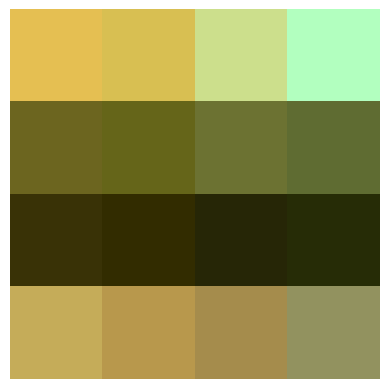

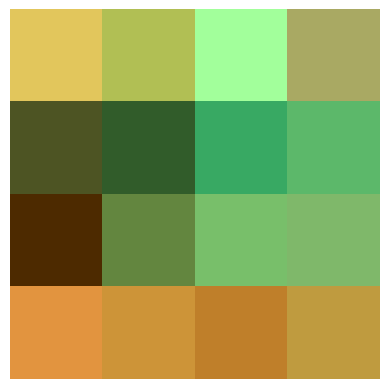

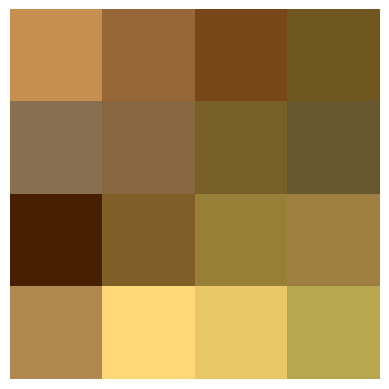

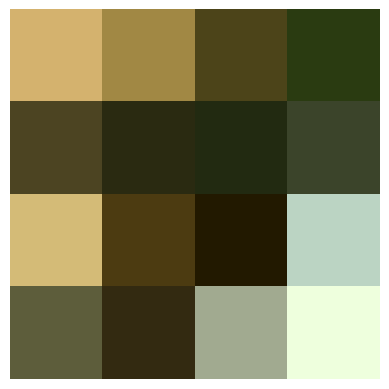

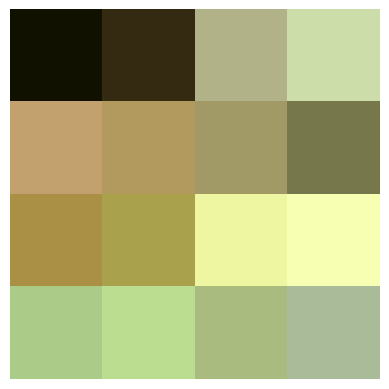

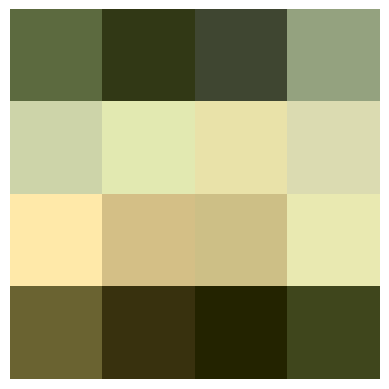

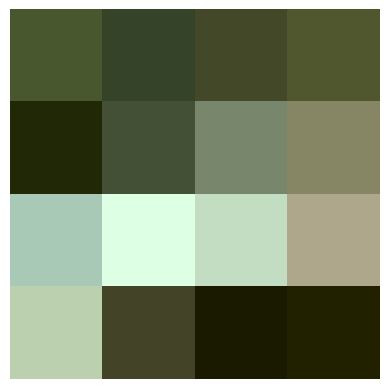

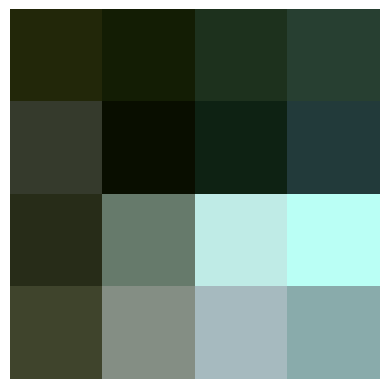

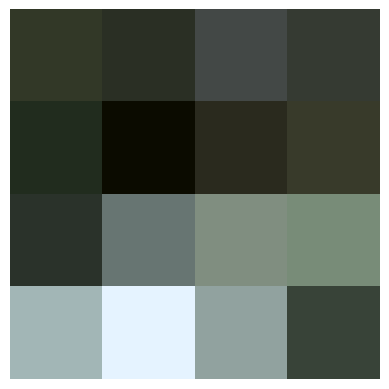

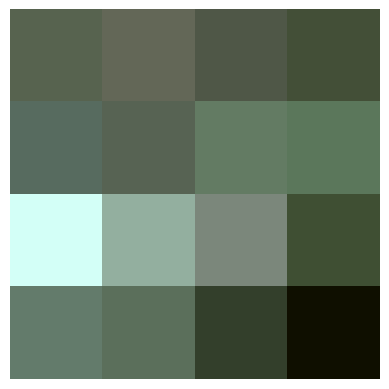

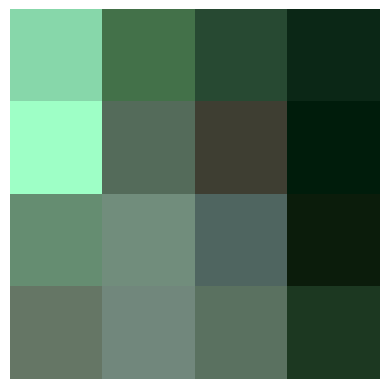

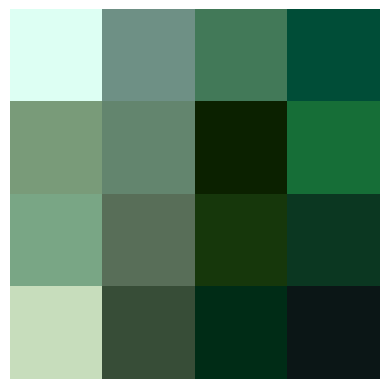

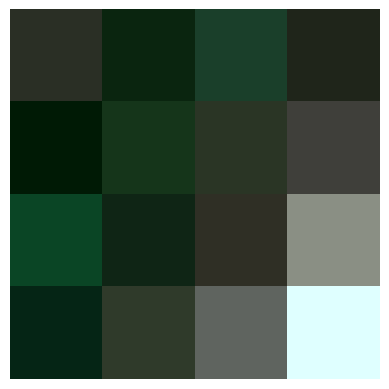

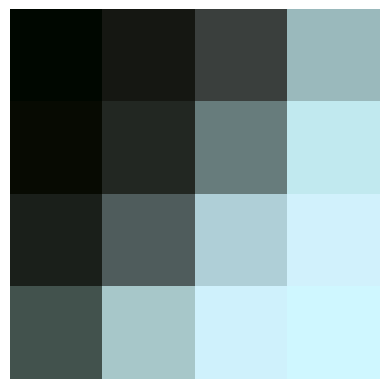

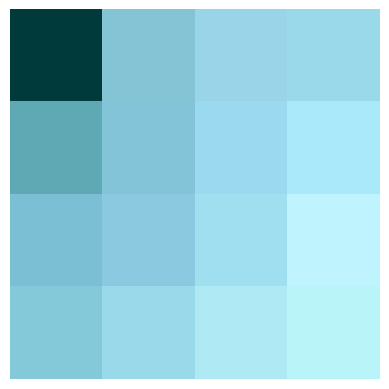

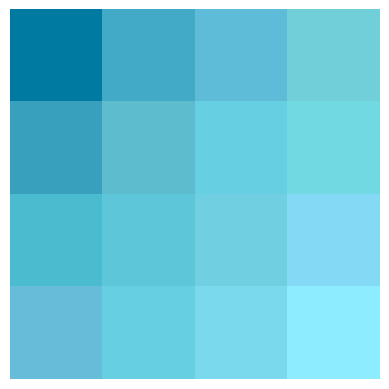

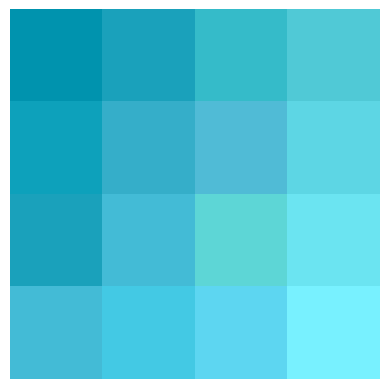

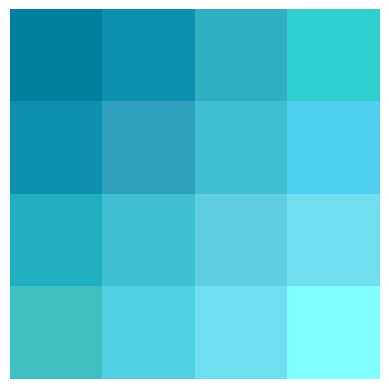

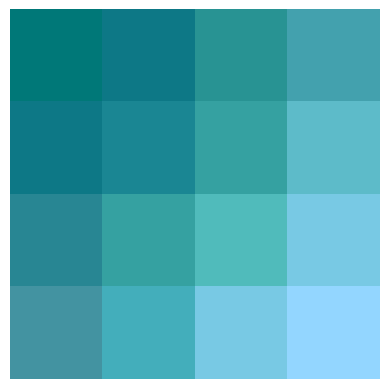

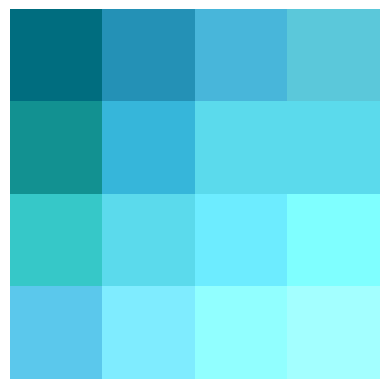

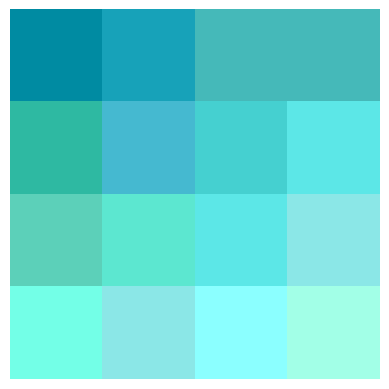

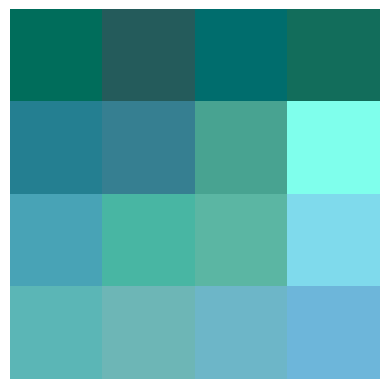

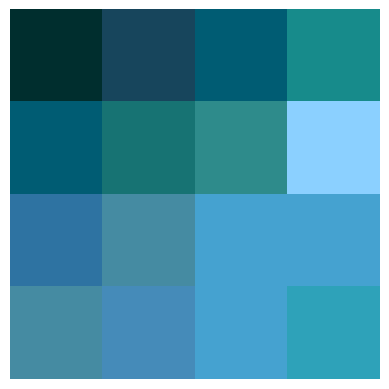

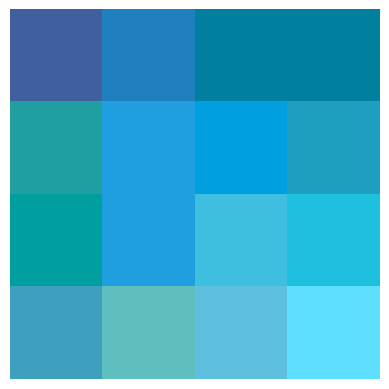

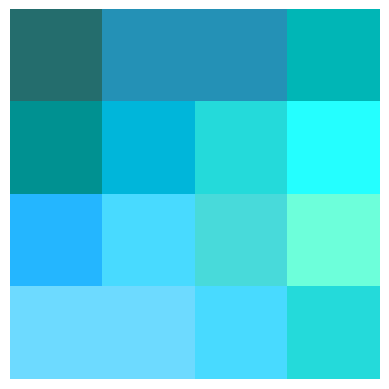

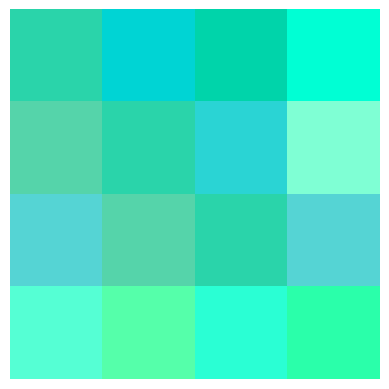

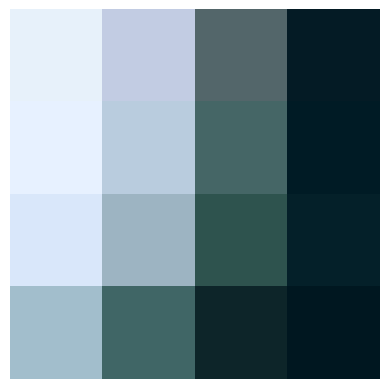

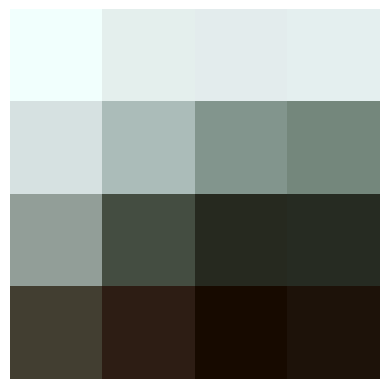

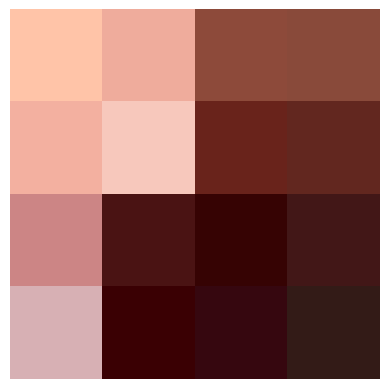

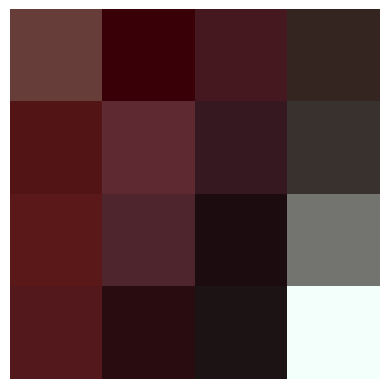

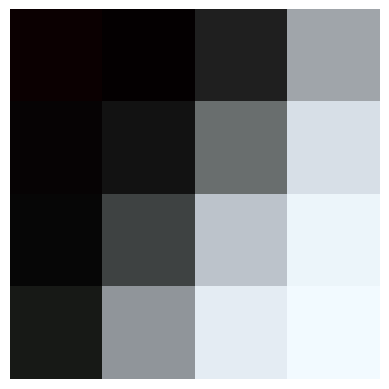

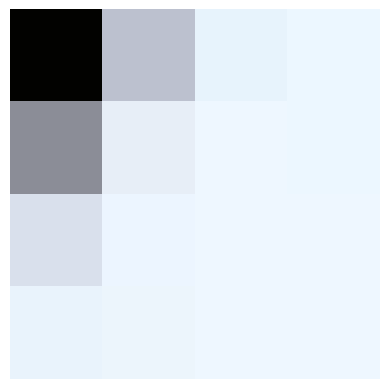

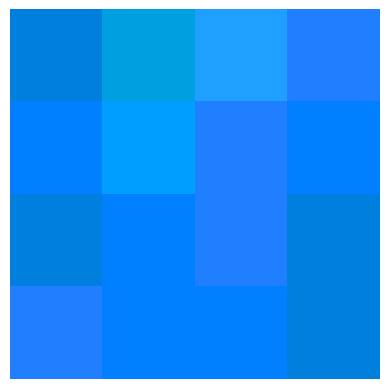

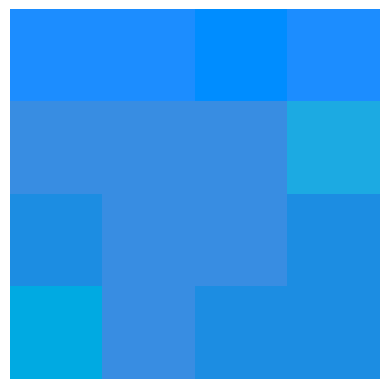

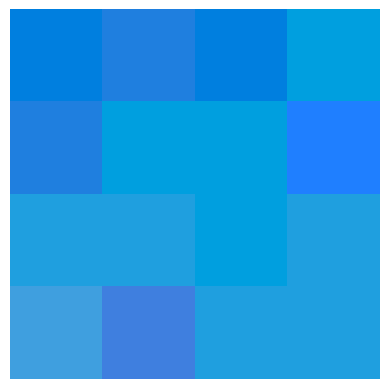

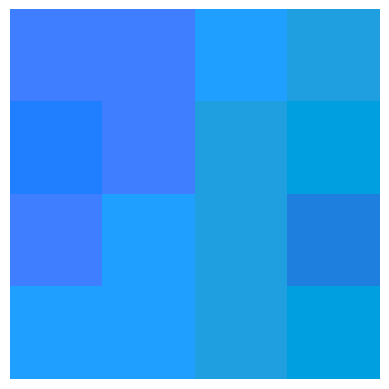

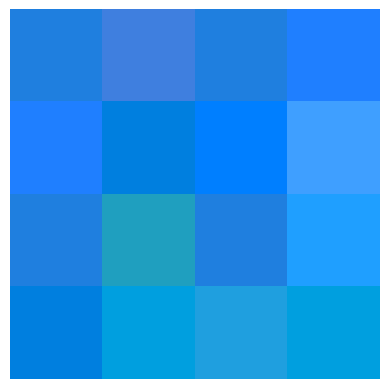

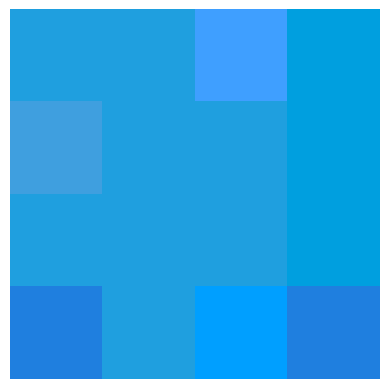

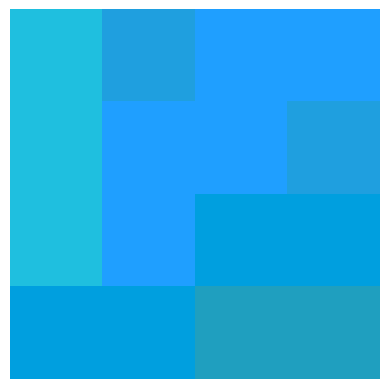

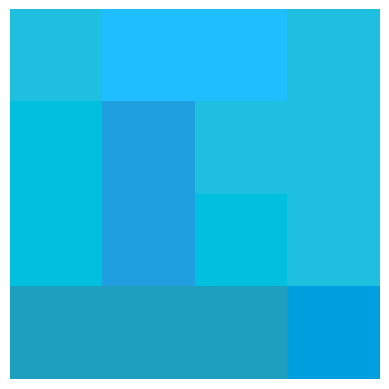

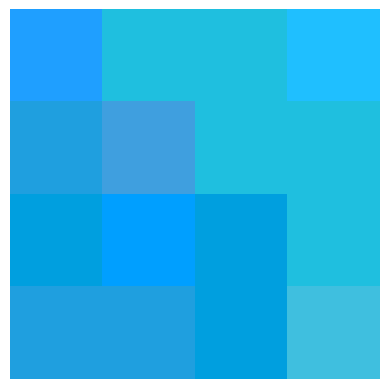

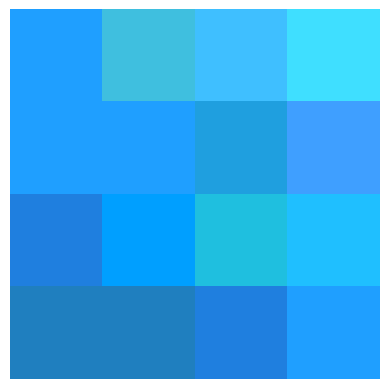

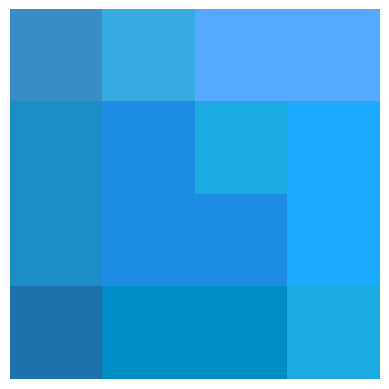

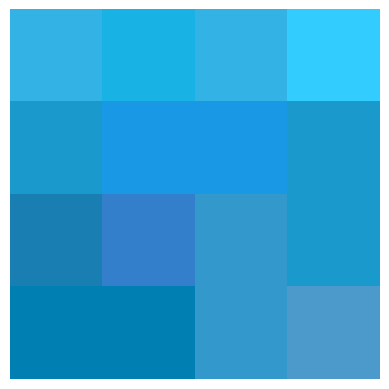

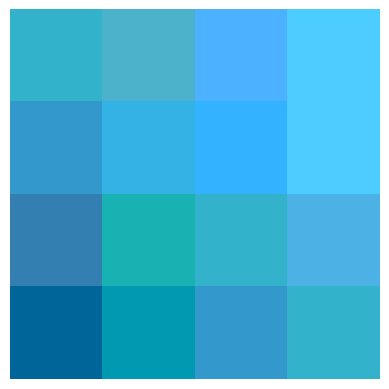

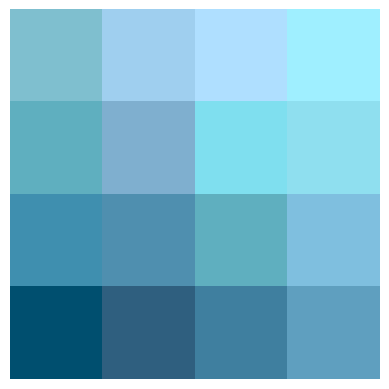

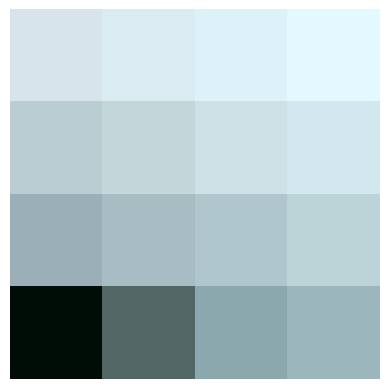

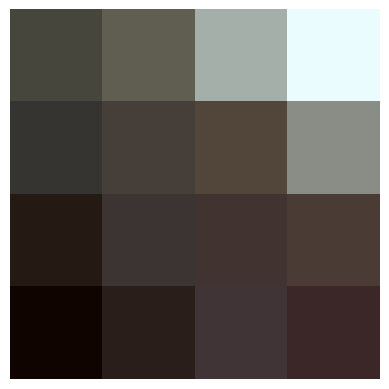

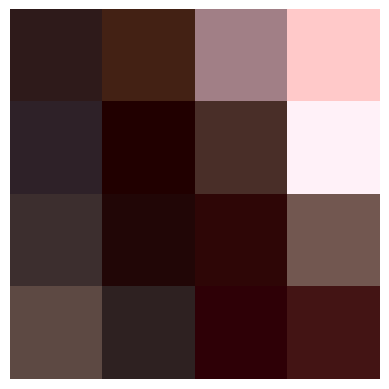

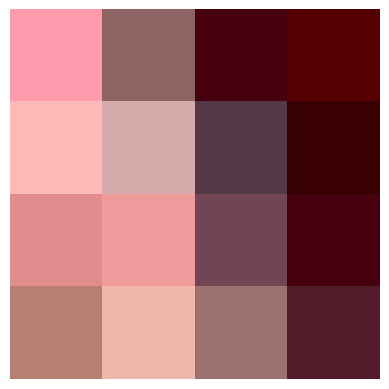

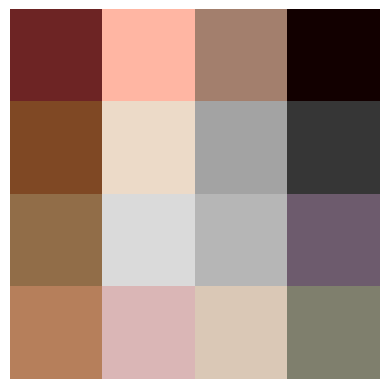

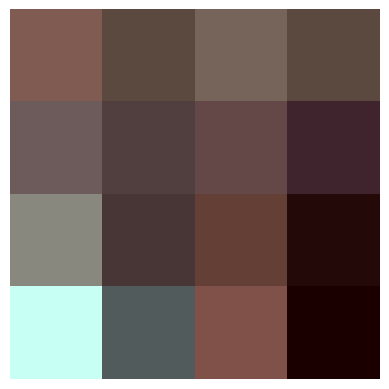

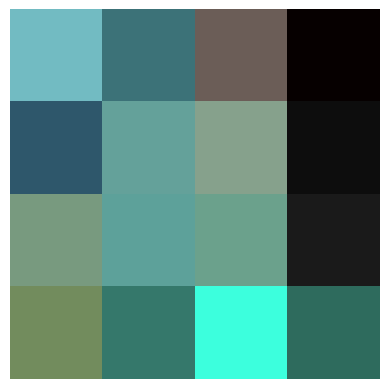

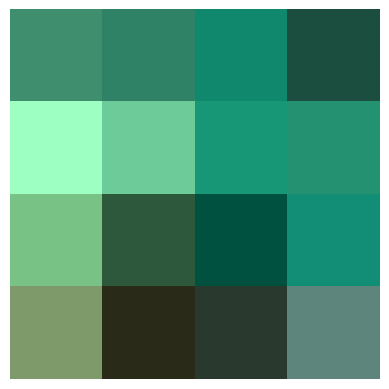

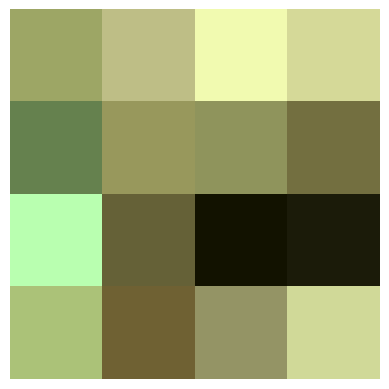

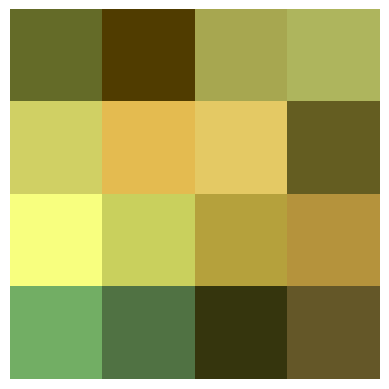

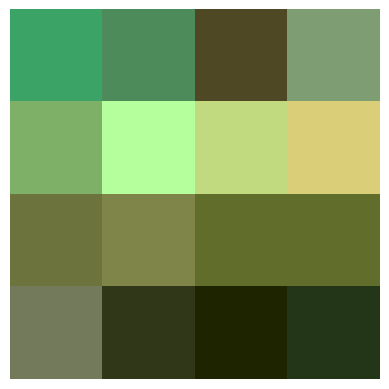

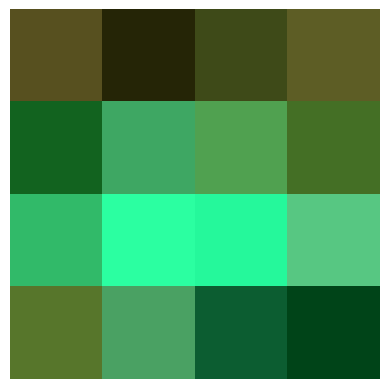

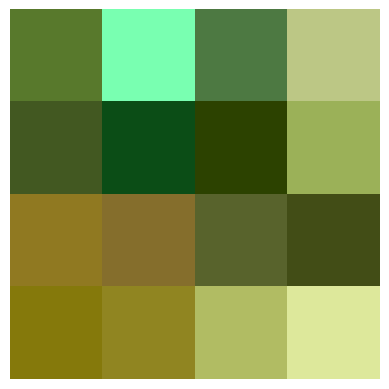

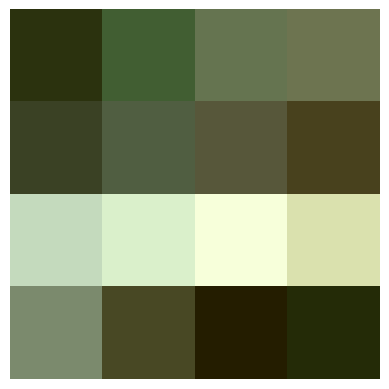

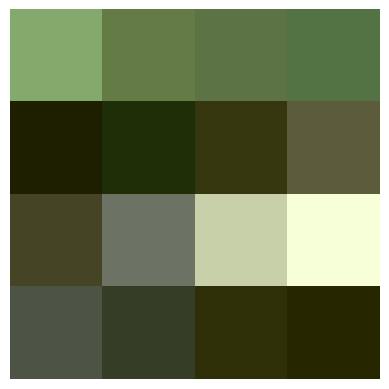

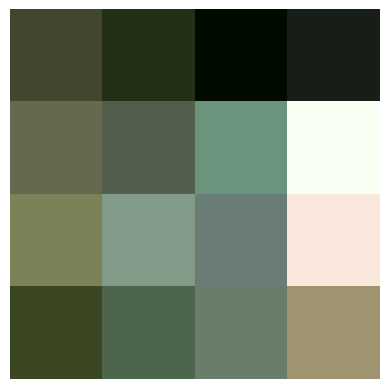

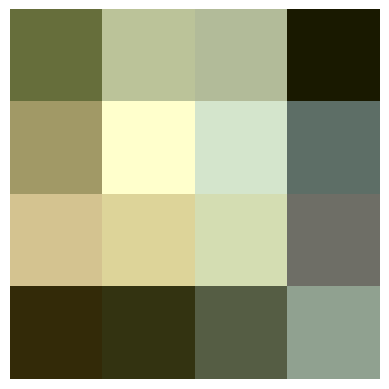

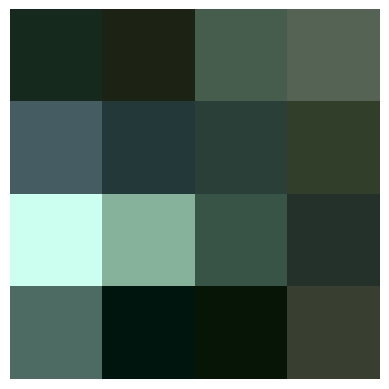

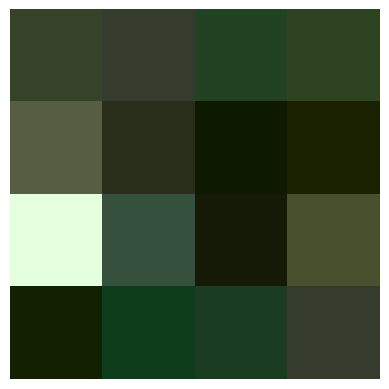

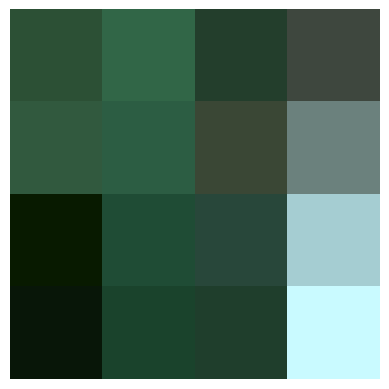

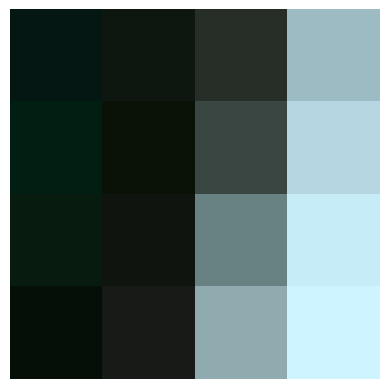

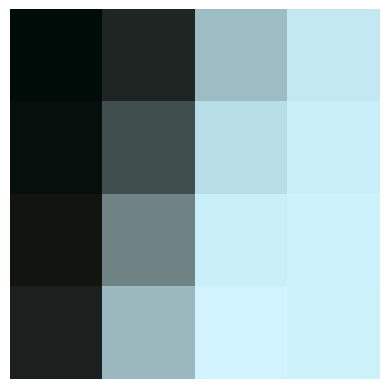

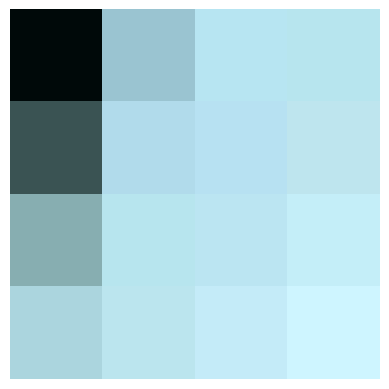

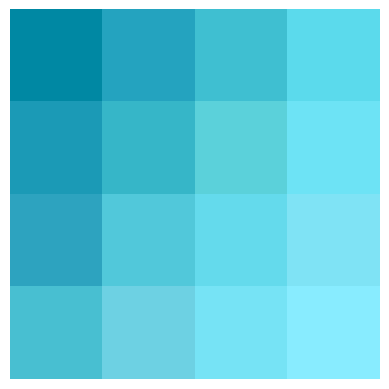

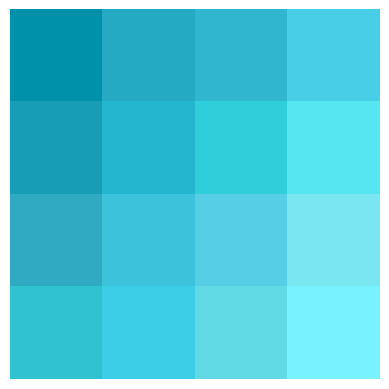

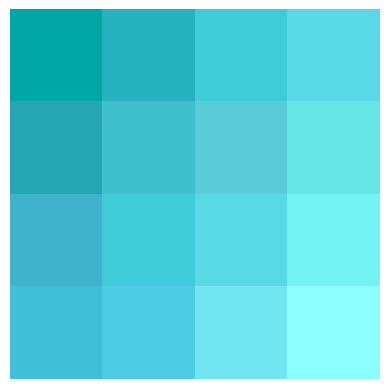

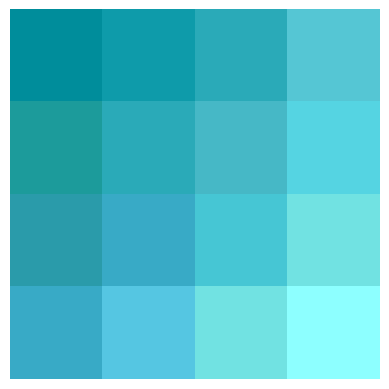

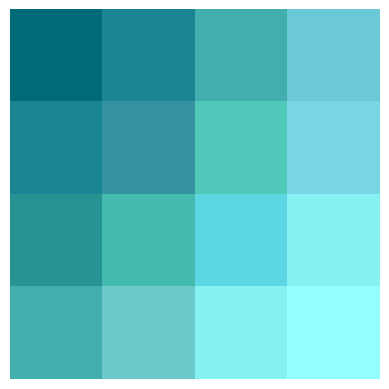

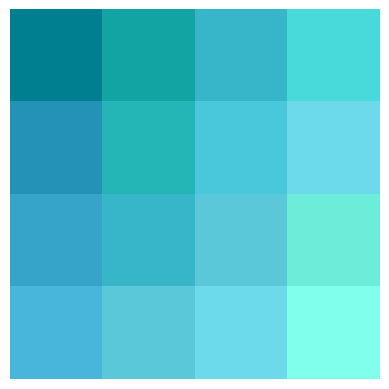

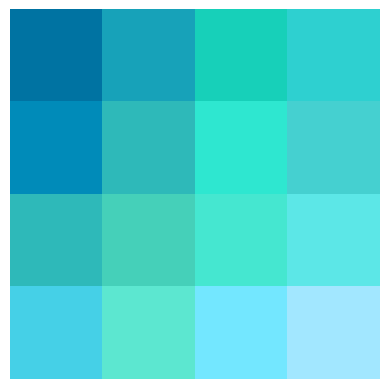

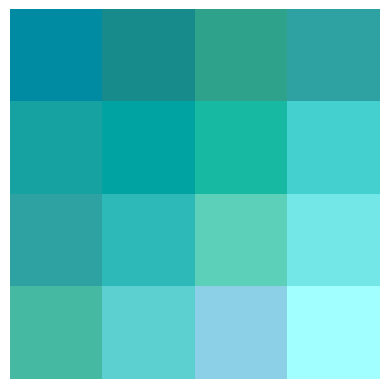

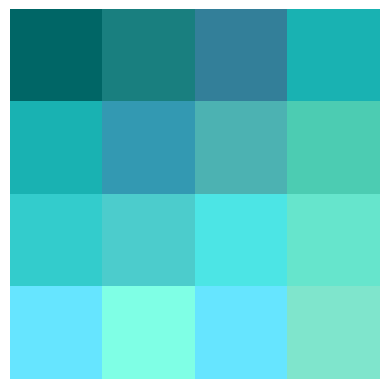

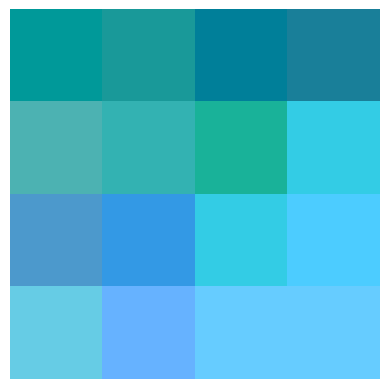

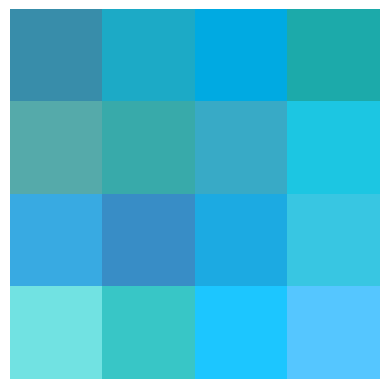

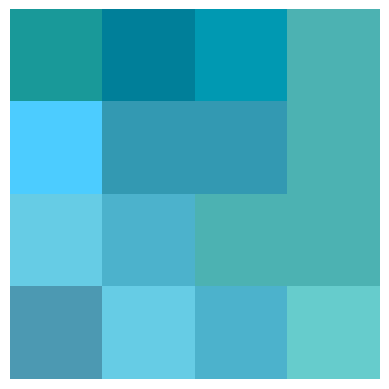

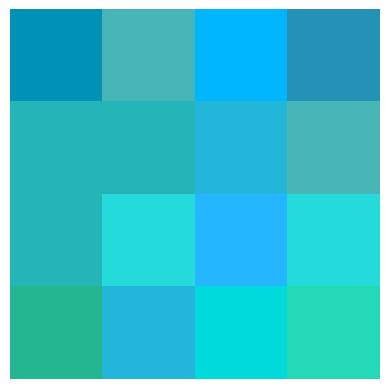

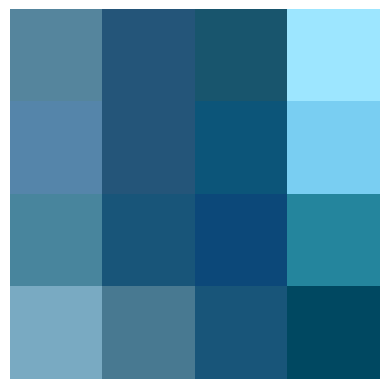

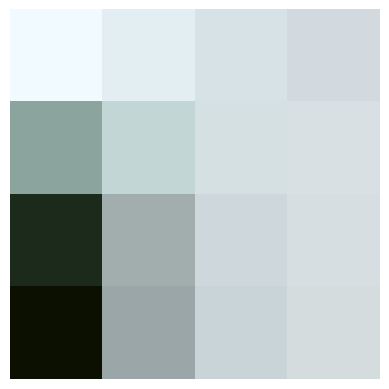

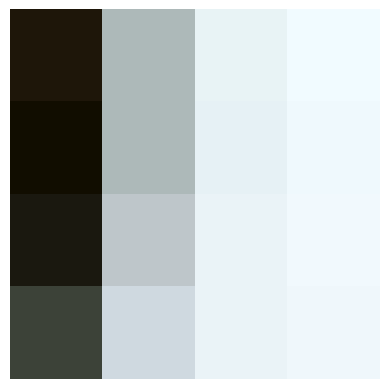

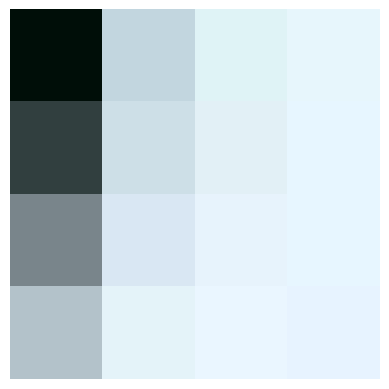

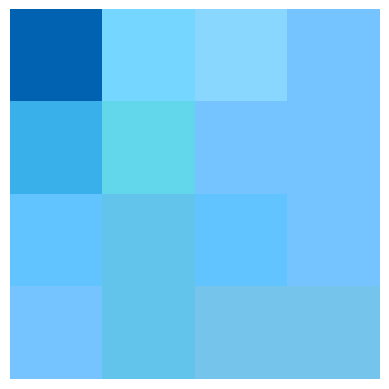

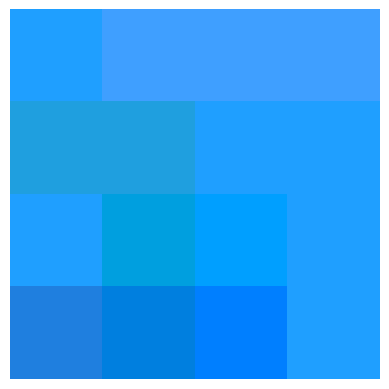

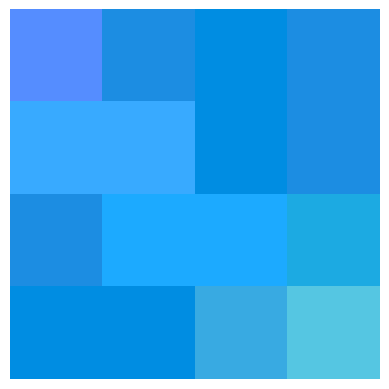

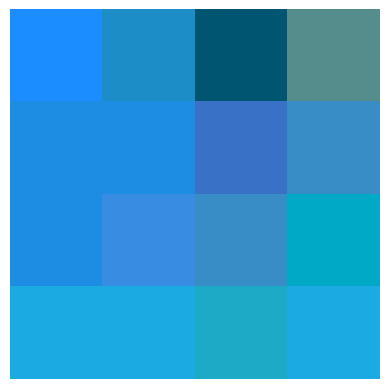

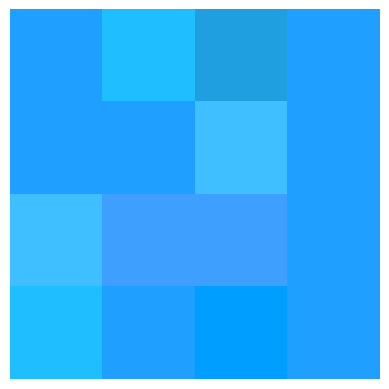

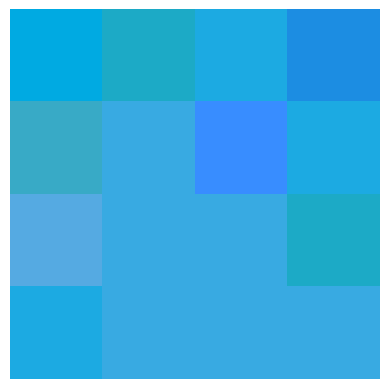

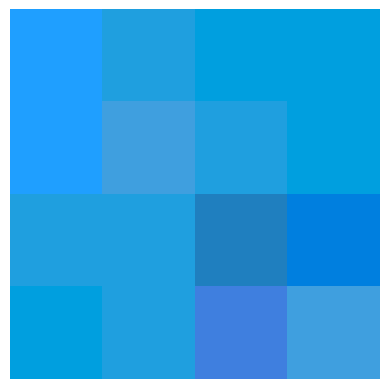

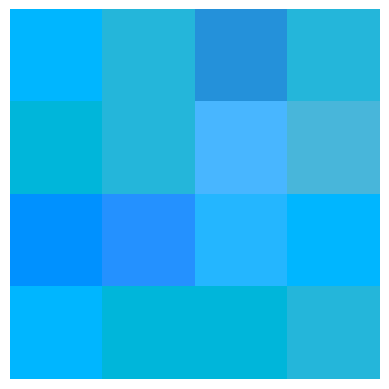

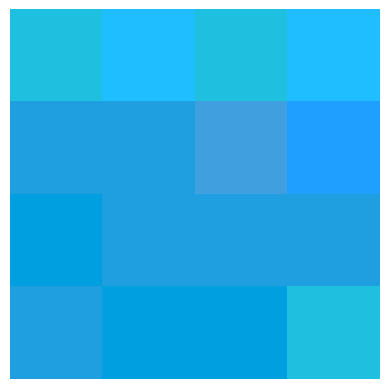

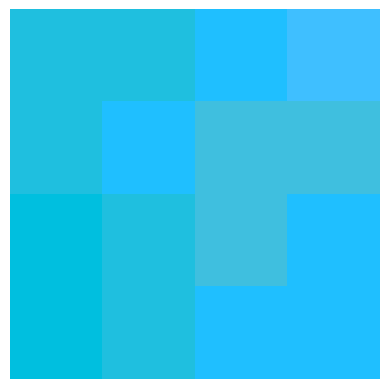

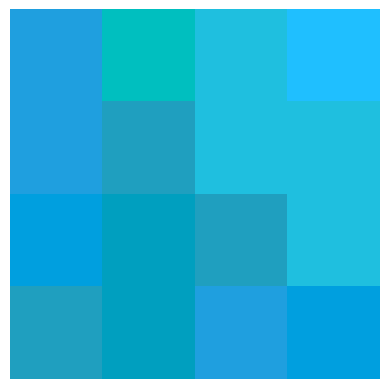

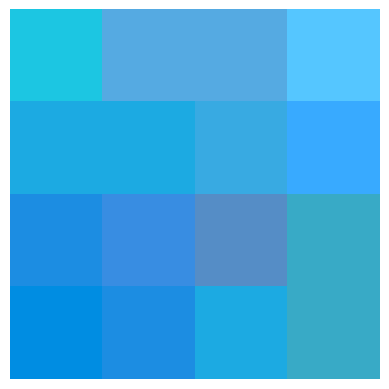

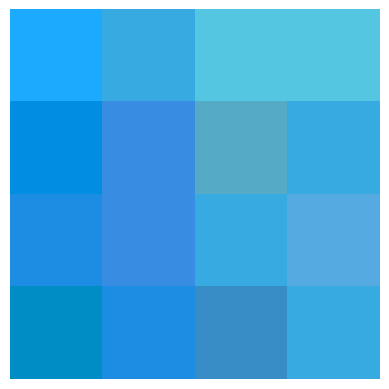

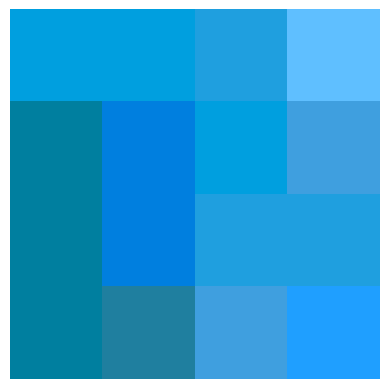

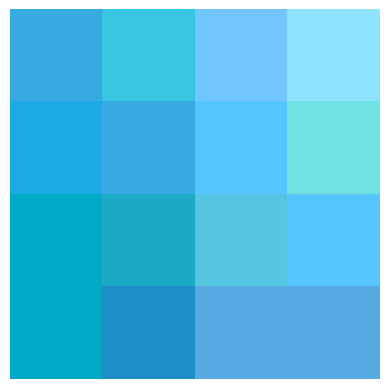

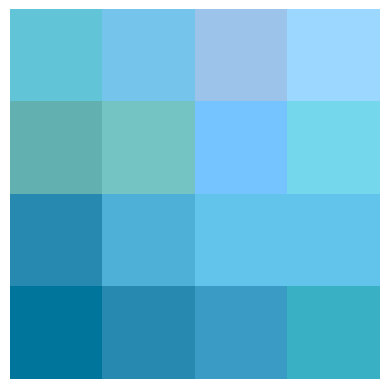

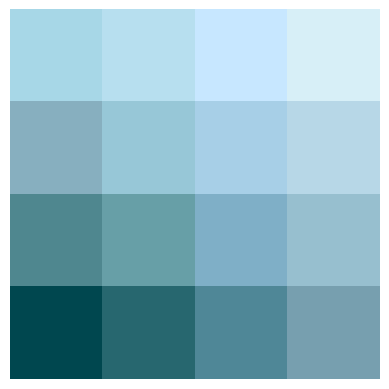

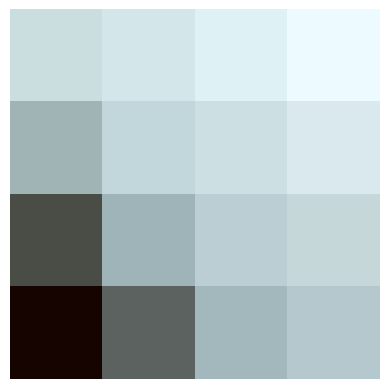

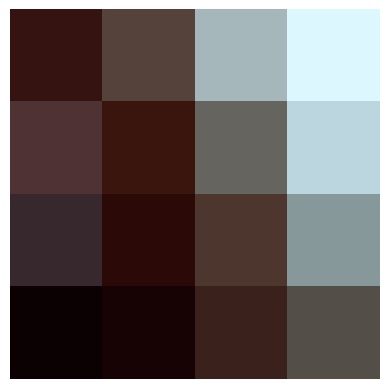

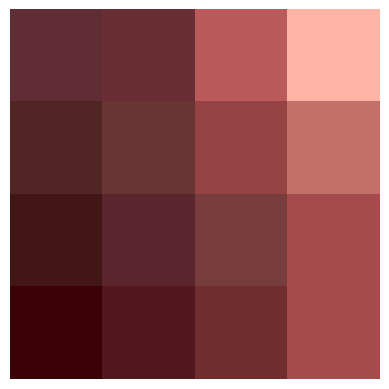

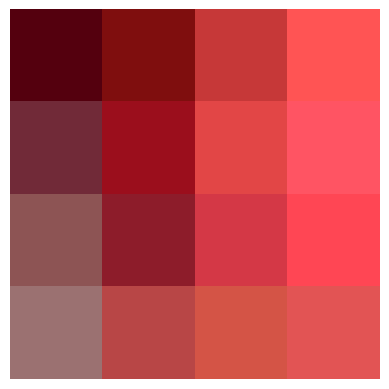

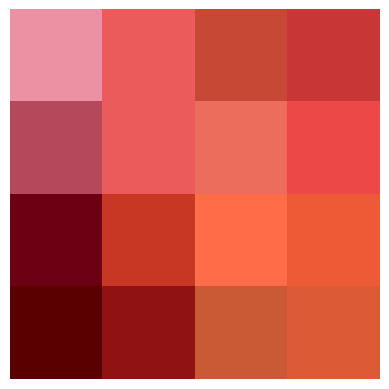

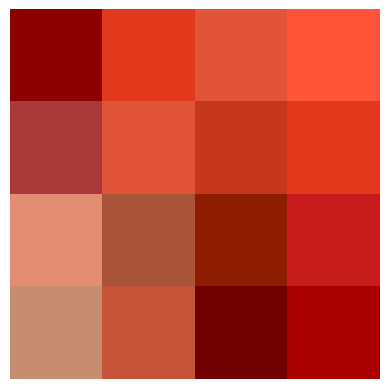

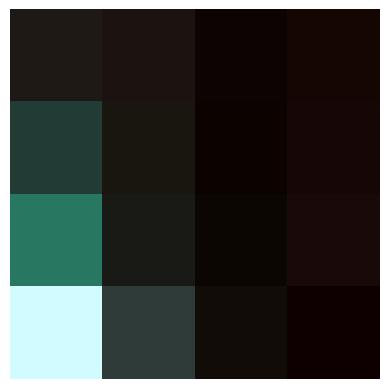

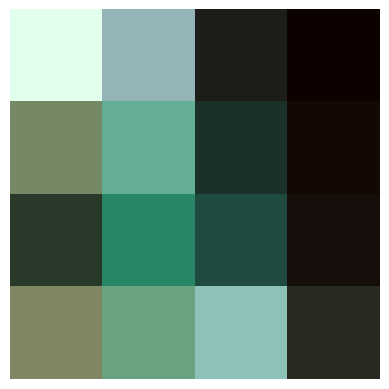

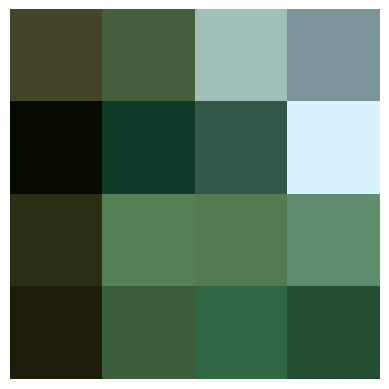

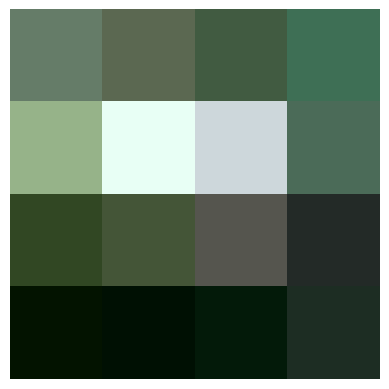

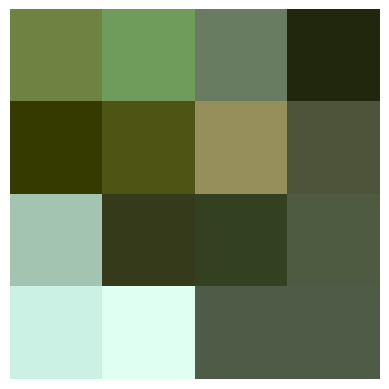

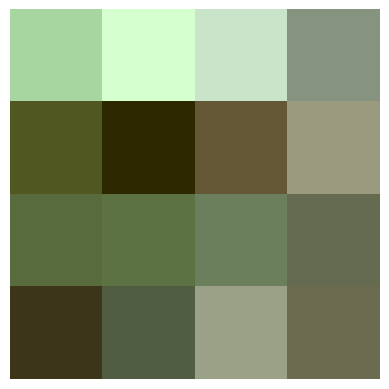

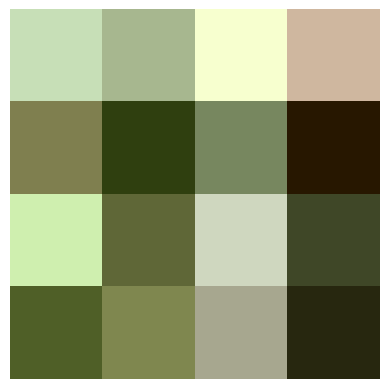

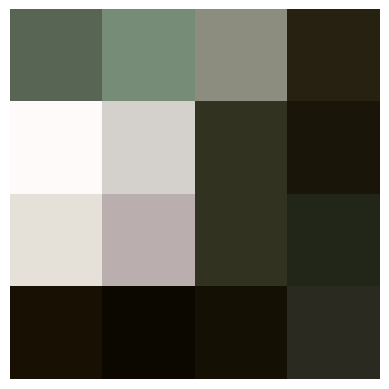

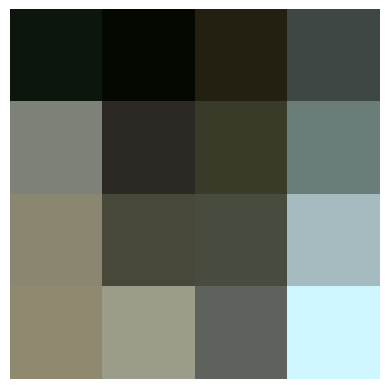

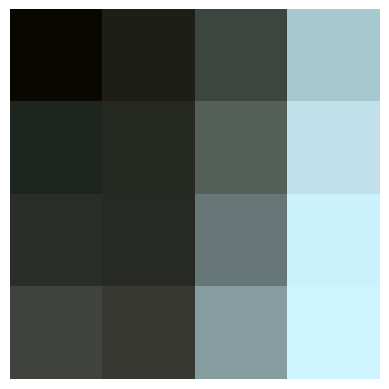

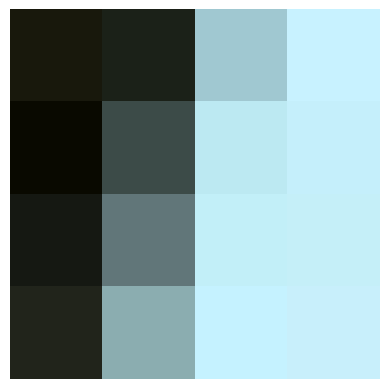

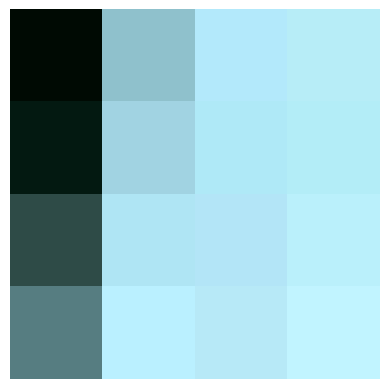

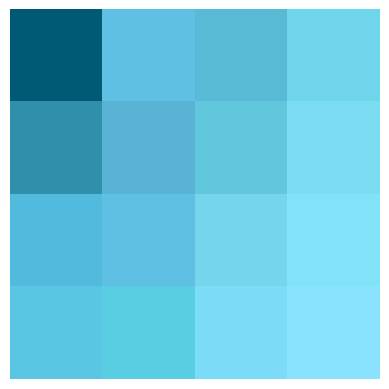

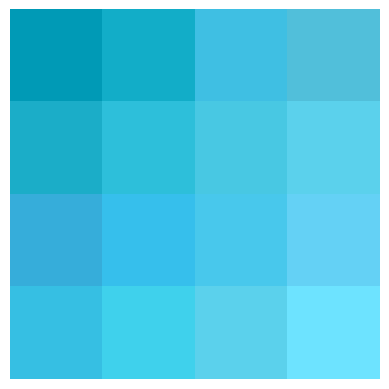

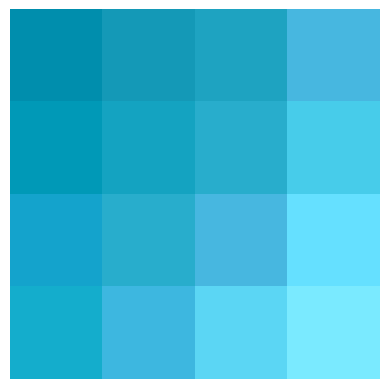

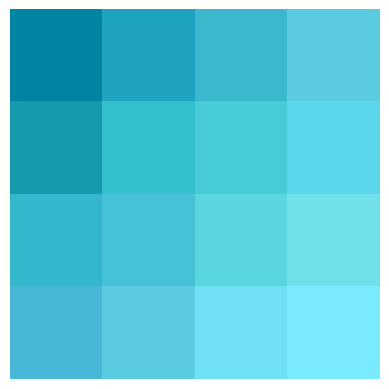

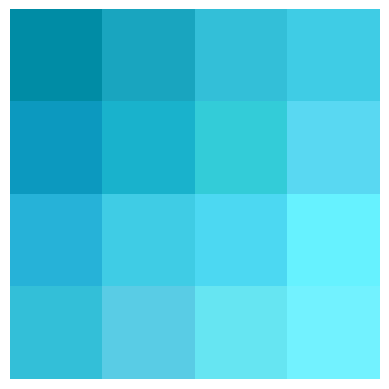

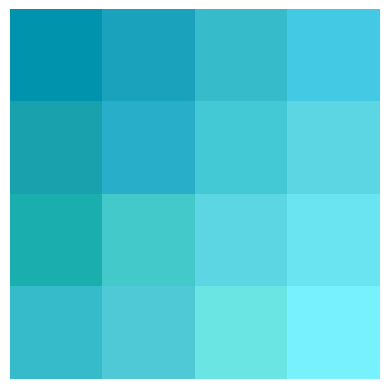

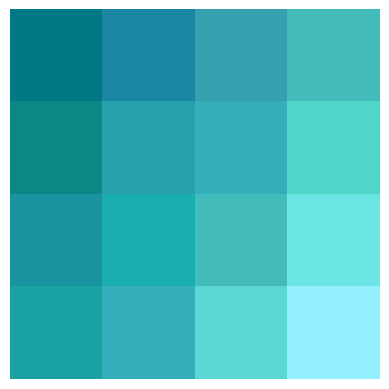

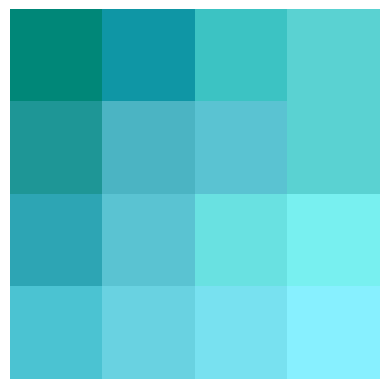

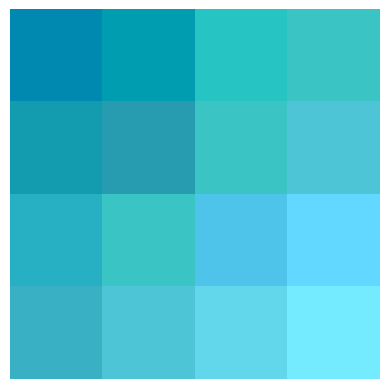

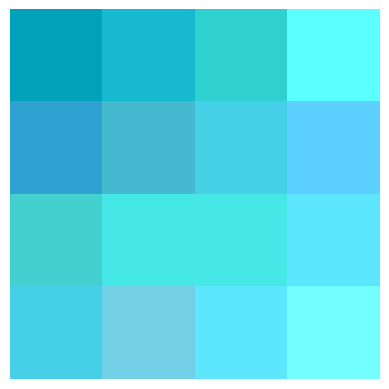

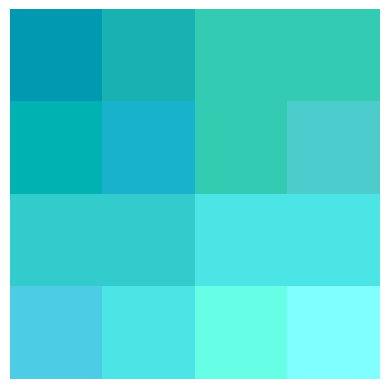

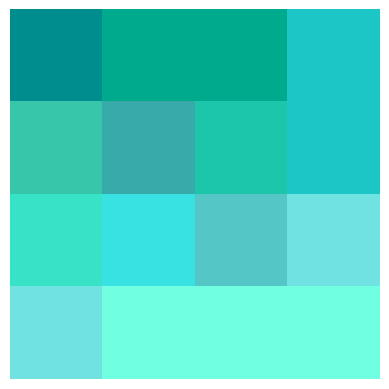

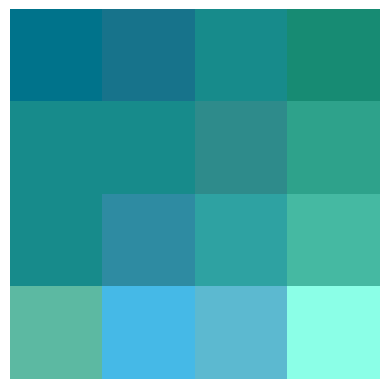

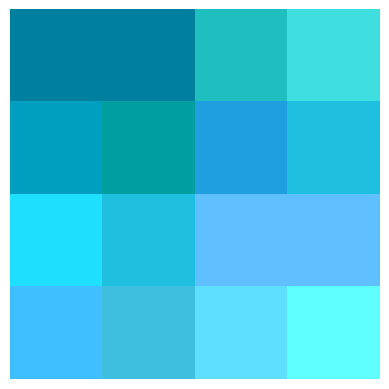

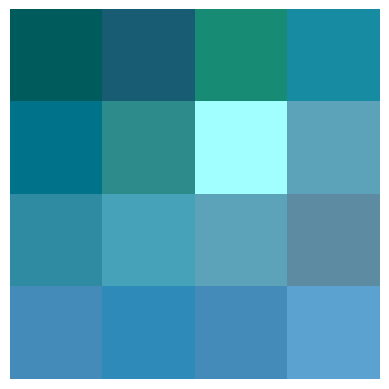

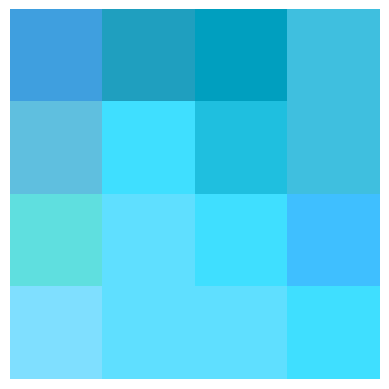

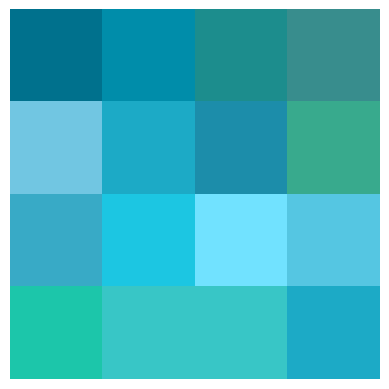

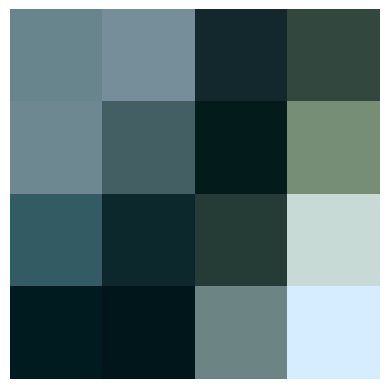

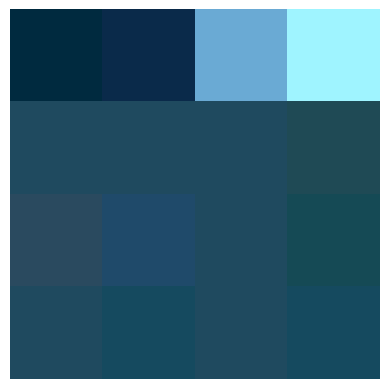

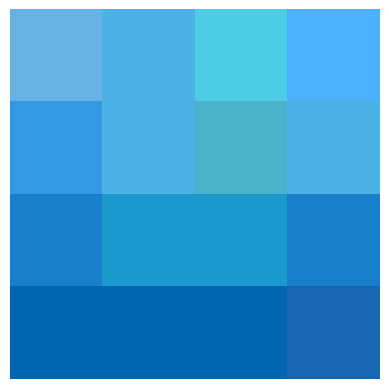

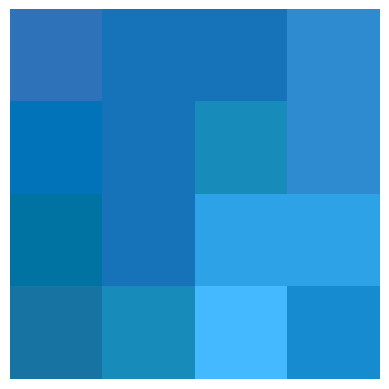

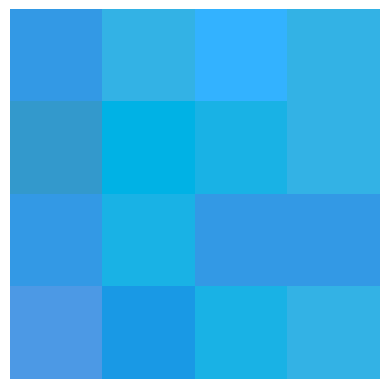

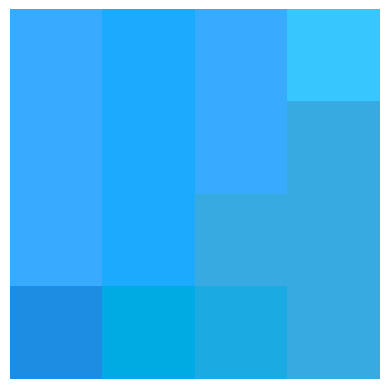

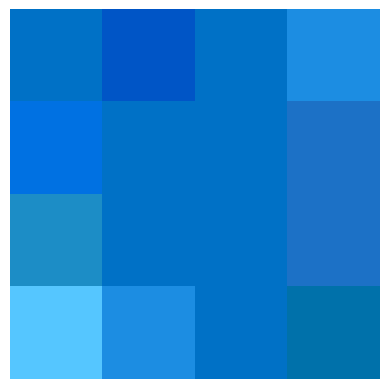

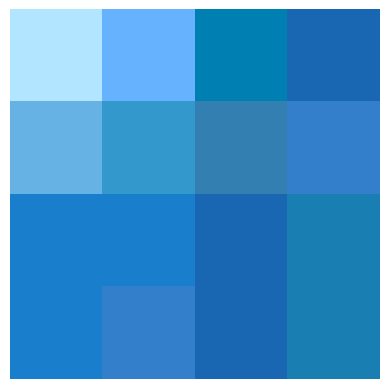

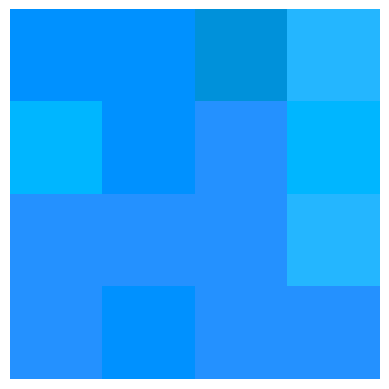

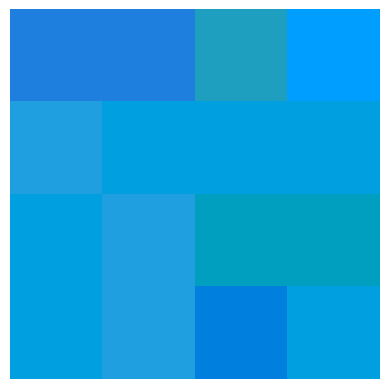

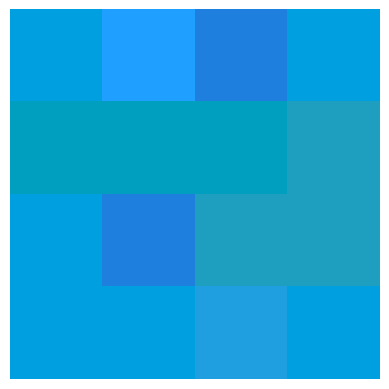

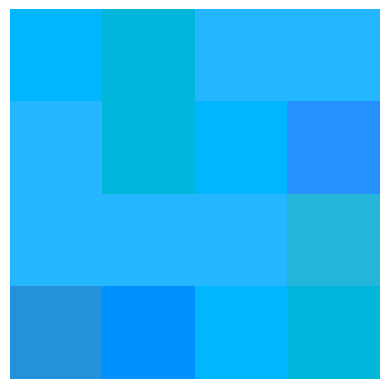

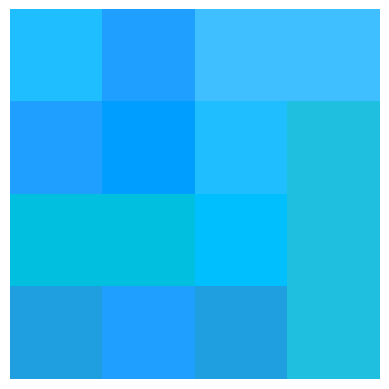

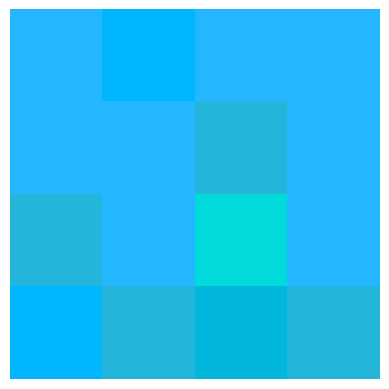

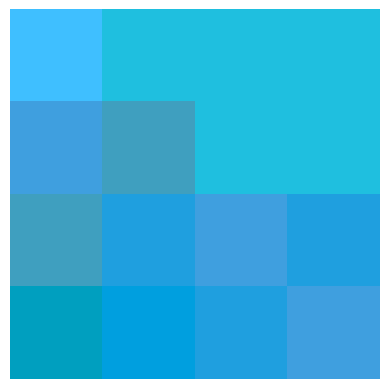

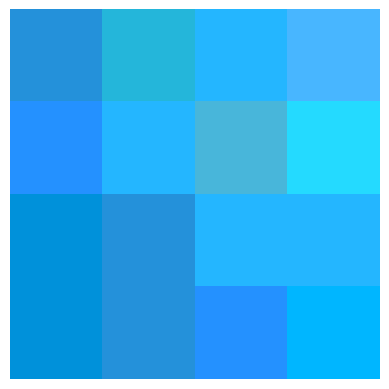

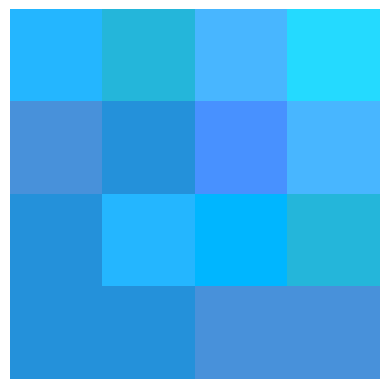

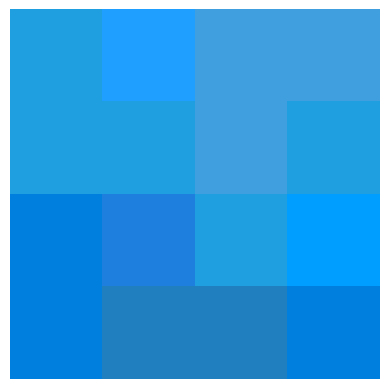

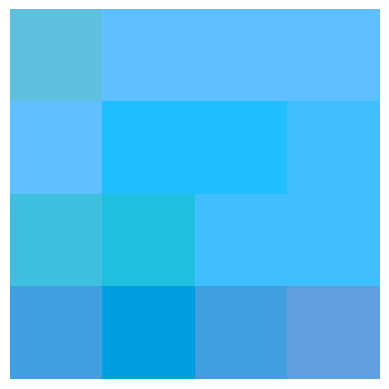

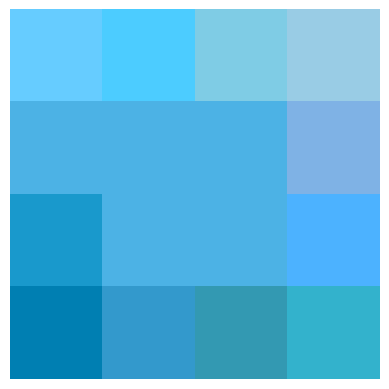

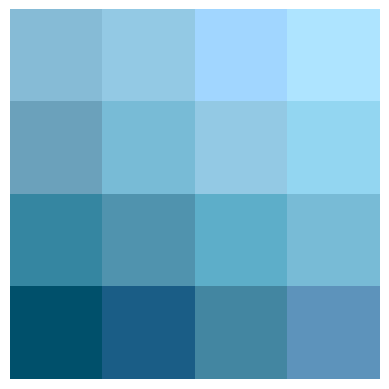

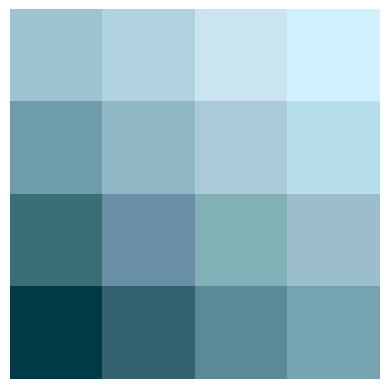

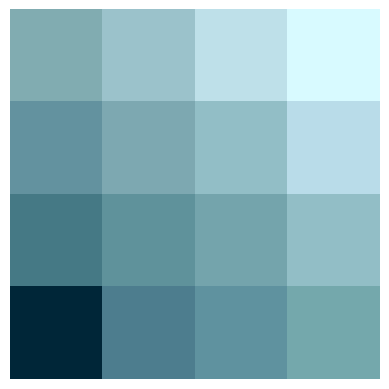

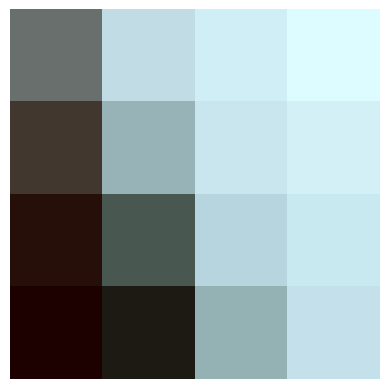

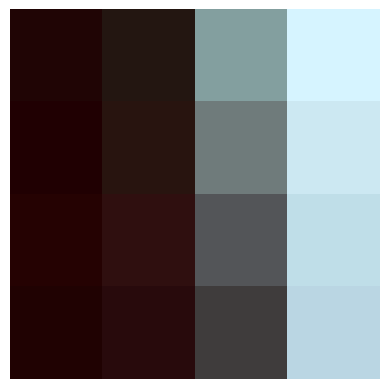

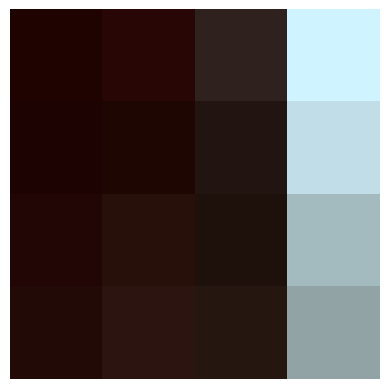

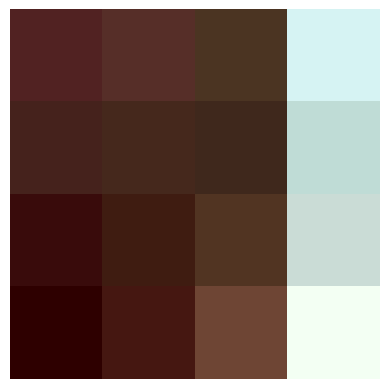

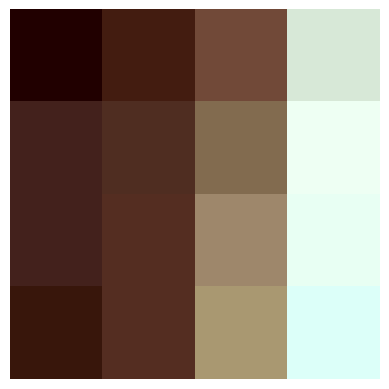

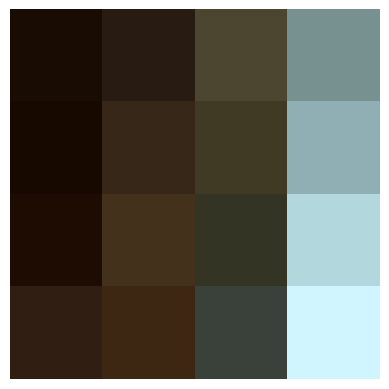

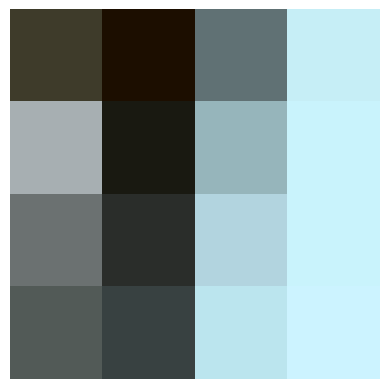

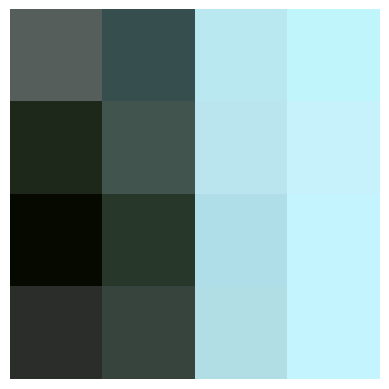

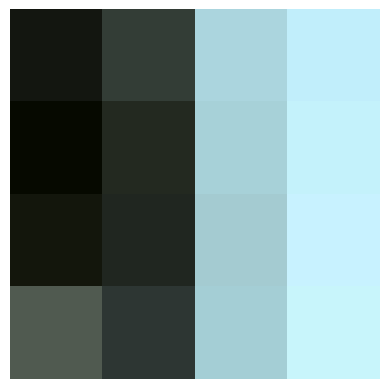

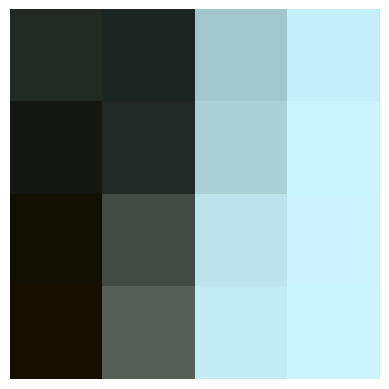

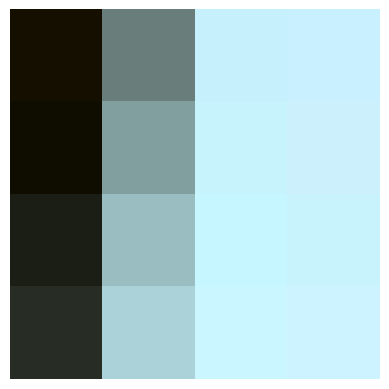

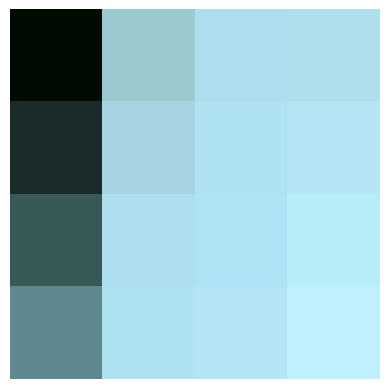

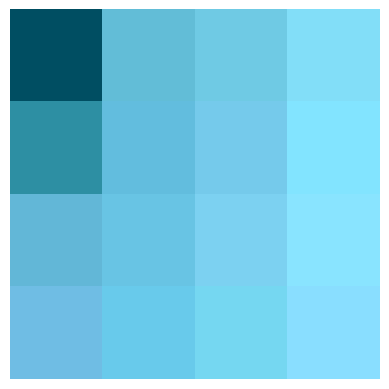

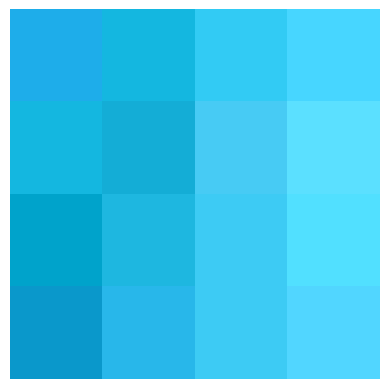

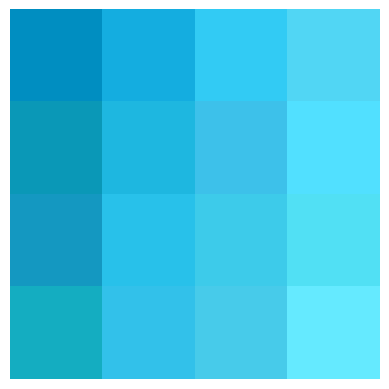

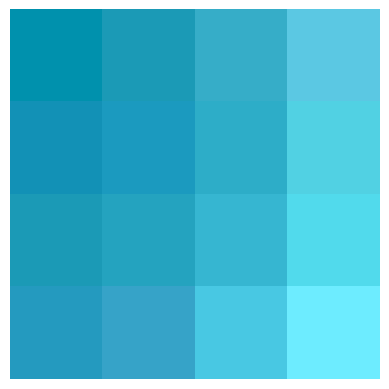

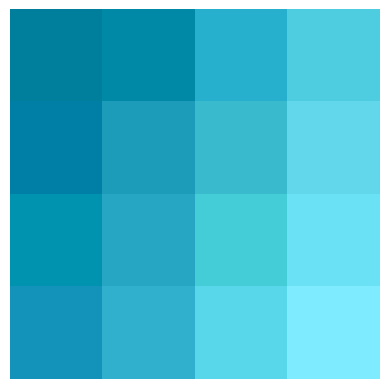

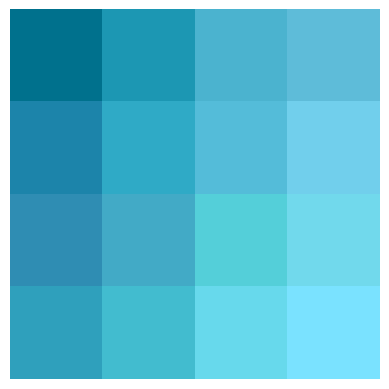

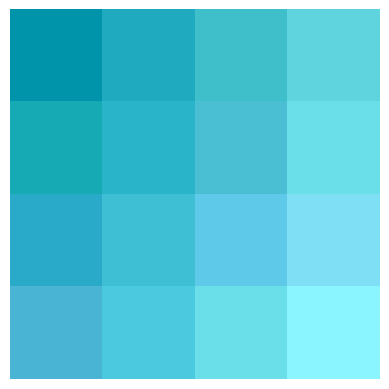

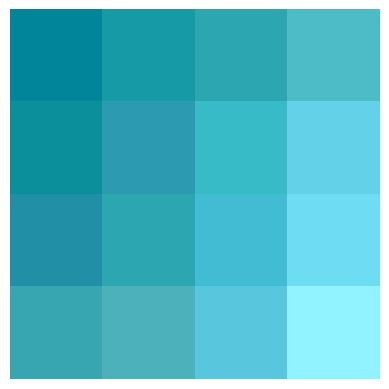

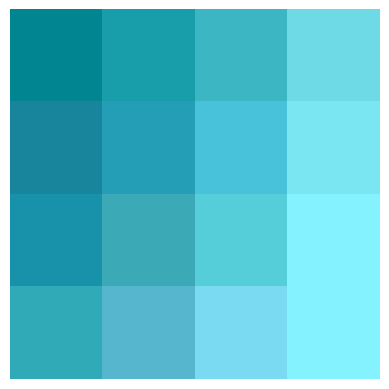

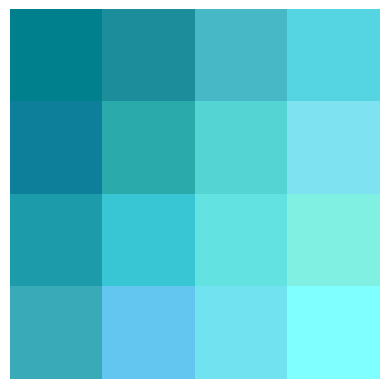

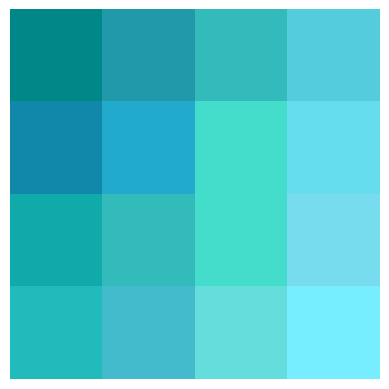

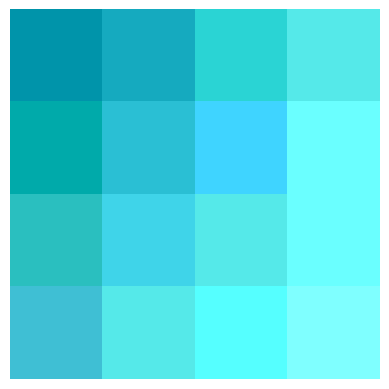

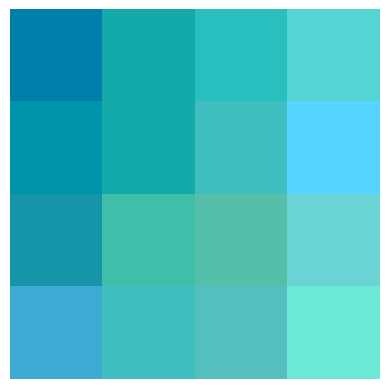

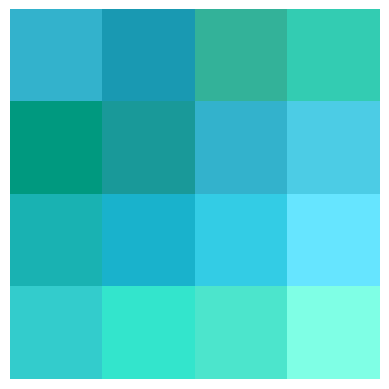

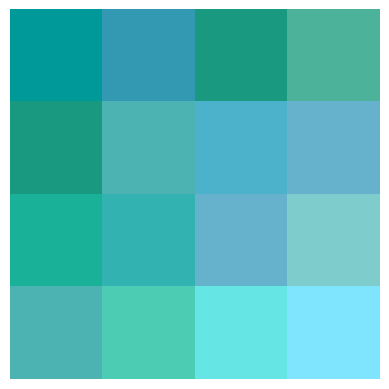

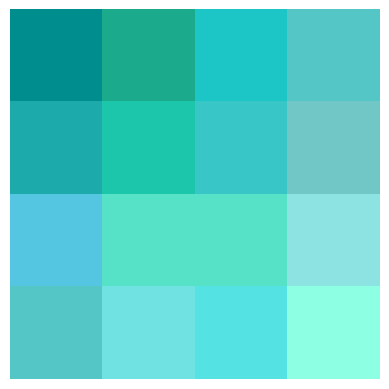

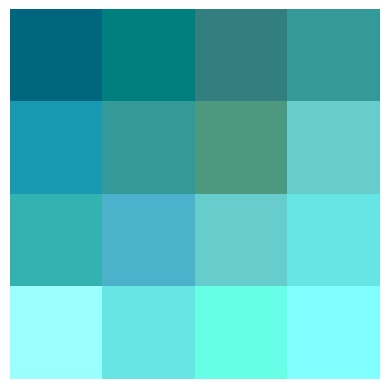

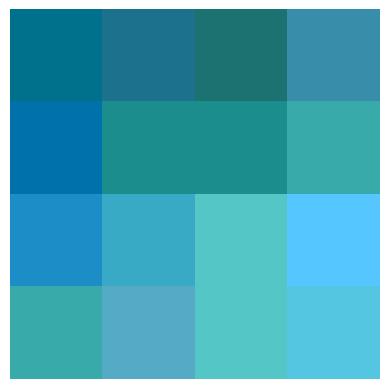

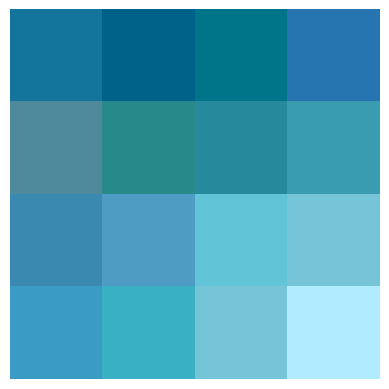

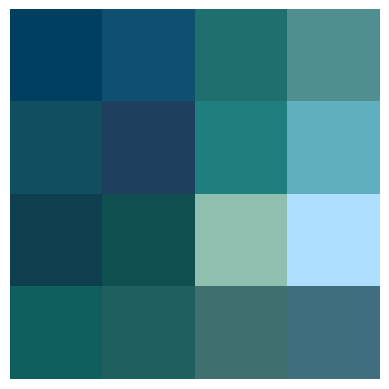

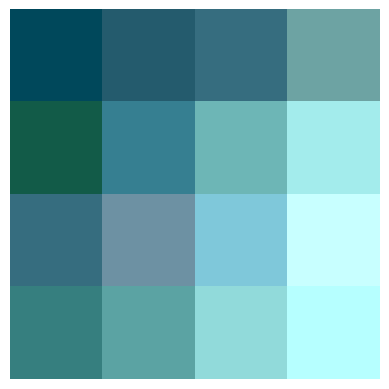

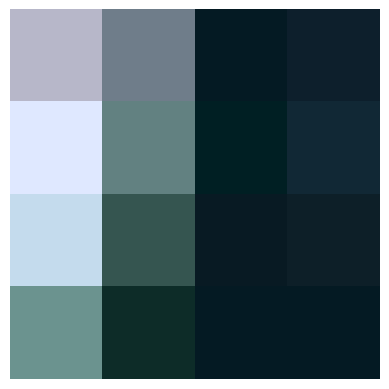

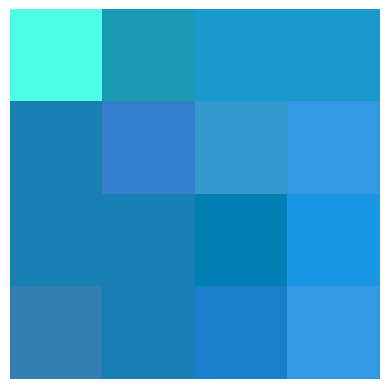

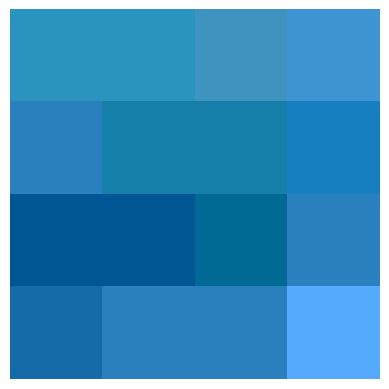

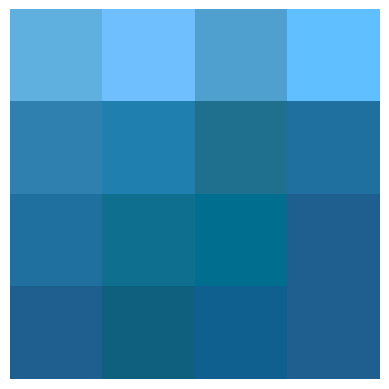

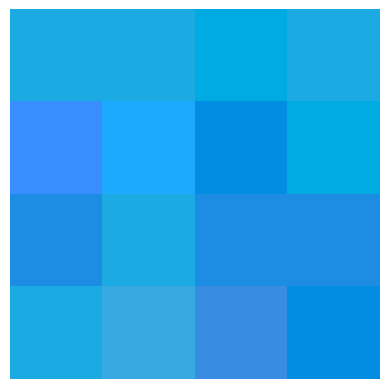

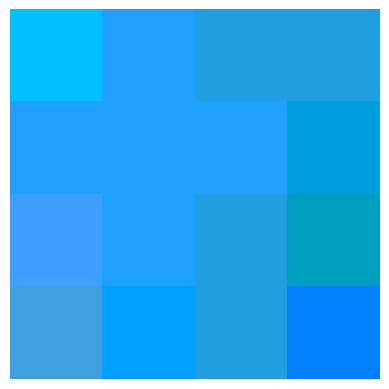

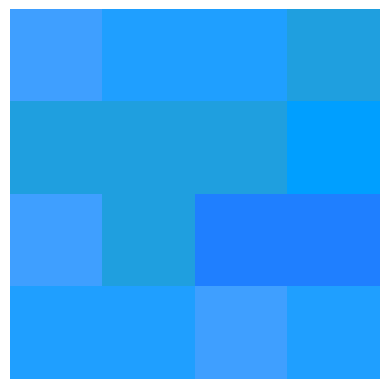

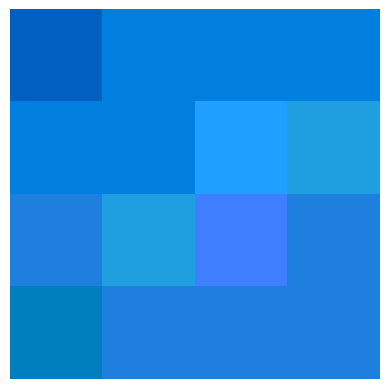

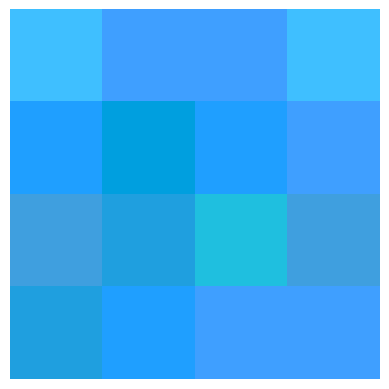

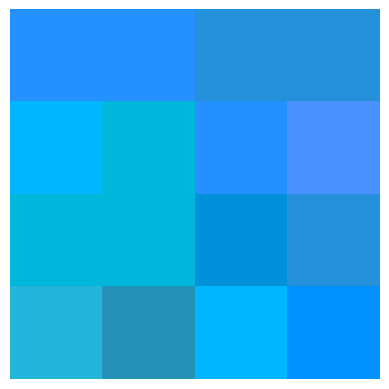

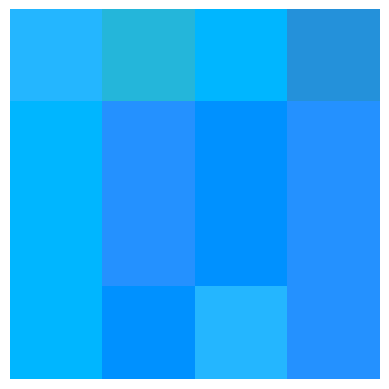

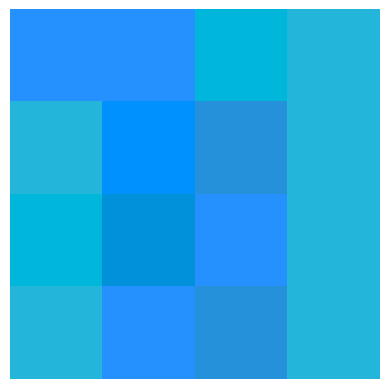

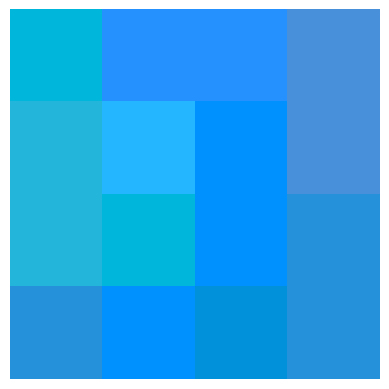

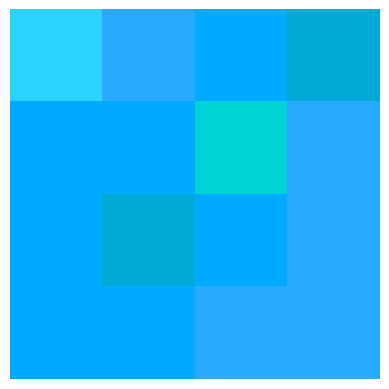

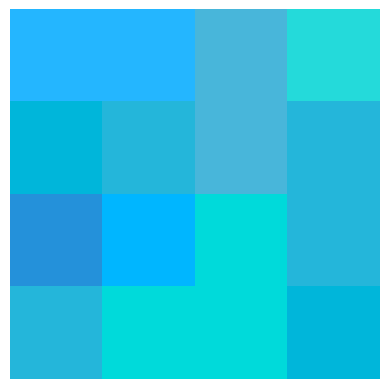

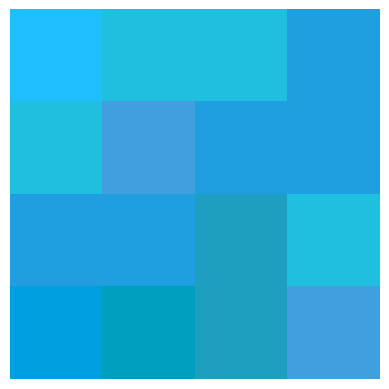

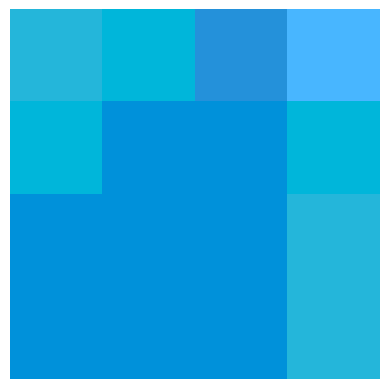

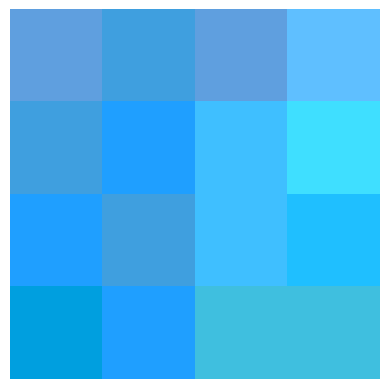

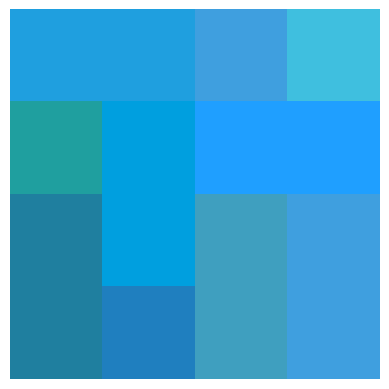

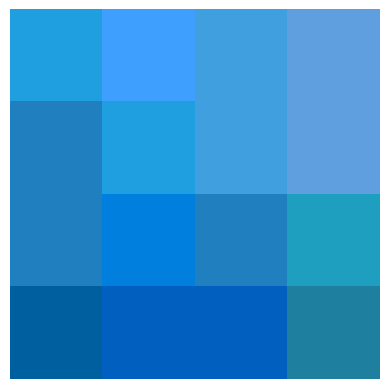

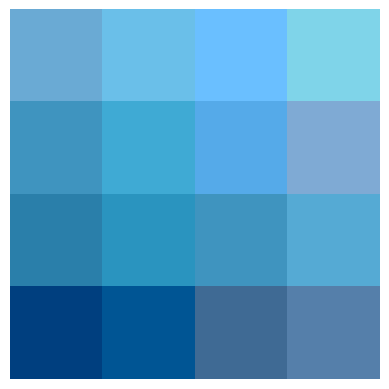

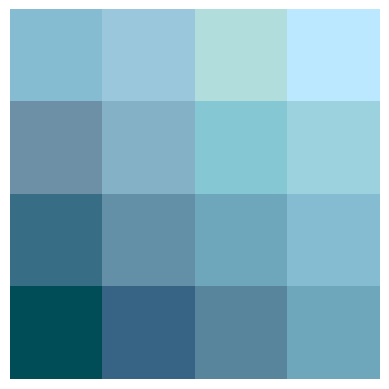

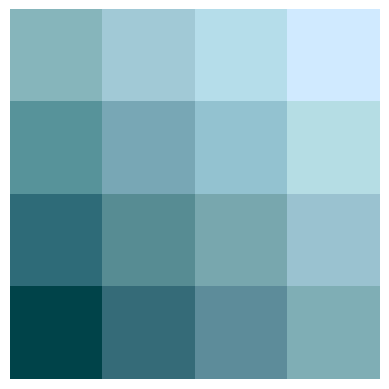

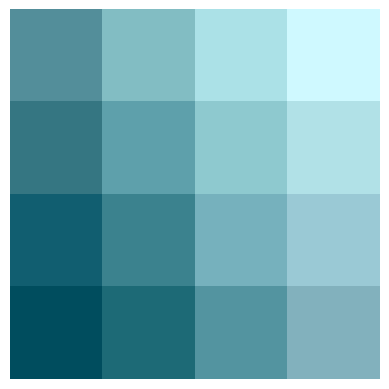

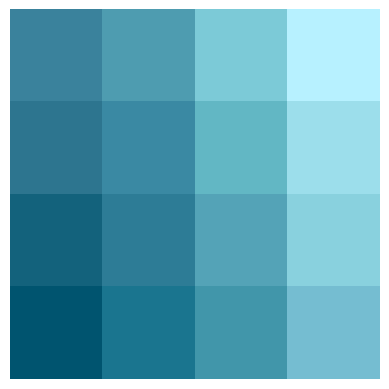

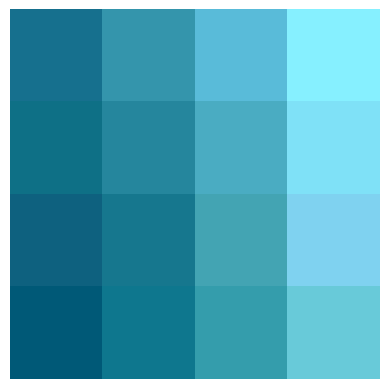

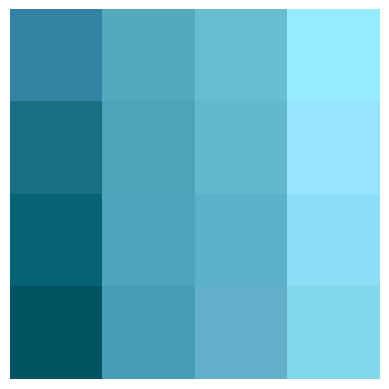

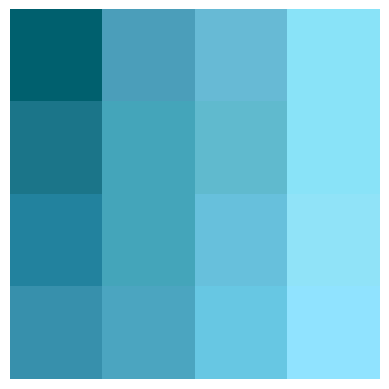

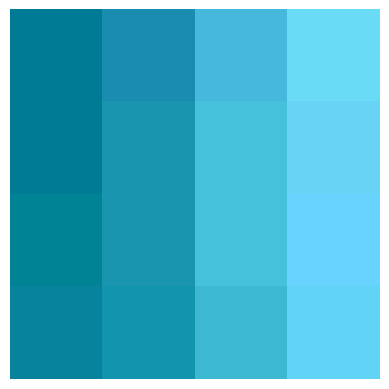

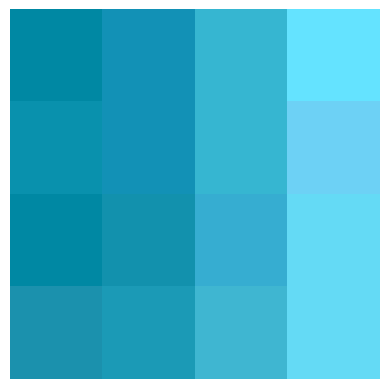

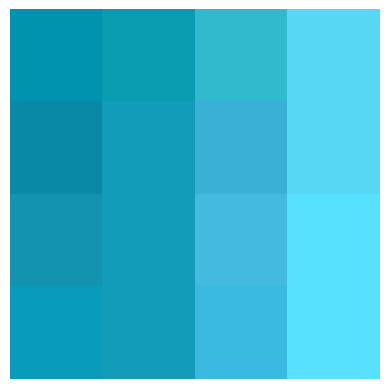

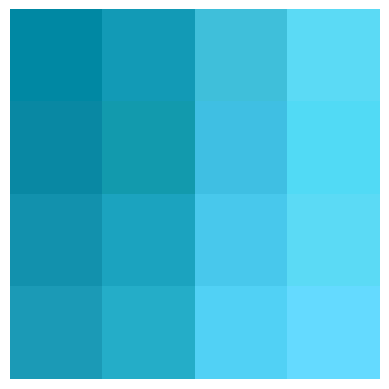

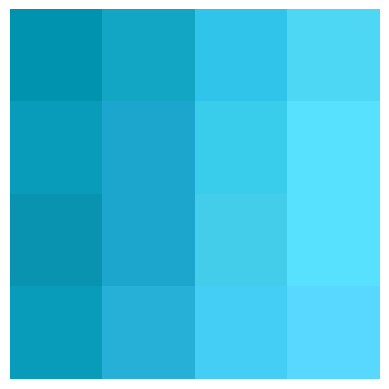

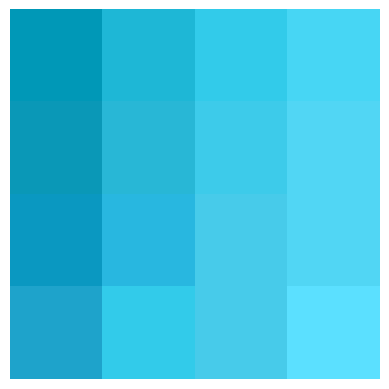

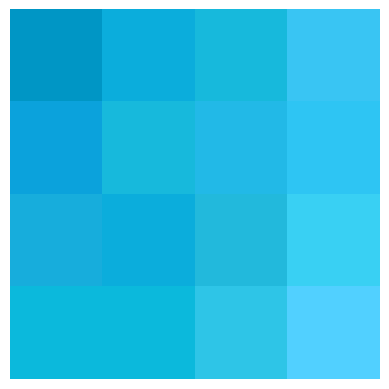

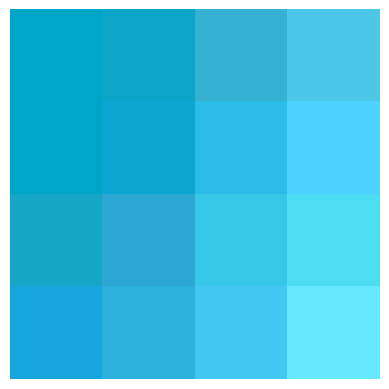

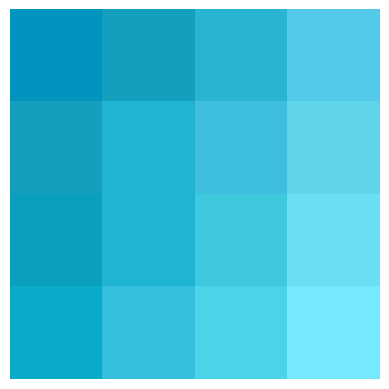

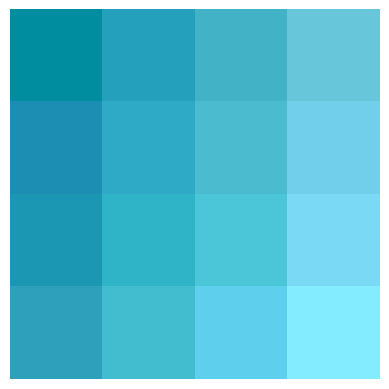

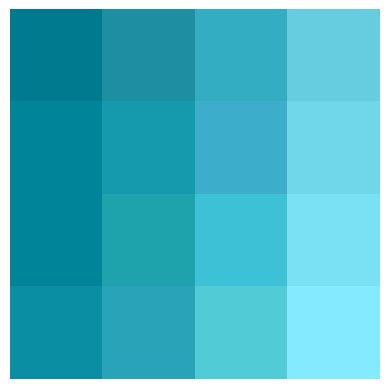

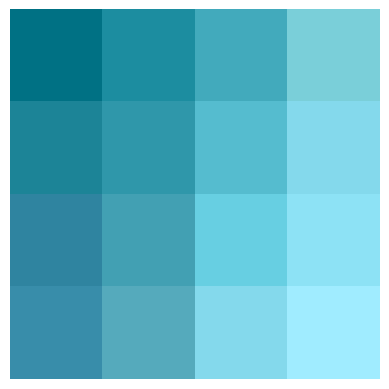

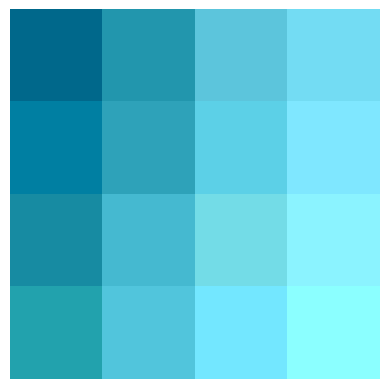

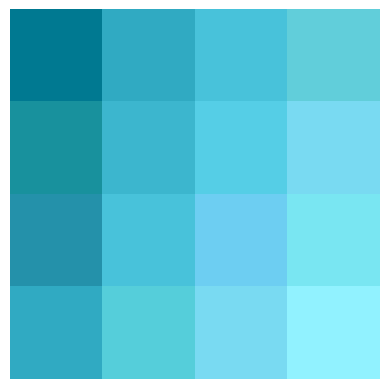

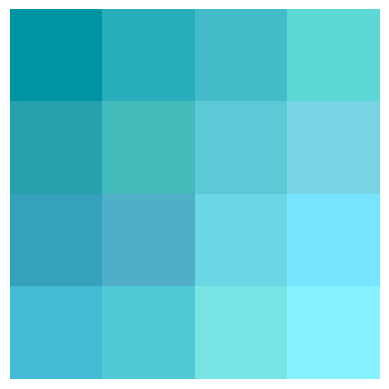

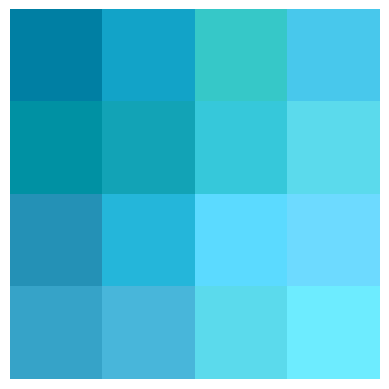

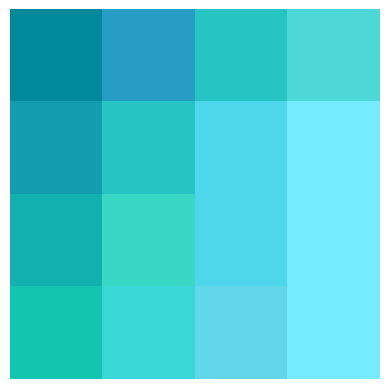

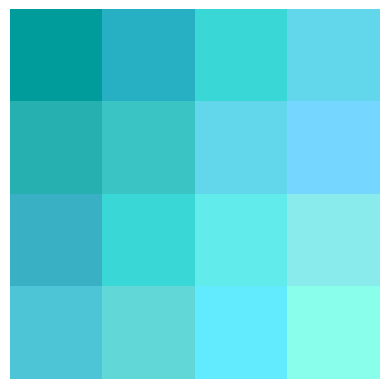

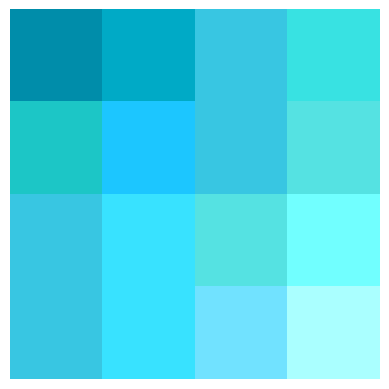

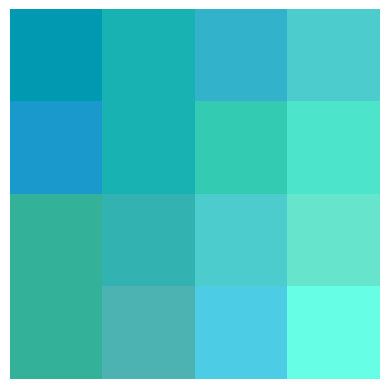

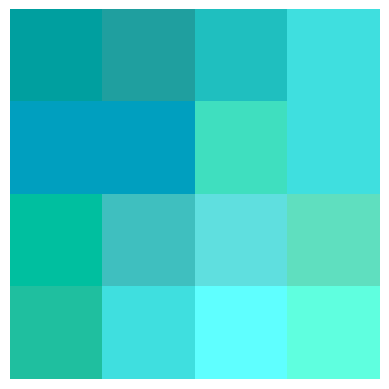

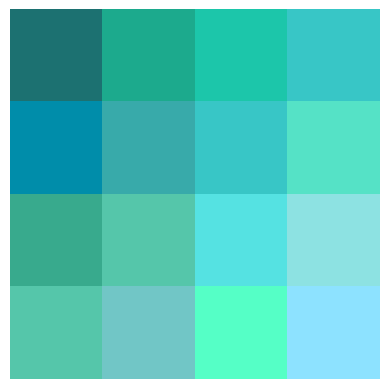

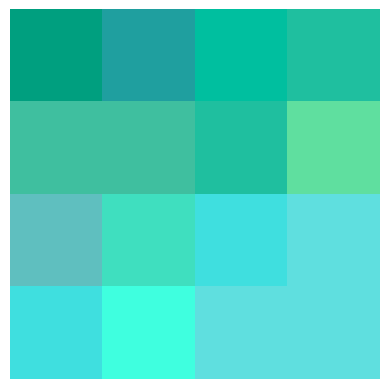

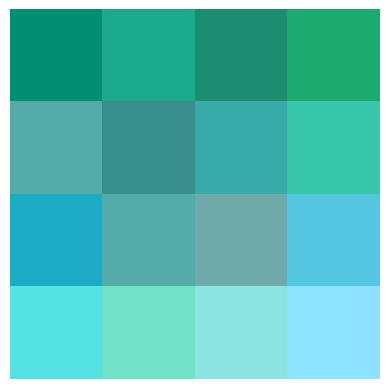

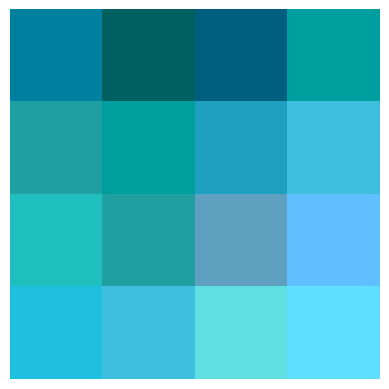

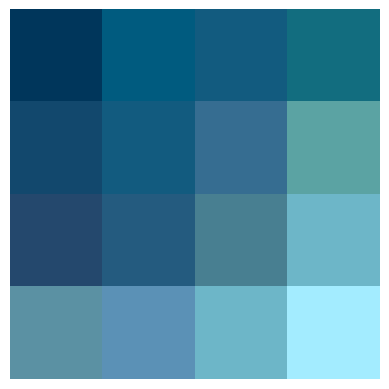

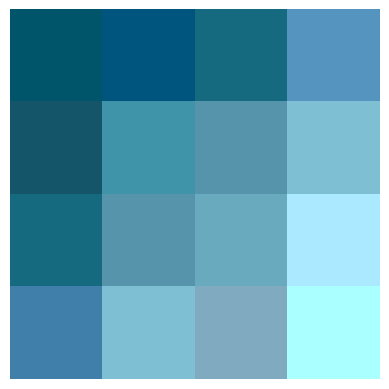

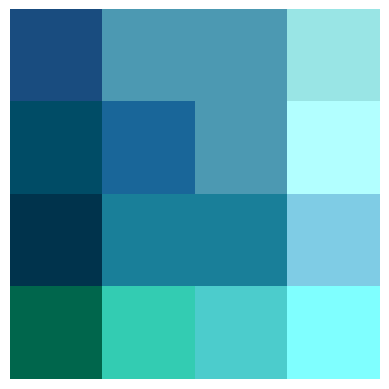

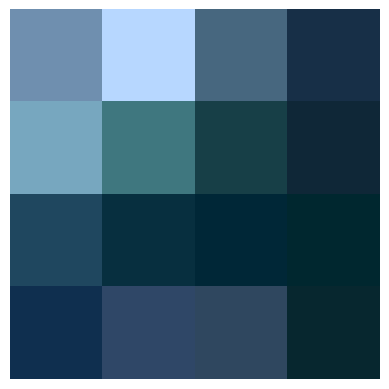

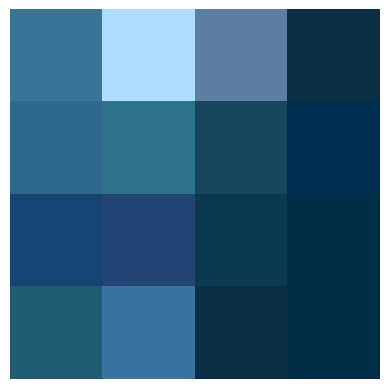

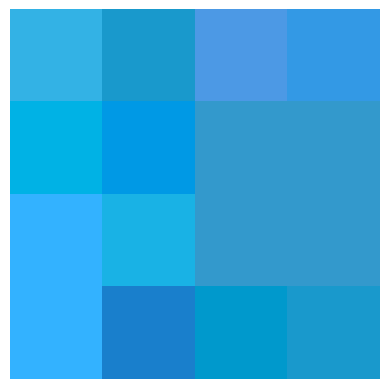

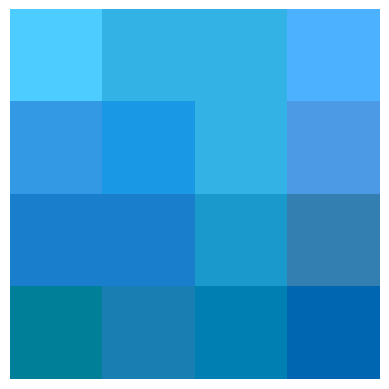

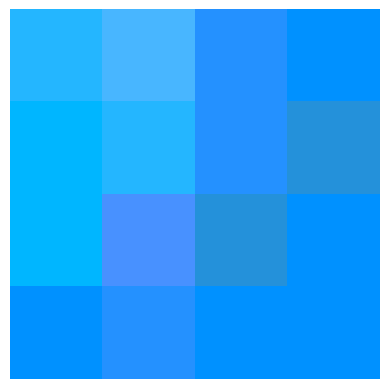

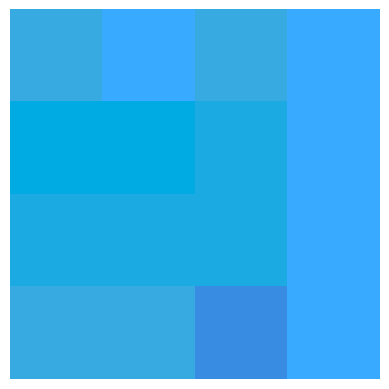

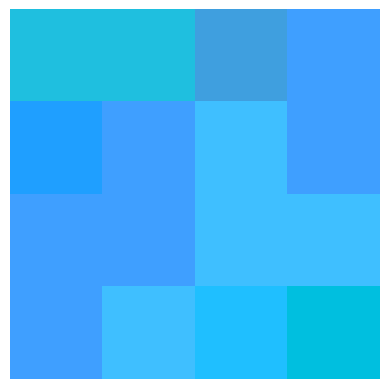

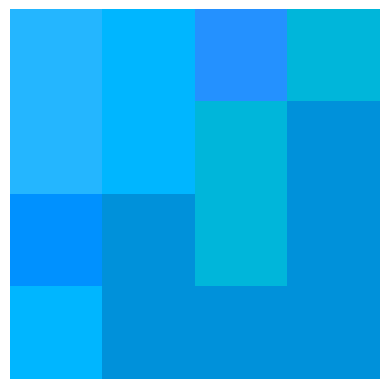

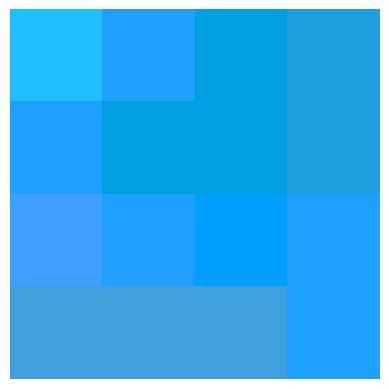

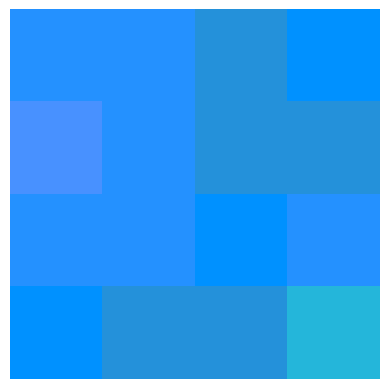

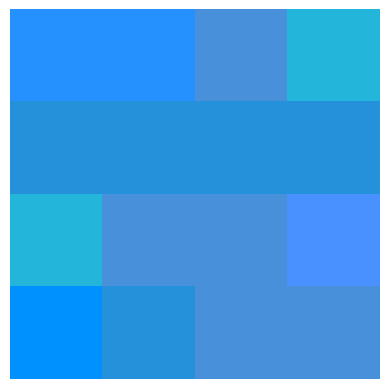

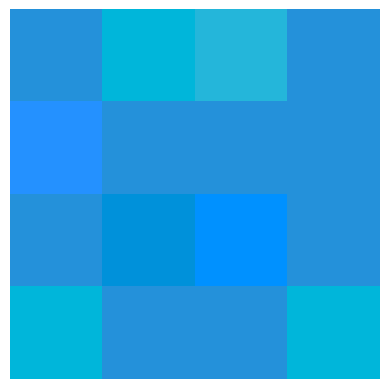

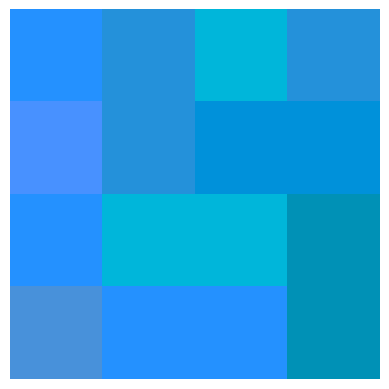

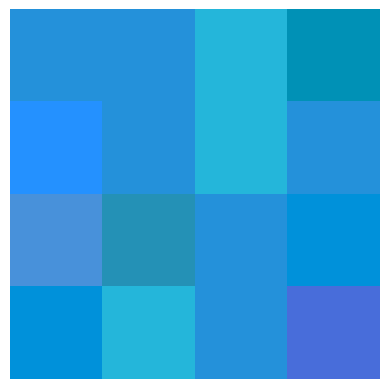

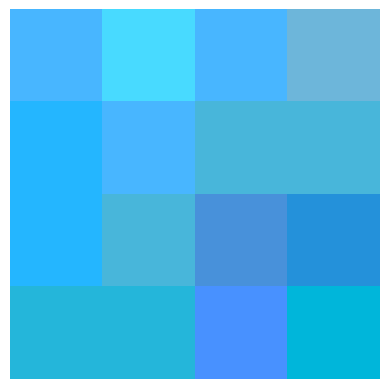

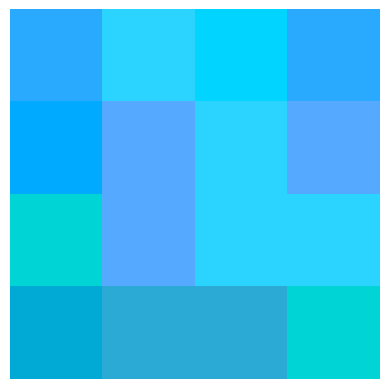

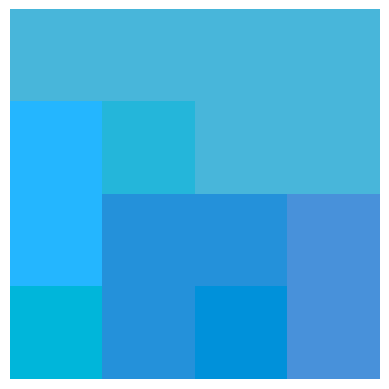

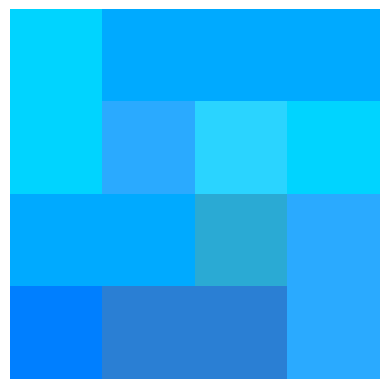

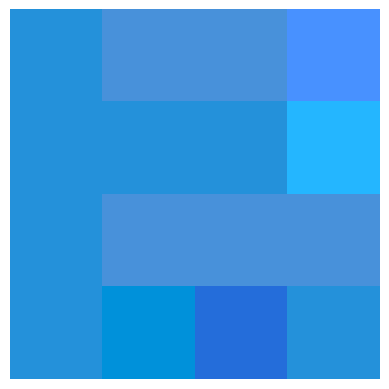

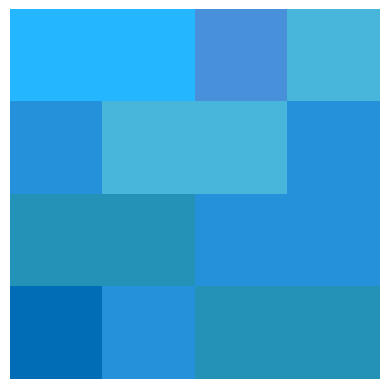

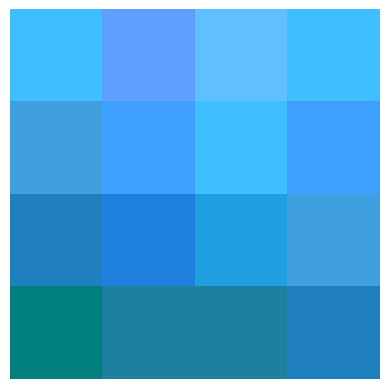

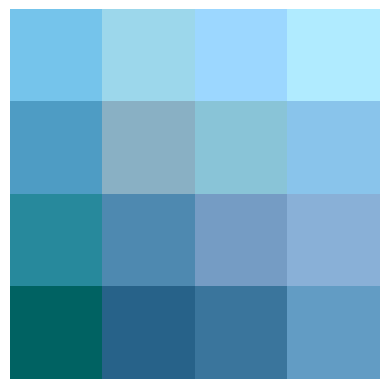

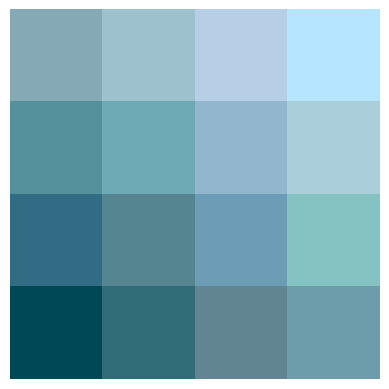

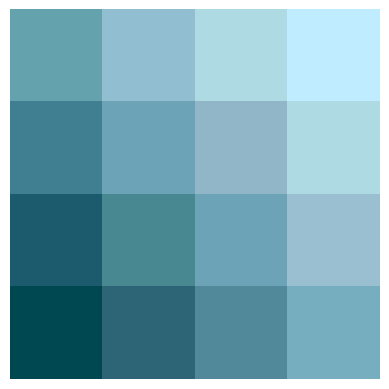

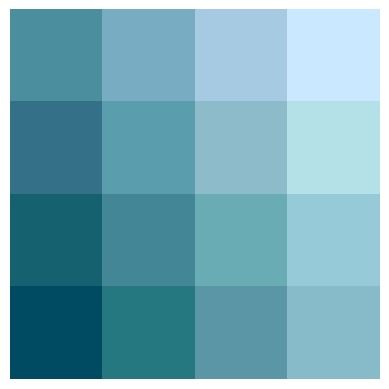

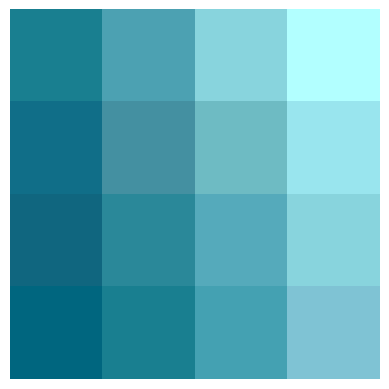

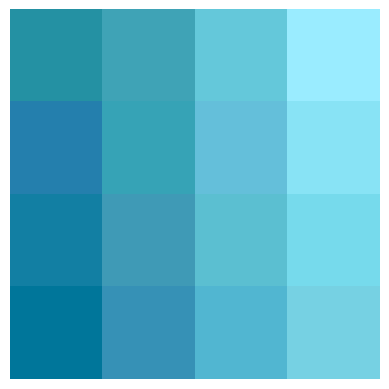

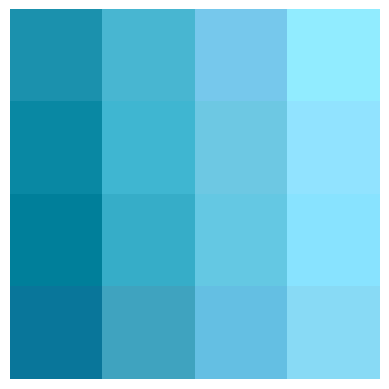

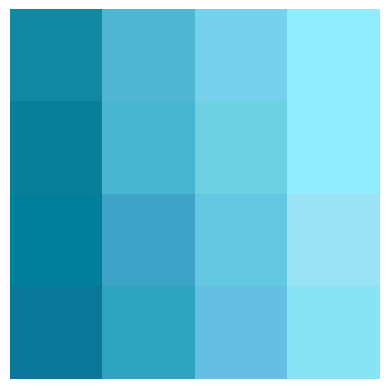

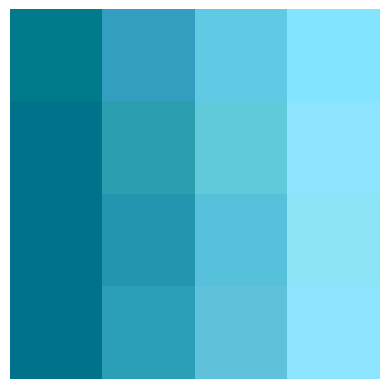

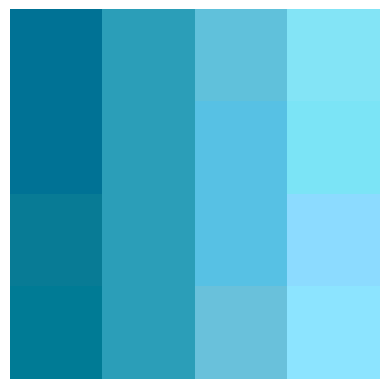

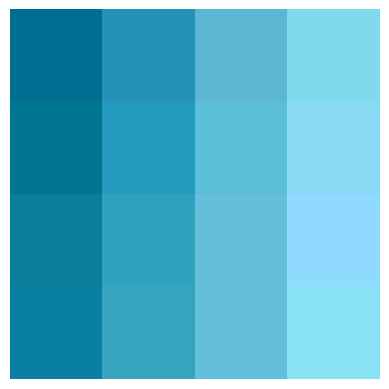

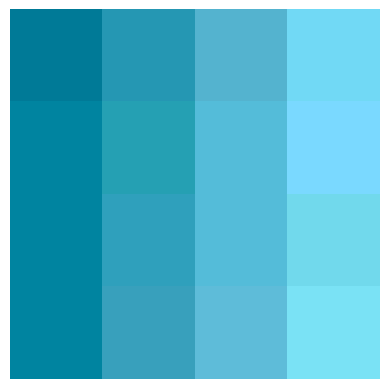

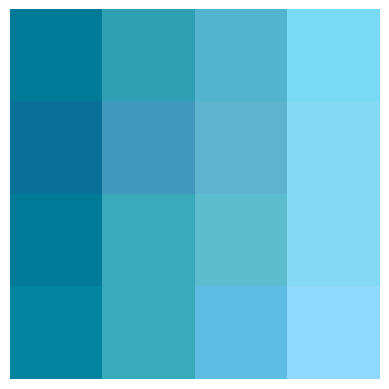

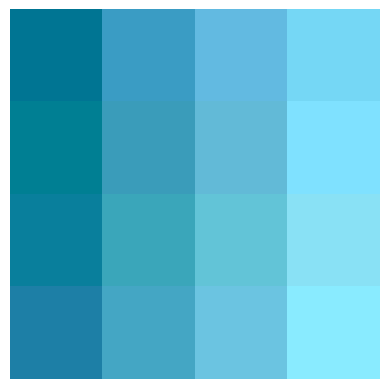

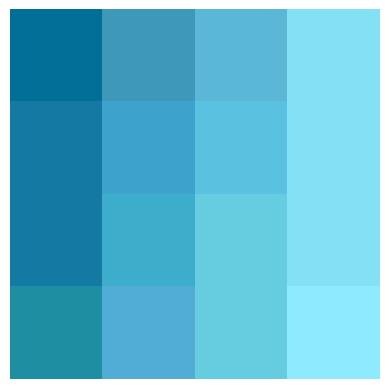

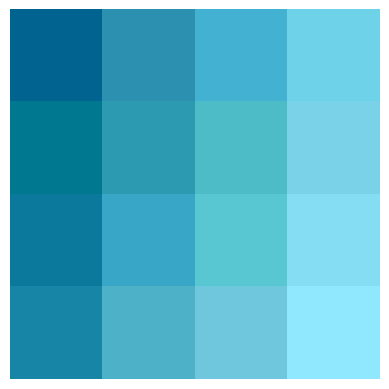

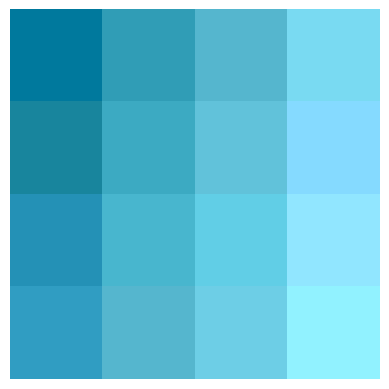

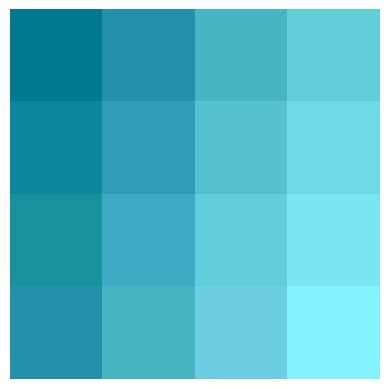

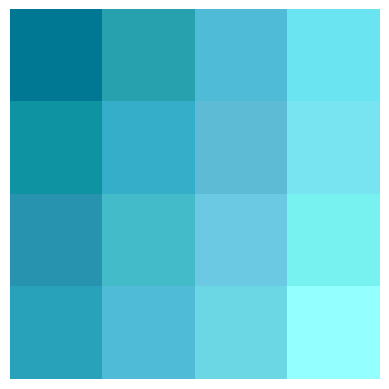

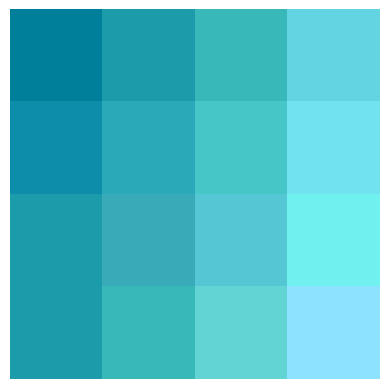

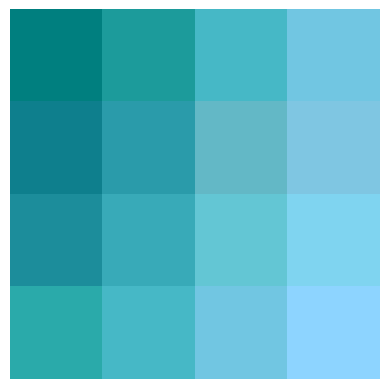

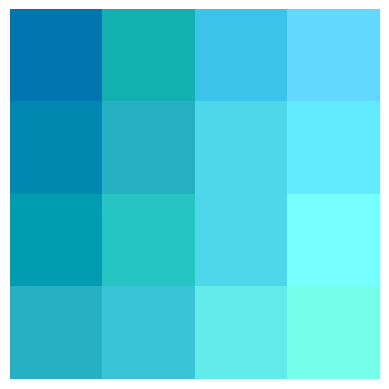

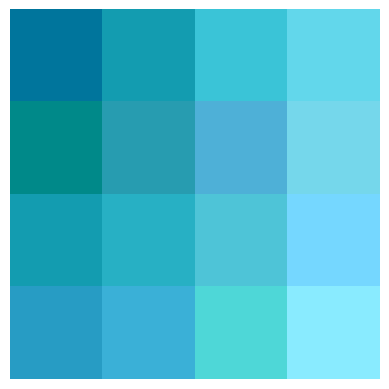

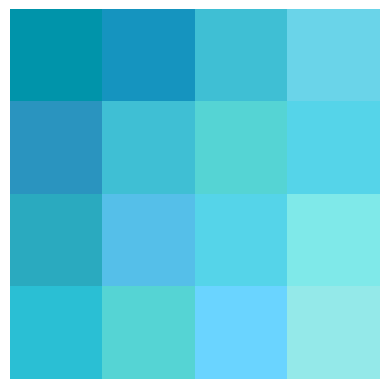

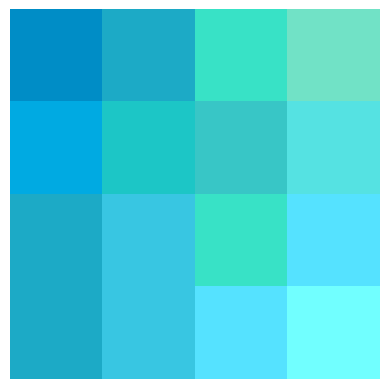

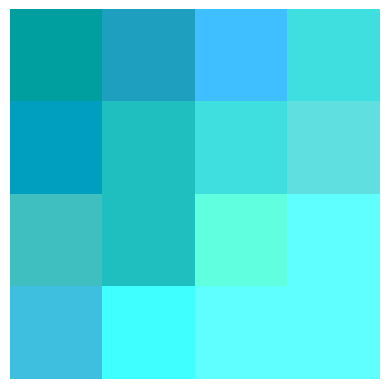

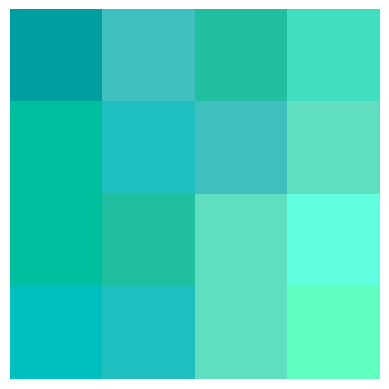

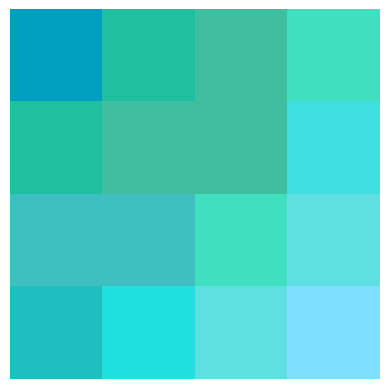

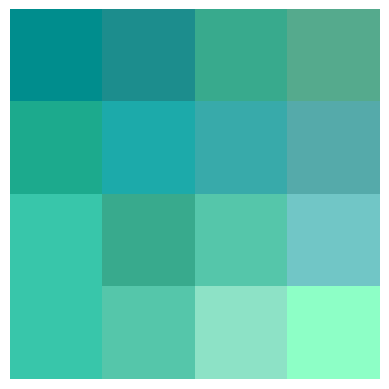

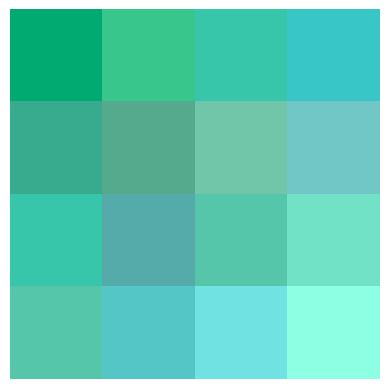

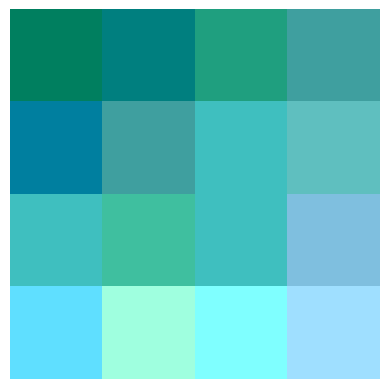

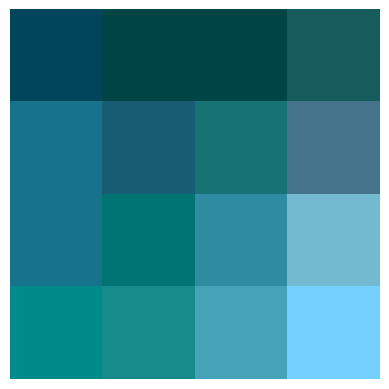

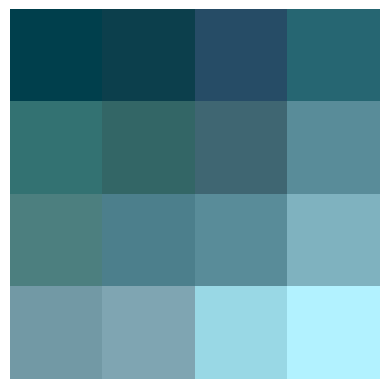

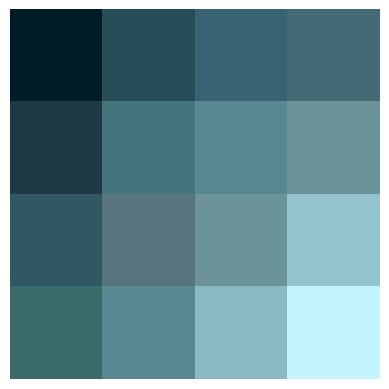

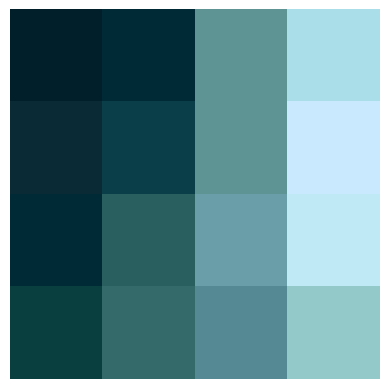

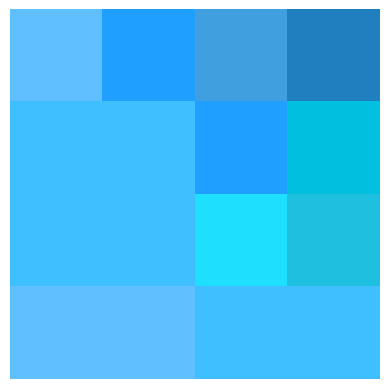

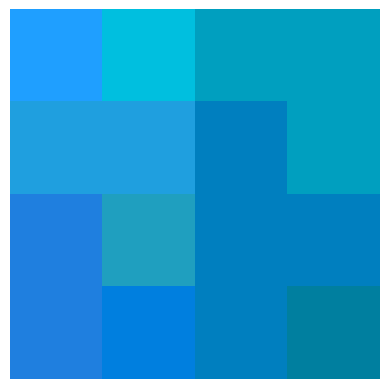

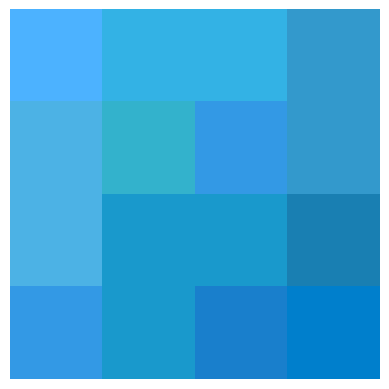

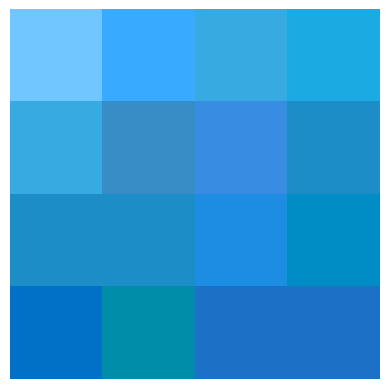

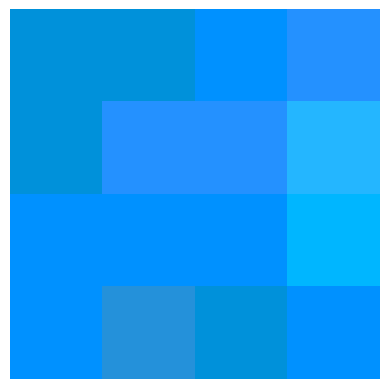

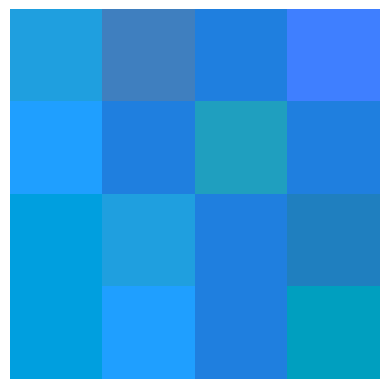

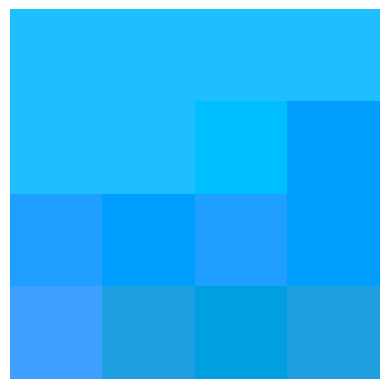

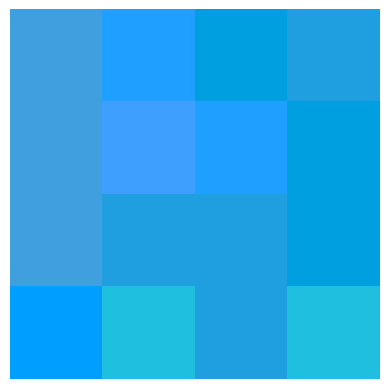

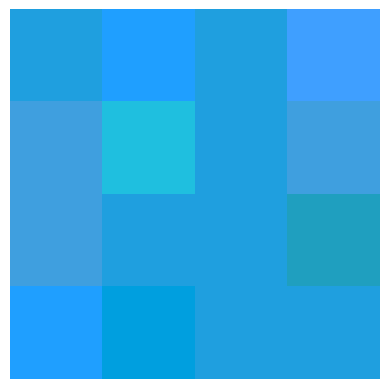

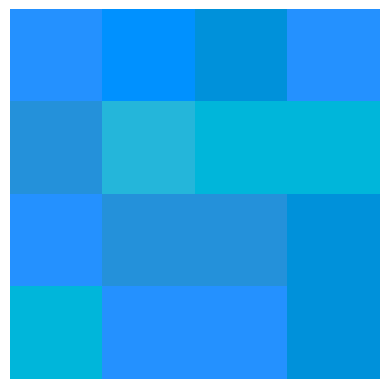

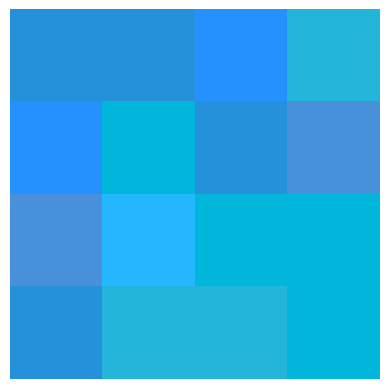

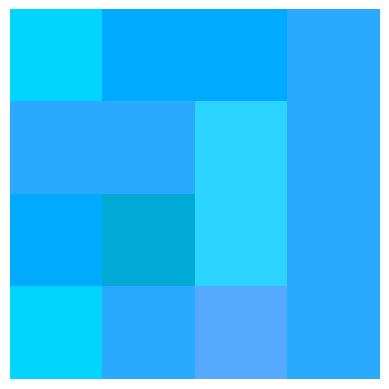

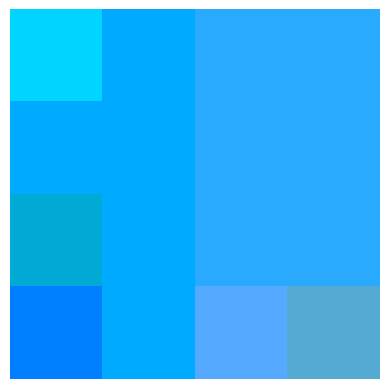

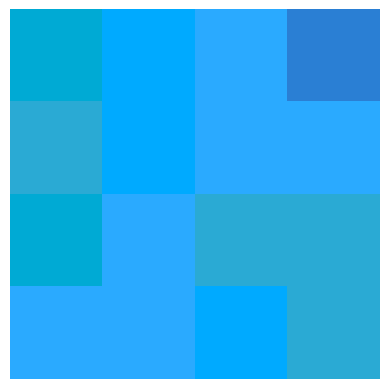

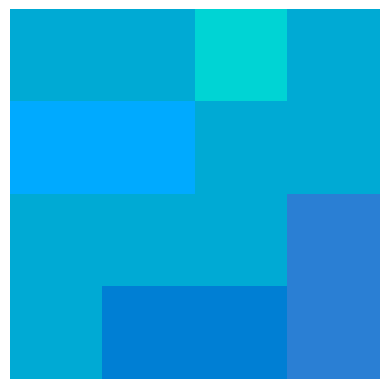

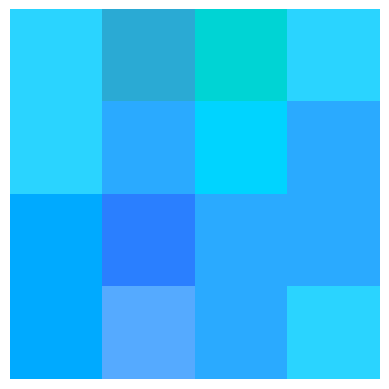

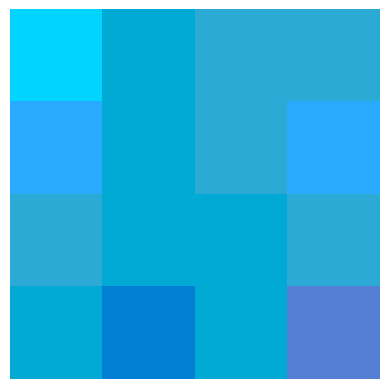

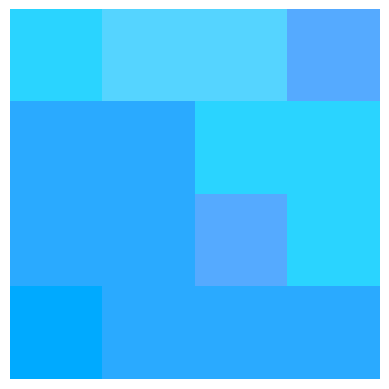

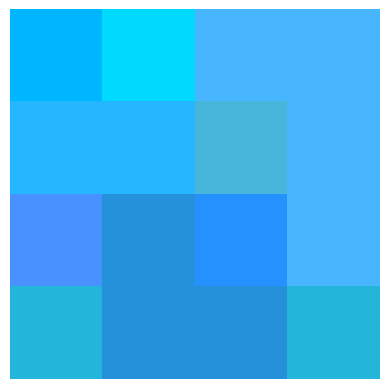

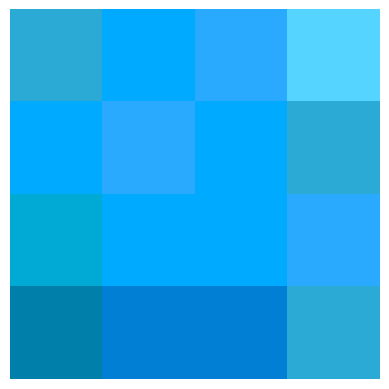

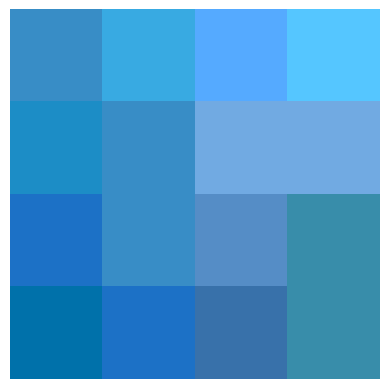

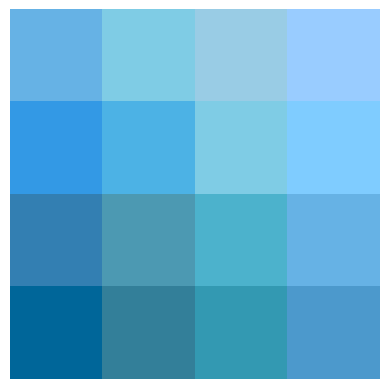

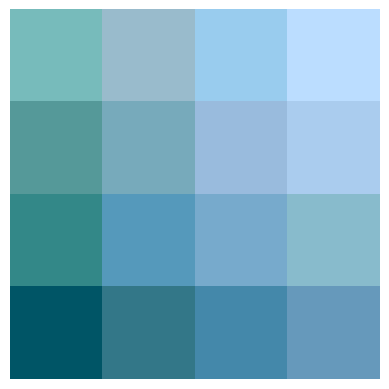

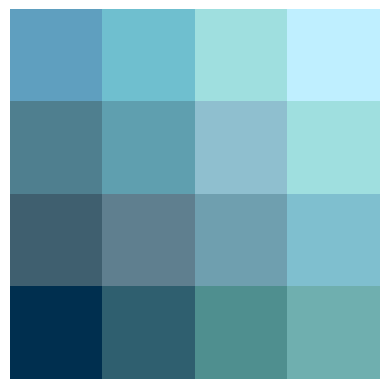

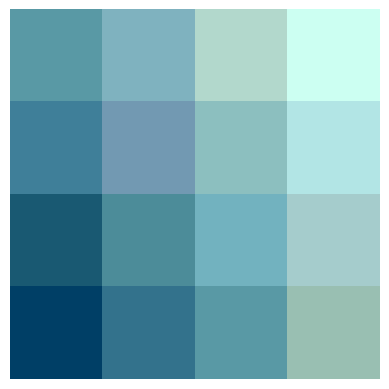

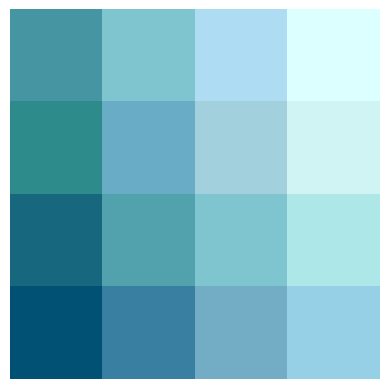

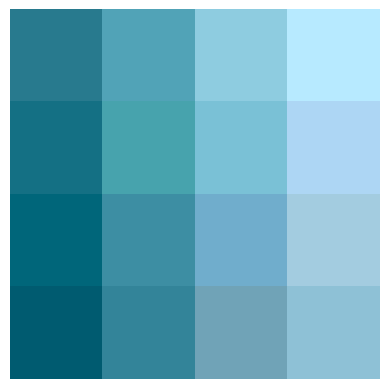

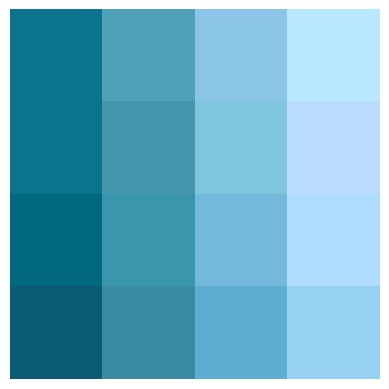

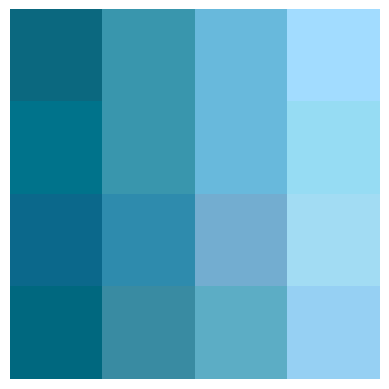

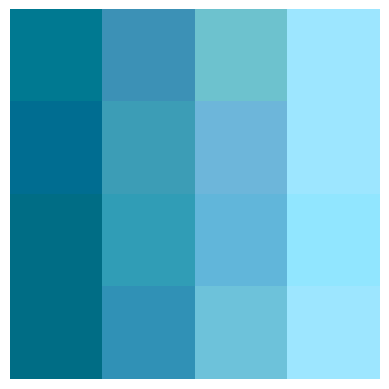

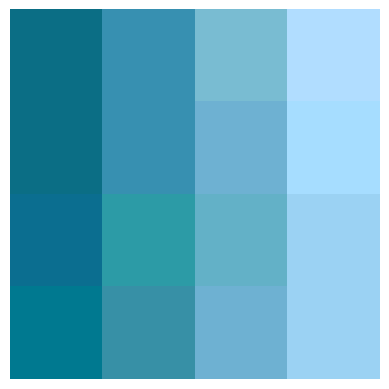

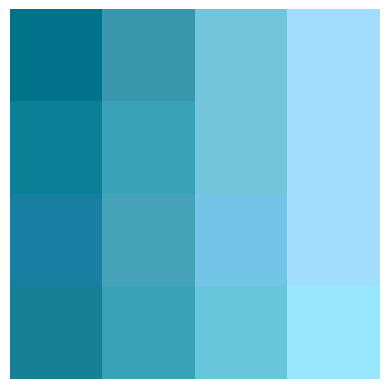

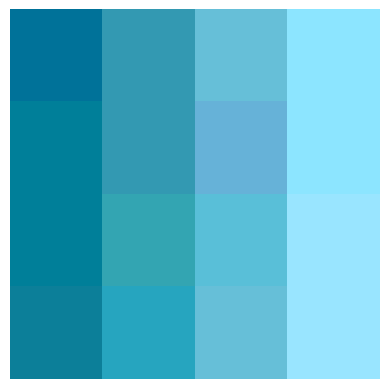

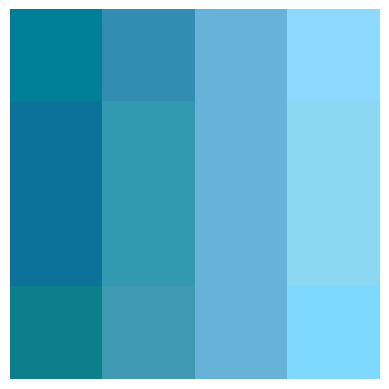

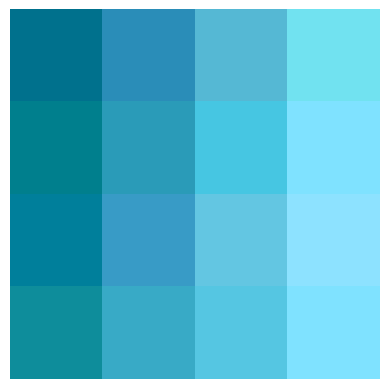

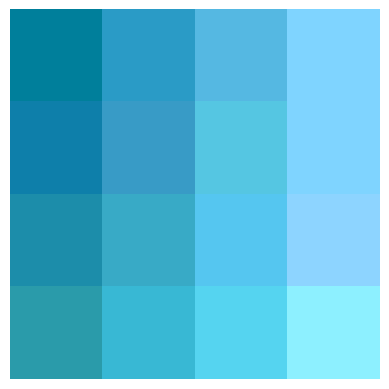

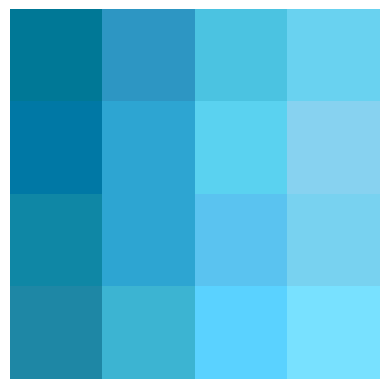

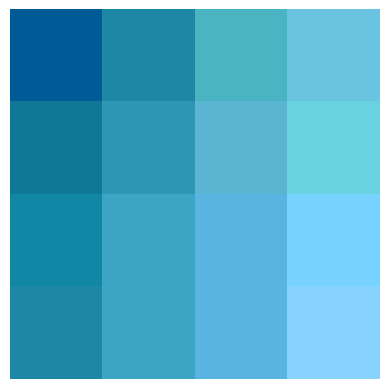

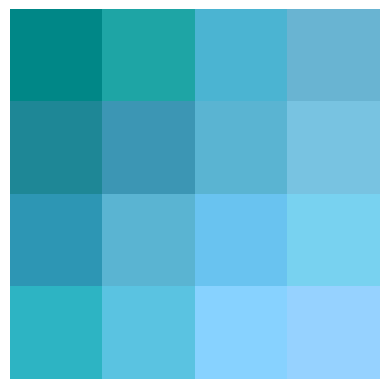

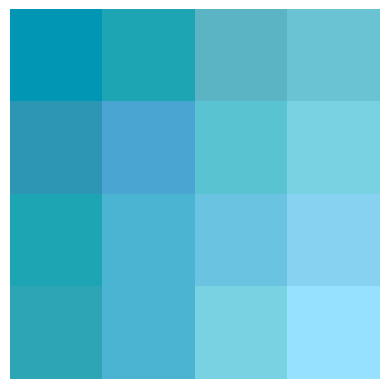

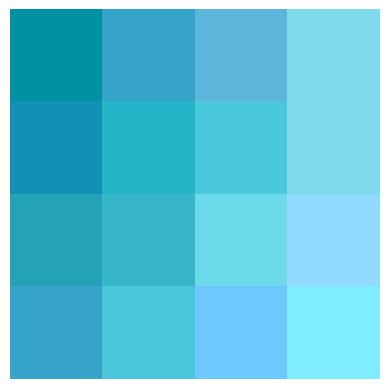

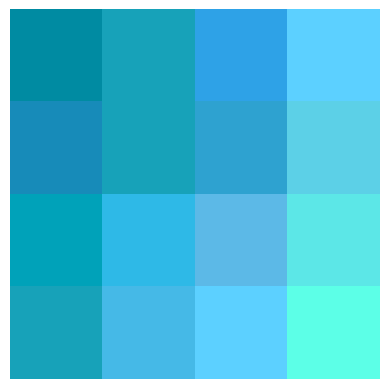

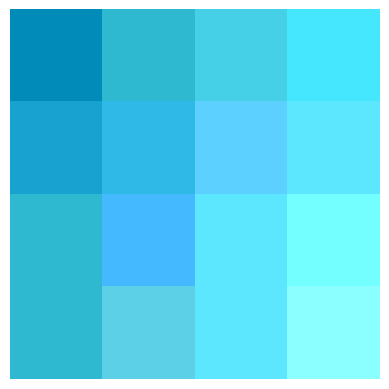

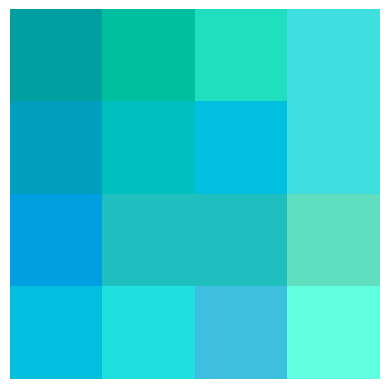

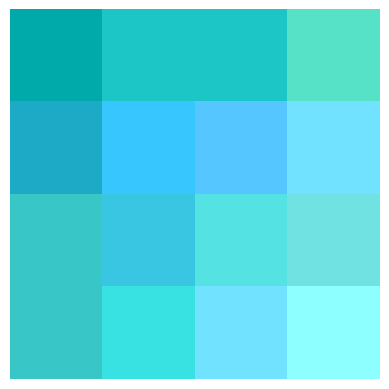

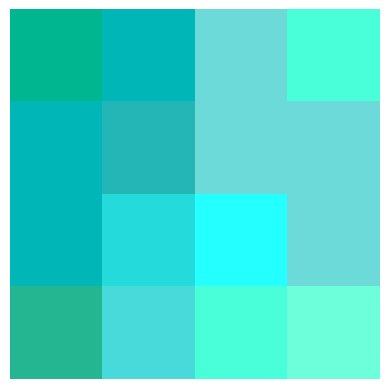

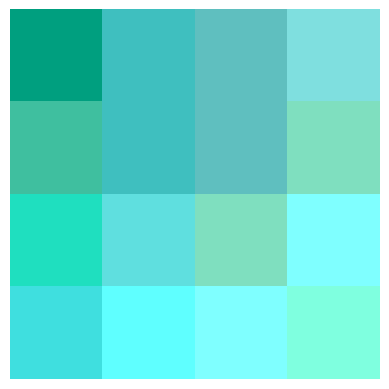

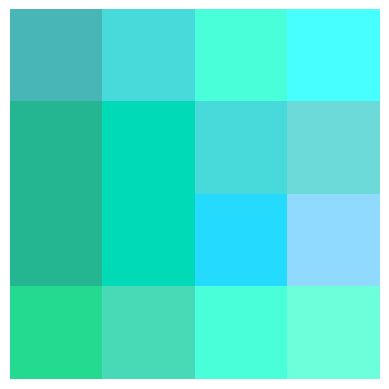

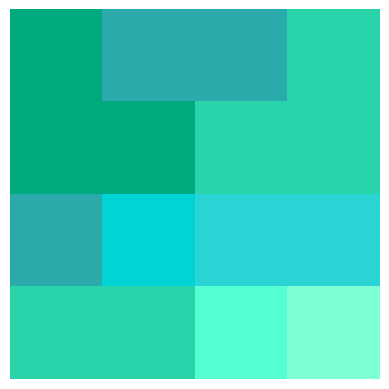

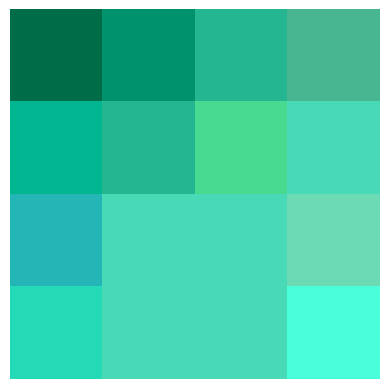

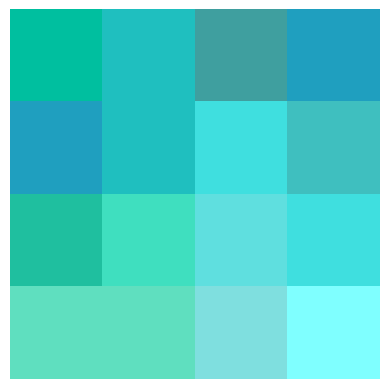

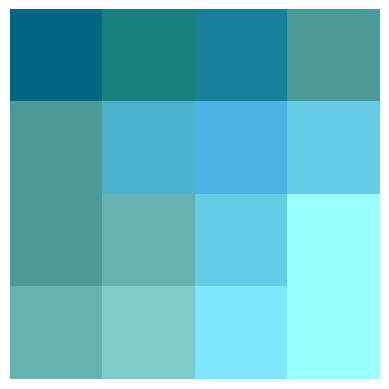

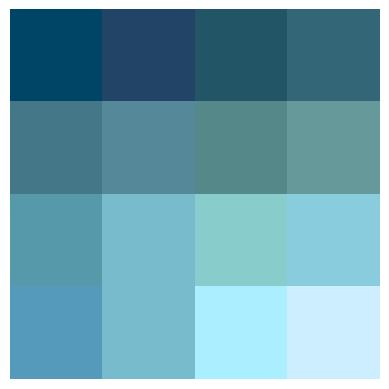

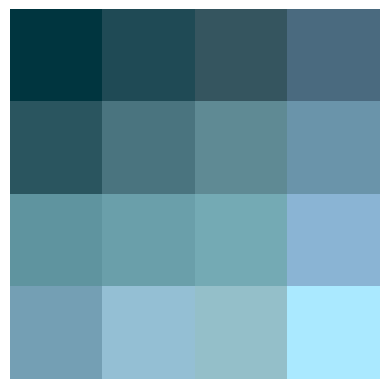

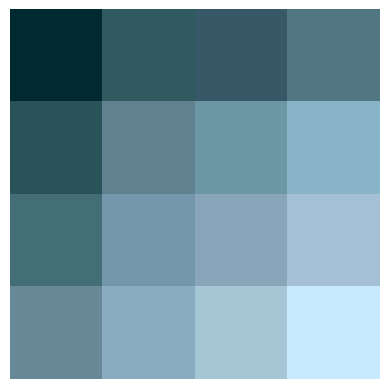

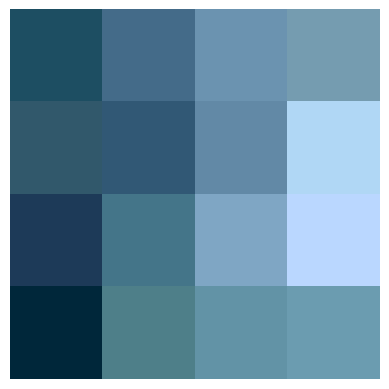

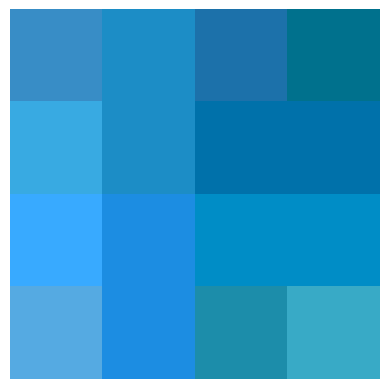

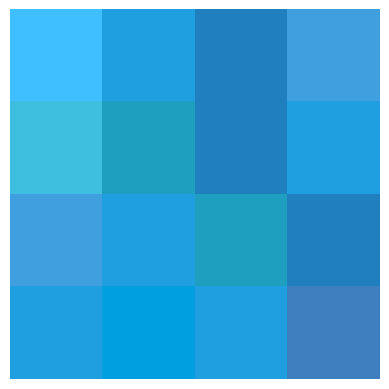

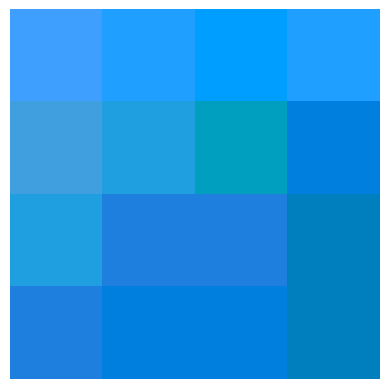

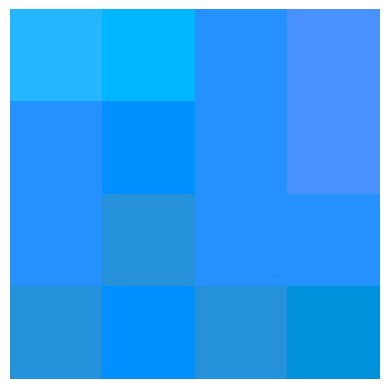

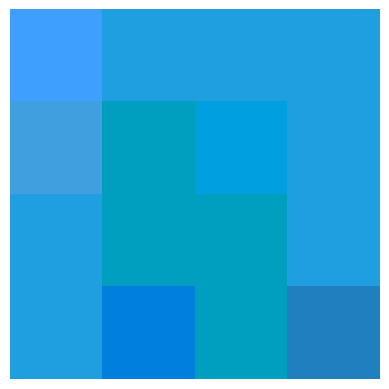

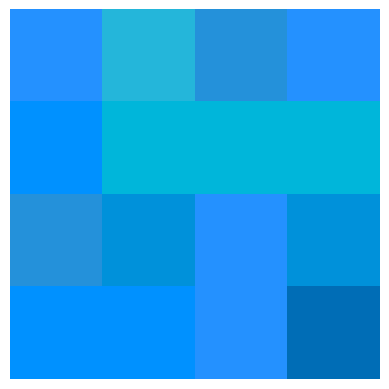

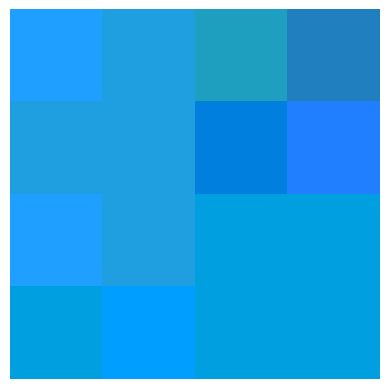

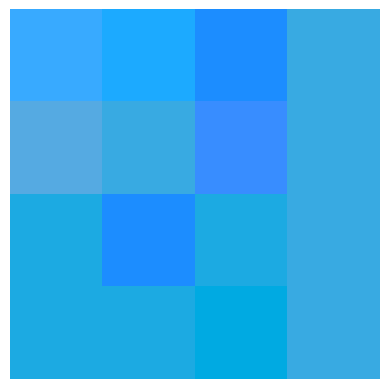

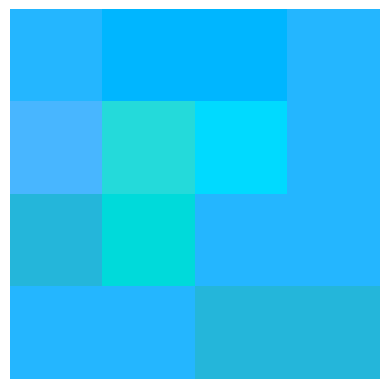

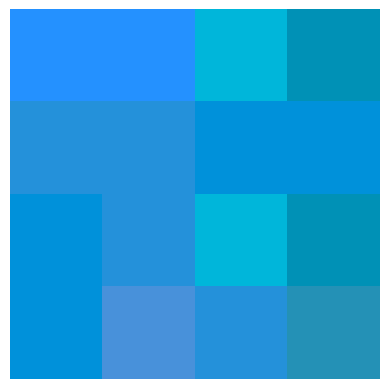

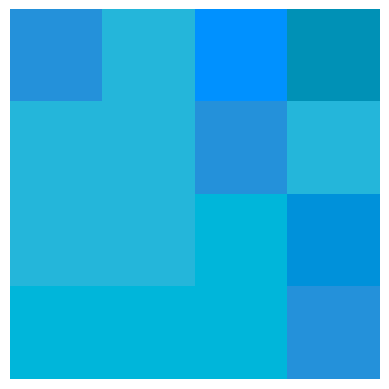

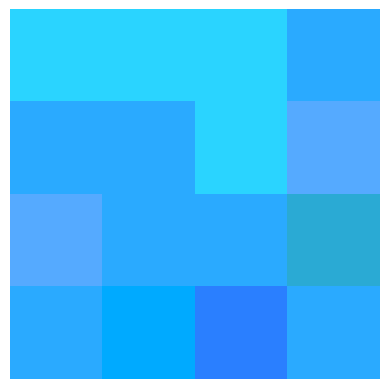

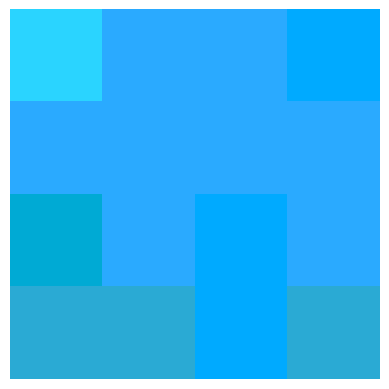

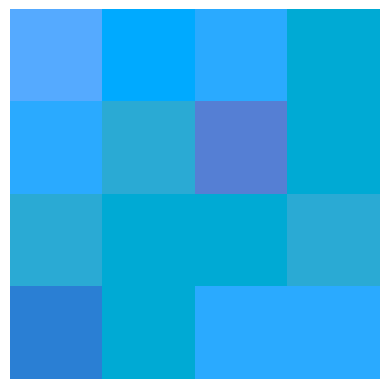

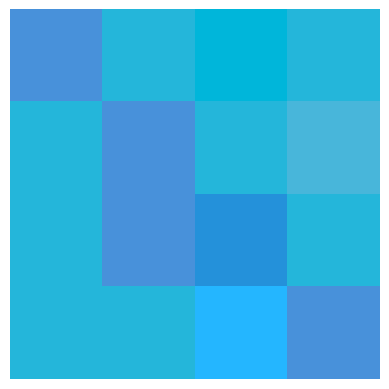

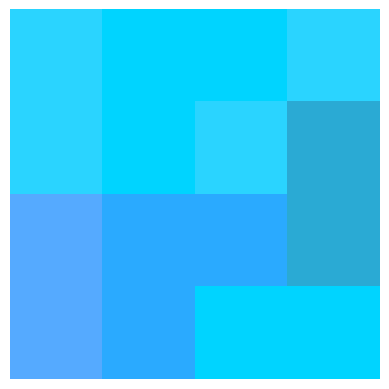

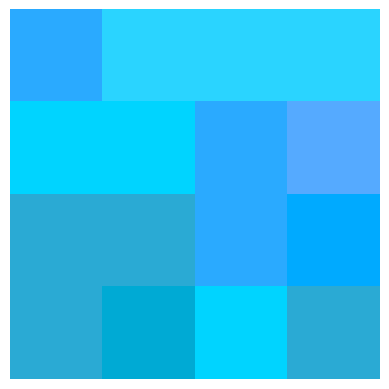

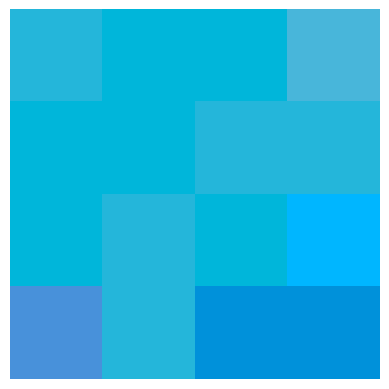

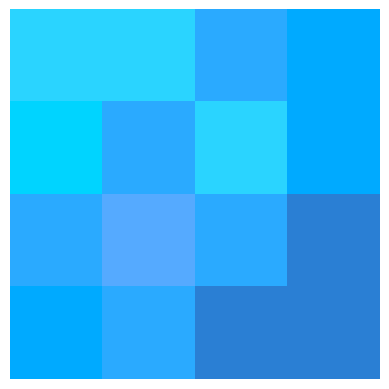

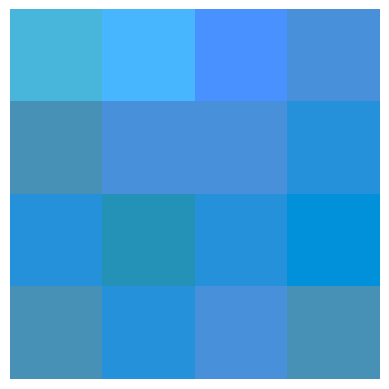

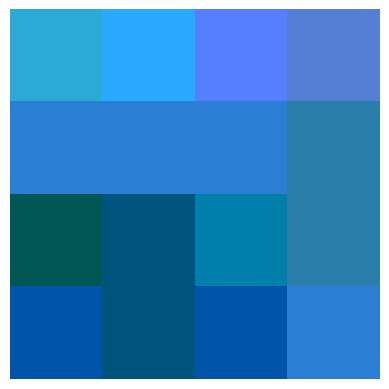

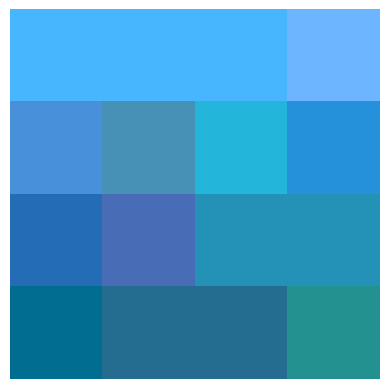

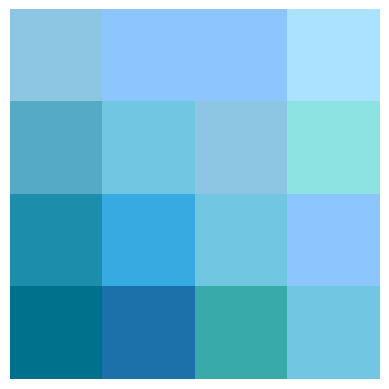

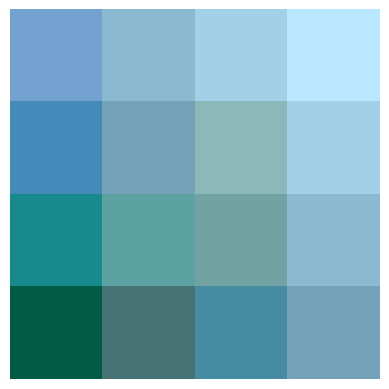

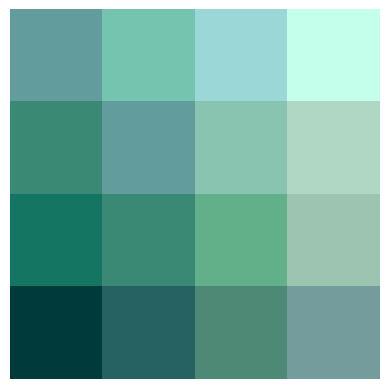

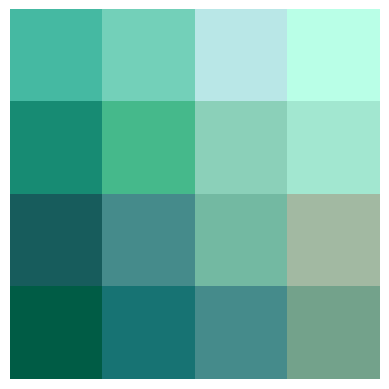

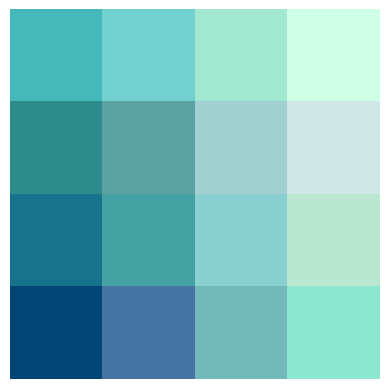

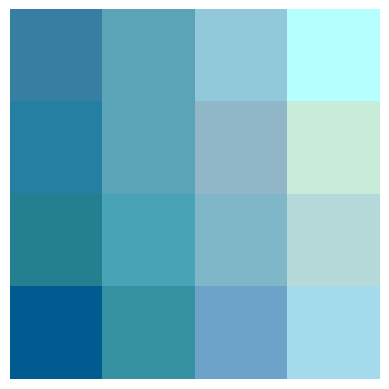

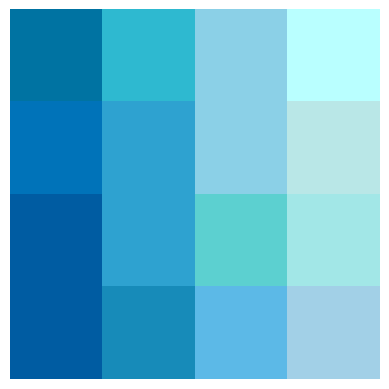

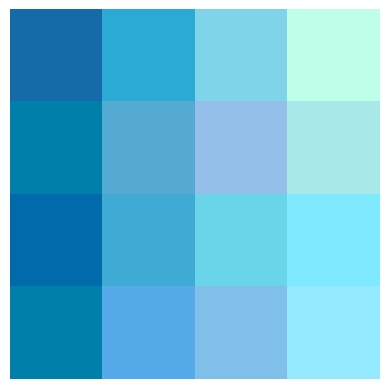

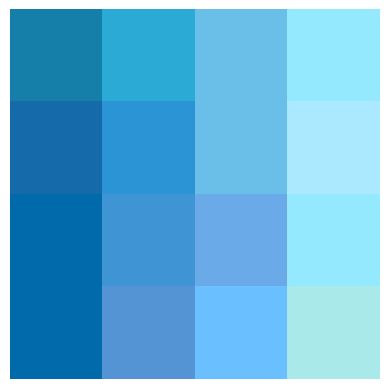

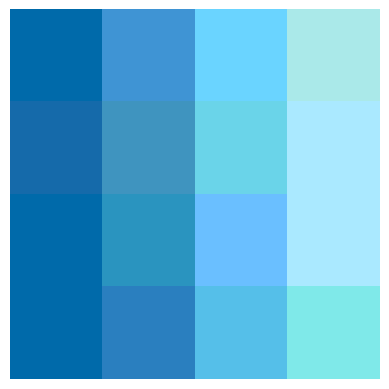

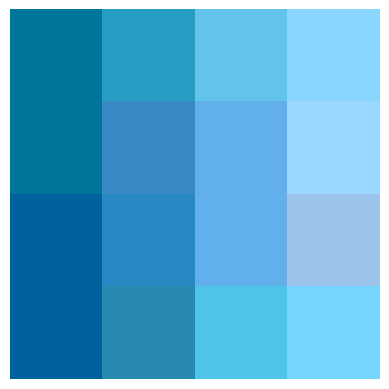

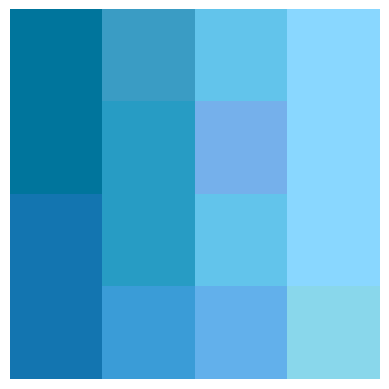

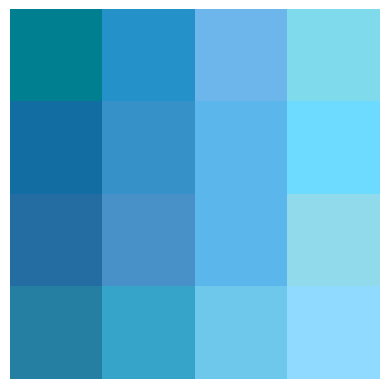

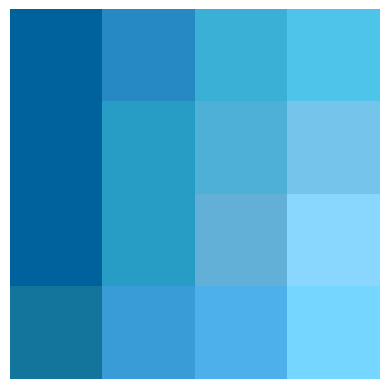

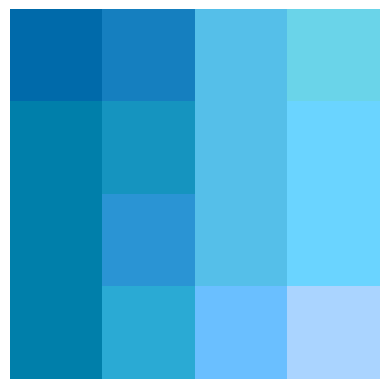

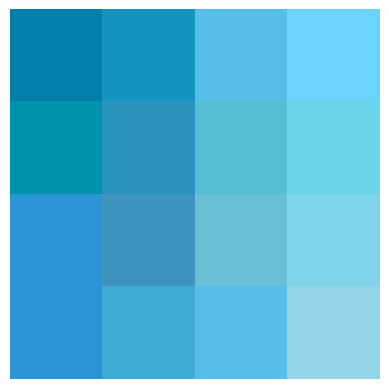

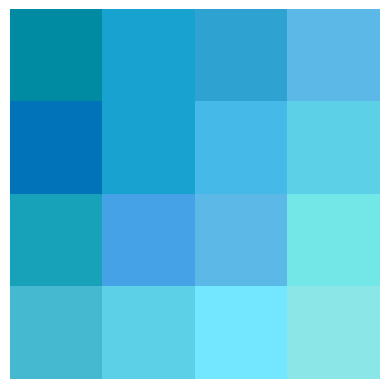

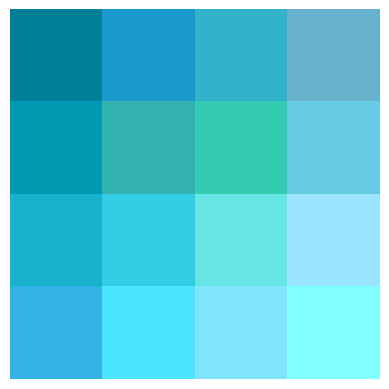

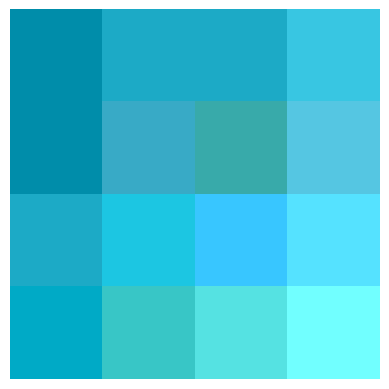

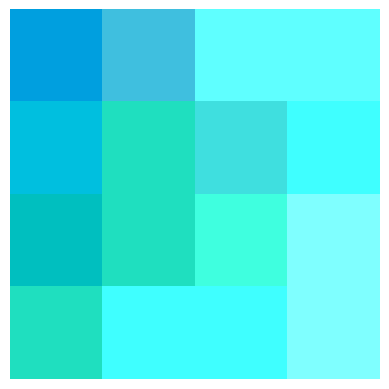

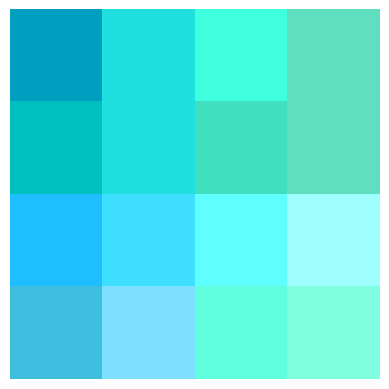

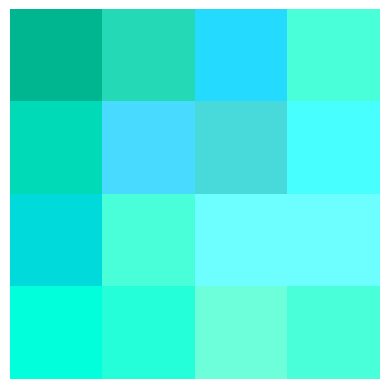

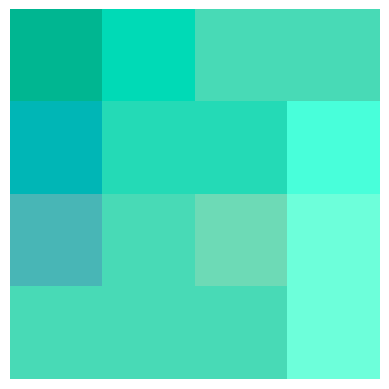

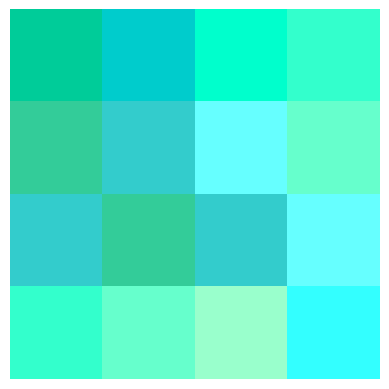

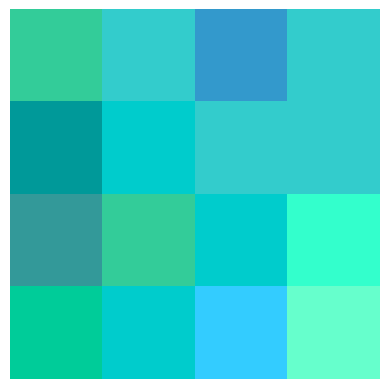

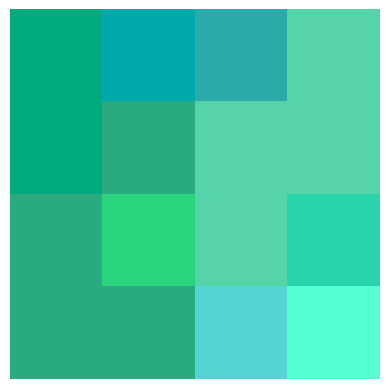

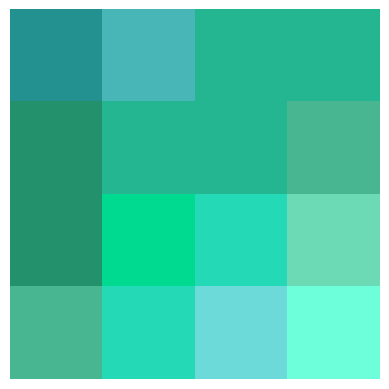

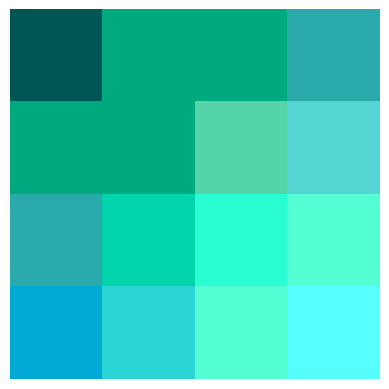

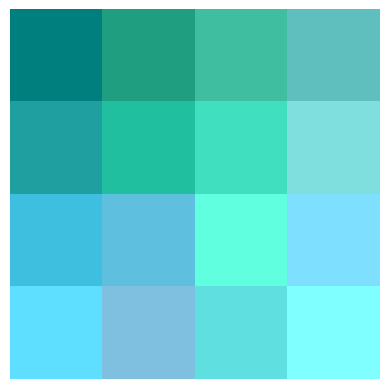

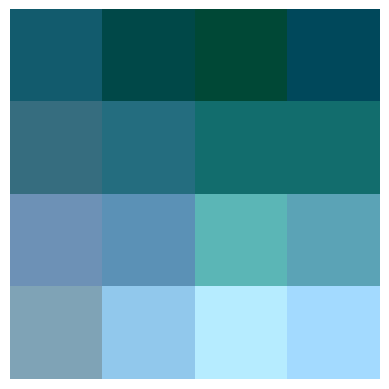

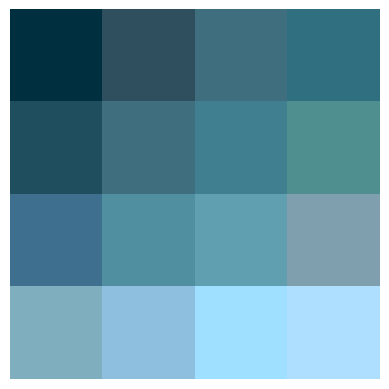

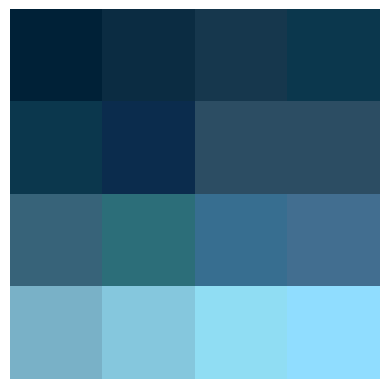

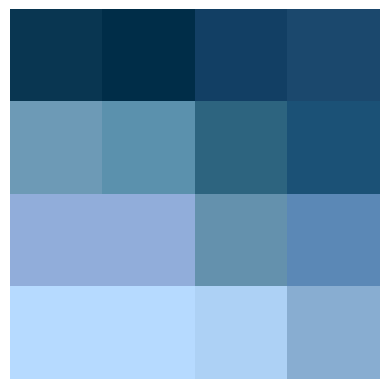

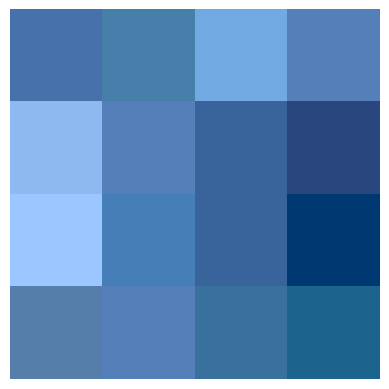

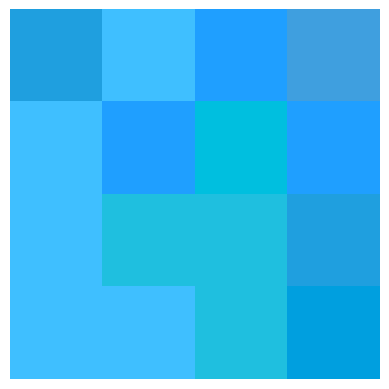

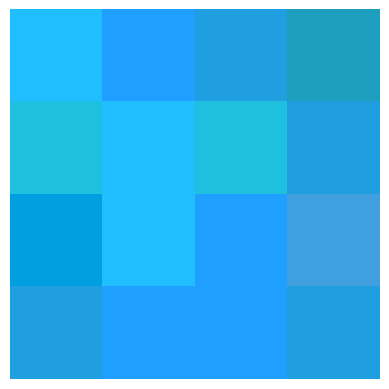

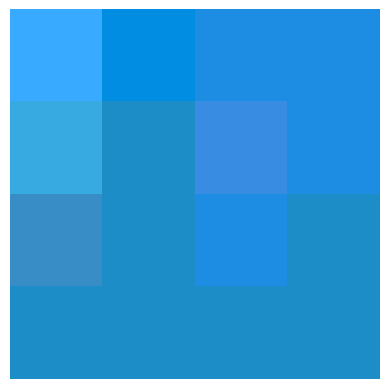

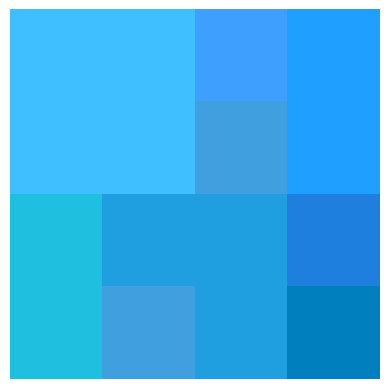

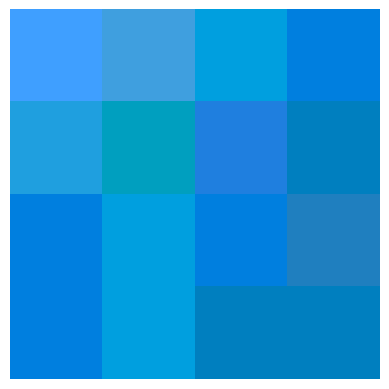

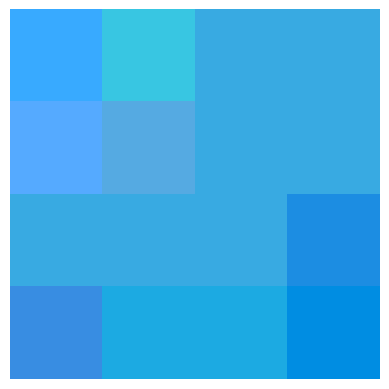

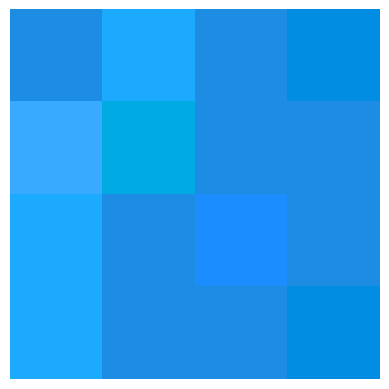

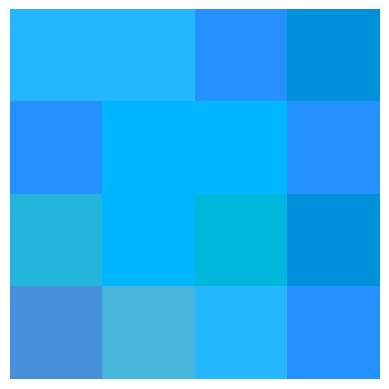

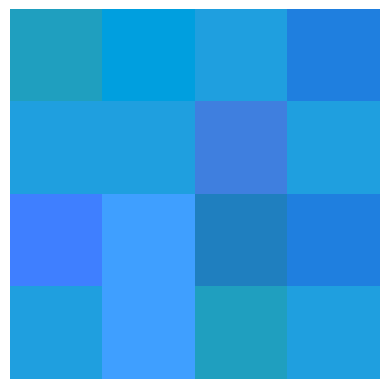

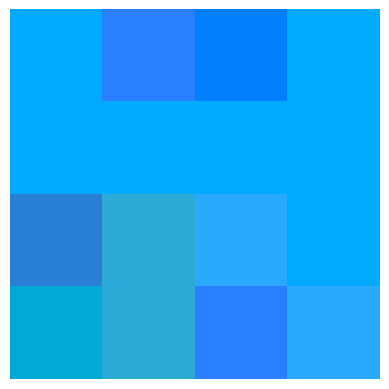

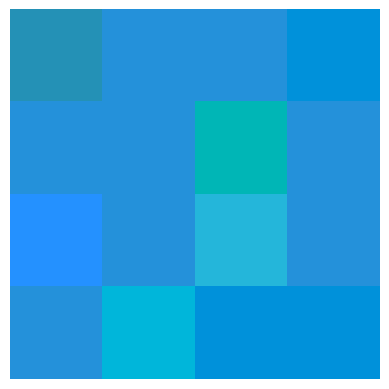

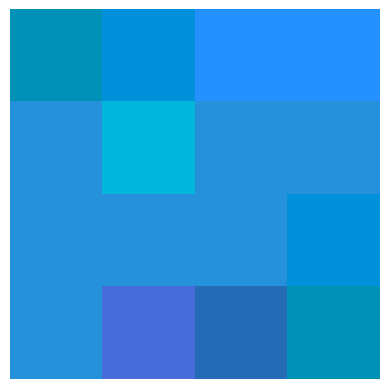

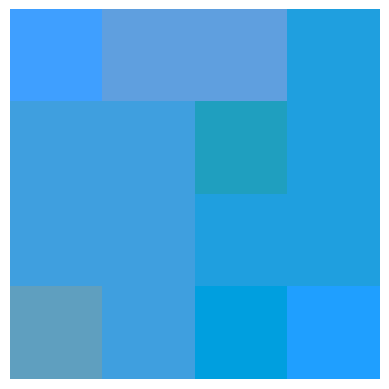

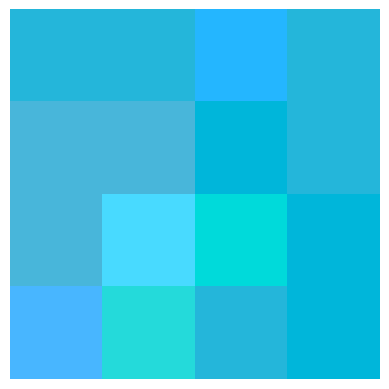

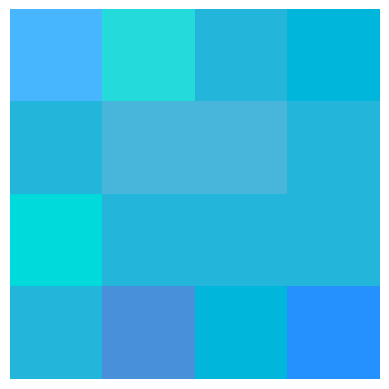

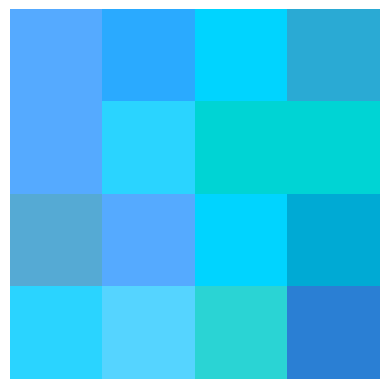

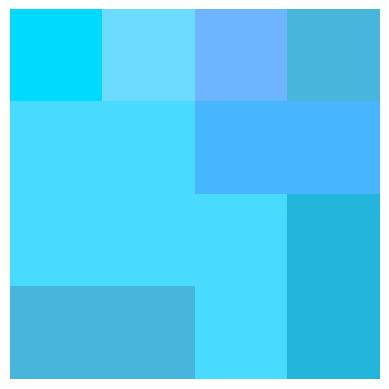

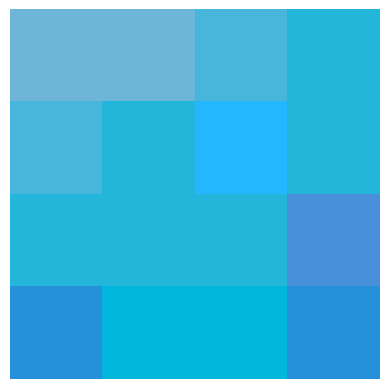

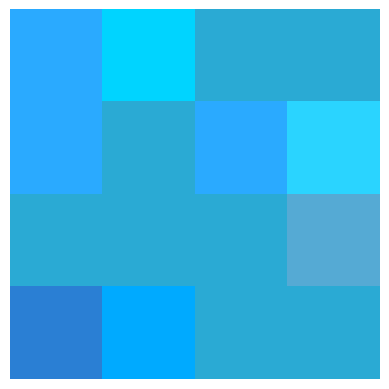

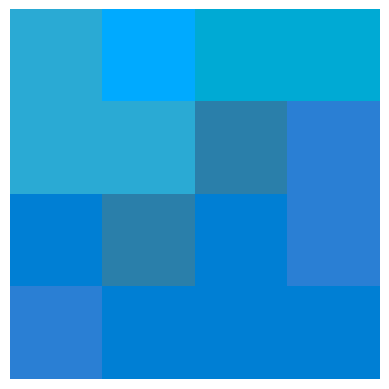

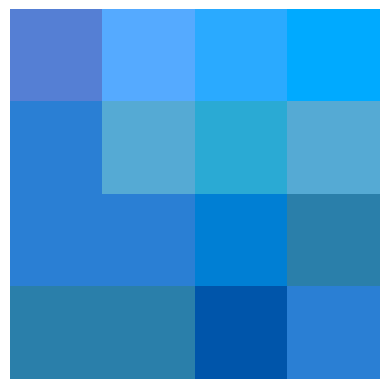

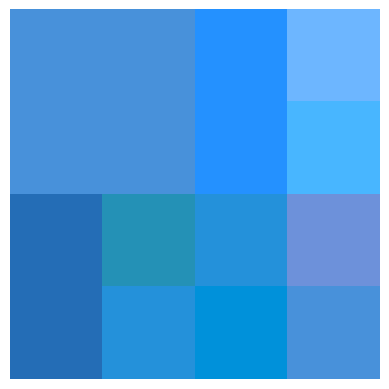

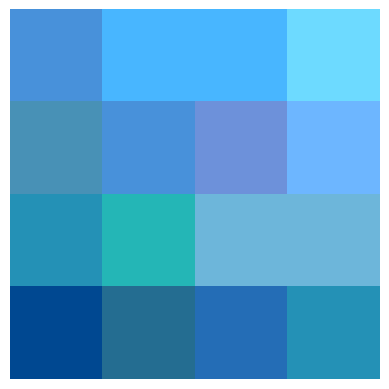

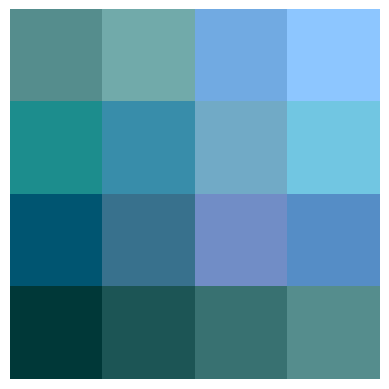

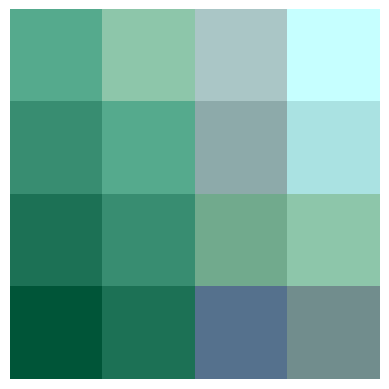

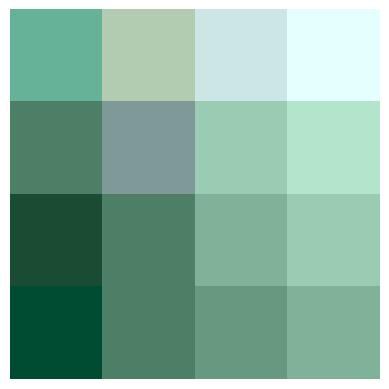

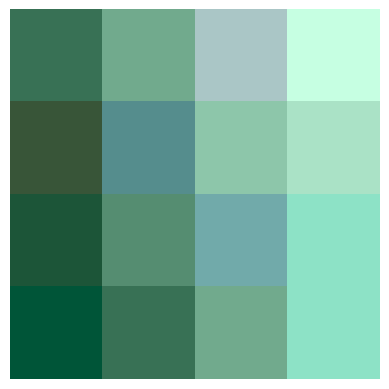

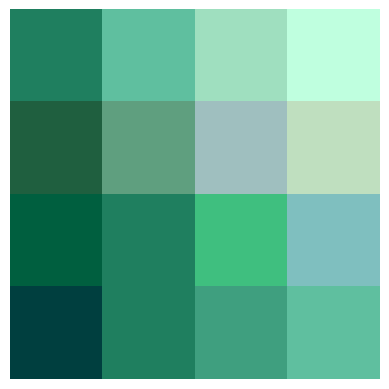

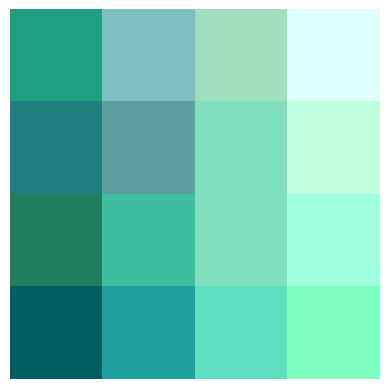

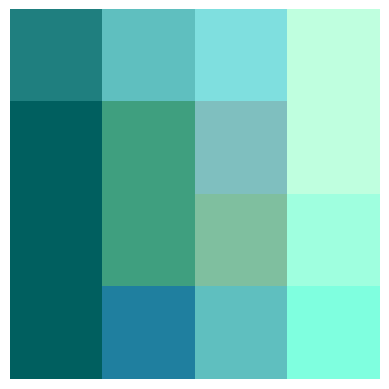

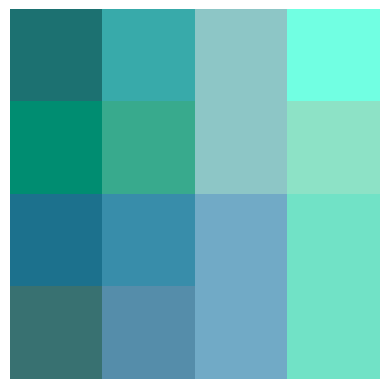

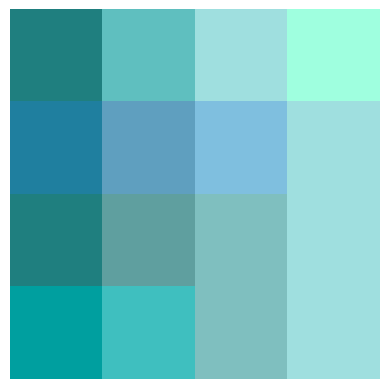

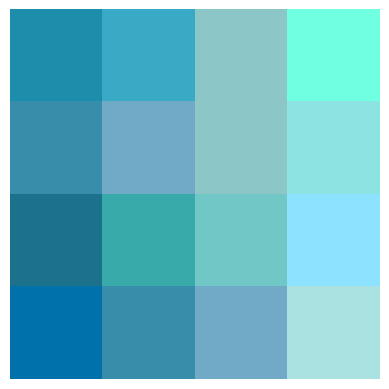

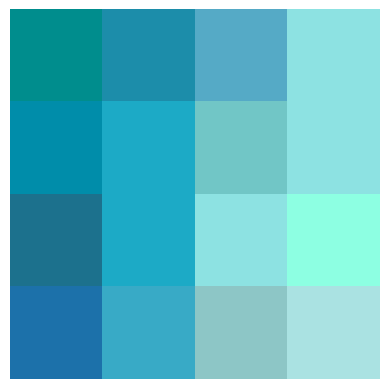

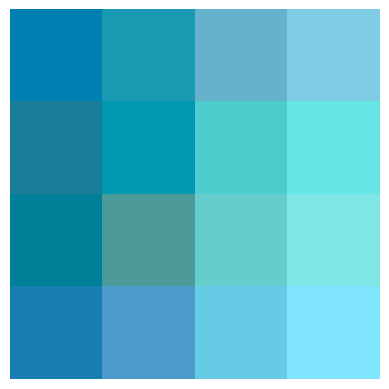

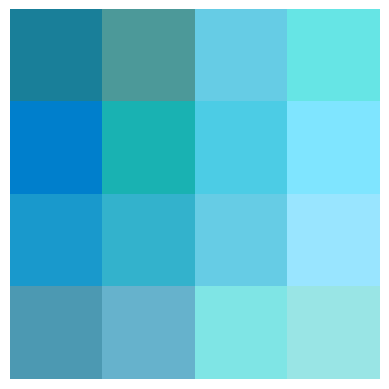

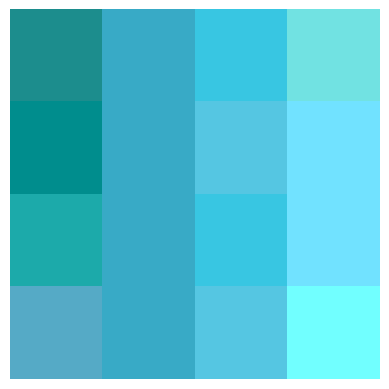

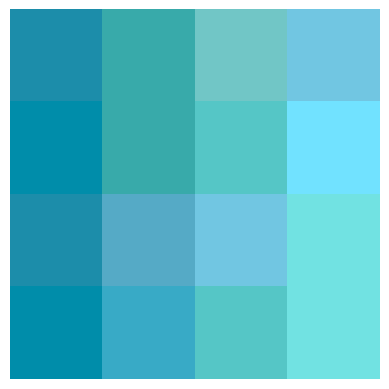

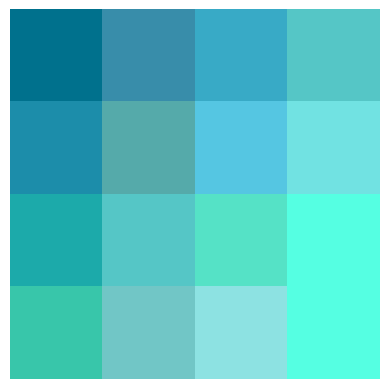

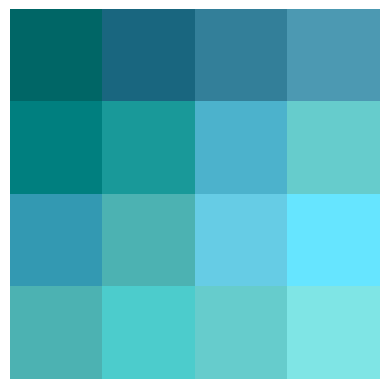

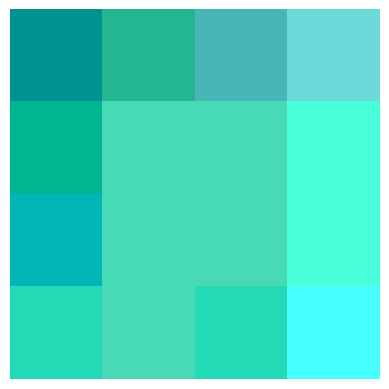

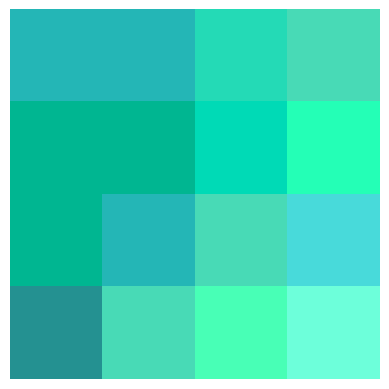

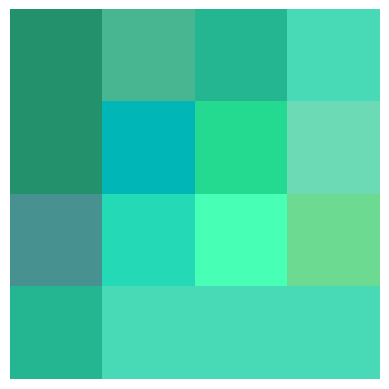

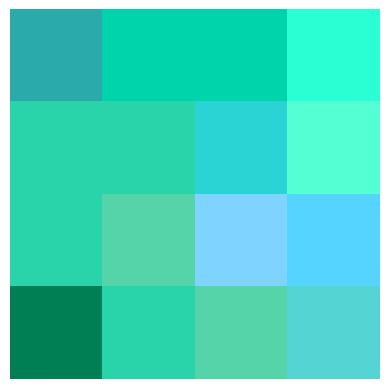

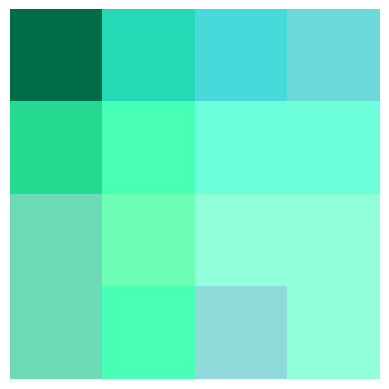

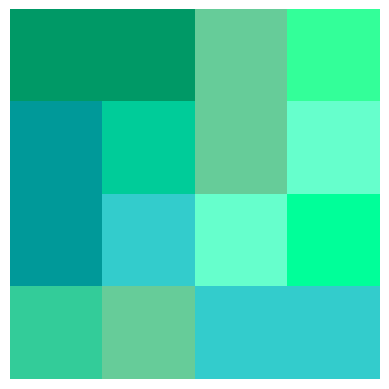

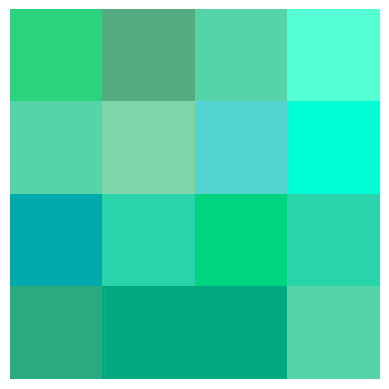

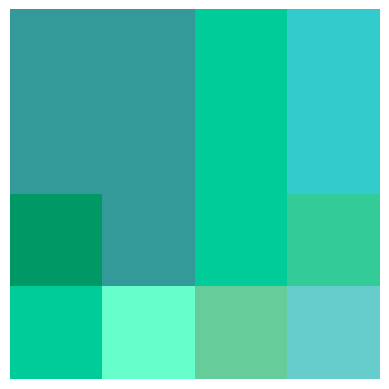

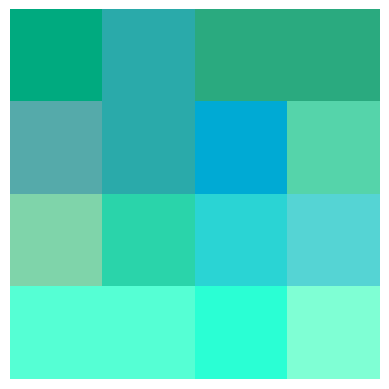

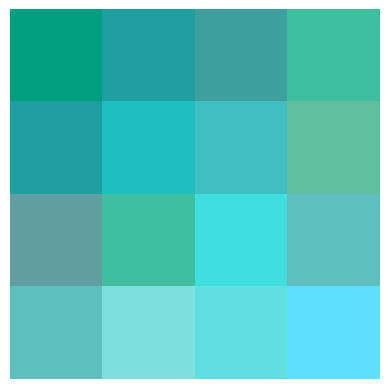

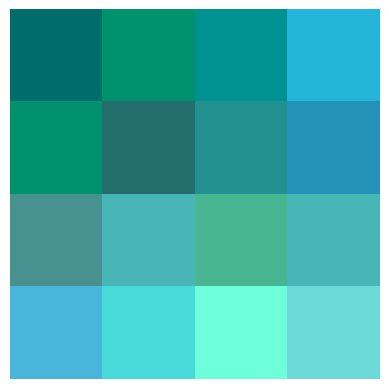

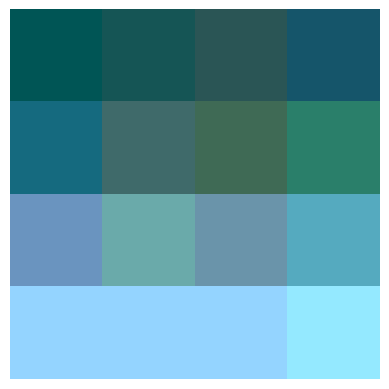

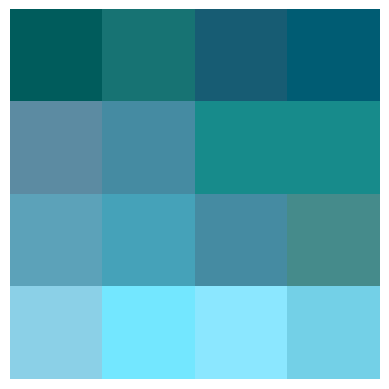

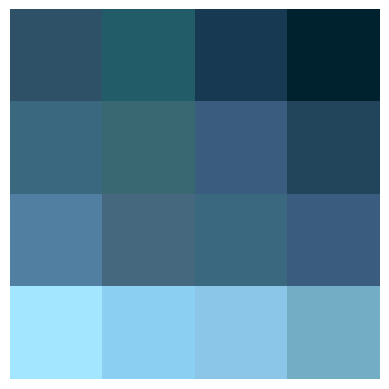

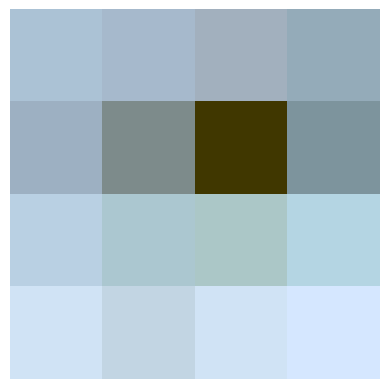

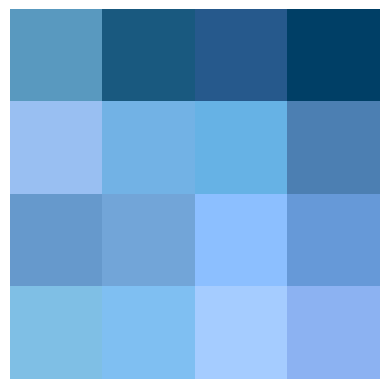

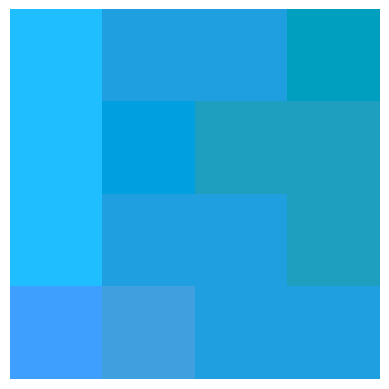

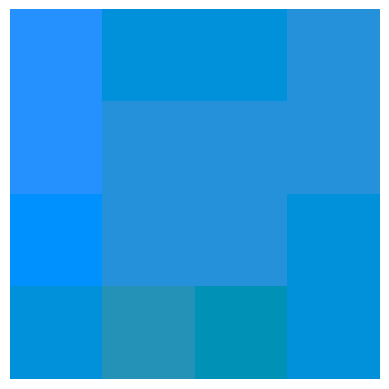

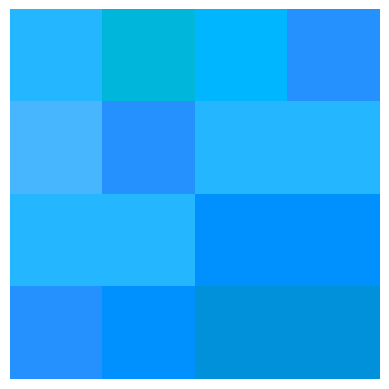

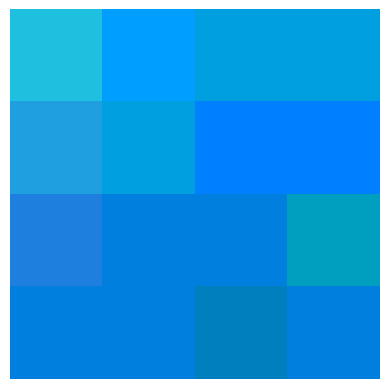

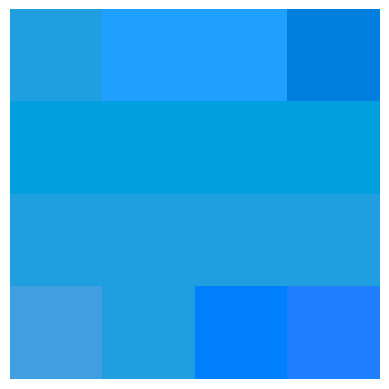

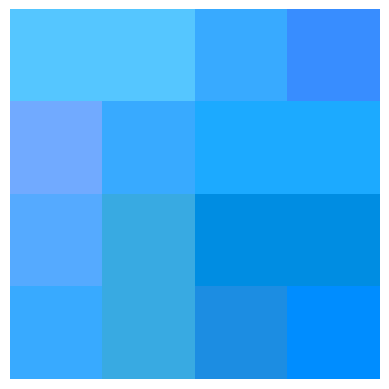

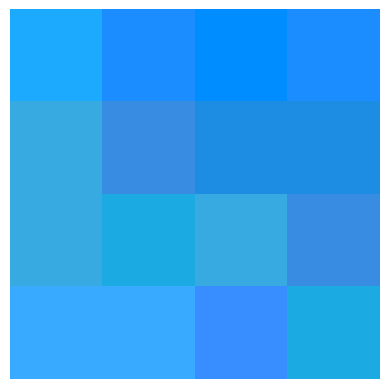

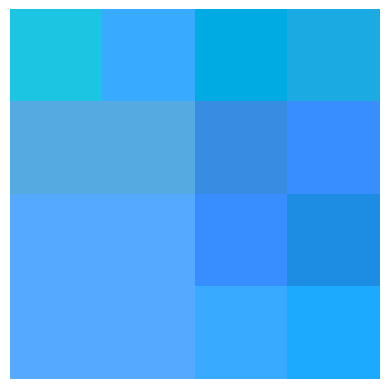

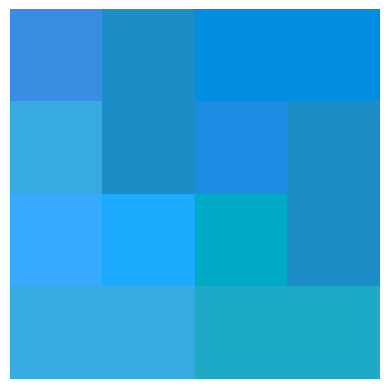

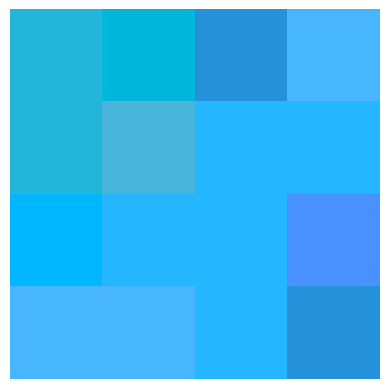

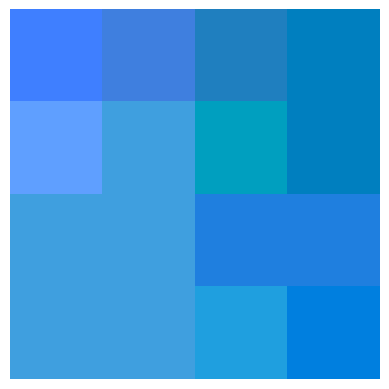

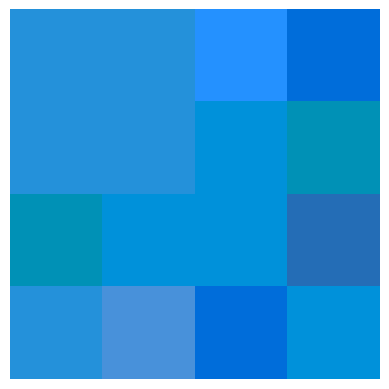

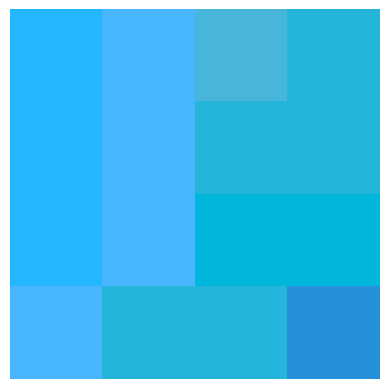

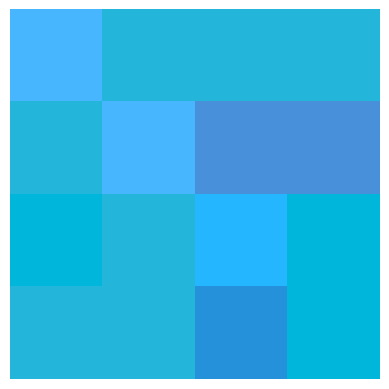

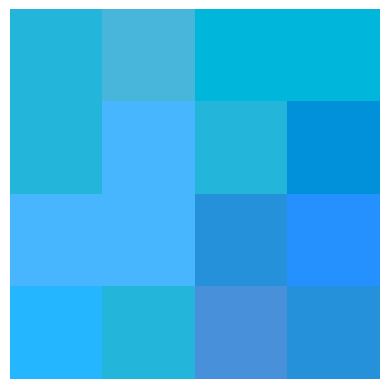

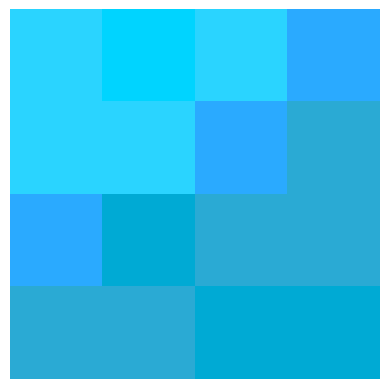

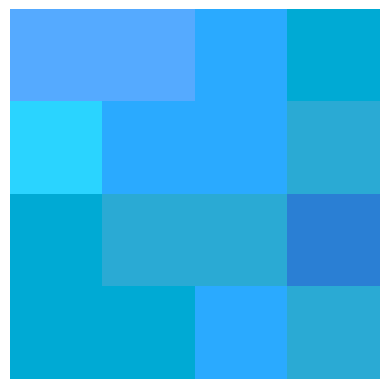

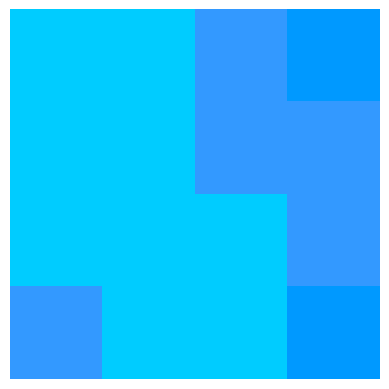

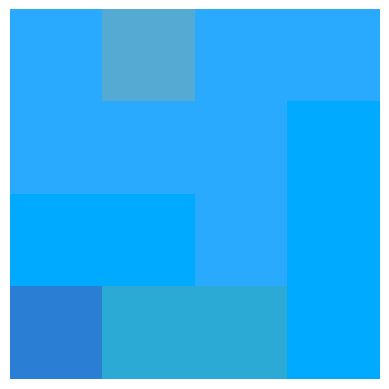

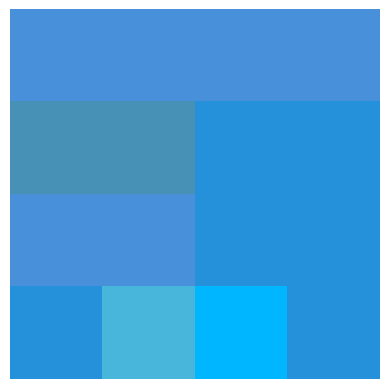

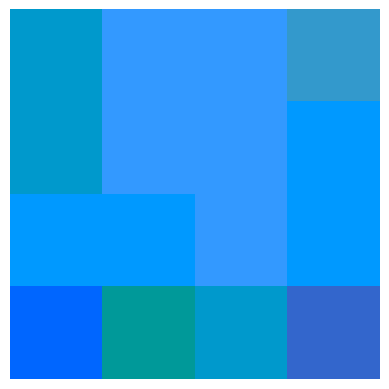

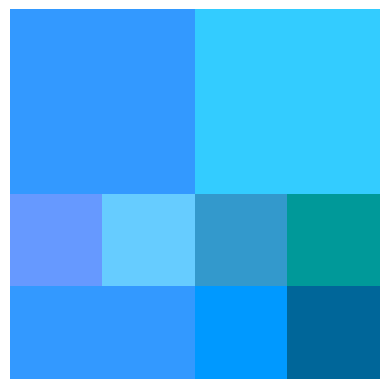

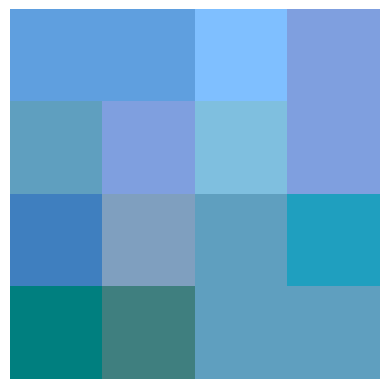

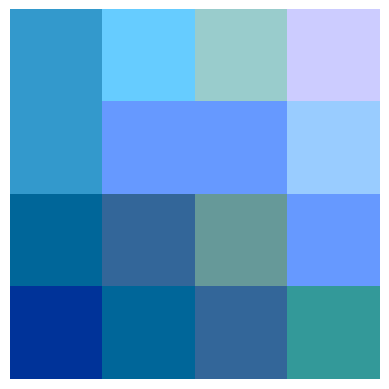

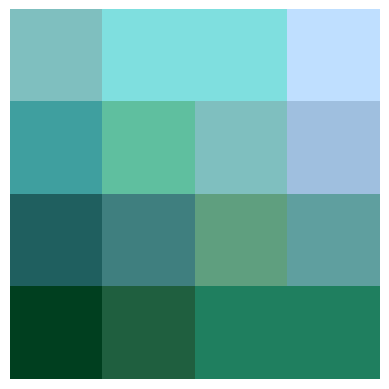

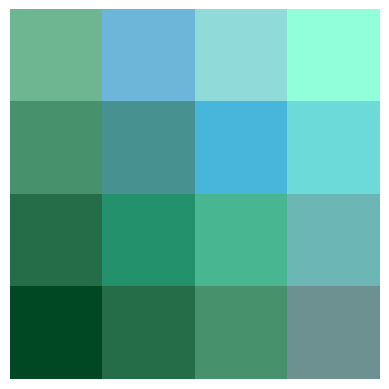

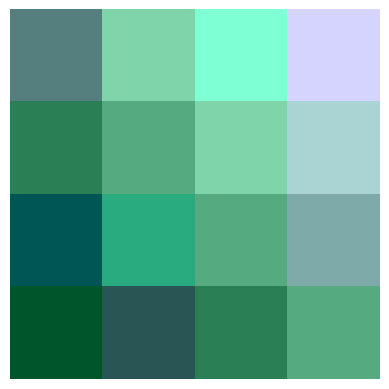

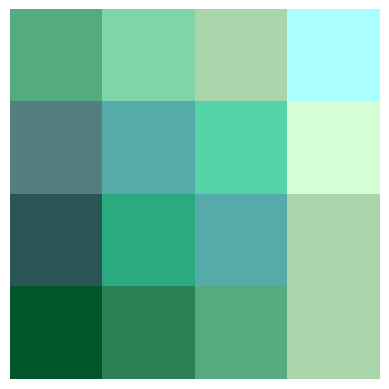

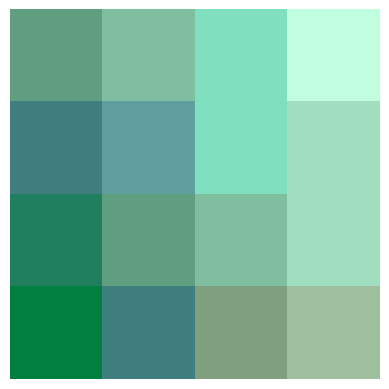

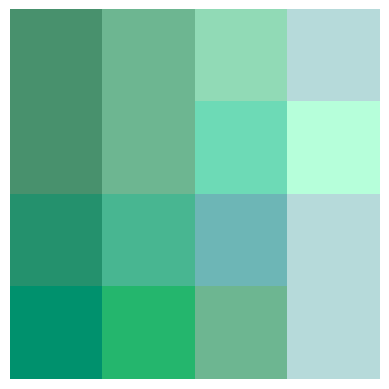

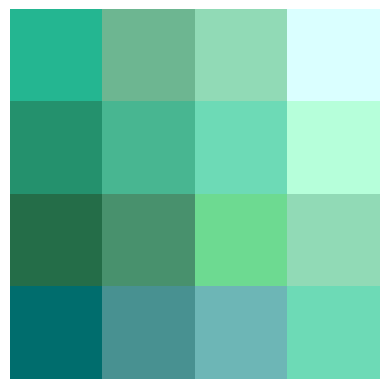

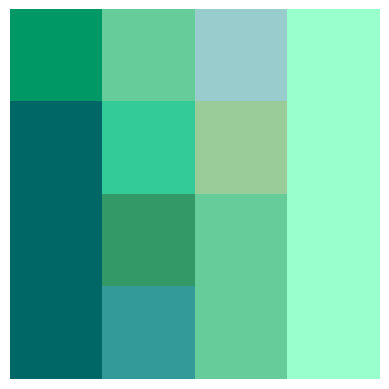

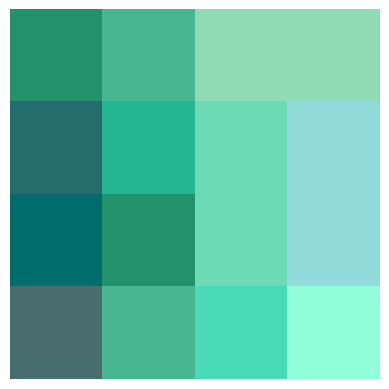

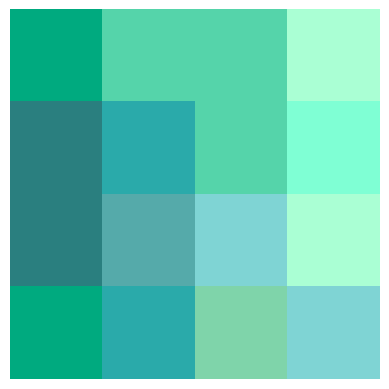

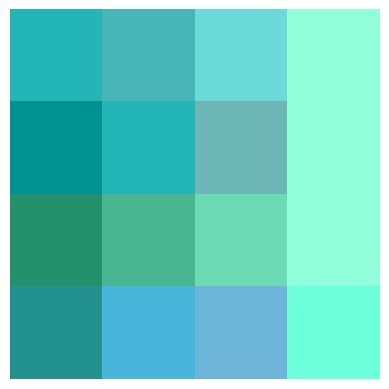

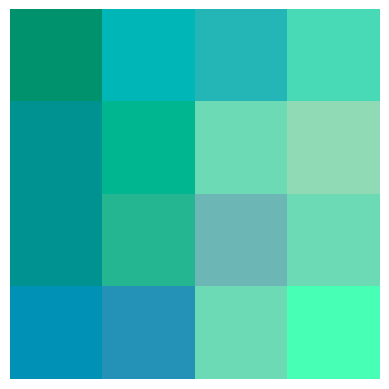

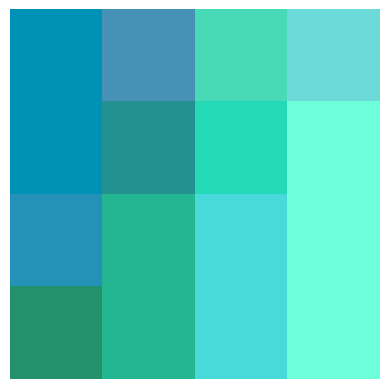

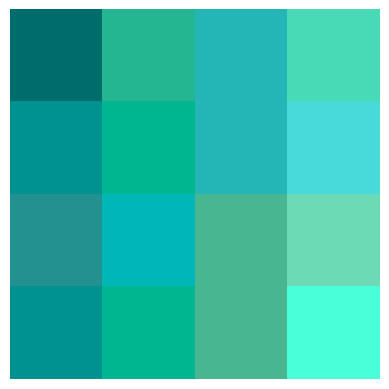

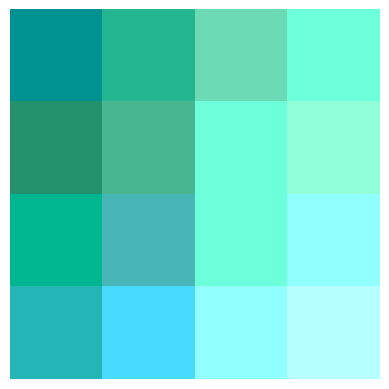

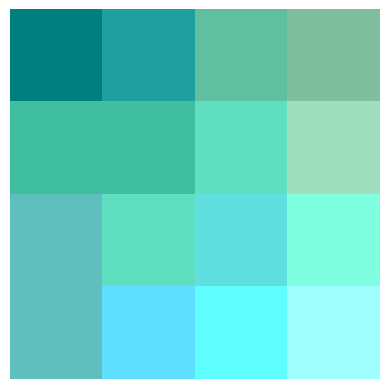

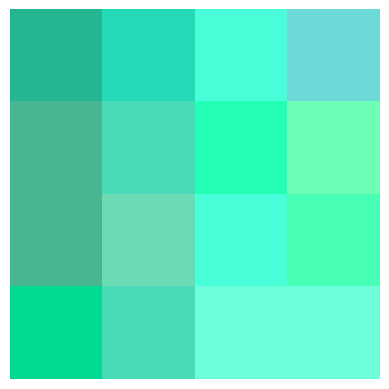

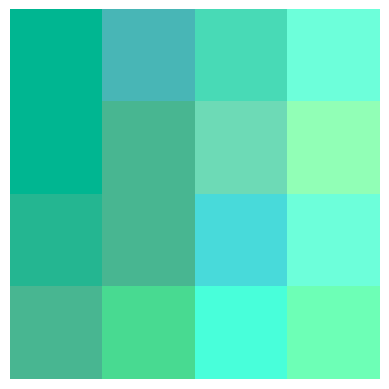

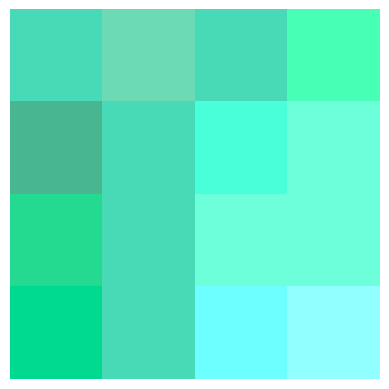

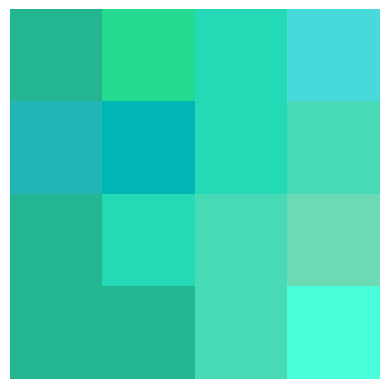

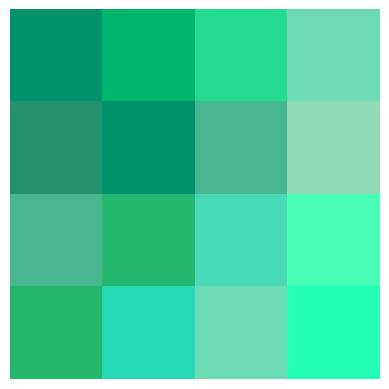

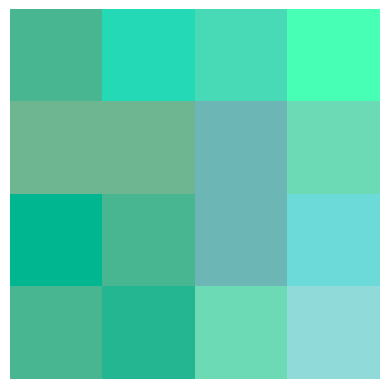

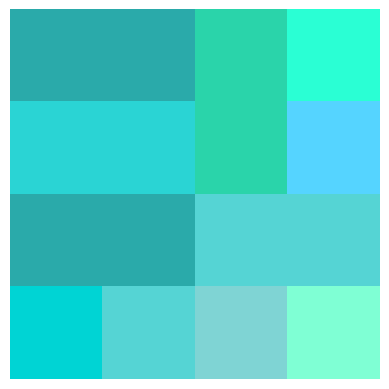

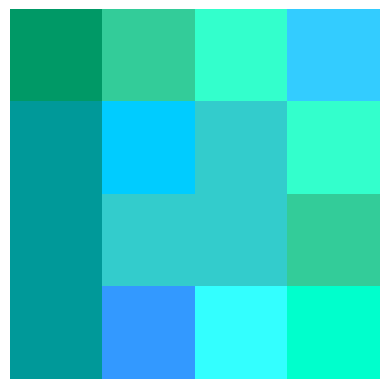

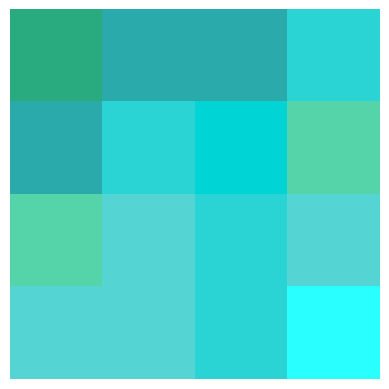

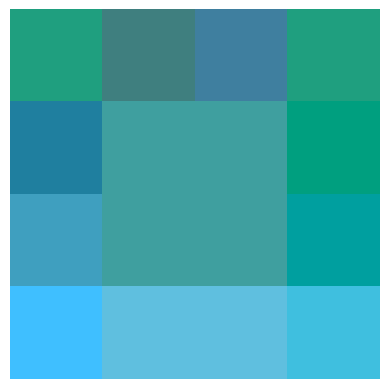

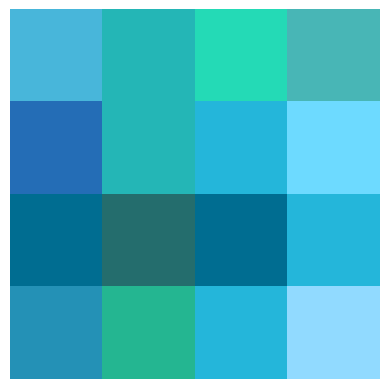

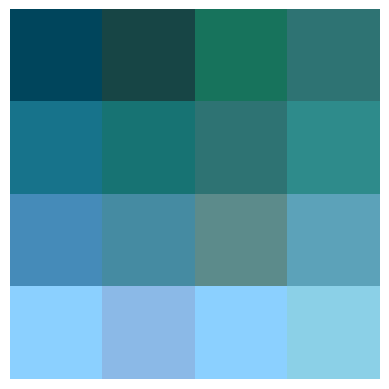

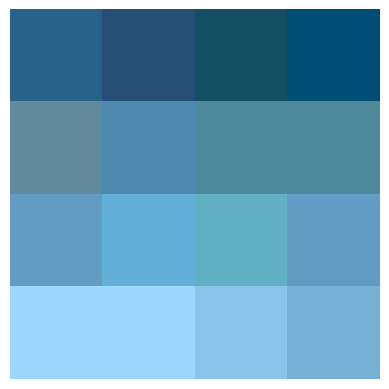

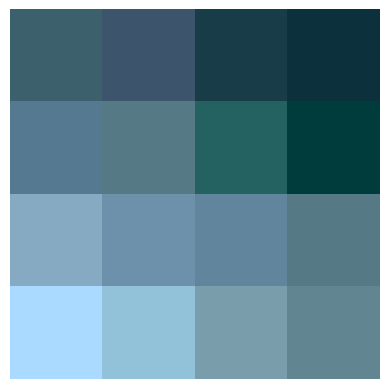

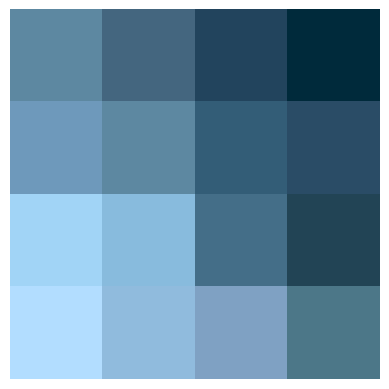

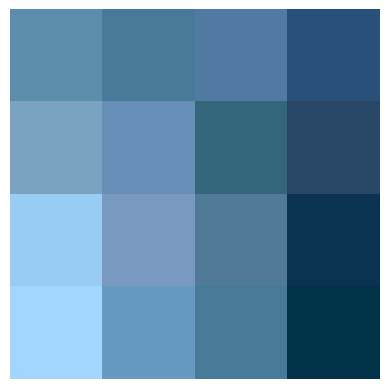

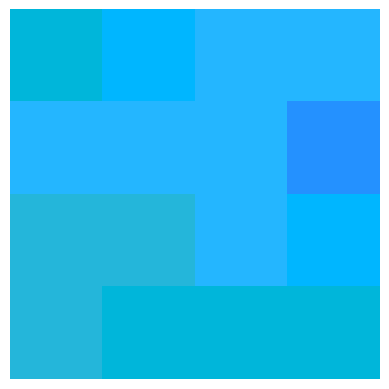

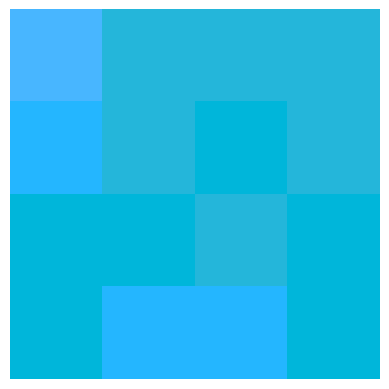

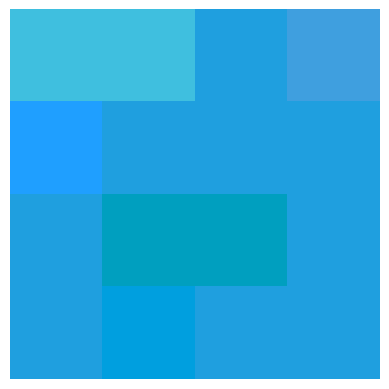

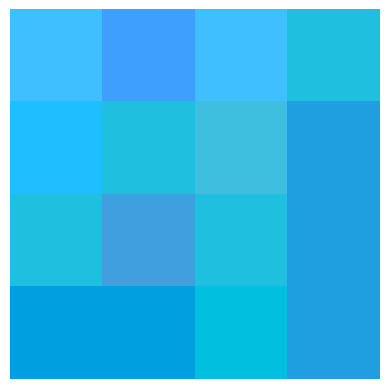

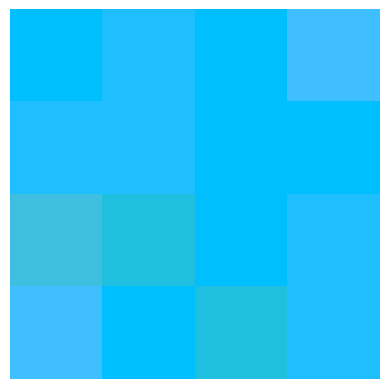

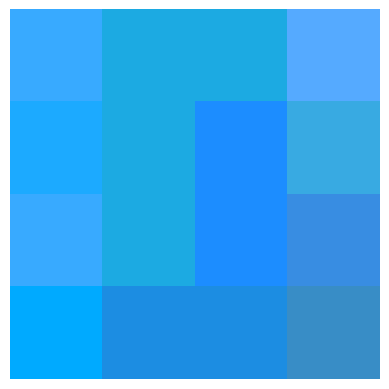

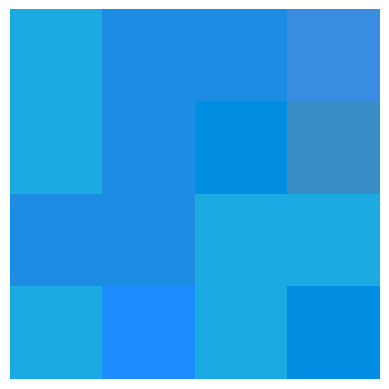

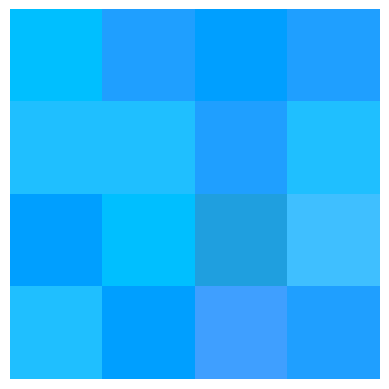

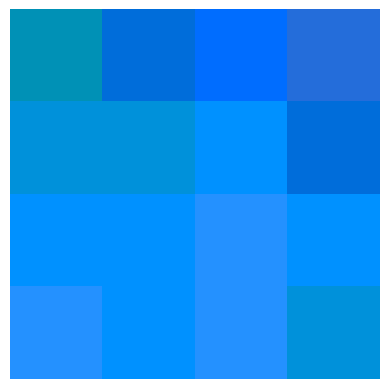

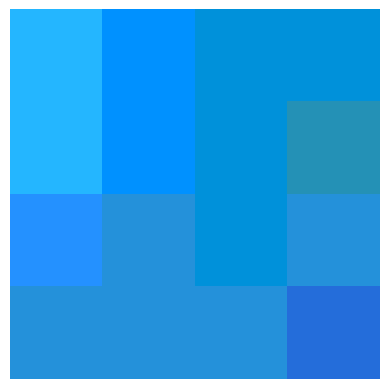

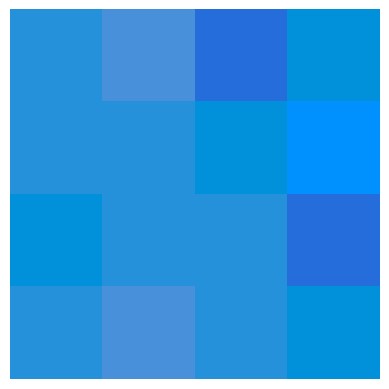

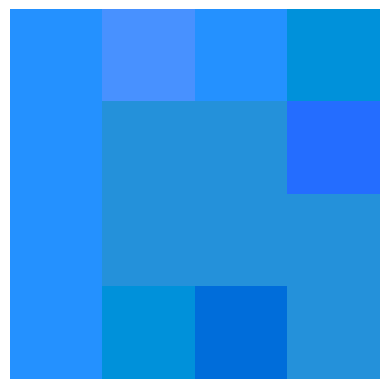

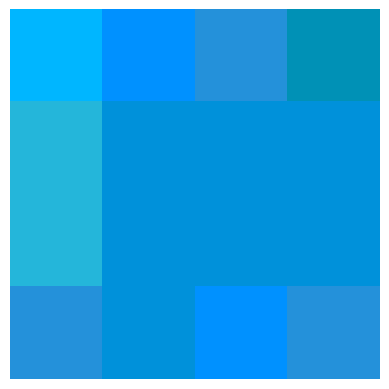

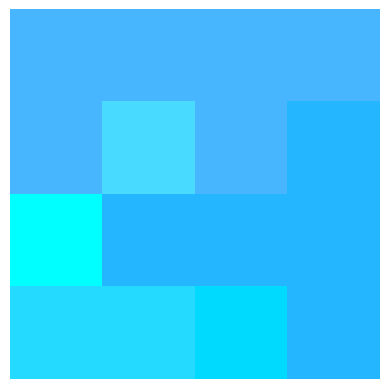

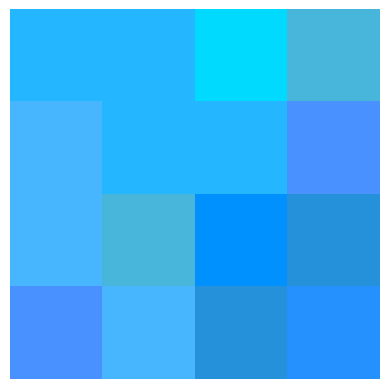

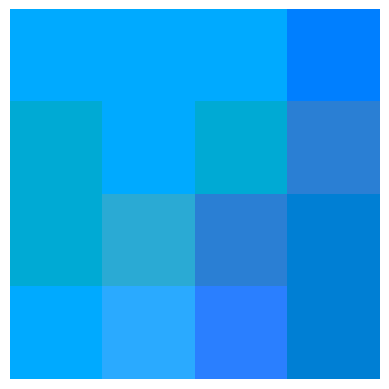

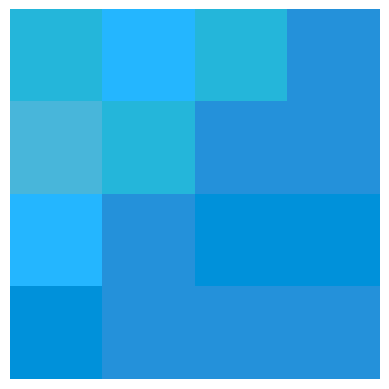

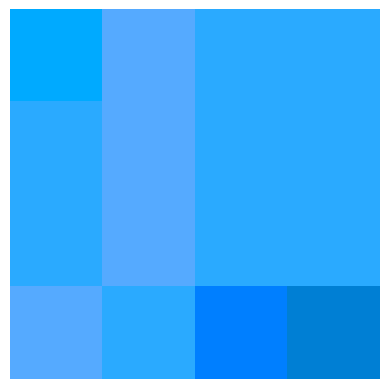

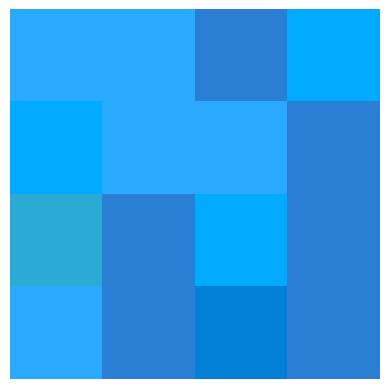

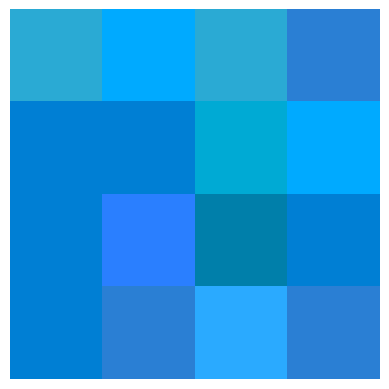

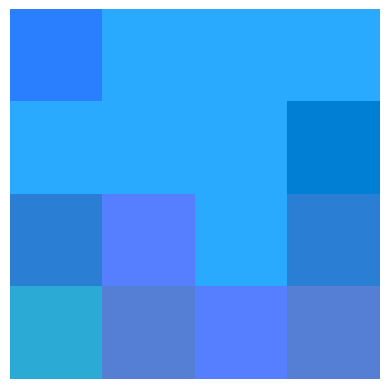

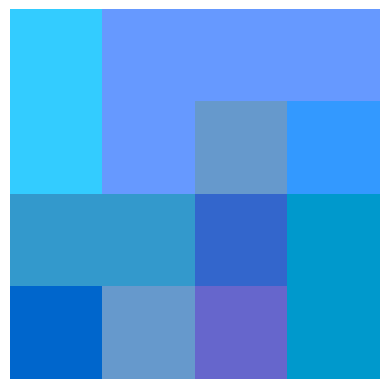

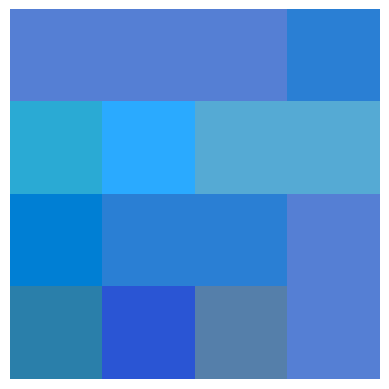

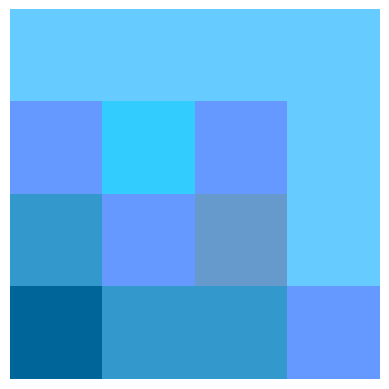

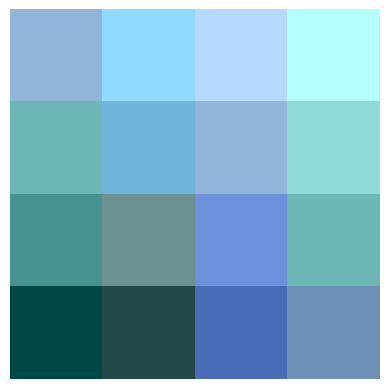

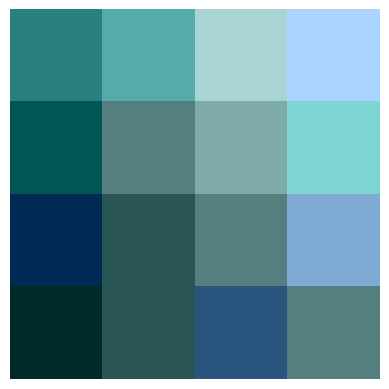

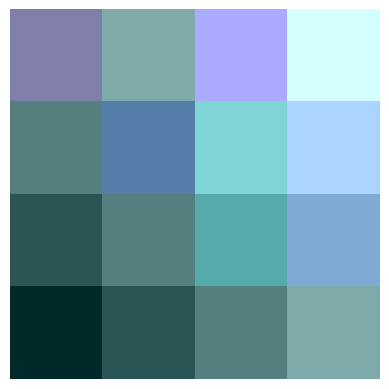

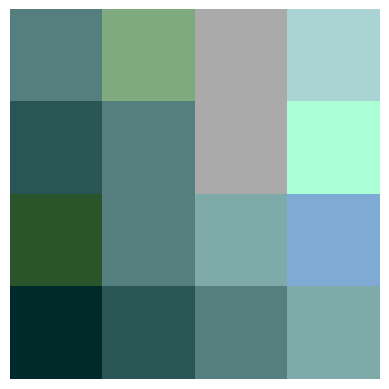

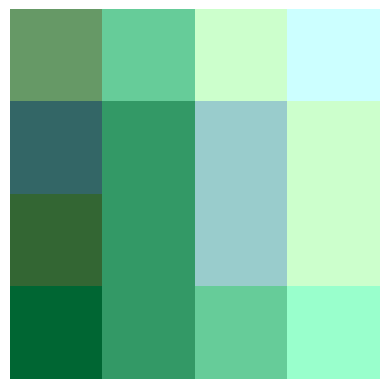

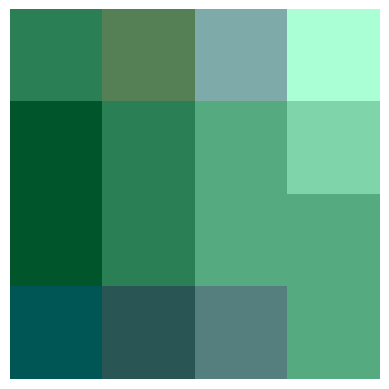

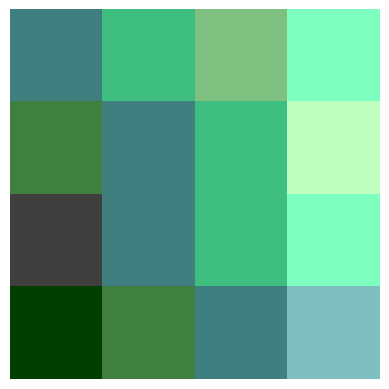

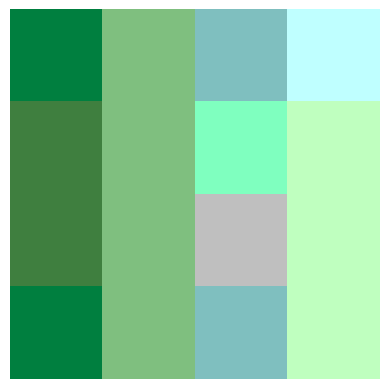

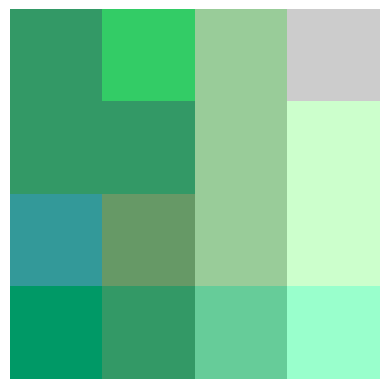

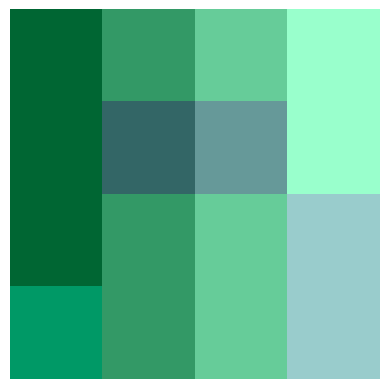

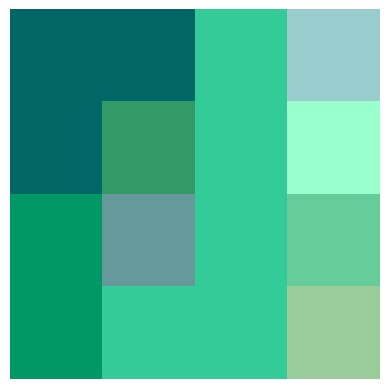

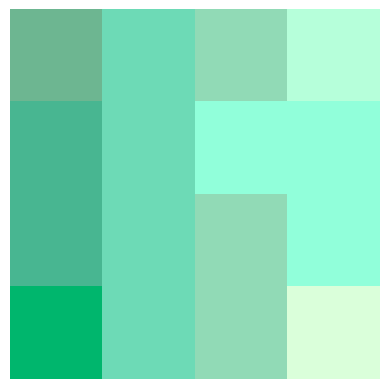

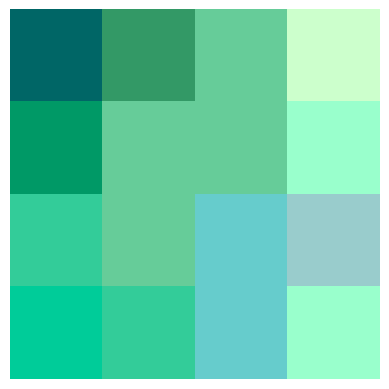

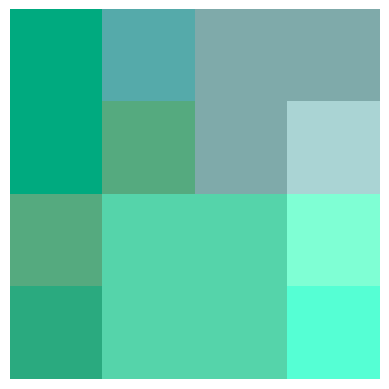

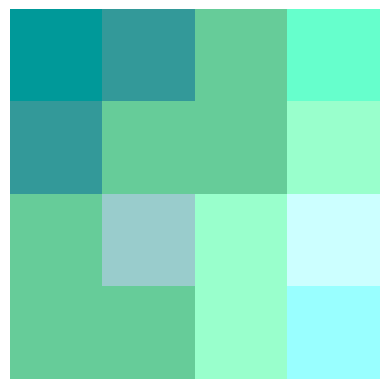

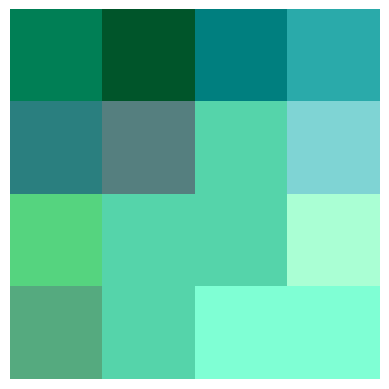

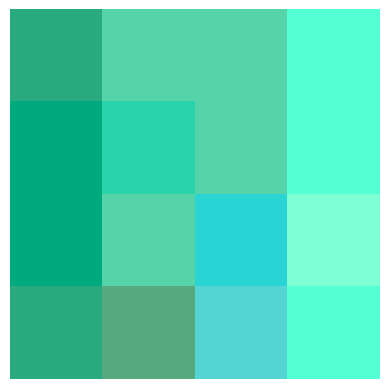

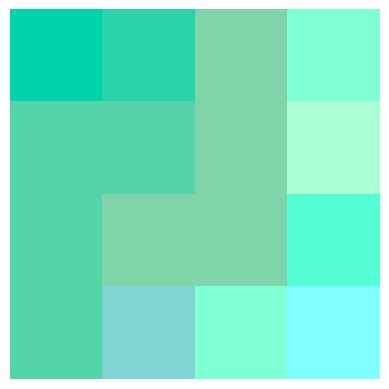

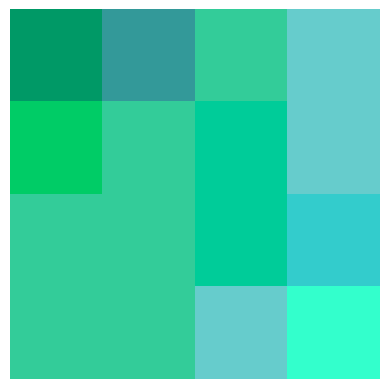

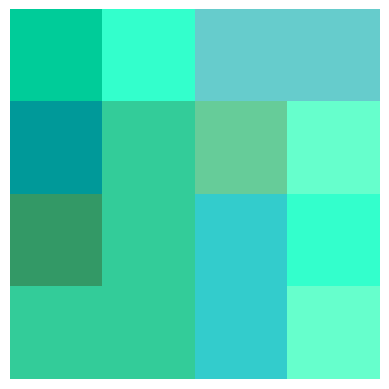

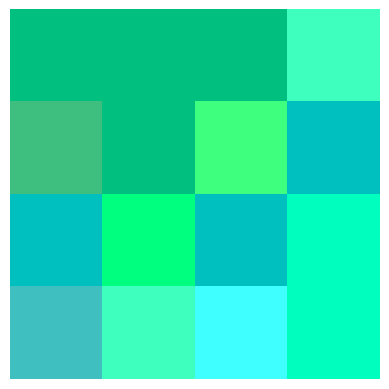

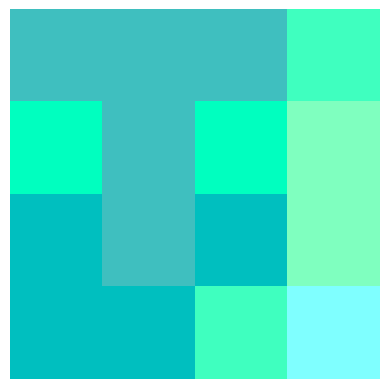

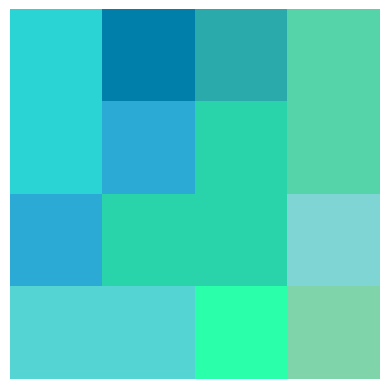

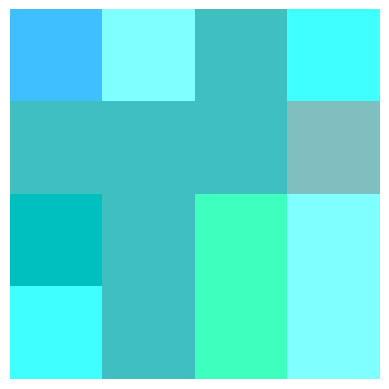

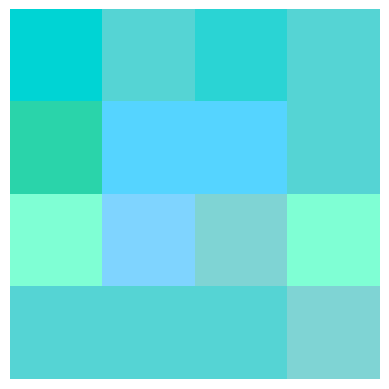

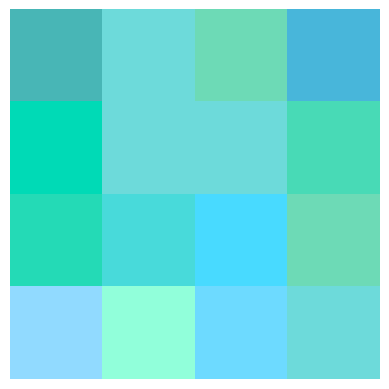

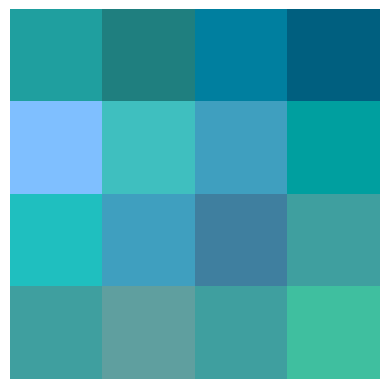

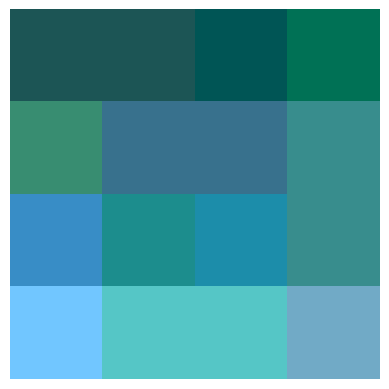

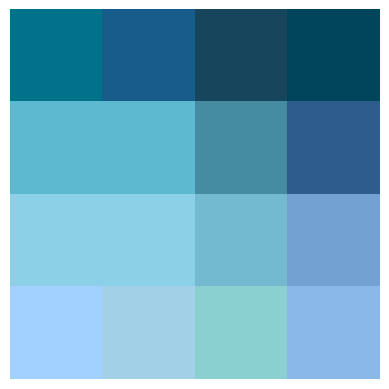

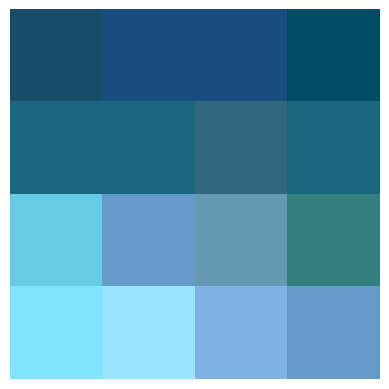

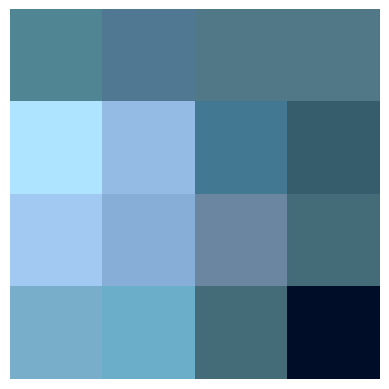

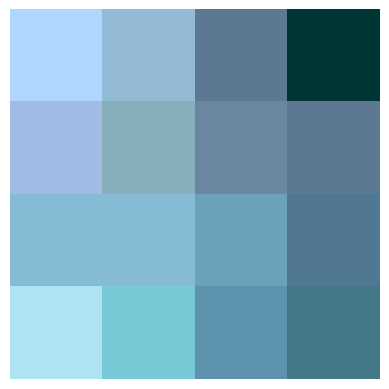

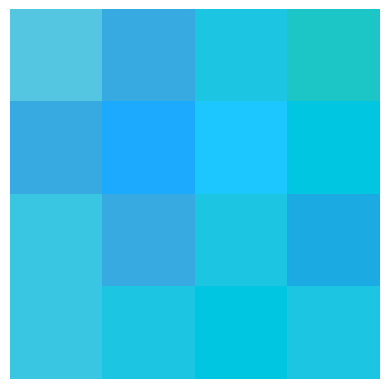

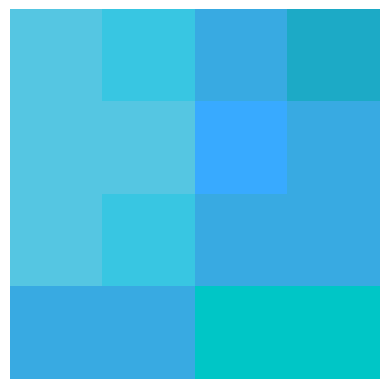

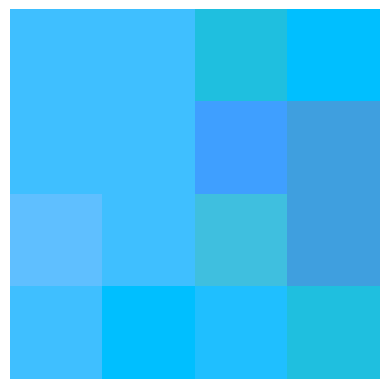

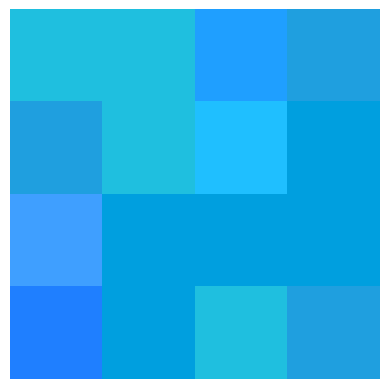

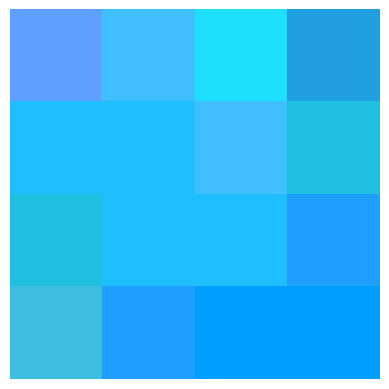

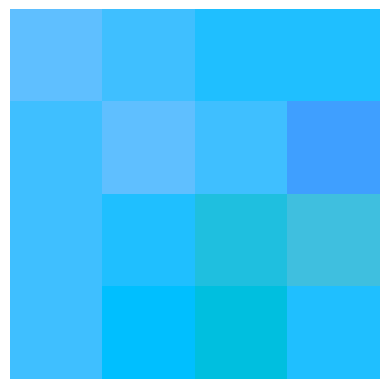

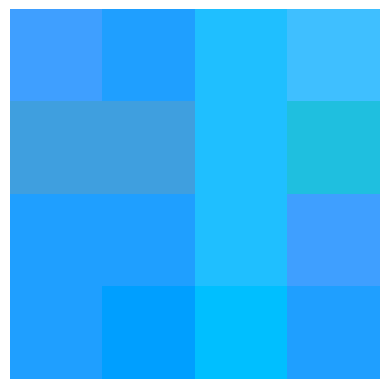

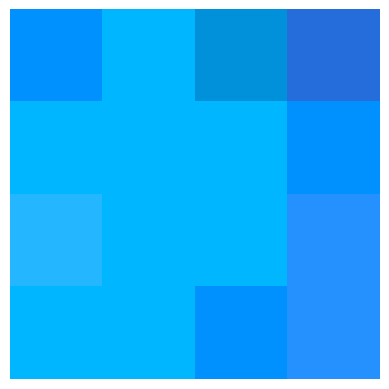

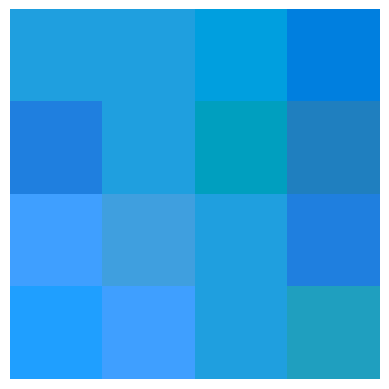

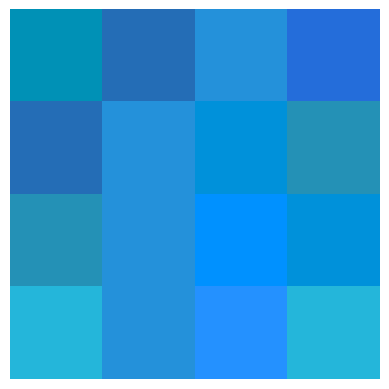

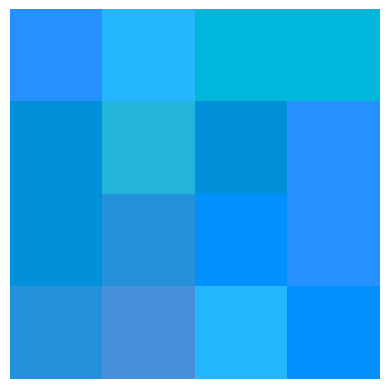

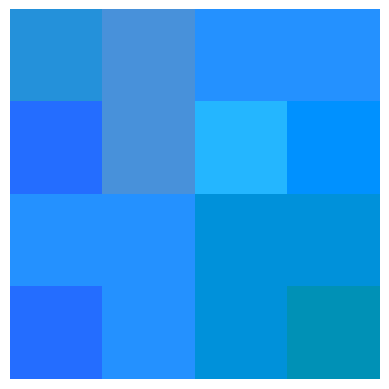

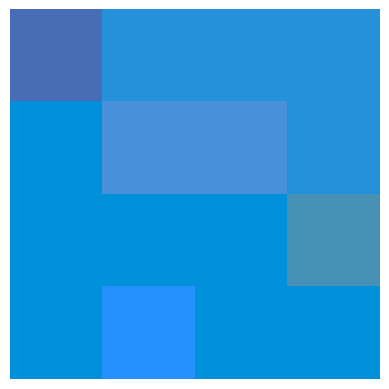

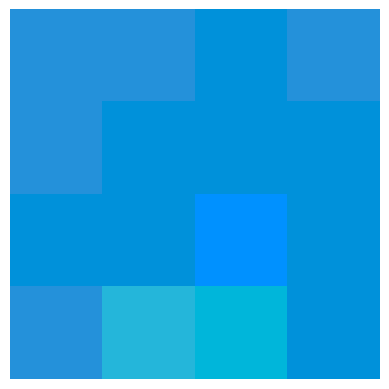

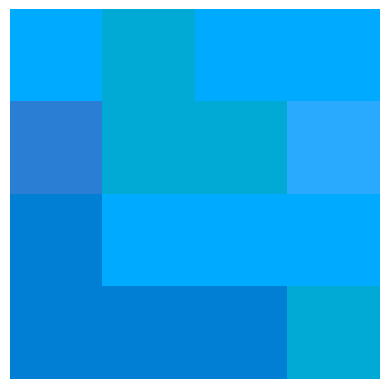

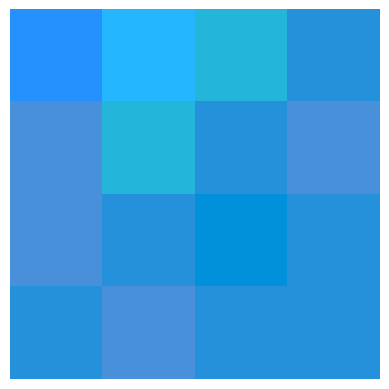

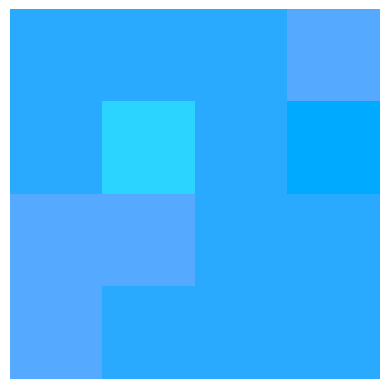

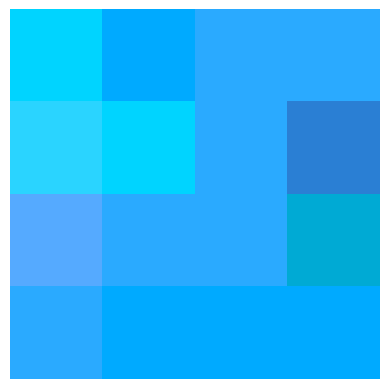

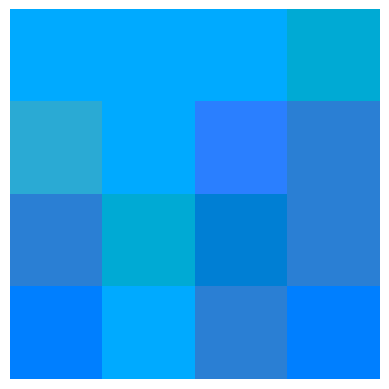

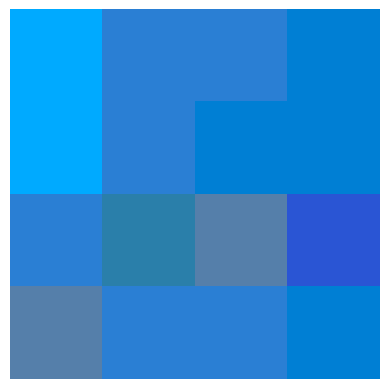

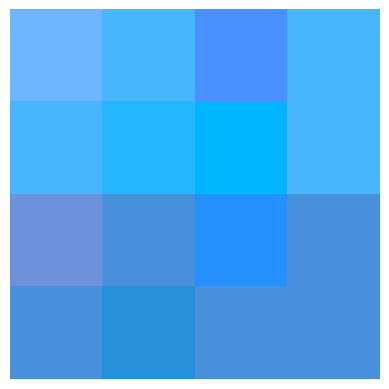

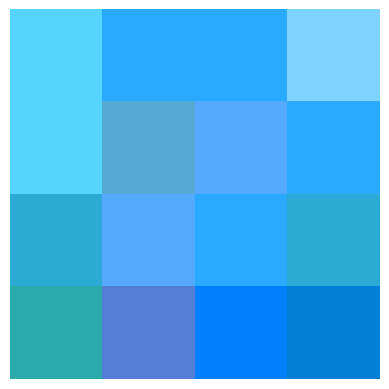

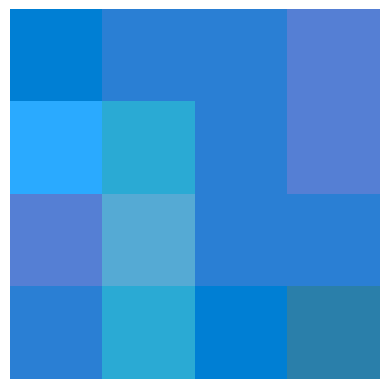

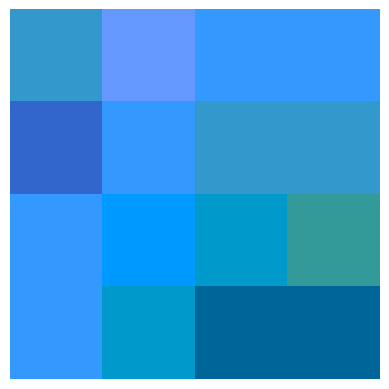

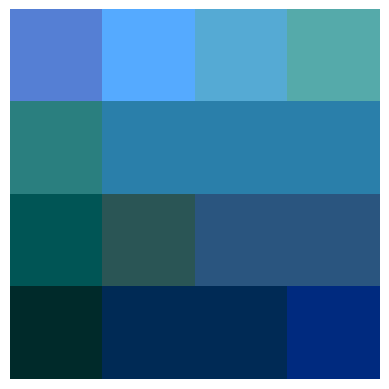

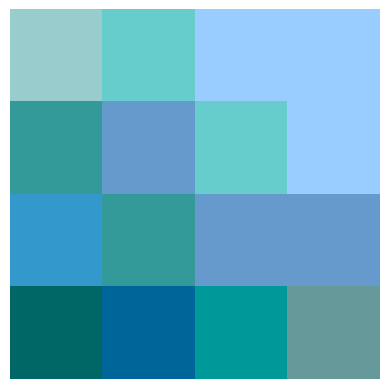

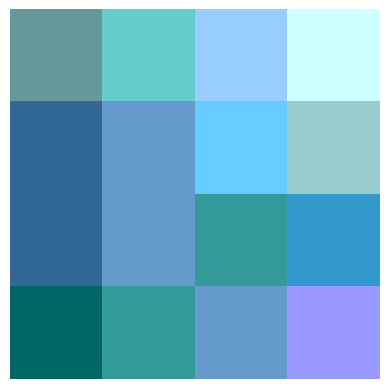

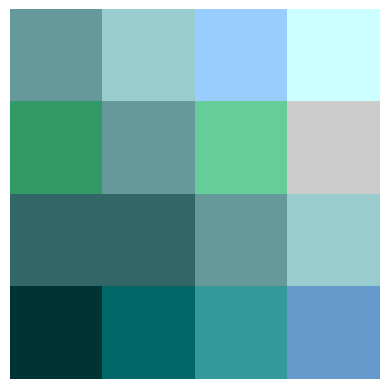

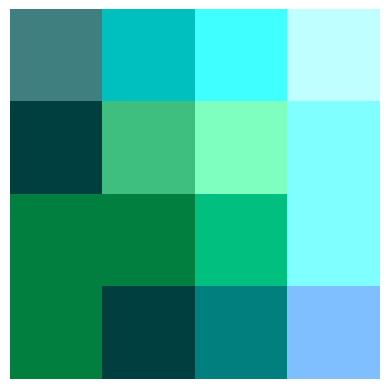

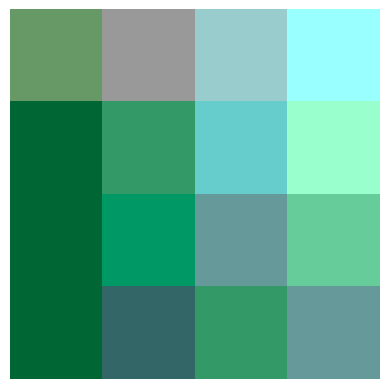

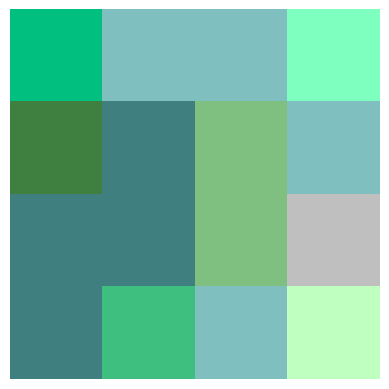

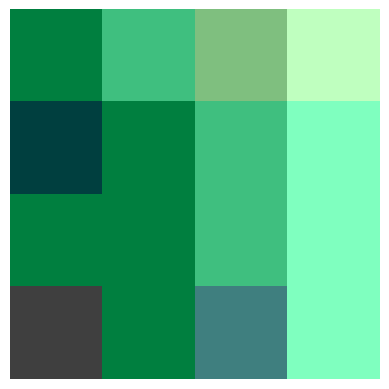

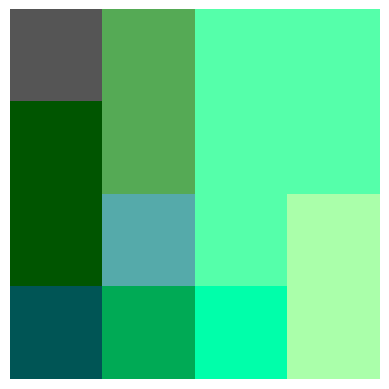

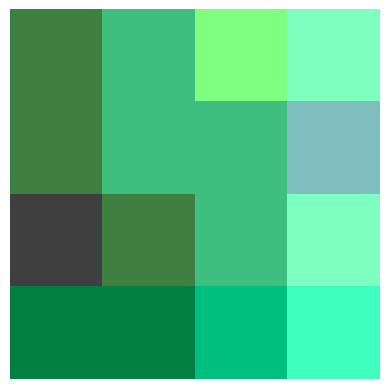

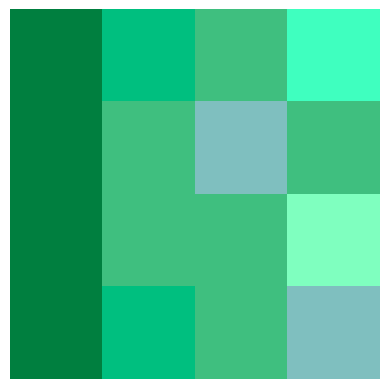

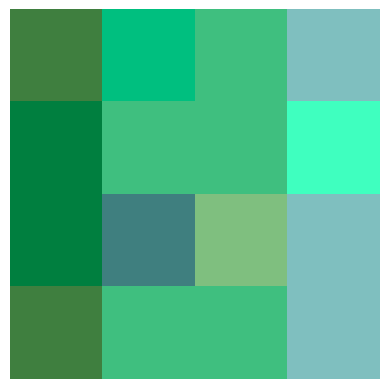

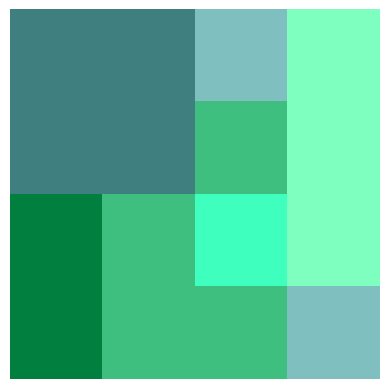

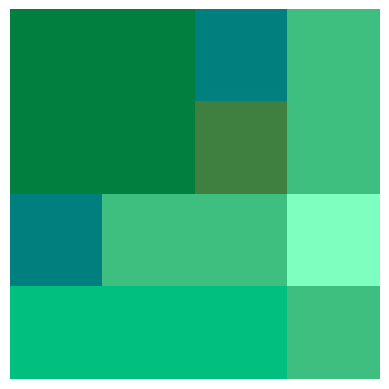

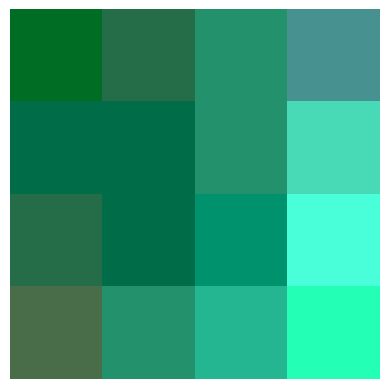

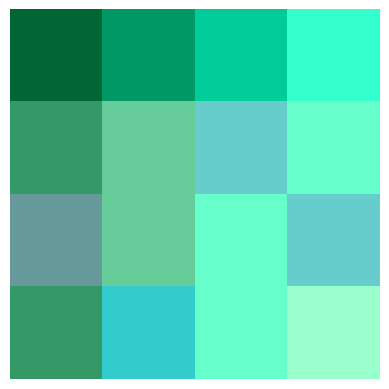

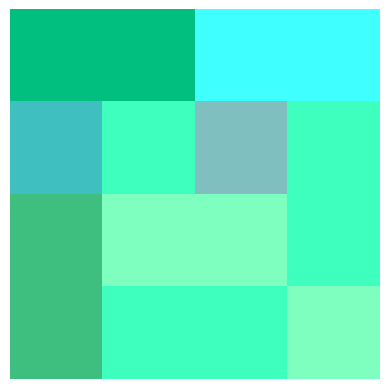

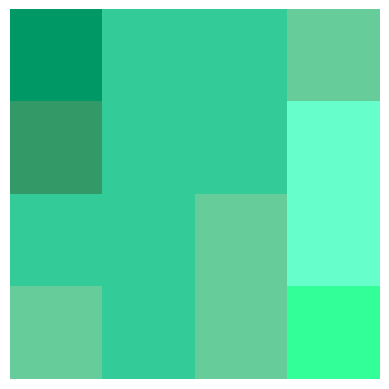

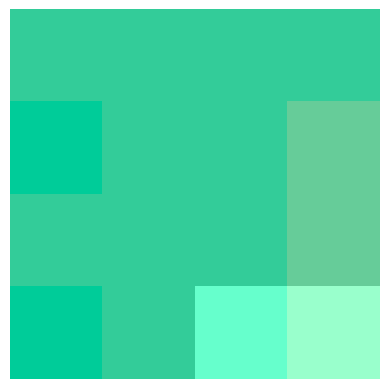

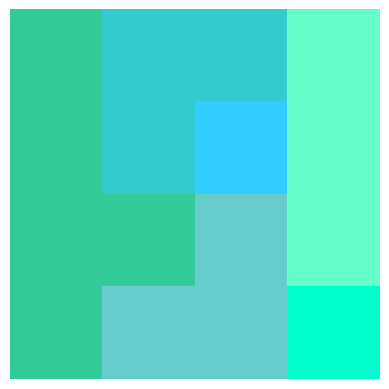

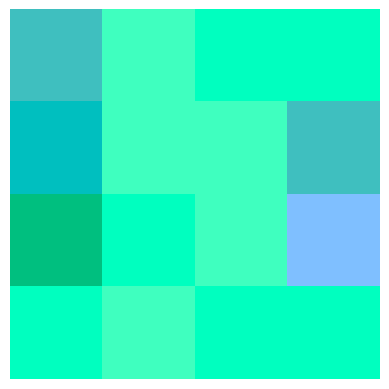

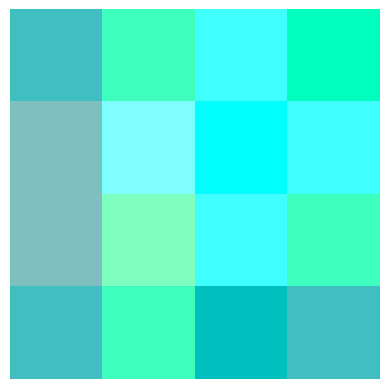

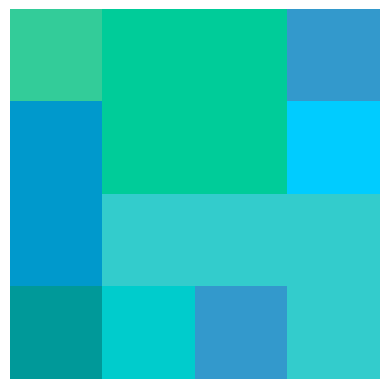

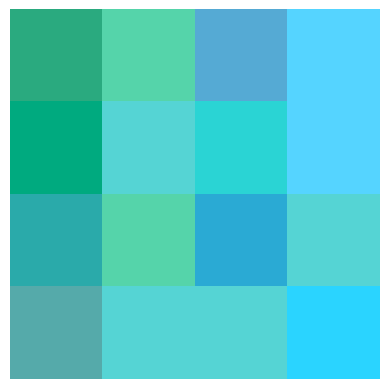

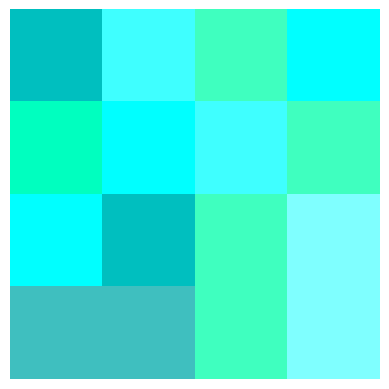

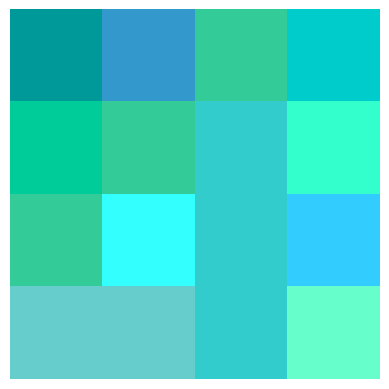

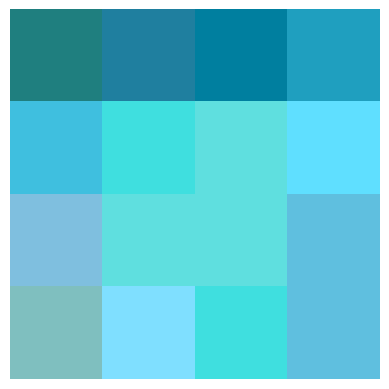

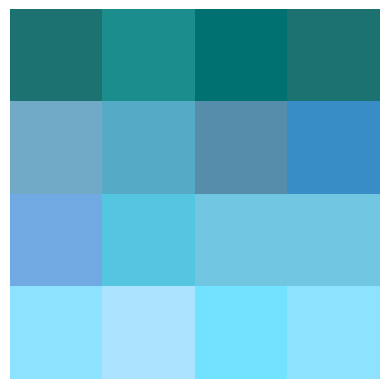

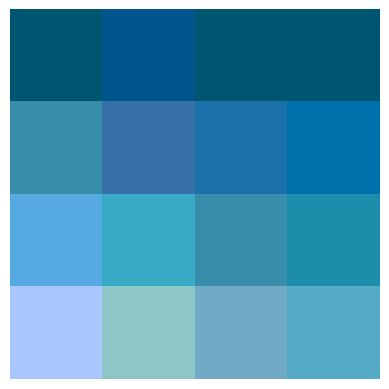

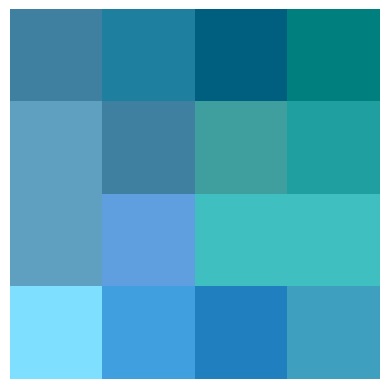

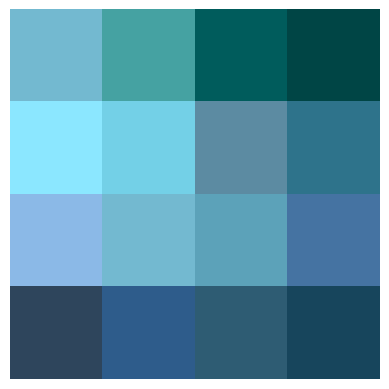

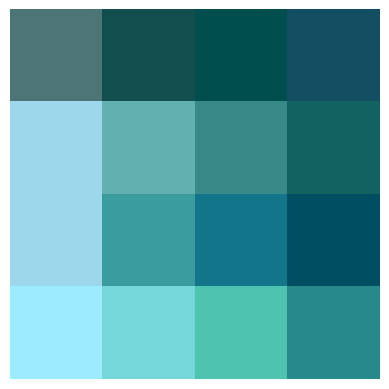

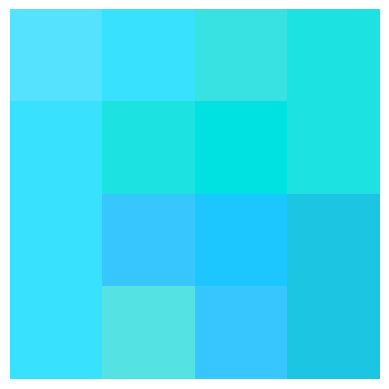

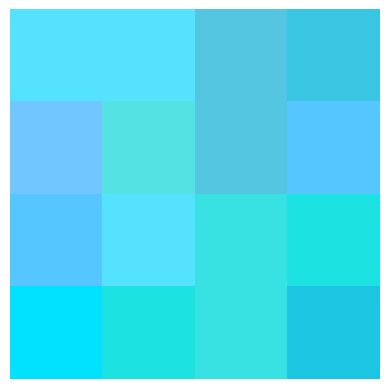

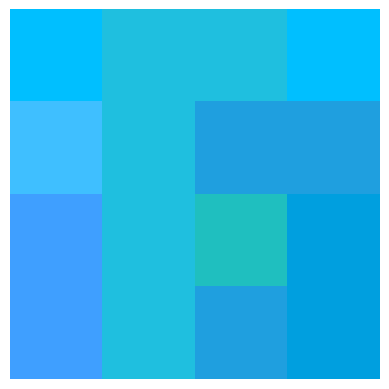

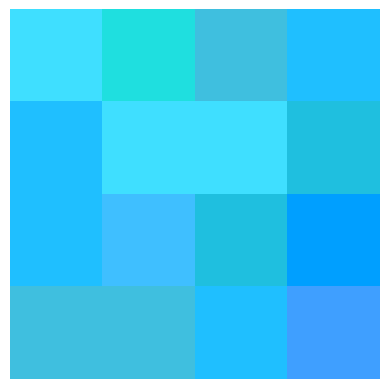

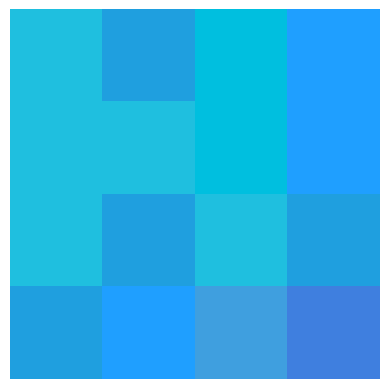

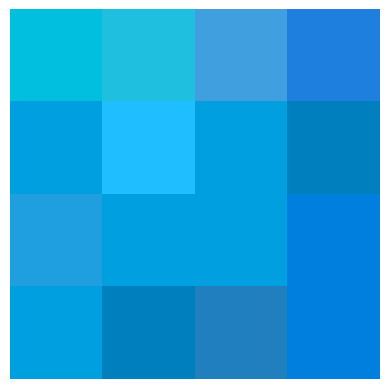

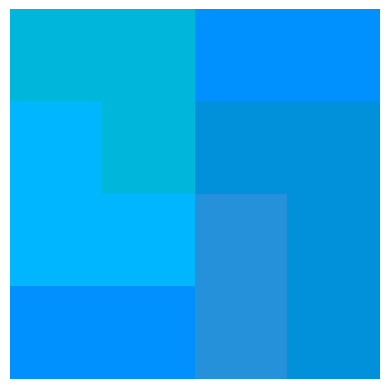

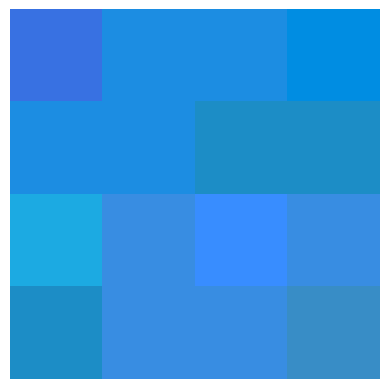

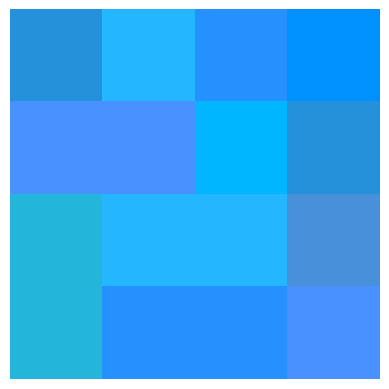

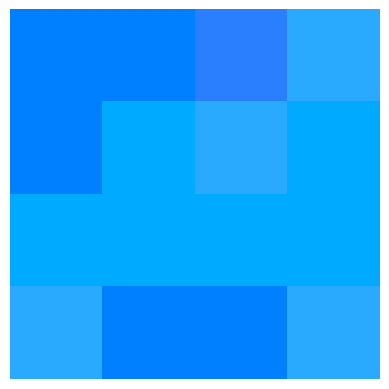

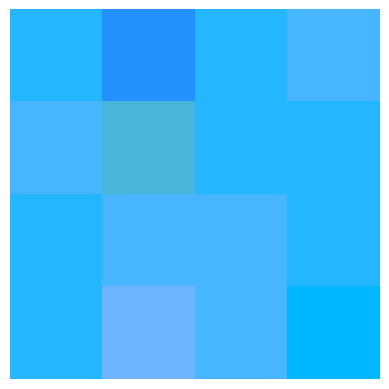

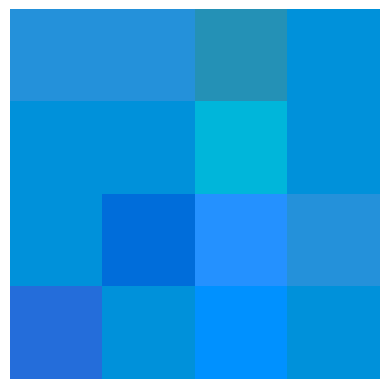

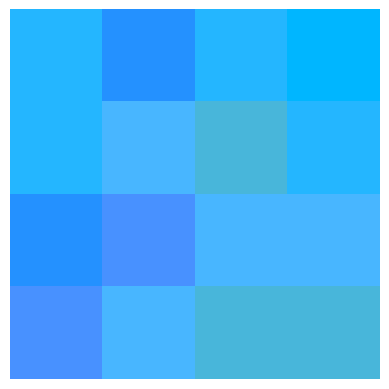

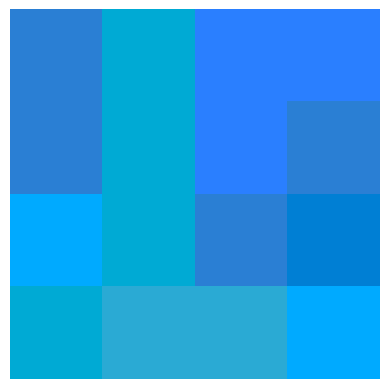

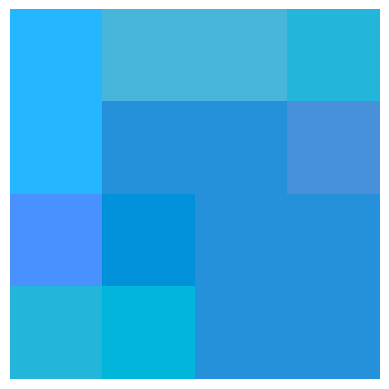

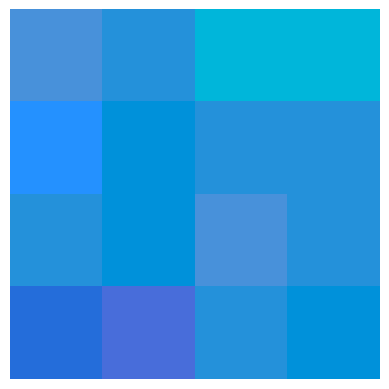

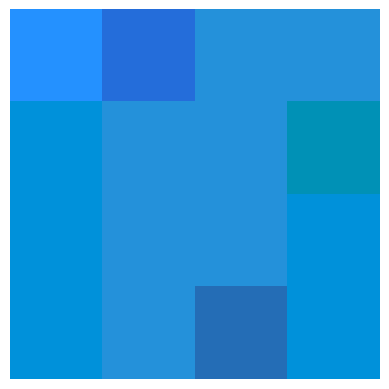

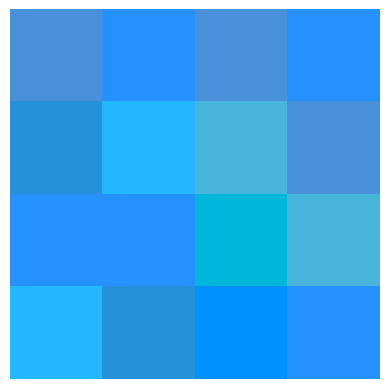

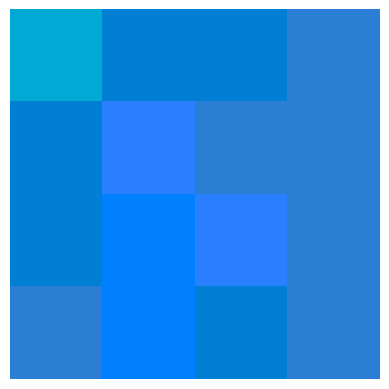

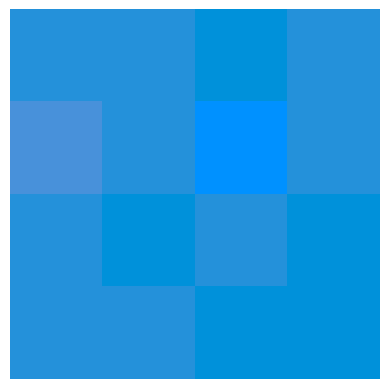

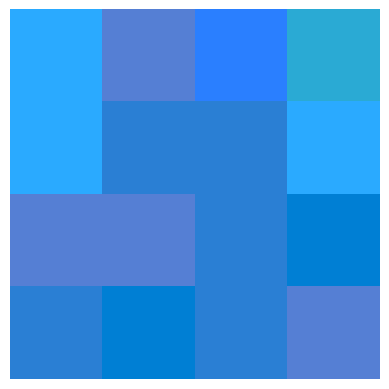

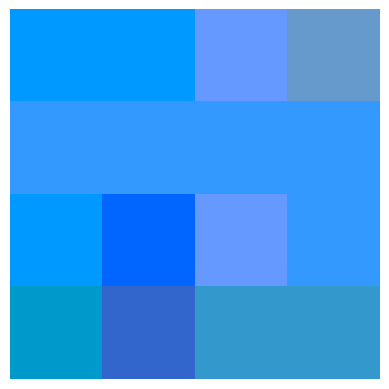

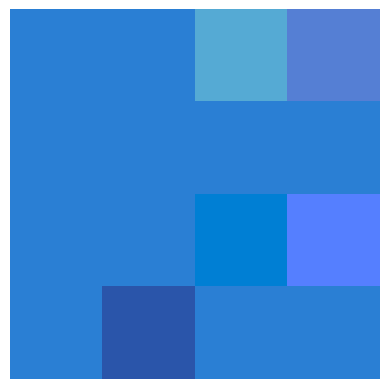

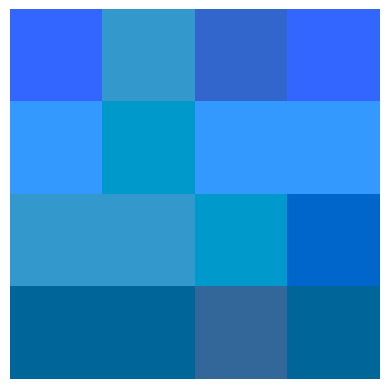

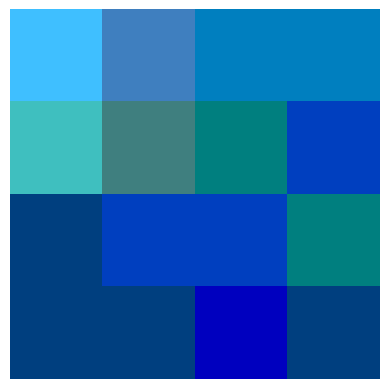

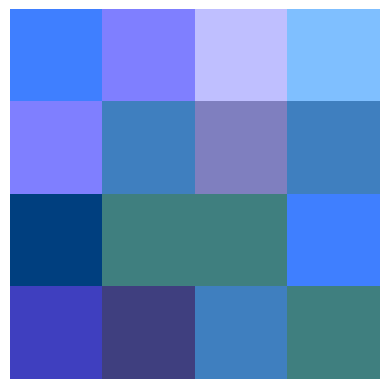

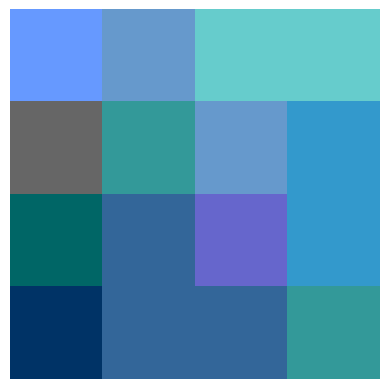

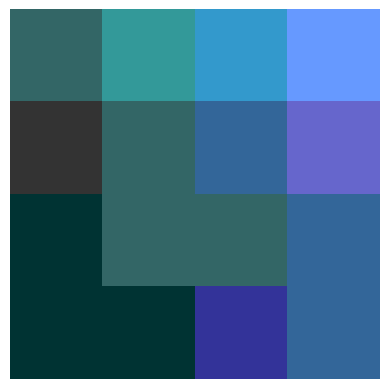

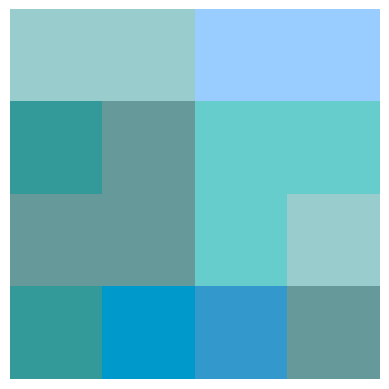

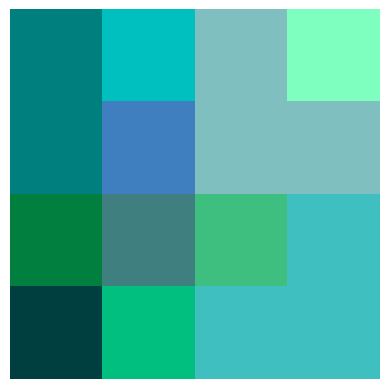

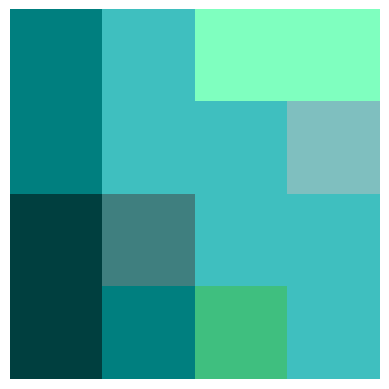

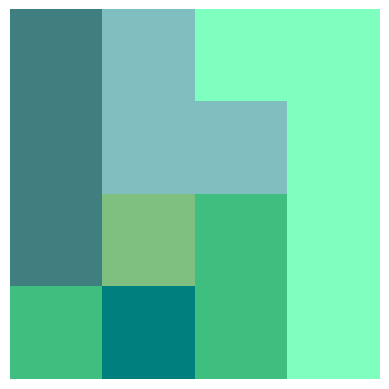

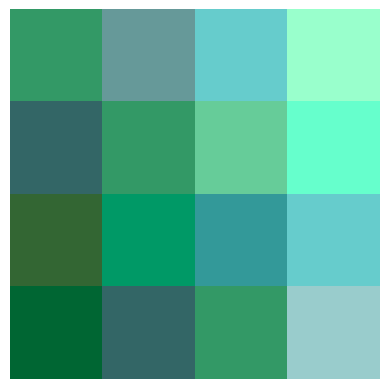

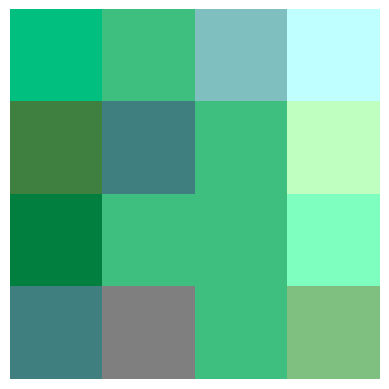

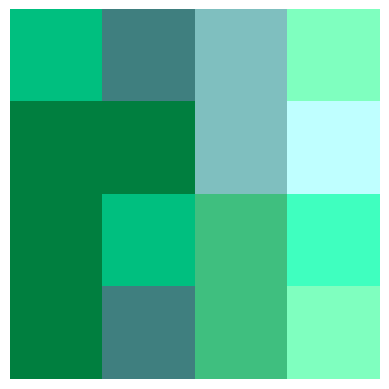

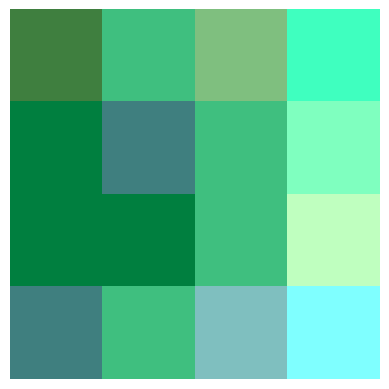

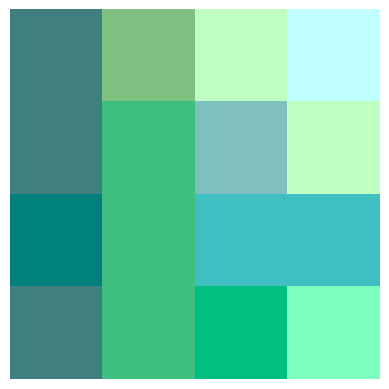

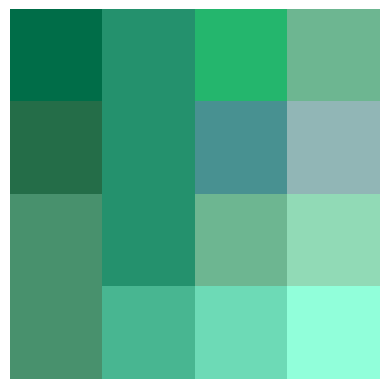

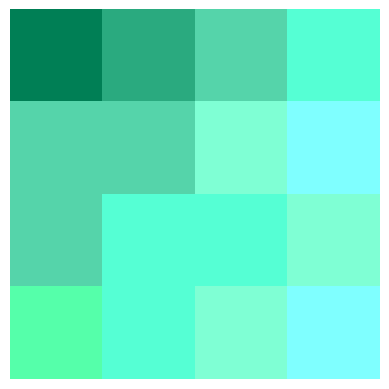

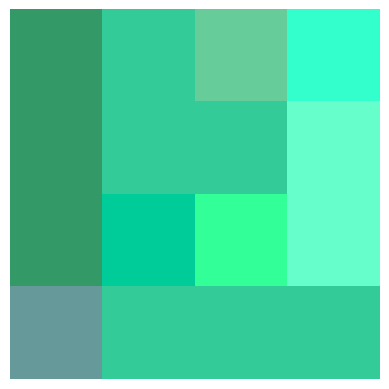

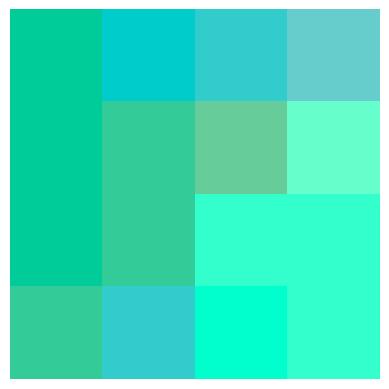

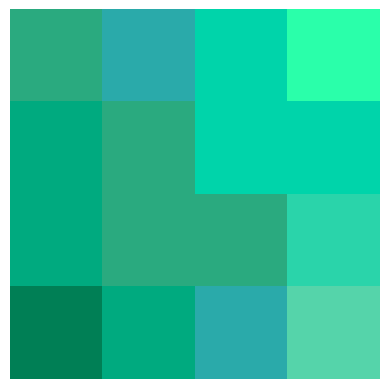

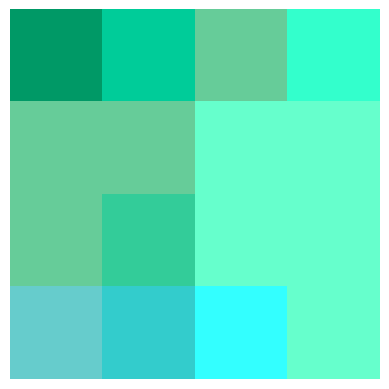

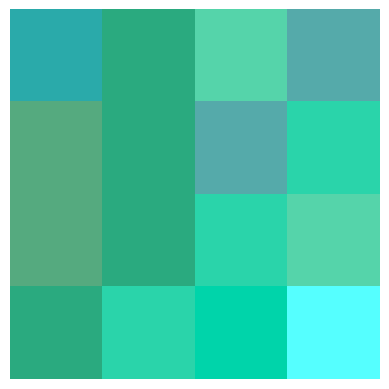

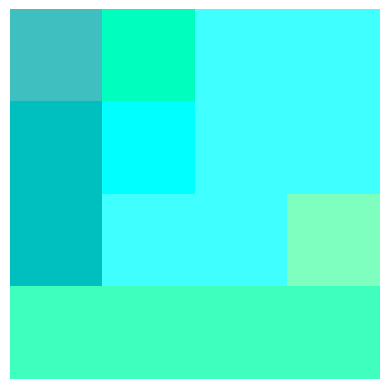

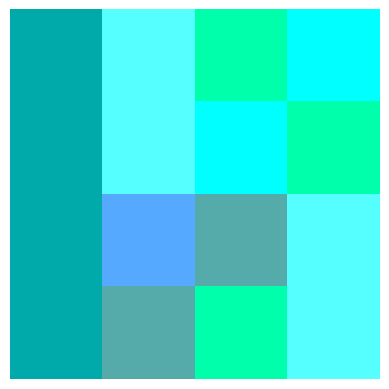

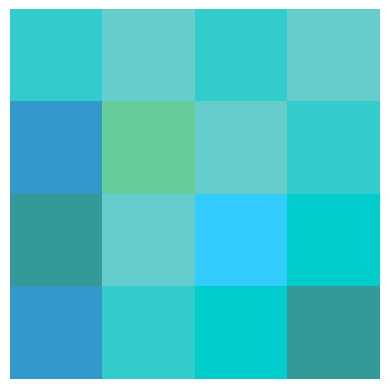

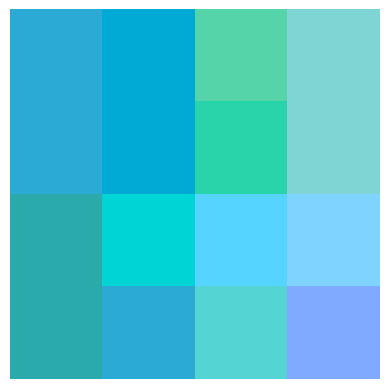

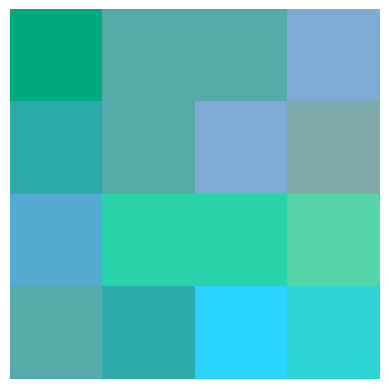

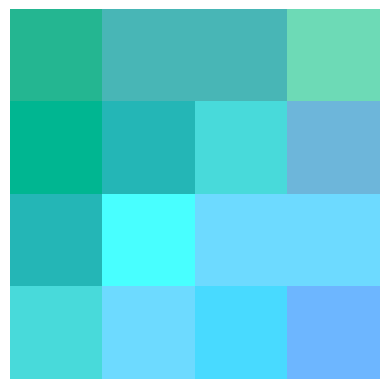

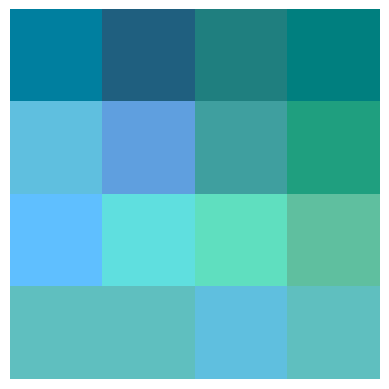

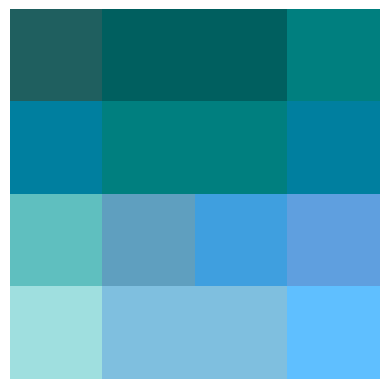

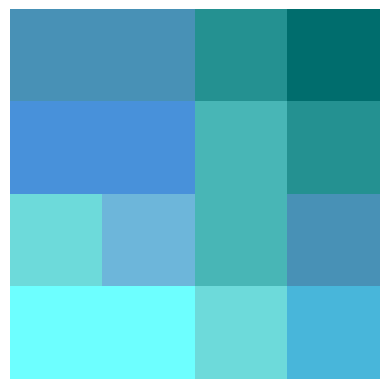

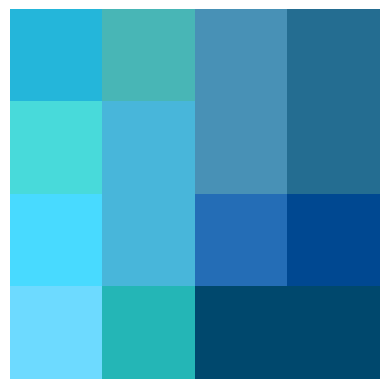

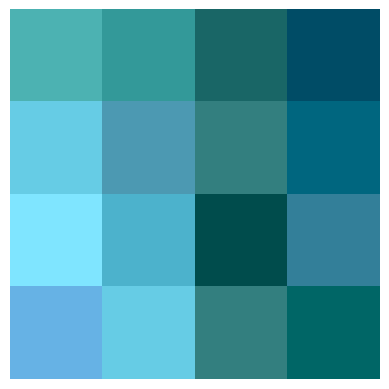

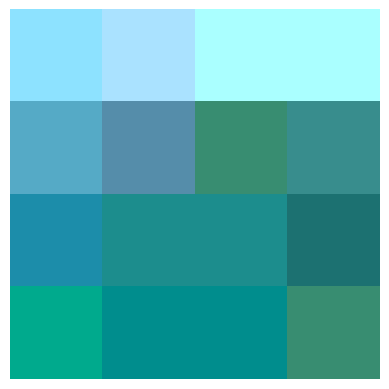

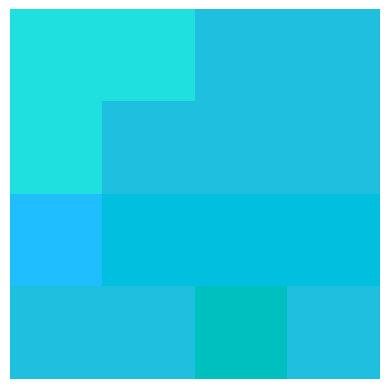

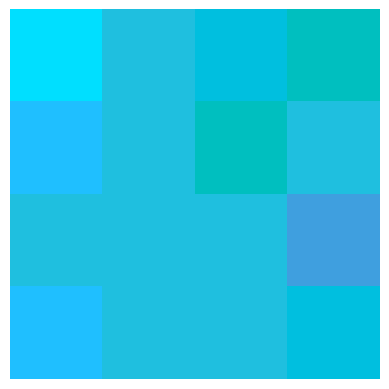

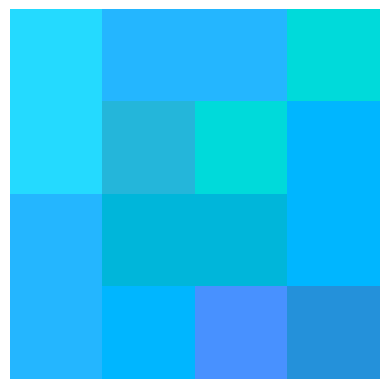

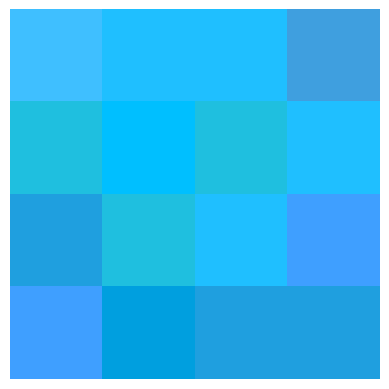

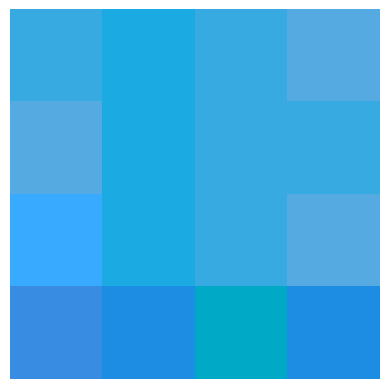

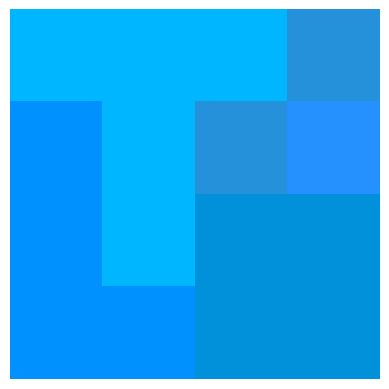

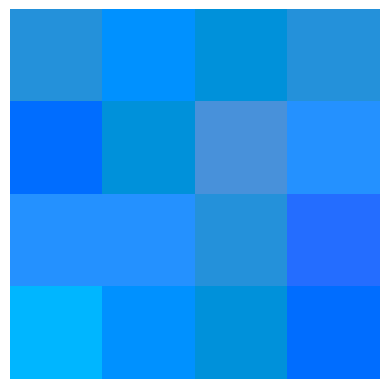

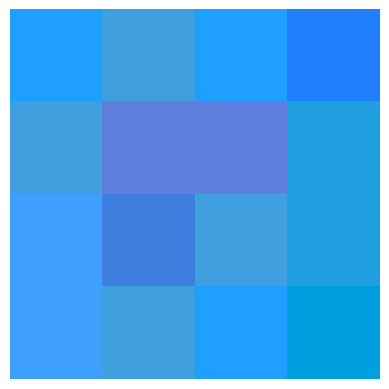

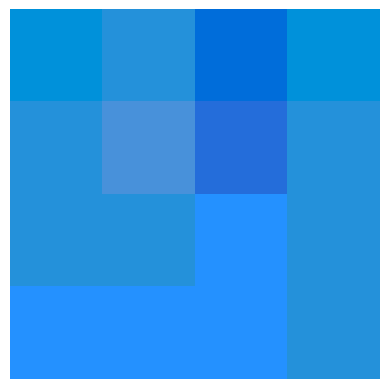

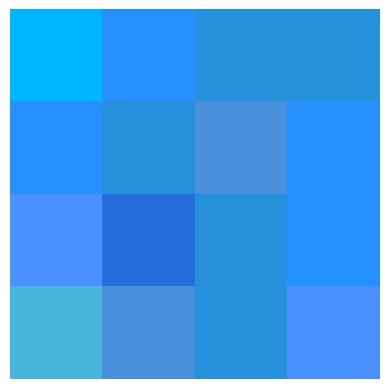

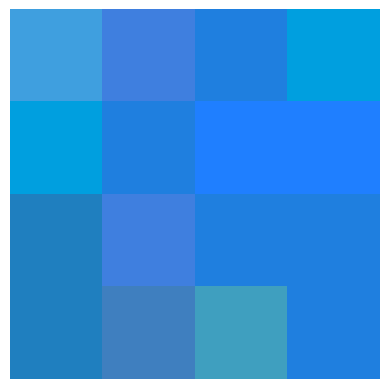

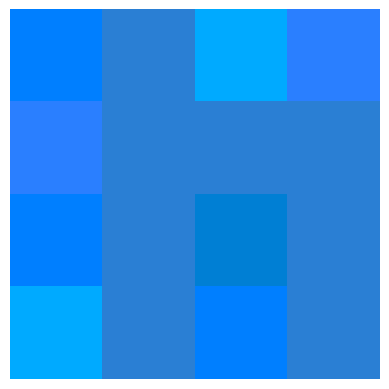

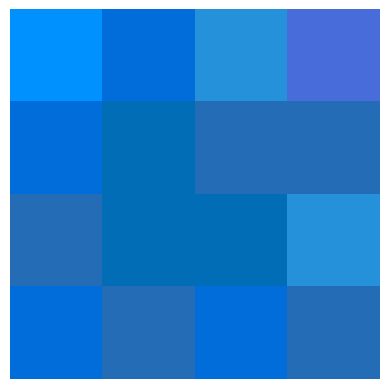

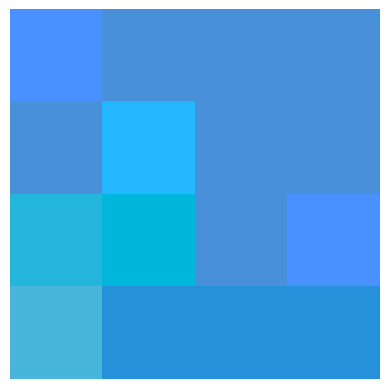

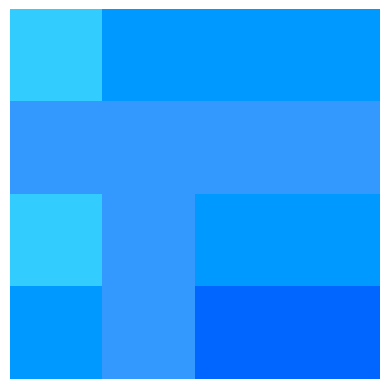

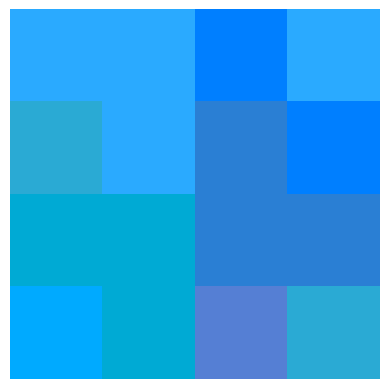

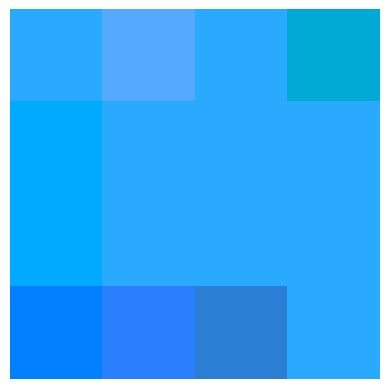

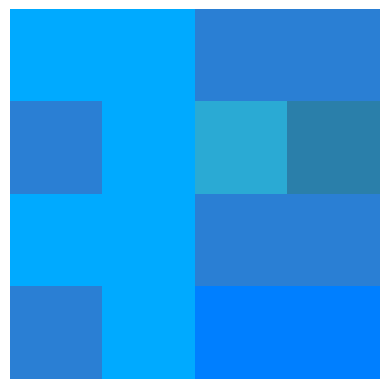

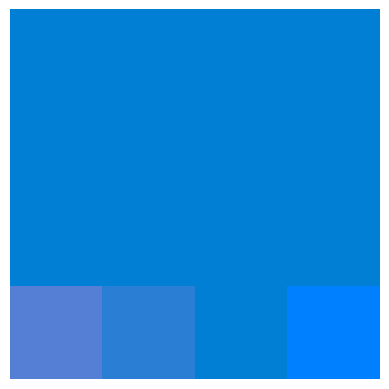

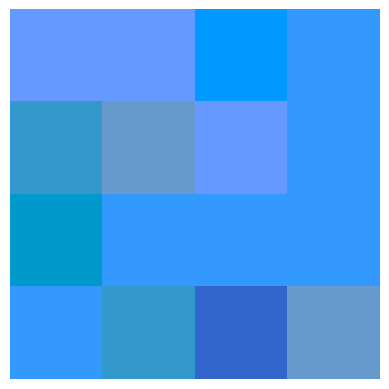

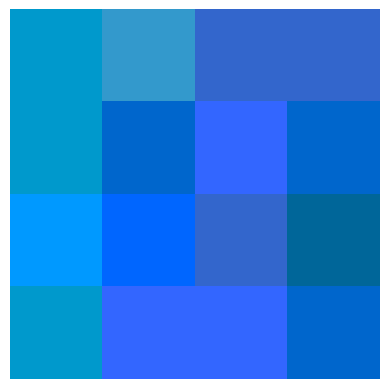

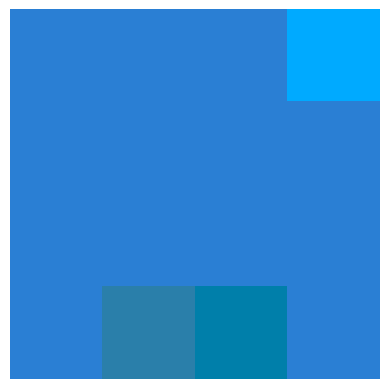

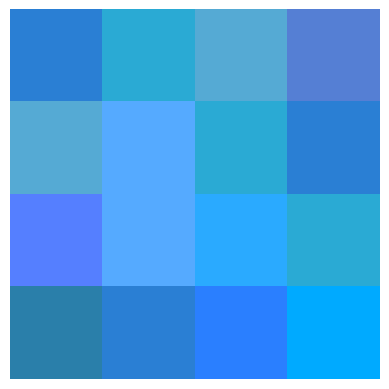

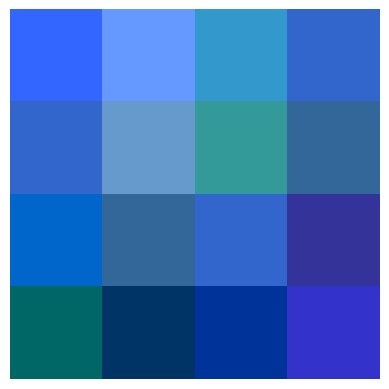

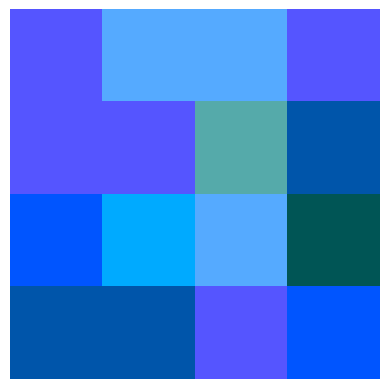

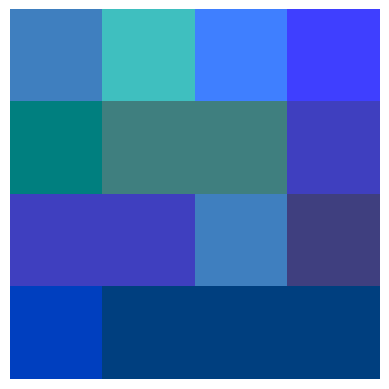

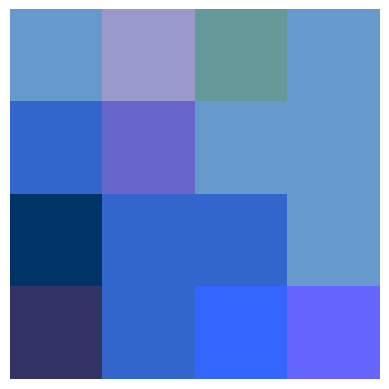

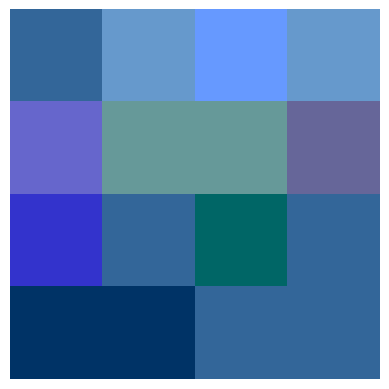

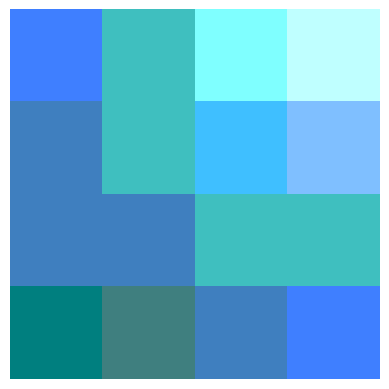

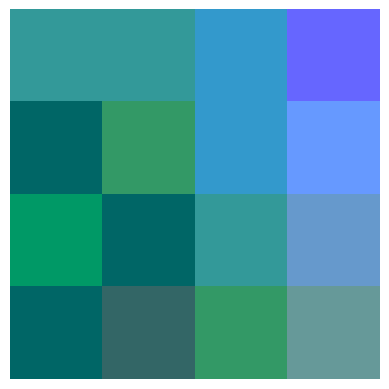

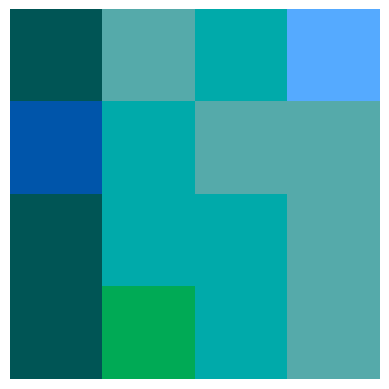

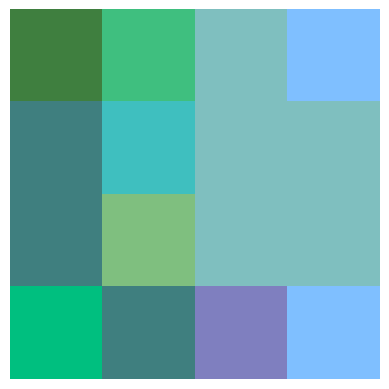

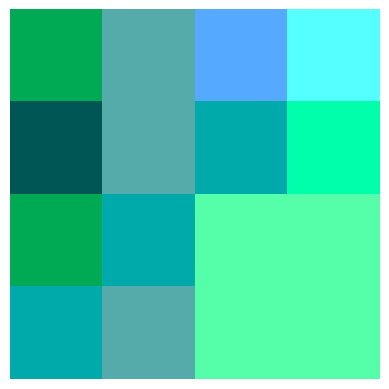

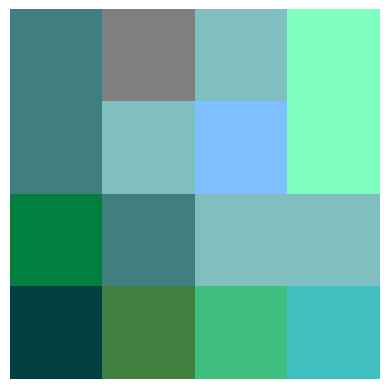

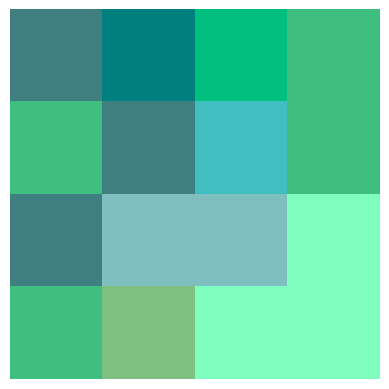

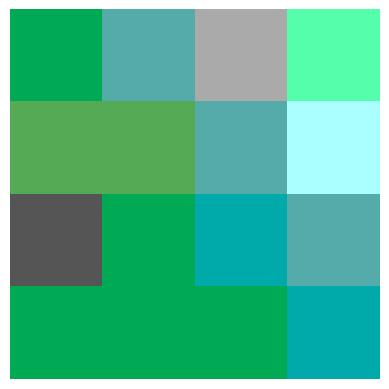

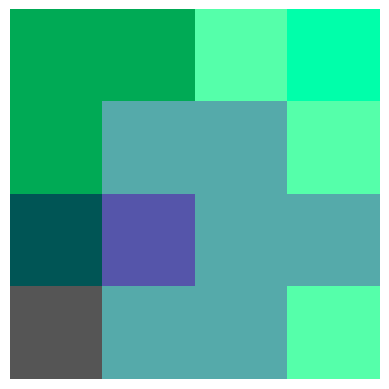

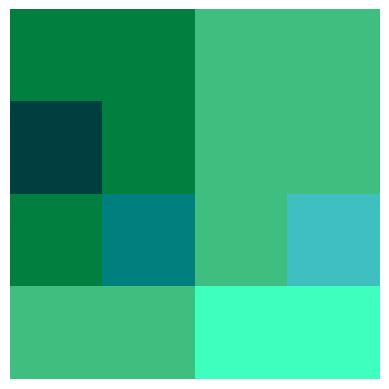

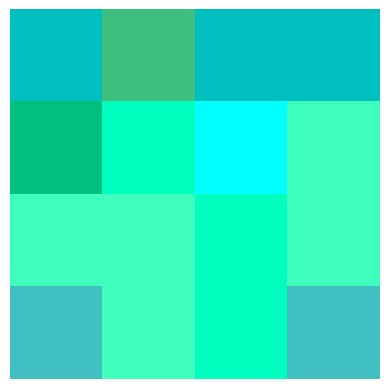

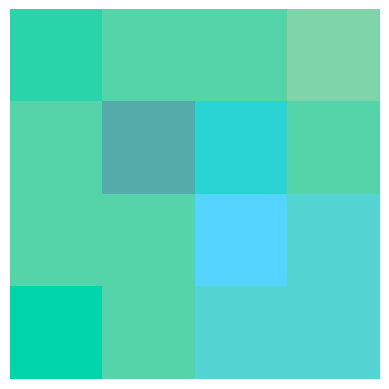

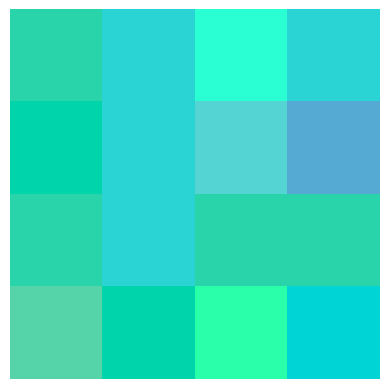

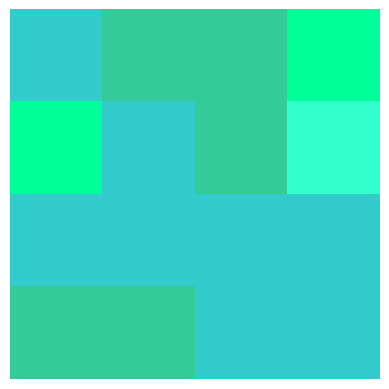

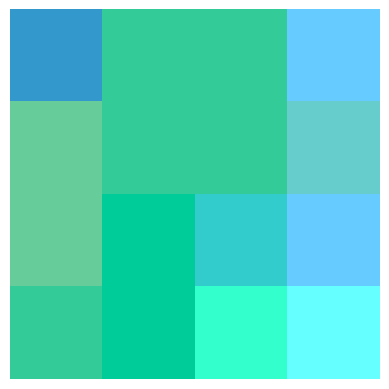

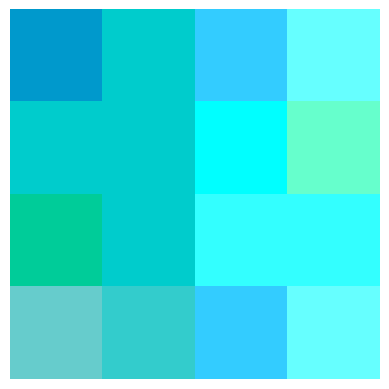

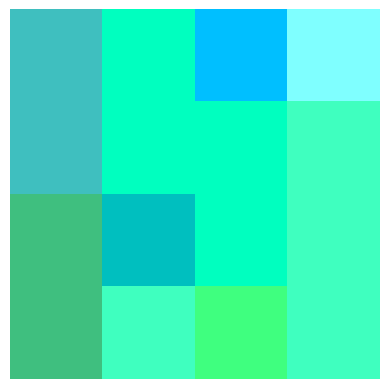

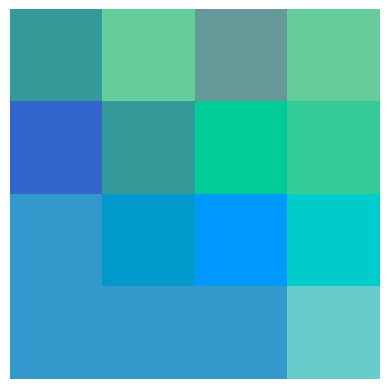

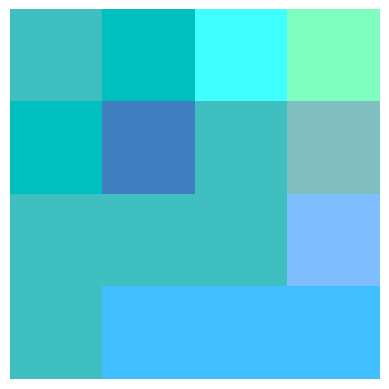

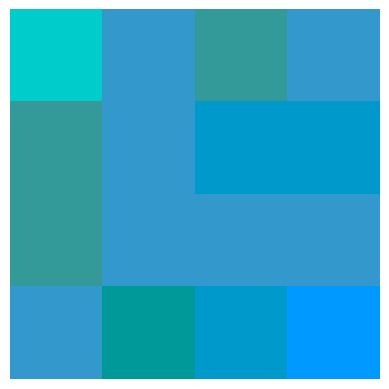

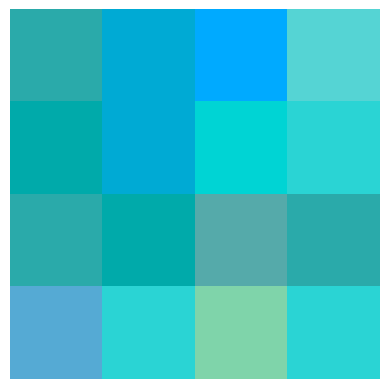

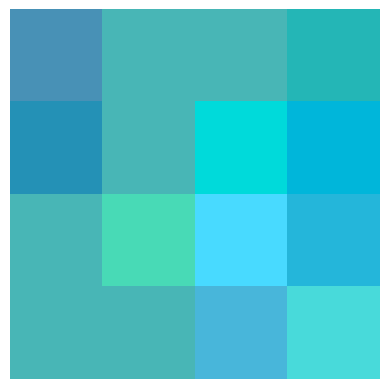

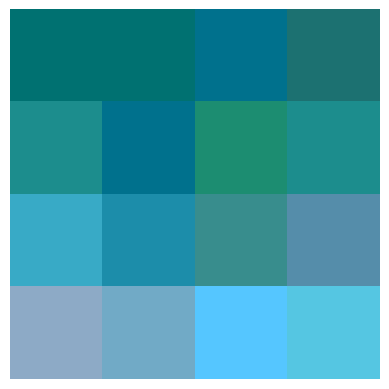

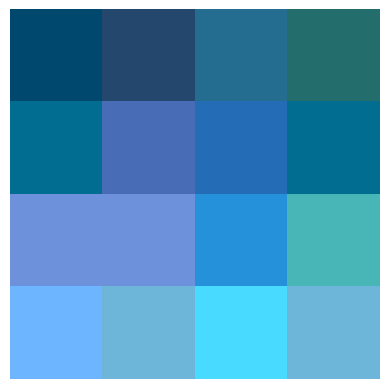

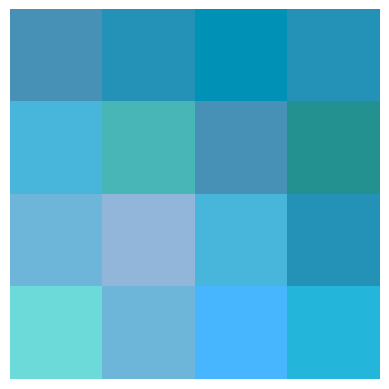

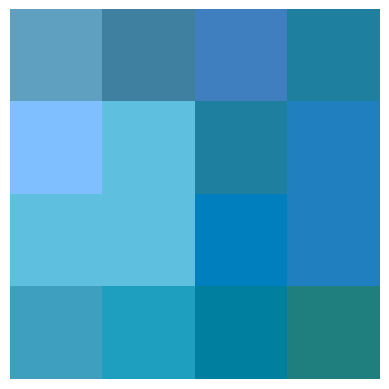

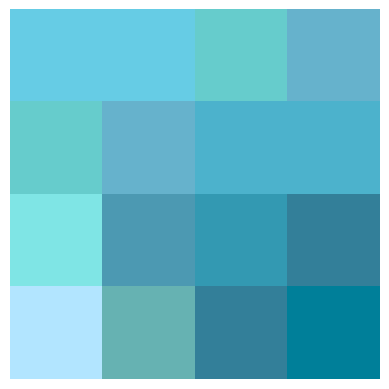

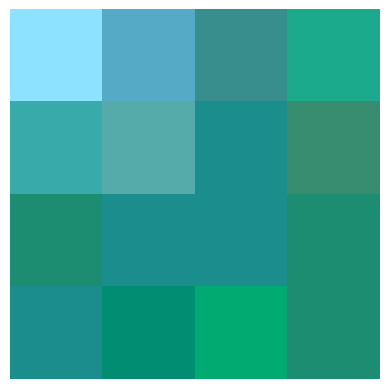

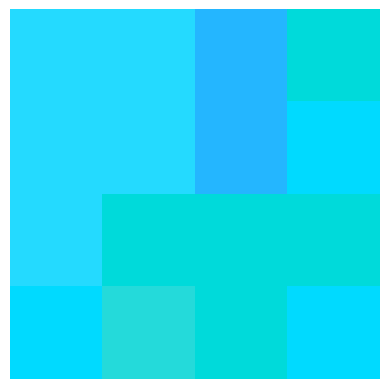

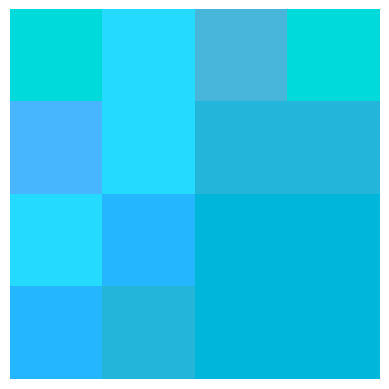

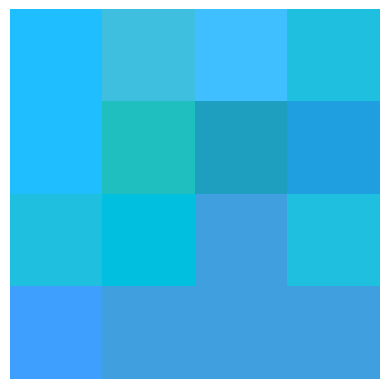

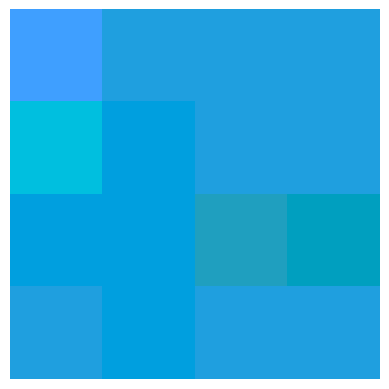

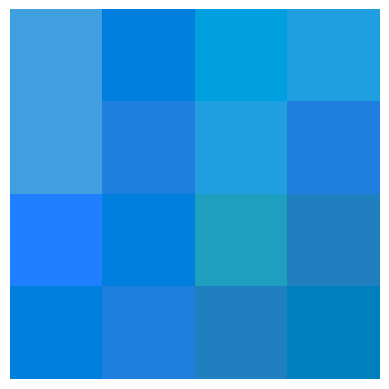

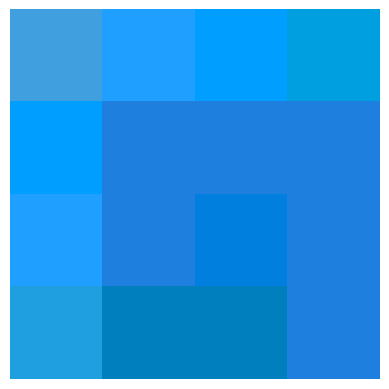

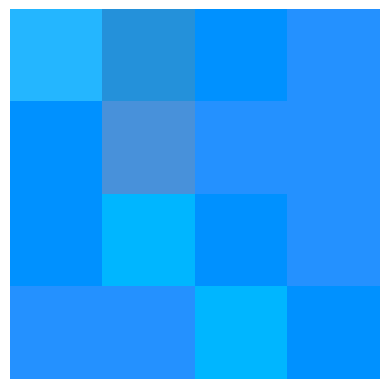

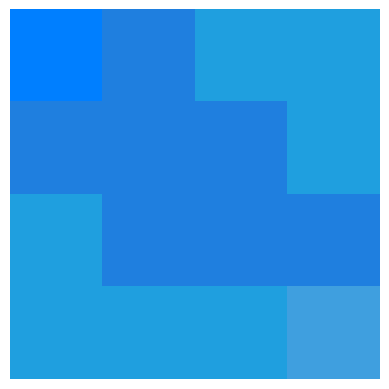

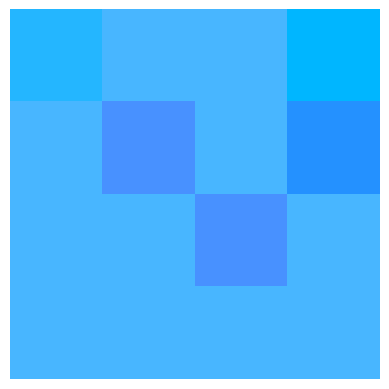

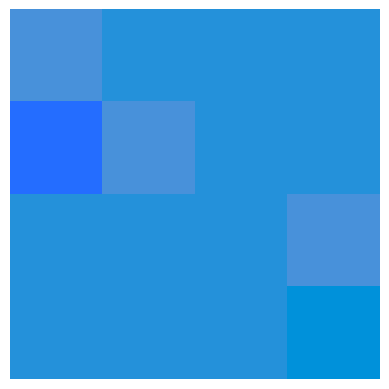

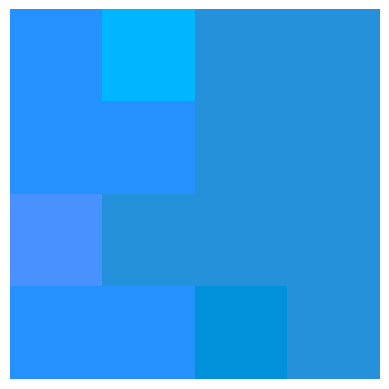

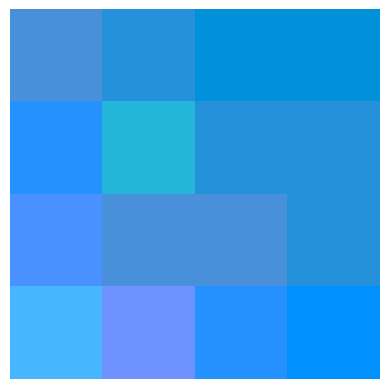

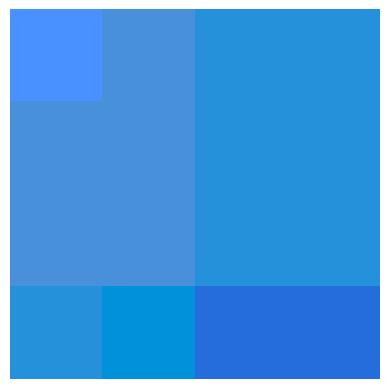

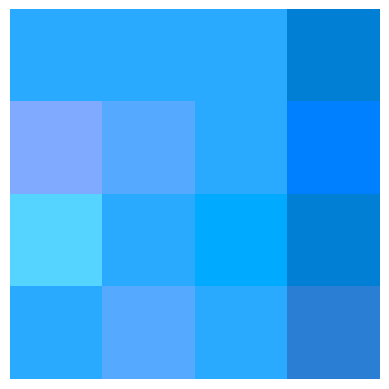

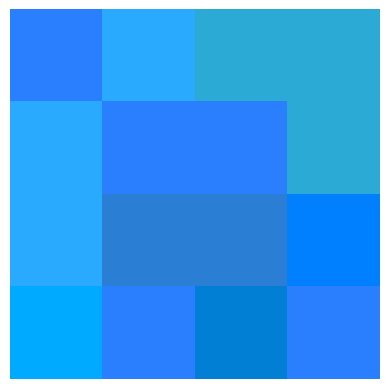

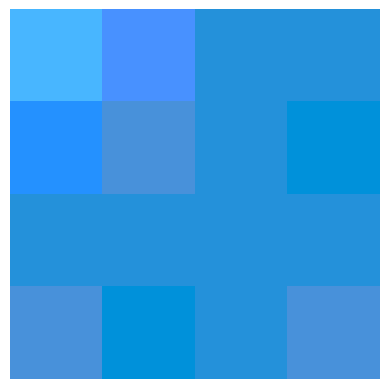

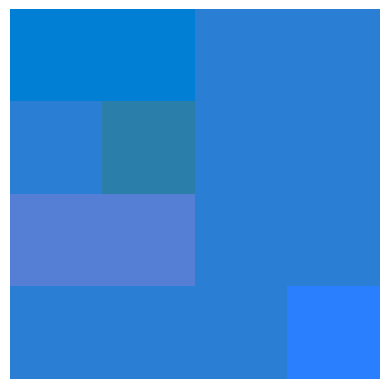

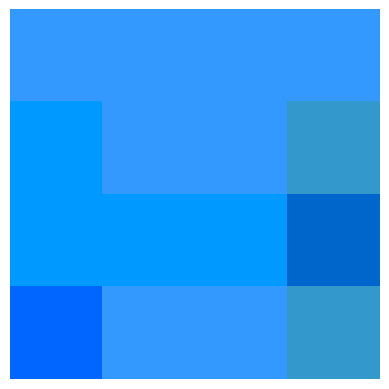

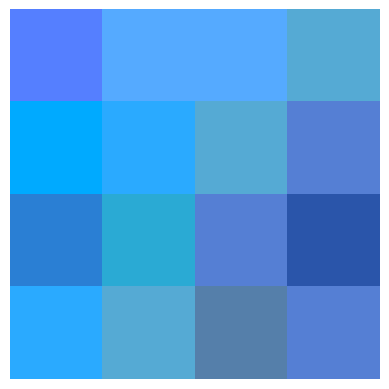

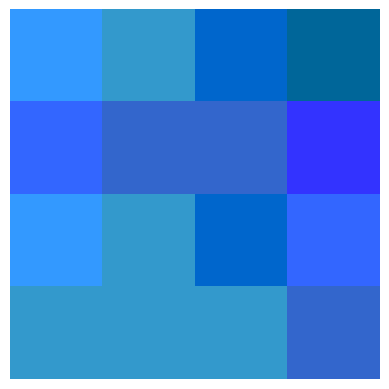

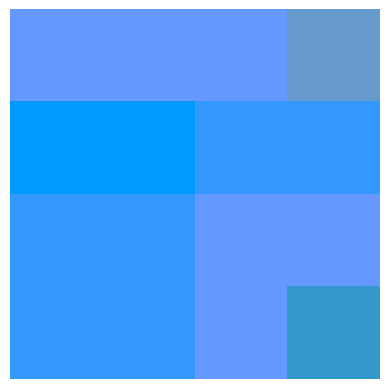

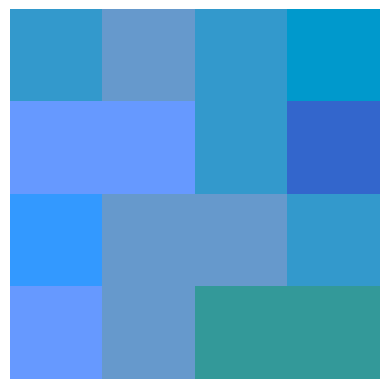

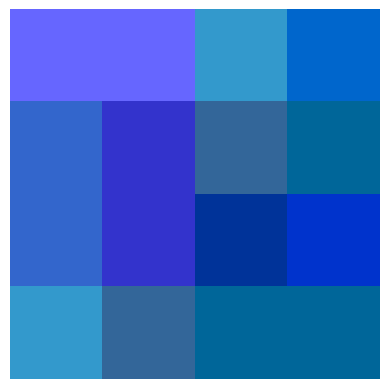

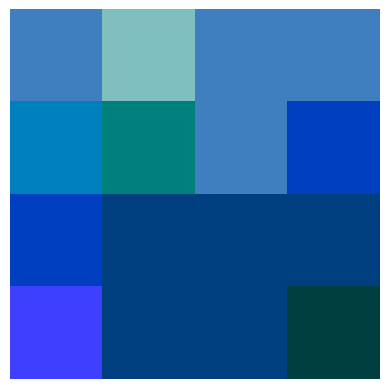

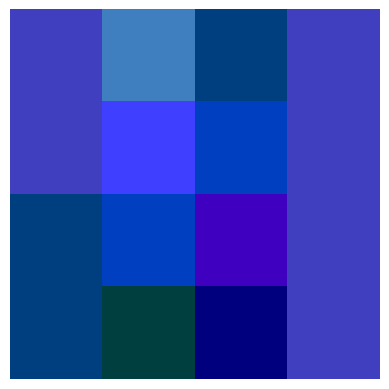

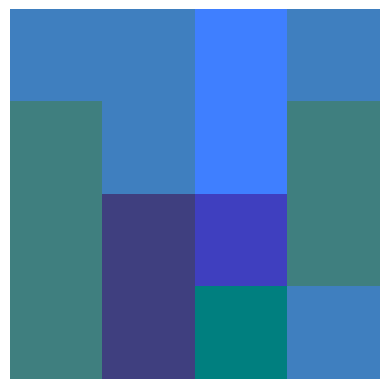

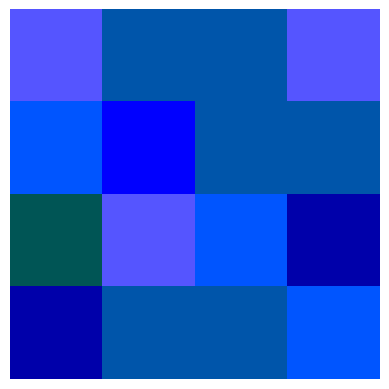

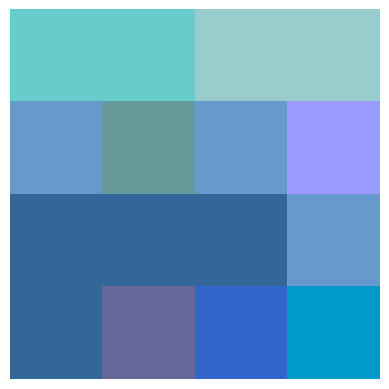

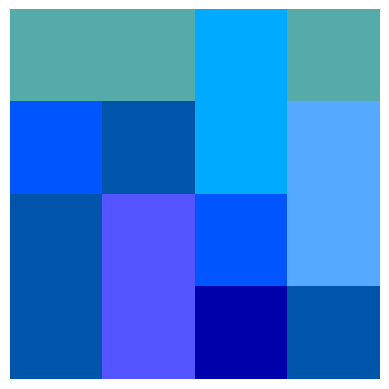

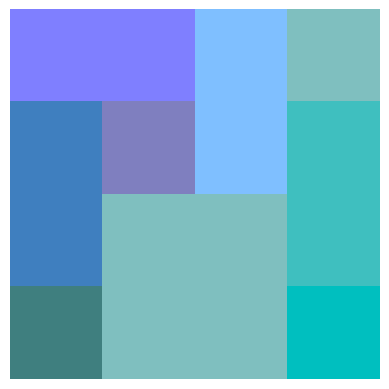

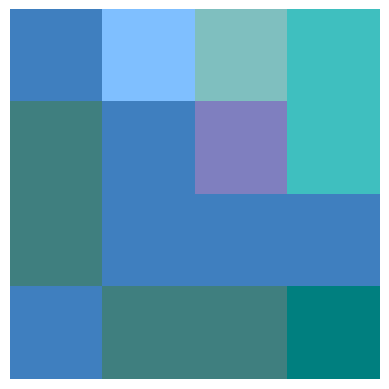

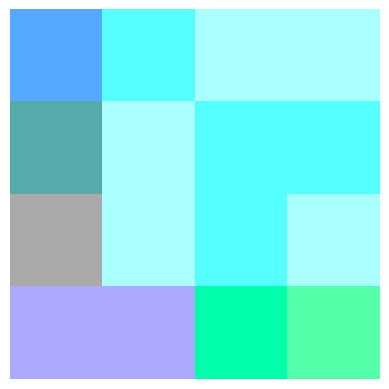

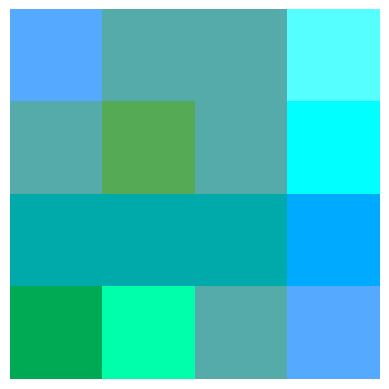

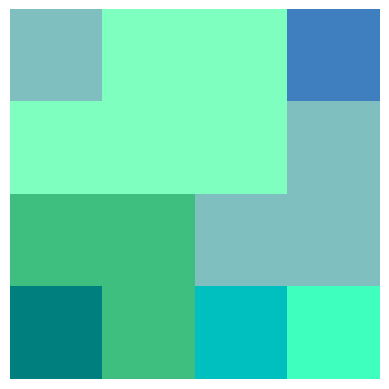

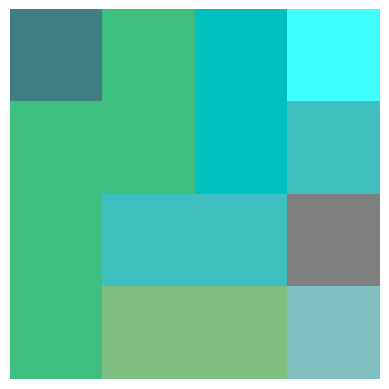

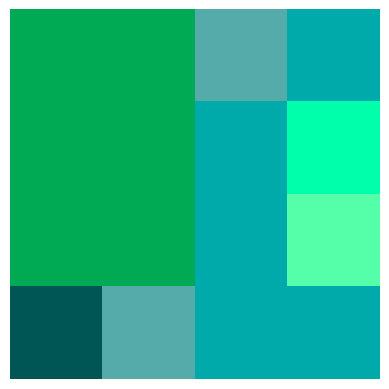

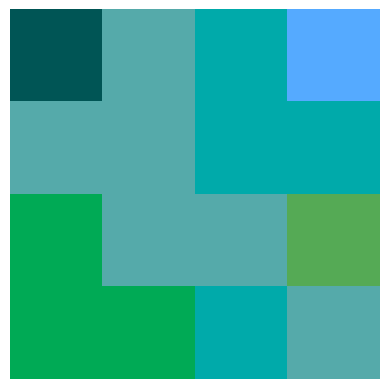

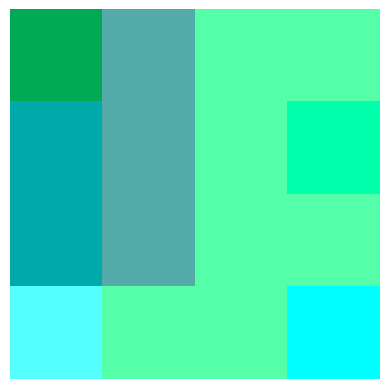

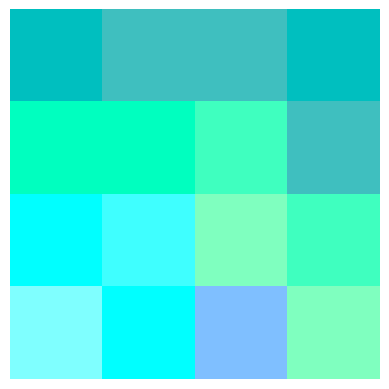

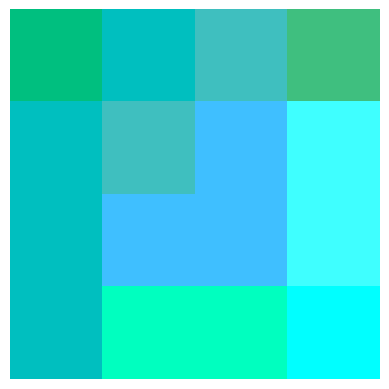

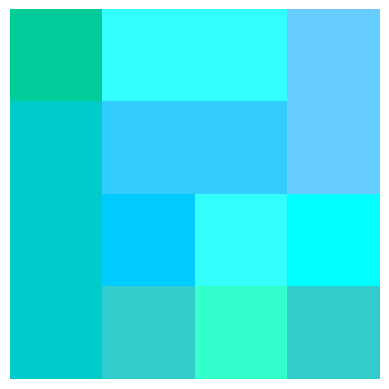

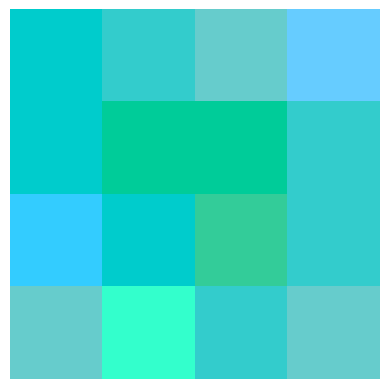

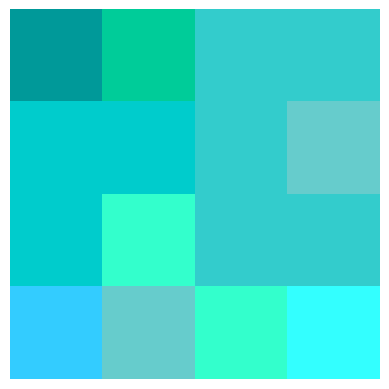

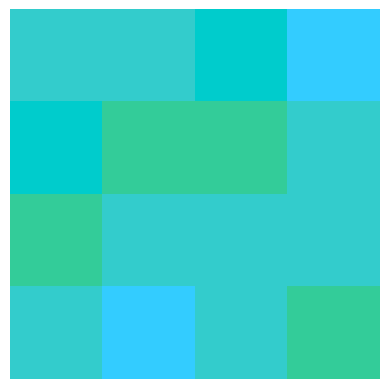

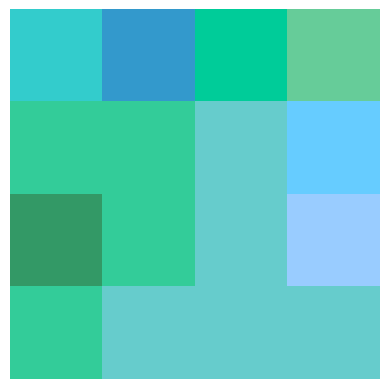

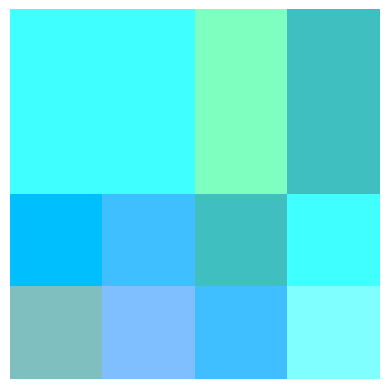

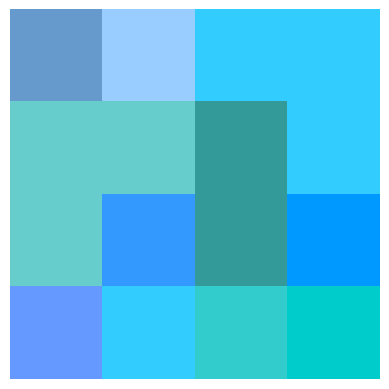

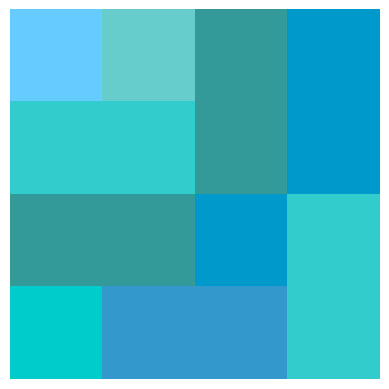

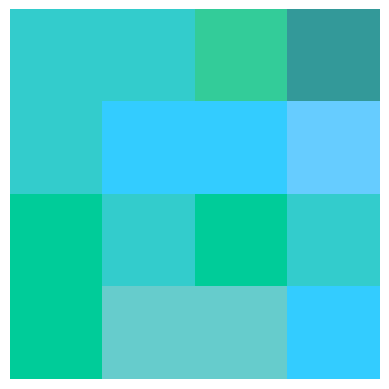

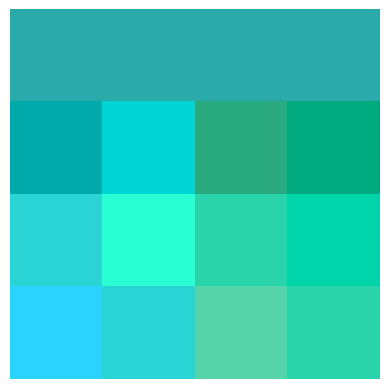

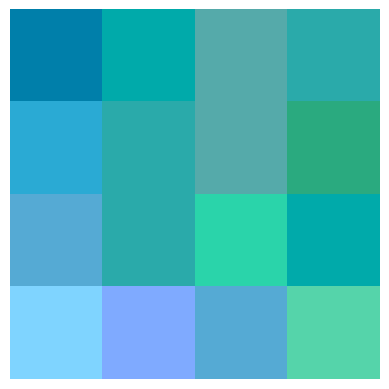

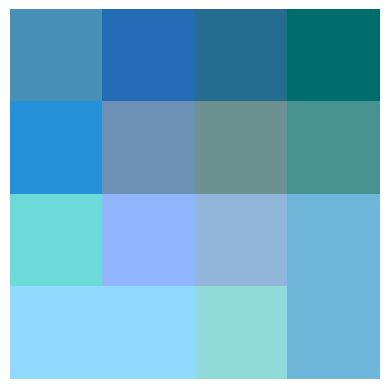

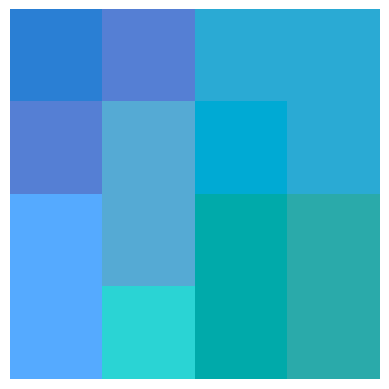

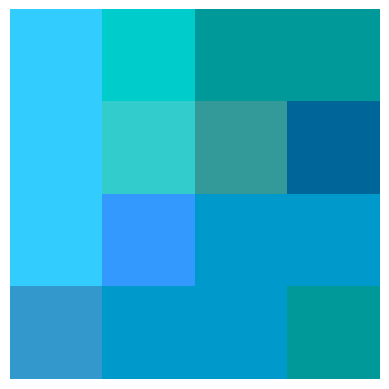

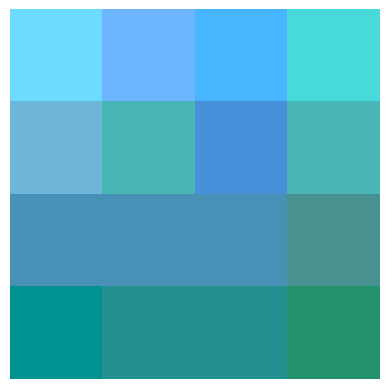

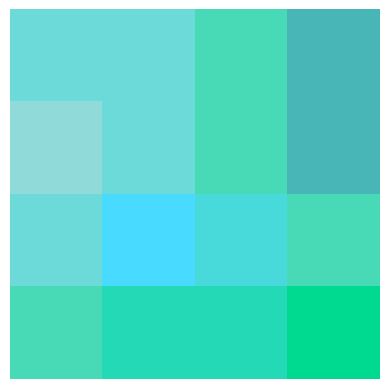

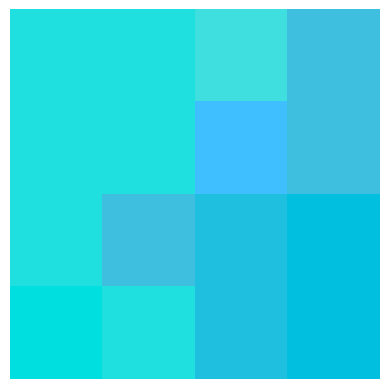

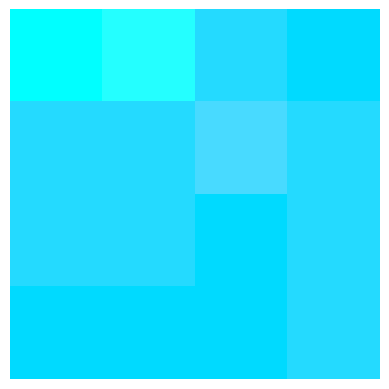

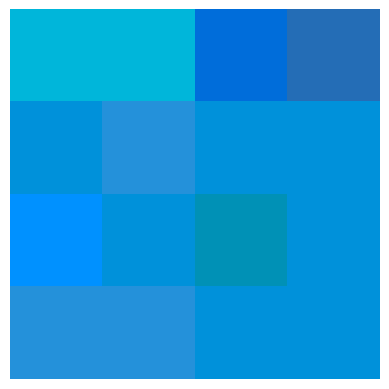

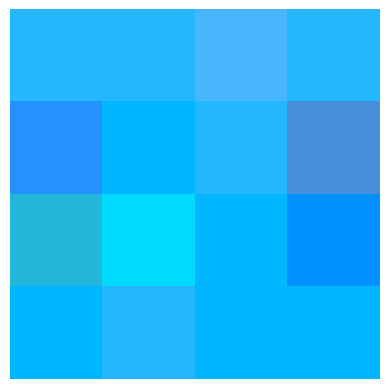

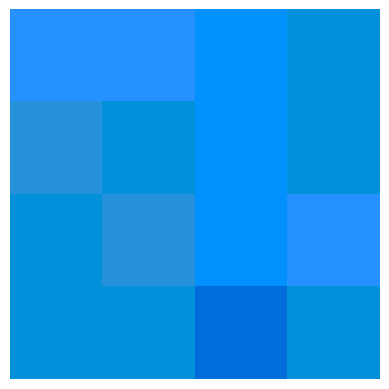

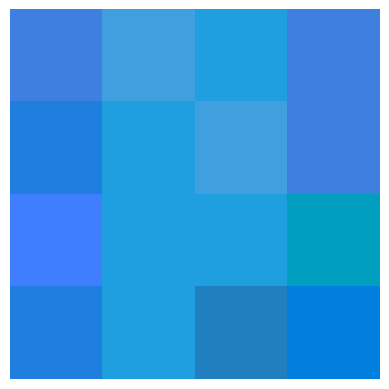

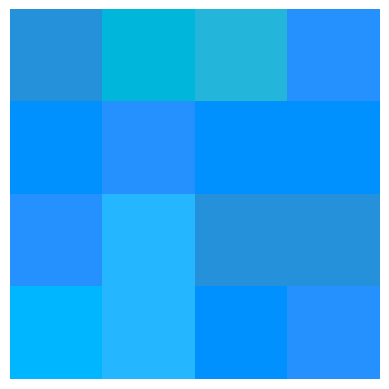

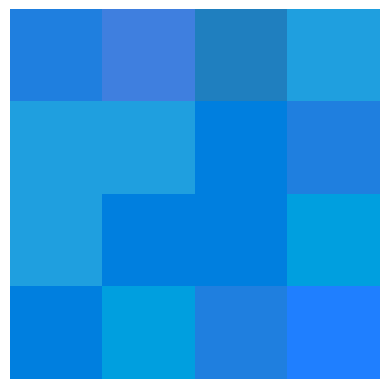

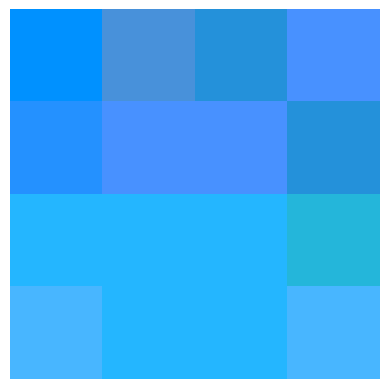

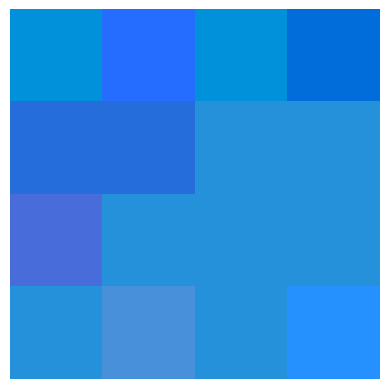

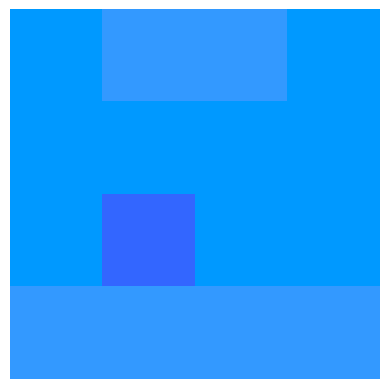

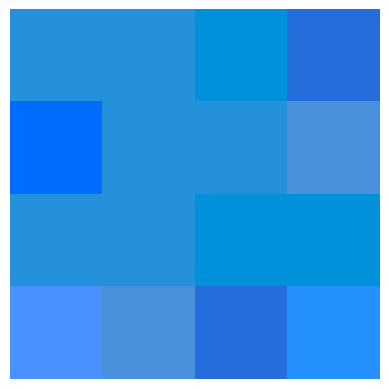

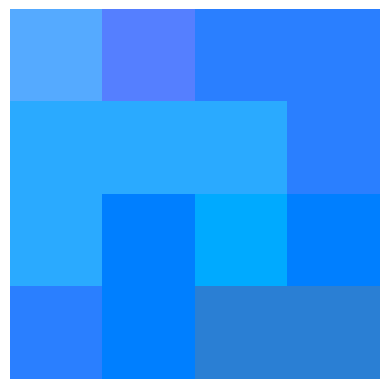

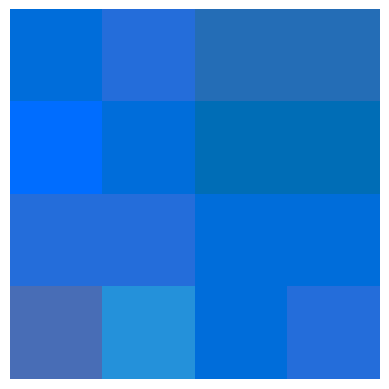

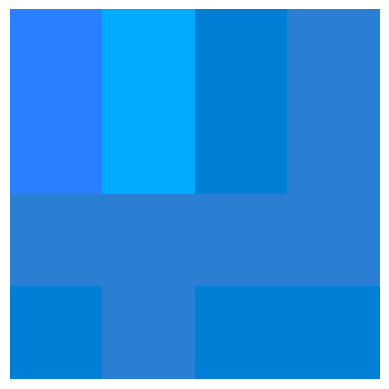

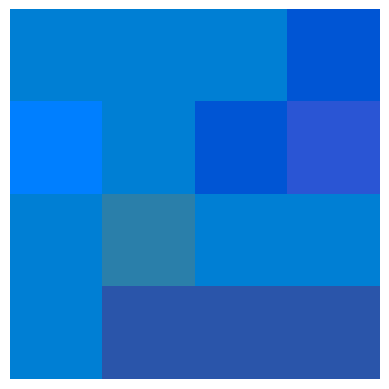

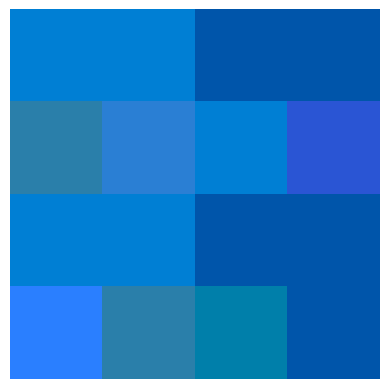

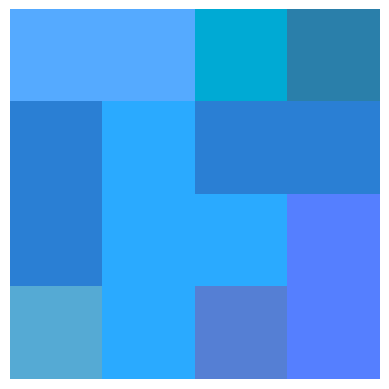

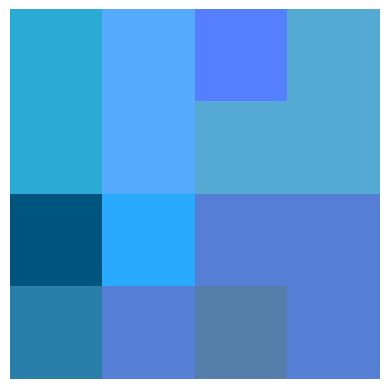

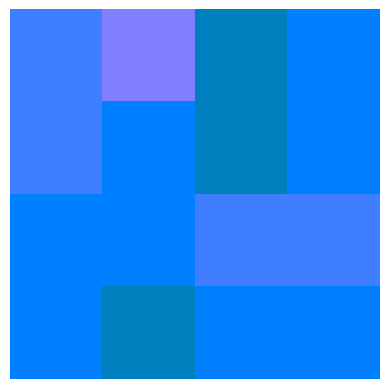

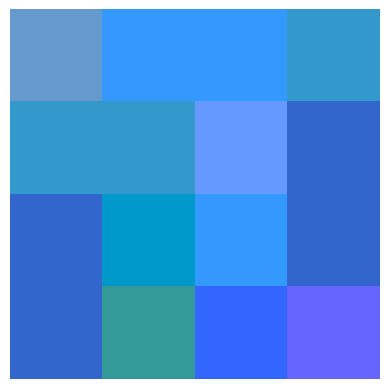

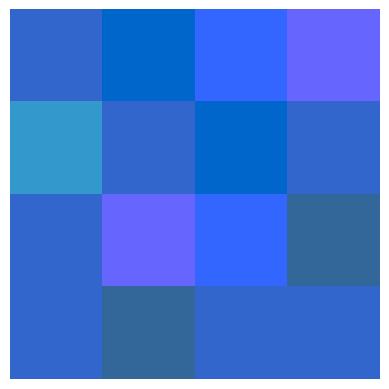

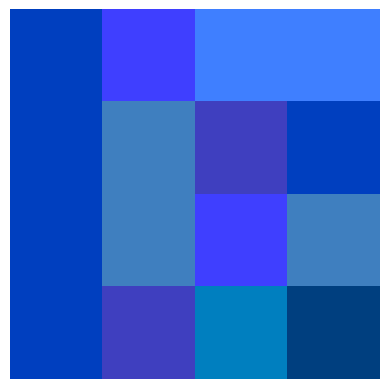

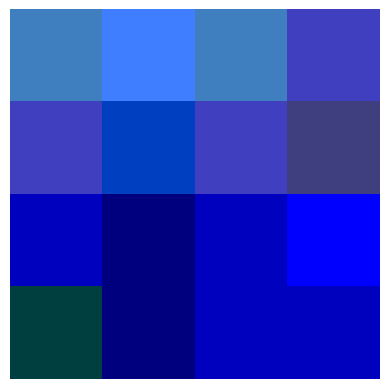

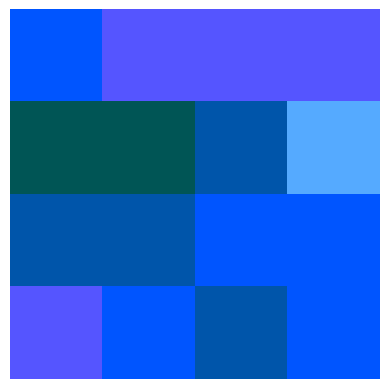

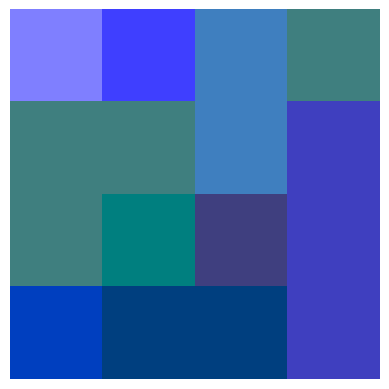

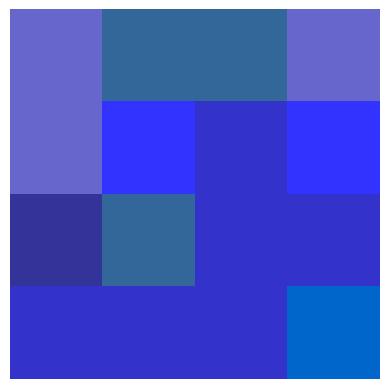

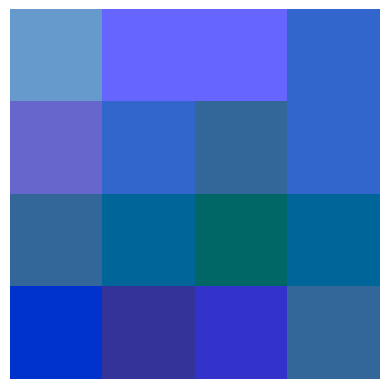

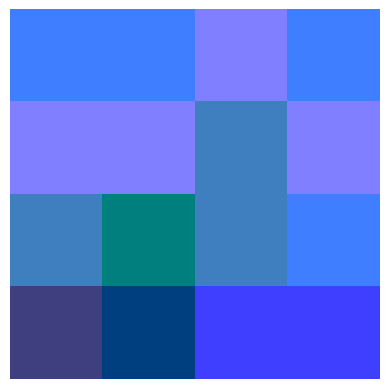

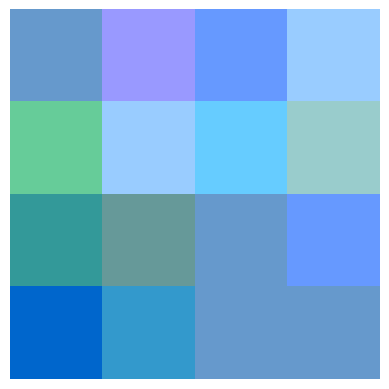

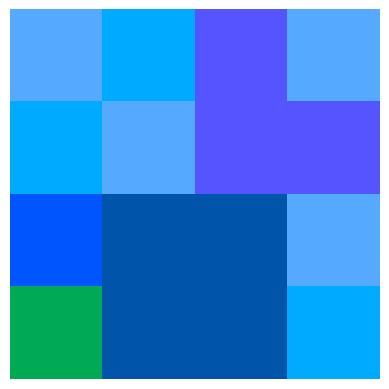

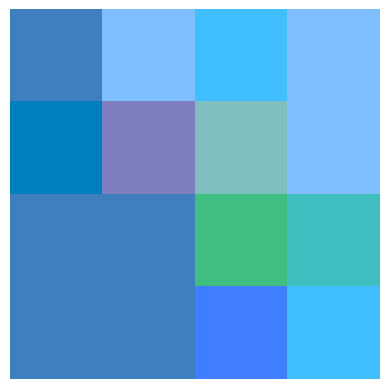

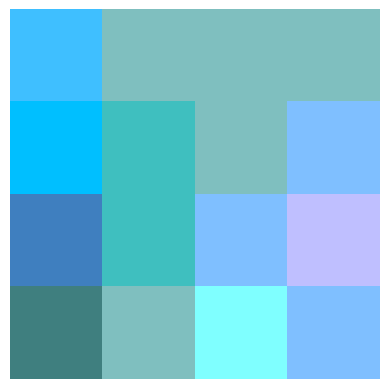

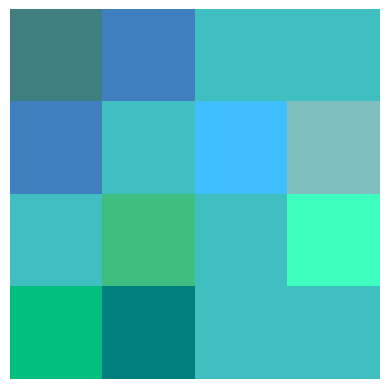

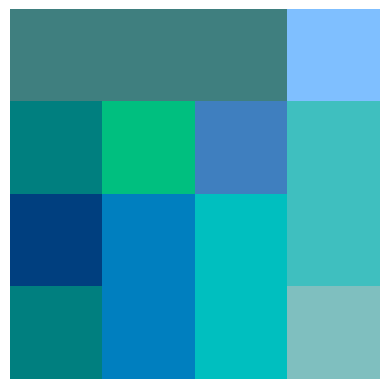

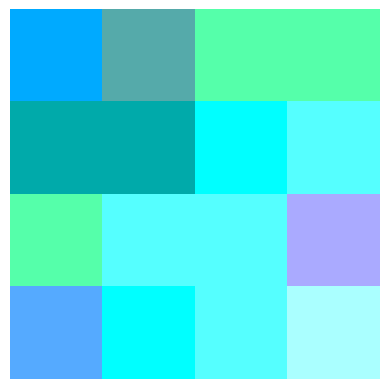

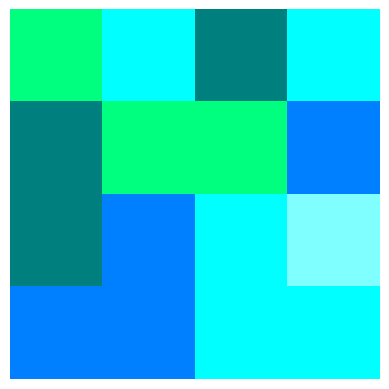

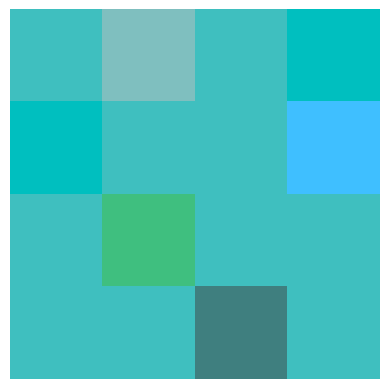

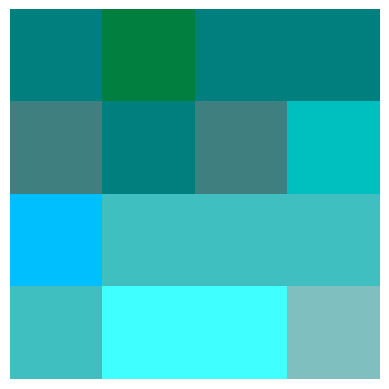

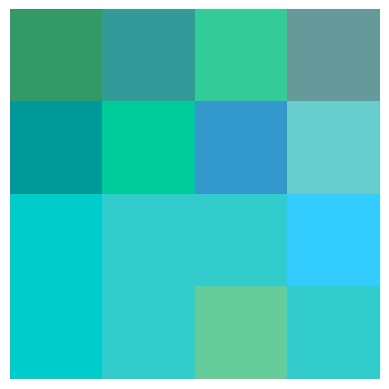

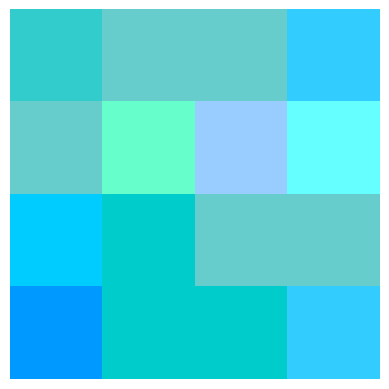

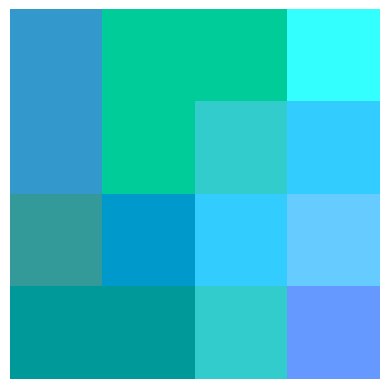

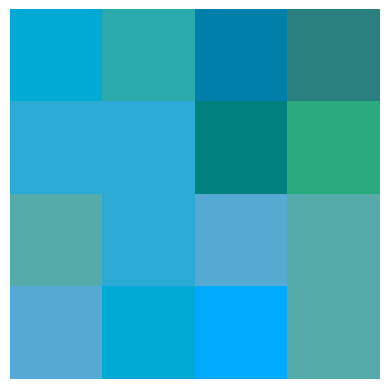

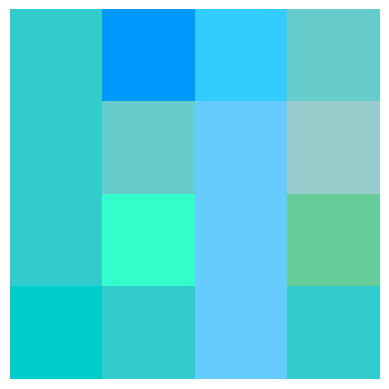

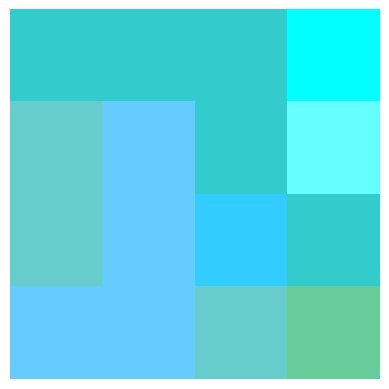

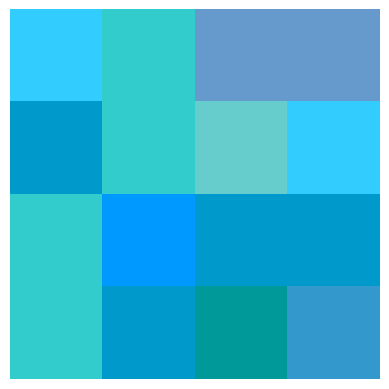

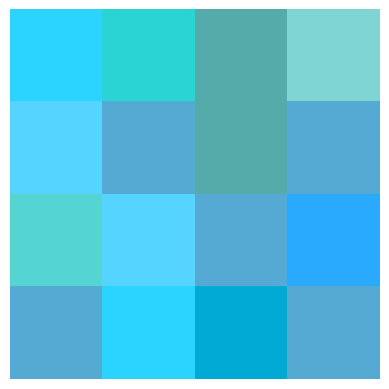

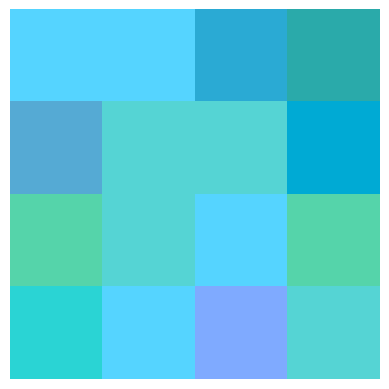

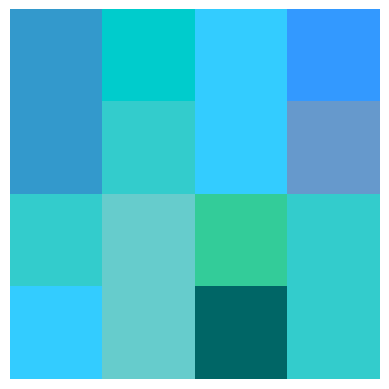

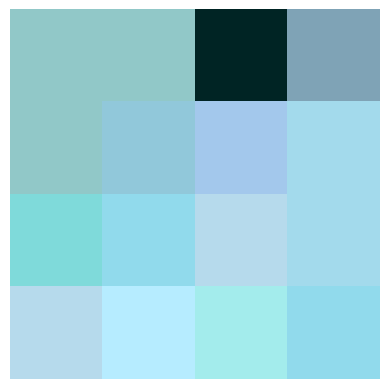

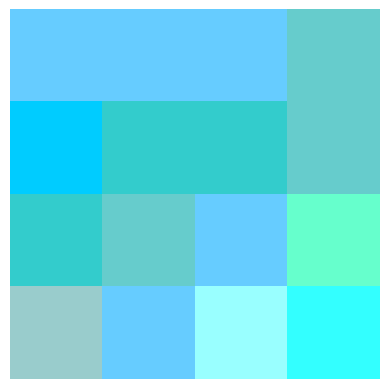

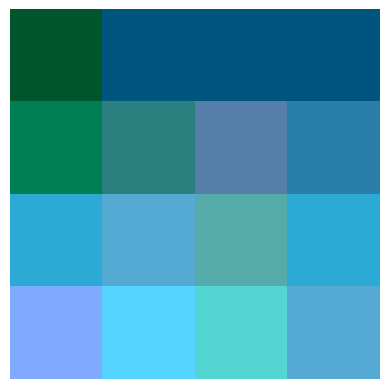

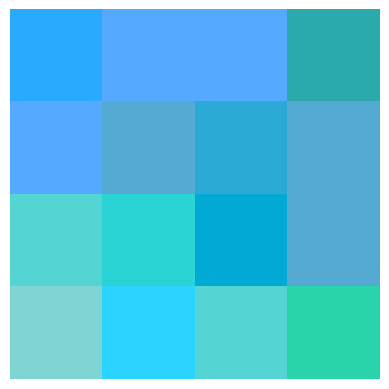

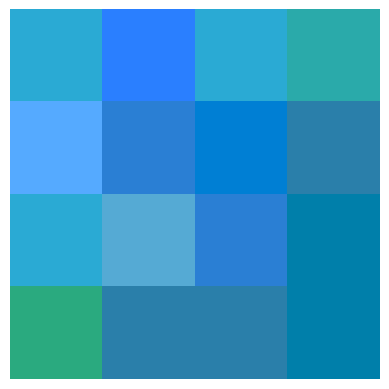

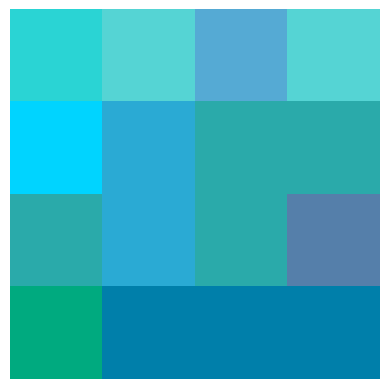

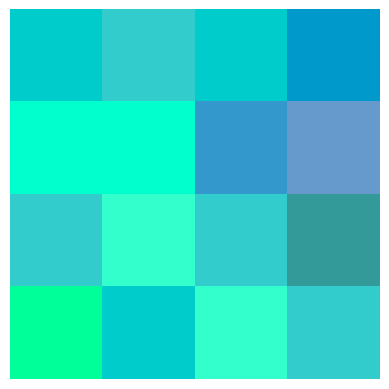

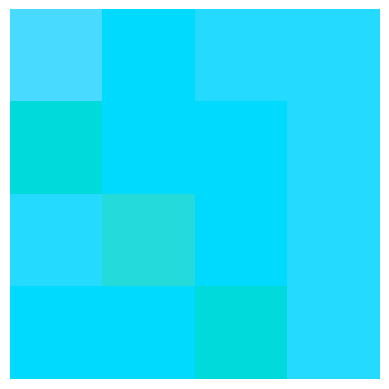

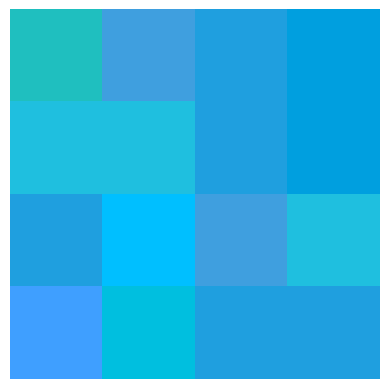

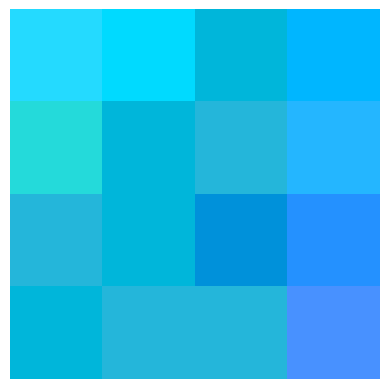

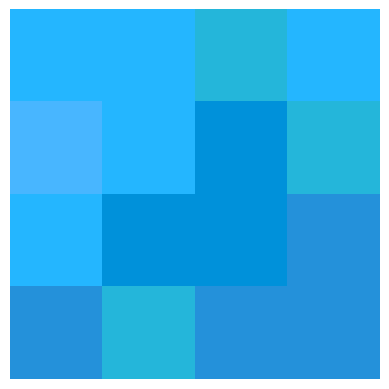

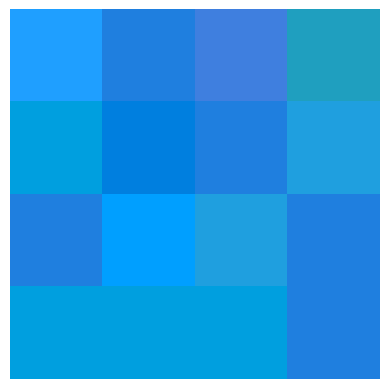

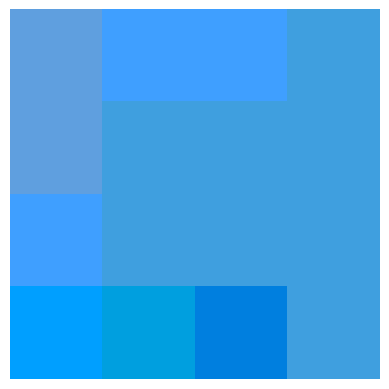

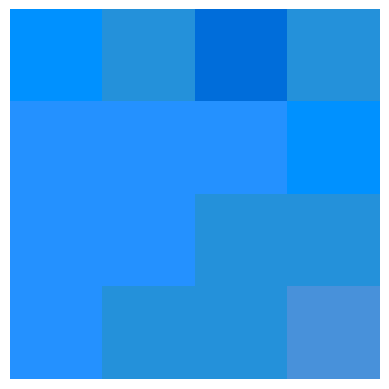

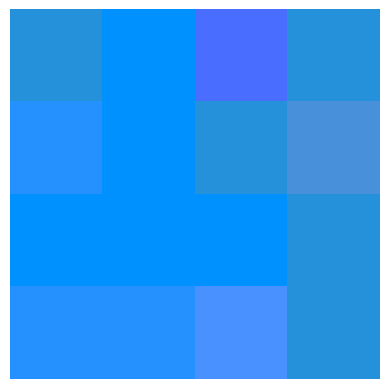

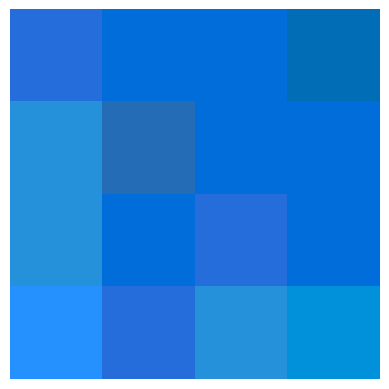

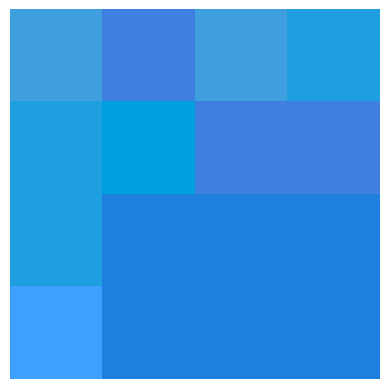

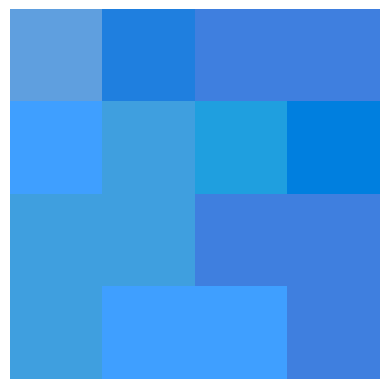

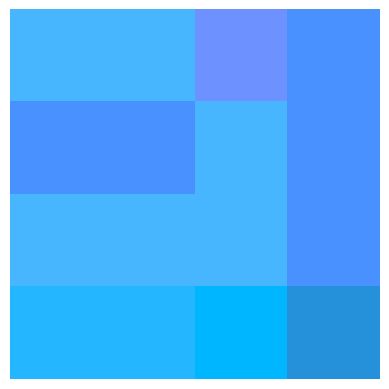

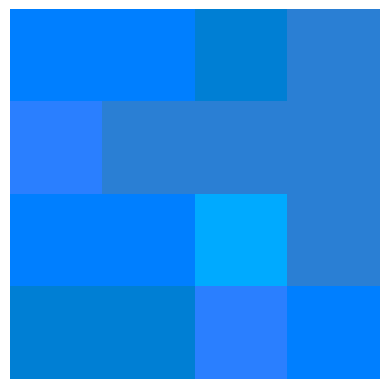

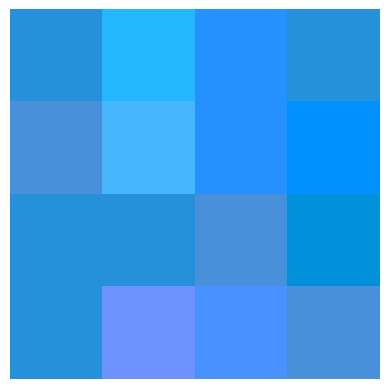

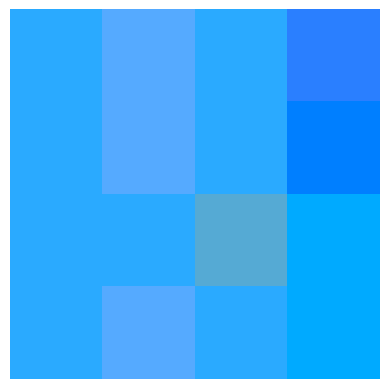

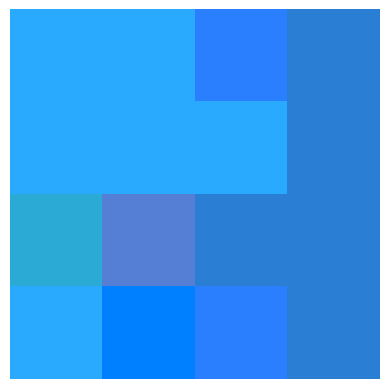

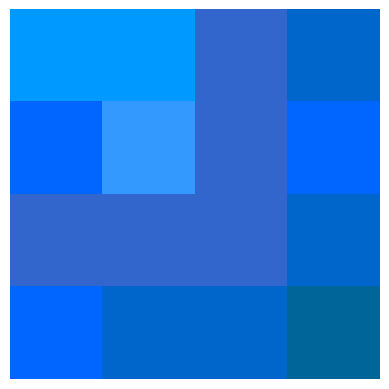

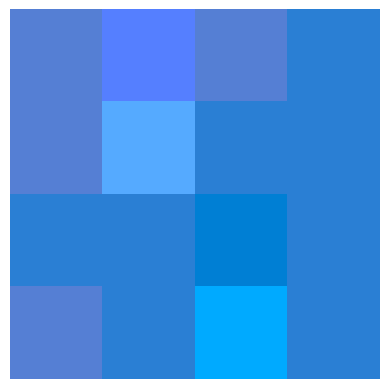

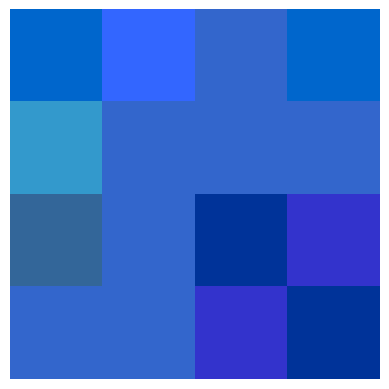

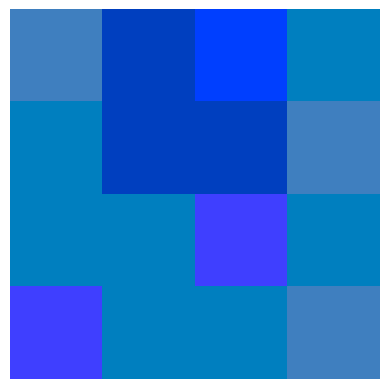

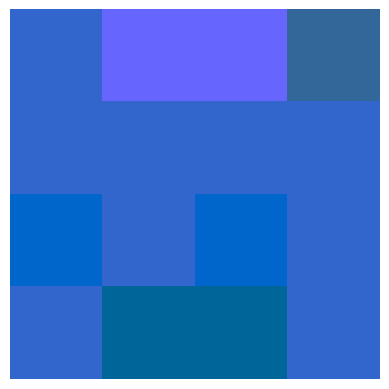

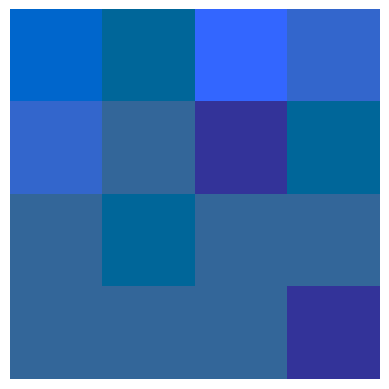

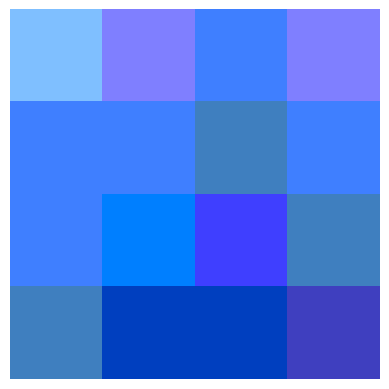

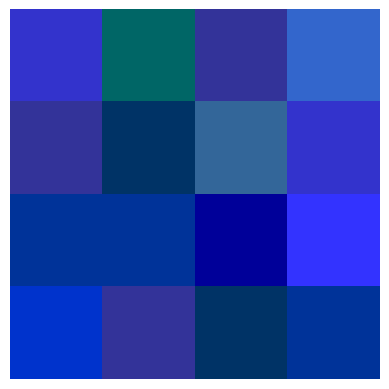

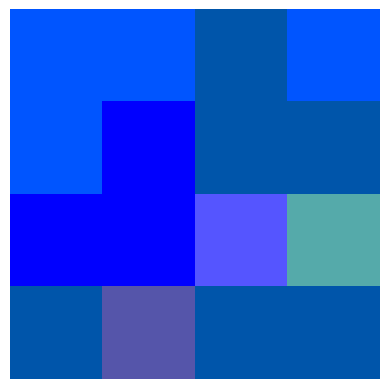

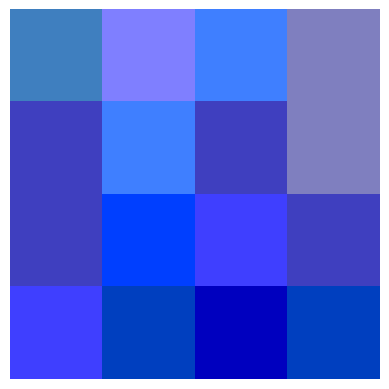

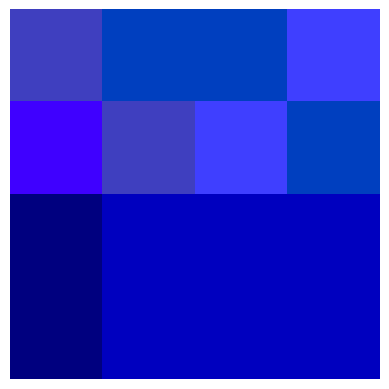

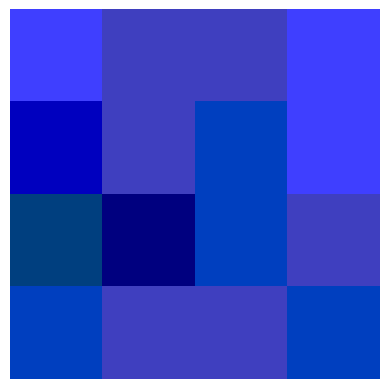

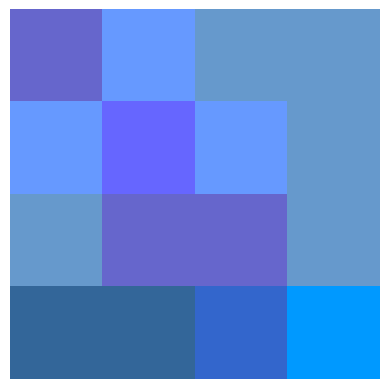

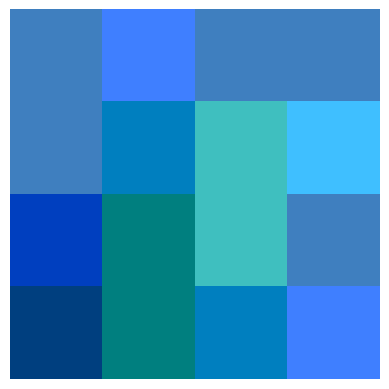

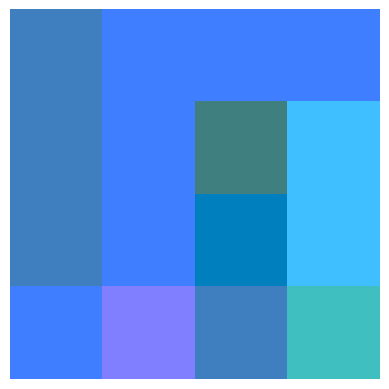

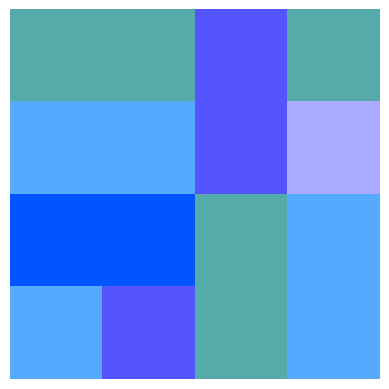

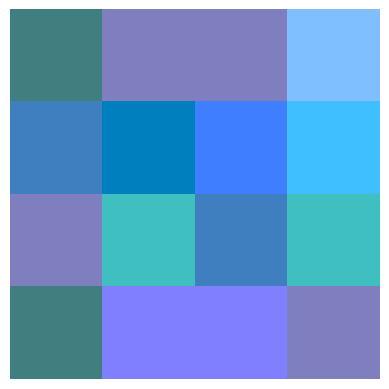

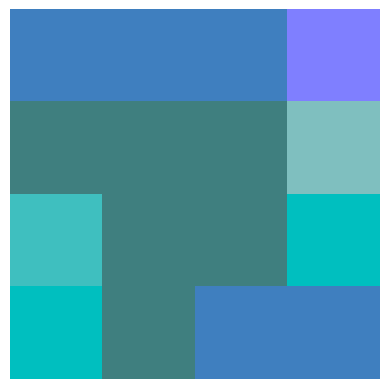

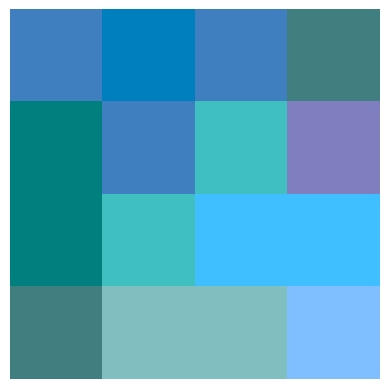

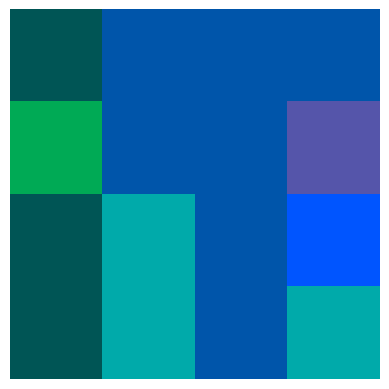

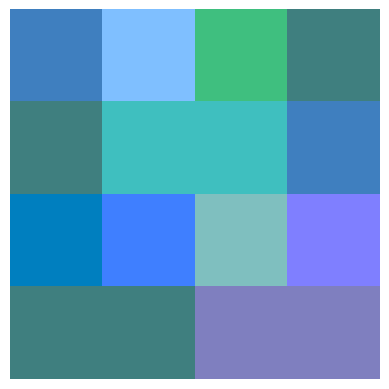

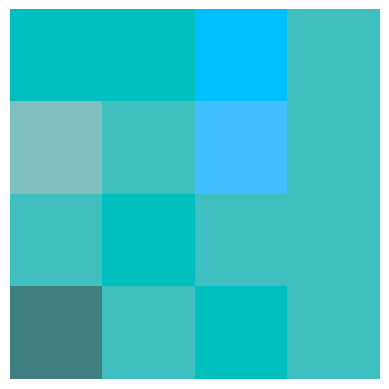

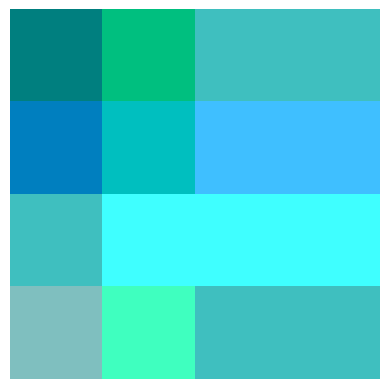

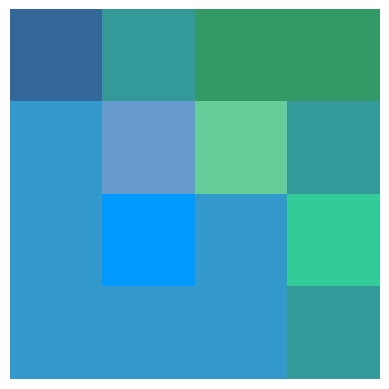

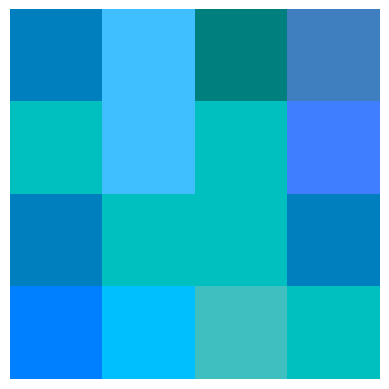

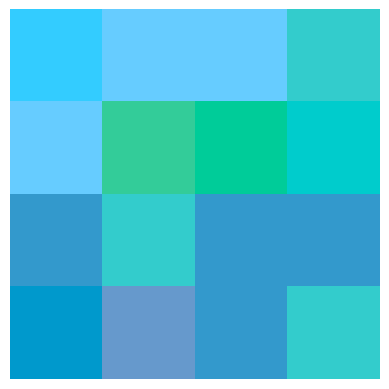

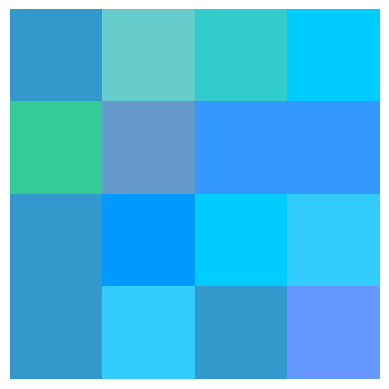

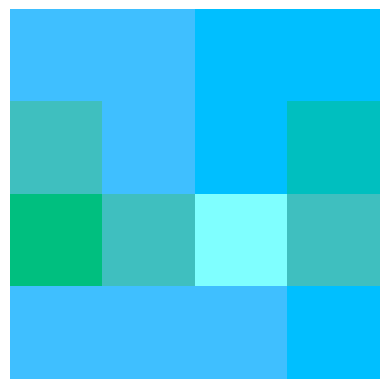

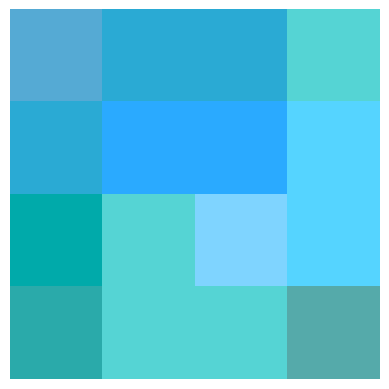

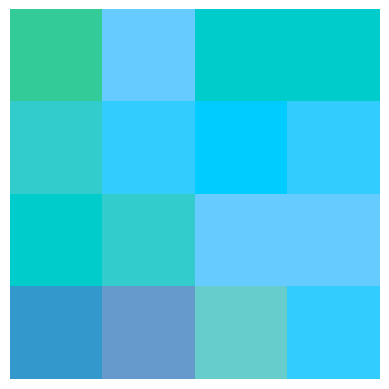

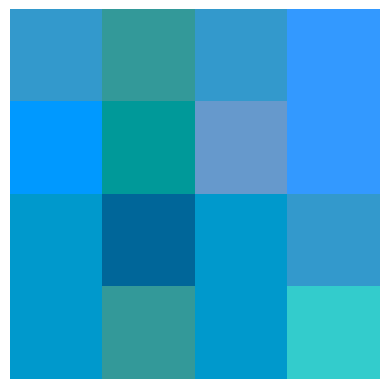

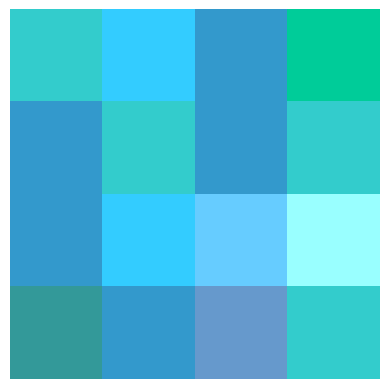

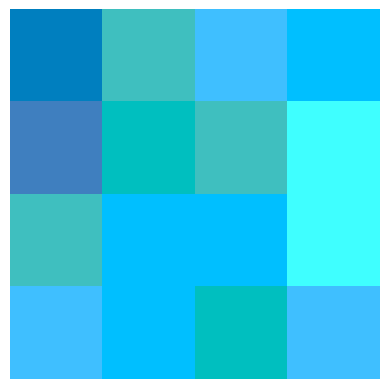

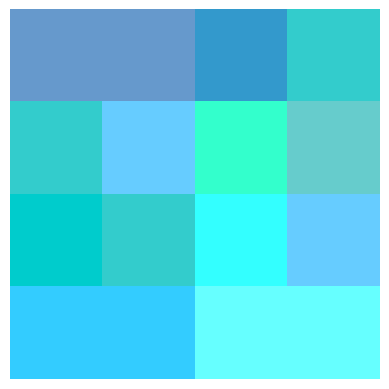

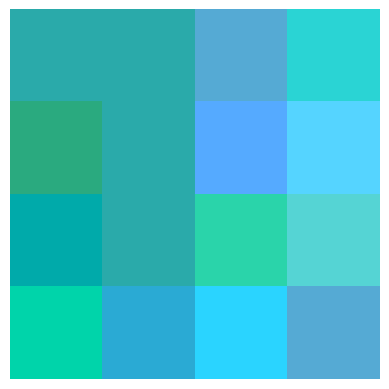

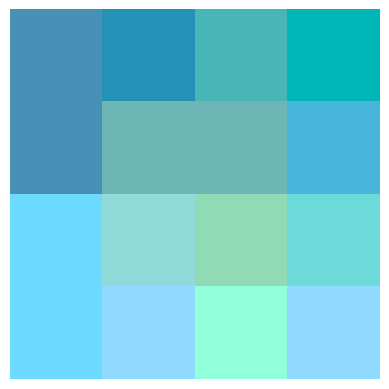

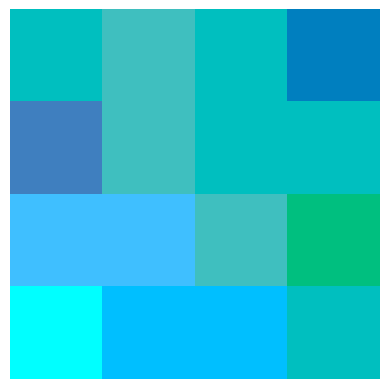

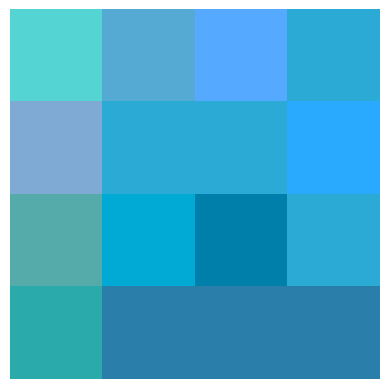

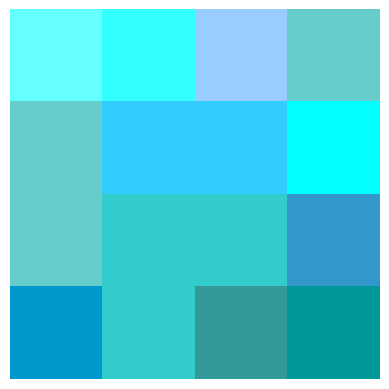

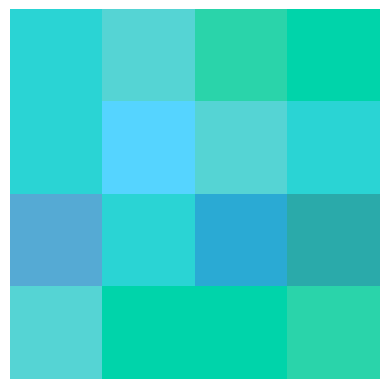

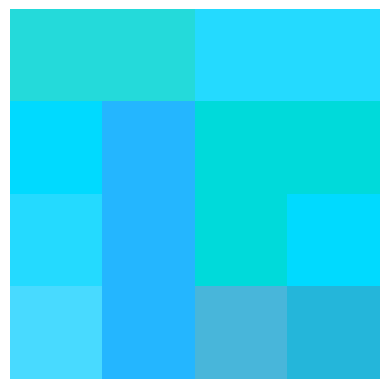

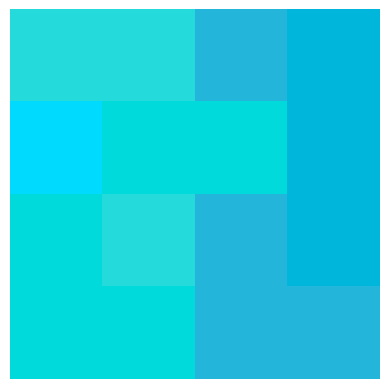

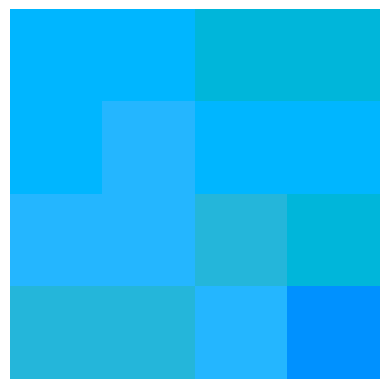

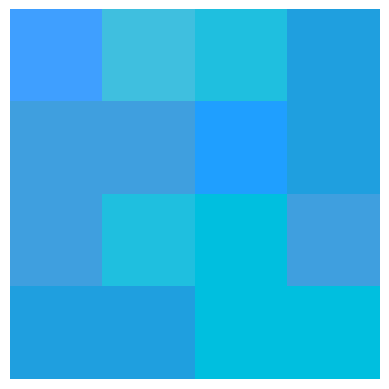

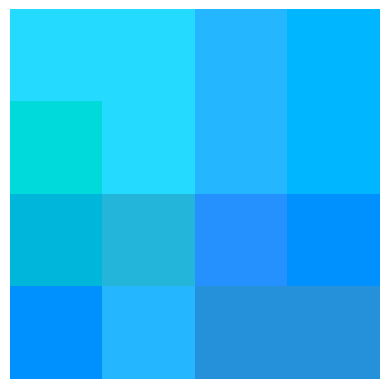

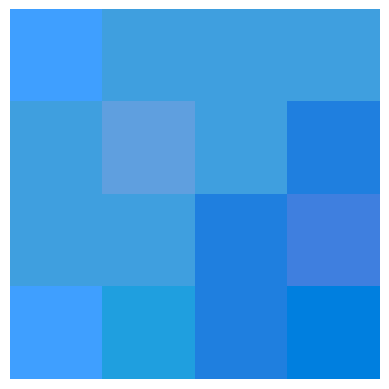

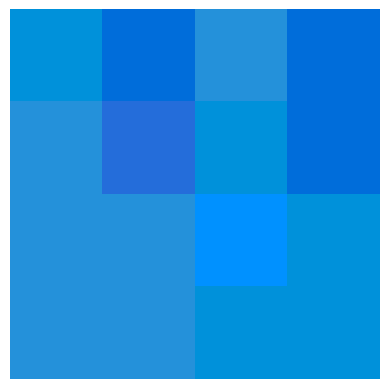

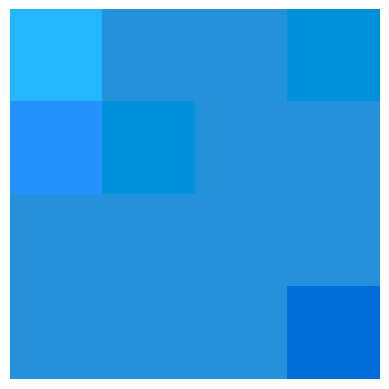

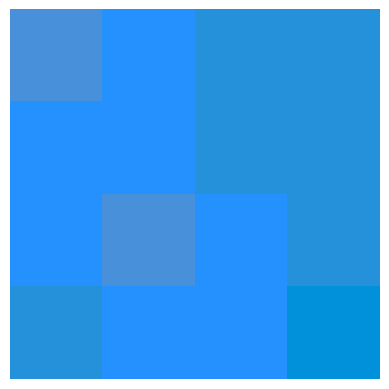

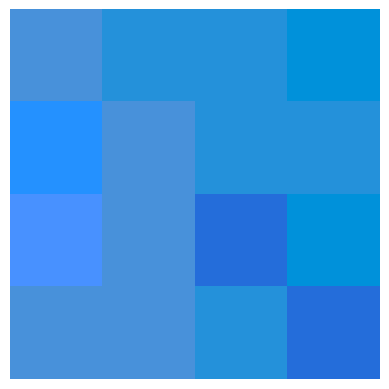

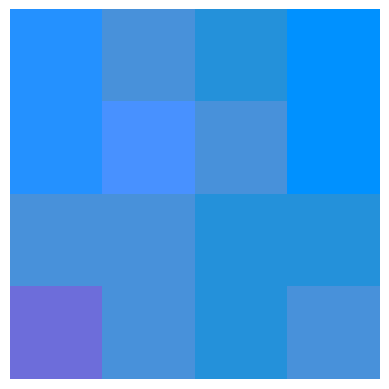

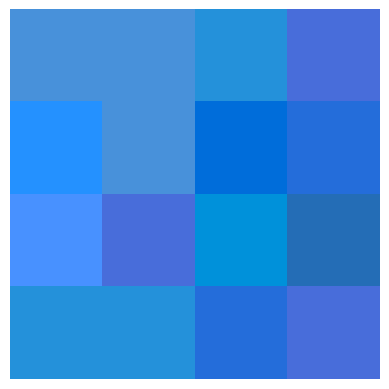

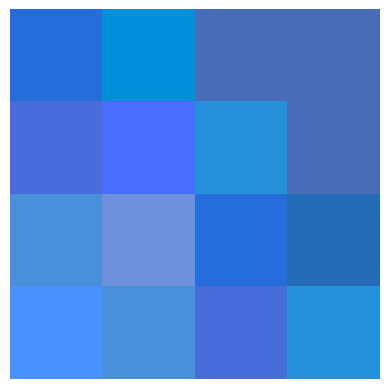

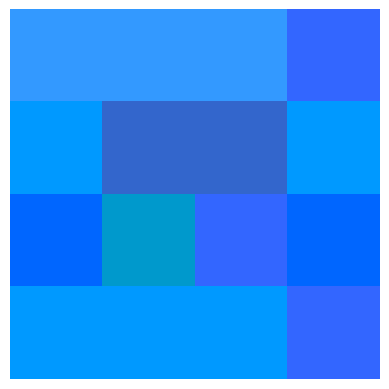

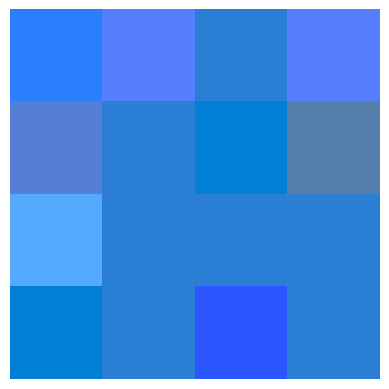

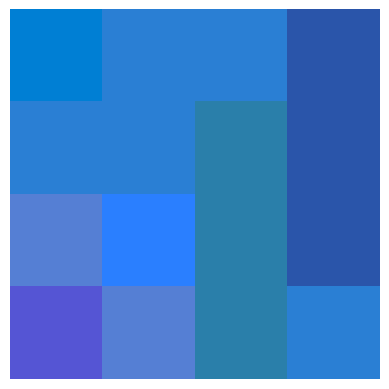

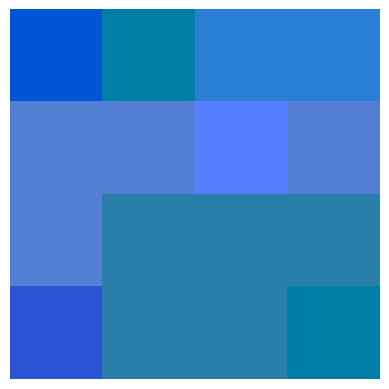

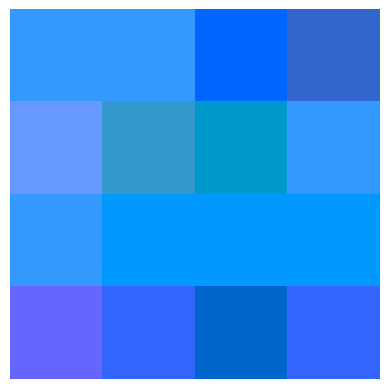

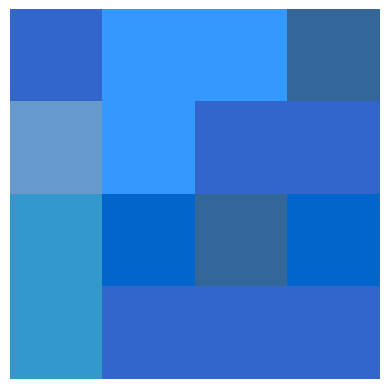

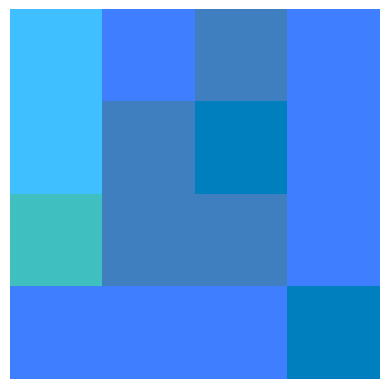

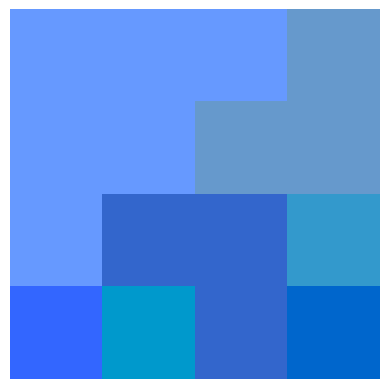

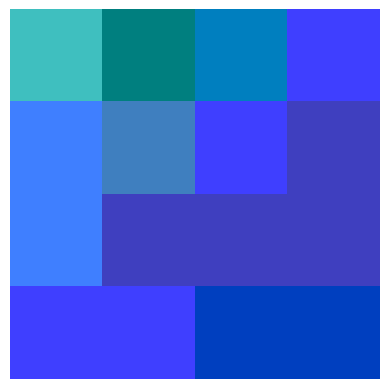

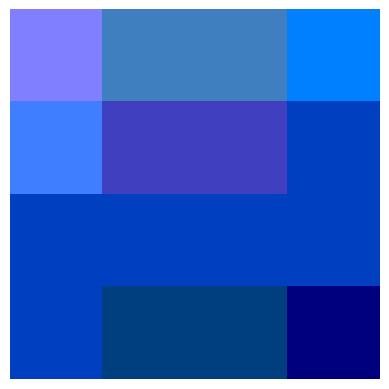

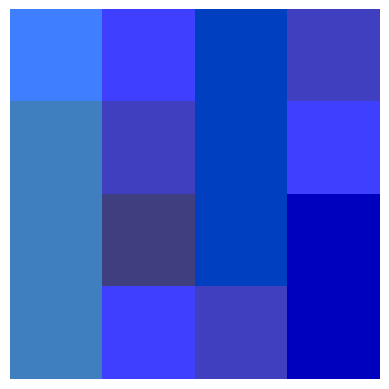

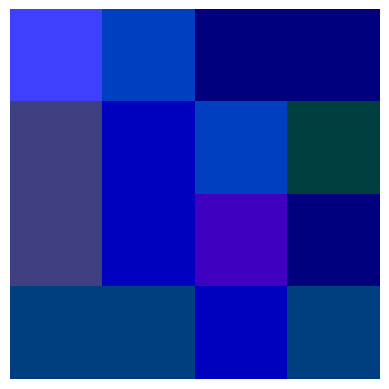

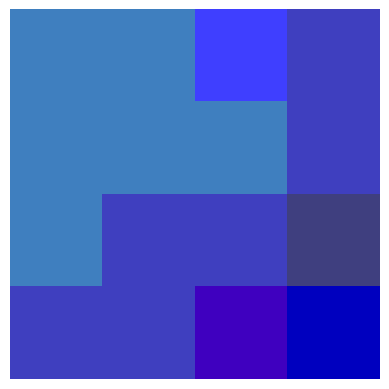

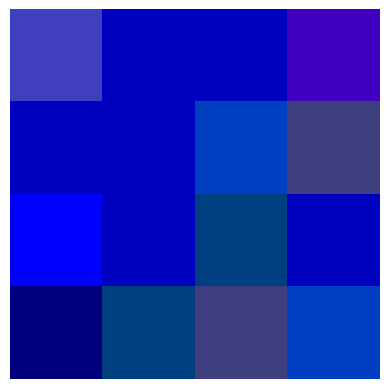

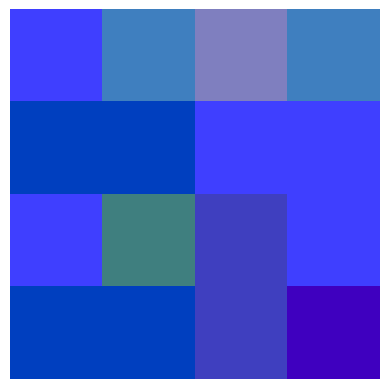

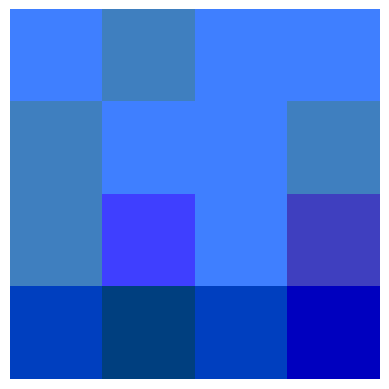

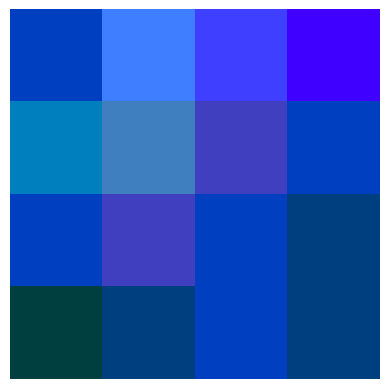

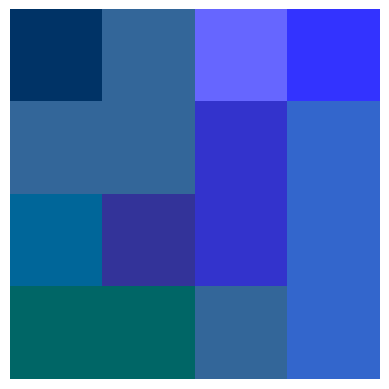

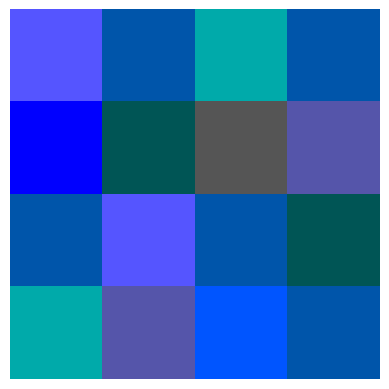

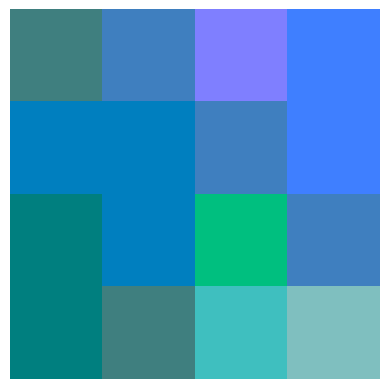

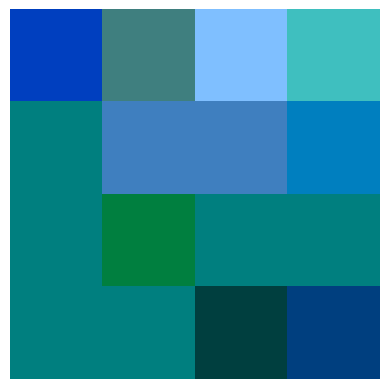

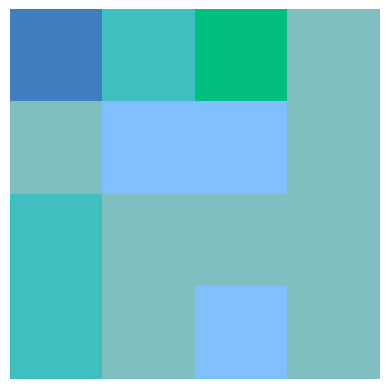

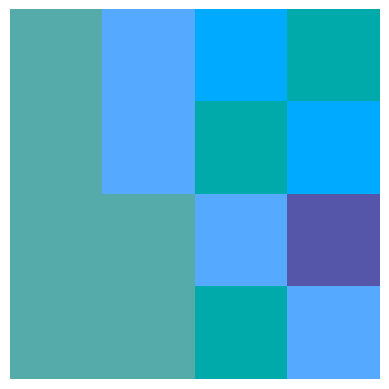

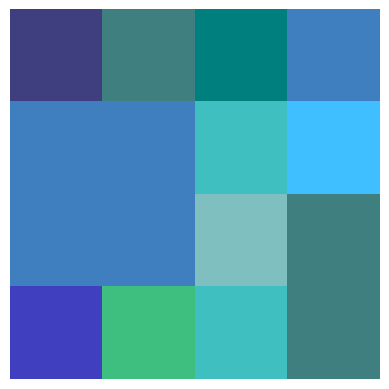

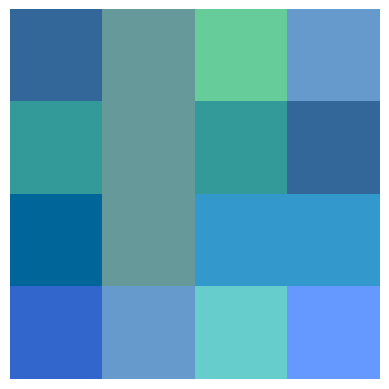

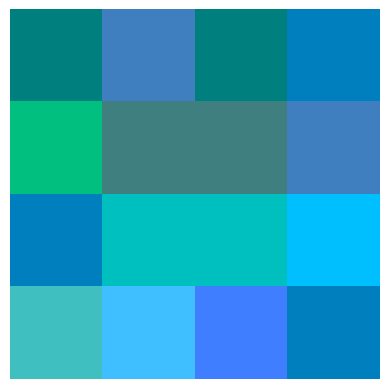

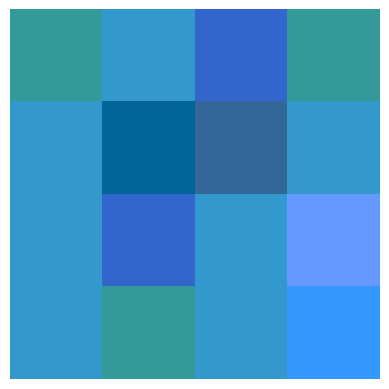

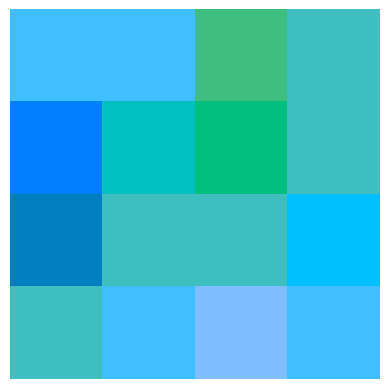

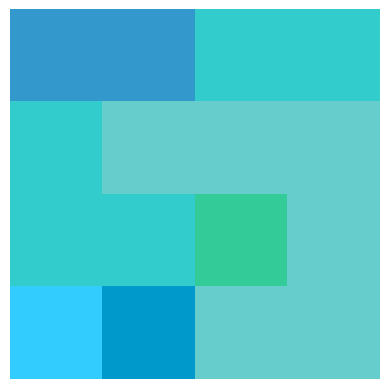

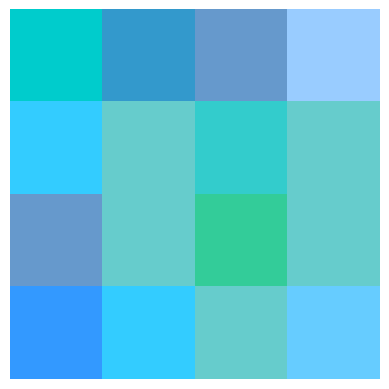

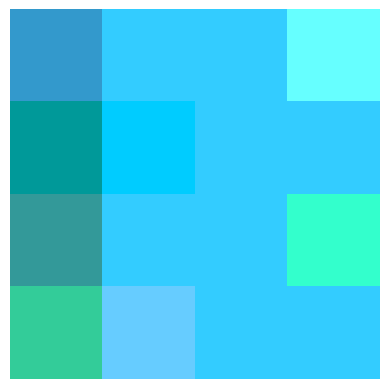

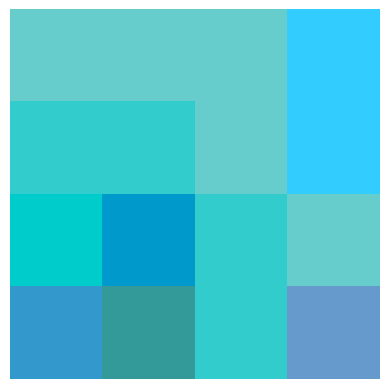

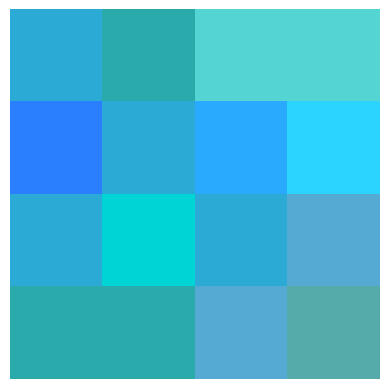

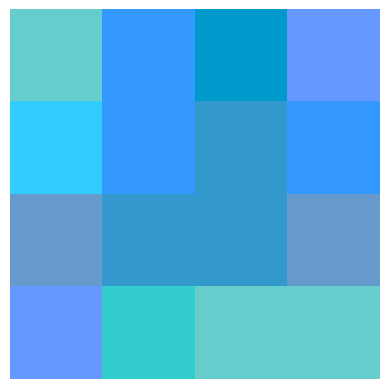

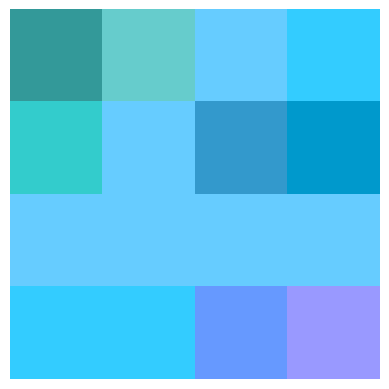

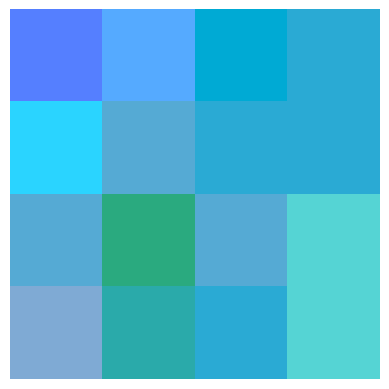

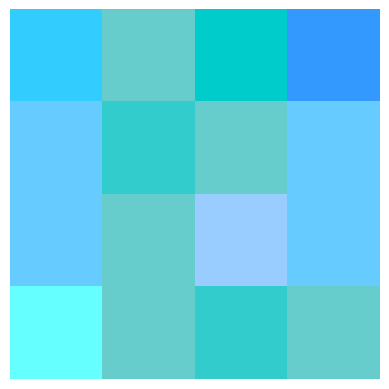

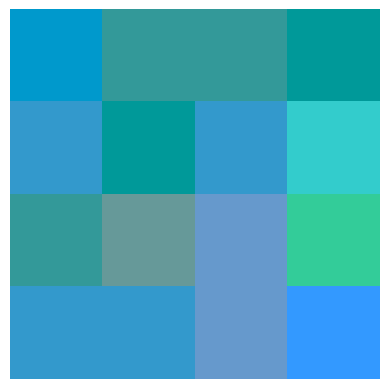

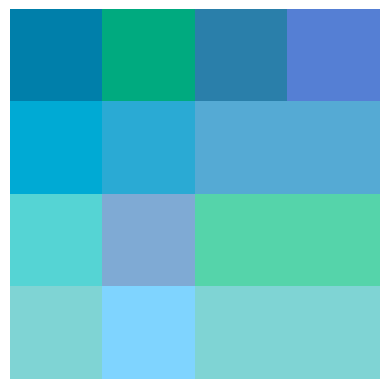

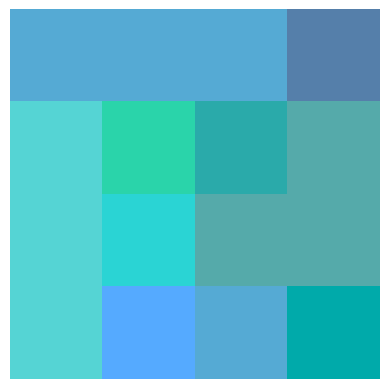

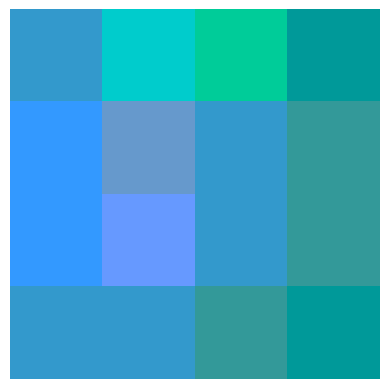

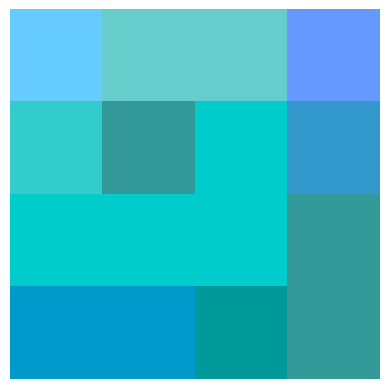

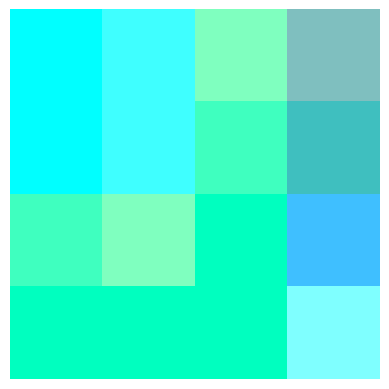

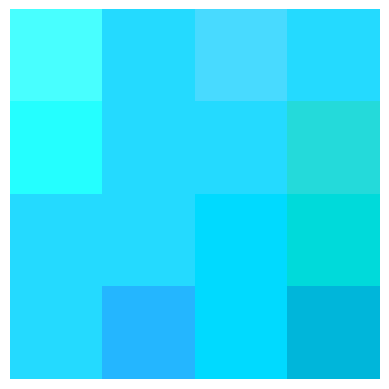

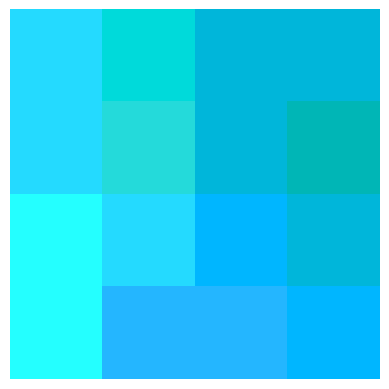

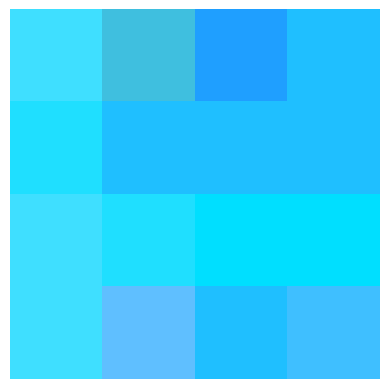

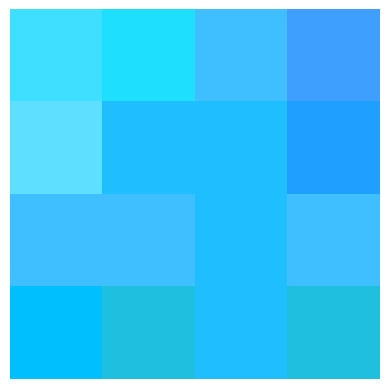

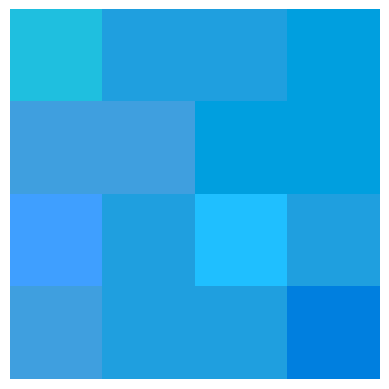

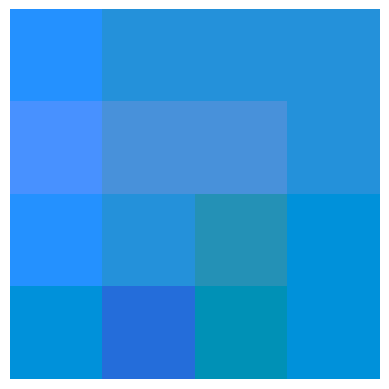

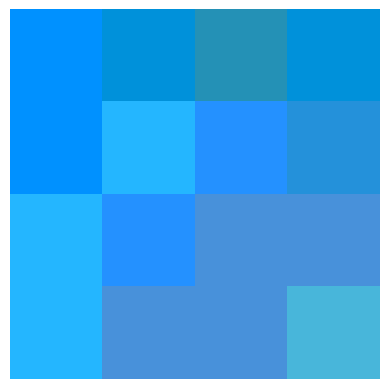

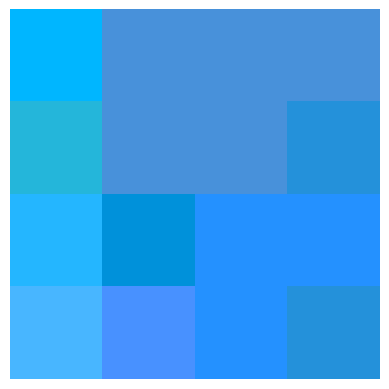

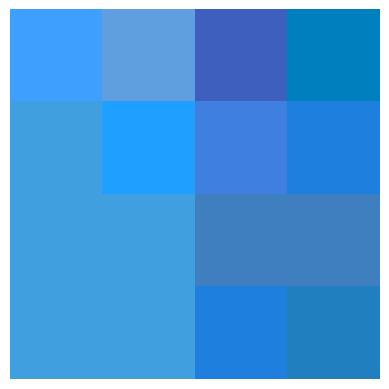

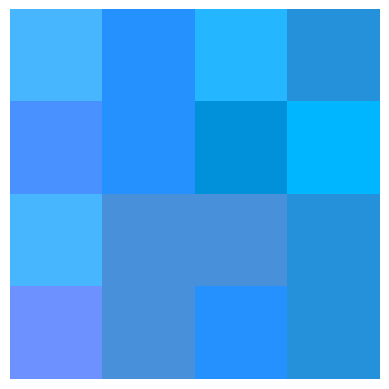

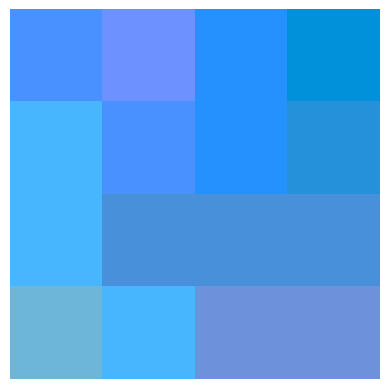

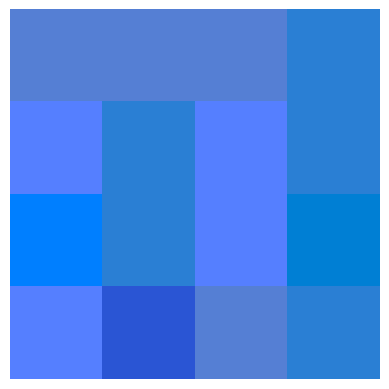

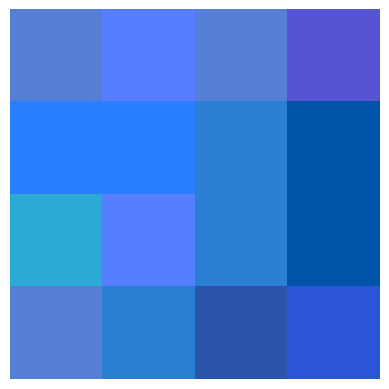

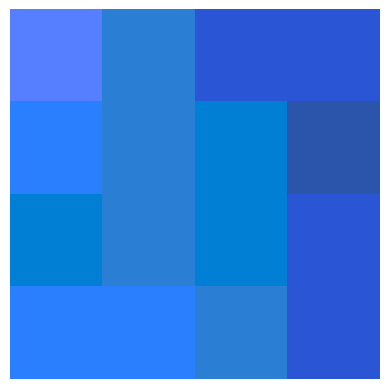

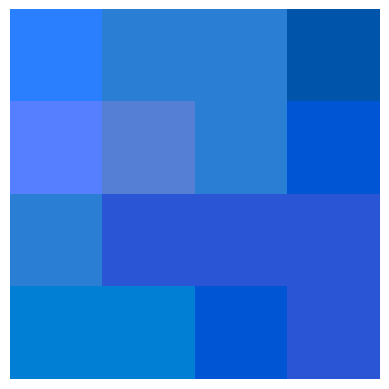

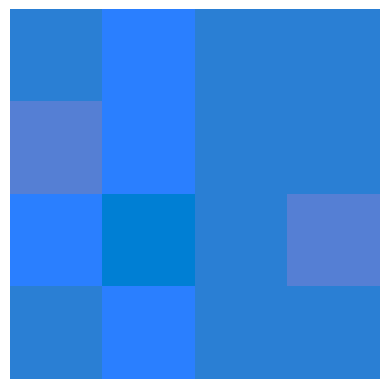

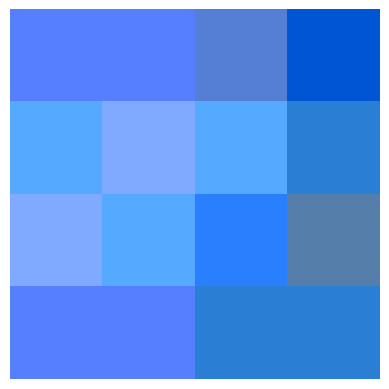

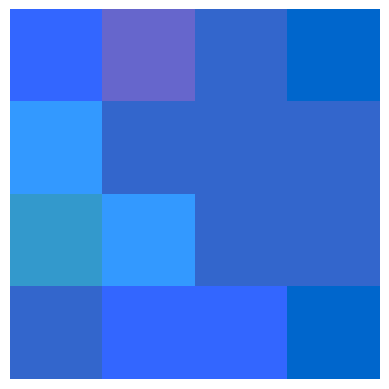

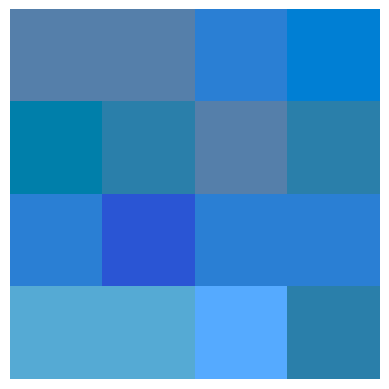

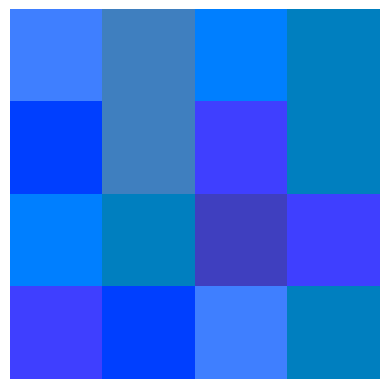

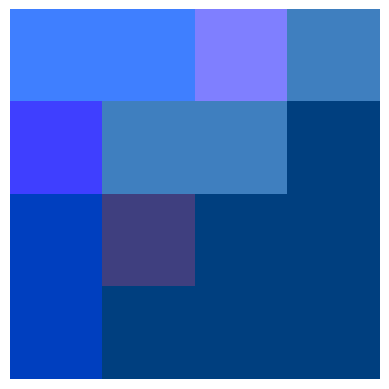

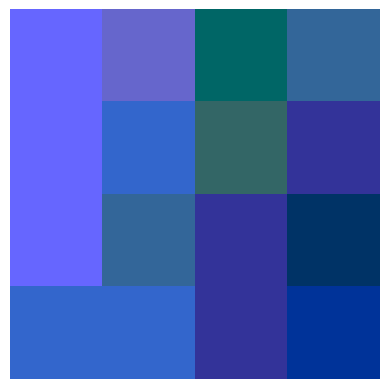

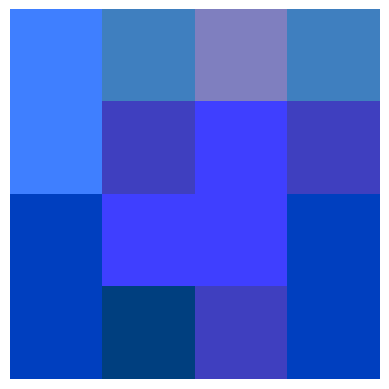

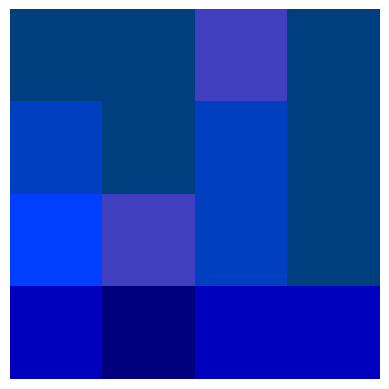

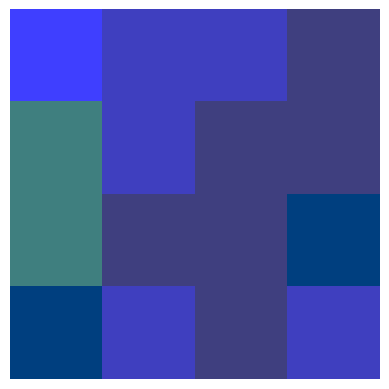

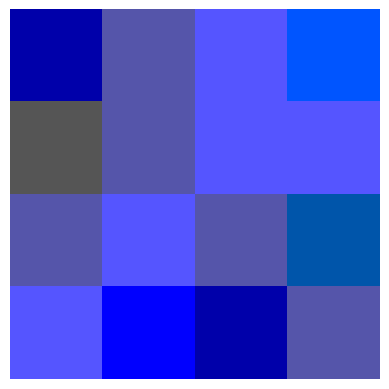

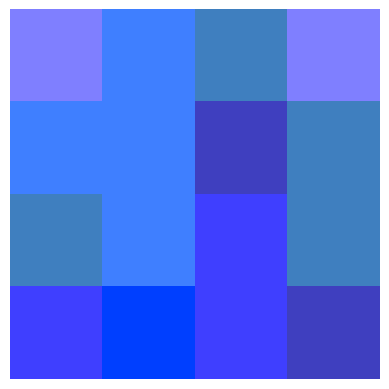

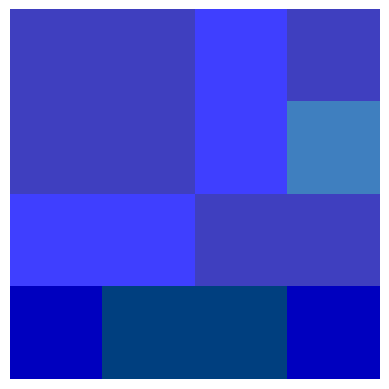

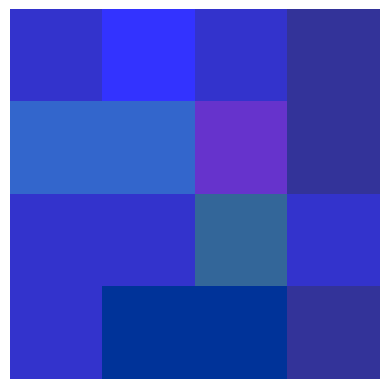

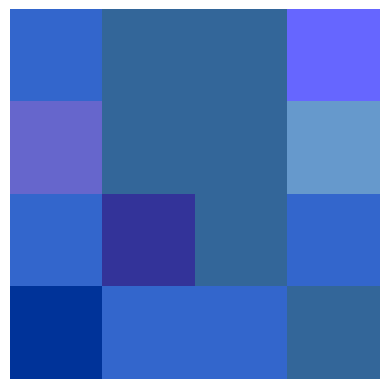

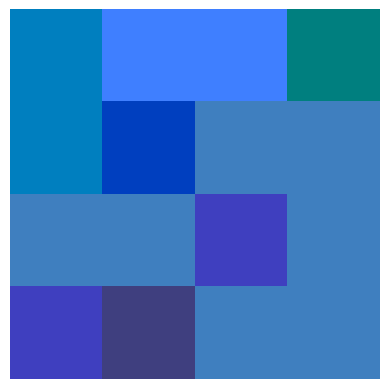

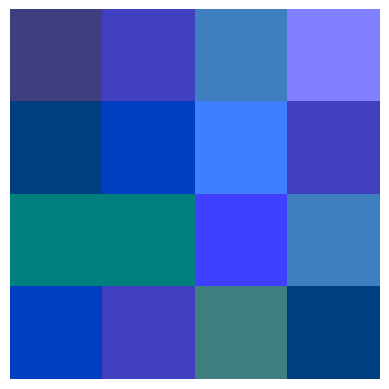

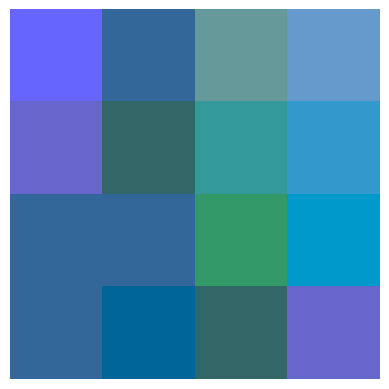

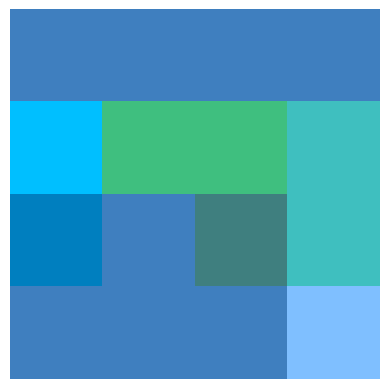

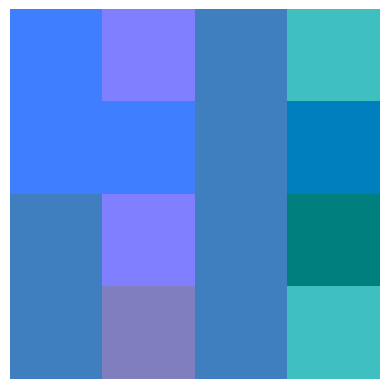

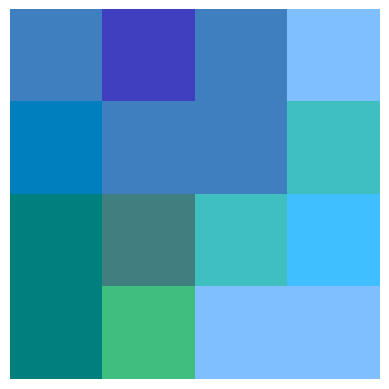

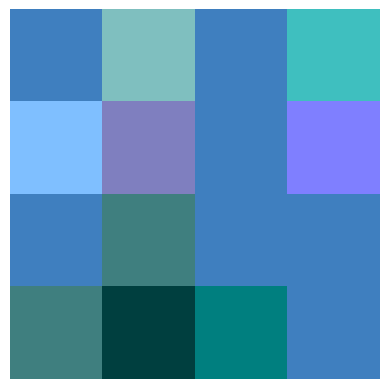

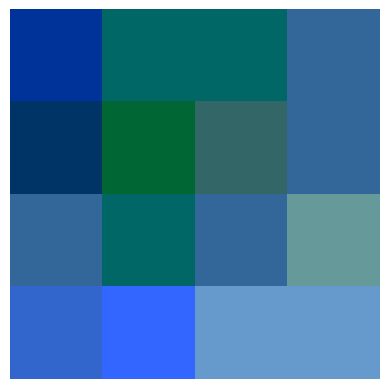

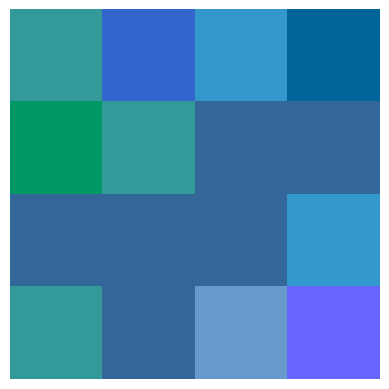

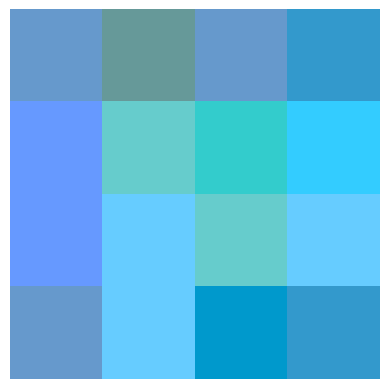

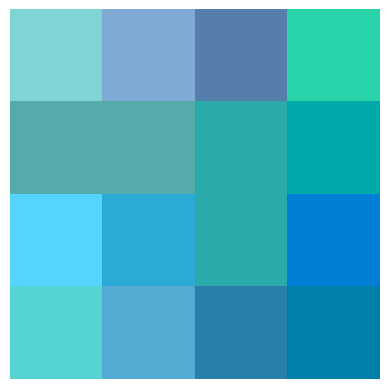

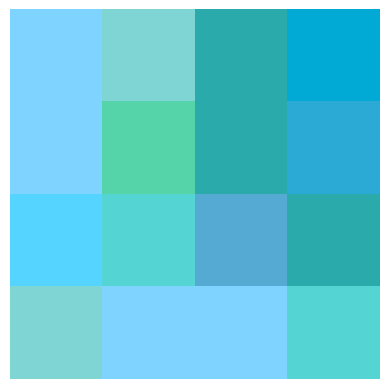

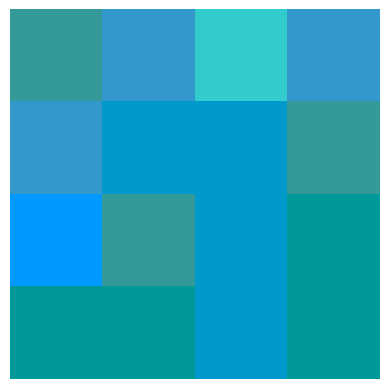

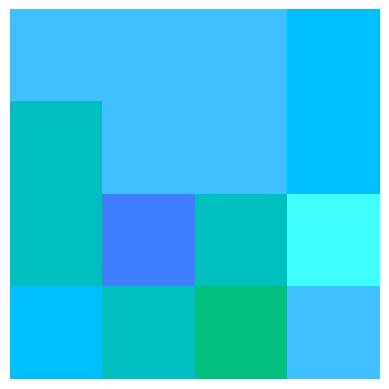

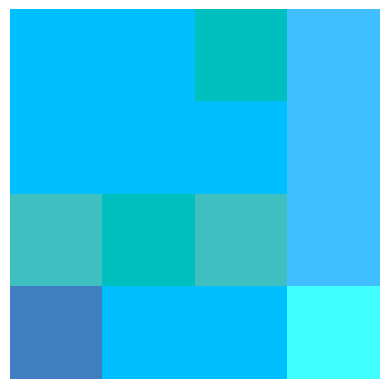

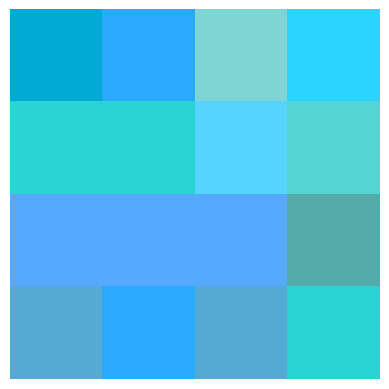

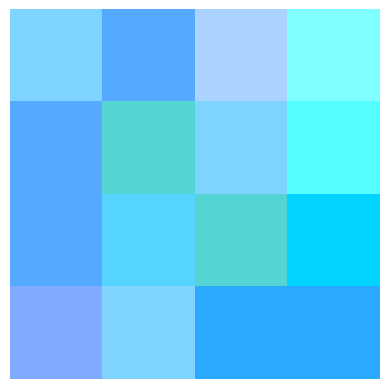

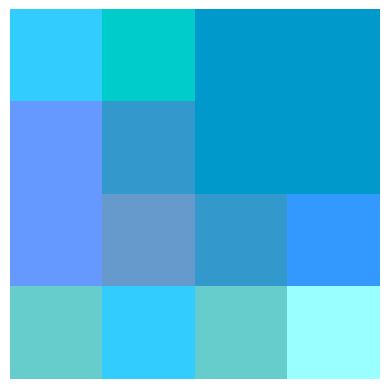

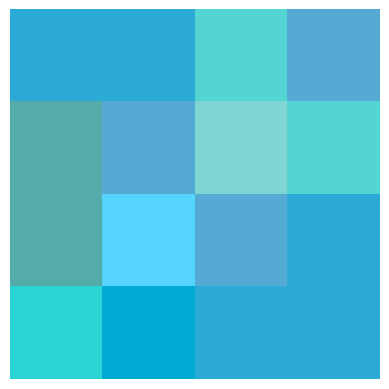

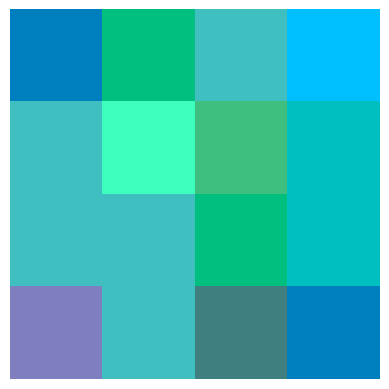

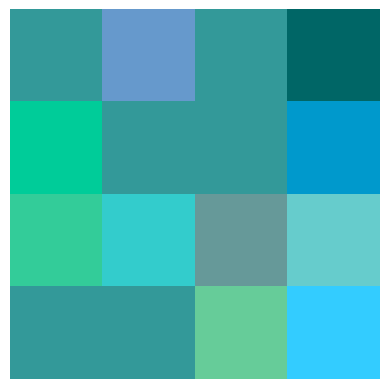

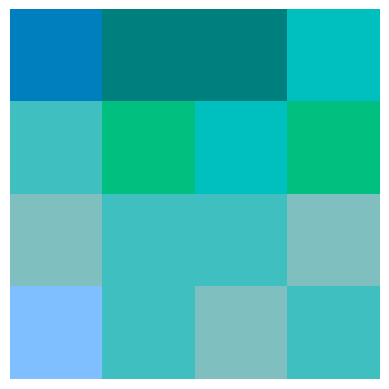

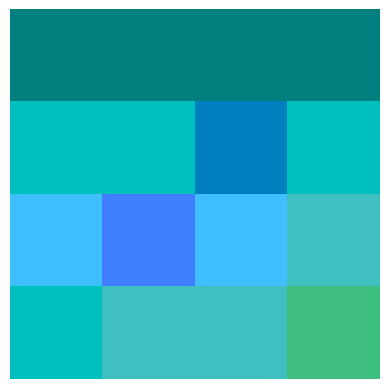

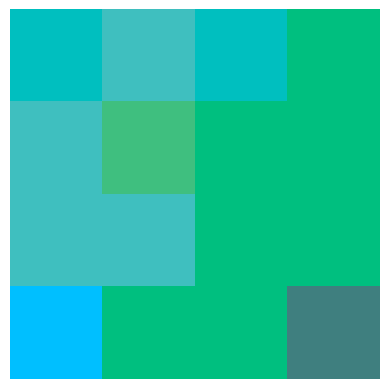

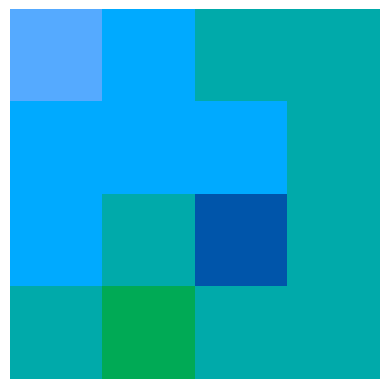

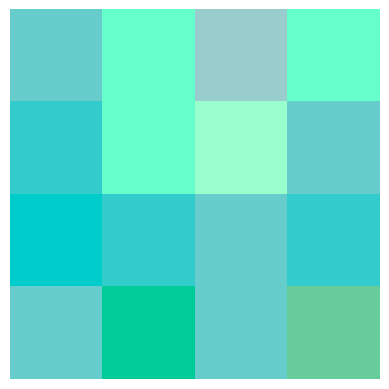

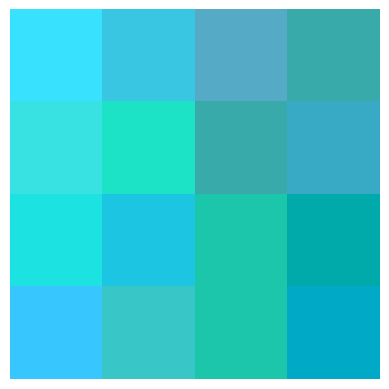

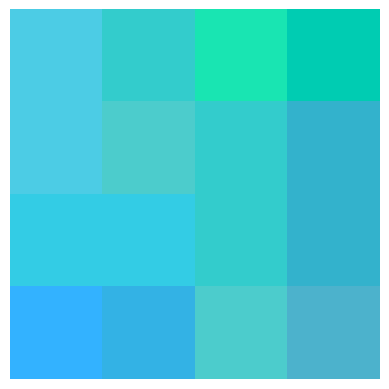

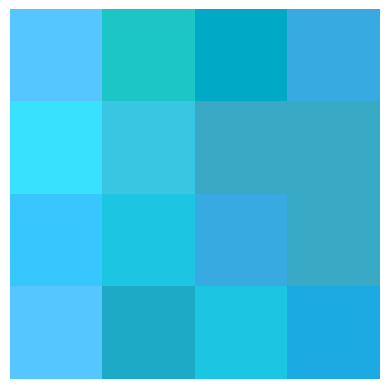

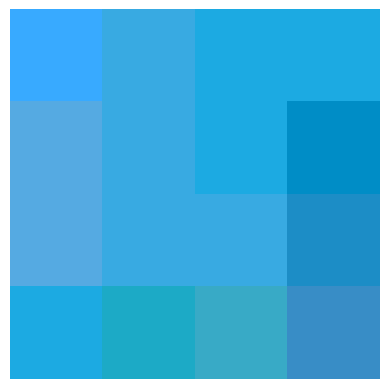

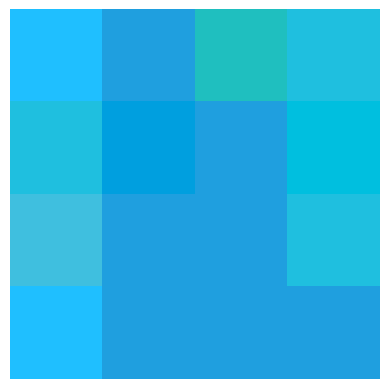

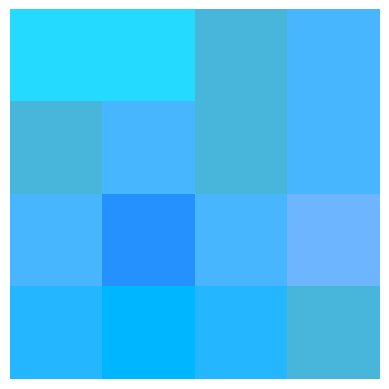

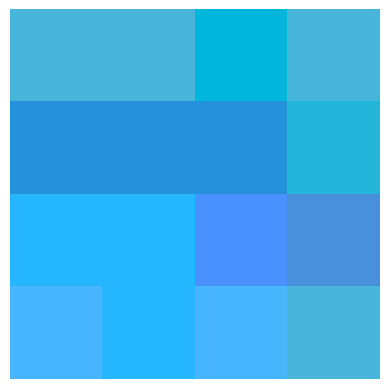

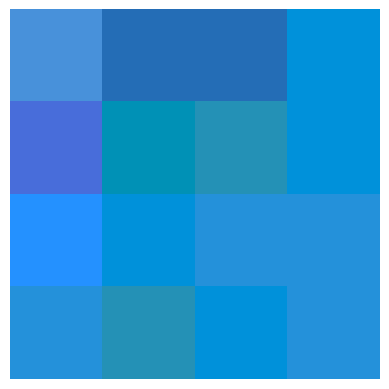

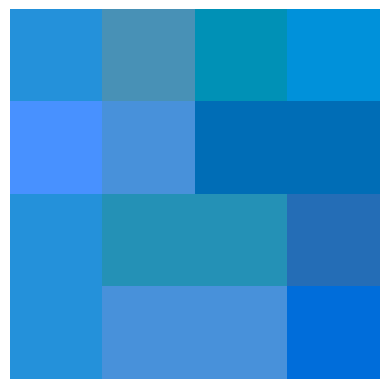

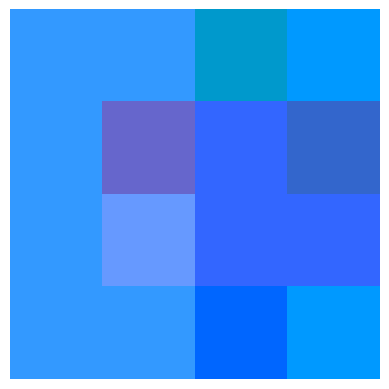

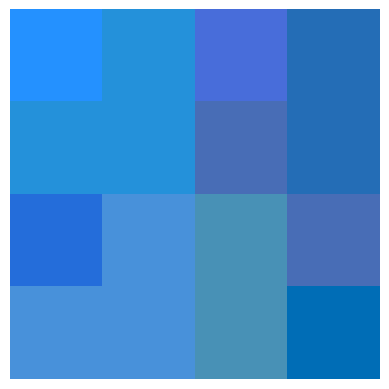

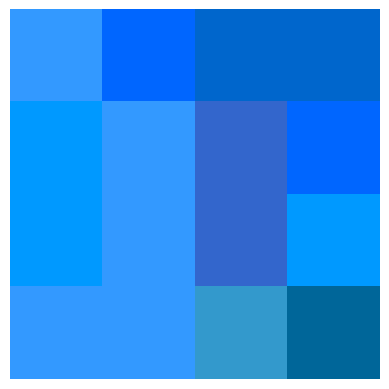

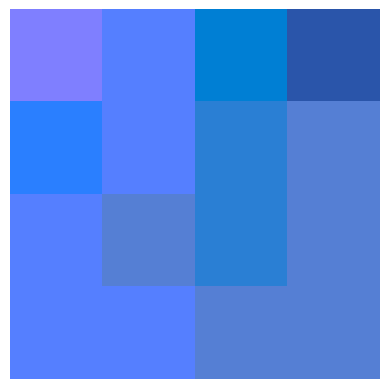

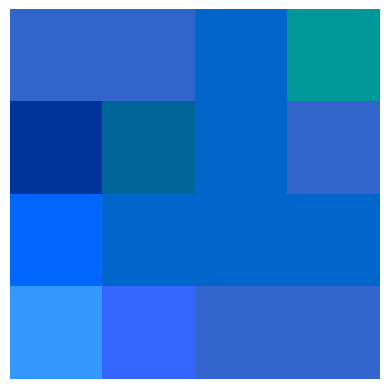

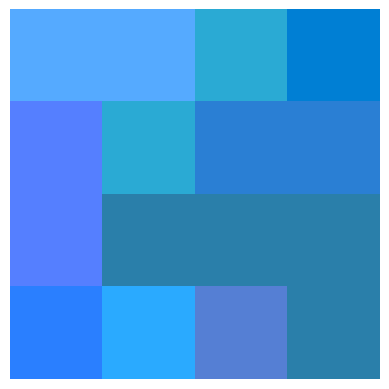

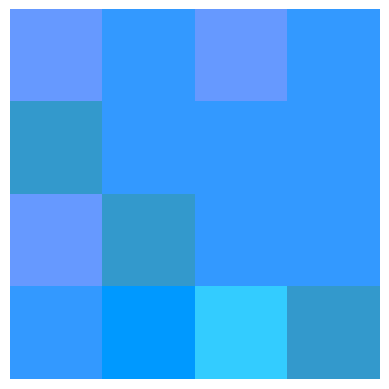

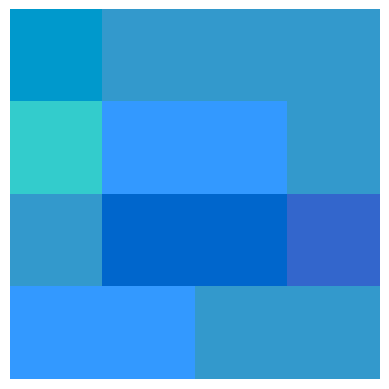

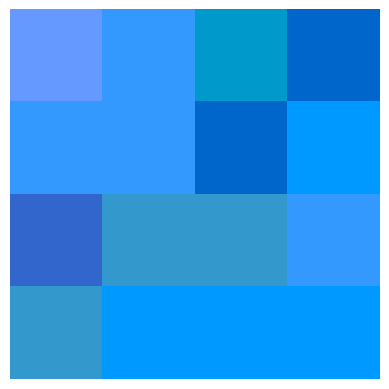

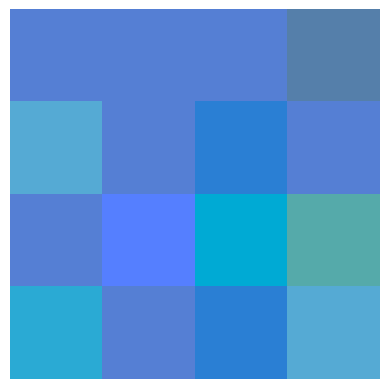

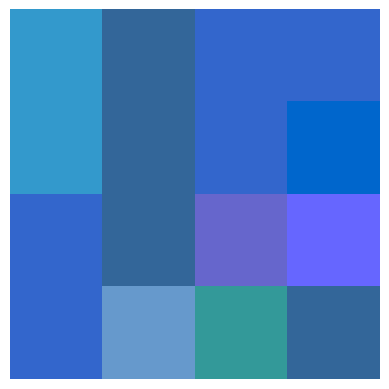

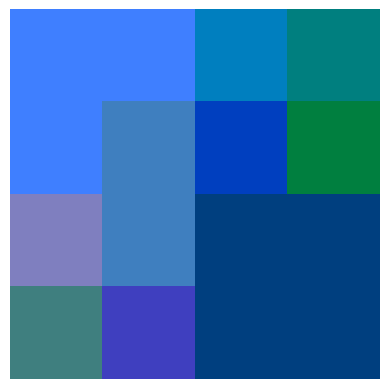

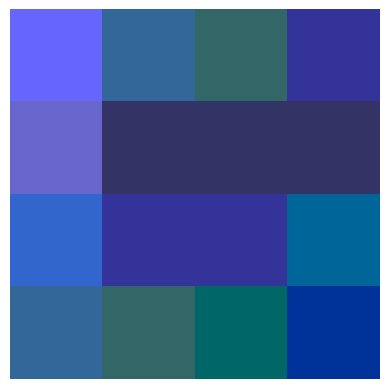

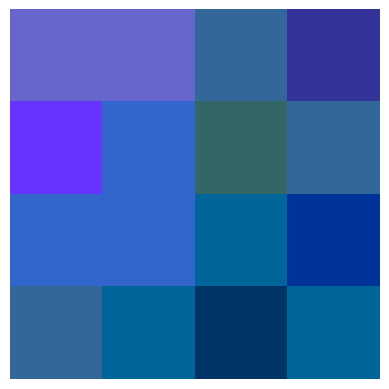

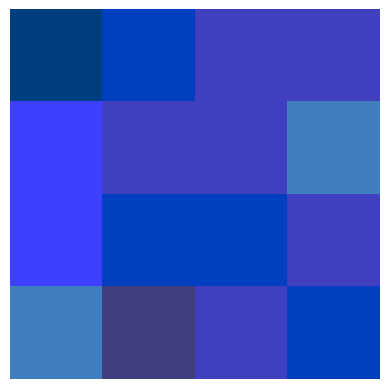

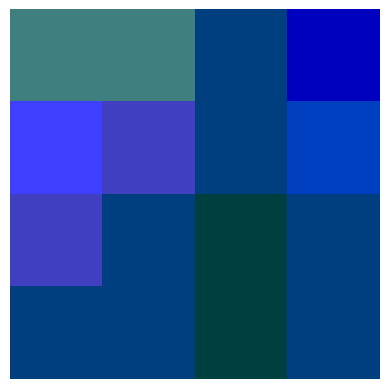

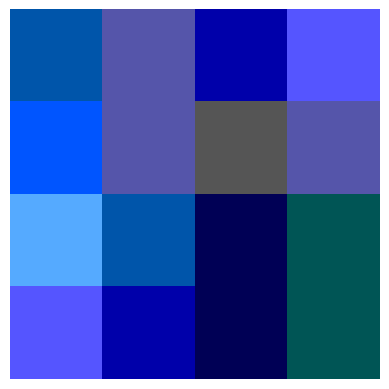

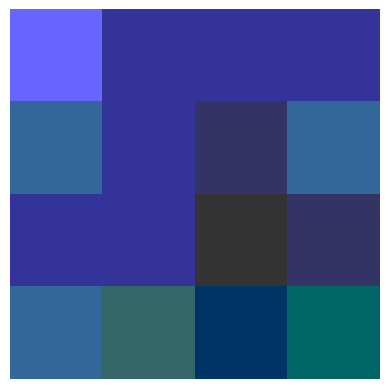

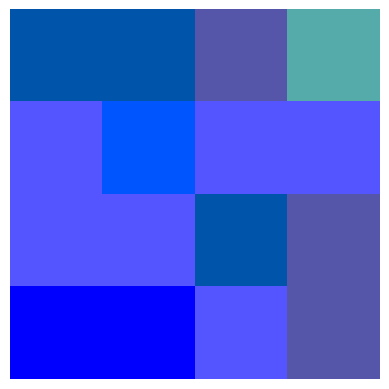

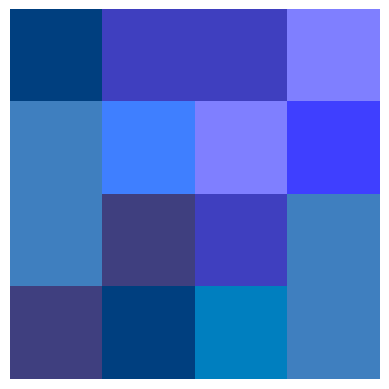

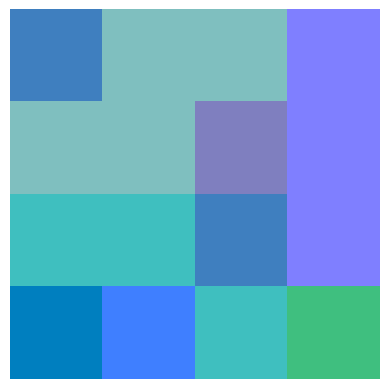

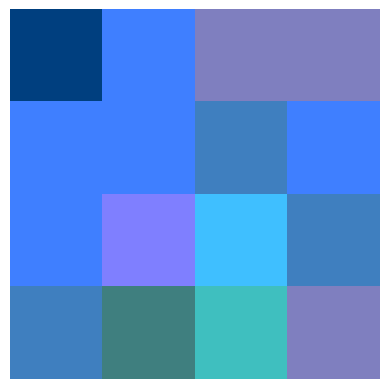

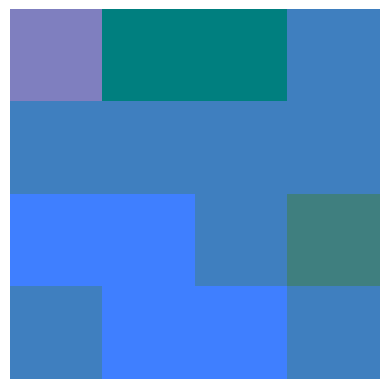

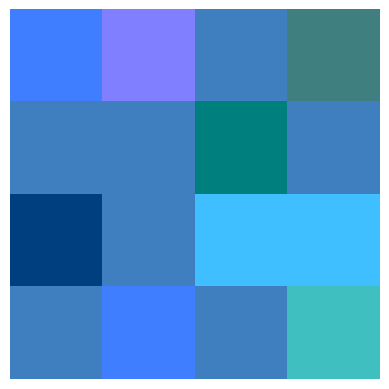

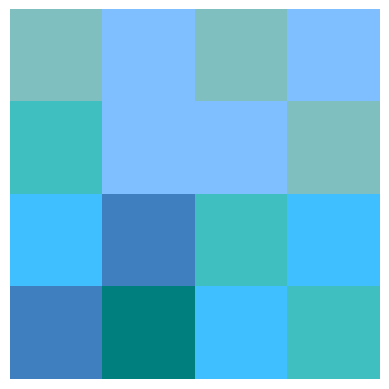

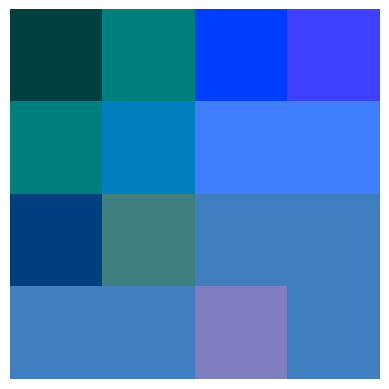

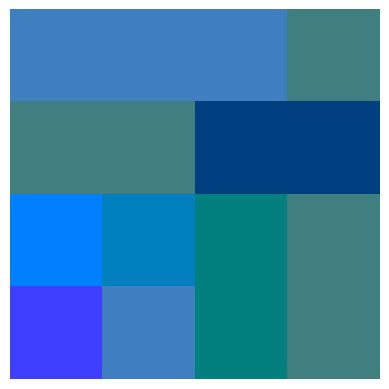

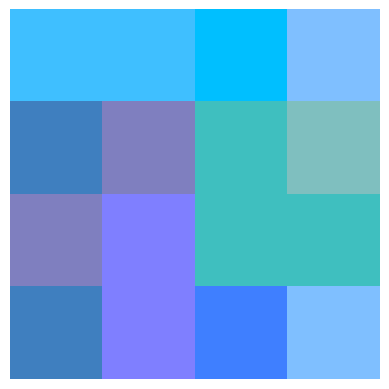

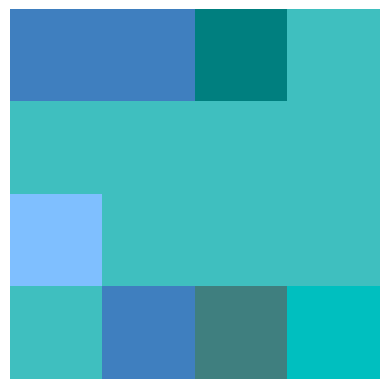

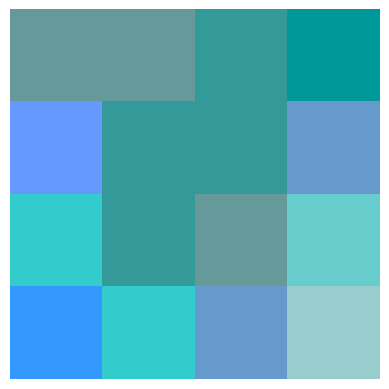

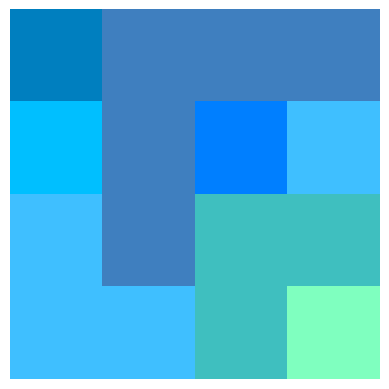

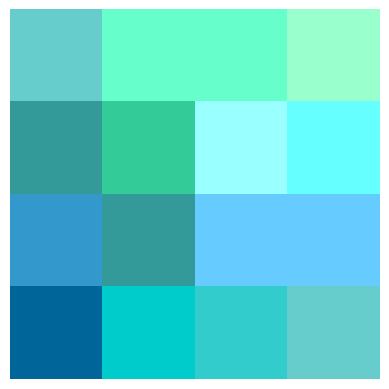

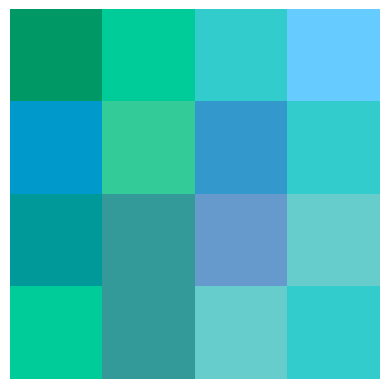

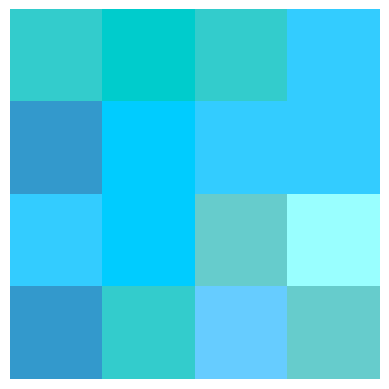

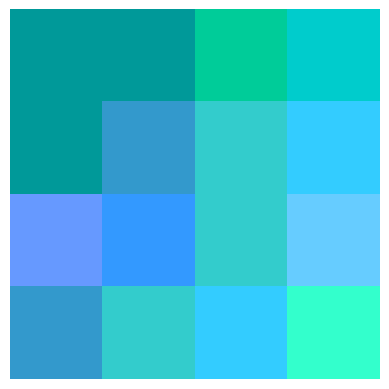

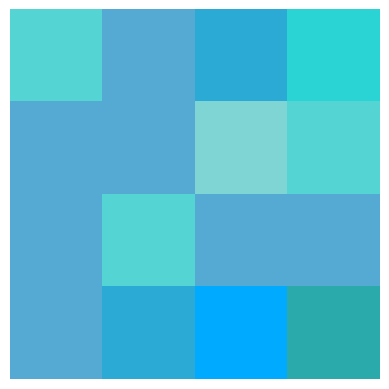

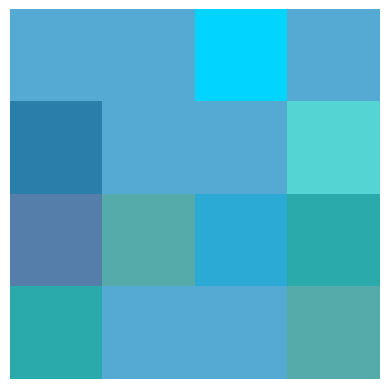

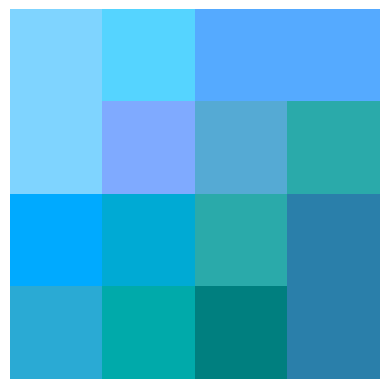

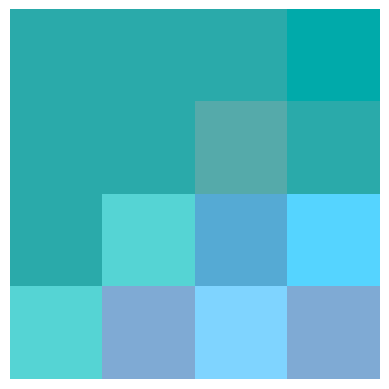

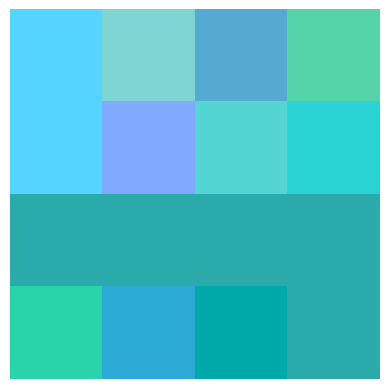

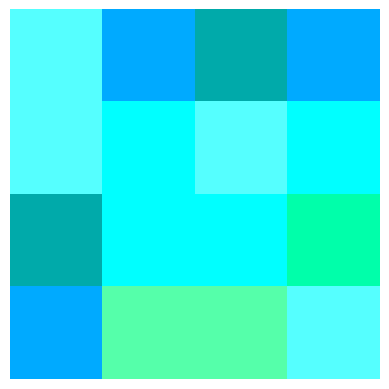

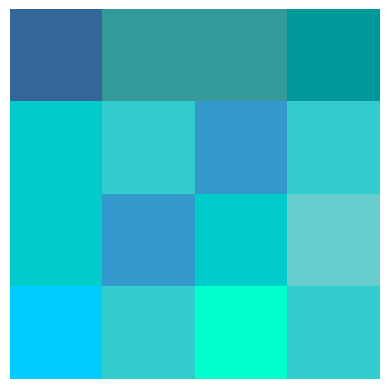

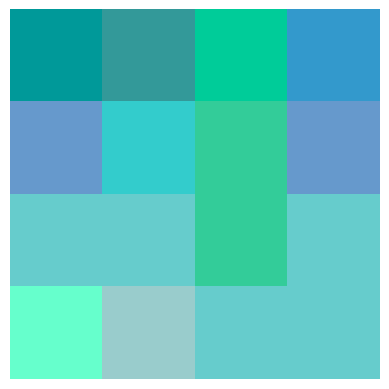

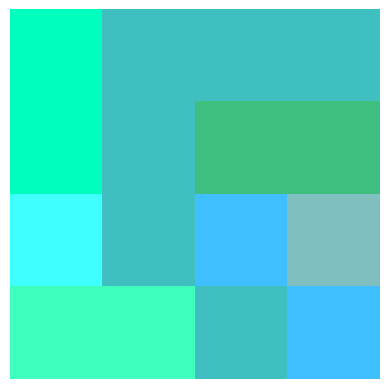

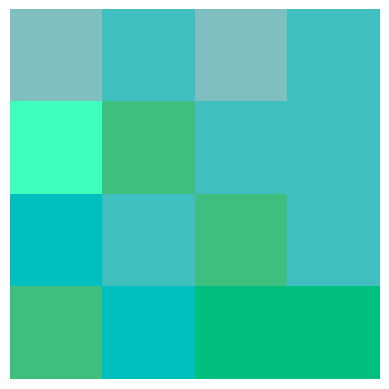

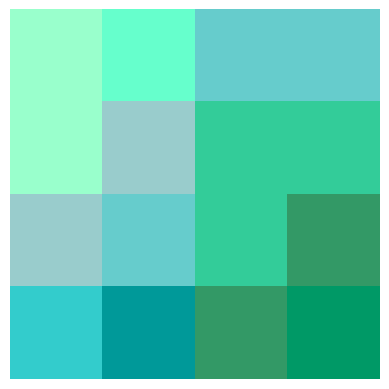

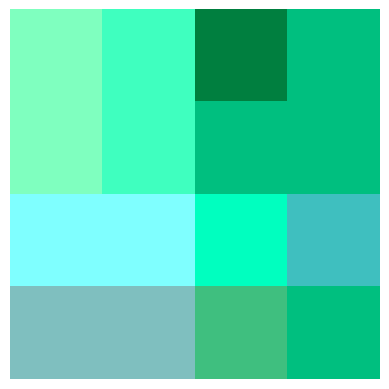

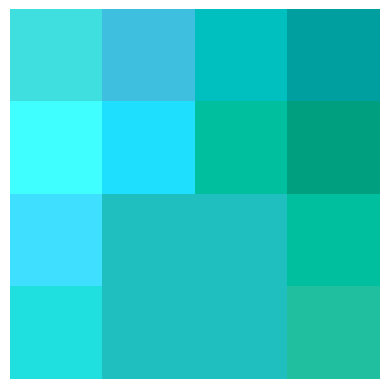

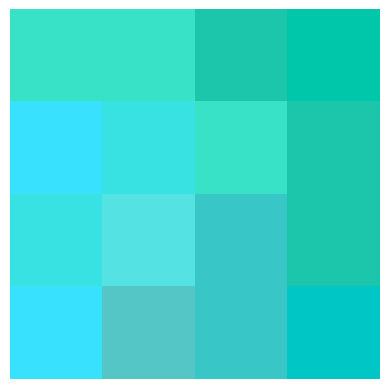

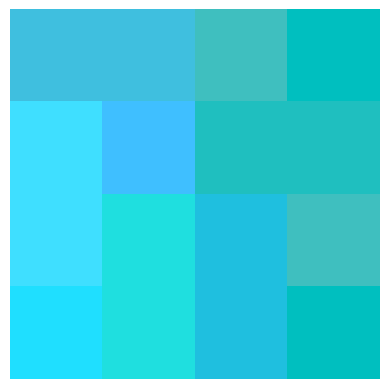

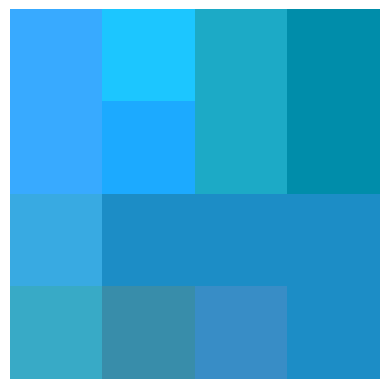

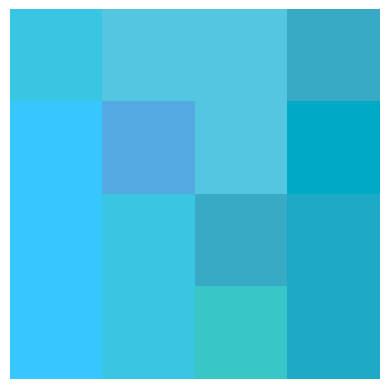

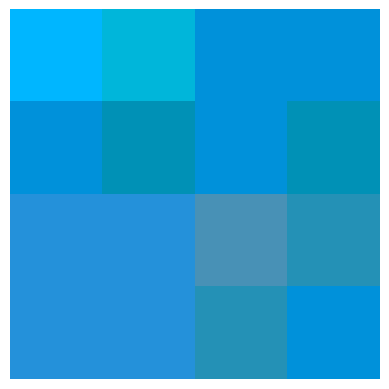

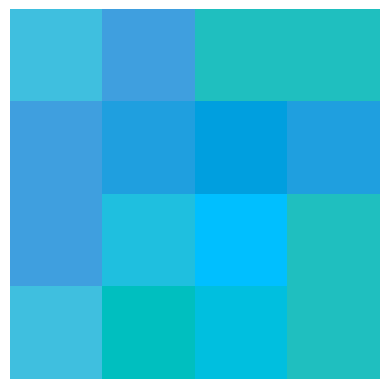

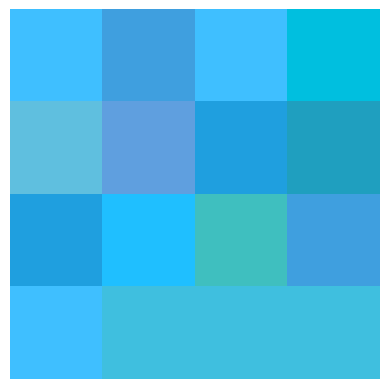

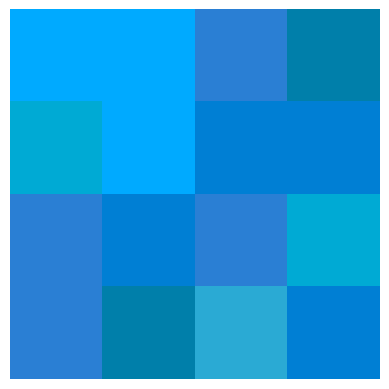

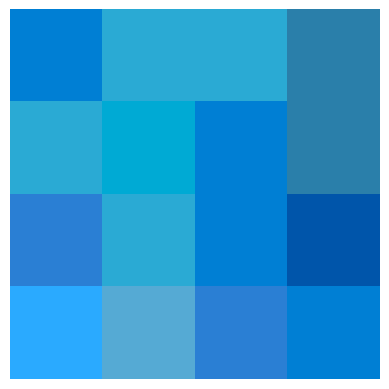

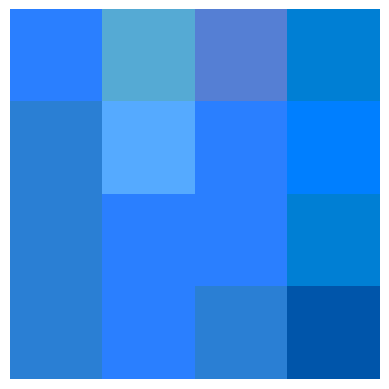

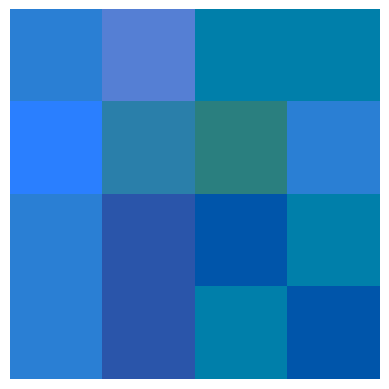

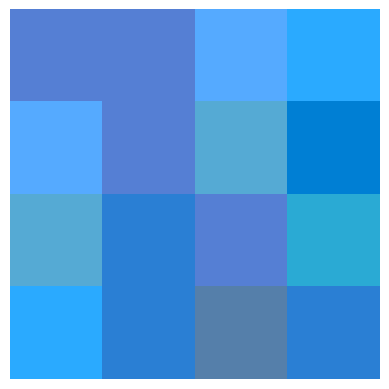

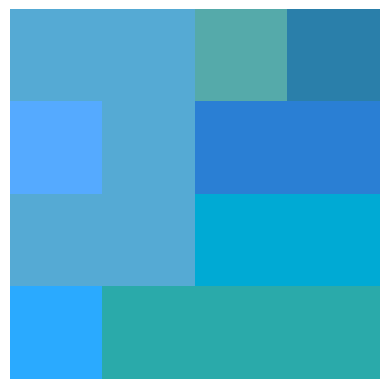

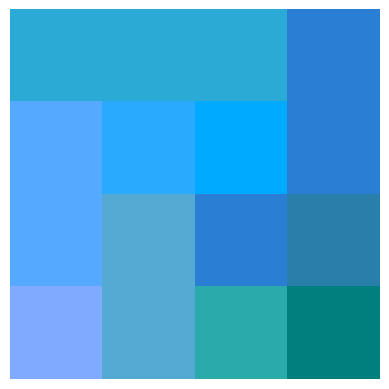

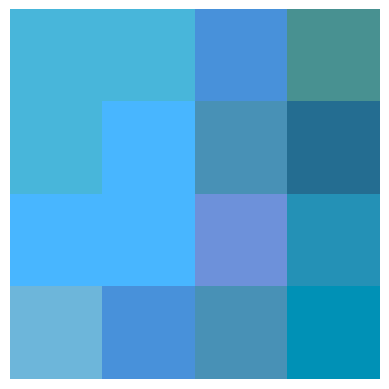

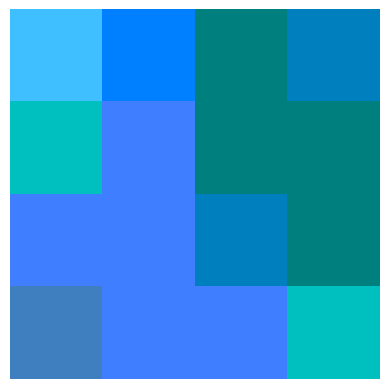

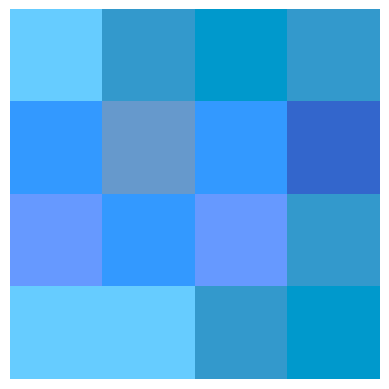

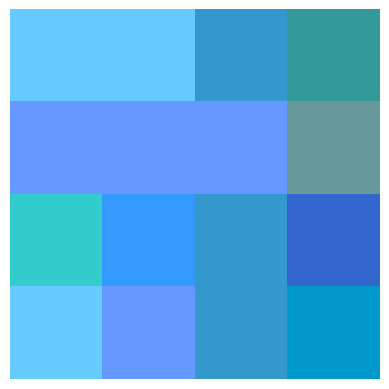

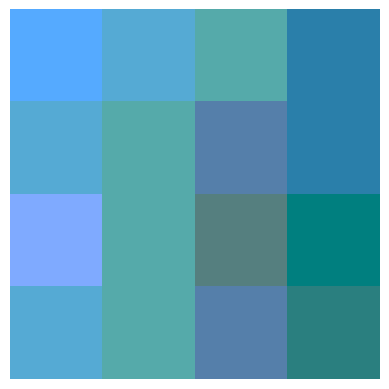

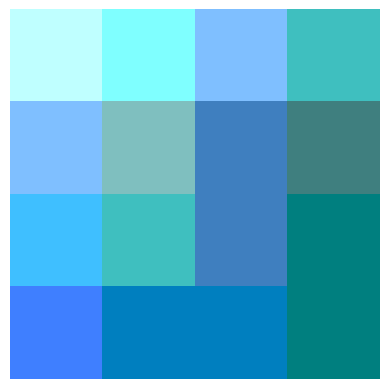

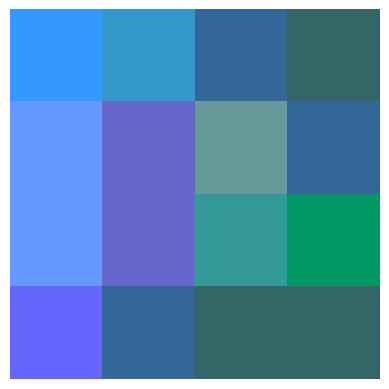

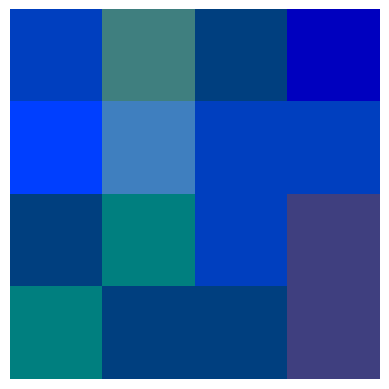

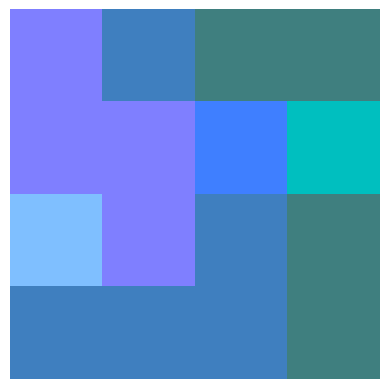

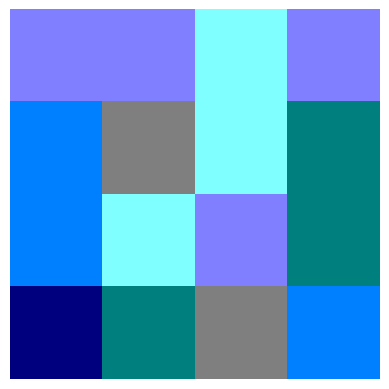

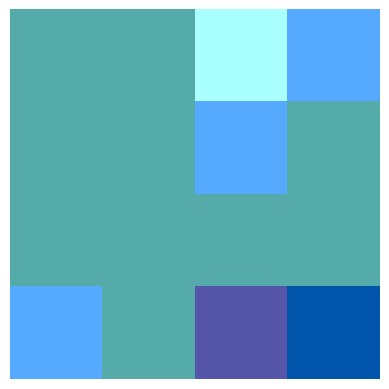

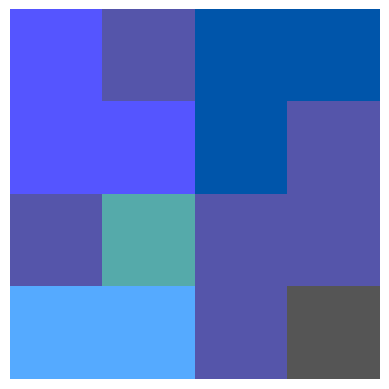

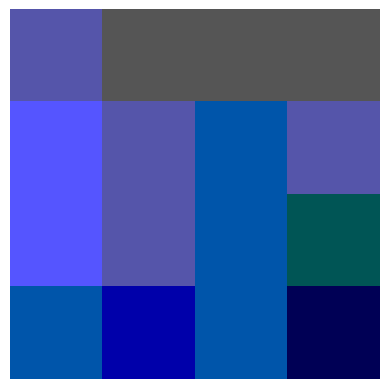

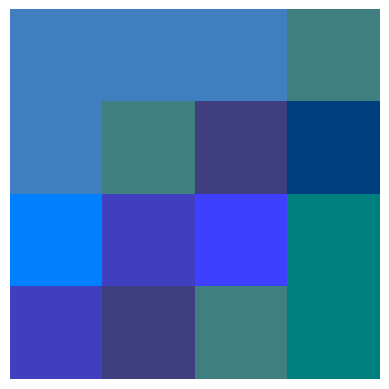

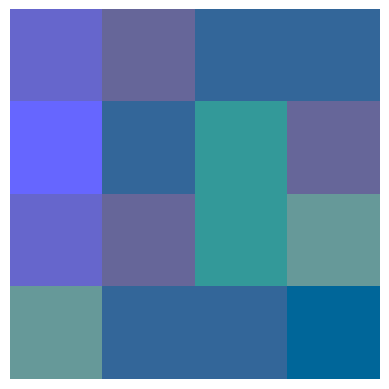

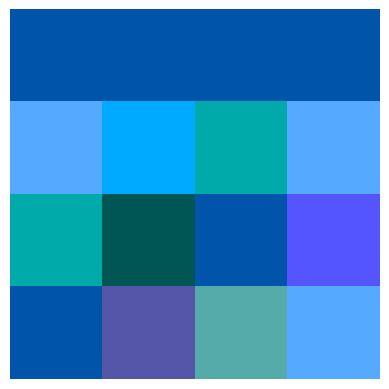

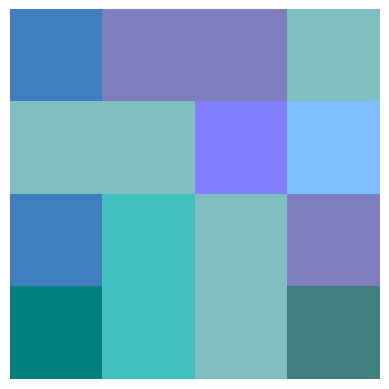

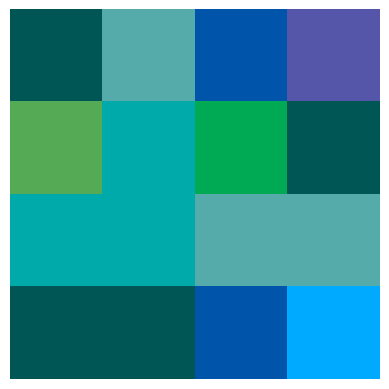

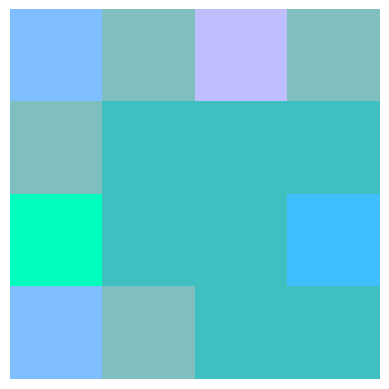

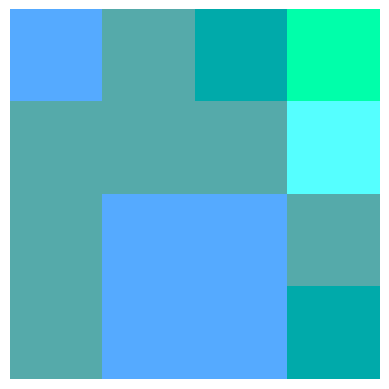

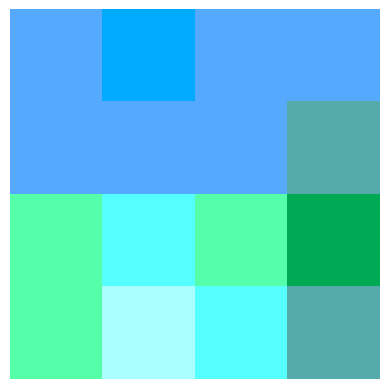

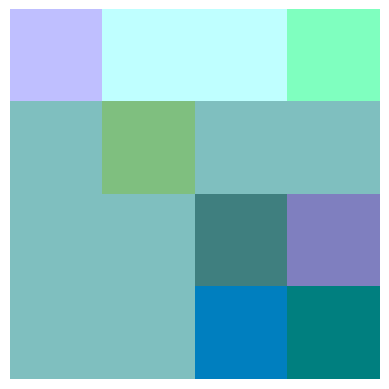

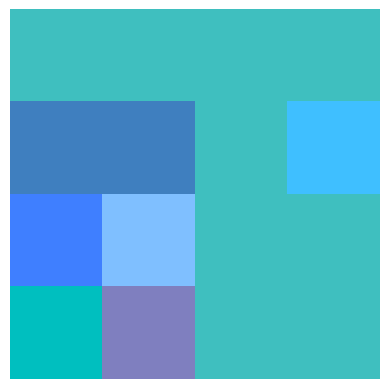

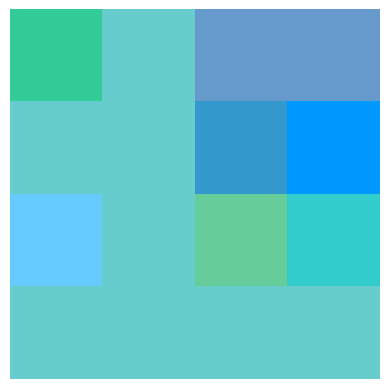

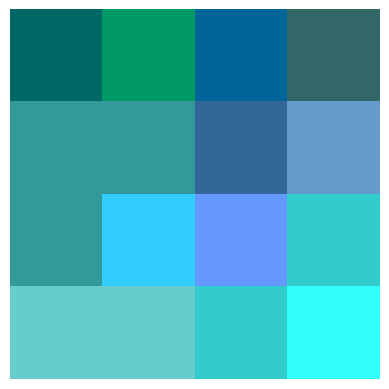

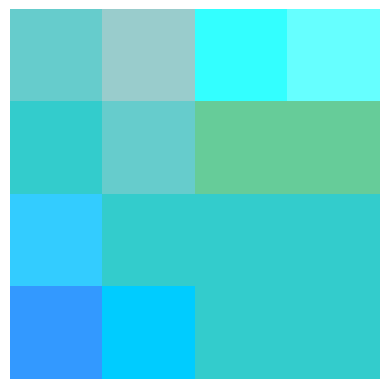

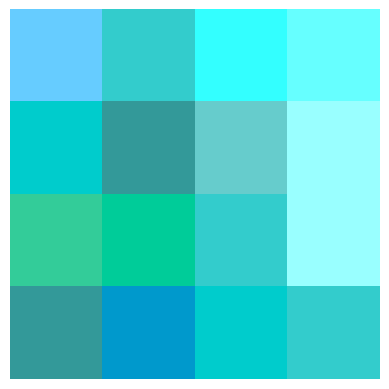

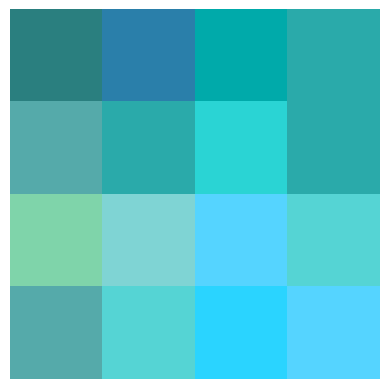

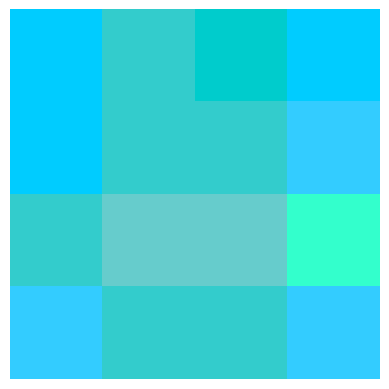

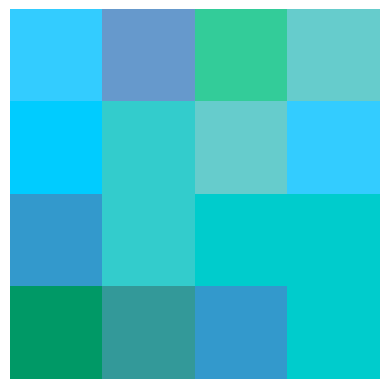

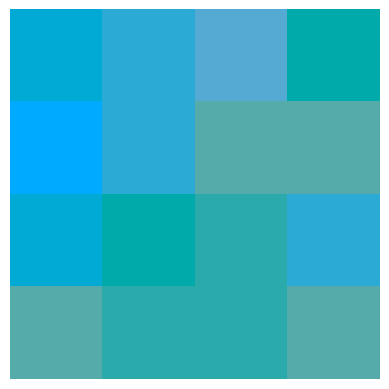

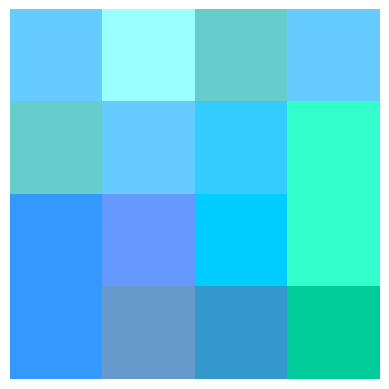

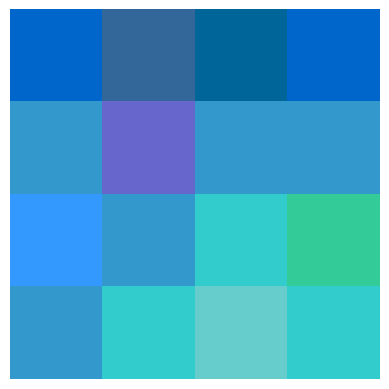

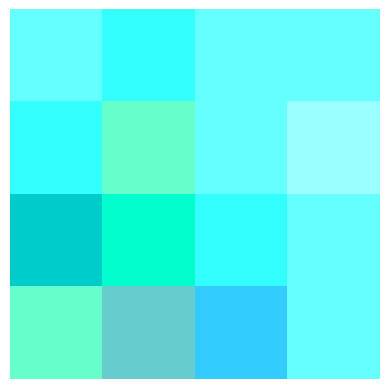

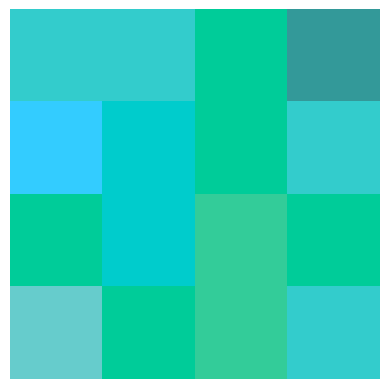

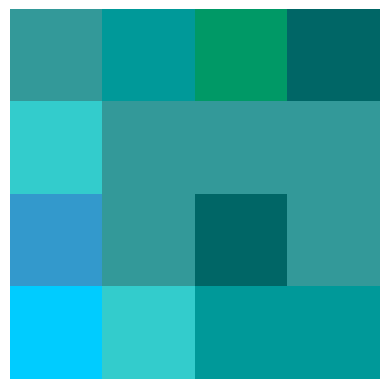

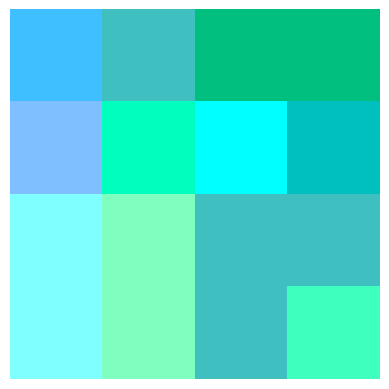

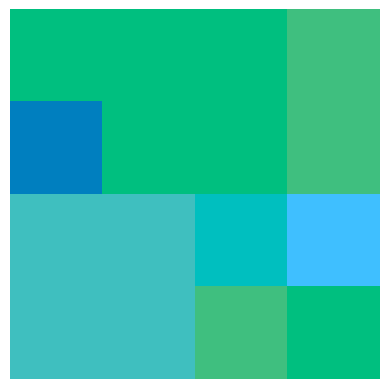

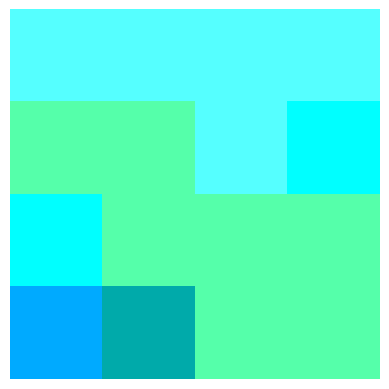

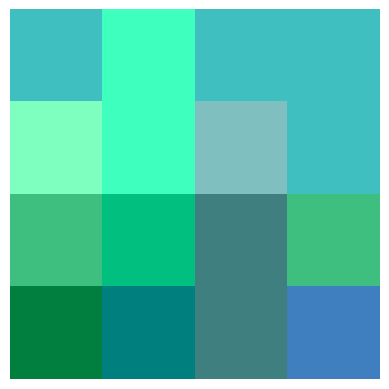

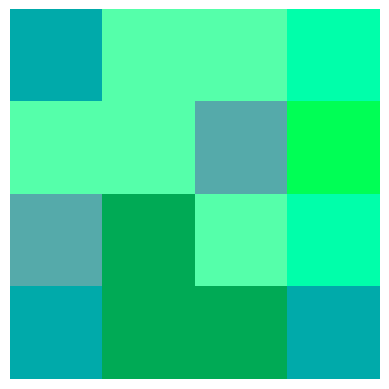

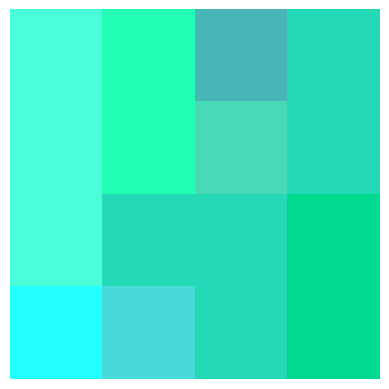

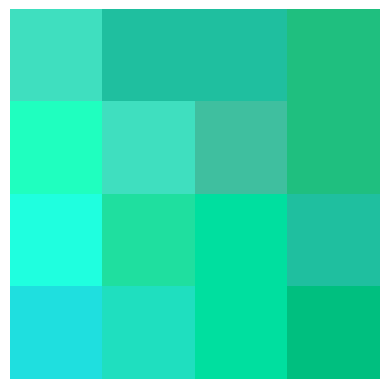

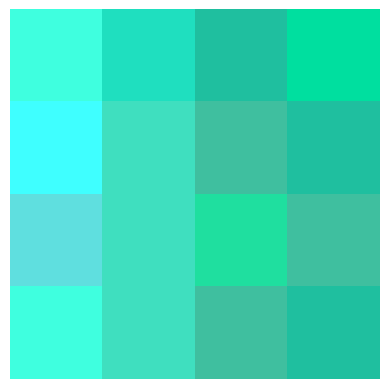

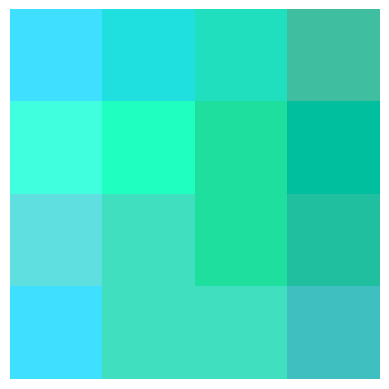

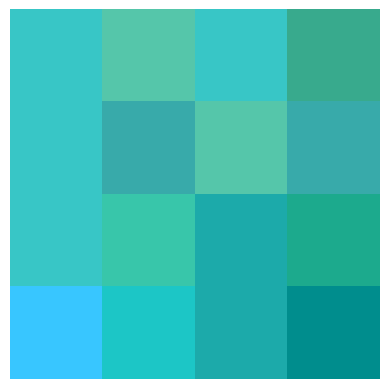

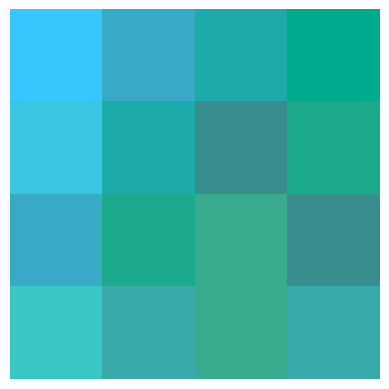

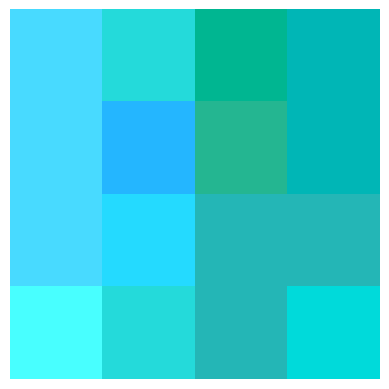

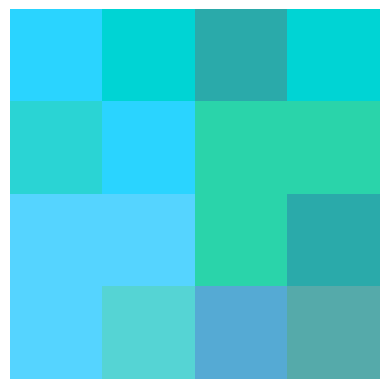

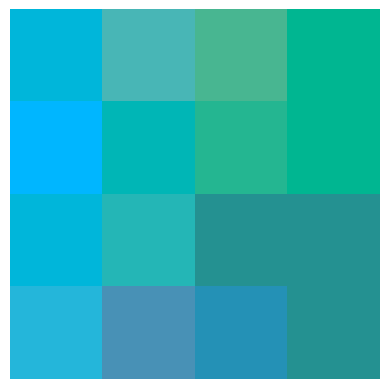

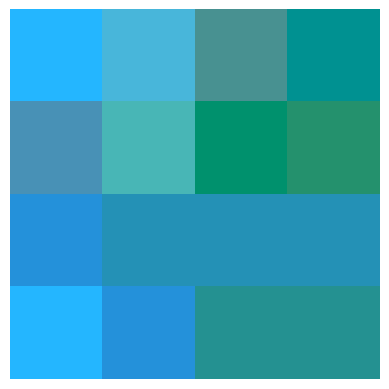

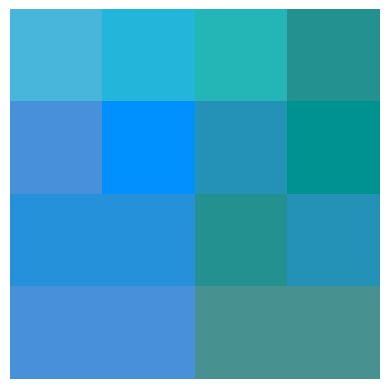

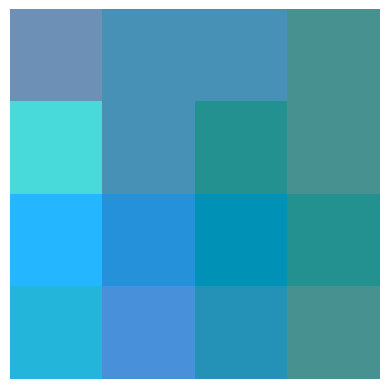

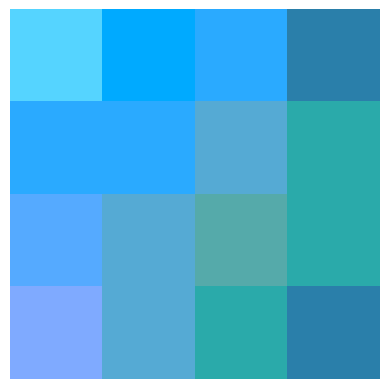

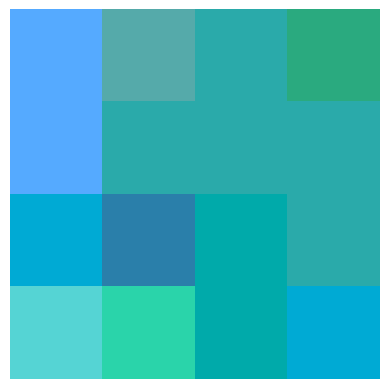

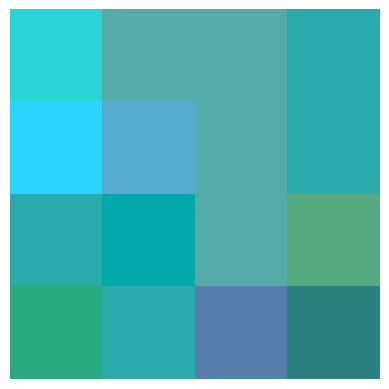

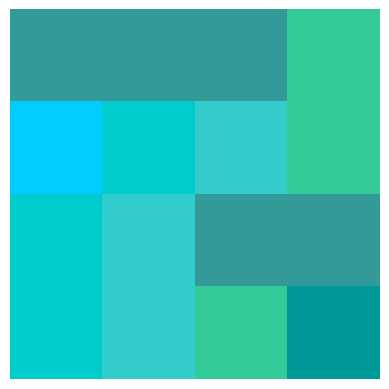

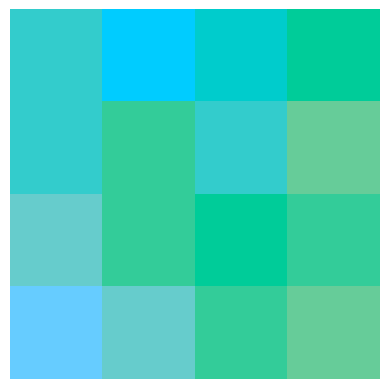

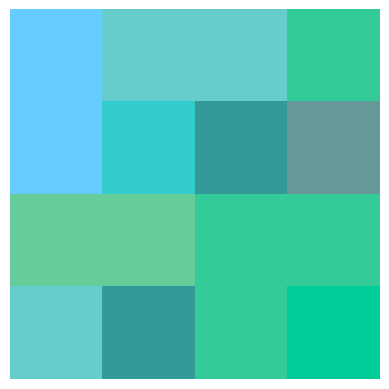

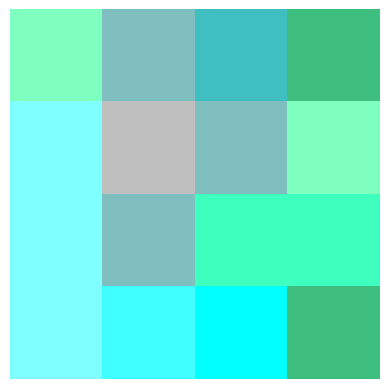

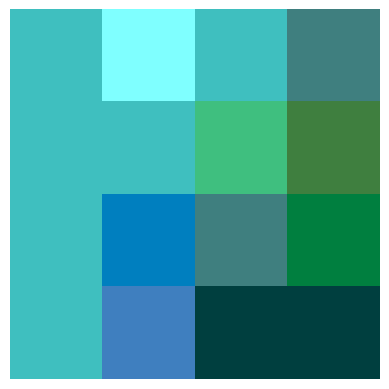

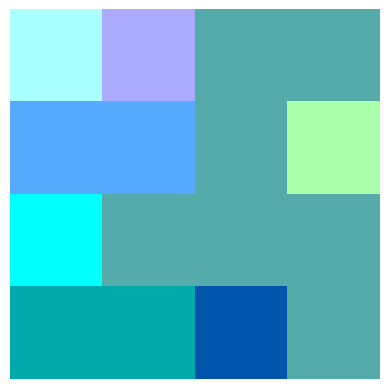

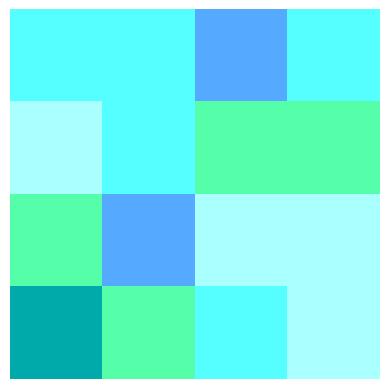

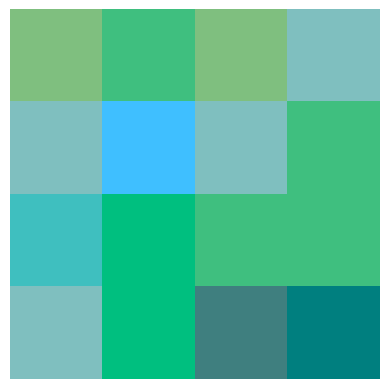

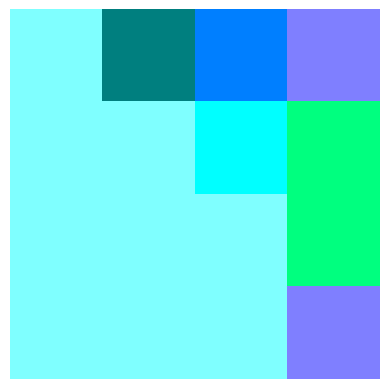

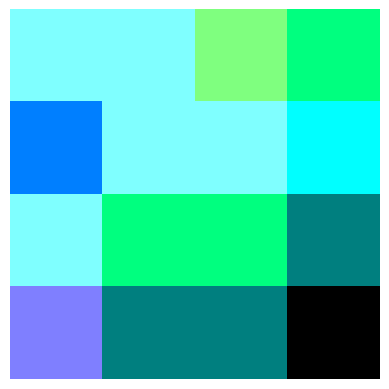

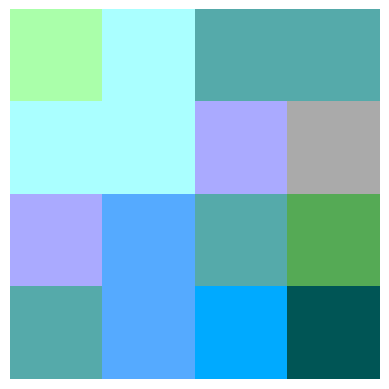

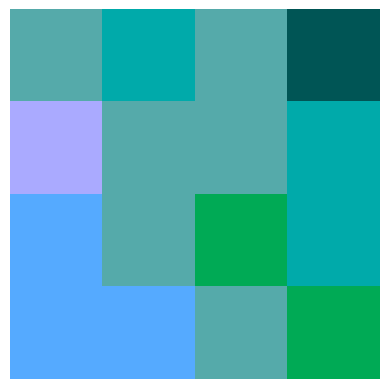

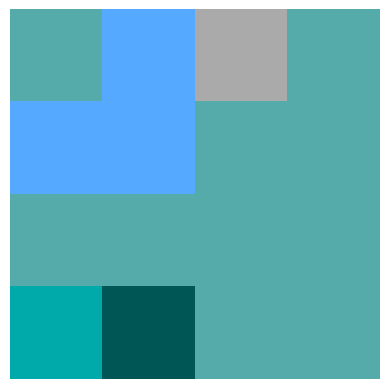

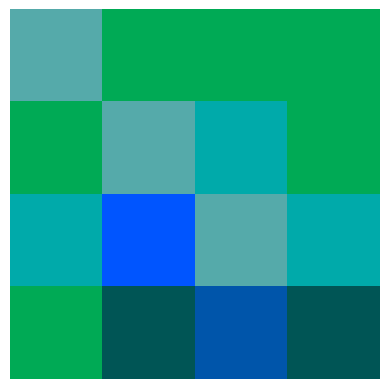

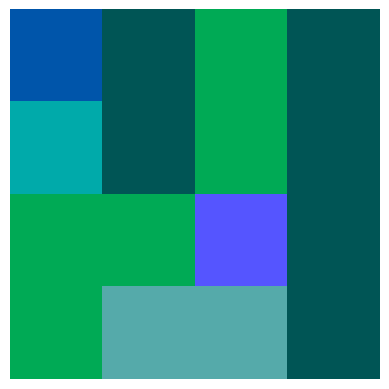

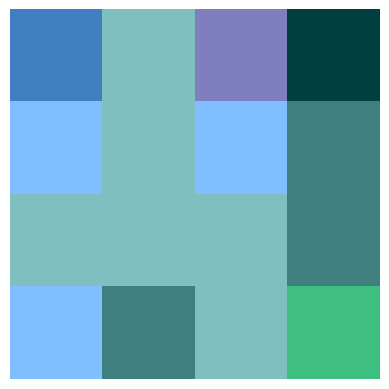

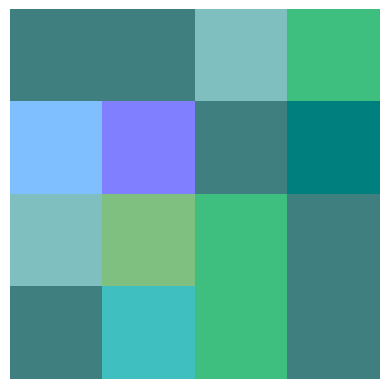

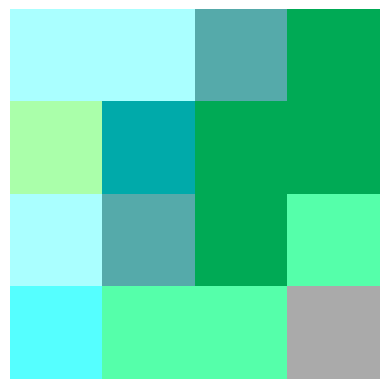

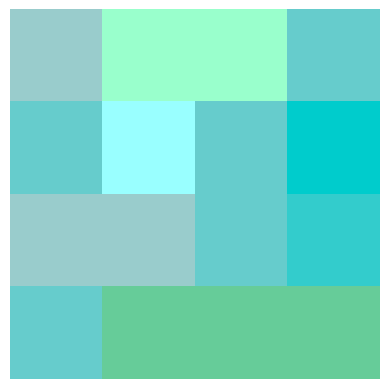

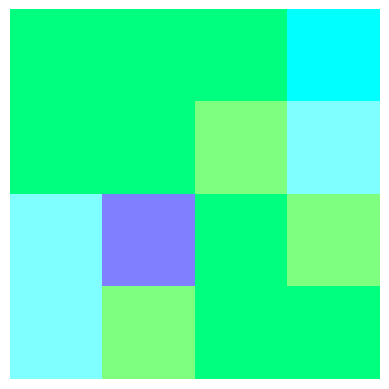

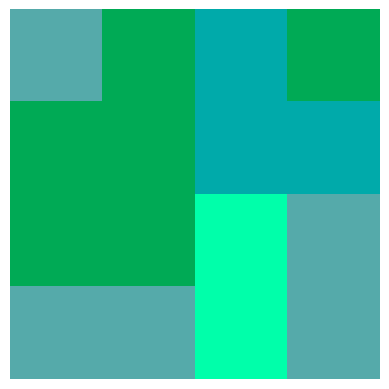

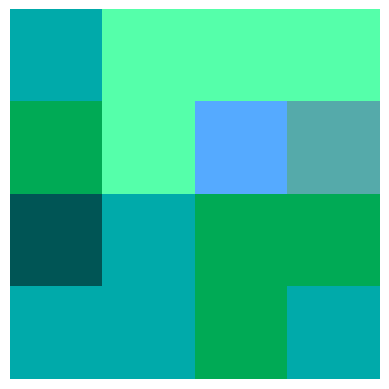

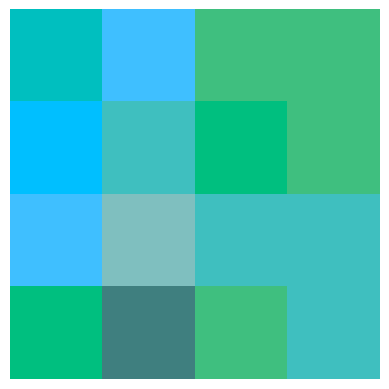

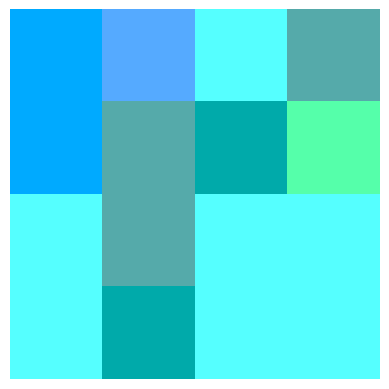

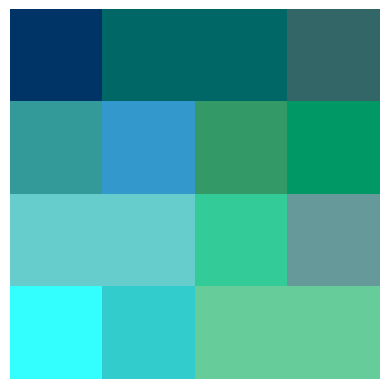

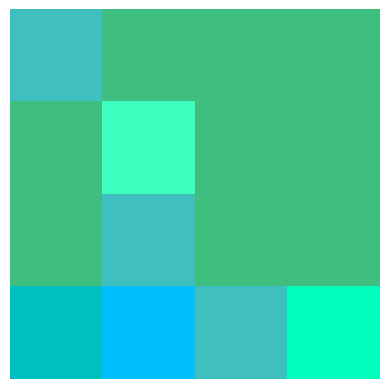

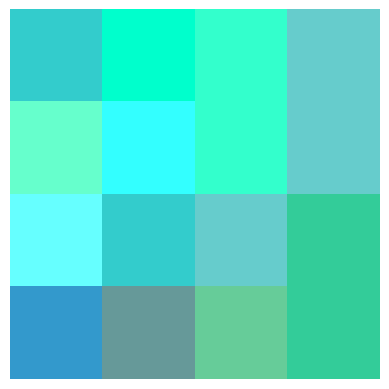

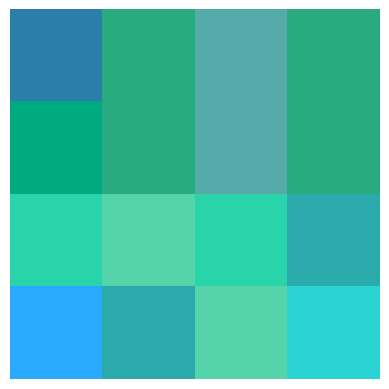

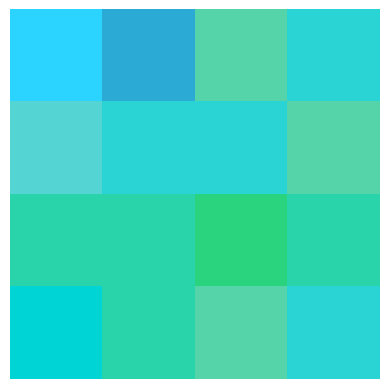

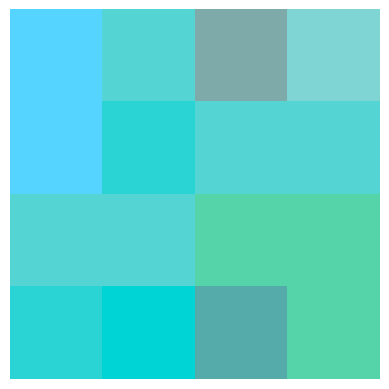

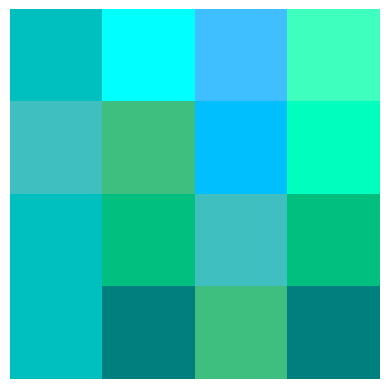

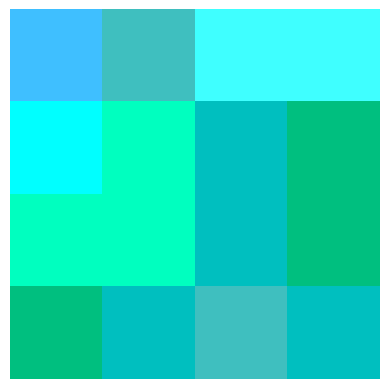

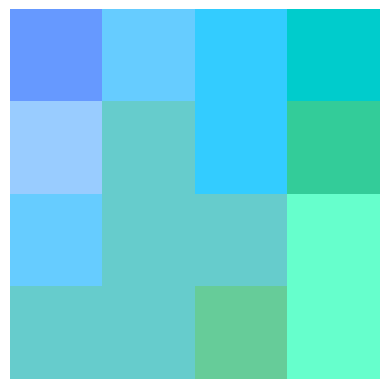

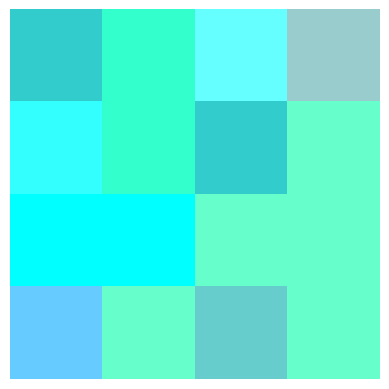

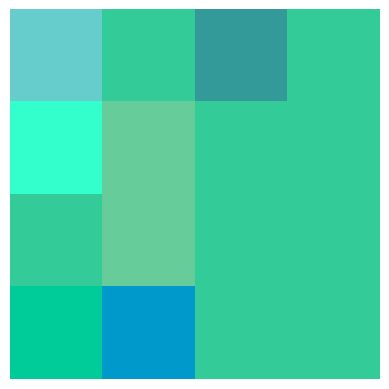

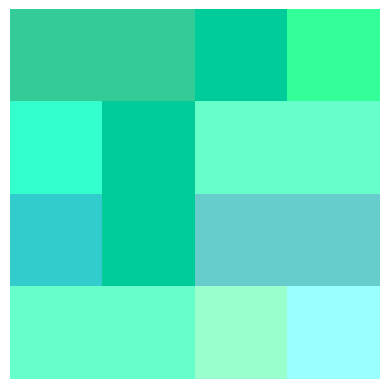

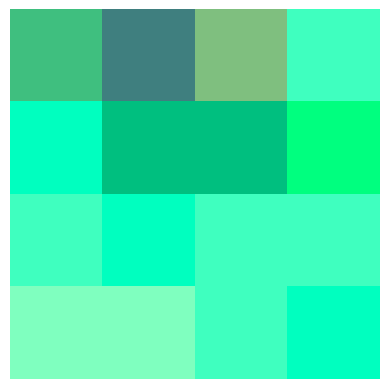

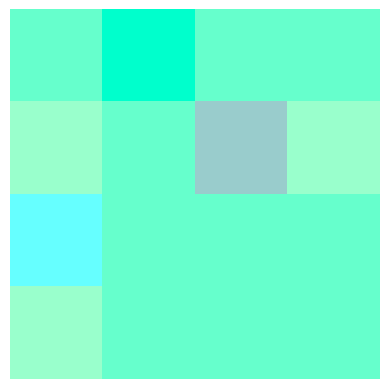

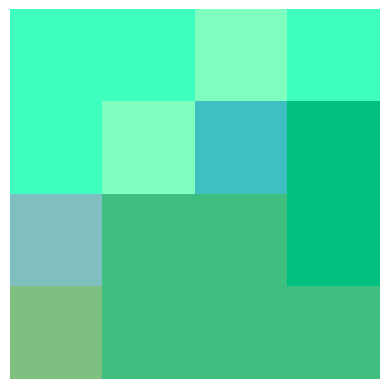

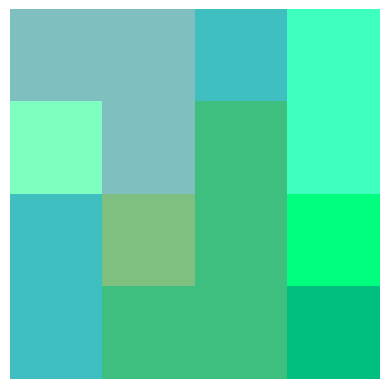

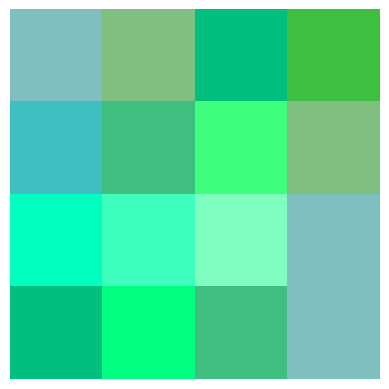

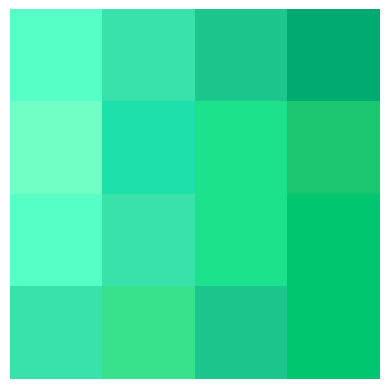

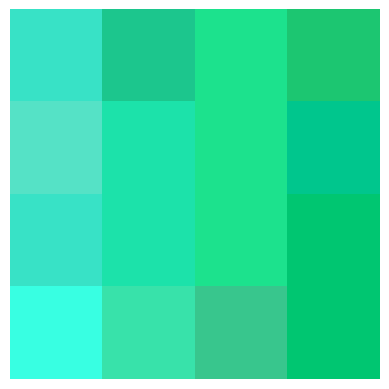

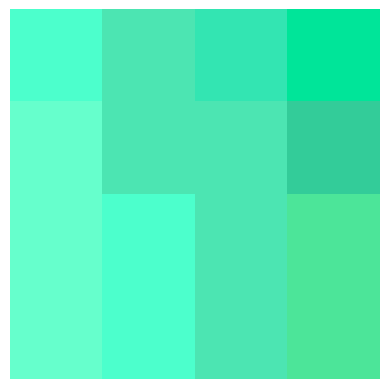

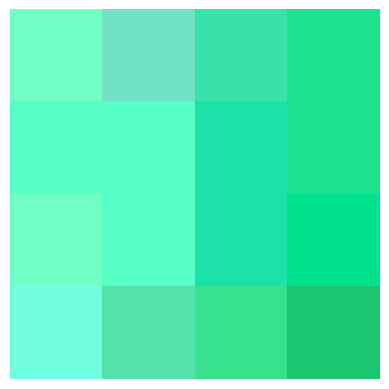

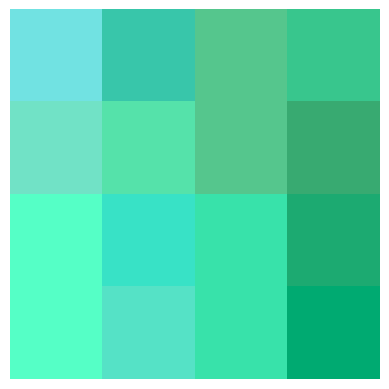

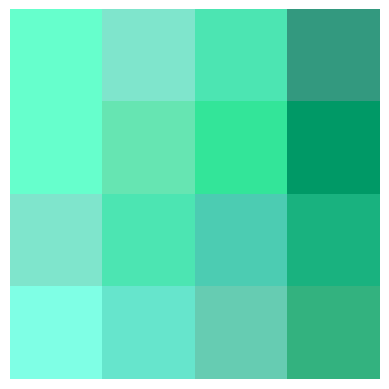

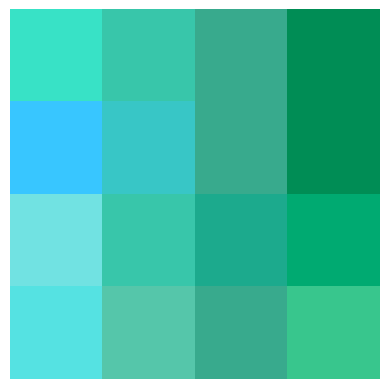

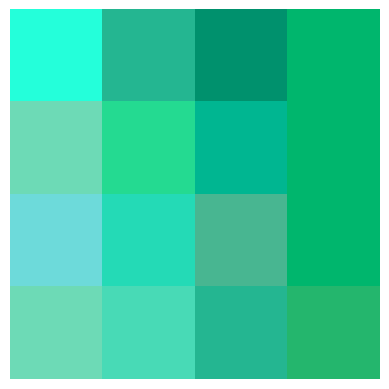

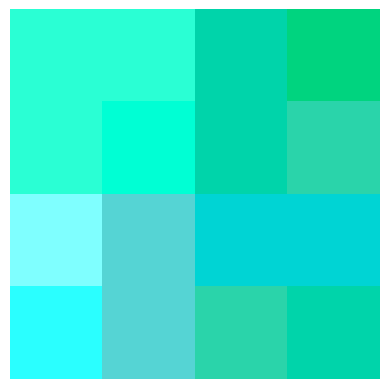

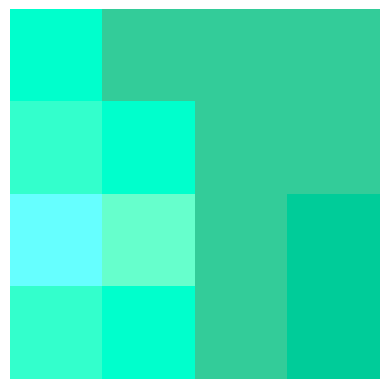

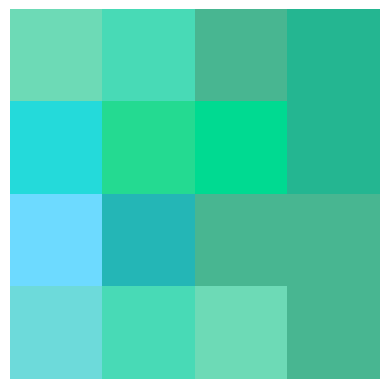

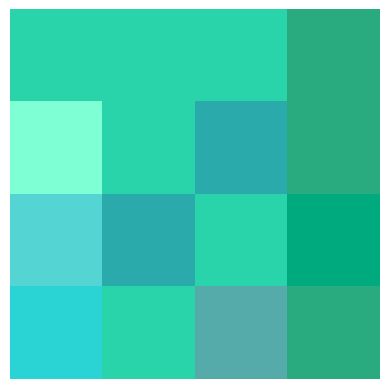

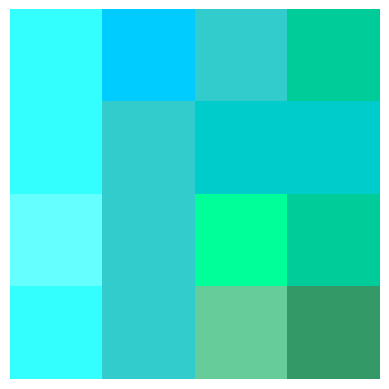

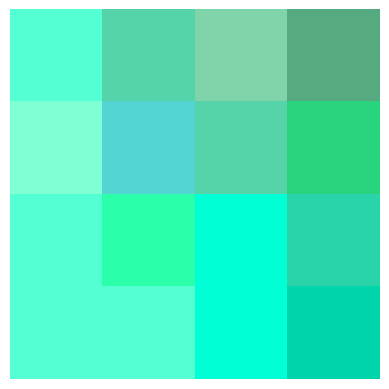

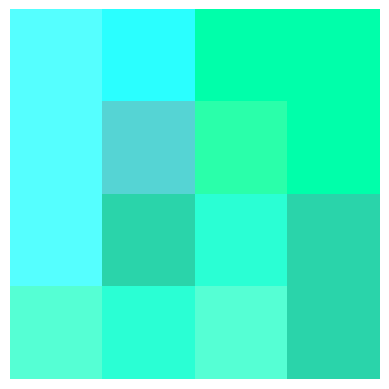

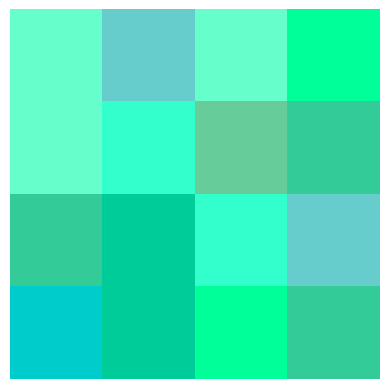

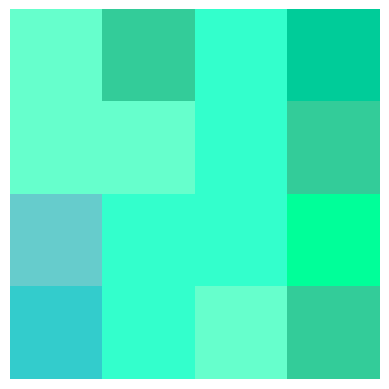

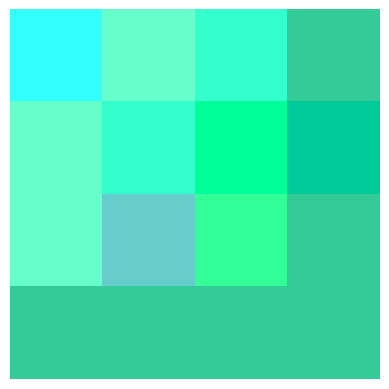

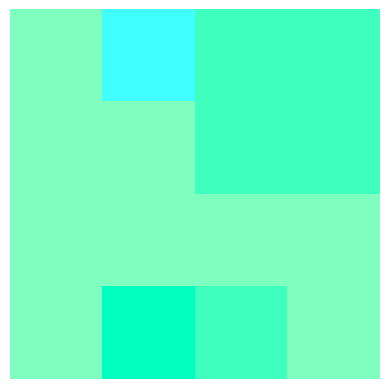

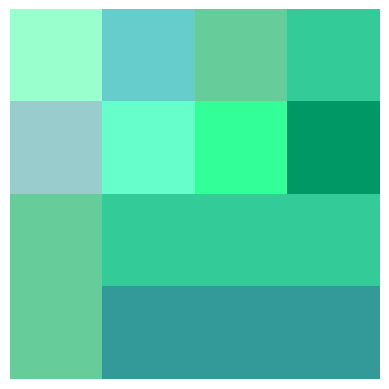

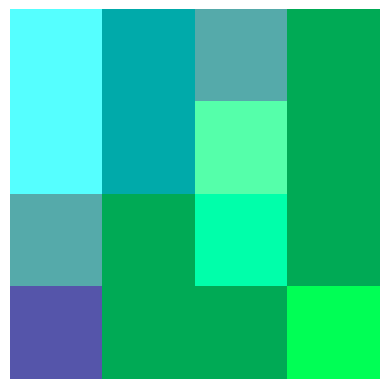

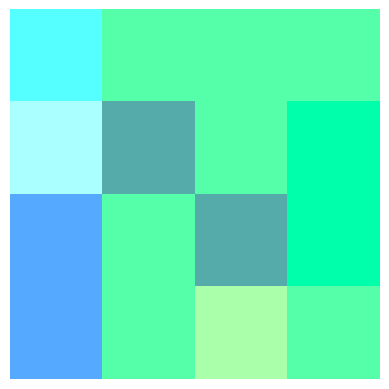

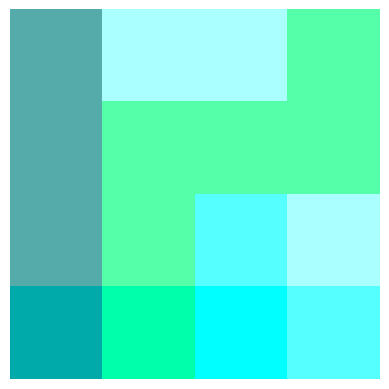

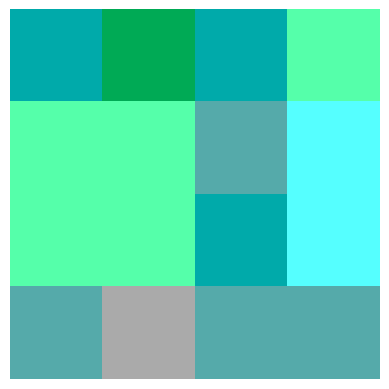

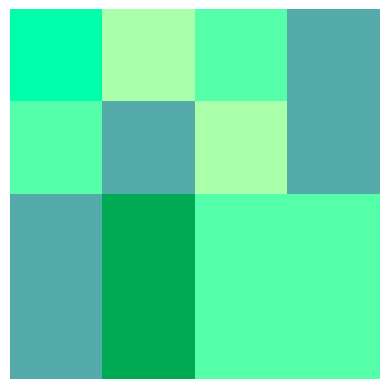

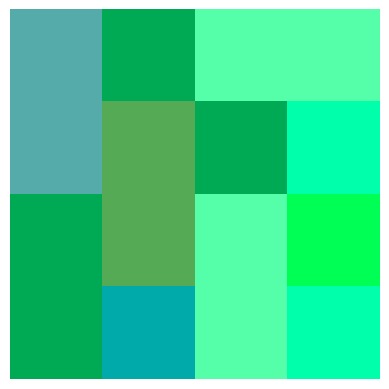

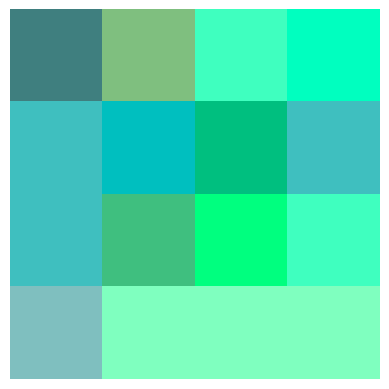

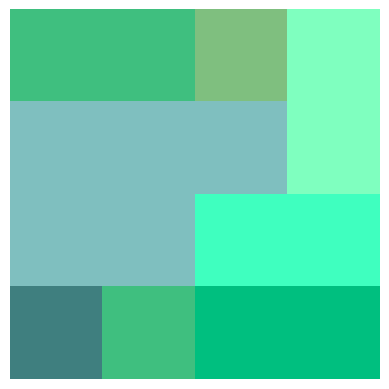

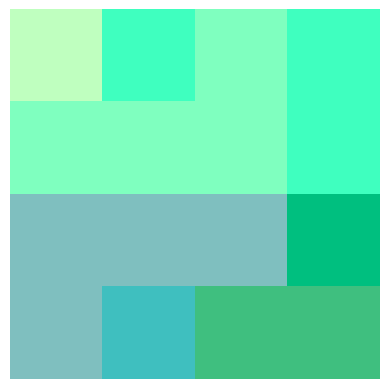

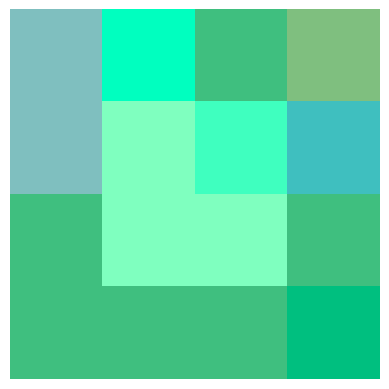

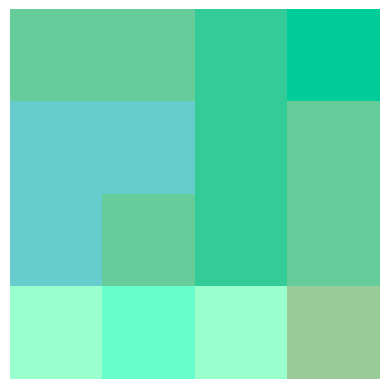

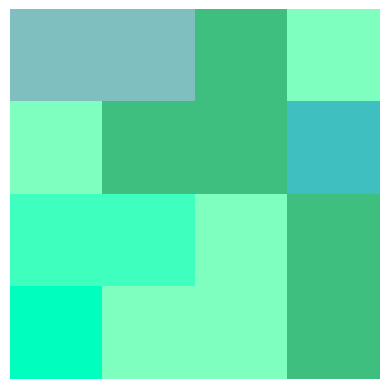

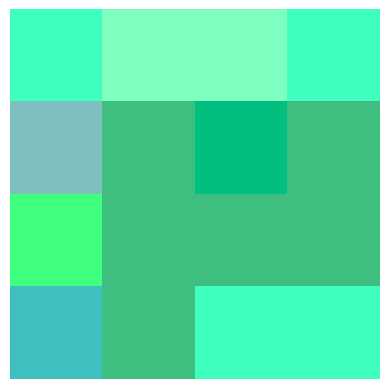

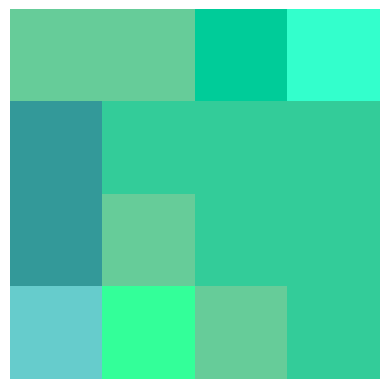

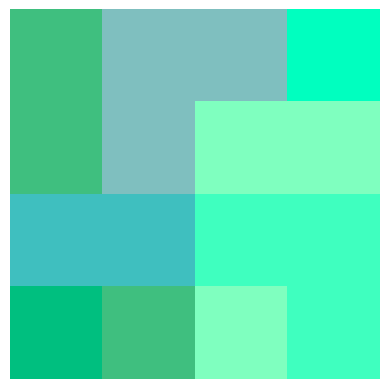

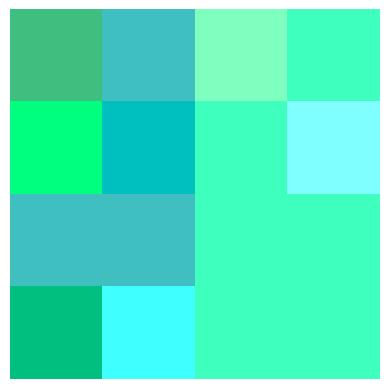

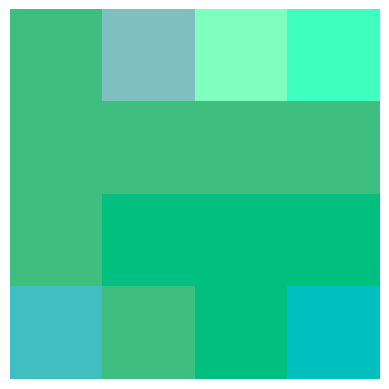

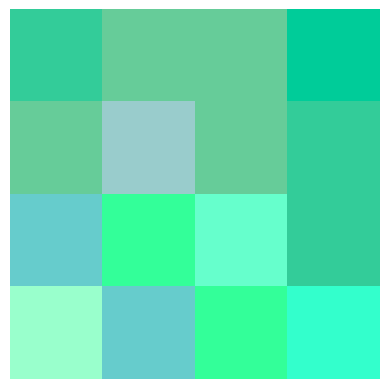

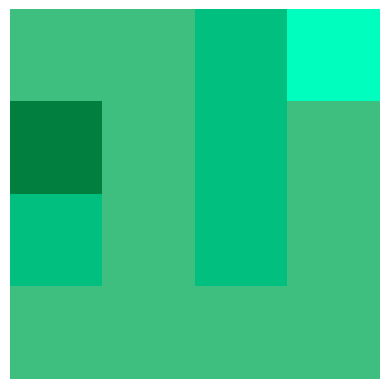

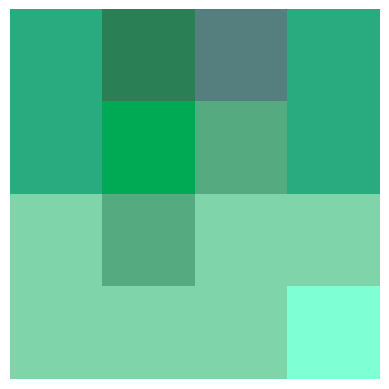

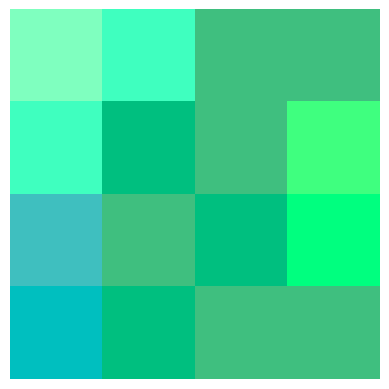

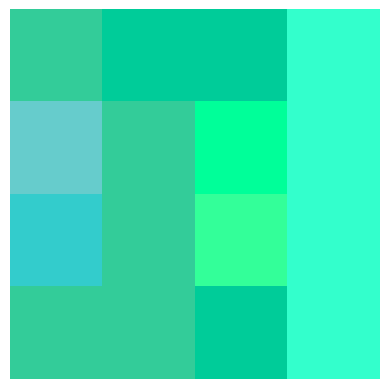

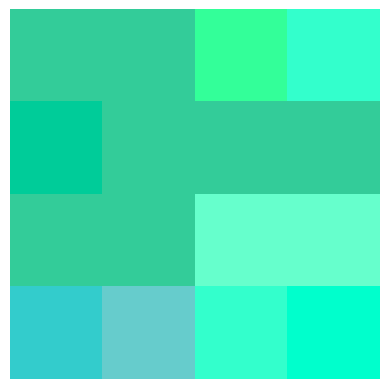

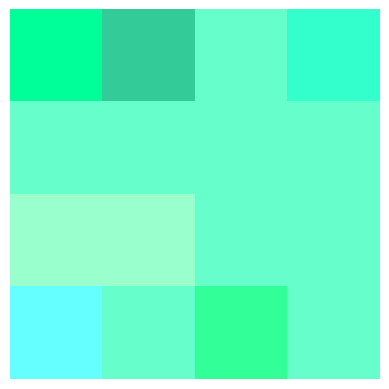

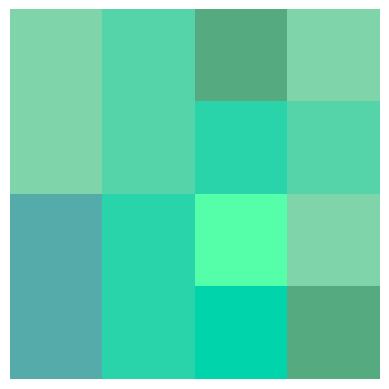

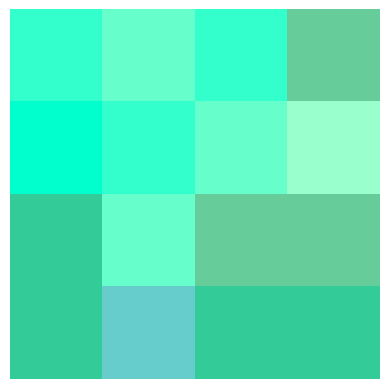

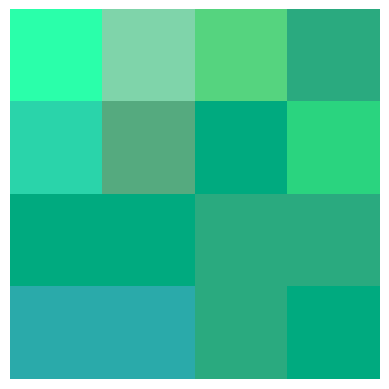

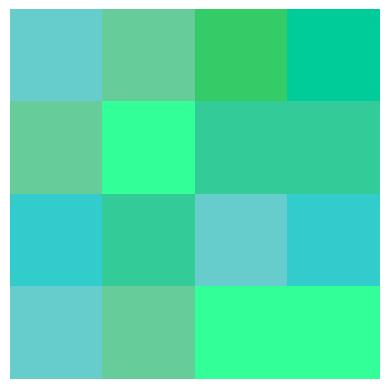

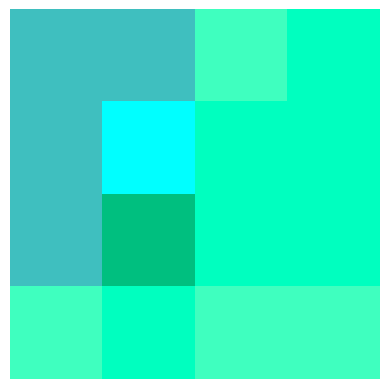

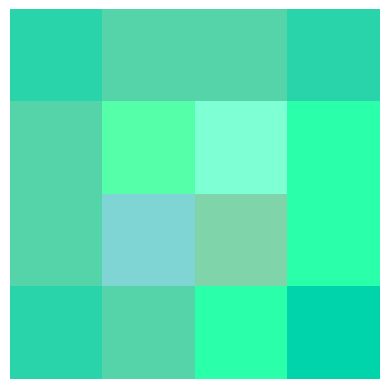

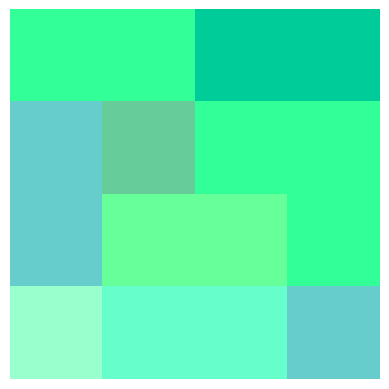

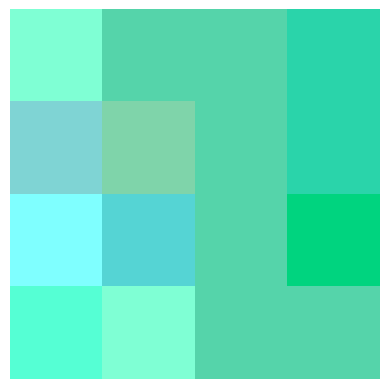

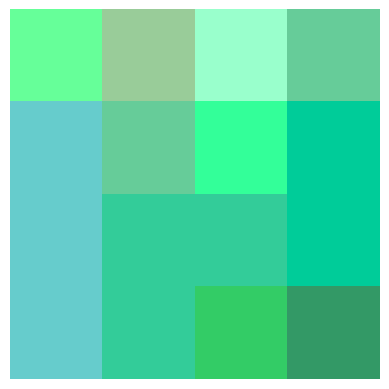

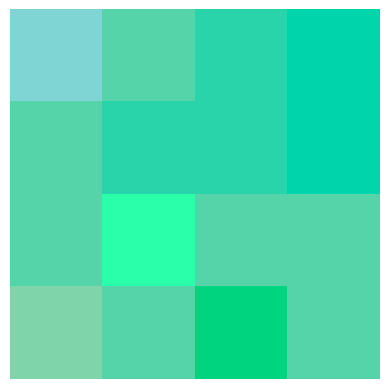

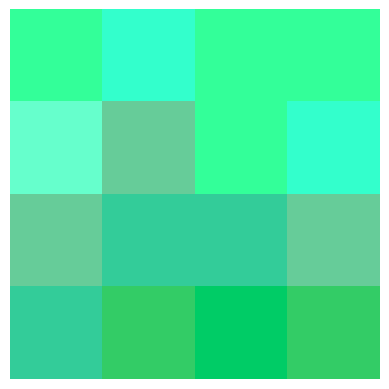

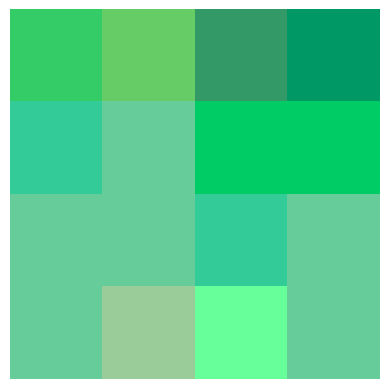

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window
    
    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)
    
    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()

In [6]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

In [7]:
# Load the image file
image_path = 'TEST.JPG'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[ 0.8830, -0.6499,  0.3837,  ..., -0.5495,  0.4247,  0.3797],
         [ 0.8963, -0.6688,  0.3942,  ..., -0.5644,  0.4283,  0.3957],
         [ 0.8943, -0.6600,  0.3841,  ..., -0.5500,  0.4272,  0.3913],
         ...,
         [ 0.7985, -0.5733,  0.3436,  ..., -0.5031,  0.3987,  0.3323],
         [ 0.7958, -0.5666,  0.3405,  ..., -0.5003,  0.3980,  0.3272],
         [ 0.7956, -0.5648,  0.3429,  ..., -0.5037,  0.4014,  0.3253]]],
       grad_fn=<TransposeBackward0>)

In [8]:
print("First patch embedding vector:", patches[0, 0])


First patch embedding vector: tensor([ 0.8830, -0.6499,  0.3837, -0.0728,  0.3796, -0.7599, -0.3038,  0.4875,
         0.4031, -0.3683, -0.6334,  0.6458, -0.1772,  0.4673, -0.2212, -0.4695,
        -0.0346,  0.2268,  0.2068,  0.2802,  0.2490, -0.7869, -0.1519,  0.5843,
         0.4937,  0.4189,  0.5830,  0.1205, -0.0269, -0.2742, -0.3182, -0.0509,
        -0.3475,  0.3018, -0.1013,  0.3983, -0.3475,  0.0373,  0.0350, -0.5458,
        -0.1650,  0.3706, -0.6278, -0.4180, -0.3965,  0.5481,  0.0291,  0.9233,
         0.1151,  0.6550, -0.1963, -0.4163, -0.7017,  0.0108,  0.5625,  0.0735,
        -0.2376, -0.4944,  0.0997, -0.1764,  0.0533,  0.4880,  0.0244,  0.5663,
         0.4815,  0.4787, -0.1563, -0.5657,  0.6472, -0.9578, -0.9232, -0.0347,
        -0.1817, -0.7973, -0.1996, -0.5028,  0.5875,  0.1045,  0.3661,  1.0291,
        -0.5832,  0.3049, -0.0437, -0.2597,  0.3996, -0.1464,  0.1954,  0.2696,
        -0.6051, -0.7143,  0.2861,  0.1995, -0.1031, -0.5495,  0.4247,  0.3797],
       gr

In [11]:
from swin_func_clas import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


d:\vit\vit\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[ 0.7491, -0.8281,  0.7477,  ..., -0.1147, -0.0540,  0.8215],
         [ 0.7660, -0.8483,  0.7610,  ..., -0.1221, -0.0550,  0.8433],
         [ 0.7664, -0.8402,  0.7515,  ..., -0.1075, -0.0564,  0.8363],
         ...,
         [ 0.6718, -0.7582,  0.7114,  ..., -0.0898, -0.0744,  0.7461],
         [ 0.6699, -0.7533,  0.7076,  ..., -0.0874, -0.0753,  0.7391],
         [ 0.6667, -0.7500,  0.7088,  ..., -0.0917, -0.0704,  0.7370]]],
       grad_fn=<AddBackward0>)

In [12]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape) 

Merged output shape: torch.Size([1, 784, 192])


In [13]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


In [14]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 1.0856, -1.2563,  0.3620,  ..., -0.3825,  0.9398,  0.0282],
         [ 1.1018, -1.2749,  0.3753,  ..., -0.3971,  0.9409,  0.0435],
         [ 1.1004, -1.2644,  0.3607,  ..., -0.3856,  0.9390,  0.0401],
         ...,
         [ 0.9956, -1.1663,  0.3274,  ..., -0.3371,  0.9065, -0.0409],
         [ 0.9935, -1.1595,  0.3242,  ..., -0.3348,  0.9060, -0.0455],
         [ 0.9923, -1.1585,  0.3269,  ..., -0.3372,  0.9099, -0.0485]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.8343, -0.9527, -0.1074,  ..., -0.7705,  0.9766,  0.8231],
         [ 0.8516, -0.9749, -0.0957,  ..., -0.7860,  0.9815,  0.8422],
         [ 0.8516, -0.9656, -0.1086,  ..., -0.7722,  0.9803,  0.8355],
         ...,
         [ 0.7077, -0.8505, -0.1600,  ..., -0.7057,  0.9386,  0.7687],
         [ 0.7044, -0.8431, -0.1632,  ..., -0.7027,  0.9379,  0.7647],
         [ 0.7034, -0.8420, -0.1600,  ..., -0.7064,  0.9417,  0.7608]]],
       grad_fn=<AddBackward0>)


In [15]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [18]:
import os

# Get the current working directory

train_dir = r'D:\vit\fish_data\train'
test_dir = r'D:\vit\fish_data\test'


In [19]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [20]:

# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [21]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x19d1f822ee0>,
 ['catla', 'common-carp', 'grass-carp', 'mori', 'rohu', 'silver-carp'])

torch.Size([3, 224, 224]) tensor(3)


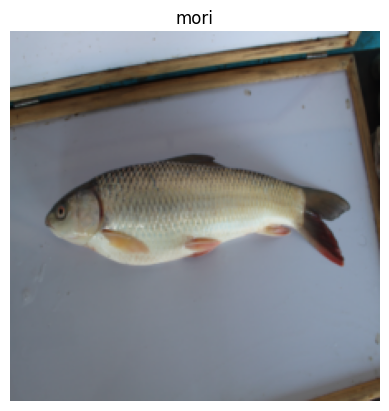

In [22]:

# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [23]:
model = SwinTransformer(num_classes=len(class_names))

In [26]:
from going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)

  1%|          | 1/100 [00:19<32:15, 19.55s/it]

Epoch: 1 | train_loss: 3.2113 | train_acc: 0.1701 | test_loss: 3.0786 | test_acc: 0.2188


  2%|▏         | 2/100 [00:39<31:59, 19.59s/it]

Epoch: 2 | train_loss: 2.7715 | train_acc: 0.1667 | test_loss: 2.2737 | test_acc: 0.1562


  3%|▎         | 3/100 [00:58<31:40, 19.59s/it]

Epoch: 3 | train_loss: 2.2654 | train_acc: 0.2587 | test_loss: 1.8141 | test_acc: 0.3267


  4%|▍         | 4/100 [01:18<31:13, 19.51s/it]

Epoch: 4 | train_loss: 2.0275 | train_acc: 0.2031 | test_loss: 1.8011 | test_acc: 0.2045


  5%|▌         | 5/100 [01:37<30:43, 19.40s/it]

Epoch: 5 | train_loss: 1.9950 | train_acc: 0.2188 | test_loss: 3.8663 | test_acc: 0.0625


  6%|▌         | 6/100 [01:56<30:29, 19.47s/it]

Epoch: 6 | train_loss: 2.0430 | train_acc: 0.2222 | test_loss: 1.6341 | test_acc: 0.3267


  7%|▋         | 7/100 [02:16<30:07, 19.43s/it]

Epoch: 7 | train_loss: 1.7143 | train_acc: 0.2535 | test_loss: 1.6458 | test_acc: 0.2188


  8%|▊         | 8/100 [02:35<29:46, 19.42s/it]

Epoch: 8 | train_loss: 1.7768 | train_acc: 0.2326 | test_loss: 1.8274 | test_acc: 0.0625


  9%|▉         | 9/100 [02:54<29:21, 19.36s/it]

Epoch: 9 | train_loss: 1.7441 | train_acc: 0.1719 | test_loss: 1.6885 | test_acc: 0.2045


 10%|█         | 10/100 [03:14<29:08, 19.42s/it]

Epoch: 10 | train_loss: 1.8183 | train_acc: 0.1510 | test_loss: 2.7398 | test_acc: 0.0312


 11%|█         | 11/100 [03:34<28:53, 19.48s/it]

Epoch: 11 | train_loss: 1.8434 | train_acc: 0.2170 | test_loss: 1.6854 | test_acc: 0.2188


 12%|█▏        | 12/100 [03:53<28:37, 19.52s/it]

Epoch: 12 | train_loss: 1.7373 | train_acc: 0.2014 | test_loss: 1.7241 | test_acc: 0.2188


 13%|█▎        | 13/100 [04:13<28:29, 19.65s/it]

Epoch: 13 | train_loss: 1.7875 | train_acc: 0.2292 | test_loss: 4.3673 | test_acc: 0.0312


 14%|█▍        | 14/100 [04:32<27:58, 19.52s/it]

Epoch: 14 | train_loss: 2.4160 | train_acc: 0.1198 | test_loss: 2.0950 | test_acc: 0.0312


 15%|█▌        | 15/100 [04:52<27:30, 19.42s/it]

Epoch: 15 | train_loss: 1.7637 | train_acc: 0.1562 | test_loss: 1.6943 | test_acc: 0.2045


 16%|█▌        | 16/100 [05:11<27:15, 19.47s/it]

Epoch: 16 | train_loss: 1.8231 | train_acc: 0.1458 | test_loss: 1.6156 | test_acc: 0.3267


 17%|█▋        | 17/100 [05:31<26:58, 19.50s/it]

Epoch: 17 | train_loss: 1.7629 | train_acc: 0.2795 | test_loss: 1.7602 | test_acc: 0.3267


 18%|█▊        | 18/100 [05:50<26:42, 19.54s/it]

Epoch: 18 | train_loss: 1.7287 | train_acc: 0.1771 | test_loss: 1.8732 | test_acc: 0.2045


 19%|█▉        | 19/100 [06:10<26:23, 19.55s/it]

Epoch: 19 | train_loss: 1.6822 | train_acc: 0.3351 | test_loss: 1.6541 | test_acc: 0.3267


 20%|██        | 20/100 [06:30<26:05, 19.57s/it]

Epoch: 20 | train_loss: 1.6746 | train_acc: 0.2951 | test_loss: 1.7537 | test_acc: 0.2188


 21%|██        | 21/100 [06:49<25:46, 19.57s/it]

Epoch: 21 | train_loss: 1.7554 | train_acc: 0.2587 | test_loss: 1.6349 | test_acc: 0.3267


 22%|██▏       | 22/100 [07:09<25:32, 19.64s/it]

Epoch: 22 | train_loss: 1.6540 | train_acc: 0.2188 | test_loss: 1.6919 | test_acc: 0.2188


 23%|██▎       | 23/100 [07:29<25:11, 19.63s/it]

Epoch: 23 | train_loss: 1.7531 | train_acc: 0.3142 | test_loss: 1.6893 | test_acc: 0.2188


 24%|██▍       | 24/100 [07:48<24:55, 19.68s/it]

Epoch: 24 | train_loss: 1.6787 | train_acc: 0.3247 | test_loss: 1.6225 | test_acc: 0.3267


 25%|██▌       | 25/100 [08:08<24:37, 19.71s/it]

Epoch: 25 | train_loss: 1.7461 | train_acc: 0.2552 | test_loss: 2.1302 | test_acc: 0.0312


 26%|██▌       | 26/100 [08:27<24:11, 19.61s/it]

Epoch: 26 | train_loss: 1.8310 | train_acc: 0.2118 | test_loss: 1.6573 | test_acc: 0.3267


 27%|██▋       | 27/100 [08:46<23:38, 19.43s/it]

Epoch: 27 | train_loss: 1.6866 | train_acc: 0.2778 | test_loss: 1.6805 | test_acc: 0.2188


 28%|██▊       | 28/100 [09:06<23:17, 19.42s/it]

Epoch: 28 | train_loss: 1.6548 | train_acc: 0.2639 | test_loss: 1.6595 | test_acc: 0.2188


 29%|██▉       | 29/100 [09:25<23:02, 19.47s/it]

Epoch: 29 | train_loss: 1.7582 | train_acc: 0.2188 | test_loss: 1.6180 | test_acc: 0.3267


 30%|███       | 30/100 [09:45<22:45, 19.51s/it]

Epoch: 30 | train_loss: 1.6846 | train_acc: 0.2743 | test_loss: 1.6249 | test_acc: 0.3267


 31%|███       | 31/100 [10:04<22:23, 19.47s/it]

Epoch: 31 | train_loss: 1.6460 | train_acc: 0.2240 | test_loss: 1.8191 | test_acc: 0.2045


 32%|███▏      | 32/100 [10:24<22:02, 19.45s/it]

Epoch: 32 | train_loss: 1.8027 | train_acc: 0.1302 | test_loss: 1.6121 | test_acc: 0.3267


 33%|███▎      | 33/100 [10:43<21:45, 19.49s/it]

Epoch: 33 | train_loss: 1.7599 | train_acc: 0.2240 | test_loss: 1.6001 | test_acc: 0.3267


 34%|███▍      | 34/100 [11:03<21:28, 19.52s/it]

Epoch: 34 | train_loss: 1.7182 | train_acc: 0.2847 | test_loss: 1.9880 | test_acc: 0.2045


 35%|███▌      | 35/100 [11:22<21:07, 19.49s/it]

Epoch: 35 | train_loss: 1.7955 | train_acc: 0.2934 | test_loss: 1.7659 | test_acc: 0.2188


 36%|███▌      | 36/100 [11:42<20:49, 19.52s/it]

Epoch: 36 | train_loss: 1.7282 | train_acc: 0.2587 | test_loss: 1.7559 | test_acc: 0.2045


 37%|███▋      | 37/100 [12:01<20:27, 19.48s/it]

Epoch: 37 | train_loss: 1.6516 | train_acc: 0.2674 | test_loss: 1.6370 | test_acc: 0.3267


 38%|███▊      | 38/100 [12:21<20:09, 19.51s/it]

Epoch: 38 | train_loss: 1.7404 | train_acc: 0.2188 | test_loss: 1.6986 | test_acc: 0.2045


 39%|███▉      | 39/100 [12:41<19:51, 19.54s/it]

Epoch: 39 | train_loss: 1.7243 | train_acc: 0.1667 | test_loss: 1.6676 | test_acc: 0.2188


 40%|████      | 40/100 [13:00<19:36, 19.62s/it]

Epoch: 40 | train_loss: 1.6499 | train_acc: 0.2882 | test_loss: 1.5967 | test_acc: 0.3267


 41%|████      | 41/100 [13:20<19:13, 19.55s/it]

Epoch: 41 | train_loss: 1.6428 | train_acc: 0.3247 | test_loss: 1.7161 | test_acc: 0.3267


 42%|████▏     | 42/100 [13:39<18:51, 19.50s/it]

Epoch: 42 | train_loss: 1.7297 | train_acc: 0.2743 | test_loss: 1.7909 | test_acc: 0.2045


 43%|████▎     | 43/100 [13:59<18:29, 19.47s/it]

Epoch: 43 | train_loss: 1.7781 | train_acc: 0.1667 | test_loss: 1.6392 | test_acc: 0.3267


 44%|████▍     | 44/100 [14:18<18:05, 19.38s/it]

Epoch: 44 | train_loss: 1.7026 | train_acc: 0.2743 | test_loss: 1.7737 | test_acc: 0.3267


 45%|████▌     | 45/100 [14:37<17:46, 19.39s/it]

Epoch: 45 | train_loss: 1.7486 | train_acc: 0.2240 | test_loss: 1.8219 | test_acc: 0.0312


 46%|████▌     | 46/100 [14:57<17:33, 19.51s/it]

Epoch: 46 | train_loss: 1.7377 | train_acc: 0.1927 | test_loss: 1.7328 | test_acc: 0.3267


 47%|████▋     | 47/100 [15:17<17:15, 19.53s/it]

Epoch: 47 | train_loss: 1.6539 | train_acc: 0.2743 | test_loss: 1.6426 | test_acc: 0.2188


 48%|████▊     | 48/100 [15:36<16:53, 19.49s/it]

Epoch: 48 | train_loss: 1.6514 | train_acc: 0.2083 | test_loss: 1.6355 | test_acc: 0.2188


 49%|████▉     | 49/100 [15:56<16:36, 19.53s/it]

Epoch: 49 | train_loss: 1.6982 | train_acc: 0.2240 | test_loss: 1.8791 | test_acc: 0.0312


 50%|█████     | 50/100 [16:15<16:17, 19.54s/it]

Epoch: 50 | train_loss: 1.7459 | train_acc: 0.1250 | test_loss: 1.6186 | test_acc: 0.2188


 51%|█████     | 51/100 [16:35<15:58, 19.56s/it]

Epoch: 51 | train_loss: 1.6418 | train_acc: 0.2240 | test_loss: 1.6449 | test_acc: 0.2188


 52%|█████▏    | 52/100 [16:54<15:36, 19.51s/it]

Epoch: 52 | train_loss: 1.7827 | train_acc: 0.1875 | test_loss: 1.8607 | test_acc: 0.2188


 53%|█████▎    | 53/100 [17:14<15:15, 19.47s/it]

Epoch: 53 | train_loss: 1.7363 | train_acc: 0.2344 | test_loss: 1.6314 | test_acc: 0.3267


 54%|█████▍    | 54/100 [17:33<14:57, 19.51s/it]

Epoch: 54 | train_loss: 1.6451 | train_acc: 0.2674 | test_loss: 1.6505 | test_acc: 0.2188


 55%|█████▌    | 55/100 [17:53<14:36, 19.48s/it]

Epoch: 55 | train_loss: 1.6407 | train_acc: 0.2031 | test_loss: 1.6646 | test_acc: 0.1562


 56%|█████▌    | 56/100 [18:12<14:13, 19.39s/it]

Epoch: 56 | train_loss: 1.6645 | train_acc: 0.2535 | test_loss: 1.6471 | test_acc: 0.2188


 57%|█████▋    | 57/100 [18:31<13:53, 19.39s/it]

Epoch: 57 | train_loss: 1.6767 | train_acc: 0.2188 | test_loss: 1.6332 | test_acc: 0.3267


 58%|█████▊    | 58/100 [18:51<13:34, 19.40s/it]

Epoch: 58 | train_loss: 1.7243 | train_acc: 0.2240 | test_loss: 1.6343 | test_acc: 0.3267


 59%|█████▉    | 59/100 [19:10<13:15, 19.39s/it]

Epoch: 59 | train_loss: 1.6653 | train_acc: 0.2743 | test_loss: 1.6176 | test_acc: 0.3267


 60%|██████    | 60/100 [19:29<12:57, 19.43s/it]

Epoch: 60 | train_loss: 1.6697 | train_acc: 0.2240 | test_loss: 1.6256 | test_acc: 0.3267


 61%|██████    | 61/100 [19:49<12:38, 19.44s/it]

Epoch: 61 | train_loss: 1.6541 | train_acc: 0.2795 | test_loss: 1.6612 | test_acc: 0.2188


 62%|██████▏   | 62/100 [20:08<12:18, 19.43s/it]

Epoch: 62 | train_loss: 1.6908 | train_acc: 0.1979 | test_loss: 1.6512 | test_acc: 0.3267


 63%|██████▎   | 63/100 [20:28<12:00, 19.48s/it]

Epoch: 63 | train_loss: 1.7050 | train_acc: 0.2240 | test_loss: 1.6329 | test_acc: 0.3267


 64%|██████▍   | 64/100 [20:47<11:40, 19.45s/it]

Epoch: 64 | train_loss: 1.6309 | train_acc: 0.3351 | test_loss: 1.7107 | test_acc: 0.1562


 65%|██████▌   | 65/100 [21:07<11:22, 19.50s/it]

Epoch: 65 | train_loss: 1.7193 | train_acc: 0.1562 | test_loss: 1.6573 | test_acc: 0.3267


 66%|██████▌   | 66/100 [21:26<10:59, 19.40s/it]

Epoch: 66 | train_loss: 1.6320 | train_acc: 0.3351 | test_loss: 1.6406 | test_acc: 0.2188


 67%|██████▋   | 67/100 [21:46<10:43, 19.51s/it]

Epoch: 67 | train_loss: 1.6195 | train_acc: 0.3194 | test_loss: 1.6522 | test_acc: 0.2188


 68%|██████▊   | 68/100 [22:05<10:23, 19.48s/it]

Epoch: 68 | train_loss: 1.6518 | train_acc: 0.2188 | test_loss: 1.6324 | test_acc: 0.2188


 69%|██████▉   | 69/100 [22:25<10:05, 19.52s/it]

Epoch: 69 | train_loss: 1.6104 | train_acc: 0.2691 | test_loss: 1.6282 | test_acc: 0.3267


 70%|███████   | 70/100 [22:44<09:44, 19.48s/it]

Epoch: 70 | train_loss: 1.6651 | train_acc: 0.2344 | test_loss: 1.6159 | test_acc: 0.3267


 71%|███████   | 71/100 [23:04<09:27, 19.57s/it]

Epoch: 71 | train_loss: 1.7137 | train_acc: 0.2031 | test_loss: 1.6344 | test_acc: 0.3267


 72%|███████▏  | 72/100 [23:24<09:09, 19.64s/it]

Epoch: 72 | train_loss: 1.6597 | train_acc: 0.2240 | test_loss: 1.6270 | test_acc: 0.2188


 73%|███████▎  | 73/100 [23:43<08:48, 19.56s/it]

Epoch: 73 | train_loss: 1.6360 | train_acc: 0.2691 | test_loss: 1.6231 | test_acc: 0.2188


 74%|███████▍  | 74/100 [24:02<08:25, 19.46s/it]

Epoch: 74 | train_loss: 1.6509 | train_acc: 0.2188 | test_loss: 1.6218 | test_acc: 0.2188


 75%|███████▌  | 75/100 [24:22<08:07, 19.50s/it]

Epoch: 75 | train_loss: 1.6172 | train_acc: 0.2691 | test_loss: 1.6442 | test_acc: 0.3267


 76%|███████▌  | 76/100 [24:42<07:48, 19.52s/it]

Epoch: 76 | train_loss: 1.6659 | train_acc: 0.2743 | test_loss: 1.6164 | test_acc: 0.3267


 77%|███████▋  | 77/100 [25:01<07:28, 19.48s/it]

Epoch: 77 | train_loss: 1.6236 | train_acc: 0.3194 | test_loss: 1.6125 | test_acc: 0.3267


 78%|███████▊  | 78/100 [25:20<07:05, 19.34s/it]

Epoch: 78 | train_loss: 1.6439 | train_acc: 0.2240 | test_loss: 1.6117 | test_acc: 0.3267


 79%|███████▉  | 79/100 [25:40<06:48, 19.47s/it]

Epoch: 79 | train_loss: 1.6301 | train_acc: 0.2743 | test_loss: 1.6081 | test_acc: 0.3267


 80%|████████  | 80/100 [25:59<06:28, 19.45s/it]

Epoch: 80 | train_loss: 1.7037 | train_acc: 0.2240 | test_loss: 1.6701 | test_acc: 0.3267


 81%|████████  | 81/100 [26:19<06:09, 19.43s/it]

Epoch: 81 | train_loss: 1.6587 | train_acc: 0.2743 | test_loss: 1.6137 | test_acc: 0.3267


 82%|████████▏ | 82/100 [26:38<05:49, 19.43s/it]

Epoch: 82 | train_loss: 1.6310 | train_acc: 0.2240 | test_loss: 1.6167 | test_acc: 0.3267


 83%|████████▎ | 83/100 [26:57<05:29, 19.41s/it]

Epoch: 83 | train_loss: 1.6351 | train_acc: 0.3247 | test_loss: 1.6166 | test_acc: 0.3267


 84%|████████▍ | 84/100 [27:17<05:09, 19.34s/it]

Epoch: 84 | train_loss: 1.6364 | train_acc: 0.2743 | test_loss: 1.6111 | test_acc: 0.3267


 85%|████████▌ | 85/100 [27:36<04:52, 19.48s/it]

Epoch: 85 | train_loss: 1.6430 | train_acc: 0.2240 | test_loss: 1.6166 | test_acc: 0.3267


 86%|████████▌ | 86/100 [27:56<04:32, 19.45s/it]

Epoch: 86 | train_loss: 1.6637 | train_acc: 0.2188 | test_loss: 1.6395 | test_acc: 0.2188


 87%|████████▋ | 87/100 [28:15<04:13, 19.48s/it]

Epoch: 87 | train_loss: 1.6200 | train_acc: 0.3247 | test_loss: 1.6150 | test_acc: 0.3267


 88%|████████▊ | 88/100 [28:35<03:53, 19.47s/it]

Epoch: 88 | train_loss: 1.6279 | train_acc: 0.2743 | test_loss: 1.6095 | test_acc: 0.3267


 89%|████████▉ | 89/100 [28:54<03:33, 19.45s/it]

Epoch: 89 | train_loss: 1.6920 | train_acc: 0.2240 | test_loss: 1.6294 | test_acc: 0.3267


 90%|█████████ | 90/100 [29:14<03:14, 19.49s/it]

Epoch: 90 | train_loss: 1.6328 | train_acc: 0.3403 | test_loss: 1.6103 | test_acc: 0.3267


 91%|█████████ | 91/100 [29:33<02:55, 19.52s/it]

Epoch: 91 | train_loss: 1.6243 | train_acc: 0.2743 | test_loss: 1.6084 | test_acc: 0.3267


 92%|█████████▏| 92/100 [29:53<02:35, 19.48s/it]

Epoch: 92 | train_loss: 1.6197 | train_acc: 0.2743 | test_loss: 1.6099 | test_acc: 0.3267


 93%|█████████▎| 93/100 [30:12<02:16, 19.46s/it]

Epoch: 93 | train_loss: 1.6241 | train_acc: 0.3247 | test_loss: 1.6125 | test_acc: 0.3267


 94%|█████████▍| 94/100 [30:32<01:56, 19.50s/it]

Epoch: 94 | train_loss: 1.6713 | train_acc: 0.2743 | test_loss: 1.8053 | test_acc: 0.0312


 95%|█████████▌| 95/100 [30:51<01:37, 19.59s/it]

Epoch: 95 | train_loss: 1.7500 | train_acc: 0.2118 | test_loss: 1.6148 | test_acc: 0.3267


 96%|█████████▌| 96/100 [31:11<01:17, 19.47s/it]

Epoch: 96 | train_loss: 1.7267 | train_acc: 0.2240 | test_loss: 1.6157 | test_acc: 0.3267


 97%|█████████▋| 97/100 [31:30<00:58, 19.50s/it]

Epoch: 97 | train_loss: 1.6302 | train_acc: 0.2743 | test_loss: 1.6138 | test_acc: 0.3267


 98%|█████████▊| 98/100 [31:50<00:38, 19.47s/it]

Epoch: 98 | train_loss: 1.6361 | train_acc: 0.2292 | test_loss: 1.6122 | test_acc: 0.3267


 99%|█████████▉| 99/100 [32:09<00:19, 19.51s/it]

Epoch: 99 | train_loss: 1.6258 | train_acc: 0.3247 | test_loss: 1.6105 | test_acc: 0.3267


100%|██████████| 100/100 [32:28<00:00, 19.49s/it]

Epoch: 100 | train_loss: 1.6403 | train_acc: 0.2240 | test_loss: 1.6099 | test_acc: 0.3267


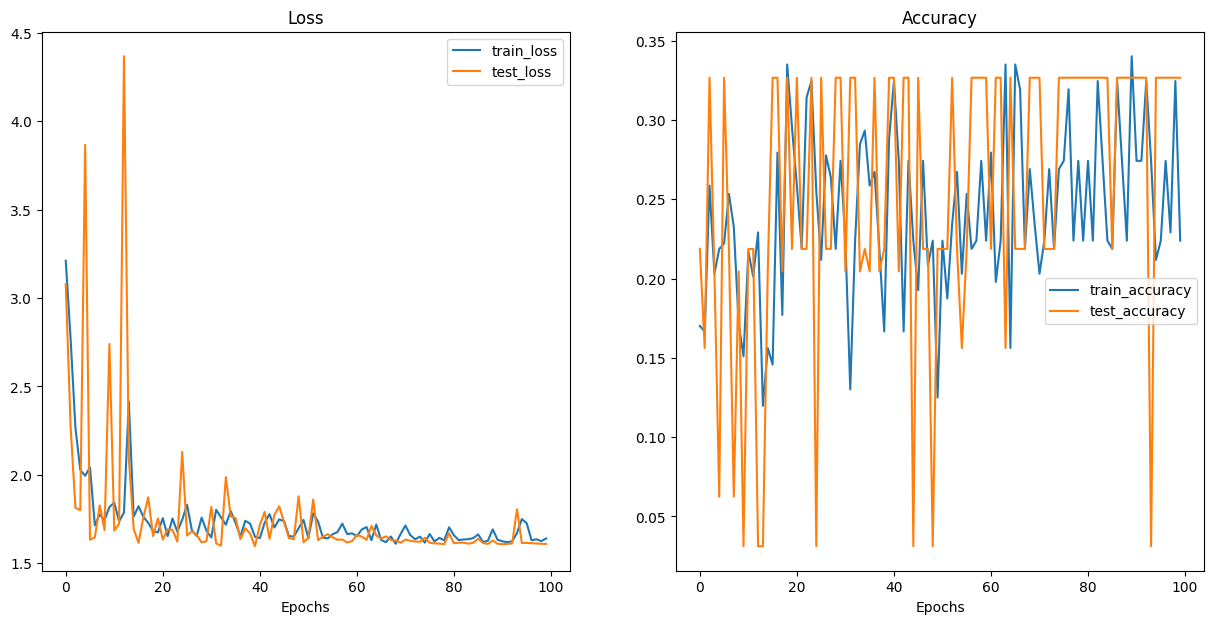

In [27]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)